## Data: Head position

In [1]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 4901386233437172222
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7116786893
locality {
  bus_id: 1
  links {
  }
}
incarnation: 8431725085386687548
physical_device_desc: "device: 0, name: GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [2]:
# Create your first MLP in Keras
import os, sys
import numpy as np
import time
from utils.data_generator_seq2seq import data_generator_head_sal_seq2seq_reinject_output
import matplotlib.pyplot as plt
%matplotlib inline
import random as rn

from keras.models import Model
from keras.layers import Input, Dense, Concatenate, CuDNNLSTM, \
    Conv2D, MaxPooling2D, Flatten, TimeDistributed, Reshape, Lambda
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras import backend as K
import keras
from keras.utils.generic_utils import get_custom_objects
import tensorflow as tf
from keras.utils import plot_model

## reproducibility
os.environ['PYTHONHASHSEED'] = '0'
# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
# fix random seed for reproducibility
seed = 7 #42
np.random.seed(seed)
# The below is necessary for starting core Python generated random numbers in a well-defined state.
rn.seed(12345)
# Force TensorFlow to use single thread. Multiple threads are a potential source of non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# The below tf.set_random_seed() will make random number generation in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(1234)
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

print("python: {}, keras: {}, tensorflow: {}".format(sys.version, keras.__version__, tf.__version__))

dir_path = os.getcwd()

python: 3.5.2 (default, Oct  8 2019, 13:06:37) 
[GCC 5.4.0 20160609], keras: 2.2.4, tensorflow: 1.8.0


Using TensorFlow backend.


In [3]:
experiment_name = 'final_seq2seq_head_sal_reinject_output_3-128'

time_step = 10 # 10 ms
lookback = 250 # 250 ms
n_lookback = int(round(lookback / time_step))

step_delay = 100
n_delay = int(round(step_delay / time_step))
delays_list = list(range(100, 1000+1, step_delay))
n_max_delay = int(round(np.max(delays_list) / time_step))

len_delay = len(delays_list)

# HARD CODED MAXIMUM DIFFERENCES
MAX_DIFF = np.array([1.95763439, 0.06364631, 1.99985595])

In [4]:
K.clear_session()

# create model
encoder_inputs = Input(shape=(n_lookback, 3))
latent_dim = 128 # LSTM hidden units
filter_dim = 5
kernel_dim = 10

# Define an input series and encode it with an LSTM.
encoder_1, h1, c1 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_inputs)
encoder_2, h2, c2 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)(encoder_1)
encoder_3, h3, c3 = CuDNNLSTM(units=latent_dim, return_state=True)(encoder_2)

# We discard `encoder_outputs` and only keep the final states. These represent the "context"
# vector that we use as the basis for decoding.
encoder_states = [h1, c1, h2, c2, h3, c3]

# Set up the decoder, using `encoder_states` as initial state.
# This is where teacher forcing inputs are fed in.

final_width_px = 128 # 2560/20
final_height_px = 72 # 1440/20

sal_map_input = Input(shape=(final_height_px, final_width_px, 1))

conv_1 = Conv2D(filters=4, kernel_size=(3,3), padding="same", data_format="channels_last", activation="relu")(sal_map_input)
max_pooling_1 = MaxPooling2D(pool_size=(2,2))(conv_1)
conv_2 = Conv2D(filters=8, kernel_size=(3,3), padding="same", data_format="channels_last", activation="relu")(max_pooling_1)
max_pooling_2 = MaxPooling2D(pool_size=(2,2))(conv_2)
conv_3 = Conv2D(filters=16, kernel_size=(3,3), padding="same", data_format="channels_last", activation="relu")(max_pooling_2)
max_pooling_3 = MaxPooling2D(pool_size=(2,2))(conv_3)
conv_4 = Conv2D(filters=16, kernel_size=(3,3), padding="same", data_format="channels_last", activation="relu")(max_pooling_3)
max_pooling_4 = MaxPooling2D(pool_size=(2,2))(conv_4)

print(max_pooling_4.shape)

decoder_input_raw = Flatten(data_format='channels_last')(max_pooling_4)
print(decoder_input_raw.shape)

decoder_input = Dense(latent_dim, activation="relu")(decoder_input_raw)

decoder_input = Reshape(target_shape=(1,latent_dim))(decoder_input)
print(decoder_input.shape)

decoder_1 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_2 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)
decoder_3 = CuDNNLSTM(units=latent_dim, return_state=True, return_sequences=True)

dense_1 = TimeDistributed(Dense(latent_dim, activation="relu"))
dense_2 = TimeDistributed(Dense(3))

# We set up our decoder using `encoder_states` as initial state.  
# We return full output sequences and return internal states as well. 
# We don't use the return states in the training model, but we will use them in inference.

all_outputs = []
inputs = decoder_input
states = encoder_states

for _ in range(len_delay):

    decoder_outputs_1, dh1, dc1 = decoder_1(inputs, initial_state=[states[0], states[1]])

    decoder_outputs_2, dh2, dc2 = decoder_2(decoder_outputs_1, initial_state=[states[2], states[3]])

    decoder_outputs_3, dh3, dc3 = decoder_3(decoder_outputs_2, initial_state=[states[4], states[5]])

    dense_1_outputs = dense_1(decoder_outputs_3)
    outputs = dense_2(dense_1_outputs)
    
    all_outputs.append(outputs)
    
    inputs = decoder_outputs_3
    states = [dh1, dc1, dh2, dc2, dh3, dc3]

# Concatenate all predictions
decoder_outputs = Lambda(lambda x: K.concatenate(x, axis=1))(all_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
print(decoder_outputs.shape)
model = Model(inputs=[encoder_inputs, sal_map_input], outputs=decoder_outputs)


# Compile model
#adam = Adam(lr=0.01)
def rmse(y_true, y_pred):
    return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(loss='mae', optimizer="adam", metrics=[rmse])

print(model.summary())

(?, 4, 8, 16)
(?, ?)
(?, 1, 128)


(?, 10, 3)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 72, 128, 1)   0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 72, 128, 4)   40          input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 36, 64, 4)    0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 36, 64, 8)    296         max_pooling2d_1[0][0]            
_________________________________________________________________________________

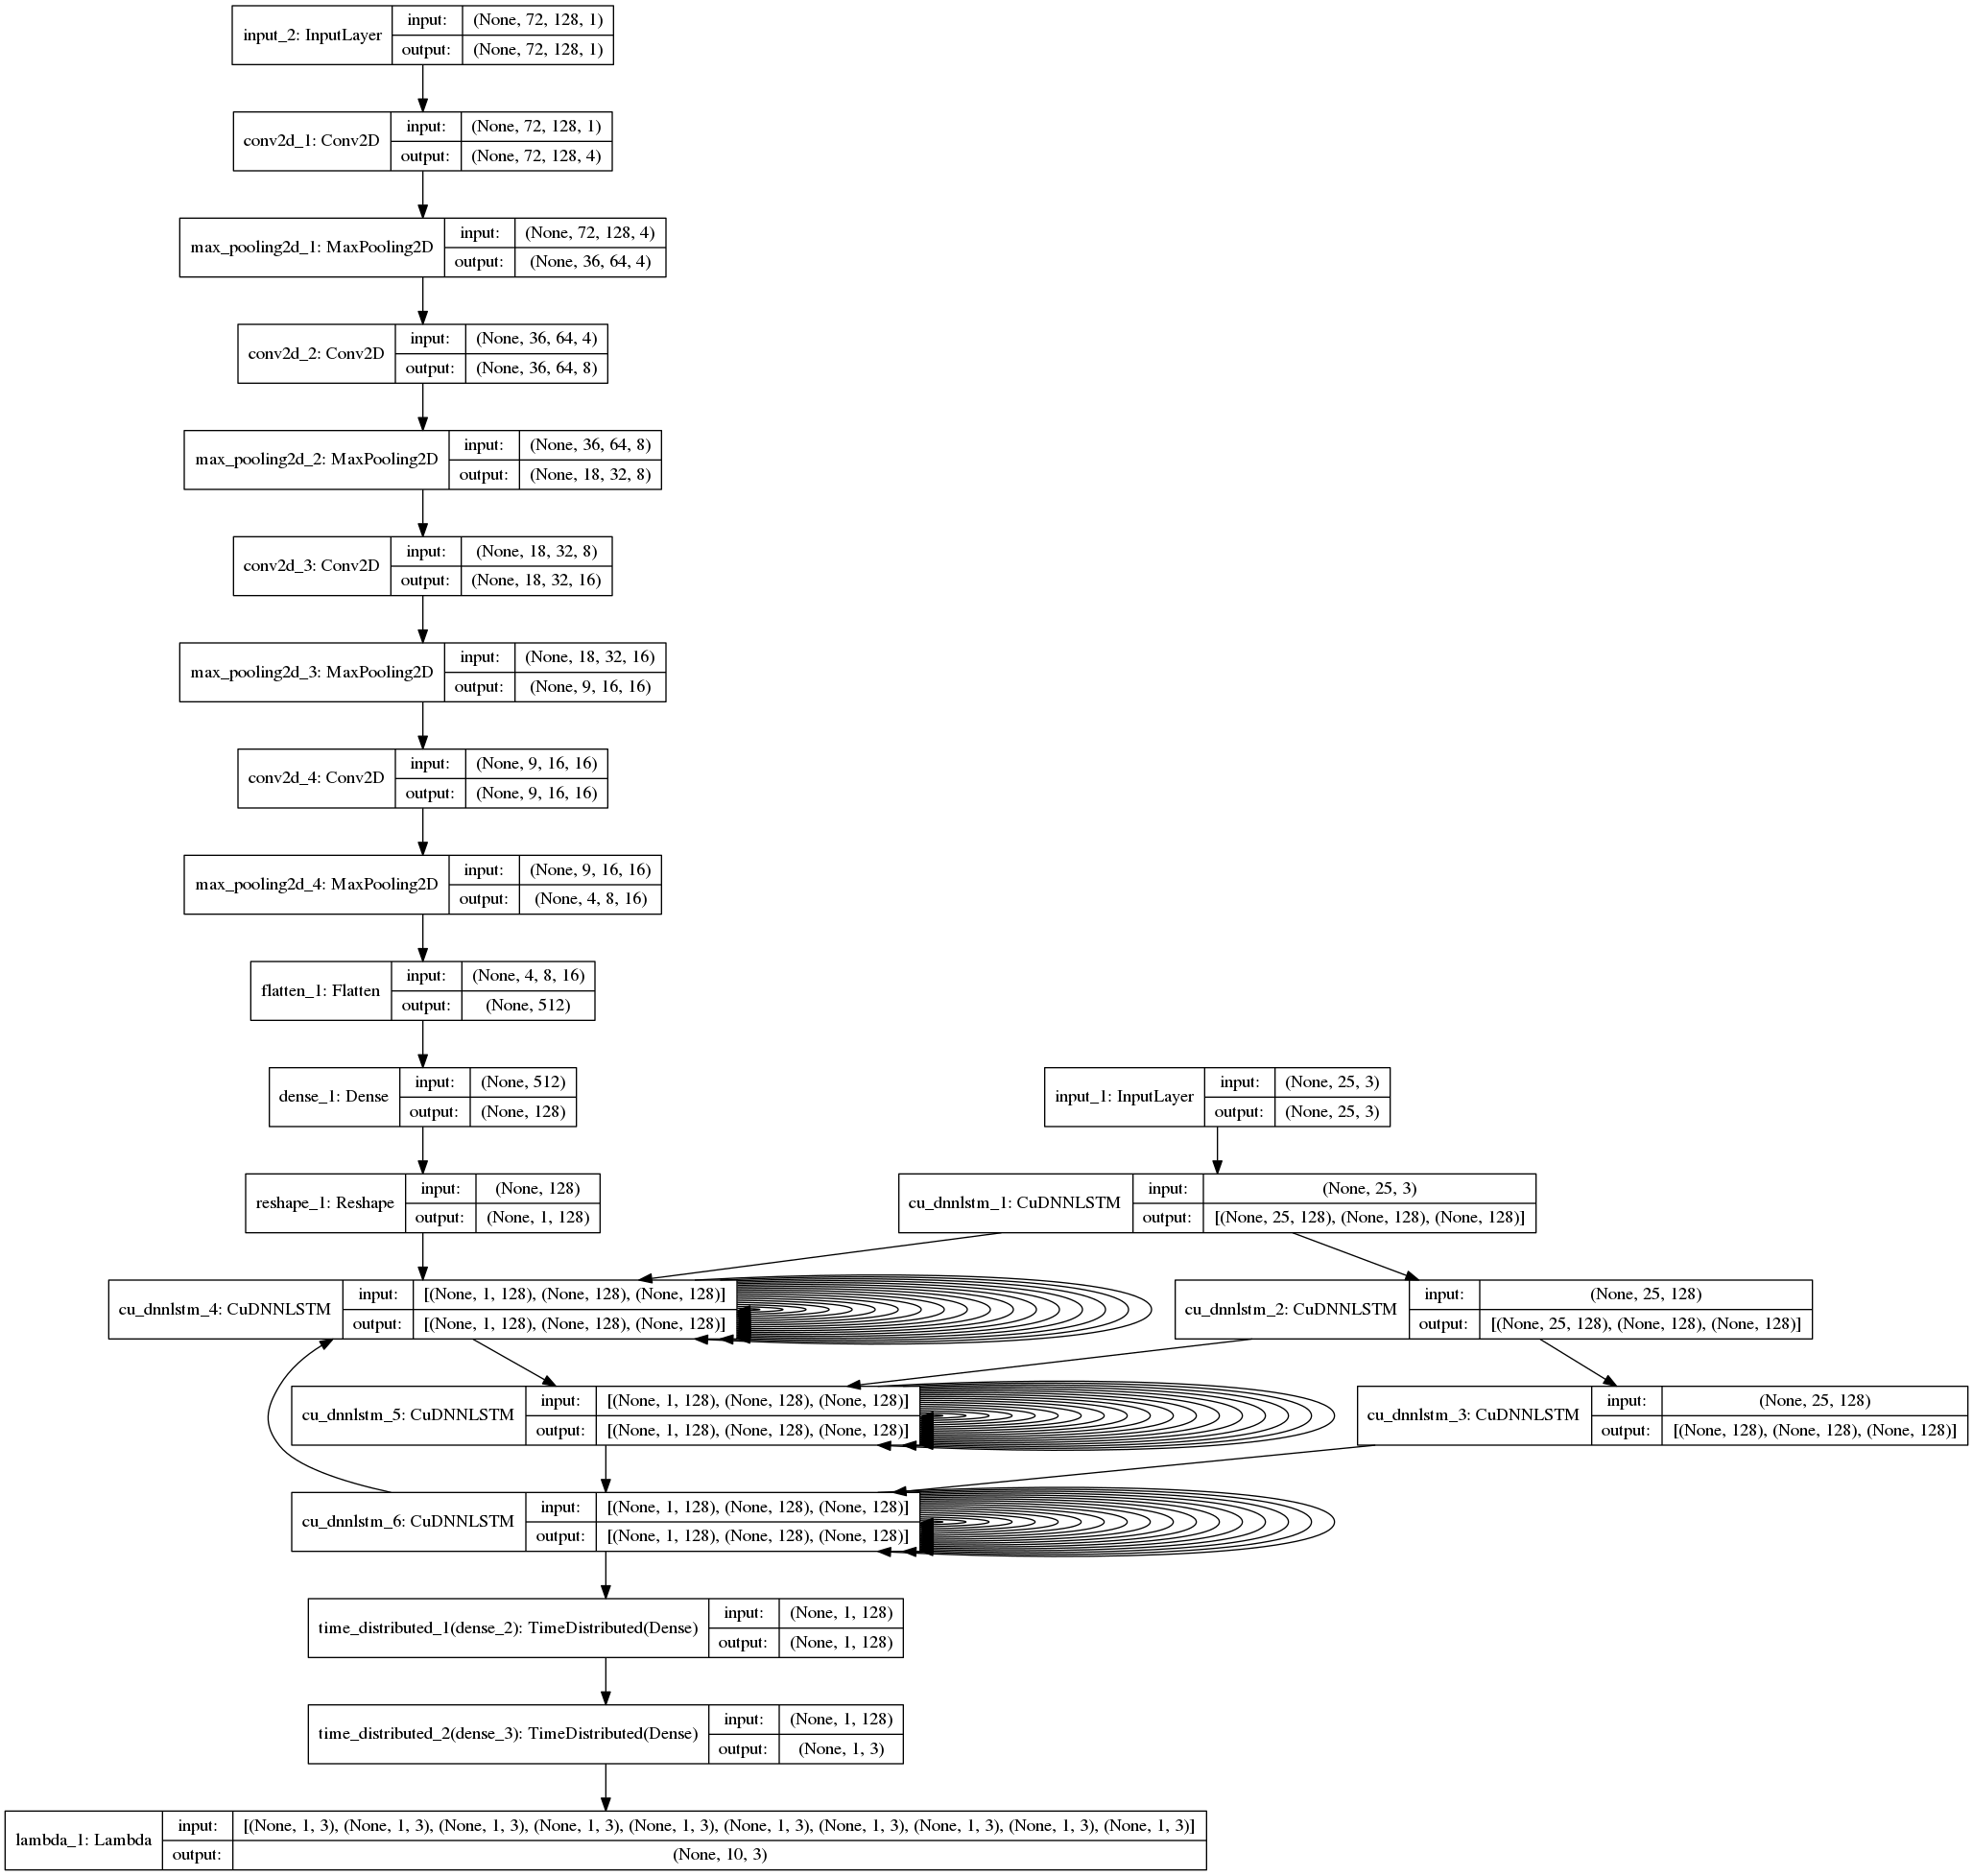

In [5]:
plot_model(model, to_file=experiment_name+'.png', show_shapes=True)

In [6]:
tensorboard_callback = TensorBoard(log_dir='./tensorboard_logs',
                                   histogram_freq=0,
                                   write_graph=True,
                                   write_grads=True,
                                   write_images=True,
                                   embeddings_freq=0,
                                   embeddings_layer_names=None,
                                   embeddings_metadata=None)

earlystopping_callback = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=15,
                                       verbose=1,
                                       mode='auto')

modelcheckpoint_callback = ModelCheckpoint(filepath=experiment_name+'.hdf5',
                                           save_best_only=True,
                                           monitor='val_loss',
                                           mode='min')

In [7]:
saliency_dir = os.path.join(dir_path, "fov_images_train_h5_new", "saliency")
#videos = os.listdir(saliency_dir) 
#print(videos)

path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")
videos = os.listdir(saliency_dir)
print(videos)
video_width = 3840

['013_13_times_square_static.h5', '002_01_art_gallery_static.h5', '002_02_theatre_scene_static.h5', '002_03_lions_static_cuts.h5', '002_04_copenhagen_harbour_static_cuts.h5', '002_07_factory_robots_static.h5', '002_09_elephants_static.h5', '002_12_gym_workout_static.h5', '002_13_times_square_static.h5', '002_14_new_orleans_drive_motion.h5', '002_16_interview_static.h5', '002_17_weather_forecast_static.h5', '002_18_bomb_trapped_static.h5', '002_20_car_fix_static.h5', '002_23_dog_food_factory_motion.h5', '003_01_art_gallery_static.h5', '003_02_theatre_scene_static.h5', '003_03_lions_static_cuts.h5', '003_04_copenhagen_harbour_static_cuts.h5', '003_05_florida_yacht_motion.h5', '003_07_factory_robots_static.h5', '003_08_madagascar_cuts.h5', '003_09_elephants_static.h5', '003_11_lohdi_garden_india_cuts.h5', '003_12_gym_workout_static.h5', '003_13_times_square_static.h5', '003_14_new_orleans_drive_motion.h5', '003_18_bomb_trapped_static.h5', '003_21_operation_room_static.h5', '003_23_dog_foo

In [8]:
use_generator = True
if use_generator:
    nb_epochs = 150
    start = time.time()
    
    perc_train = 0.8
    ind_max_train = int(np.round(len(videos) * perc_train))
    file_names_train = videos[:ind_max_train]
    file_names_val = videos[ind_max_train:]
    #data = np.load(os.path.join(path_to_sensor_data_train, file_name))

    train_gen = data_generator_head_sal_seq2seq_reinject_output(path_to_sensor_data_train,
                                    file_names_train,
                                    delays_list,
                                    n_max_delay,
                                    n_lookback,
                                    n_delay)
    val_gen = data_generator_head_sal_seq2seq_reinject_output(path_to_sensor_data_train,
                                  file_names_val,
                                  delays_list,
                                  n_max_delay,
                                  n_lookback,
                                  n_delay)

(72, 128, 1)


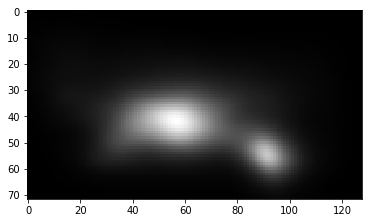

"\nfig=plt.figure(figsize=(18, 16), dpi= 80)\n\nplt.subplot(311)\nplt.plot(encoder_input[:,0,0], c='r')\nplt.grid(True)\n\nplt.subplot(312)\nplt.plot(encoder_input[:,0,1], c='g')\nplt.grid(True)\n\nplt.subplot(313)\nplt.plot(encoder_input[:,0,2], c='b')\nplt.grid(True)\n"

In [9]:
[encoder_input, decoder_input], Y_train = next(train_gen)
print(decoder_input[1000].shape)
plt.imshow(decoder_input[1000,:,:,0], cmap='gray', vmin=0, vmax=255)
plt.show()

'''
fig=plt.figure(figsize=(18, 16), dpi= 80)

plt.subplot(311)
plt.plot(encoder_input[:,0,0], c='r')
plt.grid(True)

plt.subplot(312)
plt.plot(encoder_input[:,0,1], c='g')
plt.grid(True)

plt.subplot(313)
plt.plot(encoder_input[:,0,2], c='b')
plt.grid(True)
'''

In [10]:
history = model.fit_generator(train_gen,
                    steps_per_epoch=ind_max_train,
                    epochs=nb_epochs,
                    callbacks=[
                               tensorboard_callback,
                               earlystopping_callback,
                               modelcheckpoint_callback],
                    verbose=1,
                    shuffle=True,
                    validation_data=val_gen,
                    validation_steps=(len(videos) - ind_max_train))
print("Time:", time.time() - start, "s = ",(time.time() - start)/60., "min")

print("Training Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Epoch 1/150


  1/422 [..............................] - ETA: 35:41 - loss: 0.0872 - rmse: 0.1874

  2/422 [..............................] - ETA: 24:25 - loss: 0.0955 - rmse: 0.1980

  3/422 [..............................] - ETA: 21:48 - loss: 0.0842 - rmse: 0.1773

  4/422 [..............................] - ETA: 20:39 - loss: 0.0737 - rmse: 0.1600

  5/422 [..............................] - ETA: 19:58 - loss: 0.0693 - rmse: 0.1473

  6/422 [..............................] - ETA: 19:33 - loss: 0.0670 - rmse: 0.1427

  7/422 [..............................] - ETA: 19:12 - loss: 0.0633 - rmse: 0.1352

  8/422 [..............................] - ETA: 18:56 - loss: 0.0597 - rmse: 0.1277

  9/422 [..............................] - ETA: 18:44 - loss: 0.0579 - rmse: 0.1304

 10/422 [..............................] - ETA: 18:34 - loss: 0.0555 - rmse: 0.1268

 11/422 [..............................] - ETA: 18:26 - loss: 0.0555 - rmse: 0.1293

 12/422 [..............................] - ETA: 18:19 - loss: 0.0562 - rmse: 0.1333

 13/422 [..............................] - ETA: 18:09 - loss: 0.0574 - rmse: 0.1356

 14/422 [..............................] - ETA: 18:05 - loss: 0.0559 - rmse: 0.1319

 15/422 [>.............................] - ETA: 17:59 - loss: 0.0565 - rmse: 0.1362

 16/422 [>.............................] - ETA: 17:55 - loss: 0.0553 - rmse: 0.1372

 17/422 [>.............................] - ETA: 17:45 - loss: 0.0539 - rmse: 0.1332

 18/422 [>.............................] - ETA: 17:42 - loss: 0.0536 - rmse: 0.1347

 19/422 [>.............................] - ETA: 17:39 - loss: 0.0537 - rmse: 0.1365

 20/422 [>.............................] - ETA: 17:36 - loss: 0.0545 - rmse: 0.1379

 21/422 [>.............................] - ETA: 17:32 - loss: 0.0554 - rmse: 0.1396

 22/422 [>.............................] - ETA: 17:30 - loss: 0.0567 - rmse: 0.1439

 23/422 [>.............................] - ETA: 16:52 - loss: 0.0559 - rmse: 0.1418

 24/422 [>.............................] - ETA: 16:51 - loss: 0.0559 - rmse: 0.1430

 25/422 [>.............................] - ETA: 16:44 - loss: 0.0561 - rmse: 0.1424

 26/422 [>.............................] - ETA: 16:43 - loss: 0.0572 - rmse: 0.1449

 27/422 [>.............................] - ETA: 16:41 - loss: 0.0572 - rmse: 0.1487

 28/422 [>.............................] - ETA: 16:37 - loss: 0.0580 - rmse: 0.1511

 29/422 [=>............................] - ETA: 16:36 - loss: 0.0579 - rmse: 0.1515

 30/422 [=>............................] - ETA: 16:33 - loss: 0.0586 - rmse: 0.1531

 31/422 [=>............................] - ETA: 16:30 - loss: 0.0582 - rmse: 0.1531

 32/422 [=>............................] - ETA: 16:28 - loss: 0.0590 - rmse: 0.1546

 33/422 [=>............................] - ETA: 16:03 - loss: 0.0600 - rmse: 0.1566

 34/422 [=>............................] - ETA: 16:01 - loss: 0.0592 - rmse: 0.1556

 35/422 [=>............................] - ETA: 15:59 - loss: 0.0593 - rmse: 0.1558

 36/422 [=>............................] - ETA: 15:56 - loss: 0.0616 - rmse: 0.1607

 37/422 [=>............................] - ETA: 15:35 - loss: 0.0605 - rmse: 0.1578

 38/422 [=>............................] - ETA: 15:33 - loss: 0.0618 - rmse: 0.1610

 39/422 [=>............................] - ETA: 15:31 - loss: 0.0617 - rmse: 0.1614

 40/422 [=>............................] - ETA: 15:30 - loss: 0.0610 - rmse: 0.1596

 41/422 [=>............................] - ETA: 15:29 - loss: 0.0612 - rmse: 0.1611

 42/422 [=>............................] - ETA: 15:28 - loss: 0.0612 - rmse: 0.1608

 43/422 [==>...........................] - ETA: 15:27 - loss: 0.0606 - rmse: 0.1588

 44/422 [==>...........................] - ETA: 15:26 - loss: 0.0610 - rmse: 0.1596

 45/422 [==>...........................] - ETA: 15:19 - loss: 0.0619 - rmse: 0.1610

 46/422 [==>...........................] - ETA: 15:18 - loss: 0.0618 - rmse: 0.1606

 47/422 [==>...........................] - ETA: 15:16 - loss: 0.0608 - rmse: 0.1580

 48/422 [==>...........................] - ETA: 15:10 - loss: 0.0612 - rmse: 0.1585

 49/422 [==>...........................] - ETA: 15:09 - loss: 0.0614 - rmse: 0.1593

 50/422 [==>...........................] - ETA: 14:53 - loss: 0.0626 - rmse: 0.1622

 51/422 [==>...........................] - ETA: 14:52 - loss: 0.0626 - rmse: 0.1625

 52/422 [==>...........................] - ETA: 14:51 - loss: 0.0623 - rmse: 0.1620

 53/422 [==>...........................] - ETA: 14:36 - loss: 0.0632 - rmse: 0.1637

 54/422 [==>...........................] - ETA: 14:31 - loss: 0.0629 - rmse: 0.1630

 55/422 [==>...........................] - ETA: 14:17 - loss: 0.0627 - rmse: 0.1625

 56/422 [==>...........................] - ETA: 14:15 - loss: 0.0625 - rmse: 0.1615

 57/422 [===>..........................] - ETA: 14:14 - loss: 0.0619 - rmse: 0.1598

 58/422 [===>..........................] - ETA: 14:13 - loss: 0.0625 - rmse: 0.1613

 59/422 [===>..........................] - ETA: 14:12 - loss: 0.0623 - rmse: 0.1610

 60/422 [===>..........................] - ETA: 14:10 - loss: 0.0616 - rmse: 0.1595

 61/422 [===>..........................] - ETA: 14:08 - loss: 0.0615 - rmse: 0.1602

 62/422 [===>..........................] - ETA: 14:07 - loss: 0.0620 - rmse: 0.1616

 63/422 [===>..........................] - ETA: 14:02 - loss: 0.0617 - rmse: 0.1615

 64/422 [===>..........................] - ETA: 13:50 - loss: 0.0615 - rmse: 0.1615

 65/422 [===>..........................] - ETA: 13:39 - loss: 0.0614 - rmse: 0.1625

 66/422 [===>..........................] - ETA: 13:37 - loss: 0.0610 - rmse: 0.1620

 67/422 [===>..........................] - ETA: 13:36 - loss: 0.0608 - rmse: 0.1617

 68/422 [===>..........................] - ETA: 13:34 - loss: 0.0614 - rmse: 0.1634

 69/422 [===>..........................] - ETA: 13:34 - loss: 0.0618 - rmse: 0.1641

 70/422 [===>..........................] - ETA: 13:33 - loss: 0.0625 - rmse: 0.1656

 71/422 [====>.........................] - ETA: 13:22 - loss: 0.0624 - rmse: 0.1650

 72/422 [====>.........................] - ETA: 13:21 - loss: 0.0622 - rmse: 0.1645

 73/422 [====>.........................] - ETA: 13:11 - loss: 0.0625 - rmse: 0.1654

 74/422 [====>.........................] - ETA: 13:09 - loss: 0.0628 - rmse: 0.1661

 75/422 [====>.........................] - ETA: 13:08 - loss: 0.0631 - rmse: 0.1670

 76/422 [====>.........................] - ETA: 12:58 - loss: 0.0632 - rmse: 0.1672

 77/422 [====>.........................] - ETA: 12:57 - loss: 0.0627 - rmse: 0.1660

 78/422 [====>.........................] - ETA: 12:55 - loss: 0.0629 - rmse: 0.1663

 79/422 [====>.........................] - ETA: 12:54 - loss: 0.0629 - rmse: 0.1663

 80/422 [====>.........................] - ETA: 12:53 - loss: 0.0629 - rmse: 0.1662

 81/422 [====>.........................] - ETA: 12:51 - loss: 0.0630 - rmse: 0.1663

 82/422 [====>.........................] - ETA: 12:49 - loss: 0.0629 - rmse: 0.1662

 83/422 [====>.........................] - ETA: 12:48 - loss: 0.0633 - rmse: 0.1670

 84/422 [====>.........................] - ETA: 12:39 - loss: 0.0633 - rmse: 0.1674

 85/422 [=====>........................] - ETA: 12:30 - loss: 0.0632 - rmse: 0.1672

 86/422 [=====>........................] - ETA: 12:30 - loss: 0.0628 - rmse: 0.1666

 87/422 [=====>........................] - ETA: 12:21 - loss: 0.0624 - rmse: 0.1654

 88/422 [=====>........................] - ETA: 12:21 - loss: 0.0619 - rmse: 0.1640

 89/422 [=====>........................] - ETA: 12:20 - loss: 0.0621 - rmse: 0.1646

 90/422 [=====>........................] - ETA: 12:19 - loss: 0.0616 - rmse: 0.1634

 91/422 [=====>........................] - ETA: 12:11 - loss: 0.0611 - rmse: 0.1619

 92/422 [=====>........................] - ETA: 12:03 - loss: 0.0607 - rmse: 0.1608

 93/422 [=====>........................] - ETA: 12:03 - loss: 0.0602 - rmse: 0.1599

 94/422 [=====>........................] - ETA: 12:02 - loss: 0.0599 - rmse: 0.1592

 95/422 [=====>........................] - ETA: 12:01 - loss: 0.0598 - rmse: 0.1590

 96/422 [=====>........................] - ETA: 11:53 - loss: 0.0600 - rmse: 0.1601

 97/422 [=====>........................] - ETA: 11:52 - loss: 0.0598 - rmse: 0.1597

 98/422 [=====>........................] - ETA: 11:51 - loss: 0.0596 - rmse: 0.1598

 99/422 [======>.......................] - ETA: 11:48 - loss: 0.0597 - rmse: 0.1600

100/422 [======>.......................] - ETA: 11:47 - loss: 0.0599 - rmse: 0.1607

101/422 [======>.......................] - ETA: 11:40 - loss: 0.0599 - rmse: 0.1605

102/422 [======>.......................] - ETA: 11:39 - loss: 0.0598 - rmse: 0.1605

103/422 [======>.......................] - ETA: 11:32 - loss: 0.0597 - rmse: 0.1599

104/422 [======>.......................] - ETA: 11:25 - loss: 0.0594 - rmse: 0.1592

105/422 [======>.......................] - ETA: 11:24 - loss: 0.0591 - rmse: 0.1582

106/422 [======>.......................] - ETA: 11:23 - loss: 0.0589 - rmse: 0.1580

107/422 [======>.......................] - ETA: 11:16 - loss: 0.0589 - rmse: 0.1579

108/422 [======>.......................] - ETA: 11:14 - loss: 0.0593 - rmse: 0.1586

109/422 [======>.......................] - ETA: 11:13 - loss: 0.0593 - rmse: 0.1589

110/422 [======>.......................] - ETA: 11:12 - loss: 0.0596 - rmse: 0.1596

111/422 [======>.......................] - ETA: 11:10 - loss: 0.0592 - rmse: 0.1584

112/422 [======>.......................] - ETA: 11:09 - loss: 0.0594 - rmse: 0.1591

113/422 [=======>......................] - ETA: 11:08 - loss: 0.0594 - rmse: 0.1594

114/422 [=======>......................] - ETA: 11:06 - loss: 0.0596 - rmse: 0.1596

115/422 [=======>......................] - ETA: 11:00 - loss: 0.0592 - rmse: 0.1586

116/422 [=======>......................] - ETA: 10:59 - loss: 0.0593 - rmse: 0.1588

117/422 [=======>......................] - ETA: 10:58 - loss: 0.0594 - rmse: 0.1595

118/422 [=======>......................] - ETA: 10:57 - loss: 0.0594 - rmse: 0.1600

119/422 [=======>......................] - ETA: 10:51 - loss: 0.0595 - rmse: 0.1602

120/422 [=======>......................] - ETA: 10:49 - loss: 0.0601 - rmse: 0.1613

121/422 [=======>......................] - ETA: 10:43 - loss: 0.0600 - rmse: 0.1611

122/422 [=======>......................] - ETA: 10:42 - loss: 0.0600 - rmse: 0.1611

123/422 [=======>......................] - ETA: 10:36 - loss: 0.0601 - rmse: 0.1610

124/422 [=======>......................] - ETA: 10:30 - loss: 0.0603 - rmse: 0.1613

125/422 [=======>......................] - ETA: 10:24 - loss: 0.0608 - rmse: 0.1629

126/422 [=======>......................] - ETA: 10:19 - loss: 0.0609 - rmse: 0.1637

127/422 [========>.....................] - ETA: 10:13 - loss: 0.0610 - rmse: 0.1640

128/422 [========>.....................] - ETA: 10:12 - loss: 0.0612 - rmse: 0.1644

129/422 [========>.....................] - ETA: 10:07 - loss: 0.0611 - rmse: 0.1642

130/422 [========>.....................] - ETA: 10:01 - loss: 0.0611 - rmse: 0.1642

131/422 [========>.....................] - ETA: 10:00 - loss: 0.0616 - rmse: 0.1649

132/422 [========>.....................] - ETA: 9:59 - loss: 0.0617 - rmse: 0.1651 

133/422 [========>.....................] - ETA: 9:58 - loss: 0.0615 - rmse: 0.1647

134/422 [========>.....................] - ETA: 9:57 - loss: 0.0616 - rmse: 0.1648

135/422 [========>.....................] - ETA: 9:56 - loss: 0.0617 - rmse: 0.1649

136/422 [========>.....................] - ETA: 9:50 - loss: 0.0617 - rmse: 0.1652

137/422 [========>.....................] - ETA: 9:49 - loss: 0.0620 - rmse: 0.1657

138/422 [========>.....................] - ETA: 9:48 - loss: 0.0623 - rmse: 0.1665

139/422 [========>.....................] - ETA: 9:47 - loss: 0.0622 - rmse: 0.1663

140/422 [========>.....................] - ETA: 9:46 - loss: 0.0624 - rmse: 0.1670

141/422 [=========>....................] - ETA: 9:41 - loss: 0.0623 - rmse: 0.1669

142/422 [=========>....................] - ETA: 9:40 - loss: 0.0625 - rmse: 0.1675

143/422 [=========>....................] - ETA: 9:38 - loss: 0.0621 - rmse: 0.1665

144/422 [=========>....................] - ETA: 9:36 - loss: 0.0624 - rmse: 0.1672

145/422 [=========>....................] - ETA: 9:31 - loss: 0.0624 - rmse: 0.1672

146/422 [=========>....................] - ETA: 9:26 - loss: 0.0622 - rmse: 0.1668

147/422 [=========>....................] - ETA: 9:21 - loss: 0.0622 - rmse: 0.1667

148/422 [=========>....................] - ETA: 9:20 - loss: 0.0622 - rmse: 0.1669

149/422 [=========>....................] - ETA: 9:16 - loss: 0.0622 - rmse: 0.1666

150/422 [=========>....................] - ETA: 9:11 - loss: 0.0620 - rmse: 0.1660

151/422 [=========>....................] - ETA: 9:06 - loss: 0.0620 - rmse: 0.1661

152/422 [=========>....................] - ETA: 9:05 - loss: 0.0621 - rmse: 0.1660

153/422 [=========>....................] - ETA: 9:04 - loss: 0.0621 - rmse: 0.1663

154/422 [=========>....................] - ETA: 9:02 - loss: 0.0622 - rmse: 0.1665

155/422 [==========>...................] - ETA: 8:58 - loss: 0.0620 - rmse: 0.1661

156/422 [==========>...................] - ETA: 8:53 - loss: 0.0619 - rmse: 0.1658

157/422 [==========>...................] - ETA: 8:49 - loss: 0.0618 - rmse: 0.1655

158/422 [==========>...................] - ETA: 8:48 - loss: 0.0618 - rmse: 0.1655

159/422 [==========>...................] - ETA: 8:47 - loss: 0.0616 - rmse: 0.1649

160/422 [==========>...................] - ETA: 8:46 - loss: 0.0617 - rmse: 0.1653

161/422 [==========>...................] - ETA: 8:44 - loss: 0.0615 - rmse: 0.1650

162/422 [==========>...................] - ETA: 8:40 - loss: 0.0616 - rmse: 0.1652

163/422 [==========>...................] - ETA: 8:39 - loss: 0.0617 - rmse: 0.1652

164/422 [==========>...................] - ETA: 8:38 - loss: 0.0617 - rmse: 0.1653

165/422 [==========>...................] - ETA: 8:37 - loss: 0.0617 - rmse: 0.1654

166/422 [==========>...................] - ETA: 8:32 - loss: 0.0615 - rmse: 0.1647

167/422 [==========>...................] - ETA: 8:31 - loss: 0.0613 - rmse: 0.1643

168/422 [==========>...................] - ETA: 8:30 - loss: 0.0617 - rmse: 0.1654

169/422 [===========>..................] - ETA: 8:26 - loss: 0.0620 - rmse: 0.1660

170/422 [===========>..................] - ETA: 8:25 - loss: 0.0619 - rmse: 0.1655

171/422 [===========>..................] - ETA: 8:24 - loss: 0.0622 - rmse: 0.1662

172/422 [===========>..................] - ETA: 8:20 - loss: 0.0620 - rmse: 0.1661

173/422 [===========>..................] - ETA: 8:16 - loss: 0.0621 - rmse: 0.1663

174/422 [===========>..................] - ETA: 8:12 - loss: 0.0619 - rmse: 0.1660

175/422 [===========>..................] - ETA: 8:08 - loss: 0.0618 - rmse: 0.1657

176/422 [===========>..................] - ETA: 8:04 - loss: 0.0618 - rmse: 0.1656

177/422 [===========>..................] - ETA: 8:00 - loss: 0.0618 - rmse: 0.1656

178/422 [===========>..................] - ETA: 7:56 - loss: 0.0619 - rmse: 0.1657

179/422 [===========>..................] - ETA: 7:55 - loss: 0.0619 - rmse: 0.1659

180/422 [===========>..................] - ETA: 7:54 - loss: 0.0619 - rmse: 0.1658

181/422 [===========>..................] - ETA: 7:50 - loss: 0.0619 - rmse: 0.1658

182/422 [===========>..................] - ETA: 7:49 - loss: 0.0619 - rmse: 0.1655

183/422 [============>.................] - ETA: 7:46 - loss: 0.0618 - rmse: 0.1652

184/422 [============>.................] - ETA: 7:42 - loss: 0.0617 - rmse: 0.1647

185/422 [============>.................] - ETA: 7:41 - loss: 0.0619 - rmse: 0.1655

186/422 [============>.................] - ETA: 7:40 - loss: 0.0618 - rmse: 0.1655

187/422 [============>.................] - ETA: 7:36 - loss: 0.0618 - rmse: 0.1653

188/422 [============>.................] - ETA: 7:32 - loss: 0.0617 - rmse: 0.1654

189/422 [============>.................] - ETA: 7:31 - loss: 0.0616 - rmse: 0.1651

190/422 [============>.................] - ETA: 7:28 - loss: 0.0616 - rmse: 0.1652

191/422 [============>.................] - ETA: 7:26 - loss: 0.0617 - rmse: 0.1657

192/422 [============>.................] - ETA: 7:22 - loss: 0.0617 - rmse: 0.1657

193/422 [============>.................] - ETA: 7:19 - loss: 0.0617 - rmse: 0.1657

194/422 [============>.................] - ETA: 7:17 - loss: 0.0620 - rmse: 0.1663

195/422 [============>.................] - ETA: 7:16 - loss: 0.0619 - rmse: 0.1661

196/422 [============>.................] - ETA: 7:13 - loss: 0.0617 - rmse: 0.1655

197/422 [=============>................] - ETA: 7:11 - loss: 0.0617 - rmse: 0.1654

198/422 [=============>................] - ETA: 7:10 - loss: 0.0618 - rmse: 0.1661

199/422 [=============>................] - ETA: 7:09 - loss: 0.0619 - rmse: 0.1665

200/422 [=============>................] - ETA: 7:08 - loss: 0.0619 - rmse: 0.1664

201/422 [=============>................] - ETA: 7:06 - loss: 0.0618 - rmse: 0.1664

202/422 [=============>................] - ETA: 7:03 - loss: 0.0619 - rmse: 0.1669

203/422 [=============>................] - ETA: 7:00 - loss: 0.0619 - rmse: 0.1668

204/422 [=============>................] - ETA: 6:56 - loss: 0.0616 - rmse: 0.1662

205/422 [=============>................] - ETA: 6:53 - loss: 0.0616 - rmse: 0.1662

206/422 [=============>................] - ETA: 6:51 - loss: 0.0617 - rmse: 0.1663

207/422 [=============>................] - ETA: 6:48 - loss: 0.0615 - rmse: 0.1657

208/422 [=============>................] - ETA: 6:45 - loss: 0.0615 - rmse: 0.1655

209/422 [=============>................] - ETA: 6:41 - loss: 0.0616 - rmse: 0.1659

210/422 [=============>................] - ETA: 6:38 - loss: 0.0617 - rmse: 0.1663

211/422 [==============>...............] - ETA: 6:37 - loss: 0.0617 - rmse: 0.1662

212/422 [==============>...............] - ETA: 6:34 - loss: 0.0618 - rmse: 0.1663

213/422 [==============>...............] - ETA: 6:31 - loss: 0.0618 - rmse: 0.1661

214/422 [==============>...............] - ETA: 6:29 - loss: 0.0620 - rmse: 0.1665

215/422 [==============>...............] - ETA: 6:28 - loss: 0.0620 - rmse: 0.1666

216/422 [==============>...............] - ETA: 6:26 - loss: 0.0621 - rmse: 0.1669

217/422 [==============>...............] - ETA: 6:23 - loss: 0.0620 - rmse: 0.1667

218/422 [==============>...............] - ETA: 6:20 - loss: 0.0619 - rmse: 0.1663

219/422 [==============>...............] - ETA: 6:19 - loss: 0.0619 - rmse: 0.1664

220/422 [==============>...............] - ETA: 6:18 - loss: 0.0620 - rmse: 0.1665

221/422 [==============>...............] - ETA: 6:15 - loss: 0.0620 - rmse: 0.1667

222/422 [==============>...............] - ETA: 6:13 - loss: 0.0620 - rmse: 0.1665

223/422 [==============>...............] - ETA: 6:10 - loss: 0.0619 - rmse: 0.1662

224/422 [==============>...............] - ETA: 6:07 - loss: 0.0620 - rmse: 0.1663

225/422 [==============>...............] - ETA: 6:06 - loss: 0.0622 - rmse: 0.1669

226/422 [===============>..............] - ETA: 6:03 - loss: 0.0621 - rmse: 0.1667

227/422 [===============>..............] - ETA: 6:02 - loss: 0.0621 - rmse: 0.1667

228/422 [===============>..............] - ETA: 6:01 - loss: 0.0620 - rmse: 0.1663

229/422 [===============>..............] - ETA: 5:58 - loss: 0.0619 - rmse: 0.1662

230/422 [===============>..............] - ETA: 5:55 - loss: 0.0620 - rmse: 0.1664

231/422 [===============>..............] - ETA: 5:53 - loss: 0.0622 - rmse: 0.1669

232/422 [===============>..............] - ETA: 5:50 - loss: 0.0623 - rmse: 0.1670

233/422 [===============>..............] - ETA: 5:48 - loss: 0.0623 - rmse: 0.1670

234/422 [===============>..............] - ETA: 5:46 - loss: 0.0622 - rmse: 0.1669

235/422 [===============>..............] - ETA: 5:43 - loss: 0.0622 - rmse: 0.1670

236/422 [===============>..............] - ETA: 5:41 - loss: 0.0622 - rmse: 0.1671

237/422 [===============>..............] - ETA: 5:39 - loss: 0.0624 - rmse: 0.1676

238/422 [===============>..............] - ETA: 5:37 - loss: 0.0624 - rmse: 0.1677

239/422 [===============>..............] - ETA: 5:35 - loss: 0.0623 - rmse: 0.1673

240/422 [================>.............] - ETA: 5:34 - loss: 0.0622 - rmse: 0.1672

241/422 [================>.............] - ETA: 5:31 - loss: 0.0626 - rmse: 0.1682

242/422 [================>.............] - ETA: 5:28 - loss: 0.0624 - rmse: 0.1677

243/422 [================>.............] - ETA: 5:26 - loss: 0.0624 - rmse: 0.1677

244/422 [================>.............] - ETA: 5:24 - loss: 0.0622 - rmse: 0.1673

245/422 [================>.............] - ETA: 5:22 - loss: 0.0622 - rmse: 0.1673

246/422 [================>.............] - ETA: 5:19 - loss: 0.0621 - rmse: 0.1670

247/422 [================>.............] - ETA: 5:18 - loss: 0.0620 - rmse: 0.1667

248/422 [================>.............] - ETA: 5:15 - loss: 0.0620 - rmse: 0.1668

249/422 [================>.............] - ETA: 5:14 - loss: 0.0619 - rmse: 0.1665

250/422 [================>.............] - ETA: 5:11 - loss: 0.0619 - rmse: 0.1664

251/422 [================>.............] - ETA: 5:09 - loss: 0.0621 - rmse: 0.1670

252/422 [================>.............] - ETA: 5:08 - loss: 0.0622 - rmse: 0.1671

253/422 [================>.............] - ETA: 5:06 - loss: 0.0619 - rmse: 0.1666

254/422 [=================>............] - ETA: 5:05 - loss: 0.0620 - rmse: 0.1669

255/422 [=================>............] - ETA: 5:04 - loss: 0.0621 - rmse: 0.1673

256/422 [=================>............] - ETA: 5:01 - loss: 0.0620 - rmse: 0.1671

257/422 [=================>............] - ETA: 4:58 - loss: 0.0619 - rmse: 0.1668

258/422 [=================>............] - ETA: 4:56 - loss: 0.0619 - rmse: 0.1670

259/422 [=================>............] - ETA: 4:53 - loss: 0.0618 - rmse: 0.1667

260/422 [=================>............] - ETA: 4:51 - loss: 0.0618 - rmse: 0.1667

261/422 [=================>............] - ETA: 4:48 - loss: 0.0618 - rmse: 0.1667

262/422 [=================>............] - ETA: 4:46 - loss: 0.0618 - rmse: 0.1667

263/422 [=================>............] - ETA: 4:44 - loss: 0.0616 - rmse: 0.1663

264/422 [=================>............] - ETA: 4:42 - loss: 0.0616 - rmse: 0.1664

265/422 [=================>............] - ETA: 4:39 - loss: 0.0616 - rmse: 0.1663

266/422 [=================>............] - ETA: 4:37 - loss: 0.0617 - rmse: 0.1665

267/422 [=================>............] - ETA: 4:35 - loss: 0.0616 - rmse: 0.1664

268/422 [==================>...........] - ETA: 4:32 - loss: 0.0615 - rmse: 0.1659

269/422 [==================>...........] - ETA: 4:30 - loss: 0.0614 - rmse: 0.1659

270/422 [==================>...........] - ETA: 4:28 - loss: 0.0614 - rmse: 0.1657

271/422 [==================>...........] - ETA: 4:26 - loss: 0.0614 - rmse: 0.1656

272/422 [==================>...........] - ETA: 4:24 - loss: 0.0614 - rmse: 0.1658

273/422 [==================>...........] - ETA: 4:23 - loss: 0.0616 - rmse: 0.1661

274/422 [==================>...........] - ETA: 4:20 - loss: 0.0616 - rmse: 0.1662

275/422 [==================>...........] - ETA: 4:18 - loss: 0.0616 - rmse: 0.1663

276/422 [==================>...........] - ETA: 4:17 - loss: 0.0616 - rmse: 0.1663

277/422 [==================>...........] - ETA: 4:15 - loss: 0.0615 - rmse: 0.1658

278/422 [==================>...........] - ETA: 4:14 - loss: 0.0614 - rmse: 0.1658

279/422 [==================>...........] - ETA: 4:13 - loss: 0.0615 - rmse: 0.1659

280/422 [==================>...........] - ETA: 4:10 - loss: 0.0616 - rmse: 0.1661

281/422 [==================>...........] - ETA: 4:08 - loss: 0.0616 - rmse: 0.1663

282/422 [===================>..........] - ETA: 4:06 - loss: 0.0616 - rmse: 0.1661

283/422 [===================>..........] - ETA: 4:04 - loss: 0.0615 - rmse: 0.1658

284/422 [===================>..........] - ETA: 4:02 - loss: 0.0615 - rmse: 0.1658

285/422 [===================>..........] - ETA: 4:01 - loss: 0.0613 - rmse: 0.1654

286/422 [===================>..........] - ETA: 3:59 - loss: 0.0613 - rmse: 0.1654

287/422 [===================>..........] - ETA: 3:58 - loss: 0.0615 - rmse: 0.1657

288/422 [===================>..........] - ETA: 3:55 - loss: 0.0615 - rmse: 0.1658

289/422 [===================>..........] - ETA: 3:54 - loss: 0.0615 - rmse: 0.1658

290/422 [===================>..........] - ETA: 3:52 - loss: 0.0615 - rmse: 0.1657

291/422 [===================>..........] - ETA: 3:51 - loss: 0.0616 - rmse: 0.1659

292/422 [===================>..........] - ETA: 3:49 - loss: 0.0614 - rmse: 0.1655

293/422 [===================>..........] - ETA: 3:47 - loss: 0.0613 - rmse: 0.1652

294/422 [===================>..........] - ETA: 3:45 - loss: 0.0613 - rmse: 0.1651

295/422 [===================>..........] - ETA: 3:43 - loss: 0.0613 - rmse: 0.1651

296/422 [====================>.........] - ETA: 3:40 - loss: 0.0611 - rmse: 0.1649

297/422 [====================>.........] - ETA: 3:39 - loss: 0.0611 - rmse: 0.1647

298/422 [====================>.........] - ETA: 3:37 - loss: 0.0611 - rmse: 0.1647

299/422 [====================>.........] - ETA: 3:35 - loss: 0.0610 - rmse: 0.1644

300/422 [====================>.........] - ETA: 3:34 - loss: 0.0610 - rmse: 0.1644

301/422 [====================>.........] - ETA: 3:31 - loss: 0.0611 - rmse: 0.1646

302/422 [====================>.........] - ETA: 3:29 - loss: 0.0612 - rmse: 0.1646

303/422 [====================>.........] - ETA: 3:28 - loss: 0.0610 - rmse: 0.1645

304/422 [====================>.........] - ETA: 3:26 - loss: 0.0611 - rmse: 0.1645

305/422 [====================>.........] - ETA: 3:23 - loss: 0.0610 - rmse: 0.1642

306/422 [====================>.........] - ETA: 3:22 - loss: 0.0611 - rmse: 0.1647

307/422 [====================>.........] - ETA: 3:20 - loss: 0.0611 - rmse: 0.1646

308/422 [====================>.........] - ETA: 3:18 - loss: 0.0610 - rmse: 0.1643

309/422 [====================>.........] - ETA: 3:17 - loss: 0.0611 - rmse: 0.1646

310/422 [=====================>........] - ETA: 3:15 - loss: 0.0610 - rmse: 0.1644

311/422 [=====================>........] - ETA: 3:13 - loss: 0.0610 - rmse: 0.1643

312/422 [=====================>........] - ETA: 3:11 - loss: 0.0611 - rmse: 0.1647

313/422 [=====================>........] - ETA: 3:09 - loss: 0.0610 - rmse: 0.1648

314/422 [=====================>........] - ETA: 3:07 - loss: 0.0610 - rmse: 0.1647

315/422 [=====================>........] - ETA: 3:06 - loss: 0.0609 - rmse: 0.1646

316/422 [=====================>........] - ETA: 3:05 - loss: 0.0610 - rmse: 0.1647

317/422 [=====================>........] - ETA: 3:02 - loss: 0.0609 - rmse: 0.1646

318/422 [=====================>........] - ETA: 3:00 - loss: 0.0610 - rmse: 0.1647

319/422 [=====================>........] - ETA: 2:59 - loss: 0.0612 - rmse: 0.1654

320/422 [=====================>........] - ETA: 2:57 - loss: 0.0613 - rmse: 0.1654

321/422 [=====================>........] - ETA: 2:56 - loss: 0.0613 - rmse: 0.1656

322/422 [=====================>........] - ETA: 2:54 - loss: 0.0614 - rmse: 0.1657

323/422 [=====================>........] - ETA: 2:52 - loss: 0.0613 - rmse: 0.1656

324/422 [======================>.......] - ETA: 2:50 - loss: 0.0612 - rmse: 0.1654

325/422 [======================>.......] - ETA: 2:49 - loss: 0.0614 - rmse: 0.1658

326/422 [======================>.......] - ETA: 2:46 - loss: 0.0614 - rmse: 0.1660

327/422 [======================>.......] - ETA: 2:44 - loss: 0.0615 - rmse: 0.1662

328/422 [======================>.......] - ETA: 2:42 - loss: 0.0614 - rmse: 0.1662

329/422 [======================>.......] - ETA: 2:41 - loss: 0.0614 - rmse: 0.1661

330/422 [======================>.......] - ETA: 2:39 - loss: 0.0617 - rmse: 0.1667

331/422 [======================>.......] - ETA: 2:37 - loss: 0.0617 - rmse: 0.1668

332/422 [======================>.......] - ETA: 2:36 - loss: 0.0616 - rmse: 0.1665

333/422 [======================>.......] - ETA: 2:34 - loss: 0.0616 - rmse: 0.1666

334/422 [======================>.......] - ETA: 2:32 - loss: 0.0617 - rmse: 0.1667

335/422 [======================>.......] - ETA: 2:30 - loss: 0.0618 - rmse: 0.1669

336/422 [======================>.......] - ETA: 2:28 - loss: 0.0618 - rmse: 0.1669

337/422 [======================>.......] - ETA: 2:26 - loss: 0.0618 - rmse: 0.1670

338/422 [=======================>......] - ETA: 2:24 - loss: 0.0619 - rmse: 0.1673

339/422 [=======================>......] - ETA: 2:22 - loss: 0.0621 - rmse: 0.1676

340/422 [=======================>......] - ETA: 2:20 - loss: 0.0621 - rmse: 0.1679

341/422 [=======================>......] - ETA: 2:18 - loss: 0.0622 - rmse: 0.1680

342/422 [=======================>......] - ETA: 2:16 - loss: 0.0621 - rmse: 0.1679

343/422 [=======================>......] - ETA: 2:15 - loss: 0.0621 - rmse: 0.1677

344/422 [=======================>......] - ETA: 2:13 - loss: 0.0621 - rmse: 0.1677

345/422 [=======================>......] - ETA: 2:11 - loss: 0.0621 - rmse: 0.1678

346/422 [=======================>......] - ETA: 2:09 - loss: 0.0621 - rmse: 0.1680

347/422 [=======================>......] - ETA: 2:07 - loss: 0.0622 - rmse: 0.1681

348/422 [=======================>......] - ETA: 2:05 - loss: 0.0620 - rmse: 0.1678

349/422 [=======================>......] - ETA: 2:03 - loss: 0.0619 - rmse: 0.1677

350/422 [=======================>......] - ETA: 2:02 - loss: 0.0620 - rmse: 0.1680

351/422 [=======================>......] - ETA: 2:00 - loss: 0.0620 - rmse: 0.1680

352/422 [========================>.....] - ETA: 1:58 - loss: 0.0619 - rmse: 0.1679

353/422 [========================>.....] - ETA: 1:57 - loss: 0.0619 - rmse: 0.1678

354/422 [========================>.....] - ETA: 1:55 - loss: 0.0620 - rmse: 0.1679

355/422 [========================>.....] - ETA: 1:53 - loss: 0.0620 - rmse: 0.1679

356/422 [========================>.....] - ETA: 1:51 - loss: 0.0619 - rmse: 0.1677

357/422 [========================>.....] - ETA: 1:49 - loss: 0.0619 - rmse: 0.1676

358/422 [========================>.....] - ETA: 1:47 - loss: 0.0618 - rmse: 0.1675

359/422 [========================>.....] - ETA: 1:45 - loss: 0.0618 - rmse: 0.1674

360/422 [========================>.....] - ETA: 1:44 - loss: 0.0618 - rmse: 0.1675

361/422 [========================>.....] - ETA: 1:42 - loss: 0.0618 - rmse: 0.1674

362/422 [========================>.....] - ETA: 1:40 - loss: 0.0617 - rmse: 0.1671

363/422 [========================>.....] - ETA: 1:38 - loss: 0.0617 - rmse: 0.1671

364/422 [========================>.....] - ETA: 1:37 - loss: 0.0616 - rmse: 0.1669

365/422 [========================>.....] - ETA: 1:35 - loss: 0.0616 - rmse: 0.1669

366/422 [=========================>....] - ETA: 1:33 - loss: 0.0617 - rmse: 0.1670

367/422 [=========================>....] - ETA: 1:31 - loss: 0.0616 - rmse: 0.1671

368/422 [=========================>....] - ETA: 1:29 - loss: 0.0616 - rmse: 0.1669

369/422 [=========================>....] - ETA: 1:27 - loss: 0.0616 - rmse: 0.1669

370/422 [=========================>....] - ETA: 1:26 - loss: 0.0615 - rmse: 0.1669

371/422 [=========================>....] - ETA: 1:24 - loss: 0.0616 - rmse: 0.1671

372/422 [=========================>....] - ETA: 1:23 - loss: 0.0615 - rmse: 0.1671

373/422 [=========================>....] - ETA: 1:21 - loss: 0.0615 - rmse: 0.1669

374/422 [=========================>....] - ETA: 1:19 - loss: 0.0614 - rmse: 0.1668

375/422 [=========================>....] - ETA: 1:17 - loss: 0.0614 - rmse: 0.1668

376/422 [=========================>....] - ETA: 1:15 - loss: 0.0614 - rmse: 0.1667

377/422 [=========================>....] - ETA: 1:14 - loss: 0.0614 - rmse: 0.1667

378/422 [=========================>....] - ETA: 1:12 - loss: 0.0614 - rmse: 0.1668

379/422 [=========================>....] - ETA: 1:10 - loss: 0.0615 - rmse: 0.1668

380/422 [==========================>...] - ETA: 1:09 - loss: 0.0614 - rmse: 0.1667

381/422 [==========================>...] - ETA: 1:07 - loss: 0.0615 - rmse: 0.1667

382/422 [==========================>...] - ETA: 1:05 - loss: 0.0614 - rmse: 0.1665

383/422 [==========================>...] - ETA: 1:04 - loss: 0.0613 - rmse: 0.1663

384/422 [==========================>...] - ETA: 1:02 - loss: 0.0613 - rmse: 0.1663

385/422 [==========================>...] - ETA: 1:00 - loss: 0.0613 - rmse: 0.1663

386/422 [==========================>...] - ETA: 58s - loss: 0.0614 - rmse: 0.1666 

387/422 [==========================>...] - ETA: 57s - loss: 0.0614 - rmse: 0.1666

388/422 [==========================>...] - ETA: 55s - loss: 0.0614 - rmse: 0.1665

389/422 [==========================>...] - ETA: 53s - loss: 0.0615 - rmse: 0.1667

390/422 [==========================>...] - ETA: 52s - loss: 0.0614 - rmse: 0.1666

391/422 [==========================>...] - ETA: 50s - loss: 0.0613 - rmse: 0.1665

392/422 [==========================>...] - ETA: 49s - loss: 0.0614 - rmse: 0.1666

393/422 [==========================>...] - ETA: 47s - loss: 0.0613 - rmse: 0.1665

394/422 [===========================>..] - ETA: 45s - loss: 0.0613 - rmse: 0.1665

395/422 [===========================>..] - ETA: 44s - loss: 0.0612 - rmse: 0.1663

396/422 [===========================>..] - ETA: 42s - loss: 0.0613 - rmse: 0.1665

397/422 [===========================>..] - ETA: 40s - loss: 0.0612 - rmse: 0.1663

398/422 [===========================>..] - ETA: 38s - loss: 0.0612 - rmse: 0.1662

399/422 [===========================>..] - ETA: 37s - loss: 0.0612 - rmse: 0.1660

400/422 [===========================>..] - ETA: 35s - loss: 0.0611 - rmse: 0.1661

401/422 [===========================>..] - ETA: 34s - loss: 0.0611 - rmse: 0.1659

402/422 [===========================>..] - ETA: 32s - loss: 0.0610 - rmse: 0.1657

403/422 [===========================>..] - ETA: 30s - loss: 0.0610 - rmse: 0.1657

404/422 [===========================>..] - ETA: 29s - loss: 0.0611 - rmse: 0.1658

405/422 [===========================>..] - ETA: 27s - loss: 0.0611 - rmse: 0.1660

406/422 [===========================>..] - ETA: 25s - loss: 0.0611 - rmse: 0.1660

407/422 [===========================>..] - ETA: 24s - loss: 0.0611 - rmse: 0.1661

408/422 [============================>.] - ETA: 22s - loss: 0.0611 - rmse: 0.1659

409/422 [============================>.] - ETA: 21s - loss: 0.0610 - rmse: 0.1656

410/422 [============================>.] - ETA: 19s - loss: 0.0609 - rmse: 0.1656

411/422 [============================>.] - ETA: 17s - loss: 0.0610 - rmse: 0.1658

412/422 [============================>.] - ETA: 16s - loss: 0.0609 - rmse: 0.1657

413/422 [============================>.] - ETA: 14s - loss: 0.0609 - rmse: 0.1655

414/422 [============================>.] - ETA: 12s - loss: 0.0609 - rmse: 0.1655

415/422 [============================>.] - ETA: 11s - loss: 0.0609 - rmse: 0.1654

416/422 [============================>.] - ETA: 9s - loss: 0.0609 - rmse: 0.1653 

417/422 [============================>.] - ETA: 8s - loss: 0.0608 - rmse: 0.1653

418/422 [============================>.] - ETA: 6s - loss: 0.0609 - rmse: 0.1656

419/422 [============================>.] - ETA: 4s - loss: 0.0609 - rmse: 0.1657

420/422 [============================>.] - ETA: 3s - loss: 0.0609 - rmse: 0.1655

421/422 [============================>.] - ETA: 1s - loss: 0.0609 - rmse: 0.1655

422/422 [==============================] - 732s 2s/step - loss: 0.0609 - rmse: 0.1655 - val_loss: 0.0605 - val_rmse: 0.1730


/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/network.py:883: UserWarning: Layer cu_dnnlstm_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_1/strided_slice_16:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'cu_dnnlstm_1/strided_slice_17:0' shape=(?, 128) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/usr/local/lib/python3.5/dist-packages/Keras-2.2.4-py3.5.egg/keras/engine/network.py:883: UserWarning: Layer cu_dnnlstm_4 was passed non-serializable keyword arguments: {'initial_state': [<tf.Tensor 'cu_dnnlstm_4/strided_slice_16:0' shape=(?, 128) dtype=float32>, <tf.Tensor 'cu_dnnlstm_4/strided_slice_17:0' shape=(?, 128) dtype=float32>]}. They will not be included in the serialized model (and thus will be missing at deserialization time).
  '. They will not be included '
/usr/local/lib/python3.5/dist-packages/Keras-2

Epoch 2/150


  1/422 [..............................] - ETA: 4:12 - loss: 0.0670 - rmse: 0.1888

  2/422 [..............................] - ETA: 4:14 - loss: 0.0586 - rmse: 0.1638

  3/422 [..............................] - ETA: 4:11 - loss: 0.0459 - rmse: 0.1319

  4/422 [..............................] - ETA: 4:11 - loss: 0.0456 - rmse: 0.1214

  5/422 [..............................] - ETA: 4:10 - loss: 0.0426 - rmse: 0.1287

  6/422 [..............................] - ETA: 4:09 - loss: 0.0487 - rmse: 0.1413

  7/422 [..............................] - ETA: 4:04 - loss: 0.0454 - rmse: 0.1301

  8/422 [..............................] - ETA: 4:05 - loss: 0.0466 - rmse: 0.1305

  9/422 [..............................] - ETA: 4:05 - loss: 0.0483 - rmse: 0.1328

 10/422 [..............................] - ETA: 4:05 - loss: 0.0513 - rmse: 0.1400

 11/422 [..............................] - ETA: 4:06 - loss: 0.0486 - rmse: 0.1350

 12/422 [..............................] - ETA: 4:06 - loss: 0.0512 - rmse: 0.1423

 13/422 [..............................] - ETA: 4:05 - loss: 0.0557 - rmse: 0.1525

 14/422 [..............................] - ETA: 4:05 - loss: 0.0567 - rmse: 0.1551

 15/422 [>.............................] - ETA: 4:05 - loss: 0.0585 - rmse: 0.1577

 16/422 [>.............................] - ETA: 4:05 - loss: 0.0564 - rmse: 0.1547

 17/422 [>.............................] - ETA: 4:05 - loss: 0.0573 - rmse: 0.1562

 18/422 [>.............................] - ETA: 4:04 - loss: 0.0574 - rmse: 0.1561

 19/422 [>.............................] - ETA: 4:04 - loss: 0.0582 - rmse: 0.1587

 20/422 [>.............................] - ETA: 4:03 - loss: 0.0607 - rmse: 0.1651

 21/422 [>.............................] - ETA: 4:02 - loss: 0.0624 - rmse: 0.1693

 22/422 [>.............................] - ETA: 4:00 - loss: 0.0614 - rmse: 0.1664

 23/422 [>.............................] - ETA: 4:00 - loss: 0.0628 - rmse: 0.1703

 24/422 [>.............................] - ETA: 3:59 - loss: 0.0624 - rmse: 0.1704

 25/422 [>.............................] - ETA: 3:59 - loss: 0.0621 - rmse: 0.1729

 26/422 [>.............................] - ETA: 3:58 - loss: 0.0606 - rmse: 0.1684

 27/422 [>.............................] - ETA: 3:58 - loss: 0.0612 - rmse: 0.1702

 28/422 [>.............................] - ETA: 3:55 - loss: 0.0618 - rmse: 0.1729

 29/422 [=>............................] - ETA: 3:54 - loss: 0.0616 - rmse: 0.1742

 30/422 [=>............................] - ETA: 3:54 - loss: 0.0610 - rmse: 0.1722

 31/422 [=>............................] - ETA: 3:53 - loss: 0.0610 - rmse: 0.1728

 32/422 [=>............................] - ETA: 3:53 - loss: 0.0605 - rmse: 0.1709

 33/422 [=>............................] - ETA: 3:52 - loss: 0.0596 - rmse: 0.1678

 34/422 [=>............................] - ETA: 3:50 - loss: 0.0589 - rmse: 0.1668

 35/422 [=>............................] - ETA: 3:50 - loss: 0.0598 - rmse: 0.1691

 36/422 [=>............................] - ETA: 3:49 - loss: 0.0597 - rmse: 0.1681

 37/422 [=>............................] - ETA: 3:49 - loss: 0.0597 - rmse: 0.1673

 38/422 [=>............................] - ETA: 3:49 - loss: 0.0603 - rmse: 0.1679

 39/422 [=>............................] - ETA: 3:48 - loss: 0.0596 - rmse: 0.1660

 40/422 [=>............................] - ETA: 3:48 - loss: 0.0590 - rmse: 0.1644

 41/422 [=>............................] - ETA: 3:47 - loss: 0.0584 - rmse: 0.1621

 42/422 [=>............................] - ETA: 3:47 - loss: 0.0577 - rmse: 0.1606

 43/422 [==>...........................] - ETA: 3:46 - loss: 0.0575 - rmse: 0.1609

 44/422 [==>...........................] - ETA: 3:46 - loss: 0.0585 - rmse: 0.1628

 45/422 [==>...........................] - ETA: 3:45 - loss: 0.0593 - rmse: 0.1652

 46/422 [==>...........................] - ETA: 3:45 - loss: 0.0590 - rmse: 0.1641

 47/422 [==>...........................] - ETA: 3:44 - loss: 0.0590 - rmse: 0.1646

 48/422 [==>...........................] - ETA: 3:44 - loss: 0.0598 - rmse: 0.1659

 49/422 [==>...........................] - ETA: 3:43 - loss: 0.0587 - rmse: 0.1629

 50/422 [==>...........................] - ETA: 3:43 - loss: 0.0591 - rmse: 0.1642

 51/422 [==>...........................] - ETA: 3:42 - loss: 0.0592 - rmse: 0.1657

 52/422 [==>...........................] - ETA: 3:42 - loss: 0.0592 - rmse: 0.1654

 53/422 [==>...........................] - ETA: 3:41 - loss: 0.0593 - rmse: 0.1661

 54/422 [==>...........................] - ETA: 3:41 - loss: 0.0587 - rmse: 0.1647

 55/422 [==>...........................] - ETA: 3:40 - loss: 0.0588 - rmse: 0.1651

 56/422 [==>...........................] - ETA: 3:39 - loss: 0.0584 - rmse: 0.1638

 57/422 [===>..........................] - ETA: 3:39 - loss: 0.0583 - rmse: 0.1633

 58/422 [===>..........................] - ETA: 3:38 - loss: 0.0579 - rmse: 0.1620

 59/422 [===>..........................] - ETA: 3:38 - loss: 0.0575 - rmse: 0.1605

 60/422 [===>..........................] - ETA: 3:37 - loss: 0.0569 - rmse: 0.1600

 61/422 [===>..........................] - ETA: 3:37 - loss: 0.0562 - rmse: 0.1580

 62/422 [===>..........................] - ETA: 3:36 - loss: 0.0561 - rmse: 0.1574

 63/422 [===>..........................] - ETA: 3:36 - loss: 0.0571 - rmse: 0.1605

 64/422 [===>..........................] - ETA: 3:35 - loss: 0.0574 - rmse: 0.1609

 65/422 [===>..........................] - ETA: 3:34 - loss: 0.0575 - rmse: 0.1614

 66/422 [===>..........................] - ETA: 3:34 - loss: 0.0573 - rmse: 0.1616

 67/422 [===>..........................] - ETA: 3:33 - loss: 0.0573 - rmse: 0.1622

 68/422 [===>..........................] - ETA: 3:33 - loss: 0.0577 - rmse: 0.1637

 69/422 [===>..........................] - ETA: 3:32 - loss: 0.0574 - rmse: 0.1629

 70/422 [===>..........................] - ETA: 3:32 - loss: 0.0577 - rmse: 0.1634

 71/422 [====>.........................] - ETA: 3:31 - loss: 0.0575 - rmse: 0.1631

 72/422 [====>.........................] - ETA: 3:31 - loss: 0.0576 - rmse: 0.1631

 73/422 [====>.........................] - ETA: 3:30 - loss: 0.0582 - rmse: 0.1646

 74/422 [====>.........................] - ETA: 3:29 - loss: 0.0584 - rmse: 0.1649

 75/422 [====>.........................] - ETA: 3:29 - loss: 0.0585 - rmse: 0.1651

 76/422 [====>.........................] - ETA: 3:28 - loss: 0.0582 - rmse: 0.1640

 77/422 [====>.........................] - ETA: 3:28 - loss: 0.0582 - rmse: 0.1639

 78/422 [====>.........................] - ETA: 3:27 - loss: 0.0585 - rmse: 0.1647

 79/422 [====>.........................] - ETA: 3:27 - loss: 0.0581 - rmse: 0.1637

 80/422 [====>.........................] - ETA: 3:26 - loss: 0.0583 - rmse: 0.1642

 81/422 [====>.........................] - ETA: 3:25 - loss: 0.0583 - rmse: 0.1640

 82/422 [====>.........................] - ETA: 3:25 - loss: 0.0583 - rmse: 0.1636

 83/422 [====>.........................] - ETA: 3:25 - loss: 0.0585 - rmse: 0.1647

 84/422 [====>.........................] - ETA: 3:24 - loss: 0.0585 - rmse: 0.1641

 85/422 [=====>........................] - ETA: 3:23 - loss: 0.0586 - rmse: 0.1643

 86/422 [=====>........................] - ETA: 3:23 - loss: 0.0586 - rmse: 0.1639

 87/422 [=====>........................] - ETA: 3:22 - loss: 0.0586 - rmse: 0.1638

 88/422 [=====>........................] - ETA: 3:22 - loss: 0.0584 - rmse: 0.1630

 89/422 [=====>........................] - ETA: 3:21 - loss: 0.0582 - rmse: 0.1626

 90/422 [=====>........................] - ETA: 3:20 - loss: 0.0580 - rmse: 0.1620

 91/422 [=====>........................] - ETA: 3:20 - loss: 0.0577 - rmse: 0.1611

 92/422 [=====>........................] - ETA: 3:19 - loss: 0.0580 - rmse: 0.1621

 93/422 [=====>........................] - ETA: 3:19 - loss: 0.0581 - rmse: 0.1621

 94/422 [=====>........................] - ETA: 3:18 - loss: 0.0590 - rmse: 0.1646

 95/422 [=====>........................] - ETA: 3:18 - loss: 0.0591 - rmse: 0.1646

 96/422 [=====>........................] - ETA: 3:17 - loss: 0.0592 - rmse: 0.1648

 97/422 [=====>........................] - ETA: 3:16 - loss: 0.0588 - rmse: 0.1636

 98/422 [=====>........................] - ETA: 3:16 - loss: 0.0587 - rmse: 0.1633

 99/422 [======>.......................] - ETA: 3:15 - loss: 0.0582 - rmse: 0.1623

100/422 [======>.......................] - ETA: 3:15 - loss: 0.0583 - rmse: 0.1623

101/422 [======>.......................] - ETA: 3:14 - loss: 0.0588 - rmse: 0.1638

102/422 [======>.......................] - ETA: 3:14 - loss: 0.0588 - rmse: 0.1639

103/422 [======>.......................] - ETA: 3:13 - loss: 0.0586 - rmse: 0.1631

104/422 [======>.......................] - ETA: 3:13 - loss: 0.0587 - rmse: 0.1633

105/422 [======>.......................] - ETA: 3:12 - loss: 0.0587 - rmse: 0.1633

106/422 [======>.......................] - ETA: 3:12 - loss: 0.0586 - rmse: 0.1629

107/422 [======>.......................] - ETA: 3:11 - loss: 0.0586 - rmse: 0.1629

108/422 [======>.......................] - ETA: 3:10 - loss: 0.0583 - rmse: 0.1619

109/422 [======>.......................] - ETA: 3:10 - loss: 0.0581 - rmse: 0.1613

110/422 [======>.......................] - ETA: 3:09 - loss: 0.0582 - rmse: 0.1616

111/422 [======>.......................] - ETA: 3:09 - loss: 0.0580 - rmse: 0.1613

112/422 [======>.......................] - ETA: 3:08 - loss: 0.0581 - rmse: 0.1613

113/422 [=======>......................] - ETA: 3:08 - loss: 0.0582 - rmse: 0.1617

114/422 [=======>......................] - ETA: 3:07 - loss: 0.0584 - rmse: 0.1624

115/422 [=======>......................] - ETA: 3:07 - loss: 0.0585 - rmse: 0.1632

116/422 [=======>......................] - ETA: 3:06 - loss: 0.0582 - rmse: 0.1624

117/422 [=======>......................] - ETA: 3:05 - loss: 0.0585 - rmse: 0.1633

118/422 [=======>......................] - ETA: 3:05 - loss: 0.0587 - rmse: 0.1641

119/422 [=======>......................] - ETA: 3:04 - loss: 0.0590 - rmse: 0.1645

120/422 [=======>......................] - ETA: 3:03 - loss: 0.0588 - rmse: 0.1642

121/422 [=======>......................] - ETA: 3:03 - loss: 0.0588 - rmse: 0.1639

122/422 [=======>......................] - ETA: 3:02 - loss: 0.0592 - rmse: 0.1647

123/422 [=======>......................] - ETA: 3:01 - loss: 0.0595 - rmse: 0.1652

124/422 [=======>......................] - ETA: 3:01 - loss: 0.0593 - rmse: 0.1648

125/422 [=======>......................] - ETA: 3:00 - loss: 0.0594 - rmse: 0.1651

126/422 [=======>......................] - ETA: 3:00 - loss: 0.0594 - rmse: 0.1647

127/422 [========>.....................] - ETA: 2:59 - loss: 0.0595 - rmse: 0.1650

128/422 [========>.....................] - ETA: 2:58 - loss: 0.0595 - rmse: 0.1649

129/422 [========>.....................] - ETA: 2:58 - loss: 0.0595 - rmse: 0.1650

130/422 [========>.....................] - ETA: 2:57 - loss: 0.0594 - rmse: 0.1649

131/422 [========>.....................] - ETA: 2:56 - loss: 0.0595 - rmse: 0.1652

132/422 [========>.....................] - ETA: 2:56 - loss: 0.0597 - rmse: 0.1657

133/422 [========>.....................] - ETA: 2:55 - loss: 0.0598 - rmse: 0.1656

134/422 [========>.....................] - ETA: 2:54 - loss: 0.0597 - rmse: 0.1651

135/422 [========>.....................] - ETA: 2:54 - loss: 0.0596 - rmse: 0.1652

136/422 [========>.....................] - ETA: 2:53 - loss: 0.0594 - rmse: 0.1646

137/422 [========>.....................] - ETA: 2:53 - loss: 0.0594 - rmse: 0.1645

138/422 [========>.....................] - ETA: 2:52 - loss: 0.0593 - rmse: 0.1646

139/422 [========>.....................] - ETA: 2:52 - loss: 0.0592 - rmse: 0.1648

140/422 [========>.....................] - ETA: 2:51 - loss: 0.0590 - rmse: 0.1644

141/422 [=========>....................] - ETA: 2:50 - loss: 0.0592 - rmse: 0.1645

142/422 [=========>....................] - ETA: 2:50 - loss: 0.0593 - rmse: 0.1647

143/422 [=========>....................] - ETA: 2:49 - loss: 0.0592 - rmse: 0.1645

144/422 [=========>....................] - ETA: 2:48 - loss: 0.0590 - rmse: 0.1639

145/422 [=========>....................] - ETA: 2:48 - loss: 0.0590 - rmse: 0.1638

146/422 [=========>....................] - ETA: 2:47 - loss: 0.0589 - rmse: 0.1635

147/422 [=========>....................] - ETA: 2:47 - loss: 0.0586 - rmse: 0.1629

148/422 [=========>....................] - ETA: 2:46 - loss: 0.0587 - rmse: 0.1633

149/422 [=========>....................] - ETA: 2:46 - loss: 0.0586 - rmse: 0.1629

150/422 [=========>....................] - ETA: 2:45 - loss: 0.0586 - rmse: 0.1627

151/422 [=========>....................] - ETA: 2:44 - loss: 0.0586 - rmse: 0.1627

152/422 [=========>....................] - ETA: 2:44 - loss: 0.0585 - rmse: 0.1625

153/422 [=========>....................] - ETA: 2:43 - loss: 0.0587 - rmse: 0.1629

154/422 [=========>....................] - ETA: 2:43 - loss: 0.0586 - rmse: 0.1623

155/422 [==========>...................] - ETA: 2:42 - loss: 0.0589 - rmse: 0.1631

156/422 [==========>...................] - ETA: 2:41 - loss: 0.0588 - rmse: 0.1628

157/422 [==========>...................] - ETA: 2:40 - loss: 0.0590 - rmse: 0.1629

158/422 [==========>...................] - ETA: 2:39 - loss: 0.0590 - rmse: 0.1631

159/422 [==========>...................] - ETA: 2:39 - loss: 0.0589 - rmse: 0.1629

160/422 [==========>...................] - ETA: 2:38 - loss: 0.0587 - rmse: 0.1624

161/422 [==========>...................] - ETA: 2:37 - loss: 0.0588 - rmse: 0.1628

162/422 [==========>...................] - ETA: 2:37 - loss: 0.0590 - rmse: 0.1631

163/422 [==========>...................] - ETA: 2:36 - loss: 0.0588 - rmse: 0.1627

164/422 [==========>...................] - ETA: 2:36 - loss: 0.0590 - rmse: 0.1633

165/422 [==========>...................] - ETA: 2:35 - loss: 0.0592 - rmse: 0.1640

166/422 [==========>...................] - ETA: 2:34 - loss: 0.0593 - rmse: 0.1640

167/422 [==========>...................] - ETA: 2:34 - loss: 0.0592 - rmse: 0.1638

168/422 [==========>...................] - ETA: 2:33 - loss: 0.0589 - rmse: 0.1632

169/422 [===========>..................] - ETA: 2:32 - loss: 0.0589 - rmse: 0.1631

170/422 [===========>..................] - ETA: 2:32 - loss: 0.0587 - rmse: 0.1625

171/422 [===========>..................] - ETA: 2:31 - loss: 0.0589 - rmse: 0.1630

172/422 [===========>..................] - ETA: 2:31 - loss: 0.0588 - rmse: 0.1625

173/422 [===========>..................] - ETA: 2:30 - loss: 0.0588 - rmse: 0.1623

174/422 [===========>..................] - ETA: 2:29 - loss: 0.0585 - rmse: 0.1616

175/422 [===========>..................] - ETA: 2:29 - loss: 0.0585 - rmse: 0.1617

176/422 [===========>..................] - ETA: 2:28 - loss: 0.0586 - rmse: 0.1618

177/422 [===========>..................] - ETA: 2:28 - loss: 0.0584 - rmse: 0.1616

178/422 [===========>..................] - ETA: 2:27 - loss: 0.0585 - rmse: 0.1619

179/422 [===========>..................] - ETA: 2:27 - loss: 0.0584 - rmse: 0.1616

180/422 [===========>..................] - ETA: 2:26 - loss: 0.0585 - rmse: 0.1618

181/422 [===========>..................] - ETA: 2:25 - loss: 0.0584 - rmse: 0.1619

182/422 [===========>..................] - ETA: 2:25 - loss: 0.0583 - rmse: 0.1616

183/422 [============>.................] - ETA: 2:24 - loss: 0.0584 - rmse: 0.1619

184/422 [============>.................] - ETA: 2:24 - loss: 0.0582 - rmse: 0.1613

185/422 [============>.................] - ETA: 2:23 - loss: 0.0581 - rmse: 0.1614

186/422 [============>.................] - ETA: 2:22 - loss: 0.0580 - rmse: 0.1612

187/422 [============>.................] - ETA: 2:22 - loss: 0.0577 - rmse: 0.1606

188/422 [============>.................] - ETA: 2:21 - loss: 0.0575 - rmse: 0.1600

189/422 [============>.................] - ETA: 2:20 - loss: 0.0577 - rmse: 0.1605

190/422 [============>.................] - ETA: 2:20 - loss: 0.0577 - rmse: 0.1606

191/422 [============>.................] - ETA: 2:19 - loss: 0.0576 - rmse: 0.1604

192/422 [============>.................] - ETA: 2:18 - loss: 0.0576 - rmse: 0.1605

193/422 [============>.................] - ETA: 2:18 - loss: 0.0576 - rmse: 0.1605

194/422 [============>.................] - ETA: 2:17 - loss: 0.0576 - rmse: 0.1605

195/422 [============>.................] - ETA: 2:16 - loss: 0.0576 - rmse: 0.1604

196/422 [============>.................] - ETA: 2:16 - loss: 0.0576 - rmse: 0.1607

197/422 [=============>................] - ETA: 2:15 - loss: 0.0574 - rmse: 0.1601

198/422 [=============>................] - ETA: 2:15 - loss: 0.0574 - rmse: 0.1601

199/422 [=============>................] - ETA: 2:14 - loss: 0.0574 - rmse: 0.1600

200/422 [=============>................] - ETA: 2:14 - loss: 0.0574 - rmse: 0.1600

201/422 [=============>................] - ETA: 2:13 - loss: 0.0575 - rmse: 0.1602

202/422 [=============>................] - ETA: 2:12 - loss: 0.0575 - rmse: 0.1603

203/422 [=============>................] - ETA: 2:12 - loss: 0.0576 - rmse: 0.1604

204/422 [=============>................] - ETA: 2:11 - loss: 0.0577 - rmse: 0.1606

205/422 [=============>................] - ETA: 2:11 - loss: 0.0577 - rmse: 0.1607

206/422 [=============>................] - ETA: 2:10 - loss: 0.0576 - rmse: 0.1604

207/422 [=============>................] - ETA: 2:09 - loss: 0.0577 - rmse: 0.1605

208/422 [=============>................] - ETA: 2:09 - loss: 0.0581 - rmse: 0.1614

209/422 [=============>................] - ETA: 2:08 - loss: 0.0581 - rmse: 0.1613

210/422 [=============>................] - ETA: 2:07 - loss: 0.0580 - rmse: 0.1609

211/422 [==============>...............] - ETA: 2:07 - loss: 0.0579 - rmse: 0.1607

212/422 [==============>...............] - ETA: 2:06 - loss: 0.0579 - rmse: 0.1608

213/422 [==============>...............] - ETA: 2:05 - loss: 0.0577 - rmse: 0.1602

214/422 [==============>...............] - ETA: 2:05 - loss: 0.0577 - rmse: 0.1600

215/422 [==============>...............] - ETA: 2:04 - loss: 0.0574 - rmse: 0.1594

216/422 [==============>...............] - ETA: 2:04 - loss: 0.0576 - rmse: 0.1600

217/422 [==============>...............] - ETA: 2:03 - loss: 0.0574 - rmse: 0.1596

218/422 [==============>...............] - ETA: 2:02 - loss: 0.0573 - rmse: 0.1592

219/422 [==============>...............] - ETA: 2:02 - loss: 0.0574 - rmse: 0.1595

220/422 [==============>...............] - ETA: 2:01 - loss: 0.0574 - rmse: 0.1594

221/422 [==============>...............] - ETA: 2:01 - loss: 0.0576 - rmse: 0.1598

222/422 [==============>...............] - ETA: 2:00 - loss: 0.0576 - rmse: 0.1598

223/422 [==============>...............] - ETA: 1:59 - loss: 0.0576 - rmse: 0.1599

224/422 [==============>...............] - ETA: 1:59 - loss: 0.0576 - rmse: 0.1596

225/422 [==============>...............] - ETA: 1:58 - loss: 0.0576 - rmse: 0.1596

226/422 [===============>..............] - ETA: 1:58 - loss: 0.0577 - rmse: 0.1598

227/422 [===============>..............] - ETA: 1:57 - loss: 0.0576 - rmse: 0.1596

228/422 [===============>..............] - ETA: 1:56 - loss: 0.0577 - rmse: 0.1598

229/422 [===============>..............] - ETA: 1:56 - loss: 0.0577 - rmse: 0.1597

230/422 [===============>..............] - ETA: 1:55 - loss: 0.0577 - rmse: 0.1598

231/422 [===============>..............] - ETA: 1:55 - loss: 0.0575 - rmse: 0.1593

232/422 [===============>..............] - ETA: 1:54 - loss: 0.0573 - rmse: 0.1588

233/422 [===============>..............] - ETA: 1:53 - loss: 0.0576 - rmse: 0.1592

234/422 [===============>..............] - ETA: 1:53 - loss: 0.0576 - rmse: 0.1594

235/422 [===============>..............] - ETA: 1:52 - loss: 0.0575 - rmse: 0.1596

236/422 [===============>..............] - ETA: 1:52 - loss: 0.0574 - rmse: 0.1593

237/422 [===============>..............] - ETA: 1:51 - loss: 0.0573 - rmse: 0.1591

238/422 [===============>..............] - ETA: 1:50 - loss: 0.0573 - rmse: 0.1589

239/422 [===============>..............] - ETA: 1:50 - loss: 0.0575 - rmse: 0.1594

240/422 [================>.............] - ETA: 1:49 - loss: 0.0576 - rmse: 0.1596

241/422 [================>.............] - ETA: 1:49 - loss: 0.0576 - rmse: 0.1597

242/422 [================>.............] - ETA: 1:48 - loss: 0.0577 - rmse: 0.1598

243/422 [================>.............] - ETA: 1:47 - loss: 0.0580 - rmse: 0.1603

244/422 [================>.............] - ETA: 1:47 - loss: 0.0582 - rmse: 0.1607

245/422 [================>.............] - ETA: 1:46 - loss: 0.0582 - rmse: 0.1611

246/422 [================>.............] - ETA: 1:46 - loss: 0.0583 - rmse: 0.1614

247/422 [================>.............] - ETA: 1:45 - loss: 0.0583 - rmse: 0.1615

248/422 [================>.............] - ETA: 1:44 - loss: 0.0583 - rmse: 0.1615

249/422 [================>.............] - ETA: 1:44 - loss: 0.0582 - rmse: 0.1614

250/422 [================>.............] - ETA: 1:43 - loss: 0.0582 - rmse: 0.1614

251/422 [================>.............] - ETA: 1:43 - loss: 0.0582 - rmse: 0.1614

252/422 [================>.............] - ETA: 1:42 - loss: 0.0582 - rmse: 0.1617

253/422 [================>.............] - ETA: 1:41 - loss: 0.0583 - rmse: 0.1616

254/422 [=================>............] - ETA: 1:41 - loss: 0.0583 - rmse: 0.1616

255/422 [=================>............] - ETA: 1:40 - loss: 0.0582 - rmse: 0.1614

256/422 [=================>............] - ETA: 1:39 - loss: 0.0581 - rmse: 0.1612

257/422 [=================>............] - ETA: 1:39 - loss: 0.0584 - rmse: 0.1619

258/422 [=================>............] - ETA: 1:38 - loss: 0.0583 - rmse: 0.1618

259/422 [=================>............] - ETA: 1:38 - loss: 0.0583 - rmse: 0.1616

260/422 [=================>............] - ETA: 1:37 - loss: 0.0583 - rmse: 0.1615

261/422 [=================>............] - ETA: 1:36 - loss: 0.0583 - rmse: 0.1616

262/422 [=================>............] - ETA: 1:36 - loss: 0.0582 - rmse: 0.1613

263/422 [=================>............] - ETA: 1:35 - loss: 0.0582 - rmse: 0.1613

264/422 [=================>............] - ETA: 1:35 - loss: 0.0582 - rmse: 0.1611

265/422 [=================>............] - ETA: 1:34 - loss: 0.0581 - rmse: 0.1610

266/422 [=================>............] - ETA: 1:33 - loss: 0.0582 - rmse: 0.1612

267/422 [=================>............] - ETA: 1:33 - loss: 0.0582 - rmse: 0.1613

268/422 [==================>...........] - ETA: 1:32 - loss: 0.0583 - rmse: 0.1614

269/422 [==================>...........] - ETA: 1:32 - loss: 0.0582 - rmse: 0.1612

270/422 [==================>...........] - ETA: 1:31 - loss: 0.0583 - rmse: 0.1614

271/422 [==================>...........] - ETA: 1:30 - loss: 0.0582 - rmse: 0.1614

272/422 [==================>...........] - ETA: 1:30 - loss: 0.0583 - rmse: 0.1615

273/422 [==================>...........] - ETA: 1:29 - loss: 0.0585 - rmse: 0.1622

274/422 [==================>...........] - ETA: 1:29 - loss: 0.0585 - rmse: 0.1621

275/422 [==================>...........] - ETA: 1:28 - loss: 0.0585 - rmse: 0.1622

276/422 [==================>...........] - ETA: 1:27 - loss: 0.0586 - rmse: 0.1624

277/422 [==================>...........] - ETA: 1:27 - loss: 0.0586 - rmse: 0.1624

278/422 [==================>...........] - ETA: 1:26 - loss: 0.0586 - rmse: 0.1624

279/422 [==================>...........] - ETA: 1:26 - loss: 0.0588 - rmse: 0.1628

280/422 [==================>...........] - ETA: 1:25 - loss: 0.0589 - rmse: 0.1633

281/422 [==================>...........] - ETA: 1:24 - loss: 0.0590 - rmse: 0.1635

282/422 [===================>..........] - ETA: 1:24 - loss: 0.0590 - rmse: 0.1636

283/422 [===================>..........] - ETA: 1:23 - loss: 0.0589 - rmse: 0.1634

284/422 [===================>..........] - ETA: 1:23 - loss: 0.0589 - rmse: 0.1633

285/422 [===================>..........] - ETA: 1:22 - loss: 0.0589 - rmse: 0.1633

286/422 [===================>..........] - ETA: 1:22 - loss: 0.0589 - rmse: 0.1634

287/422 [===================>..........] - ETA: 1:21 - loss: 0.0589 - rmse: 0.1632

288/422 [===================>..........] - ETA: 1:20 - loss: 0.0588 - rmse: 0.1631

289/422 [===================>..........] - ETA: 1:20 - loss: 0.0588 - rmse: 0.1630

290/422 [===================>..........] - ETA: 1:19 - loss: 0.0589 - rmse: 0.1632

291/422 [===================>..........] - ETA: 1:19 - loss: 0.0588 - rmse: 0.1632

292/422 [===================>..........] - ETA: 1:18 - loss: 0.0588 - rmse: 0.1631

293/422 [===================>..........] - ETA: 1:17 - loss: 0.0588 - rmse: 0.1629

294/422 [===================>..........] - ETA: 1:17 - loss: 0.0587 - rmse: 0.1630

295/422 [===================>..........] - ETA: 1:16 - loss: 0.0589 - rmse: 0.1634

296/422 [====================>.........] - ETA: 1:15 - loss: 0.0589 - rmse: 0.1634

297/422 [====================>.........] - ETA: 1:15 - loss: 0.0589 - rmse: 0.1633

298/422 [====================>.........] - ETA: 1:14 - loss: 0.0588 - rmse: 0.1632

299/422 [====================>.........] - ETA: 1:14 - loss: 0.0587 - rmse: 0.1631

300/422 [====================>.........] - ETA: 1:13 - loss: 0.0588 - rmse: 0.1633

301/422 [====================>.........] - ETA: 1:12 - loss: 0.0590 - rmse: 0.1636

302/422 [====================>.........] - ETA: 1:12 - loss: 0.0589 - rmse: 0.1634

303/422 [====================>.........] - ETA: 1:11 - loss: 0.0588 - rmse: 0.1633

304/422 [====================>.........] - ETA: 1:11 - loss: 0.0589 - rmse: 0.1634

305/422 [====================>.........] - ETA: 1:10 - loss: 0.0589 - rmse: 0.1634

306/422 [====================>.........] - ETA: 1:09 - loss: 0.0588 - rmse: 0.1633

307/422 [====================>.........] - ETA: 1:09 - loss: 0.0588 - rmse: 0.1632

308/422 [====================>.........] - ETA: 1:08 - loss: 0.0588 - rmse: 0.1634

309/422 [====================>.........] - ETA: 1:08 - loss: 0.0589 - rmse: 0.1636

310/422 [=====================>........] - ETA: 1:07 - loss: 0.0590 - rmse: 0.1638

311/422 [=====================>........] - ETA: 1:06 - loss: 0.0590 - rmse: 0.1637

312/422 [=====================>........] - ETA: 1:06 - loss: 0.0591 - rmse: 0.1639

313/422 [=====================>........] - ETA: 1:05 - loss: 0.0591 - rmse: 0.1643

314/422 [=====================>........] - ETA: 1:05 - loss: 0.0592 - rmse: 0.1643

315/422 [=====================>........] - ETA: 1:04 - loss: 0.0594 - rmse: 0.1647

316/422 [=====================>........] - ETA: 1:03 - loss: 0.0594 - rmse: 0.1648

317/422 [=====================>........] - ETA: 1:03 - loss: 0.0594 - rmse: 0.1649

318/422 [=====================>........] - ETA: 1:02 - loss: 0.0594 - rmse: 0.1647

319/422 [=====================>........] - ETA: 1:02 - loss: 0.0594 - rmse: 0.1647

320/422 [=====================>........] - ETA: 1:01 - loss: 0.0594 - rmse: 0.1647

321/422 [=====================>........] - ETA: 1:00 - loss: 0.0594 - rmse: 0.1647

322/422 [=====================>........] - ETA: 1:00 - loss: 0.0594 - rmse: 0.1645

323/422 [=====================>........] - ETA: 59s - loss: 0.0595 - rmse: 0.1648 

324/422 [======================>.......] - ETA: 59s - loss: 0.0595 - rmse: 0.1649

325/422 [======================>.......] - ETA: 58s - loss: 0.0596 - rmse: 0.1651

326/422 [======================>.......] - ETA: 57s - loss: 0.0596 - rmse: 0.1651

327/422 [======================>.......] - ETA: 57s - loss: 0.0596 - rmse: 0.1653

328/422 [======================>.......] - ETA: 56s - loss: 0.0596 - rmse: 0.1651

329/422 [======================>.......] - ETA: 55s - loss: 0.0595 - rmse: 0.1649

330/422 [======================>.......] - ETA: 55s - loss: 0.0595 - rmse: 0.1648

331/422 [======================>.......] - ETA: 54s - loss: 0.0595 - rmse: 0.1647

332/422 [======================>.......] - ETA: 54s - loss: 0.0593 - rmse: 0.1644

333/422 [======================>.......] - ETA: 53s - loss: 0.0594 - rmse: 0.1644

334/422 [======================>.......] - ETA: 53s - loss: 0.0592 - rmse: 0.1641

335/422 [======================>.......] - ETA: 52s - loss: 0.0592 - rmse: 0.1639

336/422 [======================>.......] - ETA: 51s - loss: 0.0591 - rmse: 0.1636

337/422 [======================>.......] - ETA: 51s - loss: 0.0591 - rmse: 0.1635

338/422 [=======================>......] - ETA: 50s - loss: 0.0591 - rmse: 0.1635

339/422 [=======================>......] - ETA: 49s - loss: 0.0590 - rmse: 0.1632

340/422 [=======================>......] - ETA: 49s - loss: 0.0589 - rmse: 0.1630

341/422 [=======================>......] - ETA: 48s - loss: 0.0588 - rmse: 0.1626

342/422 [=======================>......] - ETA: 48s - loss: 0.0588 - rmse: 0.1627

343/422 [=======================>......] - ETA: 47s - loss: 0.0588 - rmse: 0.1626

344/422 [=======================>......] - ETA: 46s - loss: 0.0588 - rmse: 0.1627

345/422 [=======================>......] - ETA: 46s - loss: 0.0589 - rmse: 0.1629

346/422 [=======================>......] - ETA: 45s - loss: 0.0589 - rmse: 0.1629

347/422 [=======================>......] - ETA: 45s - loss: 0.0590 - rmse: 0.1631

348/422 [=======================>......] - ETA: 44s - loss: 0.0590 - rmse: 0.1631

349/422 [=======================>......] - ETA: 43s - loss: 0.0590 - rmse: 0.1629

350/422 [=======================>......] - ETA: 43s - loss: 0.0590 - rmse: 0.1629

351/422 [=======================>......] - ETA: 42s - loss: 0.0590 - rmse: 0.1629

352/422 [========================>.....] - ETA: 42s - loss: 0.0589 - rmse: 0.1627

353/422 [========================>.....] - ETA: 41s - loss: 0.0589 - rmse: 0.1627

354/422 [========================>.....] - ETA: 40s - loss: 0.0589 - rmse: 0.1627

355/422 [========================>.....] - ETA: 40s - loss: 0.0590 - rmse: 0.1629

356/422 [========================>.....] - ETA: 39s - loss: 0.0590 - rmse: 0.1628

357/422 [========================>.....] - ETA: 39s - loss: 0.0589 - rmse: 0.1627

358/422 [========================>.....] - ETA: 38s - loss: 0.0589 - rmse: 0.1630

359/422 [========================>.....] - ETA: 37s - loss: 0.0589 - rmse: 0.1629

360/422 [========================>.....] - ETA: 37s - loss: 0.0589 - rmse: 0.1629

361/422 [========================>.....] - ETA: 36s - loss: 0.0589 - rmse: 0.1628

362/422 [========================>.....] - ETA: 36s - loss: 0.0588 - rmse: 0.1627

363/422 [========================>.....] - ETA: 35s - loss: 0.0588 - rmse: 0.1627

364/422 [========================>.....] - ETA: 34s - loss: 0.0589 - rmse: 0.1628

365/422 [========================>.....] - ETA: 34s - loss: 0.0588 - rmse: 0.1626

366/422 [=========================>....] - ETA: 33s - loss: 0.0588 - rmse: 0.1625

367/422 [=========================>....] - ETA: 33s - loss: 0.0587 - rmse: 0.1624

368/422 [=========================>....] - ETA: 32s - loss: 0.0587 - rmse: 0.1624

369/422 [=========================>....] - ETA: 31s - loss: 0.0587 - rmse: 0.1623

370/422 [=========================>....] - ETA: 31s - loss: 0.0588 - rmse: 0.1626

371/422 [=========================>....] - ETA: 30s - loss: 0.0588 - rmse: 0.1625

372/422 [=========================>....] - ETA: 30s - loss: 0.0588 - rmse: 0.1625

373/422 [=========================>....] - ETA: 29s - loss: 0.0588 - rmse: 0.1626

374/422 [=========================>....] - ETA: 28s - loss: 0.0588 - rmse: 0.1624

375/422 [=========================>....] - ETA: 28s - loss: 0.0588 - rmse: 0.1624

376/422 [=========================>....] - ETA: 27s - loss: 0.0588 - rmse: 0.1623

377/422 [=========================>....] - ETA: 27s - loss: 0.0587 - rmse: 0.1621

378/422 [=========================>....] - ETA: 26s - loss: 0.0586 - rmse: 0.1618

379/422 [=========================>....] - ETA: 25s - loss: 0.0585 - rmse: 0.1615

380/422 [==========================>...] - ETA: 25s - loss: 0.0585 - rmse: 0.1615

381/422 [==========================>...] - ETA: 24s - loss: 0.0585 - rmse: 0.1615

382/422 [==========================>...] - ETA: 24s - loss: 0.0585 - rmse: 0.1613

383/422 [==========================>...] - ETA: 23s - loss: 0.0585 - rmse: 0.1613

384/422 [==========================>...] - ETA: 22s - loss: 0.0585 - rmse: 0.1614

385/422 [==========================>...] - ETA: 22s - loss: 0.0584 - rmse: 0.1613

386/422 [==========================>...] - ETA: 21s - loss: 0.0584 - rmse: 0.1612

387/422 [==========================>...] - ETA: 21s - loss: 0.0584 - rmse: 0.1611

388/422 [==========================>...] - ETA: 20s - loss: 0.0583 - rmse: 0.1611

389/422 [==========================>...] - ETA: 19s - loss: 0.0583 - rmse: 0.1610

390/422 [==========================>...] - ETA: 19s - loss: 0.0582 - rmse: 0.1607

391/422 [==========================>...] - ETA: 18s - loss: 0.0582 - rmse: 0.1606

392/422 [==========================>...] - ETA: 18s - loss: 0.0584 - rmse: 0.1611

393/422 [==========================>...] - ETA: 17s - loss: 0.0584 - rmse: 0.1611

394/422 [===========================>..] - ETA: 16s - loss: 0.0584 - rmse: 0.1613

395/422 [===========================>..] - ETA: 16s - loss: 0.0585 - rmse: 0.1614

396/422 [===========================>..] - ETA: 15s - loss: 0.0584 - rmse: 0.1612

397/422 [===========================>..] - ETA: 15s - loss: 0.0584 - rmse: 0.1612

398/422 [===========================>..] - ETA: 14s - loss: 0.0583 - rmse: 0.1609

399/422 [===========================>..] - ETA: 13s - loss: 0.0583 - rmse: 0.1608

400/422 [===========================>..] - ETA: 13s - loss: 0.0583 - rmse: 0.1609

401/422 [===========================>..] - ETA: 12s - loss: 0.0584 - rmse: 0.1609

402/422 [===========================>..] - ETA: 12s - loss: 0.0584 - rmse: 0.1610

403/422 [===========================>..] - ETA: 11s - loss: 0.0584 - rmse: 0.1610

404/422 [===========================>..] - ETA: 10s - loss: 0.0584 - rmse: 0.1610

405/422 [===========================>..] - ETA: 10s - loss: 0.0584 - rmse: 0.1613

406/422 [===========================>..] - ETA: 9s - loss: 0.0584 - rmse: 0.1611 

407/422 [===========================>..] - ETA: 9s - loss: 0.0584 - rmse: 0.1611

408/422 [============================>.] - ETA: 8s - loss: 0.0584 - rmse: 0.1612

409/422 [============================>.] - ETA: 7s - loss: 0.0584 - rmse: 0.1611

410/422 [============================>.] - ETA: 7s - loss: 0.0584 - rmse: 0.1610

411/422 [============================>.] - ETA: 6s - loss: 0.0585 - rmse: 0.1612

412/422 [============================>.] - ETA: 6s - loss: 0.0585 - rmse: 0.1611

413/422 [============================>.] - ETA: 5s - loss: 0.0585 - rmse: 0.1612

414/422 [============================>.] - ETA: 4s - loss: 0.0584 - rmse: 0.1609

415/422 [============================>.] - ETA: 4s - loss: 0.0583 - rmse: 0.1608

416/422 [============================>.] - ETA: 3s - loss: 0.0583 - rmse: 0.1607

417/422 [============================>.] - ETA: 3s - loss: 0.0582 - rmse: 0.1604

418/422 [============================>.] - ETA: 2s - loss: 0.0581 - rmse: 0.1604

419/422 [============================>.] - ETA: 1s - loss: 0.0581 - rmse: 0.1604

420/422 [============================>.] - ETA: 1s - loss: 0.0581 - rmse: 0.1604

421/422 [============================>.] - ETA: 0s - loss: 0.0581 - rmse: 0.1604

422/422 [==============================] - 291s 690ms/step - loss: 0.0581 - rmse: 0.1603 - val_loss: 0.0589 - val_rmse: 0.1716


Epoch 3/150


  1/422 [..............................] - ETA: 4:20 - loss: 0.0639 - rmse: 0.1721

  2/422 [..............................] - ETA: 4:15 - loss: 0.0665 - rmse: 0.1696

  3/422 [..............................] - ETA: 4:16 - loss: 0.0574 - rmse: 0.1578

  4/422 [..............................] - ETA: 4:15 - loss: 0.0511 - rmse: 0.1399

  5/422 [..............................] - ETA: 4:14 - loss: 0.0542 - rmse: 0.1474

  6/422 [..............................] - ETA: 4:13 - loss: 0.0603 - rmse: 0.1655

  7/422 [..............................] - ETA: 4:13 - loss: 0.0581 - rmse: 0.1582

  8/422 [..............................] - ETA: 4:13 - loss: 0.0563 - rmse: 0.1504

  9/422 [..............................] - ETA: 4:11 - loss: 0.0572 - rmse: 0.1545

 10/422 [..............................] - ETA: 4:11 - loss: 0.0555 - rmse: 0.1527

 11/422 [..............................] - ETA: 4:10 - loss: 0.0553 - rmse: 0.1518

 12/422 [..............................] - ETA: 4:10 - loss: 0.0597 - rmse: 0.1604

 13/422 [..............................] - ETA: 4:09 - loss: 0.0578 - rmse: 0.1547

 14/422 [..............................] - ETA: 4:09 - loss: 0.0575 - rmse: 0.1603

 15/422 [>.............................] - ETA: 4:08 - loss: 0.0585 - rmse: 0.1642

 16/422 [>.............................] - ETA: 4:08 - loss: 0.0588 - rmse: 0.1639

 17/422 [>.............................] - ETA: 4:08 - loss: 0.0570 - rmse: 0.1588

 18/422 [>.............................] - ETA: 4:07 - loss: 0.0554 - rmse: 0.1546

 19/422 [>.............................] - ETA: 4:06 - loss: 0.0557 - rmse: 0.1569

 20/422 [>.............................] - ETA: 4:06 - loss: 0.0540 - rmse: 0.1520

 21/422 [>.............................] - ETA: 4:05 - loss: 0.0546 - rmse: 0.1537

 22/422 [>.............................] - ETA: 4:03 - loss: 0.0551 - rmse: 0.1550

 23/422 [>.............................] - ETA: 4:02 - loss: 0.0562 - rmse: 0.1578

 24/422 [>.............................] - ETA: 3:59 - loss: 0.0545 - rmse: 0.1531

 25/422 [>.............................] - ETA: 3:58 - loss: 0.0527 - rmse: 0.1481

 26/422 [>.............................] - ETA: 3:58 - loss: 0.0520 - rmse: 0.1455

 27/422 [>.............................] - ETA: 3:58 - loss: 0.0517 - rmse: 0.1441

 28/422 [>.............................] - ETA: 3:58 - loss: 0.0512 - rmse: 0.1430

 29/422 [=>............................] - ETA: 3:57 - loss: 0.0513 - rmse: 0.1434

 30/422 [=>............................] - ETA: 3:57 - loss: 0.0506 - rmse: 0.1417

 31/422 [=>............................] - ETA: 3:56 - loss: 0.0515 - rmse: 0.1436

 32/422 [=>............................] - ETA: 3:56 - loss: 0.0516 - rmse: 0.1445

 33/422 [=>............................] - ETA: 3:55 - loss: 0.0518 - rmse: 0.1447

 34/422 [=>............................] - ETA: 3:54 - loss: 0.0522 - rmse: 0.1454

 35/422 [=>............................] - ETA: 3:54 - loss: 0.0531 - rmse: 0.1468

 36/422 [=>............................] - ETA: 3:53 - loss: 0.0545 - rmse: 0.1498

 37/422 [=>............................] - ETA: 3:53 - loss: 0.0546 - rmse: 0.1499

 38/422 [=>............................] - ETA: 3:52 - loss: 0.0552 - rmse: 0.1513

 39/422 [=>............................] - ETA: 3:51 - loss: 0.0555 - rmse: 0.1517

 40/422 [=>............................] - ETA: 3:51 - loss: 0.0552 - rmse: 0.1503

 41/422 [=>............................] - ETA: 3:50 - loss: 0.0553 - rmse: 0.1512

 42/422 [=>............................] - ETA: 3:49 - loss: 0.0553 - rmse: 0.1517

 43/422 [==>...........................] - ETA: 3:49 - loss: 0.0554 - rmse: 0.1523

 44/422 [==>...........................] - ETA: 3:49 - loss: 0.0561 - rmse: 0.1553

 45/422 [==>...........................] - ETA: 3:48 - loss: 0.0559 - rmse: 0.1553

 46/422 [==>...........................] - ETA: 3:47 - loss: 0.0556 - rmse: 0.1549

 47/422 [==>...........................] - ETA: 3:47 - loss: 0.0554 - rmse: 0.1549

 48/422 [==>...........................] - ETA: 3:46 - loss: 0.0555 - rmse: 0.1550

 49/422 [==>...........................] - ETA: 3:46 - loss: 0.0551 - rmse: 0.1543

 50/422 [==>...........................] - ETA: 3:44 - loss: 0.0556 - rmse: 0.1548

 51/422 [==>...........................] - ETA: 3:44 - loss: 0.0553 - rmse: 0.1547

 52/422 [==>...........................] - ETA: 3:43 - loss: 0.0552 - rmse: 0.1540

 53/422 [==>...........................] - ETA: 3:43 - loss: 0.0547 - rmse: 0.1523

 54/422 [==>...........................] - ETA: 3:42 - loss: 0.0547 - rmse: 0.1533

 55/422 [==>...........................] - ETA: 3:41 - loss: 0.0548 - rmse: 0.1535

 56/422 [==>...........................] - ETA: 3:41 - loss: 0.0544 - rmse: 0.1521

 57/422 [===>..........................] - ETA: 3:40 - loss: 0.0540 - rmse: 0.1507

 58/422 [===>..........................] - ETA: 3:40 - loss: 0.0537 - rmse: 0.1502

 59/422 [===>..........................] - ETA: 3:38 - loss: 0.0542 - rmse: 0.1508

 60/422 [===>..........................] - ETA: 3:38 - loss: 0.0537 - rmse: 0.1502

 61/422 [===>..........................] - ETA: 3:37 - loss: 0.0532 - rmse: 0.1487

 62/422 [===>..........................] - ETA: 3:37 - loss: 0.0535 - rmse: 0.1499

 63/422 [===>..........................] - ETA: 3:36 - loss: 0.0535 - rmse: 0.1497

 64/422 [===>..........................] - ETA: 3:36 - loss: 0.0535 - rmse: 0.1501

 65/422 [===>..........................] - ETA: 3:35 - loss: 0.0534 - rmse: 0.1495

 66/422 [===>..........................] - ETA: 3:35 - loss: 0.0534 - rmse: 0.1492

 67/422 [===>..........................] - ETA: 3:34 - loss: 0.0530 - rmse: 0.1484

 68/422 [===>..........................] - ETA: 3:34 - loss: 0.0539 - rmse: 0.1506

 69/422 [===>..........................] - ETA: 3:33 - loss: 0.0539 - rmse: 0.1507

 70/422 [===>..........................] - ETA: 3:33 - loss: 0.0539 - rmse: 0.1507

 71/422 [====>.........................] - ETA: 3:32 - loss: 0.0538 - rmse: 0.1506

 72/422 [====>.........................] - ETA: 3:32 - loss: 0.0539 - rmse: 0.1508

 73/422 [====>.........................] - ETA: 3:31 - loss: 0.0534 - rmse: 0.1494

 74/422 [====>.........................] - ETA: 3:30 - loss: 0.0536 - rmse: 0.1495

 75/422 [====>.........................] - ETA: 3:29 - loss: 0.0541 - rmse: 0.1506

 76/422 [====>.........................] - ETA: 3:28 - loss: 0.0541 - rmse: 0.1499

 77/422 [====>.........................] - ETA: 3:28 - loss: 0.0540 - rmse: 0.1496

 78/422 [====>.........................] - ETA: 3:26 - loss: 0.0543 - rmse: 0.1505

 79/422 [====>.........................] - ETA: 3:26 - loss: 0.0538 - rmse: 0.1494

 80/422 [====>.........................] - ETA: 3:25 - loss: 0.0538 - rmse: 0.1492

 81/422 [====>.........................] - ETA: 3:25 - loss: 0.0540 - rmse: 0.1497

 82/422 [====>.........................] - ETA: 3:24 - loss: 0.0545 - rmse: 0.1509

 83/422 [====>.........................] - ETA: 3:23 - loss: 0.0545 - rmse: 0.1506

 84/422 [====>.........................] - ETA: 3:23 - loss: 0.0551 - rmse: 0.1521

 85/422 [=====>........................] - ETA: 3:22 - loss: 0.0551 - rmse: 0.1520

 86/422 [=====>........................] - ETA: 3:22 - loss: 0.0551 - rmse: 0.1519

 87/422 [=====>........................] - ETA: 3:21 - loss: 0.0548 - rmse: 0.1510

 88/422 [=====>........................] - ETA: 3:21 - loss: 0.0546 - rmse: 0.1502

 89/422 [=====>........................] - ETA: 3:20 - loss: 0.0545 - rmse: 0.1506

 90/422 [=====>........................] - ETA: 3:19 - loss: 0.0551 - rmse: 0.1521

 91/422 [=====>........................] - ETA: 3:19 - loss: 0.0552 - rmse: 0.1522

 92/422 [=====>........................] - ETA: 3:18 - loss: 0.0552 - rmse: 0.1523

 93/422 [=====>........................] - ETA: 3:18 - loss: 0.0554 - rmse: 0.1526

 94/422 [=====>........................] - ETA: 3:17 - loss: 0.0555 - rmse: 0.1528

 95/422 [=====>........................] - ETA: 3:17 - loss: 0.0557 - rmse: 0.1534

 96/422 [=====>........................] - ETA: 3:16 - loss: 0.0555 - rmse: 0.1527

 97/422 [=====>........................] - ETA: 3:16 - loss: 0.0557 - rmse: 0.1531

 98/422 [=====>........................] - ETA: 3:15 - loss: 0.0558 - rmse: 0.1530

 99/422 [======>.......................] - ETA: 3:15 - loss: 0.0557 - rmse: 0.1527

100/422 [======>.......................] - ETA: 3:14 - loss: 0.0556 - rmse: 0.1525

101/422 [======>.......................] - ETA: 3:13 - loss: 0.0558 - rmse: 0.1532

102/422 [======>.......................] - ETA: 3:13 - loss: 0.0559 - rmse: 0.1532

103/422 [======>.......................] - ETA: 3:12 - loss: 0.0557 - rmse: 0.1527

104/422 [======>.......................] - ETA: 3:12 - loss: 0.0562 - rmse: 0.1538

105/422 [======>.......................] - ETA: 3:11 - loss: 0.0565 - rmse: 0.1545

106/422 [======>.......................] - ETA: 3:11 - loss: 0.0565 - rmse: 0.1546

107/422 [======>.......................] - ETA: 3:10 - loss: 0.0561 - rmse: 0.1535

108/422 [======>.......................] - ETA: 3:09 - loss: 0.0563 - rmse: 0.1538

109/422 [======>.......................] - ETA: 3:09 - loss: 0.0564 - rmse: 0.1541

110/422 [======>.......................] - ETA: 3:08 - loss: 0.0562 - rmse: 0.1535

111/422 [======>.......................] - ETA: 3:08 - loss: 0.0566 - rmse: 0.1544

112/422 [======>.......................] - ETA: 3:07 - loss: 0.0566 - rmse: 0.1545

113/422 [=======>......................] - ETA: 3:07 - loss: 0.0567 - rmse: 0.1549

114/422 [=======>......................] - ETA: 3:06 - loss: 0.0566 - rmse: 0.1546

115/422 [=======>......................] - ETA: 3:06 - loss: 0.0570 - rmse: 0.1558

116/422 [=======>......................] - ETA: 3:05 - loss: 0.0568 - rmse: 0.1552

117/422 [=======>......................] - ETA: 3:05 - loss: 0.0568 - rmse: 0.1550

118/422 [=======>......................] - ETA: 3:04 - loss: 0.0567 - rmse: 0.1547

119/422 [=======>......................] - ETA: 3:03 - loss: 0.0568 - rmse: 0.1550

120/422 [=======>......................] - ETA: 3:03 - loss: 0.0570 - rmse: 0.1555

121/422 [=======>......................] - ETA: 3:02 - loss: 0.0571 - rmse: 0.1557

122/422 [=======>......................] - ETA: 3:02 - loss: 0.0573 - rmse: 0.1566

123/422 [=======>......................] - ETA: 3:01 - loss: 0.0571 - rmse: 0.1566

124/422 [=======>......................] - ETA: 3:00 - loss: 0.0572 - rmse: 0.1567

125/422 [=======>......................] - ETA: 3:00 - loss: 0.0572 - rmse: 0.1565

126/422 [=======>......................] - ETA: 2:59 - loss: 0.0571 - rmse: 0.1564

127/422 [========>.....................] - ETA: 2:58 - loss: 0.0569 - rmse: 0.1558

128/422 [========>.....................] - ETA: 2:58 - loss: 0.0568 - rmse: 0.1555

129/422 [========>.....................] - ETA: 2:57 - loss: 0.0565 - rmse: 0.1551

130/422 [========>.....................] - ETA: 2:57 - loss: 0.0566 - rmse: 0.1557

131/422 [========>.....................] - ETA: 2:56 - loss: 0.0566 - rmse: 0.1557

132/422 [========>.....................] - ETA: 2:56 - loss: 0.0566 - rmse: 0.1558

133/422 [========>.....................] - ETA: 2:55 - loss: 0.0568 - rmse: 0.1562

134/422 [========>.....................] - ETA: 2:55 - loss: 0.0565 - rmse: 0.1554

135/422 [========>.....................] - ETA: 2:54 - loss: 0.0566 - rmse: 0.1556

136/422 [========>.....................] - ETA: 2:53 - loss: 0.0566 - rmse: 0.1553

137/422 [========>.....................] - ETA: 2:53 - loss: 0.0564 - rmse: 0.1547

138/422 [========>.....................] - ETA: 2:52 - loss: 0.0566 - rmse: 0.1552

139/422 [========>.....................] - ETA: 2:51 - loss: 0.0565 - rmse: 0.1550

140/422 [========>.....................] - ETA: 2:51 - loss: 0.0564 - rmse: 0.1546

141/422 [=========>....................] - ETA: 2:50 - loss: 0.0563 - rmse: 0.1545

142/422 [=========>....................] - ETA: 2:50 - loss: 0.0562 - rmse: 0.1542

143/422 [=========>....................] - ETA: 2:49 - loss: 0.0563 - rmse: 0.1544

144/422 [=========>....................] - ETA: 2:48 - loss: 0.0565 - rmse: 0.1549

145/422 [=========>....................] - ETA: 2:48 - loss: 0.0562 - rmse: 0.1543

146/422 [=========>....................] - ETA: 2:47 - loss: 0.0561 - rmse: 0.1544

147/422 [=========>....................] - ETA: 2:47 - loss: 0.0560 - rmse: 0.1542

148/422 [=========>....................] - ETA: 2:46 - loss: 0.0564 - rmse: 0.1553

149/422 [=========>....................] - ETA: 2:45 - loss: 0.0561 - rmse: 0.1546

150/422 [=========>....................] - ETA: 2:45 - loss: 0.0560 - rmse: 0.1542

151/422 [=========>....................] - ETA: 2:44 - loss: 0.0560 - rmse: 0.1541

152/422 [=========>....................] - ETA: 2:43 - loss: 0.0558 - rmse: 0.1536

153/422 [=========>....................] - ETA: 2:43 - loss: 0.0557 - rmse: 0.1532

154/422 [=========>....................] - ETA: 2:42 - loss: 0.0558 - rmse: 0.1533

155/422 [==========>...................] - ETA: 2:42 - loss: 0.0559 - rmse: 0.1542

156/422 [==========>...................] - ETA: 2:41 - loss: 0.0562 - rmse: 0.1548

157/422 [==========>...................] - ETA: 2:40 - loss: 0.0560 - rmse: 0.1544

158/422 [==========>...................] - ETA: 2:40 - loss: 0.0557 - rmse: 0.1538

159/422 [==========>...................] - ETA: 2:39 - loss: 0.0559 - rmse: 0.1540

160/422 [==========>...................] - ETA: 2:39 - loss: 0.0559 - rmse: 0.1540

161/422 [==========>...................] - ETA: 2:38 - loss: 0.0559 - rmse: 0.1539

162/422 [==========>...................] - ETA: 2:38 - loss: 0.0557 - rmse: 0.1535

163/422 [==========>...................] - ETA: 2:37 - loss: 0.0556 - rmse: 0.1536

164/422 [==========>...................] - ETA: 2:36 - loss: 0.0554 - rmse: 0.1530

165/422 [==========>...................] - ETA: 2:36 - loss: 0.0553 - rmse: 0.1531

166/422 [==========>...................] - ETA: 2:35 - loss: 0.0554 - rmse: 0.1533

167/422 [==========>...................] - ETA: 2:35 - loss: 0.0557 - rmse: 0.1538

168/422 [==========>...................] - ETA: 2:34 - loss: 0.0557 - rmse: 0.1542

169/422 [===========>..................] - ETA: 2:34 - loss: 0.0558 - rmse: 0.1546

170/422 [===========>..................] - ETA: 2:33 - loss: 0.0557 - rmse: 0.1542

171/422 [===========>..................] - ETA: 2:32 - loss: 0.0556 - rmse: 0.1541

172/422 [===========>..................] - ETA: 2:32 - loss: 0.0557 - rmse: 0.1543

173/422 [===========>..................] - ETA: 2:31 - loss: 0.0555 - rmse: 0.1538

174/422 [===========>..................] - ETA: 2:30 - loss: 0.0555 - rmse: 0.1539

175/422 [===========>..................] - ETA: 2:30 - loss: 0.0554 - rmse: 0.1537

176/422 [===========>..................] - ETA: 2:29 - loss: 0.0554 - rmse: 0.1535

177/422 [===========>..................] - ETA: 2:29 - loss: 0.0555 - rmse: 0.1538

178/422 [===========>..................] - ETA: 2:28 - loss: 0.0555 - rmse: 0.1541

179/422 [===========>..................] - ETA: 2:27 - loss: 0.0553 - rmse: 0.1534

180/422 [===========>..................] - ETA: 2:27 - loss: 0.0553 - rmse: 0.1532

181/422 [===========>..................] - ETA: 2:26 - loss: 0.0553 - rmse: 0.1534

182/422 [===========>..................] - ETA: 2:26 - loss: 0.0554 - rmse: 0.1535

183/422 [============>.................] - ETA: 2:25 - loss: 0.0553 - rmse: 0.1535

184/422 [============>.................] - ETA: 2:24 - loss: 0.0553 - rmse: 0.1534

185/422 [============>.................] - ETA: 2:24 - loss: 0.0553 - rmse: 0.1532

186/422 [============>.................] - ETA: 2:23 - loss: 0.0552 - rmse: 0.1530

187/422 [============>.................] - ETA: 2:23 - loss: 0.0550 - rmse: 0.1524

188/422 [============>.................] - ETA: 2:22 - loss: 0.0550 - rmse: 0.1525

189/422 [============>.................] - ETA: 2:21 - loss: 0.0550 - rmse: 0.1525

190/422 [============>.................] - ETA: 2:21 - loss: 0.0551 - rmse: 0.1526

191/422 [============>.................] - ETA: 2:20 - loss: 0.0553 - rmse: 0.1531

192/422 [============>.................] - ETA: 2:19 - loss: 0.0553 - rmse: 0.1532

193/422 [============>.................] - ETA: 2:19 - loss: 0.0553 - rmse: 0.1531

194/422 [============>.................] - ETA: 2:18 - loss: 0.0552 - rmse: 0.1529

195/422 [============>.................] - ETA: 2:17 - loss: 0.0551 - rmse: 0.1528

196/422 [============>.................] - ETA: 2:17 - loss: 0.0550 - rmse: 0.1527

197/422 [=============>................] - ETA: 2:16 - loss: 0.0549 - rmse: 0.1524

198/422 [=============>................] - ETA: 2:15 - loss: 0.0549 - rmse: 0.1525

199/422 [=============>................] - ETA: 2:15 - loss: 0.0551 - rmse: 0.1529

200/422 [=============>................] - ETA: 2:14 - loss: 0.0551 - rmse: 0.1528

201/422 [=============>................] - ETA: 2:14 - loss: 0.0551 - rmse: 0.1530

202/422 [=============>................] - ETA: 2:13 - loss: 0.0551 - rmse: 0.1529

203/422 [=============>................] - ETA: 2:12 - loss: 0.0550 - rmse: 0.1527

204/422 [=============>................] - ETA: 2:12 - loss: 0.0549 - rmse: 0.1522

205/422 [=============>................] - ETA: 2:11 - loss: 0.0550 - rmse: 0.1524

206/422 [=============>................] - ETA: 2:11 - loss: 0.0550 - rmse: 0.1523

207/422 [=============>................] - ETA: 2:10 - loss: 0.0549 - rmse: 0.1520

208/422 [=============>................] - ETA: 2:09 - loss: 0.0549 - rmse: 0.1518

209/422 [=============>................] - ETA: 2:09 - loss: 0.0548 - rmse: 0.1516

210/422 [=============>................] - ETA: 2:08 - loss: 0.0549 - rmse: 0.1518

211/422 [==============>...............] - ETA: 2:07 - loss: 0.0547 - rmse: 0.1513

212/422 [==============>...............] - ETA: 2:07 - loss: 0.0548 - rmse: 0.1517

213/422 [==============>...............] - ETA: 2:06 - loss: 0.0548 - rmse: 0.1516

214/422 [==============>...............] - ETA: 2:06 - loss: 0.0548 - rmse: 0.1515

215/422 [==============>...............] - ETA: 2:05 - loss: 0.0548 - rmse: 0.1514

216/422 [==============>...............] - ETA: 2:04 - loss: 0.0547 - rmse: 0.1513

217/422 [==============>...............] - ETA: 2:04 - loss: 0.0545 - rmse: 0.1508

218/422 [==============>...............] - ETA: 2:03 - loss: 0.0543 - rmse: 0.1504

219/422 [==============>...............] - ETA: 2:03 - loss: 0.0543 - rmse: 0.1503

220/422 [==============>...............] - ETA: 2:02 - loss: 0.0543 - rmse: 0.1504

221/422 [==============>...............] - ETA: 2:01 - loss: 0.0544 - rmse: 0.1506

222/422 [==============>...............] - ETA: 2:01 - loss: 0.0545 - rmse: 0.1512

223/422 [==============>...............] - ETA: 2:00 - loss: 0.0545 - rmse: 0.1514

224/422 [==============>...............] - ETA: 1:59 - loss: 0.0545 - rmse: 0.1512

225/422 [==============>...............] - ETA: 1:59 - loss: 0.0544 - rmse: 0.1509

226/422 [===============>..............] - ETA: 1:58 - loss: 0.0543 - rmse: 0.1508

227/422 [===============>..............] - ETA: 1:57 - loss: 0.0543 - rmse: 0.1510

228/422 [===============>..............] - ETA: 1:57 - loss: 0.0544 - rmse: 0.1510

229/422 [===============>..............] - ETA: 1:56 - loss: 0.0543 - rmse: 0.1508

230/422 [===============>..............] - ETA: 1:56 - loss: 0.0544 - rmse: 0.1511

231/422 [===============>..............] - ETA: 1:55 - loss: 0.0543 - rmse: 0.1508

232/422 [===============>..............] - ETA: 1:54 - loss: 0.0544 - rmse: 0.1513

233/422 [===============>..............] - ETA: 1:54 - loss: 0.0546 - rmse: 0.1517

234/422 [===============>..............] - ETA: 1:53 - loss: 0.0546 - rmse: 0.1519

235/422 [===============>..............] - ETA: 1:53 - loss: 0.0549 - rmse: 0.1525

236/422 [===============>..............] - ETA: 1:52 - loss: 0.0553 - rmse: 0.1533

237/422 [===============>..............] - ETA: 1:51 - loss: 0.0554 - rmse: 0.1536

238/422 [===============>..............] - ETA: 1:51 - loss: 0.0554 - rmse: 0.1536

239/422 [===============>..............] - ETA: 1:50 - loss: 0.0554 - rmse: 0.1535

240/422 [================>.............] - ETA: 1:50 - loss: 0.0554 - rmse: 0.1537

241/422 [================>.............] - ETA: 1:49 - loss: 0.0555 - rmse: 0.1541

242/422 [================>.............] - ETA: 1:48 - loss: 0.0556 - rmse: 0.1545

243/422 [================>.............] - ETA: 1:48 - loss: 0.0557 - rmse: 0.1547

244/422 [================>.............] - ETA: 1:47 - loss: 0.0559 - rmse: 0.1552

245/422 [================>.............] - ETA: 1:47 - loss: 0.0560 - rmse: 0.1554

246/422 [================>.............] - ETA: 1:46 - loss: 0.0558 - rmse: 0.1550

247/422 [================>.............] - ETA: 1:45 - loss: 0.0556 - rmse: 0.1544

248/422 [================>.............] - ETA: 1:45 - loss: 0.0555 - rmse: 0.1542

249/422 [================>.............] - ETA: 1:44 - loss: 0.0555 - rmse: 0.1541

250/422 [================>.............] - ETA: 1:44 - loss: 0.0555 - rmse: 0.1541

251/422 [================>.............] - ETA: 1:43 - loss: 0.0555 - rmse: 0.1540

252/422 [================>.............] - ETA: 1:42 - loss: 0.0554 - rmse: 0.1538

253/422 [================>.............] - ETA: 1:42 - loss: 0.0553 - rmse: 0.1537

254/422 [=================>............] - ETA: 1:41 - loss: 0.0553 - rmse: 0.1538

255/422 [=================>............] - ETA: 1:41 - loss: 0.0554 - rmse: 0.1539

256/422 [=================>............] - ETA: 1:40 - loss: 0.0554 - rmse: 0.1538

257/422 [=================>............] - ETA: 1:39 - loss: 0.0555 - rmse: 0.1541

258/422 [=================>............] - ETA: 1:39 - loss: 0.0555 - rmse: 0.1540

259/422 [=================>............] - ETA: 1:38 - loss: 0.0555 - rmse: 0.1541

260/422 [=================>............] - ETA: 1:38 - loss: 0.0554 - rmse: 0.1540

261/422 [=================>............] - ETA: 1:37 - loss: 0.0552 - rmse: 0.1536

262/422 [=================>............] - ETA: 1:36 - loss: 0.0552 - rmse: 0.1534

263/422 [=================>............] - ETA: 1:36 - loss: 0.0551 - rmse: 0.1532

264/422 [=================>............] - ETA: 1:35 - loss: 0.0551 - rmse: 0.1533

265/422 [=================>............] - ETA: 1:34 - loss: 0.0551 - rmse: 0.1533

266/422 [=================>............] - ETA: 1:34 - loss: 0.0552 - rmse: 0.1537

267/422 [=================>............] - ETA: 1:33 - loss: 0.0553 - rmse: 0.1540

268/422 [==================>...........] - ETA: 1:33 - loss: 0.0553 - rmse: 0.1541

269/422 [==================>...........] - ETA: 1:32 - loss: 0.0554 - rmse: 0.1542

270/422 [==================>...........] - ETA: 1:31 - loss: 0.0553 - rmse: 0.1540

271/422 [==================>...........] - ETA: 1:31 - loss: 0.0553 - rmse: 0.1539

272/422 [==================>...........] - ETA: 1:30 - loss: 0.0552 - rmse: 0.1537

273/422 [==================>...........] - ETA: 1:30 - loss: 0.0552 - rmse: 0.1537

274/422 [==================>...........] - ETA: 1:29 - loss: 0.0553 - rmse: 0.1540

275/422 [==================>...........] - ETA: 1:29 - loss: 0.0553 - rmse: 0.1540

276/422 [==================>...........] - ETA: 1:28 - loss: 0.0553 - rmse: 0.1540

277/422 [==================>...........] - ETA: 1:27 - loss: 0.0554 - rmse: 0.1542

278/422 [==================>...........] - ETA: 1:27 - loss: 0.0554 - rmse: 0.1541

279/422 [==================>...........] - ETA: 1:26 - loss: 0.0554 - rmse: 0.1541

280/422 [==================>...........] - ETA: 1:25 - loss: 0.0553 - rmse: 0.1539

281/422 [==================>...........] - ETA: 1:25 - loss: 0.0552 - rmse: 0.1538

282/422 [===================>..........] - ETA: 1:24 - loss: 0.0552 - rmse: 0.1538

283/422 [===================>..........] - ETA: 1:24 - loss: 0.0553 - rmse: 0.1539

284/422 [===================>..........] - ETA: 1:23 - loss: 0.0552 - rmse: 0.1538

285/422 [===================>..........] - ETA: 1:22 - loss: 0.0551 - rmse: 0.1535

286/422 [===================>..........] - ETA: 1:22 - loss: 0.0552 - rmse: 0.1539

287/422 [===================>..........] - ETA: 1:21 - loss: 0.0554 - rmse: 0.1543

288/422 [===================>..........] - ETA: 1:21 - loss: 0.0553 - rmse: 0.1541

289/422 [===================>..........] - ETA: 1:20 - loss: 0.0554 - rmse: 0.1544

290/422 [===================>..........] - ETA: 1:19 - loss: 0.0554 - rmse: 0.1544

291/422 [===================>..........] - ETA: 1:19 - loss: 0.0554 - rmse: 0.1544

292/422 [===================>..........] - ETA: 1:18 - loss: 0.0556 - rmse: 0.1550

293/422 [===================>..........] - ETA: 1:18 - loss: 0.0555 - rmse: 0.1548

294/422 [===================>..........] - ETA: 1:17 - loss: 0.0555 - rmse: 0.1547

295/422 [===================>..........] - ETA: 1:16 - loss: 0.0556 - rmse: 0.1549

296/422 [====================>.........] - ETA: 1:16 - loss: 0.0555 - rmse: 0.1547

297/422 [====================>.........] - ETA: 1:15 - loss: 0.0556 - rmse: 0.1551

298/422 [====================>.........] - ETA: 1:15 - loss: 0.0559 - rmse: 0.1559

299/422 [====================>.........] - ETA: 1:14 - loss: 0.0559 - rmse: 0.1558

300/422 [====================>.........] - ETA: 1:13 - loss: 0.0559 - rmse: 0.1559

301/422 [====================>.........] - ETA: 1:13 - loss: 0.0559 - rmse: 0.1559

302/422 [====================>.........] - ETA: 1:12 - loss: 0.0560 - rmse: 0.1562

303/422 [====================>.........] - ETA: 1:12 - loss: 0.0561 - rmse: 0.1563

304/422 [====================>.........] - ETA: 1:11 - loss: 0.0560 - rmse: 0.1561

305/422 [====================>.........] - ETA: 1:10 - loss: 0.0559 - rmse: 0.1558

306/422 [====================>.........] - ETA: 1:10 - loss: 0.0558 - rmse: 0.1555

307/422 [====================>.........] - ETA: 1:09 - loss: 0.0557 - rmse: 0.1553

308/422 [====================>.........] - ETA: 1:09 - loss: 0.0556 - rmse: 0.1551

309/422 [====================>.........] - ETA: 1:08 - loss: 0.0556 - rmse: 0.1551

310/422 [=====================>........] - ETA: 1:07 - loss: 0.0557 - rmse: 0.1551

311/422 [=====================>........] - ETA: 1:07 - loss: 0.0558 - rmse: 0.1556

312/422 [=====================>........] - ETA: 1:06 - loss: 0.0557 - rmse: 0.1553

313/422 [=====================>........] - ETA: 1:06 - loss: 0.0558 - rmse: 0.1554

314/422 [=====================>........] - ETA: 1:05 - loss: 0.0557 - rmse: 0.1553

315/422 [=====================>........] - ETA: 1:04 - loss: 0.0557 - rmse: 0.1552

316/422 [=====================>........] - ETA: 1:04 - loss: 0.0558 - rmse: 0.1554

317/422 [=====================>........] - ETA: 1:03 - loss: 0.0559 - rmse: 0.1557

318/422 [=====================>........] - ETA: 1:03 - loss: 0.0559 - rmse: 0.1556

319/422 [=====================>........] - ETA: 1:02 - loss: 0.0558 - rmse: 0.1553

320/422 [=====================>........] - ETA: 1:01 - loss: 0.0557 - rmse: 0.1552

321/422 [=====================>........] - ETA: 1:01 - loss: 0.0557 - rmse: 0.1553

322/422 [=====================>........] - ETA: 1:00 - loss: 0.0556 - rmse: 0.1550

323/422 [=====================>........] - ETA: 1:00 - loss: 0.0556 - rmse: 0.1549

324/422 [======================>.......] - ETA: 59s - loss: 0.0555 - rmse: 0.1546 

325/422 [======================>.......] - ETA: 58s - loss: 0.0556 - rmse: 0.1548

326/422 [======================>.......] - ETA: 58s - loss: 0.0556 - rmse: 0.1549

327/422 [======================>.......] - ETA: 57s - loss: 0.0558 - rmse: 0.1552

328/422 [======================>.......] - ETA: 57s - loss: 0.0558 - rmse: 0.1552

329/422 [======================>.......] - ETA: 56s - loss: 0.0558 - rmse: 0.1552

330/422 [======================>.......] - ETA: 55s - loss: 0.0559 - rmse: 0.1553

331/422 [======================>.......] - ETA: 55s - loss: 0.0559 - rmse: 0.1555

332/422 [======================>.......] - ETA: 54s - loss: 0.0558 - rmse: 0.1552

333/422 [======================>.......] - ETA: 53s - loss: 0.0559 - rmse: 0.1554

334/422 [======================>.......] - ETA: 53s - loss: 0.0559 - rmse: 0.1554

335/422 [======================>.......] - ETA: 52s - loss: 0.0559 - rmse: 0.1555

336/422 [======================>.......] - ETA: 52s - loss: 0.0559 - rmse: 0.1555

337/422 [======================>.......] - ETA: 51s - loss: 0.0559 - rmse: 0.1556

338/422 [=======================>......] - ETA: 50s - loss: 0.0559 - rmse: 0.1554

339/422 [=======================>......] - ETA: 50s - loss: 0.0558 - rmse: 0.1553

340/422 [=======================>......] - ETA: 49s - loss: 0.0558 - rmse: 0.1554

341/422 [=======================>......] - ETA: 49s - loss: 0.0558 - rmse: 0.1555

342/422 [=======================>......] - ETA: 48s - loss: 0.0557 - rmse: 0.1553

343/422 [=======================>......] - ETA: 47s - loss: 0.0557 - rmse: 0.1553

344/422 [=======================>......] - ETA: 47s - loss: 0.0557 - rmse: 0.1554

345/422 [=======================>......] - ETA: 46s - loss: 0.0557 - rmse: 0.1554

346/422 [=======================>......] - ETA: 46s - loss: 0.0558 - rmse: 0.1557

347/422 [=======================>......] - ETA: 45s - loss: 0.0559 - rmse: 0.1560

348/422 [=======================>......] - ETA: 44s - loss: 0.0560 - rmse: 0.1561

349/422 [=======================>......] - ETA: 44s - loss: 0.0560 - rmse: 0.1560

350/422 [=======================>......] - ETA: 43s - loss: 0.0560 - rmse: 0.1561

351/422 [=======================>......] - ETA: 42s - loss: 0.0561 - rmse: 0.1565

352/422 [========================>.....] - ETA: 42s - loss: 0.0561 - rmse: 0.1564

353/422 [========================>.....] - ETA: 41s - loss: 0.0562 - rmse: 0.1567

354/422 [========================>.....] - ETA: 41s - loss: 0.0564 - rmse: 0.1572

355/422 [========================>.....] - ETA: 40s - loss: 0.0564 - rmse: 0.1572

356/422 [========================>.....] - ETA: 39s - loss: 0.0564 - rmse: 0.1572

357/422 [========================>.....] - ETA: 39s - loss: 0.0564 - rmse: 0.1573

358/422 [========================>.....] - ETA: 38s - loss: 0.0564 - rmse: 0.1574

359/422 [========================>.....] - ETA: 38s - loss: 0.0565 - rmse: 0.1575

360/422 [========================>.....] - ETA: 37s - loss: 0.0565 - rmse: 0.1575

361/422 [========================>.....] - ETA: 36s - loss: 0.0565 - rmse: 0.1576

362/422 [========================>.....] - ETA: 36s - loss: 0.0567 - rmse: 0.1582

363/422 [========================>.....] - ETA: 35s - loss: 0.0567 - rmse: 0.1582

364/422 [========================>.....] - ETA: 35s - loss: 0.0566 - rmse: 0.1579

365/422 [========================>.....] - ETA: 34s - loss: 0.0568 - rmse: 0.1583

366/422 [=========================>....] - ETA: 33s - loss: 0.0569 - rmse: 0.1585

367/422 [=========================>....] - ETA: 33s - loss: 0.0568 - rmse: 0.1582

368/422 [=========================>....] - ETA: 32s - loss: 0.0568 - rmse: 0.1582

369/422 [=========================>....] - ETA: 32s - loss: 0.0567 - rmse: 0.1579

370/422 [=========================>....] - ETA: 31s - loss: 0.0567 - rmse: 0.1579

371/422 [=========================>....] - ETA: 30s - loss: 0.0568 - rmse: 0.1581

372/422 [=========================>....] - ETA: 30s - loss: 0.0568 - rmse: 0.1583

373/422 [=========================>....] - ETA: 29s - loss: 0.0568 - rmse: 0.1582

374/422 [=========================>....] - ETA: 29s - loss: 0.0568 - rmse: 0.1583

375/422 [=========================>....] - ETA: 28s - loss: 0.0568 - rmse: 0.1585

376/422 [=========================>....] - ETA: 27s - loss: 0.0568 - rmse: 0.1584

377/422 [=========================>....] - ETA: 27s - loss: 0.0568 - rmse: 0.1584

378/422 [=========================>....] - ETA: 26s - loss: 0.0568 - rmse: 0.1584

379/422 [=========================>....] - ETA: 26s - loss: 0.0567 - rmse: 0.1584

380/422 [==========================>...] - ETA: 25s - loss: 0.0568 - rmse: 0.1584

381/422 [==========================>...] - ETA: 24s - loss: 0.0568 - rmse: 0.1584

382/422 [==========================>...] - ETA: 24s - loss: 0.0568 - rmse: 0.1585

383/422 [==========================>...] - ETA: 23s - loss: 0.0569 - rmse: 0.1587

384/422 [==========================>...] - ETA: 23s - loss: 0.0569 - rmse: 0.1587

385/422 [==========================>...] - ETA: 22s - loss: 0.0569 - rmse: 0.1586

386/422 [==========================>...] - ETA: 21s - loss: 0.0569 - rmse: 0.1587

387/422 [==========================>...] - ETA: 21s - loss: 0.0569 - rmse: 0.1588

388/422 [==========================>...] - ETA: 20s - loss: 0.0569 - rmse: 0.1586

389/422 [==========================>...] - ETA: 19s - loss: 0.0567 - rmse: 0.1583

390/422 [==========================>...] - ETA: 19s - loss: 0.0567 - rmse: 0.1583

391/422 [==========================>...] - ETA: 18s - loss: 0.0567 - rmse: 0.1581

392/422 [==========================>...] - ETA: 18s - loss: 0.0568 - rmse: 0.1583

393/422 [==========================>...] - ETA: 17s - loss: 0.0568 - rmse: 0.1584

394/422 [===========================>..] - ETA: 16s - loss: 0.0568 - rmse: 0.1584

395/422 [===========================>..] - ETA: 16s - loss: 0.0569 - rmse: 0.1586

396/422 [===========================>..] - ETA: 15s - loss: 0.0569 - rmse: 0.1587

397/422 [===========================>..] - ETA: 15s - loss: 0.0570 - rmse: 0.1590

398/422 [===========================>..] - ETA: 14s - loss: 0.0570 - rmse: 0.1588

399/422 [===========================>..] - ETA: 13s - loss: 0.0569 - rmse: 0.1588

400/422 [===========================>..] - ETA: 13s - loss: 0.0569 - rmse: 0.1587

401/422 [===========================>..] - ETA: 12s - loss: 0.0569 - rmse: 0.1588

402/422 [===========================>..] - ETA: 12s - loss: 0.0569 - rmse: 0.1589

403/422 [===========================>..] - ETA: 11s - loss: 0.0569 - rmse: 0.1588

404/422 [===========================>..] - ETA: 10s - loss: 0.0569 - rmse: 0.1588

405/422 [===========================>..] - ETA: 10s - loss: 0.0569 - rmse: 0.1589

406/422 [===========================>..] - ETA: 9s - loss: 0.0570 - rmse: 0.1591 

407/422 [===========================>..] - ETA: 9s - loss: 0.0569 - rmse: 0.1591

408/422 [============================>.] - ETA: 8s - loss: 0.0568 - rmse: 0.1588

409/422 [============================>.] - ETA: 7s - loss: 0.0569 - rmse: 0.1589

410/422 [============================>.] - ETA: 7s - loss: 0.0569 - rmse: 0.1590

411/422 [============================>.] - ETA: 6s - loss: 0.0569 - rmse: 0.1590

412/422 [============================>.] - ETA: 6s - loss: 0.0569 - rmse: 0.1588

413/422 [============================>.] - ETA: 5s - loss: 0.0570 - rmse: 0.1590

414/422 [============================>.] - ETA: 4s - loss: 0.0570 - rmse: 0.1590

415/422 [============================>.] - ETA: 4s - loss: 0.0569 - rmse: 0.1588

416/422 [============================>.] - ETA: 3s - loss: 0.0569 - rmse: 0.1589

417/422 [============================>.] - ETA: 3s - loss: 0.0569 - rmse: 0.1588

418/422 [============================>.] - ETA: 2s - loss: 0.0569 - rmse: 0.1589

419/422 [============================>.] - ETA: 1s - loss: 0.0570 - rmse: 0.1592

420/422 [============================>.] - ETA: 1s - loss: 0.0571 - rmse: 0.1593

421/422 [============================>.] - ETA: 0s - loss: 0.0571 - rmse: 0.1595

422/422 [==============================] - 293s 694ms/step - loss: 0.0572 - rmse: 0.1597 - val_loss: 0.0580 - val_rmse: 0.1699


Epoch 4/150


  1/422 [..............................] - ETA: 3:09 - loss: 0.0785 - rmse: 0.2435

  2/422 [..............................] - ETA: 3:43 - loss: 0.0538 - rmse: 0.1541

  3/422 [..............................] - ETA: 3:54 - loss: 0.0672 - rmse: 0.1786

  4/422 [..............................] - ETA: 4:00 - loss: 0.0603 - rmse: 0.1629

  5/422 [..............................] - ETA: 4:01 - loss: 0.0612 - rmse: 0.1675

  6/422 [..............................] - ETA: 4:02 - loss: 0.0682 - rmse: 0.1870

  7/422 [..............................] - ETA: 4:02 - loss: 0.0664 - rmse: 0.1848

  8/422 [..............................] - ETA: 4:03 - loss: 0.0709 - rmse: 0.1915

  9/422 [..............................] - ETA: 4:04 - loss: 0.0663 - rmse: 0.1793

 10/422 [..............................] - ETA: 4:03 - loss: 0.0611 - rmse: 0.1687

 11/422 [..............................] - ETA: 4:04 - loss: 0.0606 - rmse: 0.1663

 12/422 [..............................] - ETA: 4:04 - loss: 0.0579 - rmse: 0.1588

 13/422 [..............................] - ETA: 4:04 - loss: 0.0584 - rmse: 0.1600

 14/422 [..............................] - ETA: 4:05 - loss: 0.0594 - rmse: 0.1636

 15/422 [>.............................] - ETA: 4:05 - loss: 0.0593 - rmse: 0.1626

 16/422 [>.............................] - ETA: 4:05 - loss: 0.0601 - rmse: 0.1652

 17/422 [>.............................] - ETA: 4:02 - loss: 0.0617 - rmse: 0.1683

 18/422 [>.............................] - ETA: 4:02 - loss: 0.0625 - rmse: 0.1699

 19/422 [>.............................] - ETA: 4:02 - loss: 0.0631 - rmse: 0.1736

 20/422 [>.............................] - ETA: 4:00 - loss: 0.0642 - rmse: 0.1760

 21/422 [>.............................] - ETA: 4:00 - loss: 0.0632 - rmse: 0.1722

 22/422 [>.............................] - ETA: 3:59 - loss: 0.0635 - rmse: 0.1725

 23/422 [>.............................] - ETA: 3:59 - loss: 0.0638 - rmse: 0.1736

 24/422 [>.............................] - ETA: 3:59 - loss: 0.0640 - rmse: 0.1749

 25/422 [>.............................] - ETA: 3:59 - loss: 0.0630 - rmse: 0.1725

 26/422 [>.............................] - ETA: 3:58 - loss: 0.0615 - rmse: 0.1679

 27/422 [>.............................] - ETA: 3:58 - loss: 0.0613 - rmse: 0.1672

 28/422 [>.............................] - ETA: 3:57 - loss: 0.0622 - rmse: 0.1691

 29/422 [=>............................] - ETA: 3:54 - loss: 0.0632 - rmse: 0.1706

 30/422 [=>............................] - ETA: 3:54 - loss: 0.0627 - rmse: 0.1692

 31/422 [=>............................] - ETA: 3:54 - loss: 0.0623 - rmse: 0.1683

 32/422 [=>............................] - ETA: 3:53 - loss: 0.0629 - rmse: 0.1710

 33/422 [=>............................] - ETA: 3:53 - loss: 0.0630 - rmse: 0.1725

 34/422 [=>............................] - ETA: 3:53 - loss: 0.0630 - rmse: 0.1725

 35/422 [=>............................] - ETA: 3:52 - loss: 0.0631 - rmse: 0.1727

 36/422 [=>............................] - ETA: 3:52 - loss: 0.0619 - rmse: 0.1695

 37/422 [=>............................] - ETA: 3:51 - loss: 0.0616 - rmse: 0.1689

 38/422 [=>............................] - ETA: 3:50 - loss: 0.0631 - rmse: 0.1719

 39/422 [=>............................] - ETA: 3:49 - loss: 0.0637 - rmse: 0.1731

 40/422 [=>............................] - ETA: 3:49 - loss: 0.0635 - rmse: 0.1729

 41/422 [=>............................] - ETA: 3:48 - loss: 0.0635 - rmse: 0.1730

 42/422 [=>............................] - ETA: 3:48 - loss: 0.0638 - rmse: 0.1735

 43/422 [==>...........................] - ETA: 3:47 - loss: 0.0634 - rmse: 0.1721

 44/422 [==>...........................] - ETA: 3:47 - loss: 0.0636 - rmse: 0.1733

 45/422 [==>...........................] - ETA: 3:47 - loss: 0.0640 - rmse: 0.1754

 46/422 [==>...........................] - ETA: 3:46 - loss: 0.0635 - rmse: 0.1744

 47/422 [==>...........................] - ETA: 3:46 - loss: 0.0626 - rmse: 0.1720

 48/422 [==>...........................] - ETA: 3:45 - loss: 0.0620 - rmse: 0.1705

 49/422 [==>...........................] - ETA: 3:45 - loss: 0.0616 - rmse: 0.1689

 50/422 [==>...........................] - ETA: 3:44 - loss: 0.0609 - rmse: 0.1673

 51/422 [==>...........................] - ETA: 3:44 - loss: 0.0615 - rmse: 0.1689

 52/422 [==>...........................] - ETA: 3:43 - loss: 0.0624 - rmse: 0.1712

 53/422 [==>...........................] - ETA: 3:42 - loss: 0.0624 - rmse: 0.1718

 54/422 [==>...........................] - ETA: 3:42 - loss: 0.0622 - rmse: 0.1709

 55/422 [==>...........................] - ETA: 3:42 - loss: 0.0621 - rmse: 0.1706

 56/422 [==>...........................] - ETA: 3:41 - loss: 0.0616 - rmse: 0.1692

 57/422 [===>..........................] - ETA: 3:40 - loss: 0.0612 - rmse: 0.1682

 58/422 [===>..........................] - ETA: 3:40 - loss: 0.0612 - rmse: 0.1682

 59/422 [===>..........................] - ETA: 3:39 - loss: 0.0609 - rmse: 0.1674

 60/422 [===>..........................] - ETA: 3:39 - loss: 0.0606 - rmse: 0.1667

 61/422 [===>..........................] - ETA: 3:38 - loss: 0.0609 - rmse: 0.1676

 62/422 [===>..........................] - ETA: 3:38 - loss: 0.0613 - rmse: 0.1682

 63/422 [===>..........................] - ETA: 3:37 - loss: 0.0617 - rmse: 0.1692

 64/422 [===>..........................] - ETA: 3:36 - loss: 0.0610 - rmse: 0.1671

 65/422 [===>..........................] - ETA: 3:35 - loss: 0.0609 - rmse: 0.1666

 66/422 [===>..........................] - ETA: 3:35 - loss: 0.0611 - rmse: 0.1674

 67/422 [===>..........................] - ETA: 3:34 - loss: 0.0610 - rmse: 0.1674

 68/422 [===>..........................] - ETA: 3:34 - loss: 0.0604 - rmse: 0.1662

 69/422 [===>..........................] - ETA: 3:33 - loss: 0.0603 - rmse: 0.1661

 70/422 [===>..........................] - ETA: 3:33 - loss: 0.0599 - rmse: 0.1649

 71/422 [====>.........................] - ETA: 3:32 - loss: 0.0601 - rmse: 0.1654

 72/422 [====>.........................] - ETA: 3:32 - loss: 0.0600 - rmse: 0.1655

 73/422 [====>.........................] - ETA: 3:31 - loss: 0.0597 - rmse: 0.1645

 74/422 [====>.........................] - ETA: 3:31 - loss: 0.0597 - rmse: 0.1647

 75/422 [====>.........................] - ETA: 3:30 - loss: 0.0595 - rmse: 0.1636

 76/422 [====>.........................] - ETA: 3:29 - loss: 0.0591 - rmse: 0.1628

 77/422 [====>.........................] - ETA: 3:29 - loss: 0.0594 - rmse: 0.1634

 78/422 [====>.........................] - ETA: 3:28 - loss: 0.0591 - rmse: 0.1626

 79/422 [====>.........................] - ETA: 3:28 - loss: 0.0589 - rmse: 0.1622

 80/422 [====>.........................] - ETA: 3:27 - loss: 0.0591 - rmse: 0.1626

 81/422 [====>.........................] - ETA: 3:26 - loss: 0.0587 - rmse: 0.1616

 82/422 [====>.........................] - ETA: 3:26 - loss: 0.0587 - rmse: 0.1616

 83/422 [====>.........................] - ETA: 3:25 - loss: 0.0588 - rmse: 0.1617

 84/422 [====>.........................] - ETA: 3:24 - loss: 0.0583 - rmse: 0.1606

 85/422 [=====>........................] - ETA: 3:24 - loss: 0.0590 - rmse: 0.1628

 86/422 [=====>........................] - ETA: 3:23 - loss: 0.0587 - rmse: 0.1628

 87/422 [=====>........................] - ETA: 3:23 - loss: 0.0588 - rmse: 0.1627

 88/422 [=====>........................] - ETA: 3:22 - loss: 0.0592 - rmse: 0.1634

 89/422 [=====>........................] - ETA: 3:22 - loss: 0.0587 - rmse: 0.1623

 90/422 [=====>........................] - ETA: 3:21 - loss: 0.0586 - rmse: 0.1619

 91/422 [=====>........................] - ETA: 3:20 - loss: 0.0585 - rmse: 0.1620

 92/422 [=====>........................] - ETA: 3:20 - loss: 0.0585 - rmse: 0.1622

 93/422 [=====>........................] - ETA: 3:19 - loss: 0.0591 - rmse: 0.1639

 94/422 [=====>........................] - ETA: 3:18 - loss: 0.0591 - rmse: 0.1637

 95/422 [=====>........................] - ETA: 3:17 - loss: 0.0586 - rmse: 0.1625

 96/422 [=====>........................] - ETA: 3:17 - loss: 0.0586 - rmse: 0.1626

 97/422 [=====>........................] - ETA: 3:16 - loss: 0.0583 - rmse: 0.1617

 98/422 [=====>........................] - ETA: 3:16 - loss: 0.0581 - rmse: 0.1611

 99/422 [======>.......................] - ETA: 3:14 - loss: 0.0585 - rmse: 0.1621

100/422 [======>.......................] - ETA: 3:14 - loss: 0.0584 - rmse: 0.1623

101/422 [======>.......................] - ETA: 3:13 - loss: 0.0585 - rmse: 0.1626

102/422 [======>.......................] - ETA: 3:13 - loss: 0.0589 - rmse: 0.1636

103/422 [======>.......................] - ETA: 3:12 - loss: 0.0587 - rmse: 0.1636

104/422 [======>.......................] - ETA: 3:12 - loss: 0.0584 - rmse: 0.1628

105/422 [======>.......................] - ETA: 3:11 - loss: 0.0582 - rmse: 0.1627

106/422 [======>.......................] - ETA: 3:10 - loss: 0.0580 - rmse: 0.1623

107/422 [======>.......................] - ETA: 3:10 - loss: 0.0578 - rmse: 0.1619

108/422 [======>.......................] - ETA: 3:09 - loss: 0.0577 - rmse: 0.1616

109/422 [======>.......................] - ETA: 3:09 - loss: 0.0577 - rmse: 0.1614

110/422 [======>.......................] - ETA: 3:08 - loss: 0.0579 - rmse: 0.1619

111/422 [======>.......................] - ETA: 3:08 - loss: 0.0578 - rmse: 0.1616

112/422 [======>.......................] - ETA: 3:07 - loss: 0.0583 - rmse: 0.1628

113/422 [=======>......................] - ETA: 3:06 - loss: 0.0585 - rmse: 0.1632

114/422 [=======>......................] - ETA: 3:06 - loss: 0.0584 - rmse: 0.1628

115/422 [=======>......................] - ETA: 3:05 - loss: 0.0584 - rmse: 0.1630

116/422 [=======>......................] - ETA: 3:05 - loss: 0.0583 - rmse: 0.1627

117/422 [=======>......................] - ETA: 3:04 - loss: 0.0590 - rmse: 0.1646

118/422 [=======>......................] - ETA: 3:04 - loss: 0.0592 - rmse: 0.1651

119/422 [=======>......................] - ETA: 3:03 - loss: 0.0592 - rmse: 0.1650

120/422 [=======>......................] - ETA: 3:02 - loss: 0.0591 - rmse: 0.1649

121/422 [=======>......................] - ETA: 3:02 - loss: 0.0589 - rmse: 0.1643

122/422 [=======>......................] - ETA: 3:01 - loss: 0.0588 - rmse: 0.1638

123/422 [=======>......................] - ETA: 3:01 - loss: 0.0588 - rmse: 0.1637

124/422 [=======>......................] - ETA: 3:00 - loss: 0.0588 - rmse: 0.1638

125/422 [=======>......................] - ETA: 3:00 - loss: 0.0586 - rmse: 0.1632

126/422 [=======>......................] - ETA: 2:59 - loss: 0.0584 - rmse: 0.1629

127/422 [========>.....................] - ETA: 2:58 - loss: 0.0583 - rmse: 0.1624

128/422 [========>.....................] - ETA: 2:58 - loss: 0.0581 - rmse: 0.1616

129/422 [========>.....................] - ETA: 2:57 - loss: 0.0580 - rmse: 0.1614

130/422 [========>.....................] - ETA: 2:57 - loss: 0.0584 - rmse: 0.1627

131/422 [========>.....................] - ETA: 2:56 - loss: 0.0584 - rmse: 0.1626

132/422 [========>.....................] - ETA: 2:55 - loss: 0.0587 - rmse: 0.1633

133/422 [========>.....................] - ETA: 2:55 - loss: 0.0585 - rmse: 0.1631

134/422 [========>.....................] - ETA: 2:54 - loss: 0.0587 - rmse: 0.1635

135/422 [========>.....................] - ETA: 2:53 - loss: 0.0586 - rmse: 0.1635

136/422 [========>.....................] - ETA: 2:53 - loss: 0.0588 - rmse: 0.1637

137/422 [========>.....................] - ETA: 2:52 - loss: 0.0589 - rmse: 0.1643

138/422 [========>.....................] - ETA: 2:52 - loss: 0.0589 - rmse: 0.1640

139/422 [========>.....................] - ETA: 2:51 - loss: 0.0592 - rmse: 0.1646

140/422 [========>.....................] - ETA: 2:51 - loss: 0.0592 - rmse: 0.1647

141/422 [=========>....................] - ETA: 2:50 - loss: 0.0590 - rmse: 0.1640

142/422 [=========>....................] - ETA: 2:49 - loss: 0.0591 - rmse: 0.1639

143/422 [=========>....................] - ETA: 2:49 - loss: 0.0590 - rmse: 0.1644

144/422 [=========>....................] - ETA: 2:48 - loss: 0.0590 - rmse: 0.1643

145/422 [=========>....................] - ETA: 2:48 - loss: 0.0590 - rmse: 0.1644

146/422 [=========>....................] - ETA: 2:47 - loss: 0.0589 - rmse: 0.1639

147/422 [=========>....................] - ETA: 2:47 - loss: 0.0592 - rmse: 0.1645

148/422 [=========>....................] - ETA: 2:46 - loss: 0.0591 - rmse: 0.1641

149/422 [=========>....................] - ETA: 2:45 - loss: 0.0592 - rmse: 0.1642

150/422 [=========>....................] - ETA: 2:45 - loss: 0.0594 - rmse: 0.1650

151/422 [=========>....................] - ETA: 2:44 - loss: 0.0592 - rmse: 0.1644

152/422 [=========>....................] - ETA: 2:44 - loss: 0.0592 - rmse: 0.1643

153/422 [=========>....................] - ETA: 2:43 - loss: 0.0591 - rmse: 0.1640

154/422 [=========>....................] - ETA: 2:42 - loss: 0.0589 - rmse: 0.1635

155/422 [==========>...................] - ETA: 2:42 - loss: 0.0588 - rmse: 0.1629

156/422 [==========>...................] - ETA: 2:41 - loss: 0.0589 - rmse: 0.1630

157/422 [==========>...................] - ETA: 2:40 - loss: 0.0589 - rmse: 0.1629

158/422 [==========>...................] - ETA: 2:40 - loss: 0.0586 - rmse: 0.1621

159/422 [==========>...................] - ETA: 2:39 - loss: 0.0586 - rmse: 0.1618

160/422 [==========>...................] - ETA: 2:38 - loss: 0.0586 - rmse: 0.1618

161/422 [==========>...................] - ETA: 2:38 - loss: 0.0585 - rmse: 0.1618

162/422 [==========>...................] - ETA: 2:37 - loss: 0.0585 - rmse: 0.1619

163/422 [==========>...................] - ETA: 2:36 - loss: 0.0585 - rmse: 0.1621

164/422 [==========>...................] - ETA: 2:36 - loss: 0.0586 - rmse: 0.1622

165/422 [==========>...................] - ETA: 2:35 - loss: 0.0586 - rmse: 0.1625

166/422 [==========>...................] - ETA: 2:35 - loss: 0.0586 - rmse: 0.1626

167/422 [==========>...................] - ETA: 2:34 - loss: 0.0583 - rmse: 0.1619

168/422 [==========>...................] - ETA: 2:34 - loss: 0.0582 - rmse: 0.1616

169/422 [===========>..................] - ETA: 2:33 - loss: 0.0582 - rmse: 0.1614

170/422 [===========>..................] - ETA: 2:32 - loss: 0.0581 - rmse: 0.1614

171/422 [===========>..................] - ETA: 2:32 - loss: 0.0580 - rmse: 0.1612

172/422 [===========>..................] - ETA: 2:31 - loss: 0.0582 - rmse: 0.1620

173/422 [===========>..................] - ETA: 2:31 - loss: 0.0582 - rmse: 0.1620

174/422 [===========>..................] - ETA: 2:30 - loss: 0.0580 - rmse: 0.1618

175/422 [===========>..................] - ETA: 2:29 - loss: 0.0577 - rmse: 0.1611

176/422 [===========>..................] - ETA: 2:29 - loss: 0.0578 - rmse: 0.1611

177/422 [===========>..................] - ETA: 2:28 - loss: 0.0578 - rmse: 0.1613

178/422 [===========>..................] - ETA: 2:28 - loss: 0.0577 - rmse: 0.1610

179/422 [===========>..................] - ETA: 2:27 - loss: 0.0577 - rmse: 0.1608

180/422 [===========>..................] - ETA: 2:26 - loss: 0.0578 - rmse: 0.1613

181/422 [===========>..................] - ETA: 2:26 - loss: 0.0576 - rmse: 0.1607

182/422 [===========>..................] - ETA: 2:25 - loss: 0.0577 - rmse: 0.1611

183/422 [============>.................] - ETA: 2:24 - loss: 0.0576 - rmse: 0.1609

184/422 [============>.................] - ETA: 2:24 - loss: 0.0575 - rmse: 0.1606

185/422 [============>.................] - ETA: 2:23 - loss: 0.0575 - rmse: 0.1606

186/422 [============>.................] - ETA: 2:23 - loss: 0.0574 - rmse: 0.1604

187/422 [============>.................] - ETA: 2:22 - loss: 0.0574 - rmse: 0.1602

188/422 [============>.................] - ETA: 2:21 - loss: 0.0574 - rmse: 0.1602

189/422 [============>.................] - ETA: 2:21 - loss: 0.0576 - rmse: 0.1607

190/422 [============>.................] - ETA: 2:20 - loss: 0.0574 - rmse: 0.1602

191/422 [============>.................] - ETA: 2:20 - loss: 0.0575 - rmse: 0.1604

192/422 [============>.................] - ETA: 2:19 - loss: 0.0575 - rmse: 0.1604

193/422 [============>.................] - ETA: 2:19 - loss: 0.0575 - rmse: 0.1605

194/422 [============>.................] - ETA: 2:18 - loss: 0.0574 - rmse: 0.1601

195/422 [============>.................] - ETA: 2:17 - loss: 0.0573 - rmse: 0.1602

196/422 [============>.................] - ETA: 2:17 - loss: 0.0572 - rmse: 0.1598

197/422 [=============>................] - ETA: 2:16 - loss: 0.0574 - rmse: 0.1603

198/422 [=============>................] - ETA: 2:16 - loss: 0.0574 - rmse: 0.1604

199/422 [=============>................] - ETA: 2:15 - loss: 0.0574 - rmse: 0.1604

200/422 [=============>................] - ETA: 2:15 - loss: 0.0571 - rmse: 0.1597

201/422 [=============>................] - ETA: 2:14 - loss: 0.0571 - rmse: 0.1598

202/422 [=============>................] - ETA: 2:13 - loss: 0.0571 - rmse: 0.1597

203/422 [=============>................] - ETA: 2:13 - loss: 0.0570 - rmse: 0.1596

204/422 [=============>................] - ETA: 2:12 - loss: 0.0571 - rmse: 0.1597

205/422 [=============>................] - ETA: 2:12 - loss: 0.0569 - rmse: 0.1594

206/422 [=============>................] - ETA: 2:11 - loss: 0.0571 - rmse: 0.1599

207/422 [=============>................] - ETA: 2:10 - loss: 0.0569 - rmse: 0.1595

208/422 [=============>................] - ETA: 2:10 - loss: 0.0567 - rmse: 0.1589

209/422 [=============>................] - ETA: 2:09 - loss: 0.0567 - rmse: 0.1588

210/422 [=============>................] - ETA: 2:09 - loss: 0.0566 - rmse: 0.1585

211/422 [==============>...............] - ETA: 2:08 - loss: 0.0565 - rmse: 0.1583

212/422 [==============>...............] - ETA: 2:07 - loss: 0.0565 - rmse: 0.1582

213/422 [==============>...............] - ETA: 2:07 - loss: 0.0564 - rmse: 0.1579

214/422 [==============>...............] - ETA: 2:06 - loss: 0.0564 - rmse: 0.1582

215/422 [==============>...............] - ETA: 2:06 - loss: 0.0564 - rmse: 0.1581

216/422 [==============>...............] - ETA: 2:05 - loss: 0.0563 - rmse: 0.1579

217/422 [==============>...............] - ETA: 2:04 - loss: 0.0565 - rmse: 0.1583

218/422 [==============>...............] - ETA: 2:04 - loss: 0.0563 - rmse: 0.1579

219/422 [==============>...............] - ETA: 2:03 - loss: 0.0563 - rmse: 0.1577

220/422 [==============>...............] - ETA: 2:03 - loss: 0.0561 - rmse: 0.1572

221/422 [==============>...............] - ETA: 2:02 - loss: 0.0561 - rmse: 0.1571

222/422 [==============>...............] - ETA: 2:01 - loss: 0.0560 - rmse: 0.1572

223/422 [==============>...............] - ETA: 2:01 - loss: 0.0561 - rmse: 0.1573

224/422 [==============>...............] - ETA: 2:00 - loss: 0.0561 - rmse: 0.1575

225/422 [==============>...............] - ETA: 2:00 - loss: 0.0563 - rmse: 0.1580

226/422 [===============>..............] - ETA: 1:59 - loss: 0.0561 - rmse: 0.1575

227/422 [===============>..............] - ETA: 1:58 - loss: 0.0561 - rmse: 0.1575

228/422 [===============>..............] - ETA: 1:58 - loss: 0.0561 - rmse: 0.1572

229/422 [===============>..............] - ETA: 1:57 - loss: 0.0564 - rmse: 0.1581

230/422 [===============>..............] - ETA: 1:57 - loss: 0.0564 - rmse: 0.1581

231/422 [===============>..............] - ETA: 1:56 - loss: 0.0565 - rmse: 0.1582

232/422 [===============>..............] - ETA: 1:55 - loss: 0.0564 - rmse: 0.1581

233/422 [===============>..............] - ETA: 1:55 - loss: 0.0565 - rmse: 0.1582

234/422 [===============>..............] - ETA: 1:54 - loss: 0.0566 - rmse: 0.1583

235/422 [===============>..............] - ETA: 1:54 - loss: 0.0566 - rmse: 0.1586

236/422 [===============>..............] - ETA: 1:53 - loss: 0.0567 - rmse: 0.1586

237/422 [===============>..............] - ETA: 1:52 - loss: 0.0568 - rmse: 0.1590

238/422 [===============>..............] - ETA: 1:52 - loss: 0.0568 - rmse: 0.1589

239/422 [===============>..............] - ETA: 1:51 - loss: 0.0569 - rmse: 0.1590

240/422 [================>.............] - ETA: 1:51 - loss: 0.0569 - rmse: 0.1590

241/422 [================>.............] - ETA: 1:50 - loss: 0.0570 - rmse: 0.1591

242/422 [================>.............] - ETA: 1:49 - loss: 0.0570 - rmse: 0.1592

243/422 [================>.............] - ETA: 1:49 - loss: 0.0569 - rmse: 0.1590

244/422 [================>.............] - ETA: 1:48 - loss: 0.0569 - rmse: 0.1591

245/422 [================>.............] - ETA: 1:47 - loss: 0.0568 - rmse: 0.1588

246/422 [================>.............] - ETA: 1:47 - loss: 0.0569 - rmse: 0.1591

247/422 [================>.............] - ETA: 1:46 - loss: 0.0568 - rmse: 0.1590

248/422 [================>.............] - ETA: 1:46 - loss: 0.0568 - rmse: 0.1594

249/422 [================>.............] - ETA: 1:45 - loss: 0.0569 - rmse: 0.1595

250/422 [================>.............] - ETA: 1:44 - loss: 0.0570 - rmse: 0.1596

251/422 [================>.............] - ETA: 1:44 - loss: 0.0571 - rmse: 0.1598

252/422 [================>.............] - ETA: 1:43 - loss: 0.0571 - rmse: 0.1597

253/422 [================>.............] - ETA: 1:42 - loss: 0.0572 - rmse: 0.1598

254/422 [=================>............] - ETA: 1:42 - loss: 0.0572 - rmse: 0.1600

255/422 [=================>............] - ETA: 1:41 - loss: 0.0572 - rmse: 0.1601

256/422 [=================>............] - ETA: 1:41 - loss: 0.0572 - rmse: 0.1601

257/422 [=================>............] - ETA: 1:40 - loss: 0.0571 - rmse: 0.1598

258/422 [=================>............] - ETA: 1:39 - loss: 0.0569 - rmse: 0.1593

259/422 [=================>............] - ETA: 1:39 - loss: 0.0568 - rmse: 0.1590

260/422 [=================>............] - ETA: 1:38 - loss: 0.0568 - rmse: 0.1589

261/422 [=================>............] - ETA: 1:38 - loss: 0.0567 - rmse: 0.1585

262/422 [=================>............] - ETA: 1:37 - loss: 0.0566 - rmse: 0.1585

263/422 [=================>............] - ETA: 1:36 - loss: 0.0567 - rmse: 0.1587

264/422 [=================>............] - ETA: 1:36 - loss: 0.0567 - rmse: 0.1586

265/422 [=================>............] - ETA: 1:35 - loss: 0.0568 - rmse: 0.1589

266/422 [=================>............] - ETA: 1:34 - loss: 0.0568 - rmse: 0.1590

267/422 [=================>............] - ETA: 1:34 - loss: 0.0569 - rmse: 0.1592

268/422 [==================>...........] - ETA: 1:33 - loss: 0.0568 - rmse: 0.1591

269/422 [==================>...........] - ETA: 1:32 - loss: 0.0568 - rmse: 0.1591

270/422 [==================>...........] - ETA: 1:32 - loss: 0.0568 - rmse: 0.1593

271/422 [==================>...........] - ETA: 1:31 - loss: 0.0569 - rmse: 0.1595

272/422 [==================>...........] - ETA: 1:31 - loss: 0.0570 - rmse: 0.1599

273/422 [==================>...........] - ETA: 1:30 - loss: 0.0570 - rmse: 0.1596

274/422 [==================>...........] - ETA: 1:29 - loss: 0.0570 - rmse: 0.1596

275/422 [==================>...........] - ETA: 1:29 - loss: 0.0569 - rmse: 0.1595

276/422 [==================>...........] - ETA: 1:28 - loss: 0.0569 - rmse: 0.1594

277/422 [==================>...........] - ETA: 1:28 - loss: 0.0570 - rmse: 0.1596

278/422 [==================>...........] - ETA: 1:27 - loss: 0.0570 - rmse: 0.1598

279/422 [==================>...........] - ETA: 1:26 - loss: 0.0571 - rmse: 0.1597

280/422 [==================>...........] - ETA: 1:26 - loss: 0.0571 - rmse: 0.1597

281/422 [==================>...........] - ETA: 1:25 - loss: 0.0571 - rmse: 0.1597

282/422 [===================>..........] - ETA: 1:24 - loss: 0.0571 - rmse: 0.1596

283/422 [===================>..........] - ETA: 1:24 - loss: 0.0571 - rmse: 0.1597

284/422 [===================>..........] - ETA: 1:23 - loss: 0.0570 - rmse: 0.1594

285/422 [===================>..........] - ETA: 1:23 - loss: 0.0569 - rmse: 0.1593

286/422 [===================>..........] - ETA: 1:22 - loss: 0.0569 - rmse: 0.1591

287/422 [===================>..........] - ETA: 1:21 - loss: 0.0568 - rmse: 0.1588

288/422 [===================>..........] - ETA: 1:21 - loss: 0.0568 - rmse: 0.1588

289/422 [===================>..........] - ETA: 1:20 - loss: 0.0567 - rmse: 0.1588

290/422 [===================>..........] - ETA: 1:20 - loss: 0.0566 - rmse: 0.1584

291/422 [===================>..........] - ETA: 1:19 - loss: 0.0566 - rmse: 0.1587

292/422 [===================>..........] - ETA: 1:18 - loss: 0.0566 - rmse: 0.1586

293/422 [===================>..........] - ETA: 1:18 - loss: 0.0565 - rmse: 0.1584

294/422 [===================>..........] - ETA: 1:17 - loss: 0.0565 - rmse: 0.1585

295/422 [===================>..........] - ETA: 1:17 - loss: 0.0567 - rmse: 0.1589

296/422 [====================>.........] - ETA: 1:16 - loss: 0.0567 - rmse: 0.1589

297/422 [====================>.........] - ETA: 1:15 - loss: 0.0566 - rmse: 0.1588

298/422 [====================>.........] - ETA: 1:15 - loss: 0.0566 - rmse: 0.1588

299/422 [====================>.........] - ETA: 1:14 - loss: 0.0566 - rmse: 0.1588

300/422 [====================>.........] - ETA: 1:14 - loss: 0.0565 - rmse: 0.1585

301/422 [====================>.........] - ETA: 1:13 - loss: 0.0565 - rmse: 0.1585

302/422 [====================>.........] - ETA: 1:12 - loss: 0.0565 - rmse: 0.1584

303/422 [====================>.........] - ETA: 1:12 - loss: 0.0565 - rmse: 0.1585

304/422 [====================>.........] - ETA: 1:11 - loss: 0.0565 - rmse: 0.1585

305/422 [====================>.........] - ETA: 1:11 - loss: 0.0565 - rmse: 0.1587

306/422 [====================>.........] - ETA: 1:10 - loss: 0.0565 - rmse: 0.1587

307/422 [====================>.........] - ETA: 1:09 - loss: 0.0565 - rmse: 0.1586

308/422 [====================>.........] - ETA: 1:09 - loss: 0.0564 - rmse: 0.1584

309/422 [====================>.........] - ETA: 1:08 - loss: 0.0563 - rmse: 0.1582

310/422 [=====================>........] - ETA: 1:08 - loss: 0.0564 - rmse: 0.1585

311/422 [=====================>........] - ETA: 1:07 - loss: 0.0564 - rmse: 0.1586

312/422 [=====================>........] - ETA: 1:06 - loss: 0.0564 - rmse: 0.1585

313/422 [=====================>........] - ETA: 1:06 - loss: 0.0564 - rmse: 0.1587

314/422 [=====================>........] - ETA: 1:05 - loss: 0.0564 - rmse: 0.1587

315/422 [=====================>........] - ETA: 1:05 - loss: 0.0564 - rmse: 0.1587

316/422 [=====================>........] - ETA: 1:04 - loss: 0.0563 - rmse: 0.1586

317/422 [=====================>........] - ETA: 1:03 - loss: 0.0563 - rmse: 0.1589

318/422 [=====================>........] - ETA: 1:03 - loss: 0.0564 - rmse: 0.1590

319/422 [=====================>........] - ETA: 1:02 - loss: 0.0564 - rmse: 0.1588

320/422 [=====================>........] - ETA: 1:01 - loss: 0.0563 - rmse: 0.1586

321/422 [=====================>........] - ETA: 1:01 - loss: 0.0564 - rmse: 0.1587

322/422 [=====================>........] - ETA: 1:00 - loss: 0.0563 - rmse: 0.1586

323/422 [=====================>........] - ETA: 1:00 - loss: 0.0564 - rmse: 0.1587

324/422 [======================>.......] - ETA: 59s - loss: 0.0564 - rmse: 0.1587 

325/422 [======================>.......] - ETA: 58s - loss: 0.0564 - rmse: 0.1589

326/422 [======================>.......] - ETA: 58s - loss: 0.0565 - rmse: 0.1590

327/422 [======================>.......] - ETA: 57s - loss: 0.0565 - rmse: 0.1590

328/422 [======================>.......] - ETA: 57s - loss: 0.0565 - rmse: 0.1589

329/422 [======================>.......] - ETA: 56s - loss: 0.0565 - rmse: 0.1590

330/422 [======================>.......] - ETA: 55s - loss: 0.0565 - rmse: 0.1589

331/422 [======================>.......] - ETA: 55s - loss: 0.0564 - rmse: 0.1586

332/422 [======================>.......] - ETA: 54s - loss: 0.0565 - rmse: 0.1590

333/422 [======================>.......] - ETA: 54s - loss: 0.0564 - rmse: 0.1586

334/422 [======================>.......] - ETA: 53s - loss: 0.0563 - rmse: 0.1584

335/422 [======================>.......] - ETA: 52s - loss: 0.0562 - rmse: 0.1581

336/422 [======================>.......] - ETA: 52s - loss: 0.0564 - rmse: 0.1585

337/422 [======================>.......] - ETA: 51s - loss: 0.0564 - rmse: 0.1585

338/422 [=======================>......] - ETA: 50s - loss: 0.0565 - rmse: 0.1587

339/422 [=======================>......] - ETA: 50s - loss: 0.0565 - rmse: 0.1587

340/422 [=======================>......] - ETA: 49s - loss: 0.0565 - rmse: 0.1588

341/422 [=======================>......] - ETA: 49s - loss: 0.0564 - rmse: 0.1588

342/422 [=======================>......] - ETA: 48s - loss: 0.0564 - rmse: 0.1587

343/422 [=======================>......] - ETA: 47s - loss: 0.0564 - rmse: 0.1585

344/422 [=======================>......] - ETA: 47s - loss: 0.0563 - rmse: 0.1583

345/422 [=======================>......] - ETA: 46s - loss: 0.0563 - rmse: 0.1583

346/422 [=======================>......] - ETA: 46s - loss: 0.0564 - rmse: 0.1585

347/422 [=======================>......] - ETA: 45s - loss: 0.0563 - rmse: 0.1582

348/422 [=======================>......] - ETA: 44s - loss: 0.0563 - rmse: 0.1583

349/422 [=======================>......] - ETA: 44s - loss: 0.0565 - rmse: 0.1587

350/422 [=======================>......] - ETA: 43s - loss: 0.0565 - rmse: 0.1587

351/422 [=======================>......] - ETA: 43s - loss: 0.0565 - rmse: 0.1587

352/422 [========================>.....] - ETA: 42s - loss: 0.0564 - rmse: 0.1584

353/422 [========================>.....] - ETA: 41s - loss: 0.0563 - rmse: 0.1583

354/422 [========================>.....] - ETA: 41s - loss: 0.0562 - rmse: 0.1582

355/422 [========================>.....] - ETA: 40s - loss: 0.0562 - rmse: 0.1581

356/422 [========================>.....] - ETA: 40s - loss: 0.0561 - rmse: 0.1578

357/422 [========================>.....] - ETA: 39s - loss: 0.0561 - rmse: 0.1579

358/422 [========================>.....] - ETA: 38s - loss: 0.0562 - rmse: 0.1582

359/422 [========================>.....] - ETA: 38s - loss: 0.0562 - rmse: 0.1581

360/422 [========================>.....] - ETA: 37s - loss: 0.0562 - rmse: 0.1581

361/422 [========================>.....] - ETA: 37s - loss: 0.0562 - rmse: 0.1580

362/422 [========================>.....] - ETA: 36s - loss: 0.0561 - rmse: 0.1579

363/422 [========================>.....] - ETA: 35s - loss: 0.0562 - rmse: 0.1583

364/422 [========================>.....] - ETA: 35s - loss: 0.0561 - rmse: 0.1580

365/422 [========================>.....] - ETA: 34s - loss: 0.0562 - rmse: 0.1584

366/422 [=========================>....] - ETA: 34s - loss: 0.0563 - rmse: 0.1585

367/422 [=========================>....] - ETA: 33s - loss: 0.0563 - rmse: 0.1587

368/422 [=========================>....] - ETA: 32s - loss: 0.0562 - rmse: 0.1584

369/422 [=========================>....] - ETA: 32s - loss: 0.0562 - rmse: 0.1584

370/422 [=========================>....] - ETA: 31s - loss: 0.0563 - rmse: 0.1585

371/422 [=========================>....] - ETA: 30s - loss: 0.0563 - rmse: 0.1586

372/422 [=========================>....] - ETA: 30s - loss: 0.0564 - rmse: 0.1586

373/422 [=========================>....] - ETA: 29s - loss: 0.0564 - rmse: 0.1585

374/422 [=========================>....] - ETA: 29s - loss: 0.0563 - rmse: 0.1585

375/422 [=========================>....] - ETA: 28s - loss: 0.0564 - rmse: 0.1586

376/422 [=========================>....] - ETA: 27s - loss: 0.0563 - rmse: 0.1585

377/422 [=========================>....] - ETA: 27s - loss: 0.0563 - rmse: 0.1583

378/422 [=========================>....] - ETA: 26s - loss: 0.0564 - rmse: 0.1586

379/422 [=========================>....] - ETA: 26s - loss: 0.0565 - rmse: 0.1587

380/422 [==========================>...] - ETA: 25s - loss: 0.0565 - rmse: 0.1589

381/422 [==========================>...] - ETA: 24s - loss: 0.0565 - rmse: 0.1588

382/422 [==========================>...] - ETA: 24s - loss: 0.0564 - rmse: 0.1586

383/422 [==========================>...] - ETA: 23s - loss: 0.0564 - rmse: 0.1586

384/422 [==========================>...] - ETA: 23s - loss: 0.0564 - rmse: 0.1586

385/422 [==========================>...] - ETA: 22s - loss: 0.0563 - rmse: 0.1585

386/422 [==========================>...] - ETA: 21s - loss: 0.0564 - rmse: 0.1585

387/422 [==========================>...] - ETA: 21s - loss: 0.0563 - rmse: 0.1586

388/422 [==========================>...] - ETA: 20s - loss: 0.0564 - rmse: 0.1587

389/422 [==========================>...] - ETA: 20s - loss: 0.0564 - rmse: 0.1587

390/422 [==========================>...] - ETA: 19s - loss: 0.0564 - rmse: 0.1587

391/422 [==========================>...] - ETA: 18s - loss: 0.0564 - rmse: 0.1587

392/422 [==========================>...] - ETA: 18s - loss: 0.0566 - rmse: 0.1591

393/422 [==========================>...] - ETA: 17s - loss: 0.0566 - rmse: 0.1592

394/422 [===========================>..] - ETA: 16s - loss: 0.0566 - rmse: 0.1593

395/422 [===========================>..] - ETA: 16s - loss: 0.0566 - rmse: 0.1594

396/422 [===========================>..] - ETA: 15s - loss: 0.0566 - rmse: 0.1592

397/422 [===========================>..] - ETA: 15s - loss: 0.0565 - rmse: 0.1591

398/422 [===========================>..] - ETA: 14s - loss: 0.0564 - rmse: 0.1588

399/422 [===========================>..] - ETA: 13s - loss: 0.0564 - rmse: 0.1587

400/422 [===========================>..] - ETA: 13s - loss: 0.0565 - rmse: 0.1590

401/422 [===========================>..] - ETA: 12s - loss: 0.0565 - rmse: 0.1590

402/422 [===========================>..] - ETA: 12s - loss: 0.0565 - rmse: 0.1590

403/422 [===========================>..] - ETA: 11s - loss: 0.0565 - rmse: 0.1590

404/422 [===========================>..] - ETA: 10s - loss: 0.0564 - rmse: 0.1589

405/422 [===========================>..] - ETA: 10s - loss: 0.0564 - rmse: 0.1588

406/422 [===========================>..] - ETA: 9s - loss: 0.0564 - rmse: 0.1588 

407/422 [===========================>..] - ETA: 9s - loss: 0.0563 - rmse: 0.1587

408/422 [============================>.] - ETA: 8s - loss: 0.0563 - rmse: 0.1587

409/422 [============================>.] - ETA: 7s - loss: 0.0564 - rmse: 0.1587

410/422 [============================>.] - ETA: 7s - loss: 0.0563 - rmse: 0.1586

411/422 [============================>.] - ETA: 6s - loss: 0.0563 - rmse: 0.1586

412/422 [============================>.] - ETA: 6s - loss: 0.0563 - rmse: 0.1587

413/422 [============================>.] - ETA: 5s - loss: 0.0564 - rmse: 0.1589

414/422 [============================>.] - ETA: 4s - loss: 0.0566 - rmse: 0.1593

415/422 [============================>.] - ETA: 4s - loss: 0.0567 - rmse: 0.1594

416/422 [============================>.] - ETA: 3s - loss: 0.0567 - rmse: 0.1594

417/422 [============================>.] - ETA: 3s - loss: 0.0566 - rmse: 0.1591

418/422 [============================>.] - ETA: 2s - loss: 0.0566 - rmse: 0.1591

419/422 [============================>.] - ETA: 1s - loss: 0.0565 - rmse: 0.1590

420/422 [============================>.] - ETA: 1s - loss: 0.0565 - rmse: 0.1590

421/422 [============================>.] - ETA: 0s - loss: 0.0565 - rmse: 0.1589

422/422 [==============================] - 293s 695ms/step - loss: 0.0564 - rmse: 0.1590 - val_loss: 0.0582 - val_rmse: 0.1700


Epoch 5/150


  1/422 [..............................] - ETA: 4:24 - loss: 0.0797 - rmse: 0.2077

  2/422 [..............................] - ETA: 4:21 - loss: 0.0758 - rmse: 0.2141

  3/422 [..............................] - ETA: 4:25 - loss: 0.0645 - rmse: 0.1775

  4/422 [..............................] - ETA: 4:26 - loss: 0.0567 - rmse: 0.1518

  5/422 [..............................] - ETA: 4:25 - loss: 0.0657 - rmse: 0.1765

  6/422 [..............................] - ETA: 4:22 - loss: 0.0623 - rmse: 0.1659

  7/422 [..............................] - ETA: 4:16 - loss: 0.0624 - rmse: 0.1642

  8/422 [..............................] - ETA: 4:14 - loss: 0.0597 - rmse: 0.1594

  9/422 [..............................] - ETA: 4:12 - loss: 0.0588 - rmse: 0.1555

 10/422 [..............................] - ETA: 4:05 - loss: 0.0605 - rmse: 0.1582

 11/422 [..............................] - ETA: 4:02 - loss: 0.0608 - rmse: 0.1590

 12/422 [..............................] - ETA: 4:02 - loss: 0.0625 - rmse: 0.1631

 13/422 [..............................] - ETA: 4:03 - loss: 0.0631 - rmse: 0.1659

 14/422 [..............................] - ETA: 4:05 - loss: 0.0639 - rmse: 0.1674

 15/422 [>.............................] - ETA: 4:05 - loss: 0.0667 - rmse: 0.1733

 16/422 [>.............................] - ETA: 4:06 - loss: 0.0649 - rmse: 0.1704

 17/422 [>.............................] - ETA: 4:06 - loss: 0.0631 - rmse: 0.1662

 18/422 [>.............................] - ETA: 4:05 - loss: 0.0644 - rmse: 0.1696

 19/422 [>.............................] - ETA: 4:05 - loss: 0.0644 - rmse: 0.1683

 20/422 [>.............................] - ETA: 4:04 - loss: 0.0639 - rmse: 0.1661

 21/422 [>.............................] - ETA: 4:05 - loss: 0.0660 - rmse: 0.1712

 22/422 [>.............................] - ETA: 4:05 - loss: 0.0655 - rmse: 0.1692

 23/422 [>.............................] - ETA: 4:05 - loss: 0.0639 - rmse: 0.1652

 24/422 [>.............................] - ETA: 4:03 - loss: 0.0649 - rmse: 0.1678

 25/422 [>.............................] - ETA: 4:02 - loss: 0.0628 - rmse: 0.1623

 26/422 [>.............................] - ETA: 4:02 - loss: 0.0624 - rmse: 0.1610

 27/422 [>.............................] - ETA: 4:02 - loss: 0.0615 - rmse: 0.1601

 28/422 [>.............................] - ETA: 4:02 - loss: 0.0605 - rmse: 0.1573

 29/422 [=>............................] - ETA: 4:02 - loss: 0.0609 - rmse: 0.1595

 30/422 [=>............................] - ETA: 4:02 - loss: 0.0610 - rmse: 0.1593

 31/422 [=>............................] - ETA: 4:02 - loss: 0.0608 - rmse: 0.1600

 32/422 [=>............................] - ETA: 4:01 - loss: 0.0606 - rmse: 0.1594

 33/422 [=>............................] - ETA: 4:01 - loss: 0.0620 - rmse: 0.1630

 34/422 [=>............................] - ETA: 3:58 - loss: 0.0629 - rmse: 0.1656

 35/422 [=>............................] - ETA: 3:58 - loss: 0.0624 - rmse: 0.1657

 36/422 [=>............................] - ETA: 3:57 - loss: 0.0622 - rmse: 0.1655

 37/422 [=>............................] - ETA: 3:56 - loss: 0.0616 - rmse: 0.1641

 38/422 [=>............................] - ETA: 3:56 - loss: 0.0612 - rmse: 0.1628

 39/422 [=>............................] - ETA: 3:55 - loss: 0.0608 - rmse: 0.1621

 40/422 [=>............................] - ETA: 3:54 - loss: 0.0601 - rmse: 0.1609

 41/422 [=>............................] - ETA: 3:54 - loss: 0.0594 - rmse: 0.1592

 42/422 [=>............................] - ETA: 3:54 - loss: 0.0595 - rmse: 0.1603

 43/422 [==>...........................] - ETA: 3:53 - loss: 0.0595 - rmse: 0.1601

 44/422 [==>...........................] - ETA: 3:53 - loss: 0.0592 - rmse: 0.1599

 45/422 [==>...........................] - ETA: 3:51 - loss: 0.0596 - rmse: 0.1604

 46/422 [==>...........................] - ETA: 3:50 - loss: 0.0595 - rmse: 0.1602

 47/422 [==>...........................] - ETA: 3:49 - loss: 0.0584 - rmse: 0.1573

 48/422 [==>...........................] - ETA: 3:49 - loss: 0.0584 - rmse: 0.1573

 49/422 [==>...........................] - ETA: 3:48 - loss: 0.0588 - rmse: 0.1591

 50/422 [==>...........................] - ETA: 3:48 - loss: 0.0589 - rmse: 0.1593

 51/422 [==>...........................] - ETA: 3:47 - loss: 0.0582 - rmse: 0.1579

 52/422 [==>...........................] - ETA: 3:47 - loss: 0.0579 - rmse: 0.1578

 53/422 [==>...........................] - ETA: 3:46 - loss: 0.0581 - rmse: 0.1584

 54/422 [==>...........................] - ETA: 3:45 - loss: 0.0576 - rmse: 0.1568

 55/422 [==>...........................] - ETA: 3:45 - loss: 0.0579 - rmse: 0.1583

 56/422 [==>...........................] - ETA: 3:44 - loss: 0.0583 - rmse: 0.1601

 57/422 [===>..........................] - ETA: 3:43 - loss: 0.0592 - rmse: 0.1627

 58/422 [===>..........................] - ETA: 3:43 - loss: 0.0587 - rmse: 0.1615

 59/422 [===>..........................] - ETA: 3:42 - loss: 0.0580 - rmse: 0.1597

 60/422 [===>..........................] - ETA: 3:42 - loss: 0.0584 - rmse: 0.1615

 61/422 [===>..........................] - ETA: 3:41 - loss: 0.0580 - rmse: 0.1607

 62/422 [===>..........................] - ETA: 3:41 - loss: 0.0587 - rmse: 0.1622

 63/422 [===>..........................] - ETA: 3:40 - loss: 0.0585 - rmse: 0.1619

 64/422 [===>..........................] - ETA: 3:39 - loss: 0.0584 - rmse: 0.1615

 65/422 [===>..........................] - ETA: 3:39 - loss: 0.0587 - rmse: 0.1626

 66/422 [===>..........................] - ETA: 3:38 - loss: 0.0594 - rmse: 0.1638

 67/422 [===>..........................] - ETA: 3:37 - loss: 0.0590 - rmse: 0.1625

 68/422 [===>..........................] - ETA: 3:36 - loss: 0.0592 - rmse: 0.1627

 69/422 [===>..........................] - ETA: 3:36 - loss: 0.0591 - rmse: 0.1629

 70/422 [===>..........................] - ETA: 3:35 - loss: 0.0591 - rmse: 0.1625

 71/422 [====>.........................] - ETA: 3:34 - loss: 0.0594 - rmse: 0.1632

 72/422 [====>.........................] - ETA: 3:34 - loss: 0.0594 - rmse: 0.1633

 73/422 [====>.........................] - ETA: 3:33 - loss: 0.0594 - rmse: 0.1635

 74/422 [====>.........................] - ETA: 3:32 - loss: 0.0591 - rmse: 0.1624

 75/422 [====>.........................] - ETA: 3:31 - loss: 0.0593 - rmse: 0.1626

 76/422 [====>.........................] - ETA: 3:30 - loss: 0.0592 - rmse: 0.1620

 77/422 [====>.........................] - ETA: 3:29 - loss: 0.0590 - rmse: 0.1615

 78/422 [====>.........................] - ETA: 3:28 - loss: 0.0590 - rmse: 0.1619

 79/422 [====>.........................] - ETA: 3:28 - loss: 0.0594 - rmse: 0.1633

 80/422 [====>.........................] - ETA: 3:27 - loss: 0.0592 - rmse: 0.1627

 81/422 [====>.........................] - ETA: 3:27 - loss: 0.0590 - rmse: 0.1627

 82/422 [====>.........................] - ETA: 3:26 - loss: 0.0588 - rmse: 0.1622

 83/422 [====>.........................] - ETA: 3:25 - loss: 0.0588 - rmse: 0.1625

 84/422 [====>.........................] - ETA: 3:25 - loss: 0.0586 - rmse: 0.1617

 85/422 [=====>........................] - ETA: 3:24 - loss: 0.0586 - rmse: 0.1618

 86/422 [=====>........................] - ETA: 3:24 - loss: 0.0584 - rmse: 0.1612

 87/422 [=====>........................] - ETA: 3:23 - loss: 0.0582 - rmse: 0.1608

 88/422 [=====>........................] - ETA: 3:22 - loss: 0.0582 - rmse: 0.1606

 89/422 [=====>........................] - ETA: 3:22 - loss: 0.0581 - rmse: 0.1601

 90/422 [=====>........................] - ETA: 3:21 - loss: 0.0583 - rmse: 0.1612

 91/422 [=====>........................] - ETA: 3:21 - loss: 0.0583 - rmse: 0.1612

 92/422 [=====>........................] - ETA: 3:20 - loss: 0.0582 - rmse: 0.1612

 93/422 [=====>........................] - ETA: 3:20 - loss: 0.0584 - rmse: 0.1615

 94/422 [=====>........................] - ETA: 3:19 - loss: 0.0584 - rmse: 0.1611

 95/422 [=====>........................] - ETA: 3:18 - loss: 0.0588 - rmse: 0.1624

 96/422 [=====>........................] - ETA: 3:18 - loss: 0.0590 - rmse: 0.1626

 97/422 [=====>........................] - ETA: 3:17 - loss: 0.0590 - rmse: 0.1626

 98/422 [=====>........................] - ETA: 3:17 - loss: 0.0592 - rmse: 0.1628

 99/422 [======>.......................] - ETA: 3:16 - loss: 0.0590 - rmse: 0.1624

100/422 [======>.......................] - ETA: 3:16 - loss: 0.0593 - rmse: 0.1628

101/422 [======>.......................] - ETA: 3:15 - loss: 0.0592 - rmse: 0.1627

102/422 [======>.......................] - ETA: 3:14 - loss: 0.0592 - rmse: 0.1626

103/422 [======>.......................] - ETA: 3:14 - loss: 0.0592 - rmse: 0.1624

104/422 [======>.......................] - ETA: 3:13 - loss: 0.0593 - rmse: 0.1629

105/422 [======>.......................] - ETA: 3:12 - loss: 0.0594 - rmse: 0.1631

106/422 [======>.......................] - ETA: 3:12 - loss: 0.0596 - rmse: 0.1637

107/422 [======>.......................] - ETA: 3:11 - loss: 0.0600 - rmse: 0.1646

108/422 [======>.......................] - ETA: 3:10 - loss: 0.0598 - rmse: 0.1639

109/422 [======>.......................] - ETA: 3:09 - loss: 0.0594 - rmse: 0.1630

110/422 [======>.......................] - ETA: 3:08 - loss: 0.0593 - rmse: 0.1628

111/422 [======>.......................] - ETA: 3:08 - loss: 0.0589 - rmse: 0.1617

112/422 [======>.......................] - ETA: 3:07 - loss: 0.0591 - rmse: 0.1619

113/422 [=======>......................] - ETA: 3:07 - loss: 0.0588 - rmse: 0.1617

114/422 [=======>......................] - ETA: 3:06 - loss: 0.0593 - rmse: 0.1629

115/422 [=======>......................] - ETA: 3:05 - loss: 0.0595 - rmse: 0.1637

116/422 [=======>......................] - ETA: 3:05 - loss: 0.0600 - rmse: 0.1648

117/422 [=======>......................] - ETA: 3:04 - loss: 0.0602 - rmse: 0.1652

118/422 [=======>......................] - ETA: 3:03 - loss: 0.0601 - rmse: 0.1646

119/422 [=======>......................] - ETA: 3:02 - loss: 0.0597 - rmse: 0.1638

120/422 [=======>......................] - ETA: 3:02 - loss: 0.0598 - rmse: 0.1638

121/422 [=======>......................] - ETA: 3:01 - loss: 0.0596 - rmse: 0.1633

122/422 [=======>......................] - ETA: 3:01 - loss: 0.0596 - rmse: 0.1635

123/422 [=======>......................] - ETA: 3:00 - loss: 0.0594 - rmse: 0.1631

124/422 [=======>......................] - ETA: 2:59 - loss: 0.0595 - rmse: 0.1632

125/422 [=======>......................] - ETA: 2:59 - loss: 0.0594 - rmse: 0.1630

126/422 [=======>......................] - ETA: 2:58 - loss: 0.0592 - rmse: 0.1631

127/422 [========>.....................] - ETA: 2:58 - loss: 0.0592 - rmse: 0.1630

128/422 [========>.....................] - ETA: 2:57 - loss: 0.0592 - rmse: 0.1629

129/422 [========>.....................] - ETA: 2:56 - loss: 0.0591 - rmse: 0.1627

130/422 [========>.....................] - ETA: 2:56 - loss: 0.0595 - rmse: 0.1641

131/422 [========>.....................] - ETA: 2:55 - loss: 0.0595 - rmse: 0.1642

132/422 [========>.....................] - ETA: 2:55 - loss: 0.0597 - rmse: 0.1644

133/422 [========>.....................] - ETA: 2:54 - loss: 0.0598 - rmse: 0.1647

134/422 [========>.....................] - ETA: 2:53 - loss: 0.0596 - rmse: 0.1645

135/422 [========>.....................] - ETA: 2:52 - loss: 0.0594 - rmse: 0.1639

136/422 [========>.....................] - ETA: 2:52 - loss: 0.0594 - rmse: 0.1637

137/422 [========>.....................] - ETA: 2:51 - loss: 0.0593 - rmse: 0.1636

138/422 [========>.....................] - ETA: 2:51 - loss: 0.0593 - rmse: 0.1635

139/422 [========>.....................] - ETA: 2:50 - loss: 0.0590 - rmse: 0.1628

140/422 [========>.....................] - ETA: 2:50 - loss: 0.0589 - rmse: 0.1623

141/422 [=========>....................] - ETA: 2:49 - loss: 0.0588 - rmse: 0.1625

142/422 [=========>....................] - ETA: 2:48 - loss: 0.0589 - rmse: 0.1627

143/422 [=========>....................] - ETA: 2:48 - loss: 0.0594 - rmse: 0.1640

144/422 [=========>....................] - ETA: 2:47 - loss: 0.0596 - rmse: 0.1644

145/422 [=========>....................] - ETA: 2:46 - loss: 0.0592 - rmse: 0.1635

146/422 [=========>....................] - ETA: 2:46 - loss: 0.0591 - rmse: 0.1633

147/422 [=========>....................] - ETA: 2:45 - loss: 0.0590 - rmse: 0.1631

148/422 [=========>....................] - ETA: 2:45 - loss: 0.0589 - rmse: 0.1626

149/422 [=========>....................] - ETA: 2:44 - loss: 0.0590 - rmse: 0.1631

150/422 [=========>....................] - ETA: 2:43 - loss: 0.0590 - rmse: 0.1635

151/422 [=========>....................] - ETA: 2:43 - loss: 0.0588 - rmse: 0.1633

152/422 [=========>....................] - ETA: 2:42 - loss: 0.0590 - rmse: 0.1637

153/422 [=========>....................] - ETA: 2:42 - loss: 0.0589 - rmse: 0.1636

154/422 [=========>....................] - ETA: 2:41 - loss: 0.0589 - rmse: 0.1638

155/422 [==========>...................] - ETA: 2:40 - loss: 0.0588 - rmse: 0.1634

156/422 [==========>...................] - ETA: 2:40 - loss: 0.0588 - rmse: 0.1634

157/422 [==========>...................] - ETA: 2:39 - loss: 0.0588 - rmse: 0.1632

158/422 [==========>...................] - ETA: 2:39 - loss: 0.0586 - rmse: 0.1629

159/422 [==========>...................] - ETA: 2:38 - loss: 0.0584 - rmse: 0.1623

160/422 [==========>...................] - ETA: 2:37 - loss: 0.0586 - rmse: 0.1627

161/422 [==========>...................] - ETA: 2:37 - loss: 0.0589 - rmse: 0.1633

162/422 [==========>...................] - ETA: 2:36 - loss: 0.0591 - rmse: 0.1636

163/422 [==========>...................] - ETA: 2:36 - loss: 0.0592 - rmse: 0.1641

164/422 [==========>...................] - ETA: 2:35 - loss: 0.0589 - rmse: 0.1634

165/422 [==========>...................] - ETA: 2:35 - loss: 0.0589 - rmse: 0.1633

166/422 [==========>...................] - ETA: 2:34 - loss: 0.0589 - rmse: 0.1633

167/422 [==========>...................] - ETA: 2:33 - loss: 0.0589 - rmse: 0.1635

168/422 [==========>...................] - ETA: 2:33 - loss: 0.0590 - rmse: 0.1637

169/422 [===========>..................] - ETA: 2:32 - loss: 0.0589 - rmse: 0.1632

170/422 [===========>..................] - ETA: 2:32 - loss: 0.0588 - rmse: 0.1631

171/422 [===========>..................] - ETA: 2:31 - loss: 0.0588 - rmse: 0.1629

172/422 [===========>..................] - ETA: 2:30 - loss: 0.0586 - rmse: 0.1624

173/422 [===========>..................] - ETA: 2:30 - loss: 0.0586 - rmse: 0.1625

174/422 [===========>..................] - ETA: 2:29 - loss: 0.0585 - rmse: 0.1623

175/422 [===========>..................] - ETA: 2:28 - loss: 0.0586 - rmse: 0.1623

176/422 [===========>..................] - ETA: 2:28 - loss: 0.0585 - rmse: 0.1624

177/422 [===========>..................] - ETA: 2:27 - loss: 0.0587 - rmse: 0.1627

178/422 [===========>..................] - ETA: 2:27 - loss: 0.0587 - rmse: 0.1626

179/422 [===========>..................] - ETA: 2:26 - loss: 0.0585 - rmse: 0.1622

180/422 [===========>..................] - ETA: 2:25 - loss: 0.0583 - rmse: 0.1617

181/422 [===========>..................] - ETA: 2:25 - loss: 0.0586 - rmse: 0.1623

182/422 [===========>..................] - ETA: 2:24 - loss: 0.0584 - rmse: 0.1617

183/422 [============>.................] - ETA: 2:23 - loss: 0.0583 - rmse: 0.1613

184/422 [============>.................] - ETA: 2:23 - loss: 0.0583 - rmse: 0.1614

185/422 [============>.................] - ETA: 2:22 - loss: 0.0584 - rmse: 0.1615

186/422 [============>.................] - ETA: 2:21 - loss: 0.0584 - rmse: 0.1615

187/422 [============>.................] - ETA: 2:21 - loss: 0.0584 - rmse: 0.1617

188/422 [============>.................] - ETA: 2:20 - loss: 0.0583 - rmse: 0.1611

189/422 [============>.................] - ETA: 2:20 - loss: 0.0582 - rmse: 0.1607

190/422 [============>.................] - ETA: 2:19 - loss: 0.0583 - rmse: 0.1608

191/422 [============>.................] - ETA: 2:19 - loss: 0.0581 - rmse: 0.1605

192/422 [============>.................] - ETA: 2:18 - loss: 0.0582 - rmse: 0.1610

193/422 [============>.................] - ETA: 2:17 - loss: 0.0582 - rmse: 0.1610

194/422 [============>.................] - ETA: 2:17 - loss: 0.0584 - rmse: 0.1615

195/422 [============>.................] - ETA: 2:16 - loss: 0.0582 - rmse: 0.1610

196/422 [============>.................] - ETA: 2:16 - loss: 0.0583 - rmse: 0.1613

197/422 [=============>................] - ETA: 2:15 - loss: 0.0583 - rmse: 0.1612

198/422 [=============>................] - ETA: 2:15 - loss: 0.0581 - rmse: 0.1608

199/422 [=============>................] - ETA: 2:14 - loss: 0.0580 - rmse: 0.1604

200/422 [=============>................] - ETA: 2:13 - loss: 0.0579 - rmse: 0.1603

201/422 [=============>................] - ETA: 2:13 - loss: 0.0579 - rmse: 0.1602

202/422 [=============>................] - ETA: 2:12 - loss: 0.0581 - rmse: 0.1607

203/422 [=============>................] - ETA: 2:12 - loss: 0.0579 - rmse: 0.1601

204/422 [=============>................] - ETA: 2:11 - loss: 0.0578 - rmse: 0.1598

205/422 [=============>................] - ETA: 2:11 - loss: 0.0577 - rmse: 0.1596

206/422 [=============>................] - ETA: 2:10 - loss: 0.0576 - rmse: 0.1592

207/422 [=============>................] - ETA: 2:09 - loss: 0.0576 - rmse: 0.1594

208/422 [=============>................] - ETA: 2:09 - loss: 0.0576 - rmse: 0.1591

209/422 [=============>................] - ETA: 2:08 - loss: 0.0576 - rmse: 0.1593

210/422 [=============>................] - ETA: 2:08 - loss: 0.0577 - rmse: 0.1594

211/422 [==============>...............] - ETA: 2:07 - loss: 0.0577 - rmse: 0.1593

212/422 [==============>...............] - ETA: 2:06 - loss: 0.0581 - rmse: 0.1604

213/422 [==============>...............] - ETA: 2:06 - loss: 0.0579 - rmse: 0.1604

214/422 [==============>...............] - ETA: 2:05 - loss: 0.0579 - rmse: 0.1604

215/422 [==============>...............] - ETA: 2:05 - loss: 0.0579 - rmse: 0.1602

216/422 [==============>...............] - ETA: 2:04 - loss: 0.0579 - rmse: 0.1604

217/422 [==============>...............] - ETA: 2:04 - loss: 0.0579 - rmse: 0.1601

218/422 [==============>...............] - ETA: 2:03 - loss: 0.0579 - rmse: 0.1604

219/422 [==============>...............] - ETA: 2:02 - loss: 0.0578 - rmse: 0.1601

220/422 [==============>...............] - ETA: 2:02 - loss: 0.0578 - rmse: 0.1600

221/422 [==============>...............] - ETA: 2:01 - loss: 0.0579 - rmse: 0.1605

222/422 [==============>...............] - ETA: 2:01 - loss: 0.0579 - rmse: 0.1605

223/422 [==============>...............] - ETA: 2:00 - loss: 0.0580 - rmse: 0.1607

224/422 [==============>...............] - ETA: 1:59 - loss: 0.0581 - rmse: 0.1612

225/422 [==============>...............] - ETA: 1:59 - loss: 0.0581 - rmse: 0.1614

226/422 [===============>..............] - ETA: 1:58 - loss: 0.0580 - rmse: 0.1610

227/422 [===============>..............] - ETA: 1:58 - loss: 0.0580 - rmse: 0.1608

228/422 [===============>..............] - ETA: 1:57 - loss: 0.0578 - rmse: 0.1603

229/422 [===============>..............] - ETA: 1:57 - loss: 0.0577 - rmse: 0.1603

230/422 [===============>..............] - ETA: 1:56 - loss: 0.0577 - rmse: 0.1605

231/422 [===============>..............] - ETA: 1:55 - loss: 0.0580 - rmse: 0.1611

232/422 [===============>..............] - ETA: 1:55 - loss: 0.0580 - rmse: 0.1613

233/422 [===============>..............] - ETA: 1:54 - loss: 0.0582 - rmse: 0.1618

234/422 [===============>..............] - ETA: 1:53 - loss: 0.0582 - rmse: 0.1617

235/422 [===============>..............] - ETA: 1:53 - loss: 0.0582 - rmse: 0.1618

236/422 [===============>..............] - ETA: 1:52 - loss: 0.0582 - rmse: 0.1618

237/422 [===============>..............] - ETA: 1:52 - loss: 0.0582 - rmse: 0.1618

238/422 [===============>..............] - ETA: 1:51 - loss: 0.0582 - rmse: 0.1616

239/422 [===============>..............] - ETA: 1:50 - loss: 0.0581 - rmse: 0.1616

240/422 [================>.............] - ETA: 1:50 - loss: 0.0582 - rmse: 0.1616

241/422 [================>.............] - ETA: 1:49 - loss: 0.0583 - rmse: 0.1619

242/422 [================>.............] - ETA: 1:49 - loss: 0.0583 - rmse: 0.1618

243/422 [================>.............] - ETA: 1:48 - loss: 0.0583 - rmse: 0.1619

244/422 [================>.............] - ETA: 1:48 - loss: 0.0583 - rmse: 0.1617

245/422 [================>.............] - ETA: 1:47 - loss: 0.0583 - rmse: 0.1618

246/422 [================>.............] - ETA: 1:46 - loss: 0.0583 - rmse: 0.1617

247/422 [================>.............] - ETA: 1:46 - loss: 0.0583 - rmse: 0.1617

248/422 [================>.............] - ETA: 1:45 - loss: 0.0584 - rmse: 0.1620

249/422 [================>.............] - ETA: 1:45 - loss: 0.0587 - rmse: 0.1625

250/422 [================>.............] - ETA: 1:44 - loss: 0.0586 - rmse: 0.1624

251/422 [================>.............] - ETA: 1:43 - loss: 0.0586 - rmse: 0.1623

252/422 [================>.............] - ETA: 1:43 - loss: 0.0588 - rmse: 0.1630

253/422 [================>.............] - ETA: 1:42 - loss: 0.0588 - rmse: 0.1631

254/422 [=================>............] - ETA: 1:42 - loss: 0.0587 - rmse: 0.1628

255/422 [=================>............] - ETA: 1:41 - loss: 0.0587 - rmse: 0.1627

256/422 [=================>............] - ETA: 1:41 - loss: 0.0587 - rmse: 0.1628

257/422 [=================>............] - ETA: 1:40 - loss: 0.0587 - rmse: 0.1628

258/422 [=================>............] - ETA: 1:39 - loss: 0.0586 - rmse: 0.1626

259/422 [=================>............] - ETA: 1:39 - loss: 0.0587 - rmse: 0.1627

260/422 [=================>............] - ETA: 1:38 - loss: 0.0586 - rmse: 0.1624

261/422 [=================>............] - ETA: 1:38 - loss: 0.0586 - rmse: 0.1623

262/422 [=================>............] - ETA: 1:37 - loss: 0.0586 - rmse: 0.1625

263/422 [=================>............] - ETA: 1:36 - loss: 0.0585 - rmse: 0.1621

264/422 [=================>............] - ETA: 1:36 - loss: 0.0586 - rmse: 0.1623

265/422 [=================>............] - ETA: 1:35 - loss: 0.0586 - rmse: 0.1625

266/422 [=================>............] - ETA: 1:35 - loss: 0.0585 - rmse: 0.1620

267/422 [=================>............] - ETA: 1:34 - loss: 0.0585 - rmse: 0.1621

268/422 [==================>...........] - ETA: 1:33 - loss: 0.0585 - rmse: 0.1620

269/422 [==================>...........] - ETA: 1:33 - loss: 0.0586 - rmse: 0.1623

270/422 [==================>...........] - ETA: 1:32 - loss: 0.0586 - rmse: 0.1621

271/422 [==================>...........] - ETA: 1:31 - loss: 0.0586 - rmse: 0.1621

272/422 [==================>...........] - ETA: 1:31 - loss: 0.0585 - rmse: 0.1623

273/422 [==================>...........] - ETA: 1:30 - loss: 0.0584 - rmse: 0.1618

274/422 [==================>...........] - ETA: 1:30 - loss: 0.0583 - rmse: 0.1615

275/422 [==================>...........] - ETA: 1:29 - loss: 0.0582 - rmse: 0.1615

276/422 [==================>...........] - ETA: 1:28 - loss: 0.0582 - rmse: 0.1614

277/422 [==================>...........] - ETA: 1:28 - loss: 0.0580 - rmse: 0.1611

278/422 [==================>...........] - ETA: 1:27 - loss: 0.0580 - rmse: 0.1610

279/422 [==================>...........] - ETA: 1:27 - loss: 0.0579 - rmse: 0.1609

280/422 [==================>...........] - ETA: 1:26 - loss: 0.0580 - rmse: 0.1610

281/422 [==================>...........] - ETA: 1:25 - loss: 0.0579 - rmse: 0.1608

282/422 [===================>..........] - ETA: 1:25 - loss: 0.0579 - rmse: 0.1609

283/422 [===================>..........] - ETA: 1:24 - loss: 0.0579 - rmse: 0.1610

284/422 [===================>..........] - ETA: 1:24 - loss: 0.0580 - rmse: 0.1611

285/422 [===================>..........] - ETA: 1:23 - loss: 0.0581 - rmse: 0.1613

286/422 [===================>..........] - ETA: 1:22 - loss: 0.0581 - rmse: 0.1613

287/422 [===================>..........] - ETA: 1:22 - loss: 0.0580 - rmse: 0.1611

288/422 [===================>..........] - ETA: 1:21 - loss: 0.0580 - rmse: 0.1612

289/422 [===================>..........] - ETA: 1:20 - loss: 0.0580 - rmse: 0.1610

290/422 [===================>..........] - ETA: 1:20 - loss: 0.0579 - rmse: 0.1609

291/422 [===================>..........] - ETA: 1:19 - loss: 0.0578 - rmse: 0.1606

292/422 [===================>..........] - ETA: 1:19 - loss: 0.0577 - rmse: 0.1603

293/422 [===================>..........] - ETA: 1:18 - loss: 0.0576 - rmse: 0.1602

294/422 [===================>..........] - ETA: 1:17 - loss: 0.0577 - rmse: 0.1605

295/422 [===================>..........] - ETA: 1:17 - loss: 0.0576 - rmse: 0.1605

296/422 [====================>.........] - ETA: 1:16 - loss: 0.0576 - rmse: 0.1605

297/422 [====================>.........] - ETA: 1:16 - loss: 0.0576 - rmse: 0.1605

298/422 [====================>.........] - ETA: 1:15 - loss: 0.0578 - rmse: 0.1608

299/422 [====================>.........] - ETA: 1:14 - loss: 0.0579 - rmse: 0.1610

300/422 [====================>.........] - ETA: 1:14 - loss: 0.0579 - rmse: 0.1612

301/422 [====================>.........] - ETA: 1:13 - loss: 0.0579 - rmse: 0.1613

302/422 [====================>.........] - ETA: 1:13 - loss: 0.0578 - rmse: 0.1610

303/422 [====================>.........] - ETA: 1:12 - loss: 0.0577 - rmse: 0.1609

304/422 [====================>.........] - ETA: 1:11 - loss: 0.0576 - rmse: 0.1605

305/422 [====================>.........] - ETA: 1:11 - loss: 0.0576 - rmse: 0.1605

306/422 [====================>.........] - ETA: 1:10 - loss: 0.0576 - rmse: 0.1604

307/422 [====================>.........] - ETA: 1:10 - loss: 0.0576 - rmse: 0.1605

308/422 [====================>.........] - ETA: 1:09 - loss: 0.0576 - rmse: 0.1605

309/422 [====================>.........] - ETA: 1:08 - loss: 0.0576 - rmse: 0.1605

310/422 [=====================>........] - ETA: 1:08 - loss: 0.0577 - rmse: 0.1610

311/422 [=====================>........] - ETA: 1:07 - loss: 0.0576 - rmse: 0.1608

312/422 [=====================>........] - ETA: 1:07 - loss: 0.0576 - rmse: 0.1610

313/422 [=====================>........] - ETA: 1:06 - loss: 0.0576 - rmse: 0.1611

314/422 [=====================>........] - ETA: 1:05 - loss: 0.0575 - rmse: 0.1606

315/422 [=====================>........] - ETA: 1:05 - loss: 0.0575 - rmse: 0.1607

316/422 [=====================>........] - ETA: 1:04 - loss: 0.0574 - rmse: 0.1605

317/422 [=====================>........] - ETA: 1:03 - loss: 0.0573 - rmse: 0.1603

318/422 [=====================>........] - ETA: 1:03 - loss: 0.0573 - rmse: 0.1605

319/422 [=====================>........] - ETA: 1:02 - loss: 0.0573 - rmse: 0.1606

320/422 [=====================>........] - ETA: 1:02 - loss: 0.0573 - rmse: 0.1606

321/422 [=====================>........] - ETA: 1:01 - loss: 0.0573 - rmse: 0.1606

322/422 [=====================>........] - ETA: 1:00 - loss: 0.0574 - rmse: 0.1608

323/422 [=====================>........] - ETA: 1:00 - loss: 0.0575 - rmse: 0.1610

324/422 [======================>.......] - ETA: 59s - loss: 0.0575 - rmse: 0.1609 

325/422 [======================>.......] - ETA: 59s - loss: 0.0574 - rmse: 0.1608

326/422 [======================>.......] - ETA: 58s - loss: 0.0575 - rmse: 0.1609

327/422 [======================>.......] - ETA: 57s - loss: 0.0575 - rmse: 0.1608

328/422 [======================>.......] - ETA: 57s - loss: 0.0575 - rmse: 0.1610

329/422 [======================>.......] - ETA: 56s - loss: 0.0575 - rmse: 0.1610

330/422 [======================>.......] - ETA: 56s - loss: 0.0575 - rmse: 0.1608

331/422 [======================>.......] - ETA: 55s - loss: 0.0575 - rmse: 0.1609

332/422 [======================>.......] - ETA: 54s - loss: 0.0574 - rmse: 0.1609

333/422 [======================>.......] - ETA: 54s - loss: 0.0575 - rmse: 0.1612

334/422 [======================>.......] - ETA: 53s - loss: 0.0574 - rmse: 0.1609

335/422 [======================>.......] - ETA: 53s - loss: 0.0573 - rmse: 0.1610

336/422 [======================>.......] - ETA: 52s - loss: 0.0573 - rmse: 0.1610

337/422 [======================>.......] - ETA: 51s - loss: 0.0573 - rmse: 0.1608

338/422 [=======================>......] - ETA: 51s - loss: 0.0572 - rmse: 0.1608

339/422 [=======================>......] - ETA: 50s - loss: 0.0572 - rmse: 0.1607

340/422 [=======================>......] - ETA: 49s - loss: 0.0572 - rmse: 0.1606

341/422 [=======================>......] - ETA: 49s - loss: 0.0573 - rmse: 0.1608

342/422 [=======================>......] - ETA: 48s - loss: 0.0573 - rmse: 0.1609

343/422 [=======================>......] - ETA: 48s - loss: 0.0572 - rmse: 0.1609

344/422 [=======================>......] - ETA: 47s - loss: 0.0573 - rmse: 0.1611

345/422 [=======================>......] - ETA: 46s - loss: 0.0571 - rmse: 0.1607

346/422 [=======================>......] - ETA: 46s - loss: 0.0572 - rmse: 0.1608

347/422 [=======================>......] - ETA: 45s - loss: 0.0571 - rmse: 0.1607

348/422 [=======================>......] - ETA: 45s - loss: 0.0571 - rmse: 0.1605

349/422 [=======================>......] - ETA: 44s - loss: 0.0571 - rmse: 0.1607

350/422 [=======================>......] - ETA: 43s - loss: 0.0572 - rmse: 0.1608

351/422 [=======================>......] - ETA: 43s - loss: 0.0572 - rmse: 0.1609

352/422 [========================>.....] - ETA: 42s - loss: 0.0572 - rmse: 0.1608

353/422 [========================>.....] - ETA: 42s - loss: 0.0571 - rmse: 0.1608

354/422 [========================>.....] - ETA: 41s - loss: 0.0571 - rmse: 0.1608

355/422 [========================>.....] - ETA: 40s - loss: 0.0571 - rmse: 0.1607

356/422 [========================>.....] - ETA: 40s - loss: 0.0572 - rmse: 0.1609

357/422 [========================>.....] - ETA: 39s - loss: 0.0571 - rmse: 0.1607

358/422 [========================>.....] - ETA: 39s - loss: 0.0571 - rmse: 0.1606

359/422 [========================>.....] - ETA: 38s - loss: 0.0571 - rmse: 0.1607

360/422 [========================>.....] - ETA: 37s - loss: 0.0570 - rmse: 0.1605

361/422 [========================>.....] - ETA: 37s - loss: 0.0570 - rmse: 0.1604

362/422 [========================>.....] - ETA: 36s - loss: 0.0569 - rmse: 0.1602

363/422 [========================>.....] - ETA: 35s - loss: 0.0569 - rmse: 0.1601

364/422 [========================>.....] - ETA: 35s - loss: 0.0570 - rmse: 0.1603

365/422 [========================>.....] - ETA: 34s - loss: 0.0569 - rmse: 0.1602

366/422 [=========================>....] - ETA: 34s - loss: 0.0569 - rmse: 0.1601

367/422 [=========================>....] - ETA: 33s - loss: 0.0568 - rmse: 0.1599

368/422 [=========================>....] - ETA: 32s - loss: 0.0568 - rmse: 0.1598

369/422 [=========================>....] - ETA: 32s - loss: 0.0569 - rmse: 0.1602

370/422 [=========================>....] - ETA: 31s - loss: 0.0568 - rmse: 0.1598

371/422 [=========================>....] - ETA: 31s - loss: 0.0568 - rmse: 0.1599

372/422 [=========================>....] - ETA: 30s - loss: 0.0567 - rmse: 0.1595

373/422 [=========================>....] - ETA: 29s - loss: 0.0565 - rmse: 0.1592

374/422 [=========================>....] - ETA: 29s - loss: 0.0565 - rmse: 0.1591

375/422 [=========================>....] - ETA: 28s - loss: 0.0565 - rmse: 0.1589

376/422 [=========================>....] - ETA: 28s - loss: 0.0565 - rmse: 0.1591

377/422 [=========================>....] - ETA: 27s - loss: 0.0566 - rmse: 0.1593

378/422 [=========================>....] - ETA: 26s - loss: 0.0566 - rmse: 0.1593

379/422 [=========================>....] - ETA: 26s - loss: 0.0567 - rmse: 0.1594

380/422 [==========================>...] - ETA: 25s - loss: 0.0566 - rmse: 0.1594

381/422 [==========================>...] - ETA: 25s - loss: 0.0567 - rmse: 0.1597

382/422 [==========================>...] - ETA: 24s - loss: 0.0567 - rmse: 0.1596

383/422 [==========================>...] - ETA: 23s - loss: 0.0567 - rmse: 0.1596

384/422 [==========================>...] - ETA: 23s - loss: 0.0567 - rmse: 0.1597

385/422 [==========================>...] - ETA: 22s - loss: 0.0567 - rmse: 0.1596

386/422 [==========================>...] - ETA: 21s - loss: 0.0566 - rmse: 0.1595

387/422 [==========================>...] - ETA: 21s - loss: 0.0566 - rmse: 0.1593

388/422 [==========================>...] - ETA: 20s - loss: 0.0565 - rmse: 0.1591

389/422 [==========================>...] - ETA: 20s - loss: 0.0565 - rmse: 0.1592

390/422 [==========================>...] - ETA: 19s - loss: 0.0565 - rmse: 0.1593

391/422 [==========================>...] - ETA: 18s - loss: 0.0564 - rmse: 0.1590

392/422 [==========================>...] - ETA: 18s - loss: 0.0564 - rmse: 0.1589

393/422 [==========================>...] - ETA: 17s - loss: 0.0565 - rmse: 0.1591

394/422 [===========================>..] - ETA: 17s - loss: 0.0565 - rmse: 0.1592

395/422 [===========================>..] - ETA: 16s - loss: 0.0566 - rmse: 0.1593

396/422 [===========================>..] - ETA: 15s - loss: 0.0566 - rmse: 0.1593

397/422 [===========================>..] - ETA: 15s - loss: 0.0566 - rmse: 0.1594

398/422 [===========================>..] - ETA: 14s - loss: 0.0566 - rmse: 0.1594

399/422 [===========================>..] - ETA: 14s - loss: 0.0566 - rmse: 0.1592

400/422 [===========================>..] - ETA: 13s - loss: 0.0566 - rmse: 0.1592

401/422 [===========================>..] - ETA: 12s - loss: 0.0566 - rmse: 0.1593

402/422 [===========================>..] - ETA: 12s - loss: 0.0568 - rmse: 0.1598

403/422 [===========================>..] - ETA: 11s - loss: 0.0567 - rmse: 0.1596

404/422 [===========================>..] - ETA: 10s - loss: 0.0567 - rmse: 0.1595

405/422 [===========================>..] - ETA: 10s - loss: 0.0567 - rmse: 0.1596

406/422 [===========================>..] - ETA: 9s - loss: 0.0567 - rmse: 0.1596 

407/422 [===========================>..] - ETA: 9s - loss: 0.0566 - rmse: 0.1593

408/422 [============================>.] - ETA: 8s - loss: 0.0566 - rmse: 0.1592

409/422 [============================>.] - ETA: 7s - loss: 0.0566 - rmse: 0.1592

410/422 [============================>.] - ETA: 7s - loss: 0.0565 - rmse: 0.1593

411/422 [============================>.] - ETA: 6s - loss: 0.0564 - rmse: 0.1590

412/422 [============================>.] - ETA: 6s - loss: 0.0564 - rmse: 0.1590

413/422 [============================>.] - ETA: 5s - loss: 0.0565 - rmse: 0.1591

414/422 [============================>.] - ETA: 4s - loss: 0.0565 - rmse: 0.1593

415/422 [============================>.] - ETA: 4s - loss: 0.0565 - rmse: 0.1594

416/422 [============================>.] - ETA: 3s - loss: 0.0565 - rmse: 0.1592

417/422 [============================>.] - ETA: 3s - loss: 0.0564 - rmse: 0.1590

418/422 [============================>.] - ETA: 2s - loss: 0.0563 - rmse: 0.1589

419/422 [============================>.] - ETA: 1s - loss: 0.0563 - rmse: 0.1589

420/422 [============================>.] - ETA: 1s - loss: 0.0562 - rmse: 0.1587

421/422 [============================>.] - ETA: 0s - loss: 0.0562 - rmse: 0.1586

422/422 [==============================] - 295s 699ms/step - loss: 0.0562 - rmse: 0.1586 - val_loss: 0.0578 - val_rmse: 0.1705


Epoch 6/150


  1/422 [..............................] - ETA: 4:20 - loss: 0.0716 - rmse: 0.2212

  2/422 [..............................] - ETA: 4:24 - loss: 0.0784 - rmse: 0.2499

  3/422 [..............................] - ETA: 4:19 - loss: 0.0697 - rmse: 0.2355

  4/422 [..............................] - ETA: 4:18 - loss: 0.0762 - rmse: 0.2399

  5/422 [..............................] - ETA: 4:17 - loss: 0.0760 - rmse: 0.2316

  6/422 [..............................] - ETA: 4:16 - loss: 0.0722 - rmse: 0.2181

  7/422 [..............................] - ETA: 4:15 - loss: 0.0669 - rmse: 0.2019

  8/422 [..............................] - ETA: 4:14 - loss: 0.0713 - rmse: 0.2105

  9/422 [..............................] - ETA: 4:14 - loss: 0.0724 - rmse: 0.2113

 10/422 [..............................] - ETA: 4:06 - loss: 0.0692 - rmse: 0.2005

 11/422 [..............................] - ETA: 4:06 - loss: 0.0666 - rmse: 0.1936

 12/422 [..............................] - ETA: 4:07 - loss: 0.0672 - rmse: 0.1925

 13/422 [..............................] - ETA: 4:08 - loss: 0.0656 - rmse: 0.1889

 14/422 [..............................] - ETA: 4:09 - loss: 0.0634 - rmse: 0.1850

 15/422 [>.............................] - ETA: 4:09 - loss: 0.0626 - rmse: 0.1815

 16/422 [>.............................] - ETA: 4:10 - loss: 0.0635 - rmse: 0.1843

 17/422 [>.............................] - ETA: 4:09 - loss: 0.0634 - rmse: 0.1822

 18/422 [>.............................] - ETA: 4:09 - loss: 0.0629 - rmse: 0.1807

 19/422 [>.............................] - ETA: 4:08 - loss: 0.0638 - rmse: 0.1821

 20/422 [>.............................] - ETA: 4:08 - loss: 0.0647 - rmse: 0.1833

 21/422 [>.............................] - ETA: 4:07 - loss: 0.0658 - rmse: 0.1851

 22/422 [>.............................] - ETA: 4:07 - loss: 0.0651 - rmse: 0.1832

 23/422 [>.............................] - ETA: 4:06 - loss: 0.0645 - rmse: 0.1807

 24/422 [>.............................] - ETA: 4:07 - loss: 0.0651 - rmse: 0.1838

 25/422 [>.............................] - ETA: 4:06 - loss: 0.0639 - rmse: 0.1797

 26/422 [>.............................] - ETA: 4:06 - loss: 0.0641 - rmse: 0.1820

 27/422 [>.............................] - ETA: 4:05 - loss: 0.0626 - rmse: 0.1797

 28/422 [>.............................] - ETA: 4:04 - loss: 0.0619 - rmse: 0.1798

 29/422 [=>............................] - ETA: 4:04 - loss: 0.0618 - rmse: 0.1788

 30/422 [=>............................] - ETA: 4:03 - loss: 0.0628 - rmse: 0.1804

 31/422 [=>............................] - ETA: 4:03 - loss: 0.0622 - rmse: 0.1779

 32/422 [=>............................] - ETA: 4:02 - loss: 0.0609 - rmse: 0.1745

 33/422 [=>............................] - ETA: 4:00 - loss: 0.0611 - rmse: 0.1743

 34/422 [=>............................] - ETA: 3:59 - loss: 0.0604 - rmse: 0.1723

 35/422 [=>............................] - ETA: 3:59 - loss: 0.0610 - rmse: 0.1728

 36/422 [=>............................] - ETA: 3:56 - loss: 0.0611 - rmse: 0.1733

 37/422 [=>............................] - ETA: 3:56 - loss: 0.0616 - rmse: 0.1744

 38/422 [=>............................] - ETA: 3:56 - loss: 0.0614 - rmse: 0.1744

 39/422 [=>............................] - ETA: 3:55 - loss: 0.0604 - rmse: 0.1721

 40/422 [=>............................] - ETA: 3:55 - loss: 0.0607 - rmse: 0.1738

 41/422 [=>............................] - ETA: 3:54 - loss: 0.0600 - rmse: 0.1713

 42/422 [=>............................] - ETA: 3:54 - loss: 0.0602 - rmse: 0.1721

 43/422 [==>...........................] - ETA: 3:54 - loss: 0.0609 - rmse: 0.1743

 44/422 [==>...........................] - ETA: 3:53 - loss: 0.0603 - rmse: 0.1722

 45/422 [==>...........................] - ETA: 3:53 - loss: 0.0599 - rmse: 0.1711

 46/422 [==>...........................] - ETA: 3:52 - loss: 0.0600 - rmse: 0.1714

 47/422 [==>...........................] - ETA: 3:52 - loss: 0.0600 - rmse: 0.1711

 48/422 [==>...........................] - ETA: 3:50 - loss: 0.0606 - rmse: 0.1727

 49/422 [==>...........................] - ETA: 3:49 - loss: 0.0615 - rmse: 0.1750

 50/422 [==>...........................] - ETA: 3:48 - loss: 0.0613 - rmse: 0.1749

 51/422 [==>...........................] - ETA: 3:48 - loss: 0.0617 - rmse: 0.1767

 52/422 [==>...........................] - ETA: 3:48 - loss: 0.0609 - rmse: 0.1741

 53/422 [==>...........................] - ETA: 3:47 - loss: 0.0609 - rmse: 0.1738

 54/422 [==>...........................] - ETA: 3:47 - loss: 0.0612 - rmse: 0.1741

 55/422 [==>...........................] - ETA: 3:46 - loss: 0.0611 - rmse: 0.1743

 56/422 [==>...........................] - ETA: 3:46 - loss: 0.0605 - rmse: 0.1726

 57/422 [===>..........................] - ETA: 3:46 - loss: 0.0598 - rmse: 0.1705

 58/422 [===>..........................] - ETA: 3:45 - loss: 0.0596 - rmse: 0.1695

 59/422 [===>..........................] - ETA: 3:44 - loss: 0.0597 - rmse: 0.1699

 60/422 [===>..........................] - ETA: 3:44 - loss: 0.0599 - rmse: 0.1701

 61/422 [===>..........................] - ETA: 3:43 - loss: 0.0607 - rmse: 0.1717

 62/422 [===>..........................] - ETA: 3:42 - loss: 0.0614 - rmse: 0.1732

 63/422 [===>..........................] - ETA: 3:41 - loss: 0.0621 - rmse: 0.1745

 64/422 [===>..........................] - ETA: 3:41 - loss: 0.0615 - rmse: 0.1728

 65/422 [===>..........................] - ETA: 3:40 - loss: 0.0609 - rmse: 0.1711

 66/422 [===>..........................] - ETA: 3:39 - loss: 0.0612 - rmse: 0.1725

 67/422 [===>..........................] - ETA: 3:39 - loss: 0.0615 - rmse: 0.1737

 68/422 [===>..........................] - ETA: 3:38 - loss: 0.0612 - rmse: 0.1733

 69/422 [===>..........................] - ETA: 3:37 - loss: 0.0610 - rmse: 0.1726

 70/422 [===>..........................] - ETA: 3:36 - loss: 0.0613 - rmse: 0.1733

 71/422 [====>.........................] - ETA: 3:36 - loss: 0.0610 - rmse: 0.1722

 72/422 [====>.........................] - ETA: 3:35 - loss: 0.0613 - rmse: 0.1729

 73/422 [====>.........................] - ETA: 3:35 - loss: 0.0609 - rmse: 0.1716

 74/422 [====>.........................] - ETA: 3:34 - loss: 0.0613 - rmse: 0.1727

 75/422 [====>.........................] - ETA: 3:33 - loss: 0.0608 - rmse: 0.1716

 76/422 [====>.........................] - ETA: 3:33 - loss: 0.0609 - rmse: 0.1719

 77/422 [====>.........................] - ETA: 3:32 - loss: 0.0606 - rmse: 0.1710

 78/422 [====>.........................] - ETA: 3:32 - loss: 0.0607 - rmse: 0.1709

 79/422 [====>.........................] - ETA: 3:31 - loss: 0.0604 - rmse: 0.1705

 80/422 [====>.........................] - ETA: 3:30 - loss: 0.0601 - rmse: 0.1695

 81/422 [====>.........................] - ETA: 3:30 - loss: 0.0598 - rmse: 0.1690

 82/422 [====>.........................] - ETA: 3:29 - loss: 0.0599 - rmse: 0.1692

 83/422 [====>.........................] - ETA: 3:29 - loss: 0.0599 - rmse: 0.1692

 84/422 [====>.........................] - ETA: 3:28 - loss: 0.0596 - rmse: 0.1683

 85/422 [=====>........................] - ETA: 3:28 - loss: 0.0598 - rmse: 0.1692

 86/422 [=====>........................] - ETA: 3:27 - loss: 0.0599 - rmse: 0.1694

 87/422 [=====>........................] - ETA: 3:26 - loss: 0.0598 - rmse: 0.1691

 88/422 [=====>........................] - ETA: 3:25 - loss: 0.0597 - rmse: 0.1689

 89/422 [=====>........................] - ETA: 3:25 - loss: 0.0596 - rmse: 0.1692

 90/422 [=====>........................] - ETA: 3:24 - loss: 0.0598 - rmse: 0.1697

 91/422 [=====>........................] - ETA: 3:24 - loss: 0.0599 - rmse: 0.1698

 92/422 [=====>........................] - ETA: 3:23 - loss: 0.0599 - rmse: 0.1696

 93/422 [=====>........................] - ETA: 3:23 - loss: 0.0601 - rmse: 0.1699

 94/422 [=====>........................] - ETA: 3:21 - loss: 0.0603 - rmse: 0.1707

 95/422 [=====>........................] - ETA: 3:21 - loss: 0.0599 - rmse: 0.1698

 96/422 [=====>........................] - ETA: 3:20 - loss: 0.0607 - rmse: 0.1716

 97/422 [=====>........................] - ETA: 3:20 - loss: 0.0603 - rmse: 0.1708

 98/422 [=====>........................] - ETA: 3:19 - loss: 0.0599 - rmse: 0.1696

 99/422 [======>.......................] - ETA: 3:18 - loss: 0.0597 - rmse: 0.1687

100/422 [======>.......................] - ETA: 3:18 - loss: 0.0598 - rmse: 0.1696

101/422 [======>.......................] - ETA: 3:17 - loss: 0.0596 - rmse: 0.1688

102/422 [======>.......................] - ETA: 3:17 - loss: 0.0599 - rmse: 0.1693

103/422 [======>.......................] - ETA: 3:16 - loss: 0.0598 - rmse: 0.1694

104/422 [======>.......................] - ETA: 3:15 - loss: 0.0594 - rmse: 0.1685

105/422 [======>.......................] - ETA: 3:15 - loss: 0.0594 - rmse: 0.1684

106/422 [======>.......................] - ETA: 3:15 - loss: 0.0593 - rmse: 0.1683

107/422 [======>.......................] - ETA: 3:14 - loss: 0.0592 - rmse: 0.1681

108/422 [======>.......................] - ETA: 3:13 - loss: 0.0592 - rmse: 0.1679

109/422 [======>.......................] - ETA: 3:13 - loss: 0.0593 - rmse: 0.1681

110/422 [======>.......................] - ETA: 3:12 - loss: 0.0595 - rmse: 0.1681

111/422 [======>.......................] - ETA: 3:11 - loss: 0.0594 - rmse: 0.1678

112/422 [======>.......................] - ETA: 3:11 - loss: 0.0593 - rmse: 0.1674

113/422 [=======>......................] - ETA: 3:10 - loss: 0.0590 - rmse: 0.1666

114/422 [=======>......................] - ETA: 3:09 - loss: 0.0591 - rmse: 0.1667

115/422 [=======>......................] - ETA: 3:09 - loss: 0.0591 - rmse: 0.1665

116/422 [=======>......................] - ETA: 3:08 - loss: 0.0591 - rmse: 0.1665

117/422 [=======>......................] - ETA: 3:08 - loss: 0.0588 - rmse: 0.1664

118/422 [=======>......................] - ETA: 3:07 - loss: 0.0584 - rmse: 0.1651

119/422 [=======>......................] - ETA: 3:06 - loss: 0.0583 - rmse: 0.1647

120/422 [=======>......................] - ETA: 3:06 - loss: 0.0581 - rmse: 0.1642

121/422 [=======>......................] - ETA: 3:05 - loss: 0.0583 - rmse: 0.1644

122/422 [=======>......................] - ETA: 3:05 - loss: 0.0582 - rmse: 0.1643

123/422 [=======>......................] - ETA: 3:04 - loss: 0.0584 - rmse: 0.1647

124/422 [=======>......................] - ETA: 3:04 - loss: 0.0585 - rmse: 0.1645

125/422 [=======>......................] - ETA: 3:03 - loss: 0.0585 - rmse: 0.1647

126/422 [=======>......................] - ETA: 3:02 - loss: 0.0586 - rmse: 0.1648

127/422 [========>.....................] - ETA: 3:02 - loss: 0.0586 - rmse: 0.1648

128/422 [========>.....................] - ETA: 3:01 - loss: 0.0586 - rmse: 0.1651

129/422 [========>.....................] - ETA: 3:01 - loss: 0.0583 - rmse: 0.1642

130/422 [========>.....................] - ETA: 3:00 - loss: 0.0583 - rmse: 0.1643

131/422 [========>.....................] - ETA: 2:59 - loss: 0.0582 - rmse: 0.1639

132/422 [========>.....................] - ETA: 2:59 - loss: 0.0578 - rmse: 0.1631

133/422 [========>.....................] - ETA: 2:58 - loss: 0.0579 - rmse: 0.1633

134/422 [========>.....................] - ETA: 2:58 - loss: 0.0583 - rmse: 0.1643

135/422 [========>.....................] - ETA: 2:57 - loss: 0.0581 - rmse: 0.1636

136/422 [========>.....................] - ETA: 2:57 - loss: 0.0580 - rmse: 0.1636

137/422 [========>.....................] - ETA: 2:56 - loss: 0.0580 - rmse: 0.1642

138/422 [========>.....................] - ETA: 2:55 - loss: 0.0578 - rmse: 0.1636

139/422 [========>.....................] - ETA: 2:55 - loss: 0.0578 - rmse: 0.1633

140/422 [========>.....................] - ETA: 2:54 - loss: 0.0577 - rmse: 0.1631

141/422 [=========>....................] - ETA: 2:54 - loss: 0.0578 - rmse: 0.1634

142/422 [=========>....................] - ETA: 2:53 - loss: 0.0579 - rmse: 0.1635

143/422 [=========>....................] - ETA: 2:52 - loss: 0.0578 - rmse: 0.1633

144/422 [=========>....................] - ETA: 2:52 - loss: 0.0577 - rmse: 0.1628

145/422 [=========>....................] - ETA: 2:51 - loss: 0.0577 - rmse: 0.1627

146/422 [=========>....................] - ETA: 2:50 - loss: 0.0576 - rmse: 0.1625

147/422 [=========>....................] - ETA: 2:50 - loss: 0.0576 - rmse: 0.1625

148/422 [=========>....................] - ETA: 2:49 - loss: 0.0575 - rmse: 0.1626

149/422 [=========>....................] - ETA: 2:49 - loss: 0.0576 - rmse: 0.1628

150/422 [=========>....................] - ETA: 2:48 - loss: 0.0574 - rmse: 0.1629

151/422 [=========>....................] - ETA: 2:47 - loss: 0.0575 - rmse: 0.1628

152/422 [=========>....................] - ETA: 2:46 - loss: 0.0575 - rmse: 0.1628

153/422 [=========>....................] - ETA: 2:46 - loss: 0.0576 - rmse: 0.1630

154/422 [=========>....................] - ETA: 2:45 - loss: 0.0574 - rmse: 0.1626

155/422 [==========>...................] - ETA: 2:45 - loss: 0.0576 - rmse: 0.1630

156/422 [==========>...................] - ETA: 2:44 - loss: 0.0576 - rmse: 0.1635

157/422 [==========>...................] - ETA: 2:43 - loss: 0.0576 - rmse: 0.1634

158/422 [==========>...................] - ETA: 2:43 - loss: 0.0574 - rmse: 0.1631

159/422 [==========>...................] - ETA: 2:42 - loss: 0.0572 - rmse: 0.1626

160/422 [==========>...................] - ETA: 2:42 - loss: 0.0572 - rmse: 0.1624

161/422 [==========>...................] - ETA: 2:41 - loss: 0.0573 - rmse: 0.1631

162/422 [==========>...................] - ETA: 2:40 - loss: 0.0574 - rmse: 0.1633

163/422 [==========>...................] - ETA: 2:40 - loss: 0.0576 - rmse: 0.1641

164/422 [==========>...................] - ETA: 2:39 - loss: 0.0575 - rmse: 0.1636

165/422 [==========>...................] - ETA: 2:38 - loss: 0.0575 - rmse: 0.1639

166/422 [==========>...................] - ETA: 2:38 - loss: 0.0575 - rmse: 0.1636

167/422 [==========>...................] - ETA: 2:37 - loss: 0.0575 - rmse: 0.1634

168/422 [==========>...................] - ETA: 2:37 - loss: 0.0575 - rmse: 0.1637

169/422 [===========>..................] - ETA: 2:36 - loss: 0.0574 - rmse: 0.1634

170/422 [===========>..................] - ETA: 2:35 - loss: 0.0576 - rmse: 0.1638

171/422 [===========>..................] - ETA: 2:35 - loss: 0.0574 - rmse: 0.1632

172/422 [===========>..................] - ETA: 2:34 - loss: 0.0573 - rmse: 0.1630

173/422 [===========>..................] - ETA: 2:34 - loss: 0.0572 - rmse: 0.1626

174/422 [===========>..................] - ETA: 2:33 - loss: 0.0570 - rmse: 0.1622

175/422 [===========>..................] - ETA: 2:32 - loss: 0.0571 - rmse: 0.1624

176/422 [===========>..................] - ETA: 2:32 - loss: 0.0571 - rmse: 0.1622

177/422 [===========>..................] - ETA: 2:31 - loss: 0.0571 - rmse: 0.1622

178/422 [===========>..................] - ETA: 2:30 - loss: 0.0571 - rmse: 0.1622

179/422 [===========>..................] - ETA: 2:30 - loss: 0.0570 - rmse: 0.1617

180/422 [===========>..................] - ETA: 2:29 - loss: 0.0568 - rmse: 0.1614

181/422 [===========>..................] - ETA: 2:29 - loss: 0.0569 - rmse: 0.1615

182/422 [===========>..................] - ETA: 2:28 - loss: 0.0570 - rmse: 0.1618

183/422 [============>.................] - ETA: 2:27 - loss: 0.0570 - rmse: 0.1619

184/422 [============>.................] - ETA: 2:26 - loss: 0.0570 - rmse: 0.1620

185/422 [============>.................] - ETA: 2:26 - loss: 0.0573 - rmse: 0.1628

186/422 [============>.................] - ETA: 2:25 - loss: 0.0575 - rmse: 0.1630

187/422 [============>.................] - ETA: 2:24 - loss: 0.0574 - rmse: 0.1627

188/422 [============>.................] - ETA: 2:24 - loss: 0.0574 - rmse: 0.1628

189/422 [============>.................] - ETA: 2:23 - loss: 0.0574 - rmse: 0.1626

190/422 [============>.................] - ETA: 2:23 - loss: 0.0576 - rmse: 0.1631

191/422 [============>.................] - ETA: 2:22 - loss: 0.0576 - rmse: 0.1634

192/422 [============>.................] - ETA: 2:21 - loss: 0.0577 - rmse: 0.1635

193/422 [============>.................] - ETA: 2:21 - loss: 0.0579 - rmse: 0.1643

194/422 [============>.................] - ETA: 2:20 - loss: 0.0579 - rmse: 0.1640

195/422 [============>.................] - ETA: 2:20 - loss: 0.0578 - rmse: 0.1638

196/422 [============>.................] - ETA: 2:19 - loss: 0.0578 - rmse: 0.1636

197/422 [=============>................] - ETA: 2:18 - loss: 0.0576 - rmse: 0.1631

198/422 [=============>................] - ETA: 2:18 - loss: 0.0574 - rmse: 0.1627

199/422 [=============>................] - ETA: 2:17 - loss: 0.0574 - rmse: 0.1626

200/422 [=============>................] - ETA: 2:17 - loss: 0.0573 - rmse: 0.1625

201/422 [=============>................] - ETA: 2:16 - loss: 0.0573 - rmse: 0.1624

202/422 [=============>................] - ETA: 2:15 - loss: 0.0573 - rmse: 0.1624

203/422 [=============>................] - ETA: 2:15 - loss: 0.0572 - rmse: 0.1619

204/422 [=============>................] - ETA: 2:14 - loss: 0.0571 - rmse: 0.1617

205/422 [=============>................] - ETA: 2:14 - loss: 0.0570 - rmse: 0.1617

206/422 [=============>................] - ETA: 2:13 - loss: 0.0571 - rmse: 0.1618

207/422 [=============>................] - ETA: 2:12 - loss: 0.0570 - rmse: 0.1616

208/422 [=============>................] - ETA: 2:12 - loss: 0.0570 - rmse: 0.1618

209/422 [=============>................] - ETA: 2:11 - loss: 0.0569 - rmse: 0.1613

210/422 [=============>................] - ETA: 2:10 - loss: 0.0570 - rmse: 0.1616

211/422 [==============>...............] - ETA: 2:10 - loss: 0.0570 - rmse: 0.1619

212/422 [==============>...............] - ETA: 2:09 - loss: 0.0569 - rmse: 0.1617

213/422 [==============>...............] - ETA: 2:08 - loss: 0.0568 - rmse: 0.1616

214/422 [==============>...............] - ETA: 2:08 - loss: 0.0567 - rmse: 0.1612

215/422 [==============>...............] - ETA: 2:07 - loss: 0.0568 - rmse: 0.1614

216/422 [==============>...............] - ETA: 2:07 - loss: 0.0568 - rmse: 0.1613

217/422 [==============>...............] - ETA: 2:06 - loss: 0.0567 - rmse: 0.1613

218/422 [==============>...............] - ETA: 2:05 - loss: 0.0567 - rmse: 0.1613

219/422 [==============>...............] - ETA: 2:05 - loss: 0.0566 - rmse: 0.1610

220/422 [==============>...............] - ETA: 2:04 - loss: 0.0566 - rmse: 0.1610

221/422 [==============>...............] - ETA: 2:03 - loss: 0.0568 - rmse: 0.1614

222/422 [==============>...............] - ETA: 2:03 - loss: 0.0566 - rmse: 0.1610

223/422 [==============>...............] - ETA: 2:02 - loss: 0.0570 - rmse: 0.1618

224/422 [==============>...............] - ETA: 2:02 - loss: 0.0570 - rmse: 0.1619

225/422 [==============>...............] - ETA: 2:01 - loss: 0.0571 - rmse: 0.1621

226/422 [===============>..............] - ETA: 2:00 - loss: 0.0571 - rmse: 0.1620

227/422 [===============>..............] - ETA: 2:00 - loss: 0.0570 - rmse: 0.1616

228/422 [===============>..............] - ETA: 1:59 - loss: 0.0570 - rmse: 0.1617

229/422 [===============>..............] - ETA: 1:58 - loss: 0.0571 - rmse: 0.1617

230/422 [===============>..............] - ETA: 1:58 - loss: 0.0570 - rmse: 0.1618

231/422 [===============>..............] - ETA: 1:57 - loss: 0.0568 - rmse: 0.1612

232/422 [===============>..............] - ETA: 1:57 - loss: 0.0569 - rmse: 0.1613

233/422 [===============>..............] - ETA: 1:56 - loss: 0.0569 - rmse: 0.1614

234/422 [===============>..............] - ETA: 1:55 - loss: 0.0570 - rmse: 0.1615

235/422 [===============>..............] - ETA: 1:55 - loss: 0.0571 - rmse: 0.1615

236/422 [===============>..............] - ETA: 1:54 - loss: 0.0572 - rmse: 0.1619

237/422 [===============>..............] - ETA: 1:53 - loss: 0.0572 - rmse: 0.1619

238/422 [===============>..............] - ETA: 1:53 - loss: 0.0572 - rmse: 0.1618

239/422 [===============>..............] - ETA: 1:52 - loss: 0.0572 - rmse: 0.1619

240/422 [================>.............] - ETA: 1:51 - loss: 0.0574 - rmse: 0.1624

241/422 [================>.............] - ETA: 1:51 - loss: 0.0574 - rmse: 0.1624

242/422 [================>.............] - ETA: 1:50 - loss: 0.0574 - rmse: 0.1623

243/422 [================>.............] - ETA: 1:50 - loss: 0.0573 - rmse: 0.1620

244/422 [================>.............] - ETA: 1:49 - loss: 0.0572 - rmse: 0.1619

245/422 [================>.............] - ETA: 1:48 - loss: 0.0571 - rmse: 0.1617

246/422 [================>.............] - ETA: 1:48 - loss: 0.0573 - rmse: 0.1620

247/422 [================>.............] - ETA: 1:47 - loss: 0.0573 - rmse: 0.1621

248/422 [================>.............] - ETA: 1:46 - loss: 0.0573 - rmse: 0.1620

249/422 [================>.............] - ETA: 1:46 - loss: 0.0574 - rmse: 0.1621

250/422 [================>.............] - ETA: 1:45 - loss: 0.0573 - rmse: 0.1621

251/422 [================>.............] - ETA: 1:45 - loss: 0.0572 - rmse: 0.1617

252/422 [================>.............] - ETA: 1:44 - loss: 0.0573 - rmse: 0.1619

253/422 [================>.............] - ETA: 1:43 - loss: 0.0572 - rmse: 0.1616

254/422 [=================>............] - ETA: 1:43 - loss: 0.0573 - rmse: 0.1619

255/422 [=================>............] - ETA: 1:42 - loss: 0.0571 - rmse: 0.1615

256/422 [=================>............] - ETA: 1:41 - loss: 0.0572 - rmse: 0.1615

257/422 [=================>............] - ETA: 1:41 - loss: 0.0572 - rmse: 0.1614

258/422 [=================>............] - ETA: 1:40 - loss: 0.0572 - rmse: 0.1614

259/422 [=================>............] - ETA: 1:40 - loss: 0.0571 - rmse: 0.1614

260/422 [=================>............] - ETA: 1:39 - loss: 0.0571 - rmse: 0.1613

261/422 [=================>............] - ETA: 1:38 - loss: 0.0571 - rmse: 0.1614

262/422 [=================>............] - ETA: 1:38 - loss: 0.0572 - rmse: 0.1617

263/422 [=================>............] - ETA: 1:37 - loss: 0.0572 - rmse: 0.1617

264/422 [=================>............] - ETA: 1:37 - loss: 0.0571 - rmse: 0.1614

265/422 [=================>............] - ETA: 1:36 - loss: 0.0571 - rmse: 0.1614

266/422 [=================>............] - ETA: 1:35 - loss: 0.0570 - rmse: 0.1612

267/422 [=================>............] - ETA: 1:35 - loss: 0.0570 - rmse: 0.1611

268/422 [==================>...........] - ETA: 1:34 - loss: 0.0571 - rmse: 0.1614

269/422 [==================>...........] - ETA: 1:33 - loss: 0.0571 - rmse: 0.1615

270/422 [==================>...........] - ETA: 1:33 - loss: 0.0571 - rmse: 0.1612

271/422 [==================>...........] - ETA: 1:32 - loss: 0.0571 - rmse: 0.1612

272/422 [==================>...........] - ETA: 1:32 - loss: 0.0570 - rmse: 0.1610

273/422 [==================>...........] - ETA: 1:31 - loss: 0.0570 - rmse: 0.1610

274/422 [==================>...........] - ETA: 1:30 - loss: 0.0570 - rmse: 0.1611

275/422 [==================>...........] - ETA: 1:30 - loss: 0.0570 - rmse: 0.1611

276/422 [==================>...........] - ETA: 1:29 - loss: 0.0570 - rmse: 0.1612

277/422 [==================>...........] - ETA: 1:28 - loss: 0.0570 - rmse: 0.1612

278/422 [==================>...........] - ETA: 1:28 - loss: 0.0569 - rmse: 0.1611

279/422 [==================>...........] - ETA: 1:27 - loss: 0.0568 - rmse: 0.1610

280/422 [==================>...........] - ETA: 1:27 - loss: 0.0567 - rmse: 0.1605

281/422 [==================>...........] - ETA: 1:26 - loss: 0.0567 - rmse: 0.1605

282/422 [===================>..........] - ETA: 1:25 - loss: 0.0566 - rmse: 0.1602

283/422 [===================>..........] - ETA: 1:25 - loss: 0.0565 - rmse: 0.1601

284/422 [===================>..........] - ETA: 1:24 - loss: 0.0564 - rmse: 0.1600

285/422 [===================>..........] - ETA: 1:24 - loss: 0.0564 - rmse: 0.1600

286/422 [===================>..........] - ETA: 1:23 - loss: 0.0565 - rmse: 0.1602

287/422 [===================>..........] - ETA: 1:22 - loss: 0.0565 - rmse: 0.1603

288/422 [===================>..........] - ETA: 1:22 - loss: 0.0565 - rmse: 0.1603

289/422 [===================>..........] - ETA: 1:21 - loss: 0.0565 - rmse: 0.1601

290/422 [===================>..........] - ETA: 1:21 - loss: 0.0565 - rmse: 0.1601

291/422 [===================>..........] - ETA: 1:20 - loss: 0.0564 - rmse: 0.1600

292/422 [===================>..........] - ETA: 1:19 - loss: 0.0565 - rmse: 0.1602

293/422 [===================>..........] - ETA: 1:19 - loss: 0.0566 - rmse: 0.1602

294/422 [===================>..........] - ETA: 1:18 - loss: 0.0566 - rmse: 0.1603

295/422 [===================>..........] - ETA: 1:17 - loss: 0.0565 - rmse: 0.1601

296/422 [====================>.........] - ETA: 1:17 - loss: 0.0565 - rmse: 0.1601

297/422 [====================>.........] - ETA: 1:16 - loss: 0.0566 - rmse: 0.1602

298/422 [====================>.........] - ETA: 1:16 - loss: 0.0566 - rmse: 0.1601

299/422 [====================>.........] - ETA: 1:15 - loss: 0.0565 - rmse: 0.1599

300/422 [====================>.........] - ETA: 1:14 - loss: 0.0564 - rmse: 0.1595

301/422 [====================>.........] - ETA: 1:14 - loss: 0.0563 - rmse: 0.1593

302/422 [====================>.........] - ETA: 1:13 - loss: 0.0563 - rmse: 0.1594

303/422 [====================>.........] - ETA: 1:12 - loss: 0.0564 - rmse: 0.1598

304/422 [====================>.........] - ETA: 1:12 - loss: 0.0564 - rmse: 0.1597

305/422 [====================>.........] - ETA: 1:11 - loss: 0.0565 - rmse: 0.1599

306/422 [====================>.........] - ETA: 1:11 - loss: 0.0564 - rmse: 0.1596

307/422 [====================>.........] - ETA: 1:10 - loss: 0.0565 - rmse: 0.1598

308/422 [====================>.........] - ETA: 1:09 - loss: 0.0564 - rmse: 0.1596

309/422 [====================>.........] - ETA: 1:09 - loss: 0.0564 - rmse: 0.1595

310/422 [=====================>........] - ETA: 1:08 - loss: 0.0565 - rmse: 0.1600

311/422 [=====================>........] - ETA: 1:08 - loss: 0.0565 - rmse: 0.1599

312/422 [=====================>........] - ETA: 1:07 - loss: 0.0564 - rmse: 0.1597

313/422 [=====================>........] - ETA: 1:06 - loss: 0.0563 - rmse: 0.1594

314/422 [=====================>........] - ETA: 1:06 - loss: 0.0563 - rmse: 0.1592

315/422 [=====================>........] - ETA: 1:05 - loss: 0.0562 - rmse: 0.1591

316/422 [=====================>........] - ETA: 1:04 - loss: 0.0561 - rmse: 0.1590

317/422 [=====================>........] - ETA: 1:04 - loss: 0.0561 - rmse: 0.1589

318/422 [=====================>........] - ETA: 1:03 - loss: 0.0561 - rmse: 0.1589

319/422 [=====================>........] - ETA: 1:03 - loss: 0.0561 - rmse: 0.1588

320/422 [=====================>........] - ETA: 1:02 - loss: 0.0561 - rmse: 0.1589

321/422 [=====================>........] - ETA: 1:01 - loss: 0.0561 - rmse: 0.1587

322/422 [=====================>........] - ETA: 1:01 - loss: 0.0561 - rmse: 0.1588

323/422 [=====================>........] - ETA: 1:00 - loss: 0.0561 - rmse: 0.1588

324/422 [======================>.......] - ETA: 1:00 - loss: 0.0562 - rmse: 0.1590

325/422 [======================>.......] - ETA: 59s - loss: 0.0562 - rmse: 0.1589 

326/422 [======================>.......] - ETA: 58s - loss: 0.0561 - rmse: 0.1589

327/422 [======================>.......] - ETA: 58s - loss: 0.0561 - rmse: 0.1588

328/422 [======================>.......] - ETA: 57s - loss: 0.0562 - rmse: 0.1589

329/422 [======================>.......] - ETA: 56s - loss: 0.0562 - rmse: 0.1589

330/422 [======================>.......] - ETA: 56s - loss: 0.0562 - rmse: 0.1589

331/422 [======================>.......] - ETA: 55s - loss: 0.0562 - rmse: 0.1588

332/422 [======================>.......] - ETA: 55s - loss: 0.0564 - rmse: 0.1592

333/422 [======================>.......] - ETA: 54s - loss: 0.0563 - rmse: 0.1591

334/422 [======================>.......] - ETA: 53s - loss: 0.0563 - rmse: 0.1593

335/422 [======================>.......] - ETA: 53s - loss: 0.0562 - rmse: 0.1591

336/422 [======================>.......] - ETA: 52s - loss: 0.0562 - rmse: 0.1591

337/422 [======================>.......] - ETA: 52s - loss: 0.0562 - rmse: 0.1589

338/422 [=======================>......] - ETA: 51s - loss: 0.0563 - rmse: 0.1594

339/422 [=======================>......] - ETA: 50s - loss: 0.0564 - rmse: 0.1595

340/422 [=======================>......] - ETA: 50s - loss: 0.0564 - rmse: 0.1597

341/422 [=======================>......] - ETA: 49s - loss: 0.0564 - rmse: 0.1596

342/422 [=======================>......] - ETA: 48s - loss: 0.0564 - rmse: 0.1597

343/422 [=======================>......] - ETA: 48s - loss: 0.0564 - rmse: 0.1599

344/422 [=======================>......] - ETA: 47s - loss: 0.0564 - rmse: 0.1597

345/422 [=======================>......] - ETA: 47s - loss: 0.0564 - rmse: 0.1596

346/422 [=======================>......] - ETA: 46s - loss: 0.0564 - rmse: 0.1597

347/422 [=======================>......] - ETA: 45s - loss: 0.0564 - rmse: 0.1597

348/422 [=======================>......] - ETA: 45s - loss: 0.0563 - rmse: 0.1595

349/422 [=======================>......] - ETA: 44s - loss: 0.0562 - rmse: 0.1592

350/422 [=======================>......] - ETA: 44s - loss: 0.0561 - rmse: 0.1589

351/422 [=======================>......] - ETA: 43s - loss: 0.0562 - rmse: 0.1590

352/422 [========================>.....] - ETA: 42s - loss: 0.0561 - rmse: 0.1589

353/422 [========================>.....] - ETA: 42s - loss: 0.0561 - rmse: 0.1590

354/422 [========================>.....] - ETA: 41s - loss: 0.0561 - rmse: 0.1592

355/422 [========================>.....] - ETA: 40s - loss: 0.0561 - rmse: 0.1589

356/422 [========================>.....] - ETA: 40s - loss: 0.0562 - rmse: 0.1592

357/422 [========================>.....] - ETA: 39s - loss: 0.0562 - rmse: 0.1594

358/422 [========================>.....] - ETA: 39s - loss: 0.0562 - rmse: 0.1595

359/422 [========================>.....] - ETA: 38s - loss: 0.0564 - rmse: 0.1597

360/422 [========================>.....] - ETA: 37s - loss: 0.0563 - rmse: 0.1596

361/422 [========================>.....] - ETA: 37s - loss: 0.0562 - rmse: 0.1593

362/422 [========================>.....] - ETA: 36s - loss: 0.0562 - rmse: 0.1593

363/422 [========================>.....] - ETA: 36s - loss: 0.0561 - rmse: 0.1591

364/422 [========================>.....] - ETA: 35s - loss: 0.0561 - rmse: 0.1591

365/422 [========================>.....] - ETA: 34s - loss: 0.0562 - rmse: 0.1593

366/422 [=========================>....] - ETA: 34s - loss: 0.0564 - rmse: 0.1599

367/422 [=========================>....] - ETA: 33s - loss: 0.0565 - rmse: 0.1602

368/422 [=========================>....] - ETA: 33s - loss: 0.0565 - rmse: 0.1603

369/422 [=========================>....] - ETA: 32s - loss: 0.0564 - rmse: 0.1600

370/422 [=========================>....] - ETA: 31s - loss: 0.0564 - rmse: 0.1600

371/422 [=========================>....] - ETA: 31s - loss: 0.0563 - rmse: 0.1597

372/422 [=========================>....] - ETA: 30s - loss: 0.0564 - rmse: 0.1598

373/422 [=========================>....] - ETA: 29s - loss: 0.0563 - rmse: 0.1595

374/422 [=========================>....] - ETA: 29s - loss: 0.0563 - rmse: 0.1594

375/422 [=========================>....] - ETA: 28s - loss: 0.0564 - rmse: 0.1599

376/422 [=========================>....] - ETA: 28s - loss: 0.0566 - rmse: 0.1602

377/422 [=========================>....] - ETA: 27s - loss: 0.0566 - rmse: 0.1602

378/422 [=========================>....] - ETA: 26s - loss: 0.0567 - rmse: 0.1603

379/422 [=========================>....] - ETA: 26s - loss: 0.0566 - rmse: 0.1601

380/422 [==========================>...] - ETA: 25s - loss: 0.0566 - rmse: 0.1601

381/422 [==========================>...] - ETA: 25s - loss: 0.0566 - rmse: 0.1601

382/422 [==========================>...] - ETA: 24s - loss: 0.0566 - rmse: 0.1601

383/422 [==========================>...] - ETA: 23s - loss: 0.0564 - rmse: 0.1597

384/422 [==========================>...] - ETA: 23s - loss: 0.0564 - rmse: 0.1598

385/422 [==========================>...] - ETA: 22s - loss: 0.0564 - rmse: 0.1597

386/422 [==========================>...] - ETA: 22s - loss: 0.0564 - rmse: 0.1596

387/422 [==========================>...] - ETA: 21s - loss: 0.0563 - rmse: 0.1594

388/422 [==========================>...] - ETA: 20s - loss: 0.0563 - rmse: 0.1594

389/422 [==========================>...] - ETA: 20s - loss: 0.0564 - rmse: 0.1596

390/422 [==========================>...] - ETA: 19s - loss: 0.0564 - rmse: 0.1597

391/422 [==========================>...] - ETA: 18s - loss: 0.0565 - rmse: 0.1599

392/422 [==========================>...] - ETA: 18s - loss: 0.0566 - rmse: 0.1601

393/422 [==========================>...] - ETA: 17s - loss: 0.0566 - rmse: 0.1601

394/422 [===========================>..] - ETA: 17s - loss: 0.0565 - rmse: 0.1598

395/422 [===========================>..] - ETA: 16s - loss: 0.0564 - rmse: 0.1595

396/422 [===========================>..] - ETA: 15s - loss: 0.0563 - rmse: 0.1594

397/422 [===========================>..] - ETA: 15s - loss: 0.0563 - rmse: 0.1593

398/422 [===========================>..] - ETA: 14s - loss: 0.0562 - rmse: 0.1592

399/422 [===========================>..] - ETA: 14s - loss: 0.0562 - rmse: 0.1592

400/422 [===========================>..] - ETA: 13s - loss: 0.0562 - rmse: 0.1592

401/422 [===========================>..] - ETA: 12s - loss: 0.0562 - rmse: 0.1592

402/422 [===========================>..] - ETA: 12s - loss: 0.0562 - rmse: 0.1593

403/422 [===========================>..] - ETA: 11s - loss: 0.0562 - rmse: 0.1591

404/422 [===========================>..] - ETA: 11s - loss: 0.0562 - rmse: 0.1592

405/422 [===========================>..] - ETA: 10s - loss: 0.0562 - rmse: 0.1592

406/422 [===========================>..] - ETA: 9s - loss: 0.0563 - rmse: 0.1594 

407/422 [===========================>..] - ETA: 9s - loss: 0.0562 - rmse: 0.1591

408/422 [============================>.] - ETA: 8s - loss: 0.0562 - rmse: 0.1592

409/422 [============================>.] - ETA: 7s - loss: 0.0562 - rmse: 0.1591

410/422 [============================>.] - ETA: 7s - loss: 0.0562 - rmse: 0.1591

411/422 [============================>.] - ETA: 6s - loss: 0.0561 - rmse: 0.1588

412/422 [============================>.] - ETA: 6s - loss: 0.0561 - rmse: 0.1588

413/422 [============================>.] - ETA: 5s - loss: 0.0561 - rmse: 0.1588

414/422 [============================>.] - ETA: 4s - loss: 0.0561 - rmse: 0.1589

415/422 [============================>.] - ETA: 4s - loss: 0.0561 - rmse: 0.1589

416/422 [============================>.] - ETA: 3s - loss: 0.0561 - rmse: 0.1590

417/422 [============================>.] - ETA: 3s - loss: 0.0562 - rmse: 0.1591

418/422 [============================>.] - ETA: 2s - loss: 0.0561 - rmse: 0.1590

419/422 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1588

420/422 [============================>.] - ETA: 1s - loss: 0.0560 - rmse: 0.1586

421/422 [============================>.] - ETA: 0s - loss: 0.0559 - rmse: 0.1583

422/422 [==============================] - 295s 699ms/step - loss: 0.0559 - rmse: 0.1583 - val_loss: 0.0582 - val_rmse: 0.1711


Epoch 7/150


  1/422 [..............................] - ETA: 4:22 - loss: 0.0548 - rmse: 0.1574

  2/422 [..............................] - ETA: 4:22 - loss: 0.0475 - rmse: 0.1370

  3/422 [..............................] - ETA: 4:25 - loss: 0.0689 - rmse: 0.1902

  4/422 [..............................] - ETA: 4:24 - loss: 0.0640 - rmse: 0.1721

  5/422 [..............................] - ETA: 4:08 - loss: 0.0643 - rmse: 0.1677

  6/422 [..............................] - ETA: 4:09 - loss: 0.0650 - rmse: 0.1701

  7/422 [..............................] - ETA: 4:10 - loss: 0.0658 - rmse: 0.1716

  8/422 [..............................] - ETA: 4:02 - loss: 0.0631 - rmse: 0.1677

  9/422 [..............................] - ETA: 4:03 - loss: 0.0611 - rmse: 0.1649

 10/422 [..............................] - ETA: 4:00 - loss: 0.0665 - rmse: 0.1764

 11/422 [..............................] - ETA: 4:01 - loss: 0.0692 - rmse: 0.1833

 12/422 [..............................] - ETA: 4:01 - loss: 0.0651 - rmse: 0.1720

 13/422 [..............................] - ETA: 4:02 - loss: 0.0629 - rmse: 0.1676

 14/422 [..............................] - ETA: 4:02 - loss: 0.0616 - rmse: 0.1631

 15/422 [>.............................] - ETA: 4:02 - loss: 0.0595 - rmse: 0.1582

 16/422 [>.............................] - ETA: 4:01 - loss: 0.0573 - rmse: 0.1558

 17/422 [>.............................] - ETA: 4:02 - loss: 0.0589 - rmse: 0.1630

 18/422 [>.............................] - ETA: 4:02 - loss: 0.0586 - rmse: 0.1625

 19/422 [>.............................] - ETA: 3:58 - loss: 0.0592 - rmse: 0.1628

 20/422 [>.............................] - ETA: 3:58 - loss: 0.0587 - rmse: 0.1635

 21/422 [>.............................] - ETA: 3:58 - loss: 0.0585 - rmse: 0.1644

 22/422 [>.............................] - ETA: 3:57 - loss: 0.0574 - rmse: 0.1614

 23/422 [>.............................] - ETA: 3:57 - loss: 0.0571 - rmse: 0.1620

 24/422 [>.............................] - ETA: 3:57 - loss: 0.0564 - rmse: 0.1589

 25/422 [>.............................] - ETA: 3:57 - loss: 0.0560 - rmse: 0.1577

 26/422 [>.............................] - ETA: 3:57 - loss: 0.0558 - rmse: 0.1577

 27/422 [>.............................] - ETA: 3:56 - loss: 0.0550 - rmse: 0.1552

 28/422 [>.............................] - ETA: 3:56 - loss: 0.0550 - rmse: 0.1546

 29/422 [=>............................] - ETA: 3:55 - loss: 0.0545 - rmse: 0.1551

 30/422 [=>............................] - ETA: 3:55 - loss: 0.0535 - rmse: 0.1529

 31/422 [=>............................] - ETA: 3:54 - loss: 0.0541 - rmse: 0.1545

 32/422 [=>............................] - ETA: 3:54 - loss: 0.0543 - rmse: 0.1548

 33/422 [=>............................] - ETA: 3:53 - loss: 0.0540 - rmse: 0.1557

 34/422 [=>............................] - ETA: 3:53 - loss: 0.0539 - rmse: 0.1561

 35/422 [=>............................] - ETA: 3:52 - loss: 0.0540 - rmse: 0.1555

 36/422 [=>............................] - ETA: 3:51 - loss: 0.0527 - rmse: 0.1519

 37/422 [=>............................] - ETA: 3:51 - loss: 0.0535 - rmse: 0.1530

 38/422 [=>............................] - ETA: 3:50 - loss: 0.0533 - rmse: 0.1523

 39/422 [=>............................] - ETA: 3:50 - loss: 0.0523 - rmse: 0.1494

 40/422 [=>............................] - ETA: 3:49 - loss: 0.0534 - rmse: 0.1513

 41/422 [=>............................] - ETA: 3:49 - loss: 0.0531 - rmse: 0.1500

 42/422 [=>............................] - ETA: 3:48 - loss: 0.0526 - rmse: 0.1483

 43/422 [==>...........................] - ETA: 3:48 - loss: 0.0521 - rmse: 0.1468

 44/422 [==>...........................] - ETA: 3:47 - loss: 0.0512 - rmse: 0.1451

 45/422 [==>...........................] - ETA: 3:47 - loss: 0.0508 - rmse: 0.1446

 46/422 [==>...........................] - ETA: 3:46 - loss: 0.0515 - rmse: 0.1461

 47/422 [==>...........................] - ETA: 3:45 - loss: 0.0518 - rmse: 0.1466

 48/422 [==>...........................] - ETA: 3:45 - loss: 0.0517 - rmse: 0.1467

 49/422 [==>...........................] - ETA: 3:44 - loss: 0.0514 - rmse: 0.1458

 50/422 [==>...........................] - ETA: 3:44 - loss: 0.0509 - rmse: 0.1445

 51/422 [==>...........................] - ETA: 3:44 - loss: 0.0504 - rmse: 0.1435

 52/422 [==>...........................] - ETA: 3:43 - loss: 0.0499 - rmse: 0.1418

 53/422 [==>...........................] - ETA: 3:42 - loss: 0.0501 - rmse: 0.1426

 54/422 [==>...........................] - ETA: 3:42 - loss: 0.0499 - rmse: 0.1415

 55/422 [==>...........................] - ETA: 3:41 - loss: 0.0496 - rmse: 0.1414

 56/422 [==>...........................] - ETA: 3:41 - loss: 0.0493 - rmse: 0.1403

 57/422 [===>..........................] - ETA: 3:40 - loss: 0.0493 - rmse: 0.1405

 58/422 [===>..........................] - ETA: 3:40 - loss: 0.0495 - rmse: 0.1414

 59/422 [===>..........................] - ETA: 3:39 - loss: 0.0493 - rmse: 0.1409

 60/422 [===>..........................] - ETA: 3:39 - loss: 0.0500 - rmse: 0.1431

 61/422 [===>..........................] - ETA: 3:38 - loss: 0.0499 - rmse: 0.1424

 62/422 [===>..........................] - ETA: 3:38 - loss: 0.0504 - rmse: 0.1435

 63/422 [===>..........................] - ETA: 3:37 - loss: 0.0505 - rmse: 0.1437

 64/422 [===>..........................] - ETA: 3:36 - loss: 0.0501 - rmse: 0.1424

 65/422 [===>..........................] - ETA: 3:36 - loss: 0.0508 - rmse: 0.1444

 66/422 [===>..........................] - ETA: 3:35 - loss: 0.0517 - rmse: 0.1473

 67/422 [===>..........................] - ETA: 3:34 - loss: 0.0523 - rmse: 0.1483

 68/422 [===>..........................] - ETA: 3:33 - loss: 0.0527 - rmse: 0.1498

 69/422 [===>..........................] - ETA: 3:33 - loss: 0.0530 - rmse: 0.1506

 70/422 [===>..........................] - ETA: 3:32 - loss: 0.0529 - rmse: 0.1505

 71/422 [====>.........................] - ETA: 3:31 - loss: 0.0533 - rmse: 0.1518

 72/422 [====>.........................] - ETA: 3:30 - loss: 0.0536 - rmse: 0.1524

 73/422 [====>.........................] - ETA: 3:30 - loss: 0.0538 - rmse: 0.1529

 74/422 [====>.........................] - ETA: 3:29 - loss: 0.0535 - rmse: 0.1524

 75/422 [====>.........................] - ETA: 3:29 - loss: 0.0537 - rmse: 0.1527

 76/422 [====>.........................] - ETA: 3:28 - loss: 0.0539 - rmse: 0.1534

 77/422 [====>.........................] - ETA: 3:28 - loss: 0.0537 - rmse: 0.1535

 78/422 [====>.........................] - ETA: 3:27 - loss: 0.0540 - rmse: 0.1543

 79/422 [====>.........................] - ETA: 3:26 - loss: 0.0540 - rmse: 0.1543

 80/422 [====>.........................] - ETA: 3:25 - loss: 0.0541 - rmse: 0.1546

 81/422 [====>.........................] - ETA: 3:25 - loss: 0.0541 - rmse: 0.1544

 82/422 [====>.........................] - ETA: 3:24 - loss: 0.0546 - rmse: 0.1558

 83/422 [====>.........................] - ETA: 3:24 - loss: 0.0548 - rmse: 0.1560

 84/422 [====>.........................] - ETA: 3:23 - loss: 0.0547 - rmse: 0.1556

 85/422 [=====>........................] - ETA: 3:22 - loss: 0.0542 - rmse: 0.1543

 86/422 [=====>........................] - ETA: 3:21 - loss: 0.0545 - rmse: 0.1546

 87/422 [=====>........................] - ETA: 3:21 - loss: 0.0543 - rmse: 0.1546

 88/422 [=====>........................] - ETA: 3:20 - loss: 0.0542 - rmse: 0.1542

 89/422 [=====>........................] - ETA: 3:20 - loss: 0.0539 - rmse: 0.1537

 90/422 [=====>........................] - ETA: 3:19 - loss: 0.0542 - rmse: 0.1549

 91/422 [=====>........................] - ETA: 3:19 - loss: 0.0542 - rmse: 0.1555

 92/422 [=====>........................] - ETA: 3:18 - loss: 0.0542 - rmse: 0.1557

 93/422 [=====>........................] - ETA: 3:17 - loss: 0.0552 - rmse: 0.1583

 94/422 [=====>........................] - ETA: 3:17 - loss: 0.0549 - rmse: 0.1573

 95/422 [=====>........................] - ETA: 3:16 - loss: 0.0551 - rmse: 0.1578

 96/422 [=====>........................] - ETA: 3:16 - loss: 0.0550 - rmse: 0.1574

 97/422 [=====>........................] - ETA: 3:15 - loss: 0.0549 - rmse: 0.1574

 98/422 [=====>........................] - ETA: 3:15 - loss: 0.0551 - rmse: 0.1580

 99/422 [======>.......................] - ETA: 3:14 - loss: 0.0548 - rmse: 0.1578

100/422 [======>.......................] - ETA: 3:14 - loss: 0.0547 - rmse: 0.1574

101/422 [======>.......................] - ETA: 3:13 - loss: 0.0552 - rmse: 0.1585

102/422 [======>.......................] - ETA: 3:12 - loss: 0.0549 - rmse: 0.1575

103/422 [======>.......................] - ETA: 3:11 - loss: 0.0552 - rmse: 0.1582

104/422 [======>.......................] - ETA: 3:11 - loss: 0.0552 - rmse: 0.1583

105/422 [======>.......................] - ETA: 3:10 - loss: 0.0551 - rmse: 0.1579

106/422 [======>.......................] - ETA: 3:10 - loss: 0.0552 - rmse: 0.1578

107/422 [======>.......................] - ETA: 3:09 - loss: 0.0550 - rmse: 0.1573

108/422 [======>.......................] - ETA: 3:09 - loss: 0.0549 - rmse: 0.1570

109/422 [======>.......................] - ETA: 3:08 - loss: 0.0548 - rmse: 0.1565

110/422 [======>.......................] - ETA: 3:07 - loss: 0.0548 - rmse: 0.1566

111/422 [======>.......................] - ETA: 3:07 - loss: 0.0548 - rmse: 0.1566

112/422 [======>.......................] - ETA: 3:06 - loss: 0.0548 - rmse: 0.1568

113/422 [=======>......................] - ETA: 3:06 - loss: 0.0547 - rmse: 0.1564

114/422 [=======>......................] - ETA: 3:05 - loss: 0.0550 - rmse: 0.1572

115/422 [=======>......................] - ETA: 3:05 - loss: 0.0555 - rmse: 0.1581

116/422 [=======>......................] - ETA: 3:04 - loss: 0.0558 - rmse: 0.1588

117/422 [=======>......................] - ETA: 3:03 - loss: 0.0557 - rmse: 0.1586

118/422 [=======>......................] - ETA: 3:03 - loss: 0.0557 - rmse: 0.1587

119/422 [=======>......................] - ETA: 3:02 - loss: 0.0555 - rmse: 0.1585

120/422 [=======>......................] - ETA: 3:02 - loss: 0.0559 - rmse: 0.1595

121/422 [=======>......................] - ETA: 3:01 - loss: 0.0560 - rmse: 0.1600

122/422 [=======>......................] - ETA: 3:01 - loss: 0.0561 - rmse: 0.1600

123/422 [=======>......................] - ETA: 3:00 - loss: 0.0558 - rmse: 0.1592

124/422 [=======>......................] - ETA: 2:59 - loss: 0.0556 - rmse: 0.1590

125/422 [=======>......................] - ETA: 2:59 - loss: 0.0556 - rmse: 0.1585

126/422 [=======>......................] - ETA: 2:58 - loss: 0.0556 - rmse: 0.1587

127/422 [========>.....................] - ETA: 2:58 - loss: 0.0554 - rmse: 0.1583

128/422 [========>.....................] - ETA: 2:57 - loss: 0.0557 - rmse: 0.1590

129/422 [========>.....................] - ETA: 2:56 - loss: 0.0557 - rmse: 0.1593

130/422 [========>.....................] - ETA: 2:56 - loss: 0.0560 - rmse: 0.1597

131/422 [========>.....................] - ETA: 2:55 - loss: 0.0556 - rmse: 0.1590

132/422 [========>.....................] - ETA: 2:55 - loss: 0.0557 - rmse: 0.1593

133/422 [========>.....................] - ETA: 2:54 - loss: 0.0560 - rmse: 0.1603

134/422 [========>.....................] - ETA: 2:53 - loss: 0.0559 - rmse: 0.1600

135/422 [========>.....................] - ETA: 2:53 - loss: 0.0560 - rmse: 0.1602

136/422 [========>.....................] - ETA: 2:52 - loss: 0.0562 - rmse: 0.1606

137/422 [========>.....................] - ETA: 2:52 - loss: 0.0561 - rmse: 0.1603

138/422 [========>.....................] - ETA: 2:51 - loss: 0.0561 - rmse: 0.1605

139/422 [========>.....................] - ETA: 2:51 - loss: 0.0562 - rmse: 0.1607

140/422 [========>.....................] - ETA: 2:50 - loss: 0.0559 - rmse: 0.1599

141/422 [=========>....................] - ETA: 2:50 - loss: 0.0559 - rmse: 0.1598

142/422 [=========>....................] - ETA: 2:49 - loss: 0.0560 - rmse: 0.1601

143/422 [=========>....................] - ETA: 2:49 - loss: 0.0559 - rmse: 0.1598

144/422 [=========>....................] - ETA: 2:48 - loss: 0.0560 - rmse: 0.1598

145/422 [=========>....................] - ETA: 2:47 - loss: 0.0558 - rmse: 0.1593

146/422 [=========>....................] - ETA: 2:47 - loss: 0.0559 - rmse: 0.1598

147/422 [=========>....................] - ETA: 2:46 - loss: 0.0558 - rmse: 0.1596

148/422 [=========>....................] - ETA: 2:46 - loss: 0.0557 - rmse: 0.1601

149/422 [=========>....................] - ETA: 2:45 - loss: 0.0554 - rmse: 0.1591

150/422 [=========>....................] - ETA: 2:45 - loss: 0.0555 - rmse: 0.1594

151/422 [=========>....................] - ETA: 2:44 - loss: 0.0552 - rmse: 0.1587

152/422 [=========>....................] - ETA: 2:43 - loss: 0.0551 - rmse: 0.1587

153/422 [=========>....................] - ETA: 2:43 - loss: 0.0550 - rmse: 0.1582

154/422 [=========>....................] - ETA: 2:42 - loss: 0.0549 - rmse: 0.1580

155/422 [==========>...................] - ETA: 2:42 - loss: 0.0546 - rmse: 0.1572

156/422 [==========>...................] - ETA: 2:41 - loss: 0.0545 - rmse: 0.1573

157/422 [==========>...................] - ETA: 2:41 - loss: 0.0546 - rmse: 0.1577

158/422 [==========>...................] - ETA: 2:40 - loss: 0.0546 - rmse: 0.1576

159/422 [==========>...................] - ETA: 2:39 - loss: 0.0547 - rmse: 0.1578

160/422 [==========>...................] - ETA: 2:38 - loss: 0.0548 - rmse: 0.1582

161/422 [==========>...................] - ETA: 2:38 - loss: 0.0552 - rmse: 0.1590

162/422 [==========>...................] - ETA: 2:37 - loss: 0.0552 - rmse: 0.1591

163/422 [==========>...................] - ETA: 2:37 - loss: 0.0551 - rmse: 0.1588

164/422 [==========>...................] - ETA: 2:36 - loss: 0.0552 - rmse: 0.1588

165/422 [==========>...................] - ETA: 2:35 - loss: 0.0555 - rmse: 0.1599

166/422 [==========>...................] - ETA: 2:35 - loss: 0.0555 - rmse: 0.1600

167/422 [==========>...................] - ETA: 2:34 - loss: 0.0556 - rmse: 0.1604

168/422 [==========>...................] - ETA: 2:34 - loss: 0.0559 - rmse: 0.1610

169/422 [===========>..................] - ETA: 2:33 - loss: 0.0558 - rmse: 0.1609

170/422 [===========>..................] - ETA: 2:32 - loss: 0.0557 - rmse: 0.1606

171/422 [===========>..................] - ETA: 2:32 - loss: 0.0558 - rmse: 0.1607

172/422 [===========>..................] - ETA: 2:31 - loss: 0.0557 - rmse: 0.1608

173/422 [===========>..................] - ETA: 2:31 - loss: 0.0558 - rmse: 0.1609

174/422 [===========>..................] - ETA: 2:30 - loss: 0.0558 - rmse: 0.1609

175/422 [===========>..................] - ETA: 2:29 - loss: 0.0558 - rmse: 0.1605

176/422 [===========>..................] - ETA: 2:29 - loss: 0.0559 - rmse: 0.1608

177/422 [===========>..................] - ETA: 2:28 - loss: 0.0559 - rmse: 0.1609

178/422 [===========>..................] - ETA: 2:27 - loss: 0.0560 - rmse: 0.1613

179/422 [===========>..................] - ETA: 2:27 - loss: 0.0560 - rmse: 0.1614

180/422 [===========>..................] - ETA: 2:26 - loss: 0.0559 - rmse: 0.1609

181/422 [===========>..................] - ETA: 2:26 - loss: 0.0559 - rmse: 0.1607

182/422 [===========>..................] - ETA: 2:25 - loss: 0.0558 - rmse: 0.1603

183/422 [============>.................] - ETA: 2:24 - loss: 0.0559 - rmse: 0.1606

184/422 [============>.................] - ETA: 2:24 - loss: 0.0560 - rmse: 0.1607

185/422 [============>.................] - ETA: 2:23 - loss: 0.0561 - rmse: 0.1608

186/422 [============>.................] - ETA: 2:22 - loss: 0.0558 - rmse: 0.1601

187/422 [============>.................] - ETA: 2:22 - loss: 0.0557 - rmse: 0.1598

188/422 [============>.................] - ETA: 2:21 - loss: 0.0558 - rmse: 0.1598

189/422 [============>.................] - ETA: 2:21 - loss: 0.0559 - rmse: 0.1601

190/422 [============>.................] - ETA: 2:20 - loss: 0.0560 - rmse: 0.1607

191/422 [============>.................] - ETA: 2:20 - loss: 0.0560 - rmse: 0.1606

192/422 [============>.................] - ETA: 2:19 - loss: 0.0558 - rmse: 0.1601

193/422 [============>.................] - ETA: 2:18 - loss: 0.0559 - rmse: 0.1603

194/422 [============>.................] - ETA: 2:18 - loss: 0.0560 - rmse: 0.1604

195/422 [============>.................] - ETA: 2:17 - loss: 0.0560 - rmse: 0.1603

196/422 [============>.................] - ETA: 2:16 - loss: 0.0558 - rmse: 0.1598

197/422 [=============>................] - ETA: 2:16 - loss: 0.0559 - rmse: 0.1602

198/422 [=============>................] - ETA: 2:15 - loss: 0.0559 - rmse: 0.1603

199/422 [=============>................] - ETA: 2:15 - loss: 0.0559 - rmse: 0.1602

200/422 [=============>................] - ETA: 2:14 - loss: 0.0559 - rmse: 0.1603

201/422 [=============>................] - ETA: 2:13 - loss: 0.0559 - rmse: 0.1602

202/422 [=============>................] - ETA: 2:13 - loss: 0.0560 - rmse: 0.1603

203/422 [=============>................] - ETA: 2:12 - loss: 0.0560 - rmse: 0.1605

204/422 [=============>................] - ETA: 2:11 - loss: 0.0561 - rmse: 0.1606

205/422 [=============>................] - ETA: 2:11 - loss: 0.0560 - rmse: 0.1603

206/422 [=============>................] - ETA: 2:10 - loss: 0.0559 - rmse: 0.1598

207/422 [=============>................] - ETA: 2:10 - loss: 0.0559 - rmse: 0.1599

208/422 [=============>................] - ETA: 2:09 - loss: 0.0557 - rmse: 0.1593

209/422 [=============>................] - ETA: 2:08 - loss: 0.0556 - rmse: 0.1592

210/422 [=============>................] - ETA: 2:08 - loss: 0.0557 - rmse: 0.1593

211/422 [==============>...............] - ETA: 2:07 - loss: 0.0558 - rmse: 0.1596

212/422 [==============>...............] - ETA: 2:07 - loss: 0.0557 - rmse: 0.1598

213/422 [==============>...............] - ETA: 2:06 - loss: 0.0556 - rmse: 0.1595

214/422 [==============>...............] - ETA: 2:05 - loss: 0.0555 - rmse: 0.1590

215/422 [==============>...............] - ETA: 2:05 - loss: 0.0553 - rmse: 0.1586

216/422 [==============>...............] - ETA: 2:04 - loss: 0.0553 - rmse: 0.1585

217/422 [==============>...............] - ETA: 2:03 - loss: 0.0554 - rmse: 0.1585

218/422 [==============>...............] - ETA: 2:03 - loss: 0.0554 - rmse: 0.1584

219/422 [==============>...............] - ETA: 2:02 - loss: 0.0555 - rmse: 0.1587

220/422 [==============>...............] - ETA: 2:02 - loss: 0.0554 - rmse: 0.1584

221/422 [==============>...............] - ETA: 2:01 - loss: 0.0553 - rmse: 0.1582

222/422 [==============>...............] - ETA: 2:00 - loss: 0.0554 - rmse: 0.1582

223/422 [==============>...............] - ETA: 2:00 - loss: 0.0554 - rmse: 0.1583

224/422 [==============>...............] - ETA: 1:59 - loss: 0.0554 - rmse: 0.1583

225/422 [==============>...............] - ETA: 1:59 - loss: 0.0552 - rmse: 0.1578

226/422 [===============>..............] - ETA: 1:58 - loss: 0.0554 - rmse: 0.1583

227/422 [===============>..............] - ETA: 1:57 - loss: 0.0554 - rmse: 0.1582

228/422 [===============>..............] - ETA: 1:57 - loss: 0.0555 - rmse: 0.1583

229/422 [===============>..............] - ETA: 1:56 - loss: 0.0555 - rmse: 0.1583

230/422 [===============>..............] - ETA: 1:56 - loss: 0.0557 - rmse: 0.1587

231/422 [===============>..............] - ETA: 1:55 - loss: 0.0557 - rmse: 0.1588

232/422 [===============>..............] - ETA: 1:54 - loss: 0.0556 - rmse: 0.1585

233/422 [===============>..............] - ETA: 1:54 - loss: 0.0556 - rmse: 0.1585

234/422 [===============>..............] - ETA: 1:53 - loss: 0.0555 - rmse: 0.1585

235/422 [===============>..............] - ETA: 1:53 - loss: 0.0554 - rmse: 0.1582

236/422 [===============>..............] - ETA: 1:52 - loss: 0.0553 - rmse: 0.1579

237/422 [===============>..............] - ETA: 1:51 - loss: 0.0553 - rmse: 0.1578

238/422 [===============>..............] - ETA: 1:51 - loss: 0.0553 - rmse: 0.1578

239/422 [===============>..............] - ETA: 1:50 - loss: 0.0553 - rmse: 0.1577

240/422 [================>.............] - ETA: 1:50 - loss: 0.0552 - rmse: 0.1574

241/422 [================>.............] - ETA: 1:49 - loss: 0.0552 - rmse: 0.1572

242/422 [================>.............] - ETA: 1:48 - loss: 0.0552 - rmse: 0.1574

243/422 [================>.............] - ETA: 1:48 - loss: 0.0551 - rmse: 0.1571

244/422 [================>.............] - ETA: 1:47 - loss: 0.0550 - rmse: 0.1569

245/422 [================>.............] - ETA: 1:47 - loss: 0.0549 - rmse: 0.1568

246/422 [================>.............] - ETA: 1:46 - loss: 0.0549 - rmse: 0.1566

247/422 [================>.............] - ETA: 1:45 - loss: 0.0548 - rmse: 0.1566

248/422 [================>.............] - ETA: 1:45 - loss: 0.0549 - rmse: 0.1567

249/422 [================>.............] - ETA: 1:44 - loss: 0.0548 - rmse: 0.1564

250/422 [================>.............] - ETA: 1:43 - loss: 0.0547 - rmse: 0.1562

251/422 [================>.............] - ETA: 1:43 - loss: 0.0548 - rmse: 0.1563

252/422 [================>.............] - ETA: 1:42 - loss: 0.0548 - rmse: 0.1563

253/422 [================>.............] - ETA: 1:42 - loss: 0.0552 - rmse: 0.1571

254/422 [=================>............] - ETA: 1:41 - loss: 0.0552 - rmse: 0.1570

255/422 [=================>............] - ETA: 1:40 - loss: 0.0551 - rmse: 0.1567

256/422 [=================>............] - ETA: 1:40 - loss: 0.0551 - rmse: 0.1566

257/422 [=================>............] - ETA: 1:39 - loss: 0.0552 - rmse: 0.1568

258/422 [=================>............] - ETA: 1:39 - loss: 0.0551 - rmse: 0.1566

259/422 [=================>............] - ETA: 1:38 - loss: 0.0553 - rmse: 0.1570

260/422 [=================>............] - ETA: 1:37 - loss: 0.0554 - rmse: 0.1572

261/422 [=================>............] - ETA: 1:37 - loss: 0.0554 - rmse: 0.1572

262/422 [=================>............] - ETA: 1:36 - loss: 0.0555 - rmse: 0.1576

263/422 [=================>............] - ETA: 1:36 - loss: 0.0555 - rmse: 0.1576

264/422 [=================>............] - ETA: 1:35 - loss: 0.0555 - rmse: 0.1576

265/422 [=================>............] - ETA: 1:34 - loss: 0.0555 - rmse: 0.1575

266/422 [=================>............] - ETA: 1:34 - loss: 0.0554 - rmse: 0.1572

267/422 [=================>............] - ETA: 1:33 - loss: 0.0555 - rmse: 0.1575

268/422 [==================>...........] - ETA: 1:33 - loss: 0.0554 - rmse: 0.1572

269/422 [==================>...........] - ETA: 1:32 - loss: 0.0556 - rmse: 0.1578

270/422 [==================>...........] - ETA: 1:31 - loss: 0.0556 - rmse: 0.1578

271/422 [==================>...........] - ETA: 1:31 - loss: 0.0556 - rmse: 0.1579

272/422 [==================>...........] - ETA: 1:30 - loss: 0.0555 - rmse: 0.1575

273/422 [==================>...........] - ETA: 1:30 - loss: 0.0555 - rmse: 0.1573

274/422 [==================>...........] - ETA: 1:29 - loss: 0.0555 - rmse: 0.1574

275/422 [==================>...........] - ETA: 1:28 - loss: 0.0555 - rmse: 0.1574

276/422 [==================>...........] - ETA: 1:28 - loss: 0.0554 - rmse: 0.1570

277/422 [==================>...........] - ETA: 1:27 - loss: 0.0554 - rmse: 0.1571

278/422 [==================>...........] - ETA: 1:26 - loss: 0.0555 - rmse: 0.1574

279/422 [==================>...........] - ETA: 1:26 - loss: 0.0554 - rmse: 0.1572

280/422 [==================>...........] - ETA: 1:25 - loss: 0.0554 - rmse: 0.1571

281/422 [==================>...........] - ETA: 1:25 - loss: 0.0554 - rmse: 0.1570

282/422 [===================>..........] - ETA: 1:24 - loss: 0.0553 - rmse: 0.1569

283/422 [===================>..........] - ETA: 1:23 - loss: 0.0553 - rmse: 0.1569

284/422 [===================>..........] - ETA: 1:23 - loss: 0.0553 - rmse: 0.1569

285/422 [===================>..........] - ETA: 1:22 - loss: 0.0553 - rmse: 0.1569

286/422 [===================>..........] - ETA: 1:22 - loss: 0.0553 - rmse: 0.1568

287/422 [===================>..........] - ETA: 1:21 - loss: 0.0553 - rmse: 0.1566

288/422 [===================>..........] - ETA: 1:20 - loss: 0.0554 - rmse: 0.1569

289/422 [===================>..........] - ETA: 1:20 - loss: 0.0553 - rmse: 0.1569

290/422 [===================>..........] - ETA: 1:19 - loss: 0.0554 - rmse: 0.1570

291/422 [===================>..........] - ETA: 1:19 - loss: 0.0554 - rmse: 0.1573

292/422 [===================>..........] - ETA: 1:18 - loss: 0.0556 - rmse: 0.1576

293/422 [===================>..........] - ETA: 1:17 - loss: 0.0555 - rmse: 0.1573

294/422 [===================>..........] - ETA: 1:17 - loss: 0.0556 - rmse: 0.1575

295/422 [===================>..........] - ETA: 1:16 - loss: 0.0555 - rmse: 0.1574

296/422 [====================>.........] - ETA: 1:16 - loss: 0.0554 - rmse: 0.1570

297/422 [====================>.........] - ETA: 1:15 - loss: 0.0553 - rmse: 0.1570

298/422 [====================>.........] - ETA: 1:14 - loss: 0.0553 - rmse: 0.1571

299/422 [====================>.........] - ETA: 1:14 - loss: 0.0553 - rmse: 0.1570

300/422 [====================>.........] - ETA: 1:13 - loss: 0.0552 - rmse: 0.1567

301/422 [====================>.........] - ETA: 1:13 - loss: 0.0551 - rmse: 0.1565

302/422 [====================>.........] - ETA: 1:12 - loss: 0.0552 - rmse: 0.1569

303/422 [====================>.........] - ETA: 1:11 - loss: 0.0552 - rmse: 0.1569

304/422 [====================>.........] - ETA: 1:11 - loss: 0.0552 - rmse: 0.1569

305/422 [====================>.........] - ETA: 1:10 - loss: 0.0552 - rmse: 0.1569

306/422 [====================>.........] - ETA: 1:10 - loss: 0.0551 - rmse: 0.1568

307/422 [====================>.........] - ETA: 1:09 - loss: 0.0552 - rmse: 0.1572

308/422 [====================>.........] - ETA: 1:08 - loss: 0.0552 - rmse: 0.1574

309/422 [====================>.........] - ETA: 1:08 - loss: 0.0552 - rmse: 0.1575

310/422 [=====================>........] - ETA: 1:07 - loss: 0.0552 - rmse: 0.1574

311/422 [=====================>........] - ETA: 1:07 - loss: 0.0552 - rmse: 0.1573

312/422 [=====================>........] - ETA: 1:06 - loss: 0.0553 - rmse: 0.1574

313/422 [=====================>........] - ETA: 1:05 - loss: 0.0553 - rmse: 0.1575

314/422 [=====================>........] - ETA: 1:05 - loss: 0.0552 - rmse: 0.1573

315/422 [=====================>........] - ETA: 1:04 - loss: 0.0553 - rmse: 0.1573

316/422 [=====================>........] - ETA: 1:04 - loss: 0.0553 - rmse: 0.1574

317/422 [=====================>........] - ETA: 1:03 - loss: 0.0553 - rmse: 0.1573

318/422 [=====================>........] - ETA: 1:02 - loss: 0.0552 - rmse: 0.1571

319/422 [=====================>........] - ETA: 1:02 - loss: 0.0552 - rmse: 0.1572

320/422 [=====================>........] - ETA: 1:01 - loss: 0.0552 - rmse: 0.1572

321/422 [=====================>........] - ETA: 1:00 - loss: 0.0552 - rmse: 0.1571

322/422 [=====================>........] - ETA: 1:00 - loss: 0.0551 - rmse: 0.1569

323/422 [=====================>........] - ETA: 59s - loss: 0.0552 - rmse: 0.1570 

324/422 [======================>.......] - ETA: 59s - loss: 0.0551 - rmse: 0.1570

325/422 [======================>.......] - ETA: 58s - loss: 0.0551 - rmse: 0.1569

326/422 [======================>.......] - ETA: 57s - loss: 0.0550 - rmse: 0.1568

327/422 [======================>.......] - ETA: 57s - loss: 0.0551 - rmse: 0.1570

328/422 [======================>.......] - ETA: 56s - loss: 0.0550 - rmse: 0.1567

329/422 [======================>.......] - ETA: 56s - loss: 0.0551 - rmse: 0.1569

330/422 [======================>.......] - ETA: 55s - loss: 0.0551 - rmse: 0.1568

331/422 [======================>.......] - ETA: 54s - loss: 0.0552 - rmse: 0.1571

332/422 [======================>.......] - ETA: 54s - loss: 0.0552 - rmse: 0.1570

333/422 [======================>.......] - ETA: 53s - loss: 0.0551 - rmse: 0.1568

334/422 [======================>.......] - ETA: 53s - loss: 0.0552 - rmse: 0.1568

335/422 [======================>.......] - ETA: 52s - loss: 0.0551 - rmse: 0.1565

336/422 [======================>.......] - ETA: 51s - loss: 0.0551 - rmse: 0.1564

337/422 [======================>.......] - ETA: 51s - loss: 0.0551 - rmse: 0.1564

338/422 [=======================>......] - ETA: 50s - loss: 0.0551 - rmse: 0.1565

339/422 [=======================>......] - ETA: 50s - loss: 0.0551 - rmse: 0.1564

340/422 [=======================>......] - ETA: 49s - loss: 0.0551 - rmse: 0.1564

341/422 [=======================>......] - ETA: 48s - loss: 0.0551 - rmse: 0.1564

342/422 [=======================>......] - ETA: 48s - loss: 0.0550 - rmse: 0.1562

343/422 [=======================>......] - ETA: 47s - loss: 0.0551 - rmse: 0.1565

344/422 [=======================>......] - ETA: 47s - loss: 0.0551 - rmse: 0.1566

345/422 [=======================>......] - ETA: 46s - loss: 0.0552 - rmse: 0.1568

346/422 [=======================>......] - ETA: 45s - loss: 0.0551 - rmse: 0.1565

347/422 [=======================>......] - ETA: 45s - loss: 0.0551 - rmse: 0.1565

348/422 [=======================>......] - ETA: 44s - loss: 0.0552 - rmse: 0.1567

349/422 [=======================>......] - ETA: 44s - loss: 0.0552 - rmse: 0.1568

350/422 [=======================>......] - ETA: 43s - loss: 0.0553 - rmse: 0.1569

351/422 [=======================>......] - ETA: 42s - loss: 0.0553 - rmse: 0.1571

352/422 [========================>.....] - ETA: 42s - loss: 0.0553 - rmse: 0.1573

353/422 [========================>.....] - ETA: 41s - loss: 0.0554 - rmse: 0.1576

354/422 [========================>.....] - ETA: 41s - loss: 0.0554 - rmse: 0.1576

355/422 [========================>.....] - ETA: 40s - loss: 0.0554 - rmse: 0.1577

356/422 [========================>.....] - ETA: 39s - loss: 0.0554 - rmse: 0.1575

357/422 [========================>.....] - ETA: 39s - loss: 0.0554 - rmse: 0.1576

358/422 [========================>.....] - ETA: 38s - loss: 0.0554 - rmse: 0.1575

359/422 [========================>.....] - ETA: 38s - loss: 0.0554 - rmse: 0.1576

360/422 [========================>.....] - ETA: 37s - loss: 0.0556 - rmse: 0.1580

361/422 [========================>.....] - ETA: 36s - loss: 0.0556 - rmse: 0.1580

362/422 [========================>.....] - ETA: 36s - loss: 0.0554 - rmse: 0.1576

363/422 [========================>.....] - ETA: 35s - loss: 0.0553 - rmse: 0.1573

364/422 [========================>.....] - ETA: 35s - loss: 0.0553 - rmse: 0.1574

365/422 [========================>.....] - ETA: 34s - loss: 0.0554 - rmse: 0.1574

366/422 [=========================>....] - ETA: 33s - loss: 0.0553 - rmse: 0.1573

367/422 [=========================>....] - ETA: 33s - loss: 0.0552 - rmse: 0.1572

368/422 [=========================>....] - ETA: 32s - loss: 0.0553 - rmse: 0.1572

369/422 [=========================>....] - ETA: 31s - loss: 0.0554 - rmse: 0.1575

370/422 [=========================>....] - ETA: 31s - loss: 0.0554 - rmse: 0.1574

371/422 [=========================>....] - ETA: 30s - loss: 0.0554 - rmse: 0.1575

372/422 [=========================>....] - ETA: 30s - loss: 0.0554 - rmse: 0.1577

373/422 [=========================>....] - ETA: 29s - loss: 0.0554 - rmse: 0.1577

374/422 [=========================>....] - ETA: 28s - loss: 0.0554 - rmse: 0.1575

375/422 [=========================>....] - ETA: 28s - loss: 0.0554 - rmse: 0.1577

376/422 [=========================>....] - ETA: 27s - loss: 0.0555 - rmse: 0.1578

377/422 [=========================>....] - ETA: 27s - loss: 0.0554 - rmse: 0.1576

378/422 [=========================>....] - ETA: 26s - loss: 0.0555 - rmse: 0.1577

379/422 [=========================>....] - ETA: 25s - loss: 0.0555 - rmse: 0.1577

380/422 [==========================>...] - ETA: 25s - loss: 0.0554 - rmse: 0.1575

381/422 [==========================>...] - ETA: 24s - loss: 0.0555 - rmse: 0.1578

382/422 [==========================>...] - ETA: 24s - loss: 0.0556 - rmse: 0.1579

383/422 [==========================>...] - ETA: 23s - loss: 0.0555 - rmse: 0.1576

384/422 [==========================>...] - ETA: 22s - loss: 0.0554 - rmse: 0.1574

385/422 [==========================>...] - ETA: 22s - loss: 0.0555 - rmse: 0.1577

386/422 [==========================>...] - ETA: 21s - loss: 0.0554 - rmse: 0.1576

387/422 [==========================>...] - ETA: 21s - loss: 0.0554 - rmse: 0.1577

388/422 [==========================>...] - ETA: 20s - loss: 0.0556 - rmse: 0.1582

389/422 [==========================>...] - ETA: 19s - loss: 0.0557 - rmse: 0.1583

390/422 [==========================>...] - ETA: 19s - loss: 0.0558 - rmse: 0.1585

391/422 [==========================>...] - ETA: 18s - loss: 0.0558 - rmse: 0.1584

392/422 [==========================>...] - ETA: 18s - loss: 0.0558 - rmse: 0.1587

393/422 [==========================>...] - ETA: 17s - loss: 0.0559 - rmse: 0.1587

394/422 [===========================>..] - ETA: 16s - loss: 0.0558 - rmse: 0.1585

395/422 [===========================>..] - ETA: 16s - loss: 0.0558 - rmse: 0.1586

396/422 [===========================>..] - ETA: 15s - loss: 0.0558 - rmse: 0.1585

397/422 [===========================>..] - ETA: 15s - loss: 0.0558 - rmse: 0.1585

398/422 [===========================>..] - ETA: 14s - loss: 0.0558 - rmse: 0.1586

399/422 [===========================>..] - ETA: 13s - loss: 0.0558 - rmse: 0.1585

400/422 [===========================>..] - ETA: 13s - loss: 0.0558 - rmse: 0.1586

401/422 [===========================>..] - ETA: 12s - loss: 0.0558 - rmse: 0.1586

402/422 [===========================>..] - ETA: 12s - loss: 0.0558 - rmse: 0.1585

403/422 [===========================>..] - ETA: 11s - loss: 0.0558 - rmse: 0.1584

404/422 [===========================>..] - ETA: 10s - loss: 0.0557 - rmse: 0.1583

405/422 [===========================>..] - ETA: 10s - loss: 0.0558 - rmse: 0.1586

406/422 [===========================>..] - ETA: 9s - loss: 0.0558 - rmse: 0.1586 

407/422 [===========================>..] - ETA: 9s - loss: 0.0558 - rmse: 0.1586

408/422 [============================>.] - ETA: 8s - loss: 0.0559 - rmse: 0.1587

409/422 [============================>.] - ETA: 7s - loss: 0.0560 - rmse: 0.1589

410/422 [============================>.] - ETA: 7s - loss: 0.0560 - rmse: 0.1589

411/422 [============================>.] - ETA: 6s - loss: 0.0561 - rmse: 0.1590

412/422 [============================>.] - ETA: 6s - loss: 0.0560 - rmse: 0.1590

413/422 [============================>.] - ETA: 5s - loss: 0.0560 - rmse: 0.1589

414/422 [============================>.] - ETA: 4s - loss: 0.0560 - rmse: 0.1589

415/422 [============================>.] - ETA: 4s - loss: 0.0559 - rmse: 0.1586

416/422 [============================>.] - ETA: 3s - loss: 0.0560 - rmse: 0.1587

417/422 [============================>.] - ETA: 3s - loss: 0.0559 - rmse: 0.1586

418/422 [============================>.] - ETA: 2s - loss: 0.0560 - rmse: 0.1586

419/422 [============================>.] - ETA: 1s - loss: 0.0559 - rmse: 0.1583

420/422 [============================>.] - ETA: 1s - loss: 0.0558 - rmse: 0.1581

421/422 [============================>.] - ETA: 0s - loss: 0.0558 - rmse: 0.1581

422/422 [==============================] - 292s 691ms/step - loss: 0.0558 - rmse: 0.1581 - val_loss: 0.0574 - val_rmse: 0.1696


Epoch 8/150


  1/422 [..............................] - ETA: 4:32 - loss: 0.0242 - rmse: 0.1074

  2/422 [..............................] - ETA: 4:22 - loss: 0.0411 - rmse: 0.1277

  3/422 [..............................] - ETA: 4:22 - loss: 0.0472 - rmse: 0.1420

  4/422 [..............................] - ETA: 4:20 - loss: 0.0434 - rmse: 0.1377

  5/422 [..............................] - ETA: 4:18 - loss: 0.0492 - rmse: 0.1477

  6/422 [..............................] - ETA: 4:06 - loss: 0.0537 - rmse: 0.1518

  7/422 [..............................] - ETA: 4:07 - loss: 0.0526 - rmse: 0.1484

  8/422 [..............................] - ETA: 4:09 - loss: 0.0533 - rmse: 0.1511

  9/422 [..............................] - ETA: 4:08 - loss: 0.0544 - rmse: 0.1546

 10/422 [..............................] - ETA: 4:08 - loss: 0.0550 - rmse: 0.1560

 11/422 [..............................] - ETA: 4:07 - loss: 0.0561 - rmse: 0.1586

 12/422 [..............................] - ETA: 4:06 - loss: 0.0549 - rmse: 0.1544

 13/422 [..............................] - ETA: 4:06 - loss: 0.0557 - rmse: 0.1553

 14/422 [..............................] - ETA: 4:06 - loss: 0.0546 - rmse: 0.1511

 15/422 [>.............................] - ETA: 4:06 - loss: 0.0543 - rmse: 0.1515

 16/422 [>.............................] - ETA: 4:06 - loss: 0.0530 - rmse: 0.1476

 17/422 [>.............................] - ETA: 4:06 - loss: 0.0513 - rmse: 0.1443

 18/422 [>.............................] - ETA: 4:05 - loss: 0.0513 - rmse: 0.1446

 19/422 [>.............................] - ETA: 4:05 - loss: 0.0517 - rmse: 0.1477

 20/422 [>.............................] - ETA: 4:04 - loss: 0.0507 - rmse: 0.1442

 21/422 [>.............................] - ETA: 4:04 - loss: 0.0499 - rmse: 0.1438

 22/422 [>.............................] - ETA: 4:03 - loss: 0.0500 - rmse: 0.1426

 23/422 [>.............................] - ETA: 4:03 - loss: 0.0495 - rmse: 0.1414

 24/422 [>.............................] - ETA: 4:03 - loss: 0.0508 - rmse: 0.1446

 25/422 [>.............................] - ETA: 4:01 - loss: 0.0522 - rmse: 0.1474

 26/422 [>.............................] - ETA: 4:01 - loss: 0.0514 - rmse: 0.1449

 27/422 [>.............................] - ETA: 4:01 - loss: 0.0520 - rmse: 0.1482

 28/422 [>.............................] - ETA: 4:00 - loss: 0.0505 - rmse: 0.1439

 29/422 [=>............................] - ETA: 3:59 - loss: 0.0500 - rmse: 0.1425

 30/422 [=>............................] - ETA: 3:59 - loss: 0.0493 - rmse: 0.1402

 31/422 [=>............................] - ETA: 3:58 - loss: 0.0511 - rmse: 0.1440

 32/422 [=>............................] - ETA: 3:58 - loss: 0.0512 - rmse: 0.1442

 33/422 [=>............................] - ETA: 3:57 - loss: 0.0513 - rmse: 0.1454

 34/422 [=>............................] - ETA: 3:57 - loss: 0.0505 - rmse: 0.1428

 35/422 [=>............................] - ETA: 3:56 - loss: 0.0502 - rmse: 0.1420

 36/422 [=>............................] - ETA: 3:55 - loss: 0.0502 - rmse: 0.1419

 37/422 [=>............................] - ETA: 3:54 - loss: 0.0494 - rmse: 0.1394

 38/422 [=>............................] - ETA: 3:54 - loss: 0.0492 - rmse: 0.1385

 39/422 [=>............................] - ETA: 3:54 - loss: 0.0489 - rmse: 0.1377

 40/422 [=>............................] - ETA: 3:53 - loss: 0.0500 - rmse: 0.1404

 41/422 [=>............................] - ETA: 3:52 - loss: 0.0502 - rmse: 0.1413

 42/422 [=>............................] - ETA: 3:52 - loss: 0.0504 - rmse: 0.1423

 43/422 [==>...........................] - ETA: 3:51 - loss: 0.0504 - rmse: 0.1425

 44/422 [==>...........................] - ETA: 3:51 - loss: 0.0494 - rmse: 0.1397

 45/422 [==>...........................] - ETA: 3:50 - loss: 0.0494 - rmse: 0.1390

 46/422 [==>...........................] - ETA: 3:50 - loss: 0.0512 - rmse: 0.1435

 47/422 [==>...........................] - ETA: 3:49 - loss: 0.0505 - rmse: 0.1416

 48/422 [==>...........................] - ETA: 3:48 - loss: 0.0507 - rmse: 0.1415

 49/422 [==>...........................] - ETA: 3:48 - loss: 0.0502 - rmse: 0.1403

 50/422 [==>...........................] - ETA: 3:47 - loss: 0.0506 - rmse: 0.1410

 51/422 [==>...........................] - ETA: 3:46 - loss: 0.0504 - rmse: 0.1402

 52/422 [==>...........................] - ETA: 3:44 - loss: 0.0509 - rmse: 0.1409

 53/422 [==>...........................] - ETA: 3:44 - loss: 0.0513 - rmse: 0.1419

 54/422 [==>...........................] - ETA: 3:43 - loss: 0.0515 - rmse: 0.1424

 55/422 [==>...........................] - ETA: 3:43 - loss: 0.0507 - rmse: 0.1403

 56/422 [==>...........................] - ETA: 3:41 - loss: 0.0501 - rmse: 0.1387

 57/422 [===>..........................] - ETA: 3:41 - loss: 0.0502 - rmse: 0.1388

 58/422 [===>..........................] - ETA: 3:40 - loss: 0.0500 - rmse: 0.1379

 59/422 [===>..........................] - ETA: 3:39 - loss: 0.0494 - rmse: 0.1368

 60/422 [===>..........................] - ETA: 3:39 - loss: 0.0493 - rmse: 0.1364

 61/422 [===>..........................] - ETA: 3:39 - loss: 0.0490 - rmse: 0.1364

 62/422 [===>..........................] - ETA: 3:38 - loss: 0.0491 - rmse: 0.1372

 63/422 [===>..........................] - ETA: 3:37 - loss: 0.0492 - rmse: 0.1371

 64/422 [===>..........................] - ETA: 3:37 - loss: 0.0494 - rmse: 0.1372

 65/422 [===>..........................] - ETA: 3:36 - loss: 0.0500 - rmse: 0.1391

 66/422 [===>..........................] - ETA: 3:36 - loss: 0.0500 - rmse: 0.1390

 67/422 [===>..........................] - ETA: 3:35 - loss: 0.0497 - rmse: 0.1383

 68/422 [===>..........................] - ETA: 3:35 - loss: 0.0500 - rmse: 0.1391

 69/422 [===>..........................] - ETA: 3:34 - loss: 0.0502 - rmse: 0.1394

 70/422 [===>..........................] - ETA: 3:34 - loss: 0.0498 - rmse: 0.1382

 71/422 [====>.........................] - ETA: 3:33 - loss: 0.0498 - rmse: 0.1383

 72/422 [====>.........................] - ETA: 3:33 - loss: 0.0501 - rmse: 0.1391

 73/422 [====>.........................] - ETA: 3:32 - loss: 0.0506 - rmse: 0.1405

 74/422 [====>.........................] - ETA: 3:31 - loss: 0.0507 - rmse: 0.1408

 75/422 [====>.........................] - ETA: 3:31 - loss: 0.0510 - rmse: 0.1413

 76/422 [====>.........................] - ETA: 3:30 - loss: 0.0509 - rmse: 0.1410

 77/422 [====>.........................] - ETA: 3:30 - loss: 0.0508 - rmse: 0.1407

 78/422 [====>.........................] - ETA: 3:29 - loss: 0.0514 - rmse: 0.1427

 79/422 [====>.........................] - ETA: 3:29 - loss: 0.0513 - rmse: 0.1430

 80/422 [====>.........................] - ETA: 3:28 - loss: 0.0510 - rmse: 0.1431

 81/422 [====>.........................] - ETA: 3:27 - loss: 0.0518 - rmse: 0.1450

 82/422 [====>.........................] - ETA: 3:27 - loss: 0.0515 - rmse: 0.1443

 83/422 [====>.........................] - ETA: 3:26 - loss: 0.0526 - rmse: 0.1467

 84/422 [====>.........................] - ETA: 3:26 - loss: 0.0524 - rmse: 0.1462

 85/422 [=====>........................] - ETA: 3:25 - loss: 0.0524 - rmse: 0.1459

 86/422 [=====>........................] - ETA: 3:25 - loss: 0.0525 - rmse: 0.1470

 87/422 [=====>........................] - ETA: 3:24 - loss: 0.0528 - rmse: 0.1477

 88/422 [=====>........................] - ETA: 3:23 - loss: 0.0527 - rmse: 0.1472

 89/422 [=====>........................] - ETA: 3:23 - loss: 0.0525 - rmse: 0.1468

 90/422 [=====>........................] - ETA: 3:22 - loss: 0.0527 - rmse: 0.1472

 91/422 [=====>........................] - ETA: 3:22 - loss: 0.0529 - rmse: 0.1480

 92/422 [=====>........................] - ETA: 3:21 - loss: 0.0535 - rmse: 0.1496

 93/422 [=====>........................] - ETA: 3:20 - loss: 0.0535 - rmse: 0.1493

 94/422 [=====>........................] - ETA: 3:20 - loss: 0.0540 - rmse: 0.1508

 95/422 [=====>........................] - ETA: 3:19 - loss: 0.0540 - rmse: 0.1505

 96/422 [=====>........................] - ETA: 3:19 - loss: 0.0538 - rmse: 0.1500

 97/422 [=====>........................] - ETA: 3:18 - loss: 0.0536 - rmse: 0.1494

 98/422 [=====>........................] - ETA: 3:17 - loss: 0.0532 - rmse: 0.1485

 99/422 [======>.......................] - ETA: 3:17 - loss: 0.0536 - rmse: 0.1492

100/422 [======>.......................] - ETA: 3:16 - loss: 0.0537 - rmse: 0.1496

101/422 [======>.......................] - ETA: 3:15 - loss: 0.0534 - rmse: 0.1488

102/422 [======>.......................] - ETA: 3:15 - loss: 0.0532 - rmse: 0.1483

103/422 [======>.......................] - ETA: 3:14 - loss: 0.0536 - rmse: 0.1490

104/422 [======>.......................] - ETA: 3:13 - loss: 0.0538 - rmse: 0.1493

105/422 [======>.......................] - ETA: 3:13 - loss: 0.0538 - rmse: 0.1496

106/422 [======>.......................] - ETA: 3:12 - loss: 0.0539 - rmse: 0.1498

107/422 [======>.......................] - ETA: 3:11 - loss: 0.0538 - rmse: 0.1500

108/422 [======>.......................] - ETA: 3:11 - loss: 0.0536 - rmse: 0.1493

109/422 [======>.......................] - ETA: 3:10 - loss: 0.0538 - rmse: 0.1499

110/422 [======>.......................] - ETA: 3:10 - loss: 0.0539 - rmse: 0.1500

111/422 [======>.......................] - ETA: 3:09 - loss: 0.0535 - rmse: 0.1490

112/422 [======>.......................] - ETA: 3:08 - loss: 0.0537 - rmse: 0.1496

113/422 [=======>......................] - ETA: 3:08 - loss: 0.0539 - rmse: 0.1502

114/422 [=======>......................] - ETA: 3:07 - loss: 0.0540 - rmse: 0.1507

115/422 [=======>......................] - ETA: 3:06 - loss: 0.0541 - rmse: 0.1511

116/422 [=======>......................] - ETA: 3:06 - loss: 0.0542 - rmse: 0.1512

117/422 [=======>......................] - ETA: 3:05 - loss: 0.0541 - rmse: 0.1514

118/422 [=======>......................] - ETA: 3:05 - loss: 0.0538 - rmse: 0.1505

119/422 [=======>......................] - ETA: 3:04 - loss: 0.0539 - rmse: 0.1505

120/422 [=======>......................] - ETA: 3:03 - loss: 0.0543 - rmse: 0.1513

121/422 [=======>......................] - ETA: 3:03 - loss: 0.0542 - rmse: 0.1512

122/422 [=======>......................] - ETA: 3:02 - loss: 0.0542 - rmse: 0.1514

123/422 [=======>......................] - ETA: 3:02 - loss: 0.0542 - rmse: 0.1516

124/422 [=======>......................] - ETA: 3:01 - loss: 0.0541 - rmse: 0.1512

125/422 [=======>......................] - ETA: 3:01 - loss: 0.0544 - rmse: 0.1519

126/422 [=======>......................] - ETA: 3:00 - loss: 0.0543 - rmse: 0.1517

127/422 [========>.....................] - ETA: 2:59 - loss: 0.0545 - rmse: 0.1522

128/422 [========>.....................] - ETA: 2:59 - loss: 0.0546 - rmse: 0.1527

129/422 [========>.....................] - ETA: 2:58 - loss: 0.0547 - rmse: 0.1529

130/422 [========>.....................] - ETA: 2:58 - loss: 0.0545 - rmse: 0.1521

131/422 [========>.....................] - ETA: 2:57 - loss: 0.0546 - rmse: 0.1529

132/422 [========>.....................] - ETA: 2:56 - loss: 0.0546 - rmse: 0.1528

133/422 [========>.....................] - ETA: 2:55 - loss: 0.0543 - rmse: 0.1519

134/422 [========>.....................] - ETA: 2:55 - loss: 0.0544 - rmse: 0.1524

135/422 [========>.....................] - ETA: 2:54 - loss: 0.0543 - rmse: 0.1521

136/422 [========>.....................] - ETA: 2:54 - loss: 0.0543 - rmse: 0.1519

137/422 [========>.....................] - ETA: 2:53 - loss: 0.0543 - rmse: 0.1523

138/422 [========>.....................] - ETA: 2:52 - loss: 0.0540 - rmse: 0.1518

139/422 [========>.....................] - ETA: 2:52 - loss: 0.0542 - rmse: 0.1522

140/422 [========>.....................] - ETA: 2:51 - loss: 0.0541 - rmse: 0.1522

141/422 [=========>....................] - ETA: 2:51 - loss: 0.0542 - rmse: 0.1524

142/422 [=========>....................] - ETA: 2:50 - loss: 0.0542 - rmse: 0.1526

143/422 [=========>....................] - ETA: 2:49 - loss: 0.0541 - rmse: 0.1525

144/422 [=========>....................] - ETA: 2:49 - loss: 0.0541 - rmse: 0.1523

145/422 [=========>....................] - ETA: 2:48 - loss: 0.0541 - rmse: 0.1527

146/422 [=========>....................] - ETA: 2:48 - loss: 0.0541 - rmse: 0.1524

147/422 [=========>....................] - ETA: 2:47 - loss: 0.0540 - rmse: 0.1524

148/422 [=========>....................] - ETA: 2:46 - loss: 0.0539 - rmse: 0.1521

149/422 [=========>....................] - ETA: 2:46 - loss: 0.0539 - rmse: 0.1526

150/422 [=========>....................] - ETA: 2:45 - loss: 0.0542 - rmse: 0.1538

151/422 [=========>....................] - ETA: 2:45 - loss: 0.0541 - rmse: 0.1535

152/422 [=========>....................] - ETA: 2:44 - loss: 0.0541 - rmse: 0.1534

153/422 [=========>....................] - ETA: 2:43 - loss: 0.0541 - rmse: 0.1535

154/422 [=========>....................] - ETA: 2:43 - loss: 0.0541 - rmse: 0.1535

155/422 [==========>...................] - ETA: 2:42 - loss: 0.0540 - rmse: 0.1533

156/422 [==========>...................] - ETA: 2:42 - loss: 0.0540 - rmse: 0.1531

157/422 [==========>...................] - ETA: 2:41 - loss: 0.0540 - rmse: 0.1532

158/422 [==========>...................] - ETA: 2:41 - loss: 0.0540 - rmse: 0.1533

159/422 [==========>...................] - ETA: 2:40 - loss: 0.0543 - rmse: 0.1540

160/422 [==========>...................] - ETA: 2:39 - loss: 0.0544 - rmse: 0.1544

161/422 [==========>...................] - ETA: 2:39 - loss: 0.0543 - rmse: 0.1541

162/422 [==========>...................] - ETA: 2:38 - loss: 0.0542 - rmse: 0.1539

163/422 [==========>...................] - ETA: 2:37 - loss: 0.0542 - rmse: 0.1541

164/422 [==========>...................] - ETA: 2:37 - loss: 0.0540 - rmse: 0.1535

165/422 [==========>...................] - ETA: 2:36 - loss: 0.0541 - rmse: 0.1537

166/422 [==========>...................] - ETA: 2:36 - loss: 0.0540 - rmse: 0.1537

167/422 [==========>...................] - ETA: 2:35 - loss: 0.0539 - rmse: 0.1534

168/422 [==========>...................] - ETA: 2:34 - loss: 0.0543 - rmse: 0.1541

169/422 [===========>..................] - ETA: 2:34 - loss: 0.0544 - rmse: 0.1547

170/422 [===========>..................] - ETA: 2:33 - loss: 0.0546 - rmse: 0.1551

171/422 [===========>..................] - ETA: 2:32 - loss: 0.0545 - rmse: 0.1549

172/422 [===========>..................] - ETA: 2:32 - loss: 0.0546 - rmse: 0.1549

173/422 [===========>..................] - ETA: 2:31 - loss: 0.0545 - rmse: 0.1549

174/422 [===========>..................] - ETA: 2:31 - loss: 0.0545 - rmse: 0.1546

175/422 [===========>..................] - ETA: 2:30 - loss: 0.0545 - rmse: 0.1549

176/422 [===========>..................] - ETA: 2:29 - loss: 0.0544 - rmse: 0.1545

177/422 [===========>..................] - ETA: 2:29 - loss: 0.0547 - rmse: 0.1549

178/422 [===========>..................] - ETA: 2:28 - loss: 0.0546 - rmse: 0.1550

179/422 [===========>..................] - ETA: 2:28 - loss: 0.0546 - rmse: 0.1550

180/422 [===========>..................] - ETA: 2:27 - loss: 0.0546 - rmse: 0.1547

181/422 [===========>..................] - ETA: 2:26 - loss: 0.0545 - rmse: 0.1546

182/422 [===========>..................] - ETA: 2:26 - loss: 0.0544 - rmse: 0.1543

183/422 [============>.................] - ETA: 2:25 - loss: 0.0544 - rmse: 0.1543

184/422 [============>.................] - ETA: 2:24 - loss: 0.0543 - rmse: 0.1541

185/422 [============>.................] - ETA: 2:24 - loss: 0.0541 - rmse: 0.1535

186/422 [============>.................] - ETA: 2:23 - loss: 0.0544 - rmse: 0.1540

187/422 [============>.................] - ETA: 2:22 - loss: 0.0544 - rmse: 0.1541

188/422 [============>.................] - ETA: 2:22 - loss: 0.0544 - rmse: 0.1540

189/422 [============>.................] - ETA: 2:21 - loss: 0.0543 - rmse: 0.1539

190/422 [============>.................] - ETA: 2:21 - loss: 0.0544 - rmse: 0.1540

191/422 [============>.................] - ETA: 2:20 - loss: 0.0543 - rmse: 0.1541

192/422 [============>.................] - ETA: 2:19 - loss: 0.0543 - rmse: 0.1541

193/422 [============>.................] - ETA: 2:19 - loss: 0.0545 - rmse: 0.1544

194/422 [============>.................] - ETA: 2:18 - loss: 0.0546 - rmse: 0.1549

195/422 [============>.................] - ETA: 2:18 - loss: 0.0546 - rmse: 0.1551

196/422 [============>.................] - ETA: 2:17 - loss: 0.0546 - rmse: 0.1554

197/422 [=============>................] - ETA: 2:16 - loss: 0.0544 - rmse: 0.1549

198/422 [=============>................] - ETA: 2:16 - loss: 0.0543 - rmse: 0.1544

199/422 [=============>................] - ETA: 2:15 - loss: 0.0541 - rmse: 0.1538

200/422 [=============>................] - ETA: 2:14 - loss: 0.0541 - rmse: 0.1539

201/422 [=============>................] - ETA: 2:14 - loss: 0.0543 - rmse: 0.1545

202/422 [=============>................] - ETA: 2:13 - loss: 0.0543 - rmse: 0.1544

203/422 [=============>................] - ETA: 2:12 - loss: 0.0543 - rmse: 0.1545

204/422 [=============>................] - ETA: 2:12 - loss: 0.0543 - rmse: 0.1546

205/422 [=============>................] - ETA: 2:11 - loss: 0.0543 - rmse: 0.1549

206/422 [=============>................] - ETA: 2:11 - loss: 0.0543 - rmse: 0.1548

207/422 [=============>................] - ETA: 2:10 - loss: 0.0542 - rmse: 0.1545

208/422 [=============>................] - ETA: 2:10 - loss: 0.0543 - rmse: 0.1547

209/422 [=============>................] - ETA: 2:09 - loss: 0.0544 - rmse: 0.1548

210/422 [=============>................] - ETA: 2:08 - loss: 0.0544 - rmse: 0.1549

211/422 [==============>...............] - ETA: 2:08 - loss: 0.0543 - rmse: 0.1548

212/422 [==============>...............] - ETA: 2:07 - loss: 0.0543 - rmse: 0.1547

213/422 [==============>...............] - ETA: 2:07 - loss: 0.0544 - rmse: 0.1549

214/422 [==============>...............] - ETA: 2:06 - loss: 0.0546 - rmse: 0.1553

215/422 [==============>...............] - ETA: 2:06 - loss: 0.0546 - rmse: 0.1552

216/422 [==============>...............] - ETA: 2:05 - loss: 0.0545 - rmse: 0.1549

217/422 [==============>...............] - ETA: 2:04 - loss: 0.0546 - rmse: 0.1551

218/422 [==============>...............] - ETA: 2:04 - loss: 0.0545 - rmse: 0.1549

219/422 [==============>...............] - ETA: 2:03 - loss: 0.0545 - rmse: 0.1549

220/422 [==============>...............] - ETA: 2:03 - loss: 0.0546 - rmse: 0.1550

221/422 [==============>...............] - ETA: 2:02 - loss: 0.0545 - rmse: 0.1546

222/422 [==============>...............] - ETA: 2:01 - loss: 0.0545 - rmse: 0.1547

223/422 [==============>...............] - ETA: 2:01 - loss: 0.0544 - rmse: 0.1543

224/422 [==============>...............] - ETA: 2:00 - loss: 0.0545 - rmse: 0.1549

225/422 [==============>...............] - ETA: 1:59 - loss: 0.0546 - rmse: 0.1551

226/422 [===============>..............] - ETA: 1:59 - loss: 0.0545 - rmse: 0.1550

227/422 [===============>..............] - ETA: 1:58 - loss: 0.0543 - rmse: 0.1545

228/422 [===============>..............] - ETA: 1:57 - loss: 0.0544 - rmse: 0.1547

229/422 [===============>..............] - ETA: 1:57 - loss: 0.0543 - rmse: 0.1546

230/422 [===============>..............] - ETA: 1:56 - loss: 0.0545 - rmse: 0.1551

231/422 [===============>..............] - ETA: 1:56 - loss: 0.0544 - rmse: 0.1548

232/422 [===============>..............] - ETA: 1:55 - loss: 0.0545 - rmse: 0.1551

233/422 [===============>..............] - ETA: 1:54 - loss: 0.0546 - rmse: 0.1552

234/422 [===============>..............] - ETA: 1:54 - loss: 0.0546 - rmse: 0.1553

235/422 [===============>..............] - ETA: 1:53 - loss: 0.0546 - rmse: 0.1552

236/422 [===============>..............] - ETA: 1:53 - loss: 0.0545 - rmse: 0.1550

237/422 [===============>..............] - ETA: 1:52 - loss: 0.0544 - rmse: 0.1547

238/422 [===============>..............] - ETA: 1:51 - loss: 0.0545 - rmse: 0.1547

239/422 [===============>..............] - ETA: 1:51 - loss: 0.0543 - rmse: 0.1543

240/422 [================>.............] - ETA: 1:50 - loss: 0.0547 - rmse: 0.1553

241/422 [================>.............] - ETA: 1:50 - loss: 0.0547 - rmse: 0.1554

242/422 [================>.............] - ETA: 1:49 - loss: 0.0547 - rmse: 0.1554

243/422 [================>.............] - ETA: 1:48 - loss: 0.0547 - rmse: 0.1552

244/422 [================>.............] - ETA: 1:48 - loss: 0.0545 - rmse: 0.1550

245/422 [================>.............] - ETA: 1:47 - loss: 0.0545 - rmse: 0.1547

246/422 [================>.............] - ETA: 1:47 - loss: 0.0544 - rmse: 0.1544

247/422 [================>.............] - ETA: 1:46 - loss: 0.0543 - rmse: 0.1541

248/422 [================>.............] - ETA: 1:45 - loss: 0.0541 - rmse: 0.1536

249/422 [================>.............] - ETA: 1:45 - loss: 0.0542 - rmse: 0.1540

250/422 [================>.............] - ETA: 1:44 - loss: 0.0543 - rmse: 0.1541

251/422 [================>.............] - ETA: 1:43 - loss: 0.0543 - rmse: 0.1543

252/422 [================>.............] - ETA: 1:43 - loss: 0.0543 - rmse: 0.1543

253/422 [================>.............] - ETA: 1:42 - loss: 0.0543 - rmse: 0.1544

254/422 [=================>............] - ETA: 1:42 - loss: 0.0543 - rmse: 0.1544

255/422 [=================>............] - ETA: 1:41 - loss: 0.0543 - rmse: 0.1543

256/422 [=================>............] - ETA: 1:40 - loss: 0.0543 - rmse: 0.1543

257/422 [=================>............] - ETA: 1:40 - loss: 0.0544 - rmse: 0.1546

258/422 [=================>............] - ETA: 1:39 - loss: 0.0544 - rmse: 0.1546

259/422 [=================>............] - ETA: 1:39 - loss: 0.0545 - rmse: 0.1549

260/422 [=================>............] - ETA: 1:38 - loss: 0.0545 - rmse: 0.1550

261/422 [=================>............] - ETA: 1:37 - loss: 0.0546 - rmse: 0.1551

262/422 [=================>............] - ETA: 1:37 - loss: 0.0546 - rmse: 0.1550

263/422 [=================>............] - ETA: 1:36 - loss: 0.0547 - rmse: 0.1552

264/422 [=================>............] - ETA: 1:35 - loss: 0.0548 - rmse: 0.1555

265/422 [=================>............] - ETA: 1:35 - loss: 0.0547 - rmse: 0.1552

266/422 [=================>............] - ETA: 1:34 - loss: 0.0547 - rmse: 0.1551

267/422 [=================>............] - ETA: 1:34 - loss: 0.0547 - rmse: 0.1549

268/422 [==================>...........] - ETA: 1:33 - loss: 0.0547 - rmse: 0.1549

269/422 [==================>...........] - ETA: 1:32 - loss: 0.0547 - rmse: 0.1548

270/422 [==================>...........] - ETA: 1:32 - loss: 0.0546 - rmse: 0.1545

271/422 [==================>...........] - ETA: 1:31 - loss: 0.0546 - rmse: 0.1543

272/422 [==================>...........] - ETA: 1:31 - loss: 0.0546 - rmse: 0.1543

273/422 [==================>...........] - ETA: 1:30 - loss: 0.0545 - rmse: 0.1540

274/422 [==================>...........] - ETA: 1:29 - loss: 0.0547 - rmse: 0.1546

275/422 [==================>...........] - ETA: 1:29 - loss: 0.0547 - rmse: 0.1545

276/422 [==================>...........] - ETA: 1:28 - loss: 0.0548 - rmse: 0.1548

277/422 [==================>...........] - ETA: 1:28 - loss: 0.0550 - rmse: 0.1555

278/422 [==================>...........] - ETA: 1:27 - loss: 0.0550 - rmse: 0.1556

279/422 [==================>...........] - ETA: 1:26 - loss: 0.0550 - rmse: 0.1556

280/422 [==================>...........] - ETA: 1:26 - loss: 0.0550 - rmse: 0.1557

281/422 [==================>...........] - ETA: 1:25 - loss: 0.0550 - rmse: 0.1555

282/422 [===================>..........] - ETA: 1:24 - loss: 0.0550 - rmse: 0.1554

283/422 [===================>..........] - ETA: 1:24 - loss: 0.0549 - rmse: 0.1553

284/422 [===================>..........] - ETA: 1:23 - loss: 0.0549 - rmse: 0.1555

285/422 [===================>..........] - ETA: 1:23 - loss: 0.0549 - rmse: 0.1554

286/422 [===================>..........] - ETA: 1:22 - loss: 0.0550 - rmse: 0.1556

287/422 [===================>..........] - ETA: 1:21 - loss: 0.0549 - rmse: 0.1553

288/422 [===================>..........] - ETA: 1:21 - loss: 0.0550 - rmse: 0.1555

289/422 [===================>..........] - ETA: 1:20 - loss: 0.0551 - rmse: 0.1557

290/422 [===================>..........] - ETA: 1:20 - loss: 0.0553 - rmse: 0.1561

291/422 [===================>..........] - ETA: 1:19 - loss: 0.0552 - rmse: 0.1559

292/422 [===================>..........] - ETA: 1:18 - loss: 0.0552 - rmse: 0.1560

293/422 [===================>..........] - ETA: 1:18 - loss: 0.0553 - rmse: 0.1561

294/422 [===================>..........] - ETA: 1:17 - loss: 0.0552 - rmse: 0.1560

295/422 [===================>..........] - ETA: 1:17 - loss: 0.0553 - rmse: 0.1561

296/422 [====================>.........] - ETA: 1:16 - loss: 0.0554 - rmse: 0.1564

297/422 [====================>.........] - ETA: 1:15 - loss: 0.0555 - rmse: 0.1565

298/422 [====================>.........] - ETA: 1:15 - loss: 0.0555 - rmse: 0.1566

299/422 [====================>.........] - ETA: 1:14 - loss: 0.0555 - rmse: 0.1565

300/422 [====================>.........] - ETA: 1:13 - loss: 0.0555 - rmse: 0.1565

301/422 [====================>.........] - ETA: 1:13 - loss: 0.0555 - rmse: 0.1565

302/422 [====================>.........] - ETA: 1:12 - loss: 0.0555 - rmse: 0.1565

303/422 [====================>.........] - ETA: 1:12 - loss: 0.0555 - rmse: 0.1565

304/422 [====================>.........] - ETA: 1:11 - loss: 0.0555 - rmse: 0.1564

305/422 [====================>.........] - ETA: 1:10 - loss: 0.0555 - rmse: 0.1563

306/422 [====================>.........] - ETA: 1:10 - loss: 0.0556 - rmse: 0.1565

307/422 [====================>.........] - ETA: 1:09 - loss: 0.0556 - rmse: 0.1568

308/422 [====================>.........] - ETA: 1:09 - loss: 0.0556 - rmse: 0.1567

309/422 [====================>.........] - ETA: 1:08 - loss: 0.0556 - rmse: 0.1565

310/422 [=====================>........] - ETA: 1:07 - loss: 0.0555 - rmse: 0.1563

311/422 [=====================>........] - ETA: 1:07 - loss: 0.0555 - rmse: 0.1564

312/422 [=====================>........] - ETA: 1:06 - loss: 0.0554 - rmse: 0.1560

313/422 [=====================>........] - ETA: 1:06 - loss: 0.0555 - rmse: 0.1564

314/422 [=====================>........] - ETA: 1:05 - loss: 0.0554 - rmse: 0.1562

315/422 [=====================>........] - ETA: 1:04 - loss: 0.0554 - rmse: 0.1562

316/422 [=====================>........] - ETA: 1:04 - loss: 0.0554 - rmse: 0.1563

317/422 [=====================>........] - ETA: 1:03 - loss: 0.0554 - rmse: 0.1561

318/422 [=====================>........] - ETA: 1:03 - loss: 0.0554 - rmse: 0.1562

319/422 [=====================>........] - ETA: 1:02 - loss: 0.0554 - rmse: 0.1563

320/422 [=====================>........] - ETA: 1:01 - loss: 0.0554 - rmse: 0.1563

321/422 [=====================>........] - ETA: 1:01 - loss: 0.0554 - rmse: 0.1560

322/422 [=====================>........] - ETA: 1:00 - loss: 0.0553 - rmse: 0.1559

323/422 [=====================>........] - ETA: 59s - loss: 0.0553 - rmse: 0.1559 

324/422 [======================>.......] - ETA: 59s - loss: 0.0553 - rmse: 0.1557

325/422 [======================>.......] - ETA: 58s - loss: 0.0552 - rmse: 0.1556

326/422 [======================>.......] - ETA: 58s - loss: 0.0551 - rmse: 0.1555

327/422 [======================>.......] - ETA: 57s - loss: 0.0551 - rmse: 0.1555

328/422 [======================>.......] - ETA: 56s - loss: 0.0550 - rmse: 0.1552

329/422 [======================>.......] - ETA: 56s - loss: 0.0550 - rmse: 0.1552

330/422 [======================>.......] - ETA: 55s - loss: 0.0552 - rmse: 0.1555

331/422 [======================>.......] - ETA: 55s - loss: 0.0551 - rmse: 0.1552

332/422 [======================>.......] - ETA: 54s - loss: 0.0551 - rmse: 0.1554

333/422 [======================>.......] - ETA: 53s - loss: 0.0553 - rmse: 0.1557

334/422 [======================>.......] - ETA: 53s - loss: 0.0553 - rmse: 0.1558

335/422 [======================>.......] - ETA: 52s - loss: 0.0553 - rmse: 0.1558

336/422 [======================>.......] - ETA: 52s - loss: 0.0553 - rmse: 0.1559

337/422 [======================>.......] - ETA: 51s - loss: 0.0554 - rmse: 0.1562

338/422 [=======================>......] - ETA: 50s - loss: 0.0554 - rmse: 0.1562

339/422 [=======================>......] - ETA: 50s - loss: 0.0554 - rmse: 0.1562

340/422 [=======================>......] - ETA: 49s - loss: 0.0555 - rmse: 0.1564

341/422 [=======================>......] - ETA: 49s - loss: 0.0555 - rmse: 0.1565

342/422 [=======================>......] - ETA: 48s - loss: 0.0555 - rmse: 0.1563

343/422 [=======================>......] - ETA: 47s - loss: 0.0554 - rmse: 0.1560

344/422 [=======================>......] - ETA: 47s - loss: 0.0554 - rmse: 0.1560

345/422 [=======================>......] - ETA: 46s - loss: 0.0554 - rmse: 0.1559

346/422 [=======================>......] - ETA: 46s - loss: 0.0554 - rmse: 0.1560

347/422 [=======================>......] - ETA: 45s - loss: 0.0555 - rmse: 0.1562

348/422 [=======================>......] - ETA: 44s - loss: 0.0556 - rmse: 0.1564

349/422 [=======================>......] - ETA: 44s - loss: 0.0555 - rmse: 0.1564

350/422 [=======================>......] - ETA: 43s - loss: 0.0554 - rmse: 0.1562

351/422 [=======================>......] - ETA: 43s - loss: 0.0554 - rmse: 0.1562

352/422 [========================>.....] - ETA: 42s - loss: 0.0554 - rmse: 0.1560

353/422 [========================>.....] - ETA: 41s - loss: 0.0554 - rmse: 0.1561

354/422 [========================>.....] - ETA: 41s - loss: 0.0553 - rmse: 0.1558

355/422 [========================>.....] - ETA: 40s - loss: 0.0553 - rmse: 0.1558

356/422 [========================>.....] - ETA: 40s - loss: 0.0552 - rmse: 0.1557

357/422 [========================>.....] - ETA: 39s - loss: 0.0553 - rmse: 0.1557

358/422 [========================>.....] - ETA: 38s - loss: 0.0553 - rmse: 0.1558

359/422 [========================>.....] - ETA: 38s - loss: 0.0552 - rmse: 0.1557

360/422 [========================>.....] - ETA: 37s - loss: 0.0552 - rmse: 0.1555

361/422 [========================>.....] - ETA: 37s - loss: 0.0552 - rmse: 0.1555

362/422 [========================>.....] - ETA: 36s - loss: 0.0551 - rmse: 0.1553

363/422 [========================>.....] - ETA: 35s - loss: 0.0551 - rmse: 0.1553

364/422 [========================>.....] - ETA: 35s - loss: 0.0550 - rmse: 0.1551

365/422 [========================>.....] - ETA: 34s - loss: 0.0551 - rmse: 0.1554

366/422 [=========================>....] - ETA: 33s - loss: 0.0551 - rmse: 0.1554

367/422 [=========================>....] - ETA: 33s - loss: 0.0550 - rmse: 0.1554

368/422 [=========================>....] - ETA: 32s - loss: 0.0551 - rmse: 0.1556

369/422 [=========================>....] - ETA: 32s - loss: 0.0551 - rmse: 0.1556

370/422 [=========================>....] - ETA: 31s - loss: 0.0551 - rmse: 0.1556

371/422 [=========================>....] - ETA: 30s - loss: 0.0551 - rmse: 0.1555

372/422 [=========================>....] - ETA: 30s - loss: 0.0551 - rmse: 0.1556

373/422 [=========================>....] - ETA: 29s - loss: 0.0551 - rmse: 0.1559

374/422 [=========================>....] - ETA: 29s - loss: 0.0552 - rmse: 0.1560

375/422 [=========================>....] - ETA: 28s - loss: 0.0551 - rmse: 0.1560

376/422 [=========================>....] - ETA: 27s - loss: 0.0552 - rmse: 0.1561

377/422 [=========================>....] - ETA: 27s - loss: 0.0551 - rmse: 0.1560

378/422 [=========================>....] - ETA: 26s - loss: 0.0551 - rmse: 0.1560

379/422 [=========================>....] - ETA: 26s - loss: 0.0552 - rmse: 0.1562

380/422 [==========================>...] - ETA: 25s - loss: 0.0551 - rmse: 0.1563

381/422 [==========================>...] - ETA: 24s - loss: 0.0552 - rmse: 0.1565

382/422 [==========================>...] - ETA: 24s - loss: 0.0551 - rmse: 0.1563

383/422 [==========================>...] - ETA: 23s - loss: 0.0552 - rmse: 0.1564

384/422 [==========================>...] - ETA: 23s - loss: 0.0551 - rmse: 0.1563

385/422 [==========================>...] - ETA: 22s - loss: 0.0550 - rmse: 0.1560

386/422 [==========================>...] - ETA: 21s - loss: 0.0551 - rmse: 0.1563

387/422 [==========================>...] - ETA: 21s - loss: 0.0551 - rmse: 0.1563

388/422 [==========================>...] - ETA: 20s - loss: 0.0552 - rmse: 0.1566

389/422 [==========================>...] - ETA: 20s - loss: 0.0553 - rmse: 0.1566

390/422 [==========================>...] - ETA: 19s - loss: 0.0552 - rmse: 0.1565

391/422 [==========================>...] - ETA: 18s - loss: 0.0552 - rmse: 0.1565

392/422 [==========================>...] - ETA: 18s - loss: 0.0552 - rmse: 0.1565

393/422 [==========================>...] - ETA: 17s - loss: 0.0552 - rmse: 0.1564

394/422 [===========================>..] - ETA: 17s - loss: 0.0552 - rmse: 0.1564

395/422 [===========================>..] - ETA: 16s - loss: 0.0551 - rmse: 0.1562

396/422 [===========================>..] - ETA: 15s - loss: 0.0550 - rmse: 0.1560

397/422 [===========================>..] - ETA: 15s - loss: 0.0550 - rmse: 0.1561

398/422 [===========================>..] - ETA: 14s - loss: 0.0550 - rmse: 0.1560

399/422 [===========================>..] - ETA: 13s - loss: 0.0551 - rmse: 0.1562

400/422 [===========================>..] - ETA: 13s - loss: 0.0550 - rmse: 0.1559

401/422 [===========================>..] - ETA: 12s - loss: 0.0550 - rmse: 0.1560

402/422 [===========================>..] - ETA: 12s - loss: 0.0550 - rmse: 0.1559

403/422 [===========================>..] - ETA: 11s - loss: 0.0549 - rmse: 0.1558

404/422 [===========================>..] - ETA: 10s - loss: 0.0550 - rmse: 0.1560

405/422 [===========================>..] - ETA: 10s - loss: 0.0551 - rmse: 0.1564

406/422 [===========================>..] - ETA: 9s - loss: 0.0552 - rmse: 0.1565 

407/422 [===========================>..] - ETA: 9s - loss: 0.0552 - rmse: 0.1565

408/422 [============================>.] - ETA: 8s - loss: 0.0551 - rmse: 0.1564

409/422 [============================>.] - ETA: 7s - loss: 0.0551 - rmse: 0.1562

410/422 [============================>.] - ETA: 7s - loss: 0.0552 - rmse: 0.1565

411/422 [============================>.] - ETA: 6s - loss: 0.0552 - rmse: 0.1565

412/422 [============================>.] - ETA: 6s - loss: 0.0552 - rmse: 0.1566

413/422 [============================>.] - ETA: 5s - loss: 0.0552 - rmse: 0.1566

414/422 [============================>.] - ETA: 4s - loss: 0.0552 - rmse: 0.1566

415/422 [============================>.] - ETA: 4s - loss: 0.0553 - rmse: 0.1568

416/422 [============================>.] - ETA: 3s - loss: 0.0554 - rmse: 0.1571

417/422 [============================>.] - ETA: 3s - loss: 0.0555 - rmse: 0.1572

418/422 [============================>.] - ETA: 2s - loss: 0.0554 - rmse: 0.1570

419/422 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1573

420/422 [============================>.] - ETA: 1s - loss: 0.0555 - rmse: 0.1574

421/422 [============================>.] - ETA: 0s - loss: 0.0556 - rmse: 0.1576

422/422 [==============================] - 293s 695ms/step - loss: 0.0556 - rmse: 0.1575 - val_loss: 0.0573 - val_rmse: 0.1690


Epoch 9/150


  1/422 [..............................] - ETA: 4:13 - loss: 0.0631 - rmse: 0.1825

  2/422 [..............................] - ETA: 4:16 - loss: 0.0595 - rmse: 0.1838

  3/422 [..............................] - ETA: 4:16 - loss: 0.0637 - rmse: 0.1869

  4/422 [..............................] - ETA: 4:16 - loss: 0.0597 - rmse: 0.1659

  5/422 [..............................] - ETA: 4:16 - loss: 0.0552 - rmse: 0.1541

  6/422 [..............................] - ETA: 4:16 - loss: 0.0623 - rmse: 0.1672

  7/422 [..............................] - ETA: 4:15 - loss: 0.0565 - rmse: 0.1507

  8/422 [..............................] - ETA: 4:14 - loss: 0.0532 - rmse: 0.1417

  9/422 [..............................] - ETA: 4:14 - loss: 0.0521 - rmse: 0.1360

 10/422 [..............................] - ETA: 4:13 - loss: 0.0533 - rmse: 0.1429

 11/422 [..............................] - ETA: 4:12 - loss: 0.0552 - rmse: 0.1462

 12/422 [..............................] - ETA: 4:11 - loss: 0.0563 - rmse: 0.1494

 13/422 [..............................] - ETA: 4:09 - loss: 0.0567 - rmse: 0.1510

 14/422 [..............................] - ETA: 4:09 - loss: 0.0558 - rmse: 0.1515

 15/422 [>.............................] - ETA: 4:09 - loss: 0.0554 - rmse: 0.1507

 16/422 [>.............................] - ETA: 4:04 - loss: 0.0550 - rmse: 0.1506

 17/422 [>.............................] - ETA: 4:03 - loss: 0.0547 - rmse: 0.1499

 18/422 [>.............................] - ETA: 4:03 - loss: 0.0562 - rmse: 0.1538

 19/422 [>.............................] - ETA: 4:03 - loss: 0.0555 - rmse: 0.1523

 20/422 [>.............................] - ETA: 4:02 - loss: 0.0536 - rmse: 0.1467

 21/422 [>.............................] - ETA: 4:01 - loss: 0.0545 - rmse: 0.1486

 22/422 [>.............................] - ETA: 4:01 - loss: 0.0552 - rmse: 0.1528

 23/422 [>.............................] - ETA: 4:01 - loss: 0.0536 - rmse: 0.1490

 24/422 [>.............................] - ETA: 4:00 - loss: 0.0530 - rmse: 0.1475

 25/422 [>.............................] - ETA: 4:00 - loss: 0.0530 - rmse: 0.1477

 26/422 [>.............................] - ETA: 3:58 - loss: 0.0519 - rmse: 0.1443

 27/422 [>.............................] - ETA: 3:55 - loss: 0.0502 - rmse: 0.1402

 28/422 [>.............................] - ETA: 3:54 - loss: 0.0508 - rmse: 0.1415

 29/422 [=>............................] - ETA: 3:54 - loss: 0.0506 - rmse: 0.1420

 30/422 [=>............................] - ETA: 3:54 - loss: 0.0496 - rmse: 0.1390

 31/422 [=>............................] - ETA: 3:54 - loss: 0.0491 - rmse: 0.1388

 32/422 [=>............................] - ETA: 3:53 - loss: 0.0492 - rmse: 0.1399

 33/422 [=>............................] - ETA: 3:53 - loss: 0.0480 - rmse: 0.1365

 34/422 [=>............................] - ETA: 3:52 - loss: 0.0477 - rmse: 0.1355

 35/422 [=>............................] - ETA: 3:52 - loss: 0.0473 - rmse: 0.1341

 36/422 [=>............................] - ETA: 3:51 - loss: 0.0463 - rmse: 0.1311

 37/422 [=>............................] - ETA: 3:51 - loss: 0.0457 - rmse: 0.1291

 38/422 [=>............................] - ETA: 3:50 - loss: 0.0463 - rmse: 0.1306

 39/422 [=>............................] - ETA: 3:49 - loss: 0.0462 - rmse: 0.1316

 40/422 [=>............................] - ETA: 3:49 - loss: 0.0462 - rmse: 0.1314

 41/422 [=>............................] - ETA: 3:49 - loss: 0.0470 - rmse: 0.1335

 42/422 [=>............................] - ETA: 3:48 - loss: 0.0471 - rmse: 0.1345

 43/422 [==>...........................] - ETA: 3:48 - loss: 0.0479 - rmse: 0.1357

 44/422 [==>...........................] - ETA: 3:47 - loss: 0.0485 - rmse: 0.1371

 45/422 [==>...........................] - ETA: 3:47 - loss: 0.0491 - rmse: 0.1384

 46/422 [==>...........................] - ETA: 3:46 - loss: 0.0499 - rmse: 0.1414

 47/422 [==>...........................] - ETA: 3:46 - loss: 0.0501 - rmse: 0.1426

 48/422 [==>...........................] - ETA: 3:45 - loss: 0.0500 - rmse: 0.1425

 49/422 [==>...........................] - ETA: 3:45 - loss: 0.0499 - rmse: 0.1424

 50/422 [==>...........................] - ETA: 3:44 - loss: 0.0500 - rmse: 0.1420

 51/422 [==>...........................] - ETA: 3:44 - loss: 0.0501 - rmse: 0.1423

 52/422 [==>...........................] - ETA: 3:43 - loss: 0.0513 - rmse: 0.1449

 53/422 [==>...........................] - ETA: 3:42 - loss: 0.0510 - rmse: 0.1439

 54/422 [==>...........................] - ETA: 3:41 - loss: 0.0512 - rmse: 0.1446

 55/422 [==>...........................] - ETA: 3:41 - loss: 0.0514 - rmse: 0.1454

 56/422 [==>...........................] - ETA: 3:40 - loss: 0.0507 - rmse: 0.1435

 57/422 [===>..........................] - ETA: 3:40 - loss: 0.0505 - rmse: 0.1431

 58/422 [===>..........................] - ETA: 3:39 - loss: 0.0506 - rmse: 0.1432

 59/422 [===>..........................] - ETA: 3:38 - loss: 0.0504 - rmse: 0.1424

 60/422 [===>..........................] - ETA: 3:38 - loss: 0.0499 - rmse: 0.1408

 61/422 [===>..........................] - ETA: 3:37 - loss: 0.0502 - rmse: 0.1419

 62/422 [===>..........................] - ETA: 3:37 - loss: 0.0501 - rmse: 0.1421

 63/422 [===>..........................] - ETA: 3:36 - loss: 0.0504 - rmse: 0.1439

 64/422 [===>..........................] - ETA: 3:36 - loss: 0.0501 - rmse: 0.1429

 65/422 [===>..........................] - ETA: 3:35 - loss: 0.0502 - rmse: 0.1435

 66/422 [===>..........................] - ETA: 3:35 - loss: 0.0504 - rmse: 0.1438

 67/422 [===>..........................] - ETA: 3:34 - loss: 0.0509 - rmse: 0.1446

 68/422 [===>..........................] - ETA: 3:33 - loss: 0.0508 - rmse: 0.1443

 69/422 [===>..........................] - ETA: 3:32 - loss: 0.0507 - rmse: 0.1437

 70/422 [===>..........................] - ETA: 3:32 - loss: 0.0510 - rmse: 0.1445

 71/422 [====>.........................] - ETA: 3:31 - loss: 0.0514 - rmse: 0.1454

 72/422 [====>.........................] - ETA: 3:31 - loss: 0.0520 - rmse: 0.1465

 73/422 [====>.........................] - ETA: 3:30 - loss: 0.0524 - rmse: 0.1486

 74/422 [====>.........................] - ETA: 3:30 - loss: 0.0524 - rmse: 0.1483

 75/422 [====>.........................] - ETA: 3:29 - loss: 0.0522 - rmse: 0.1477

 76/422 [====>.........................] - ETA: 3:28 - loss: 0.0528 - rmse: 0.1492

 77/422 [====>.........................] - ETA: 3:27 - loss: 0.0525 - rmse: 0.1485

 78/422 [====>.........................] - ETA: 3:27 - loss: 0.0528 - rmse: 0.1495

 79/422 [====>.........................] - ETA: 3:26 - loss: 0.0528 - rmse: 0.1499

 80/422 [====>.........................] - ETA: 3:26 - loss: 0.0524 - rmse: 0.1486

 81/422 [====>.........................] - ETA: 3:25 - loss: 0.0524 - rmse: 0.1485

 82/422 [====>.........................] - ETA: 3:25 - loss: 0.0529 - rmse: 0.1497

 83/422 [====>.........................] - ETA: 3:24 - loss: 0.0532 - rmse: 0.1505

 84/422 [====>.........................] - ETA: 3:24 - loss: 0.0529 - rmse: 0.1501

 85/422 [=====>........................] - ETA: 3:23 - loss: 0.0525 - rmse: 0.1488

 86/422 [=====>........................] - ETA: 3:22 - loss: 0.0523 - rmse: 0.1481

 87/422 [=====>........................] - ETA: 3:22 - loss: 0.0529 - rmse: 0.1502

 88/422 [=====>........................] - ETA: 3:21 - loss: 0.0529 - rmse: 0.1500

 89/422 [=====>........................] - ETA: 3:21 - loss: 0.0527 - rmse: 0.1496

 90/422 [=====>........................] - ETA: 3:20 - loss: 0.0527 - rmse: 0.1499

 91/422 [=====>........................] - ETA: 3:20 - loss: 0.0528 - rmse: 0.1502

 92/422 [=====>........................] - ETA: 3:19 - loss: 0.0529 - rmse: 0.1504

 93/422 [=====>........................] - ETA: 3:18 - loss: 0.0530 - rmse: 0.1506

 94/422 [=====>........................] - ETA: 3:18 - loss: 0.0529 - rmse: 0.1504

 95/422 [=====>........................] - ETA: 3:17 - loss: 0.0531 - rmse: 0.1507

 96/422 [=====>........................] - ETA: 3:16 - loss: 0.0527 - rmse: 0.1498

 97/422 [=====>........................] - ETA: 3:16 - loss: 0.0527 - rmse: 0.1496

 98/422 [=====>........................] - ETA: 3:15 - loss: 0.0529 - rmse: 0.1502

 99/422 [======>.......................] - ETA: 3:15 - loss: 0.0534 - rmse: 0.1516

100/422 [======>.......................] - ETA: 3:14 - loss: 0.0532 - rmse: 0.1507

101/422 [======>.......................] - ETA: 3:13 - loss: 0.0534 - rmse: 0.1515

102/422 [======>.......................] - ETA: 3:13 - loss: 0.0535 - rmse: 0.1519

103/422 [======>.......................] - ETA: 3:12 - loss: 0.0534 - rmse: 0.1516

104/422 [======>.......................] - ETA: 3:12 - loss: 0.0533 - rmse: 0.1516

105/422 [======>.......................] - ETA: 3:11 - loss: 0.0532 - rmse: 0.1517

106/422 [======>.......................] - ETA: 3:11 - loss: 0.0530 - rmse: 0.1511

107/422 [======>.......................] - ETA: 3:10 - loss: 0.0529 - rmse: 0.1513

108/422 [======>.......................] - ETA: 3:10 - loss: 0.0527 - rmse: 0.1507

109/422 [======>.......................] - ETA: 3:09 - loss: 0.0525 - rmse: 0.1501

110/422 [======>.......................] - ETA: 3:09 - loss: 0.0527 - rmse: 0.1511

111/422 [======>.......................] - ETA: 3:08 - loss: 0.0529 - rmse: 0.1513

112/422 [======>.......................] - ETA: 3:07 - loss: 0.0527 - rmse: 0.1508

113/422 [=======>......................] - ETA: 3:07 - loss: 0.0531 - rmse: 0.1517

114/422 [=======>......................] - ETA: 3:06 - loss: 0.0529 - rmse: 0.1511

115/422 [=======>......................] - ETA: 3:05 - loss: 0.0529 - rmse: 0.1509

116/422 [=======>......................] - ETA: 3:05 - loss: 0.0529 - rmse: 0.1507

117/422 [=======>......................] - ETA: 3:04 - loss: 0.0529 - rmse: 0.1509

118/422 [=======>......................] - ETA: 3:04 - loss: 0.0530 - rmse: 0.1507

119/422 [=======>......................] - ETA: 3:03 - loss: 0.0532 - rmse: 0.1509

120/422 [=======>......................] - ETA: 3:02 - loss: 0.0530 - rmse: 0.1504

121/422 [=======>......................] - ETA: 3:01 - loss: 0.0530 - rmse: 0.1504

122/422 [=======>......................] - ETA: 3:01 - loss: 0.0528 - rmse: 0.1498

123/422 [=======>......................] - ETA: 3:00 - loss: 0.0529 - rmse: 0.1499

124/422 [=======>......................] - ETA: 3:00 - loss: 0.0528 - rmse: 0.1496

125/422 [=======>......................] - ETA: 2:59 - loss: 0.0527 - rmse: 0.1493

126/422 [=======>......................] - ETA: 2:58 - loss: 0.0527 - rmse: 0.1495

127/422 [========>.....................] - ETA: 2:58 - loss: 0.0528 - rmse: 0.1495

128/422 [========>.....................] - ETA: 2:57 - loss: 0.0527 - rmse: 0.1495

129/422 [========>.....................] - ETA: 2:57 - loss: 0.0527 - rmse: 0.1491

130/422 [========>.....................] - ETA: 2:56 - loss: 0.0523 - rmse: 0.1483

131/422 [========>.....................] - ETA: 2:56 - loss: 0.0524 - rmse: 0.1481

132/422 [========>.....................] - ETA: 2:55 - loss: 0.0524 - rmse: 0.1482

133/422 [========>.....................] - ETA: 2:54 - loss: 0.0526 - rmse: 0.1488

134/422 [========>.....................] - ETA: 2:54 - loss: 0.0526 - rmse: 0.1493

135/422 [========>.....................] - ETA: 2:53 - loss: 0.0525 - rmse: 0.1492

136/422 [========>.....................] - ETA: 2:52 - loss: 0.0526 - rmse: 0.1492

137/422 [========>.....................] - ETA: 2:52 - loss: 0.0525 - rmse: 0.1490

138/422 [========>.....................] - ETA: 2:51 - loss: 0.0523 - rmse: 0.1485

139/422 [========>.....................] - ETA: 2:51 - loss: 0.0524 - rmse: 0.1491

140/422 [========>.....................] - ETA: 2:50 - loss: 0.0526 - rmse: 0.1498

141/422 [=========>....................] - ETA: 2:49 - loss: 0.0525 - rmse: 0.1494

142/422 [=========>....................] - ETA: 2:49 - loss: 0.0529 - rmse: 0.1508

143/422 [=========>....................] - ETA: 2:48 - loss: 0.0528 - rmse: 0.1504

144/422 [=========>....................] - ETA: 2:48 - loss: 0.0526 - rmse: 0.1498

145/422 [=========>....................] - ETA: 2:47 - loss: 0.0526 - rmse: 0.1496

146/422 [=========>....................] - ETA: 2:46 - loss: 0.0523 - rmse: 0.1489

147/422 [=========>....................] - ETA: 2:46 - loss: 0.0527 - rmse: 0.1497

148/422 [=========>....................] - ETA: 2:45 - loss: 0.0529 - rmse: 0.1501

149/422 [=========>....................] - ETA: 2:45 - loss: 0.0529 - rmse: 0.1503

150/422 [=========>....................] - ETA: 2:44 - loss: 0.0528 - rmse: 0.1500

151/422 [=========>....................] - ETA: 2:44 - loss: 0.0527 - rmse: 0.1496

152/422 [=========>....................] - ETA: 2:43 - loss: 0.0525 - rmse: 0.1490

153/422 [=========>....................] - ETA: 2:42 - loss: 0.0524 - rmse: 0.1487

154/422 [=========>....................] - ETA: 2:42 - loss: 0.0525 - rmse: 0.1490

155/422 [==========>...................] - ETA: 2:41 - loss: 0.0525 - rmse: 0.1491

156/422 [==========>...................] - ETA: 2:41 - loss: 0.0526 - rmse: 0.1492

157/422 [==========>...................] - ETA: 2:40 - loss: 0.0526 - rmse: 0.1492

158/422 [==========>...................] - ETA: 2:40 - loss: 0.0527 - rmse: 0.1493

159/422 [==========>...................] - ETA: 2:39 - loss: 0.0527 - rmse: 0.1496

160/422 [==========>...................] - ETA: 2:38 - loss: 0.0527 - rmse: 0.1498

161/422 [==========>...................] - ETA: 2:38 - loss: 0.0525 - rmse: 0.1493

162/422 [==========>...................] - ETA: 2:37 - loss: 0.0525 - rmse: 0.1492

163/422 [==========>...................] - ETA: 2:36 - loss: 0.0525 - rmse: 0.1492

164/422 [==========>...................] - ETA: 2:36 - loss: 0.0523 - rmse: 0.1486

165/422 [==========>...................] - ETA: 2:35 - loss: 0.0522 - rmse: 0.1484

166/422 [==========>...................] - ETA: 2:35 - loss: 0.0522 - rmse: 0.1484

167/422 [==========>...................] - ETA: 2:34 - loss: 0.0525 - rmse: 0.1490

168/422 [==========>...................] - ETA: 2:33 - loss: 0.0523 - rmse: 0.1485

169/422 [===========>..................] - ETA: 2:33 - loss: 0.0524 - rmse: 0.1488

170/422 [===========>..................] - ETA: 2:32 - loss: 0.0525 - rmse: 0.1492

171/422 [===========>..................] - ETA: 2:31 - loss: 0.0526 - rmse: 0.1494

172/422 [===========>..................] - ETA: 2:31 - loss: 0.0527 - rmse: 0.1495

173/422 [===========>..................] - ETA: 2:30 - loss: 0.0529 - rmse: 0.1501

174/422 [===========>..................] - ETA: 2:29 - loss: 0.0528 - rmse: 0.1497

175/422 [===========>..................] - ETA: 2:29 - loss: 0.0529 - rmse: 0.1501

176/422 [===========>..................] - ETA: 2:28 - loss: 0.0530 - rmse: 0.1501

177/422 [===========>..................] - ETA: 2:27 - loss: 0.0533 - rmse: 0.1509

178/422 [===========>..................] - ETA: 2:27 - loss: 0.0533 - rmse: 0.1507

179/422 [===========>..................] - ETA: 2:26 - loss: 0.0533 - rmse: 0.1507

180/422 [===========>..................] - ETA: 2:26 - loss: 0.0534 - rmse: 0.1508

181/422 [===========>..................] - ETA: 2:25 - loss: 0.0533 - rmse: 0.1505

182/422 [===========>..................] - ETA: 2:24 - loss: 0.0533 - rmse: 0.1505

183/422 [============>.................] - ETA: 2:24 - loss: 0.0532 - rmse: 0.1501

184/422 [============>.................] - ETA: 2:23 - loss: 0.0530 - rmse: 0.1498

185/422 [============>.................] - ETA: 2:23 - loss: 0.0530 - rmse: 0.1497

186/422 [============>.................] - ETA: 2:22 - loss: 0.0528 - rmse: 0.1492

187/422 [============>.................] - ETA: 2:21 - loss: 0.0531 - rmse: 0.1497

188/422 [============>.................] - ETA: 2:21 - loss: 0.0532 - rmse: 0.1503

189/422 [============>.................] - ETA: 2:20 - loss: 0.0531 - rmse: 0.1501

190/422 [============>.................] - ETA: 2:20 - loss: 0.0532 - rmse: 0.1503

191/422 [============>.................] - ETA: 2:19 - loss: 0.0533 - rmse: 0.1506

192/422 [============>.................] - ETA: 2:19 - loss: 0.0534 - rmse: 0.1506

193/422 [============>.................] - ETA: 2:18 - loss: 0.0533 - rmse: 0.1504

194/422 [============>.................] - ETA: 2:17 - loss: 0.0534 - rmse: 0.1506

195/422 [============>.................] - ETA: 2:17 - loss: 0.0532 - rmse: 0.1502

196/422 [============>.................] - ETA: 2:16 - loss: 0.0534 - rmse: 0.1504

197/422 [=============>................] - ETA: 2:16 - loss: 0.0533 - rmse: 0.1503

198/422 [=============>................] - ETA: 2:15 - loss: 0.0533 - rmse: 0.1504

199/422 [=============>................] - ETA: 2:14 - loss: 0.0533 - rmse: 0.1505

200/422 [=============>................] - ETA: 2:14 - loss: 0.0533 - rmse: 0.1504

201/422 [=============>................] - ETA: 2:13 - loss: 0.0534 - rmse: 0.1506

202/422 [=============>................] - ETA: 2:13 - loss: 0.0535 - rmse: 0.1512

203/422 [=============>................] - ETA: 2:12 - loss: 0.0540 - rmse: 0.1522

204/422 [=============>................] - ETA: 2:11 - loss: 0.0540 - rmse: 0.1523

205/422 [=============>................] - ETA: 2:11 - loss: 0.0542 - rmse: 0.1530

206/422 [=============>................] - ETA: 2:10 - loss: 0.0545 - rmse: 0.1537

207/422 [=============>................] - ETA: 2:10 - loss: 0.0545 - rmse: 0.1537

208/422 [=============>................] - ETA: 2:09 - loss: 0.0544 - rmse: 0.1536

209/422 [=============>................] - ETA: 2:09 - loss: 0.0544 - rmse: 0.1536

210/422 [=============>................] - ETA: 2:08 - loss: 0.0543 - rmse: 0.1534

211/422 [==============>...............] - ETA: 2:07 - loss: 0.0542 - rmse: 0.1531

212/422 [==============>...............] - ETA: 2:07 - loss: 0.0540 - rmse: 0.1525

213/422 [==============>...............] - ETA: 2:06 - loss: 0.0540 - rmse: 0.1522

214/422 [==============>...............] - ETA: 2:06 - loss: 0.0539 - rmse: 0.1522

215/422 [==============>...............] - ETA: 2:05 - loss: 0.0539 - rmse: 0.1520

216/422 [==============>...............] - ETA: 2:04 - loss: 0.0538 - rmse: 0.1516

217/422 [==============>...............] - ETA: 2:04 - loss: 0.0539 - rmse: 0.1518

218/422 [==============>...............] - ETA: 2:03 - loss: 0.0540 - rmse: 0.1521

219/422 [==============>...............] - ETA: 2:03 - loss: 0.0539 - rmse: 0.1519

220/422 [==============>...............] - ETA: 2:02 - loss: 0.0539 - rmse: 0.1517

221/422 [==============>...............] - ETA: 2:01 - loss: 0.0541 - rmse: 0.1521

222/422 [==============>...............] - ETA: 2:01 - loss: 0.0541 - rmse: 0.1521

223/422 [==============>...............] - ETA: 2:00 - loss: 0.0543 - rmse: 0.1526

224/422 [==============>...............] - ETA: 1:59 - loss: 0.0544 - rmse: 0.1528

225/422 [==============>...............] - ETA: 1:59 - loss: 0.0543 - rmse: 0.1527

226/422 [===============>..............] - ETA: 1:58 - loss: 0.0544 - rmse: 0.1530

227/422 [===============>..............] - ETA: 1:58 - loss: 0.0544 - rmse: 0.1528

228/422 [===============>..............] - ETA: 1:57 - loss: 0.0546 - rmse: 0.1532

229/422 [===============>..............] - ETA: 1:56 - loss: 0.0546 - rmse: 0.1532

230/422 [===============>..............] - ETA: 1:56 - loss: 0.0546 - rmse: 0.1532

231/422 [===============>..............] - ETA: 1:55 - loss: 0.0547 - rmse: 0.1537

232/422 [===============>..............] - ETA: 1:55 - loss: 0.0548 - rmse: 0.1536

233/422 [===============>..............] - ETA: 1:54 - loss: 0.0547 - rmse: 0.1540

234/422 [===============>..............] - ETA: 1:53 - loss: 0.0548 - rmse: 0.1540

235/422 [===============>..............] - ETA: 1:53 - loss: 0.0547 - rmse: 0.1536

236/422 [===============>..............] - ETA: 1:52 - loss: 0.0549 - rmse: 0.1541

237/422 [===============>..............] - ETA: 1:52 - loss: 0.0549 - rmse: 0.1540

238/422 [===============>..............] - ETA: 1:51 - loss: 0.0549 - rmse: 0.1542

239/422 [===============>..............] - ETA: 1:50 - loss: 0.0548 - rmse: 0.1536

240/422 [================>.............] - ETA: 1:50 - loss: 0.0547 - rmse: 0.1535

241/422 [================>.............] - ETA: 1:49 - loss: 0.0547 - rmse: 0.1536

242/422 [================>.............] - ETA: 1:49 - loss: 0.0548 - rmse: 0.1537

243/422 [================>.............] - ETA: 1:48 - loss: 0.0547 - rmse: 0.1534

244/422 [================>.............] - ETA: 1:47 - loss: 0.0548 - rmse: 0.1535

245/422 [================>.............] - ETA: 1:47 - loss: 0.0549 - rmse: 0.1538

246/422 [================>.............] - ETA: 1:46 - loss: 0.0550 - rmse: 0.1539

247/422 [================>.............] - ETA: 1:45 - loss: 0.0549 - rmse: 0.1540

248/422 [================>.............] - ETA: 1:45 - loss: 0.0550 - rmse: 0.1542

249/422 [================>.............] - ETA: 1:44 - loss: 0.0550 - rmse: 0.1543

250/422 [================>.............] - ETA: 1:44 - loss: 0.0550 - rmse: 0.1542

251/422 [================>.............] - ETA: 1:43 - loss: 0.0551 - rmse: 0.1544

252/422 [================>.............] - ETA: 1:42 - loss: 0.0551 - rmse: 0.1545

253/422 [================>.............] - ETA: 1:42 - loss: 0.0552 - rmse: 0.1547

254/422 [=================>............] - ETA: 1:41 - loss: 0.0553 - rmse: 0.1550

255/422 [=================>............] - ETA: 1:41 - loss: 0.0553 - rmse: 0.1549

256/422 [=================>............] - ETA: 1:40 - loss: 0.0552 - rmse: 0.1546

257/422 [=================>............] - ETA: 1:39 - loss: 0.0552 - rmse: 0.1546

258/422 [=================>............] - ETA: 1:39 - loss: 0.0551 - rmse: 0.1543

259/422 [=================>............] - ETA: 1:38 - loss: 0.0555 - rmse: 0.1552

260/422 [=================>............] - ETA: 1:38 - loss: 0.0554 - rmse: 0.1551

261/422 [=================>............] - ETA: 1:37 - loss: 0.0556 - rmse: 0.1555

262/422 [=================>............] - ETA: 1:36 - loss: 0.0556 - rmse: 0.1555

263/422 [=================>............] - ETA: 1:36 - loss: 0.0555 - rmse: 0.1553

264/422 [=================>............] - ETA: 1:35 - loss: 0.0556 - rmse: 0.1557

265/422 [=================>............] - ETA: 1:34 - loss: 0.0555 - rmse: 0.1556

266/422 [=================>............] - ETA: 1:34 - loss: 0.0554 - rmse: 0.1553

267/422 [=================>............] - ETA: 1:33 - loss: 0.0554 - rmse: 0.1552

268/422 [==================>...........] - ETA: 1:33 - loss: 0.0554 - rmse: 0.1554

269/422 [==================>...........] - ETA: 1:32 - loss: 0.0553 - rmse: 0.1552

270/422 [==================>...........] - ETA: 1:31 - loss: 0.0553 - rmse: 0.1552

271/422 [==================>...........] - ETA: 1:31 - loss: 0.0553 - rmse: 0.1551

272/422 [==================>...........] - ETA: 1:30 - loss: 0.0552 - rmse: 0.1548

273/422 [==================>...........] - ETA: 1:30 - loss: 0.0552 - rmse: 0.1549

274/422 [==================>...........] - ETA: 1:29 - loss: 0.0552 - rmse: 0.1547

275/422 [==================>...........] - ETA: 1:28 - loss: 0.0552 - rmse: 0.1548

276/422 [==================>...........] - ETA: 1:28 - loss: 0.0552 - rmse: 0.1548

277/422 [==================>...........] - ETA: 1:27 - loss: 0.0552 - rmse: 0.1548

278/422 [==================>...........] - ETA: 1:27 - loss: 0.0551 - rmse: 0.1546

279/422 [==================>...........] - ETA: 1:26 - loss: 0.0552 - rmse: 0.1547

280/422 [==================>...........] - ETA: 1:25 - loss: 0.0553 - rmse: 0.1549

281/422 [==================>...........] - ETA: 1:25 - loss: 0.0553 - rmse: 0.1550

282/422 [===================>..........] - ETA: 1:24 - loss: 0.0553 - rmse: 0.1548

283/422 [===================>..........] - ETA: 1:24 - loss: 0.0552 - rmse: 0.1545

284/422 [===================>..........] - ETA: 1:23 - loss: 0.0552 - rmse: 0.1545

285/422 [===================>..........] - ETA: 1:22 - loss: 0.0551 - rmse: 0.1541

286/422 [===================>..........] - ETA: 1:22 - loss: 0.0551 - rmse: 0.1543

287/422 [===================>..........] - ETA: 1:21 - loss: 0.0550 - rmse: 0.1542

288/422 [===================>..........] - ETA: 1:21 - loss: 0.0549 - rmse: 0.1540

289/422 [===================>..........] - ETA: 1:20 - loss: 0.0551 - rmse: 0.1545

290/422 [===================>..........] - ETA: 1:19 - loss: 0.0552 - rmse: 0.1548

291/422 [===================>..........] - ETA: 1:19 - loss: 0.0550 - rmse: 0.1545

292/422 [===================>..........] - ETA: 1:18 - loss: 0.0550 - rmse: 0.1545

293/422 [===================>..........] - ETA: 1:18 - loss: 0.0550 - rmse: 0.1546

294/422 [===================>..........] - ETA: 1:17 - loss: 0.0549 - rmse: 0.1544

295/422 [===================>..........] - ETA: 1:16 - loss: 0.0548 - rmse: 0.1543

296/422 [====================>.........] - ETA: 1:16 - loss: 0.0548 - rmse: 0.1542

297/422 [====================>.........] - ETA: 1:15 - loss: 0.0548 - rmse: 0.1542

298/422 [====================>.........] - ETA: 1:15 - loss: 0.0549 - rmse: 0.1546

299/422 [====================>.........] - ETA: 1:14 - loss: 0.0549 - rmse: 0.1546

300/422 [====================>.........] - ETA: 1:13 - loss: 0.0549 - rmse: 0.1546

301/422 [====================>.........] - ETA: 1:13 - loss: 0.0549 - rmse: 0.1545

302/422 [====================>.........] - ETA: 1:12 - loss: 0.0548 - rmse: 0.1543

303/422 [====================>.........] - ETA: 1:12 - loss: 0.0549 - rmse: 0.1544

304/422 [====================>.........] - ETA: 1:11 - loss: 0.0550 - rmse: 0.1545

305/422 [====================>.........] - ETA: 1:10 - loss: 0.0549 - rmse: 0.1544

306/422 [====================>.........] - ETA: 1:10 - loss: 0.0548 - rmse: 0.1541

307/422 [====================>.........] - ETA: 1:09 - loss: 0.0548 - rmse: 0.1540

308/422 [====================>.........] - ETA: 1:09 - loss: 0.0548 - rmse: 0.1540

309/422 [====================>.........] - ETA: 1:08 - loss: 0.0548 - rmse: 0.1541

310/422 [=====================>........] - ETA: 1:07 - loss: 0.0548 - rmse: 0.1543

311/422 [=====================>........] - ETA: 1:07 - loss: 0.0548 - rmse: 0.1544

312/422 [=====================>........] - ETA: 1:06 - loss: 0.0548 - rmse: 0.1543

313/422 [=====================>........] - ETA: 1:06 - loss: 0.0549 - rmse: 0.1545

314/422 [=====================>........] - ETA: 1:05 - loss: 0.0548 - rmse: 0.1543

315/422 [=====================>........] - ETA: 1:04 - loss: 0.0548 - rmse: 0.1544

316/422 [=====================>........] - ETA: 1:04 - loss: 0.0548 - rmse: 0.1544

317/422 [=====================>........] - ETA: 1:03 - loss: 0.0547 - rmse: 0.1543

318/422 [=====================>........] - ETA: 1:03 - loss: 0.0548 - rmse: 0.1543

319/422 [=====================>........] - ETA: 1:02 - loss: 0.0548 - rmse: 0.1543

320/422 [=====================>........] - ETA: 1:01 - loss: 0.0547 - rmse: 0.1543

321/422 [=====================>........] - ETA: 1:01 - loss: 0.0547 - rmse: 0.1542

322/422 [=====================>........] - ETA: 1:00 - loss: 0.0546 - rmse: 0.1541

323/422 [=====================>........] - ETA: 1:00 - loss: 0.0547 - rmse: 0.1544

324/422 [======================>.......] - ETA: 59s - loss: 0.0549 - rmse: 0.1547 

325/422 [======================>.......] - ETA: 58s - loss: 0.0549 - rmse: 0.1546

326/422 [======================>.......] - ETA: 58s - loss: 0.0549 - rmse: 0.1545

327/422 [======================>.......] - ETA: 57s - loss: 0.0548 - rmse: 0.1545

328/422 [======================>.......] - ETA: 57s - loss: 0.0548 - rmse: 0.1545

329/422 [======================>.......] - ETA: 56s - loss: 0.0549 - rmse: 0.1547

330/422 [======================>.......] - ETA: 55s - loss: 0.0550 - rmse: 0.1549

331/422 [======================>.......] - ETA: 55s - loss: 0.0550 - rmse: 0.1550

332/422 [======================>.......] - ETA: 54s - loss: 0.0551 - rmse: 0.1551

333/422 [======================>.......] - ETA: 53s - loss: 0.0551 - rmse: 0.1553

334/422 [======================>.......] - ETA: 53s - loss: 0.0551 - rmse: 0.1552

335/422 [======================>.......] - ETA: 52s - loss: 0.0551 - rmse: 0.1552

336/422 [======================>.......] - ETA: 52s - loss: 0.0553 - rmse: 0.1557

337/422 [======================>.......] - ETA: 51s - loss: 0.0553 - rmse: 0.1558

338/422 [=======================>......] - ETA: 50s - loss: 0.0554 - rmse: 0.1559

339/422 [=======================>......] - ETA: 50s - loss: 0.0553 - rmse: 0.1559

340/422 [=======================>......] - ETA: 49s - loss: 0.0553 - rmse: 0.1557

341/422 [=======================>......] - ETA: 48s - loss: 0.0553 - rmse: 0.1557

342/422 [=======================>......] - ETA: 48s - loss: 0.0552 - rmse: 0.1556

343/422 [=======================>......] - ETA: 47s - loss: 0.0552 - rmse: 0.1555

344/422 [=======================>......] - ETA: 47s - loss: 0.0551 - rmse: 0.1555

345/422 [=======================>......] - ETA: 46s - loss: 0.0552 - rmse: 0.1556

346/422 [=======================>......] - ETA: 45s - loss: 0.0552 - rmse: 0.1555

347/422 [=======================>......] - ETA: 45s - loss: 0.0551 - rmse: 0.1552

348/422 [=======================>......] - ETA: 44s - loss: 0.0551 - rmse: 0.1552

349/422 [=======================>......] - ETA: 44s - loss: 0.0551 - rmse: 0.1551

350/422 [=======================>......] - ETA: 43s - loss: 0.0550 - rmse: 0.1550

351/422 [=======================>......] - ETA: 42s - loss: 0.0550 - rmse: 0.1549

352/422 [========================>.....] - ETA: 42s - loss: 0.0550 - rmse: 0.1551

353/422 [========================>.....] - ETA: 41s - loss: 0.0549 - rmse: 0.1548

354/422 [========================>.....] - ETA: 41s - loss: 0.0549 - rmse: 0.1547

355/422 [========================>.....] - ETA: 40s - loss: 0.0549 - rmse: 0.1547

356/422 [========================>.....] - ETA: 39s - loss: 0.0549 - rmse: 0.1549

357/422 [========================>.....] - ETA: 39s - loss: 0.0549 - rmse: 0.1551

358/422 [========================>.....] - ETA: 38s - loss: 0.0549 - rmse: 0.1551

359/422 [========================>.....] - ETA: 37s - loss: 0.0549 - rmse: 0.1552

360/422 [========================>.....] - ETA: 37s - loss: 0.0550 - rmse: 0.1555

361/422 [========================>.....] - ETA: 36s - loss: 0.0551 - rmse: 0.1556

362/422 [========================>.....] - ETA: 36s - loss: 0.0553 - rmse: 0.1561

363/422 [========================>.....] - ETA: 35s - loss: 0.0553 - rmse: 0.1562

364/422 [========================>.....] - ETA: 34s - loss: 0.0553 - rmse: 0.1560

365/422 [========================>.....] - ETA: 34s - loss: 0.0553 - rmse: 0.1560

366/422 [=========================>....] - ETA: 33s - loss: 0.0553 - rmse: 0.1560

367/422 [=========================>....] - ETA: 33s - loss: 0.0553 - rmse: 0.1559

368/422 [=========================>....] - ETA: 32s - loss: 0.0553 - rmse: 0.1558

369/422 [=========================>....] - ETA: 31s - loss: 0.0552 - rmse: 0.1556

370/422 [=========================>....] - ETA: 31s - loss: 0.0552 - rmse: 0.1557

371/422 [=========================>....] - ETA: 30s - loss: 0.0552 - rmse: 0.1557

372/422 [=========================>....] - ETA: 30s - loss: 0.0553 - rmse: 0.1558

373/422 [=========================>....] - ETA: 29s - loss: 0.0553 - rmse: 0.1560

374/422 [=========================>....] - ETA: 28s - loss: 0.0554 - rmse: 0.1561

375/422 [=========================>....] - ETA: 28s - loss: 0.0553 - rmse: 0.1559

376/422 [=========================>....] - ETA: 27s - loss: 0.0553 - rmse: 0.1560

377/422 [=========================>....] - ETA: 27s - loss: 0.0554 - rmse: 0.1561

378/422 [=========================>....] - ETA: 26s - loss: 0.0554 - rmse: 0.1563

379/422 [=========================>....] - ETA: 25s - loss: 0.0553 - rmse: 0.1561

380/422 [==========================>...] - ETA: 25s - loss: 0.0553 - rmse: 0.1561

381/422 [==========================>...] - ETA: 24s - loss: 0.0553 - rmse: 0.1562

382/422 [==========================>...] - ETA: 24s - loss: 0.0554 - rmse: 0.1565

383/422 [==========================>...] - ETA: 23s - loss: 0.0554 - rmse: 0.1567

384/422 [==========================>...] - ETA: 22s - loss: 0.0554 - rmse: 0.1567

385/422 [==========================>...] - ETA: 22s - loss: 0.0554 - rmse: 0.1566

386/422 [==========================>...] - ETA: 21s - loss: 0.0554 - rmse: 0.1568

387/422 [==========================>...] - ETA: 21s - loss: 0.0554 - rmse: 0.1569

388/422 [==========================>...] - ETA: 20s - loss: 0.0553 - rmse: 0.1567

389/422 [==========================>...] - ETA: 19s - loss: 0.0554 - rmse: 0.1569

390/422 [==========================>...] - ETA: 19s - loss: 0.0555 - rmse: 0.1572

391/422 [==========================>...] - ETA: 18s - loss: 0.0556 - rmse: 0.1574

392/422 [==========================>...] - ETA: 18s - loss: 0.0556 - rmse: 0.1574

393/422 [==========================>...] - ETA: 17s - loss: 0.0557 - rmse: 0.1577

394/422 [===========================>..] - ETA: 16s - loss: 0.0557 - rmse: 0.1578

395/422 [===========================>..] - ETA: 16s - loss: 0.0558 - rmse: 0.1579

396/422 [===========================>..] - ETA: 15s - loss: 0.0557 - rmse: 0.1577

397/422 [===========================>..] - ETA: 15s - loss: 0.0558 - rmse: 0.1580

398/422 [===========================>..] - ETA: 14s - loss: 0.0558 - rmse: 0.1579

399/422 [===========================>..] - ETA: 13s - loss: 0.0557 - rmse: 0.1579

400/422 [===========================>..] - ETA: 13s - loss: 0.0557 - rmse: 0.1578

401/422 [===========================>..] - ETA: 12s - loss: 0.0557 - rmse: 0.1577

402/422 [===========================>..] - ETA: 12s - loss: 0.0557 - rmse: 0.1577

403/422 [===========================>..] - ETA: 11s - loss: 0.0557 - rmse: 0.1578

404/422 [===========================>..] - ETA: 10s - loss: 0.0557 - rmse: 0.1577

405/422 [===========================>..] - ETA: 10s - loss: 0.0557 - rmse: 0.1577

406/422 [===========================>..] - ETA: 9s - loss: 0.0556 - rmse: 0.1576 

407/422 [===========================>..] - ETA: 9s - loss: 0.0556 - rmse: 0.1575

408/422 [============================>.] - ETA: 8s - loss: 0.0555 - rmse: 0.1572

409/422 [============================>.] - ETA: 7s - loss: 0.0555 - rmse: 0.1572

410/422 [============================>.] - ETA: 7s - loss: 0.0556 - rmse: 0.1574

411/422 [============================>.] - ETA: 6s - loss: 0.0556 - rmse: 0.1573

412/422 [============================>.] - ETA: 6s - loss: 0.0556 - rmse: 0.1575

413/422 [============================>.] - ETA: 5s - loss: 0.0557 - rmse: 0.1576

414/422 [============================>.] - ETA: 4s - loss: 0.0557 - rmse: 0.1579

415/422 [============================>.] - ETA: 4s - loss: 0.0557 - rmse: 0.1577

416/422 [============================>.] - ETA: 3s - loss: 0.0556 - rmse: 0.1575

417/422 [============================>.] - ETA: 3s - loss: 0.0556 - rmse: 0.1574

418/422 [============================>.] - ETA: 2s - loss: 0.0556 - rmse: 0.1576

419/422 [============================>.] - ETA: 1s - loss: 0.0556 - rmse: 0.1576

420/422 [============================>.] - ETA: 1s - loss: 0.0557 - rmse: 0.1579

421/422 [============================>.] - ETA: 0s - loss: 0.0557 - rmse: 0.1578

422/422 [==============================] - 292s 692ms/step - loss: 0.0557 - rmse: 0.1577 - val_loss: 0.0570 - val_rmse: 0.1686


Epoch 10/150


  1/422 [..............................] - ETA: 4:22 - loss: 0.0264 - rmse: 0.0880

  2/422 [..............................] - ETA: 3:44 - loss: 0.0685 - rmse: 0.1981

  3/422 [..............................] - ETA: 3:52 - loss: 0.0612 - rmse: 0.1802

  4/422 [..............................] - ETA: 3:58 - loss: 0.0537 - rmse: 0.1526

  5/422 [..............................] - ETA: 4:01 - loss: 0.0540 - rmse: 0.1589

  6/422 [..............................] - ETA: 4:04 - loss: 0.0499 - rmse: 0.1443

  7/422 [..............................] - ETA: 4:05 - loss: 0.0542 - rmse: 0.1620

  8/422 [..............................] - ETA: 4:00 - loss: 0.0540 - rmse: 0.1631

  9/422 [..............................] - ETA: 4:02 - loss: 0.0584 - rmse: 0.1722

 10/422 [..............................] - ETA: 4:04 - loss: 0.0599 - rmse: 0.1767

 11/422 [..............................] - ETA: 4:04 - loss: 0.0574 - rmse: 0.1674

 12/422 [..............................] - ETA: 4:04 - loss: 0.0560 - rmse: 0.1632

 13/422 [..............................] - ETA: 4:04 - loss: 0.0541 - rmse: 0.1577

 14/422 [..............................] - ETA: 4:03 - loss: 0.0516 - rmse: 0.1505

 15/422 [>.............................] - ETA: 4:04 - loss: 0.0531 - rmse: 0.1543

 16/422 [>.............................] - ETA: 4:04 - loss: 0.0517 - rmse: 0.1531

 17/422 [>.............................] - ETA: 4:04 - loss: 0.0542 - rmse: 0.1575

 18/422 [>.............................] - ETA: 4:04 - loss: 0.0541 - rmse: 0.1572

 19/422 [>.............................] - ETA: 4:04 - loss: 0.0540 - rmse: 0.1572

 20/422 [>.............................] - ETA: 4:03 - loss: 0.0547 - rmse: 0.1585

 21/422 [>.............................] - ETA: 4:03 - loss: 0.0536 - rmse: 0.1566

 22/422 [>.............................] - ETA: 3:59 - loss: 0.0533 - rmse: 0.1577

 23/422 [>.............................] - ETA: 3:59 - loss: 0.0535 - rmse: 0.1581

 24/422 [>.............................] - ETA: 3:59 - loss: 0.0540 - rmse: 0.1592

 25/422 [>.............................] - ETA: 3:56 - loss: 0.0554 - rmse: 0.1612

 26/422 [>.............................] - ETA: 3:56 - loss: 0.0548 - rmse: 0.1589

 27/422 [>.............................] - ETA: 3:55 - loss: 0.0548 - rmse: 0.1588

 28/422 [>.............................] - ETA: 3:55 - loss: 0.0560 - rmse: 0.1627

 29/422 [=>............................] - ETA: 3:55 - loss: 0.0558 - rmse: 0.1623

 30/422 [=>............................] - ETA: 3:55 - loss: 0.0557 - rmse: 0.1608

 31/422 [=>............................] - ETA: 3:53 - loss: 0.0559 - rmse: 0.1614

 32/422 [=>............................] - ETA: 3:53 - loss: 0.0575 - rmse: 0.1644

 33/422 [=>............................] - ETA: 3:52 - loss: 0.0563 - rmse: 0.1609

 34/422 [=>............................] - ETA: 3:52 - loss: 0.0561 - rmse: 0.1596

 35/422 [=>............................] - ETA: 3:52 - loss: 0.0566 - rmse: 0.1616

 36/422 [=>............................] - ETA: 3:52 - loss: 0.0576 - rmse: 0.1643

 37/422 [=>............................] - ETA: 3:52 - loss: 0.0573 - rmse: 0.1635

 38/422 [=>............................] - ETA: 3:51 - loss: 0.0566 - rmse: 0.1615

 39/422 [=>............................] - ETA: 3:51 - loss: 0.0571 - rmse: 0.1629

 40/422 [=>............................] - ETA: 3:50 - loss: 0.0569 - rmse: 0.1621

 41/422 [=>............................] - ETA: 3:50 - loss: 0.0567 - rmse: 0.1614

 42/422 [=>............................] - ETA: 3:49 - loss: 0.0561 - rmse: 0.1612

 43/422 [==>...........................] - ETA: 3:49 - loss: 0.0557 - rmse: 0.1606

 44/422 [==>...........................] - ETA: 3:49 - loss: 0.0559 - rmse: 0.1624

 45/422 [==>...........................] - ETA: 3:48 - loss: 0.0556 - rmse: 0.1615

 46/422 [==>...........................] - ETA: 3:48 - loss: 0.0558 - rmse: 0.1618

 47/422 [==>...........................] - ETA: 3:47 - loss: 0.0563 - rmse: 0.1631

 48/422 [==>...........................] - ETA: 3:47 - loss: 0.0565 - rmse: 0.1646

 49/422 [==>...........................] - ETA: 3:47 - loss: 0.0565 - rmse: 0.1642

 50/422 [==>...........................] - ETA: 3:46 - loss: 0.0568 - rmse: 0.1647

 51/422 [==>...........................] - ETA: 3:46 - loss: 0.0569 - rmse: 0.1653

 52/422 [==>...........................] - ETA: 3:46 - loss: 0.0564 - rmse: 0.1637

 53/422 [==>...........................] - ETA: 3:46 - loss: 0.0563 - rmse: 0.1633

 54/422 [==>...........................] - ETA: 3:45 - loss: 0.0567 - rmse: 0.1643

 55/422 [==>...........................] - ETA: 3:45 - loss: 0.0564 - rmse: 0.1635

 56/422 [==>...........................] - ETA: 3:44 - loss: 0.0565 - rmse: 0.1636

 57/422 [===>..........................] - ETA: 3:44 - loss: 0.0565 - rmse: 0.1637

 58/422 [===>..........................] - ETA: 3:43 - loss: 0.0562 - rmse: 0.1626

 59/422 [===>..........................] - ETA: 3:43 - loss: 0.0563 - rmse: 0.1629

 60/422 [===>..........................] - ETA: 3:42 - loss: 0.0563 - rmse: 0.1628

 61/422 [===>..........................] - ETA: 3:42 - loss: 0.0565 - rmse: 0.1638

 62/422 [===>..........................] - ETA: 3:41 - loss: 0.0562 - rmse: 0.1632

 63/422 [===>..........................] - ETA: 3:40 - loss: 0.0565 - rmse: 0.1640

 64/422 [===>..........................] - ETA: 3:40 - loss: 0.0566 - rmse: 0.1640

 65/422 [===>..........................] - ETA: 3:39 - loss: 0.0579 - rmse: 0.1667

 66/422 [===>..........................] - ETA: 3:39 - loss: 0.0577 - rmse: 0.1660

 67/422 [===>..........................] - ETA: 3:38 - loss: 0.0578 - rmse: 0.1661

 68/422 [===>..........................] - ETA: 3:38 - loss: 0.0577 - rmse: 0.1655

 69/422 [===>..........................] - ETA: 3:37 - loss: 0.0576 - rmse: 0.1665

 70/422 [===>..........................] - ETA: 3:37 - loss: 0.0573 - rmse: 0.1663

 71/422 [====>.........................] - ETA: 3:36 - loss: 0.0572 - rmse: 0.1659

 72/422 [====>.........................] - ETA: 3:35 - loss: 0.0572 - rmse: 0.1657

 73/422 [====>.........................] - ETA: 3:34 - loss: 0.0571 - rmse: 0.1659

 74/422 [====>.........................] - ETA: 3:33 - loss: 0.0574 - rmse: 0.1660

 75/422 [====>.........................] - ETA: 3:32 - loss: 0.0574 - rmse: 0.1660

 76/422 [====>.........................] - ETA: 3:31 - loss: 0.0573 - rmse: 0.1658

 77/422 [====>.........................] - ETA: 3:31 - loss: 0.0569 - rmse: 0.1648

 78/422 [====>.........................] - ETA: 3:30 - loss: 0.0569 - rmse: 0.1647

 79/422 [====>.........................] - ETA: 3:29 - loss: 0.0573 - rmse: 0.1657

 80/422 [====>.........................] - ETA: 3:29 - loss: 0.0572 - rmse: 0.1657

 81/422 [====>.........................] - ETA: 3:28 - loss: 0.0574 - rmse: 0.1659

 82/422 [====>.........................] - ETA: 3:27 - loss: 0.0571 - rmse: 0.1650

 83/422 [====>.........................] - ETA: 3:27 - loss: 0.0577 - rmse: 0.1665

 84/422 [====>.........................] - ETA: 3:26 - loss: 0.0578 - rmse: 0.1665

 85/422 [=====>........................] - ETA: 3:26 - loss: 0.0579 - rmse: 0.1667

 86/422 [=====>........................] - ETA: 3:25 - loss: 0.0579 - rmse: 0.1663

 87/422 [=====>........................] - ETA: 3:24 - loss: 0.0580 - rmse: 0.1664

 88/422 [=====>........................] - ETA: 3:23 - loss: 0.0580 - rmse: 0.1668

 89/422 [=====>........................] - ETA: 3:23 - loss: 0.0581 - rmse: 0.1670

 90/422 [=====>........................] - ETA: 3:22 - loss: 0.0581 - rmse: 0.1670

 91/422 [=====>........................] - ETA: 3:22 - loss: 0.0580 - rmse: 0.1670

 92/422 [=====>........................] - ETA: 3:21 - loss: 0.0579 - rmse: 0.1666

 93/422 [=====>........................] - ETA: 3:20 - loss: 0.0579 - rmse: 0.1664

 94/422 [=====>........................] - ETA: 3:20 - loss: 0.0580 - rmse: 0.1667

 95/422 [=====>........................] - ETA: 3:19 - loss: 0.0583 - rmse: 0.1673

 96/422 [=====>........................] - ETA: 3:19 - loss: 0.0580 - rmse: 0.1664

 97/422 [=====>........................] - ETA: 3:18 - loss: 0.0580 - rmse: 0.1664

 98/422 [=====>........................] - ETA: 3:18 - loss: 0.0580 - rmse: 0.1663

 99/422 [======>.......................] - ETA: 3:17 - loss: 0.0582 - rmse: 0.1665

100/422 [======>.......................] - ETA: 3:16 - loss: 0.0586 - rmse: 0.1673

101/422 [======>.......................] - ETA: 3:16 - loss: 0.0584 - rmse: 0.1665

102/422 [======>.......................] - ETA: 3:15 - loss: 0.0584 - rmse: 0.1667

103/422 [======>.......................] - ETA: 3:15 - loss: 0.0589 - rmse: 0.1680

104/422 [======>.......................] - ETA: 3:14 - loss: 0.0589 - rmse: 0.1681

105/422 [======>.......................] - ETA: 3:13 - loss: 0.0585 - rmse: 0.1672

106/422 [======>.......................] - ETA: 3:13 - loss: 0.0583 - rmse: 0.1666

107/422 [======>.......................] - ETA: 3:12 - loss: 0.0580 - rmse: 0.1663

108/422 [======>.......................] - ETA: 3:12 - loss: 0.0580 - rmse: 0.1661

109/422 [======>.......................] - ETA: 3:11 - loss: 0.0580 - rmse: 0.1660

110/422 [======>.......................] - ETA: 3:10 - loss: 0.0580 - rmse: 0.1658

111/422 [======>.......................] - ETA: 3:09 - loss: 0.0583 - rmse: 0.1663

112/422 [======>.......................] - ETA: 3:09 - loss: 0.0580 - rmse: 0.1656

113/422 [=======>......................] - ETA: 3:08 - loss: 0.0578 - rmse: 0.1650

114/422 [=======>......................] - ETA: 3:07 - loss: 0.0579 - rmse: 0.1653

115/422 [=======>......................] - ETA: 3:07 - loss: 0.0581 - rmse: 0.1654

116/422 [=======>......................] - ETA: 3:06 - loss: 0.0580 - rmse: 0.1652

117/422 [=======>......................] - ETA: 3:06 - loss: 0.0579 - rmse: 0.1650

118/422 [=======>......................] - ETA: 3:05 - loss: 0.0582 - rmse: 0.1658

119/422 [=======>......................] - ETA: 3:04 - loss: 0.0579 - rmse: 0.1648

120/422 [=======>......................] - ETA: 3:04 - loss: 0.0578 - rmse: 0.1647

121/422 [=======>......................] - ETA: 3:03 - loss: 0.0580 - rmse: 0.1656

122/422 [=======>......................] - ETA: 3:03 - loss: 0.0579 - rmse: 0.1652

123/422 [=======>......................] - ETA: 3:02 - loss: 0.0575 - rmse: 0.1642

124/422 [=======>......................] - ETA: 3:01 - loss: 0.0575 - rmse: 0.1641

125/422 [=======>......................] - ETA: 3:01 - loss: 0.0575 - rmse: 0.1642

126/422 [=======>......................] - ETA: 3:00 - loss: 0.0575 - rmse: 0.1639

127/422 [========>.....................] - ETA: 3:00 - loss: 0.0573 - rmse: 0.1634

128/422 [========>.....................] - ETA: 2:59 - loss: 0.0571 - rmse: 0.1625

129/422 [========>.....................] - ETA: 2:59 - loss: 0.0572 - rmse: 0.1629

130/422 [========>.....................] - ETA: 2:58 - loss: 0.0571 - rmse: 0.1629

131/422 [========>.....................] - ETA: 2:57 - loss: 0.0570 - rmse: 0.1626

132/422 [========>.....................] - ETA: 2:57 - loss: 0.0567 - rmse: 0.1618

133/422 [========>.....................] - ETA: 2:56 - loss: 0.0566 - rmse: 0.1614

134/422 [========>.....................] - ETA: 2:56 - loss: 0.0566 - rmse: 0.1613

135/422 [========>.....................] - ETA: 2:55 - loss: 0.0565 - rmse: 0.1611

136/422 [========>.....................] - ETA: 2:54 - loss: 0.0569 - rmse: 0.1623

137/422 [========>.....................] - ETA: 2:54 - loss: 0.0573 - rmse: 0.1633

138/422 [========>.....................] - ETA: 2:53 - loss: 0.0572 - rmse: 0.1635

139/422 [========>.....................] - ETA: 2:53 - loss: 0.0572 - rmse: 0.1631

140/422 [========>.....................] - ETA: 2:52 - loss: 0.0574 - rmse: 0.1636

141/422 [=========>....................] - ETA: 2:51 - loss: 0.0575 - rmse: 0.1639

142/422 [=========>....................] - ETA: 2:51 - loss: 0.0576 - rmse: 0.1642

143/422 [=========>....................] - ETA: 2:50 - loss: 0.0577 - rmse: 0.1644

144/422 [=========>....................] - ETA: 2:49 - loss: 0.0576 - rmse: 0.1642

145/422 [=========>....................] - ETA: 2:49 - loss: 0.0577 - rmse: 0.1644

146/422 [=========>....................] - ETA: 2:48 - loss: 0.0576 - rmse: 0.1640

147/422 [=========>....................] - ETA: 2:48 - loss: 0.0576 - rmse: 0.1640

148/422 [=========>....................] - ETA: 2:47 - loss: 0.0574 - rmse: 0.1632

149/422 [=========>....................] - ETA: 2:47 - loss: 0.0574 - rmse: 0.1631

150/422 [=========>....................] - ETA: 2:46 - loss: 0.0571 - rmse: 0.1624

151/422 [=========>....................] - ETA: 2:45 - loss: 0.0571 - rmse: 0.1626

152/422 [=========>....................] - ETA: 2:44 - loss: 0.0572 - rmse: 0.1629

153/422 [=========>....................] - ETA: 2:44 - loss: 0.0570 - rmse: 0.1621

154/422 [=========>....................] - ETA: 2:43 - loss: 0.0571 - rmse: 0.1624

155/422 [==========>...................] - ETA: 2:42 - loss: 0.0572 - rmse: 0.1628

156/422 [==========>...................] - ETA: 2:42 - loss: 0.0571 - rmse: 0.1625

157/422 [==========>...................] - ETA: 2:41 - loss: 0.0572 - rmse: 0.1626

158/422 [==========>...................] - ETA: 2:40 - loss: 0.0571 - rmse: 0.1623

159/422 [==========>...................] - ETA: 2:40 - loss: 0.0569 - rmse: 0.1620

160/422 [==========>...................] - ETA: 2:39 - loss: 0.0571 - rmse: 0.1627

161/422 [==========>...................] - ETA: 2:39 - loss: 0.0569 - rmse: 0.1620

162/422 [==========>...................] - ETA: 2:38 - loss: 0.0568 - rmse: 0.1617

163/422 [==========>...................] - ETA: 2:37 - loss: 0.0567 - rmse: 0.1617

164/422 [==========>...................] - ETA: 2:37 - loss: 0.0567 - rmse: 0.1614

165/422 [==========>...................] - ETA: 2:36 - loss: 0.0570 - rmse: 0.1620

166/422 [==========>...................] - ETA: 2:36 - loss: 0.0567 - rmse: 0.1614

167/422 [==========>...................] - ETA: 2:35 - loss: 0.0568 - rmse: 0.1615

168/422 [==========>...................] - ETA: 2:34 - loss: 0.0565 - rmse: 0.1609

169/422 [===========>..................] - ETA: 2:34 - loss: 0.0564 - rmse: 0.1608

170/422 [===========>..................] - ETA: 2:33 - loss: 0.0566 - rmse: 0.1613

171/422 [===========>..................] - ETA: 2:32 - loss: 0.0566 - rmse: 0.1609

172/422 [===========>..................] - ETA: 2:32 - loss: 0.0565 - rmse: 0.1606

173/422 [===========>..................] - ETA: 2:31 - loss: 0.0563 - rmse: 0.1602

174/422 [===========>..................] - ETA: 2:30 - loss: 0.0564 - rmse: 0.1603

175/422 [===========>..................] - ETA: 2:30 - loss: 0.0563 - rmse: 0.1599

176/422 [===========>..................] - ETA: 2:29 - loss: 0.0561 - rmse: 0.1595

177/422 [===========>..................] - ETA: 2:29 - loss: 0.0563 - rmse: 0.1600

178/422 [===========>..................] - ETA: 2:28 - loss: 0.0563 - rmse: 0.1599

179/422 [===========>..................] - ETA: 2:27 - loss: 0.0564 - rmse: 0.1601

180/422 [===========>..................] - ETA: 2:27 - loss: 0.0562 - rmse: 0.1597

181/422 [===========>..................] - ETA: 2:26 - loss: 0.0562 - rmse: 0.1596

182/422 [===========>..................] - ETA: 2:26 - loss: 0.0561 - rmse: 0.1595

183/422 [============>.................] - ETA: 2:25 - loss: 0.0561 - rmse: 0.1594

184/422 [============>.................] - ETA: 2:24 - loss: 0.0561 - rmse: 0.1593

185/422 [============>.................] - ETA: 2:24 - loss: 0.0563 - rmse: 0.1595

186/422 [============>.................] - ETA: 2:23 - loss: 0.0562 - rmse: 0.1594

187/422 [============>.................] - ETA: 2:23 - loss: 0.0561 - rmse: 0.1596

188/422 [============>.................] - ETA: 2:22 - loss: 0.0560 - rmse: 0.1590

189/422 [============>.................] - ETA: 2:21 - loss: 0.0561 - rmse: 0.1595

190/422 [============>.................] - ETA: 2:21 - loss: 0.0561 - rmse: 0.1596

191/422 [============>.................] - ETA: 2:20 - loss: 0.0563 - rmse: 0.1600

192/422 [============>.................] - ETA: 2:20 - loss: 0.0562 - rmse: 0.1596

193/422 [============>.................] - ETA: 2:19 - loss: 0.0561 - rmse: 0.1594

194/422 [============>.................] - ETA: 2:18 - loss: 0.0562 - rmse: 0.1598

195/422 [============>.................] - ETA: 2:18 - loss: 0.0564 - rmse: 0.1601

196/422 [============>.................] - ETA: 2:17 - loss: 0.0564 - rmse: 0.1602

197/422 [=============>................] - ETA: 2:17 - loss: 0.0563 - rmse: 0.1599

198/422 [=============>................] - ETA: 2:16 - loss: 0.0562 - rmse: 0.1596

199/422 [=============>................] - ETA: 2:15 - loss: 0.0561 - rmse: 0.1596

200/422 [=============>................] - ETA: 2:15 - loss: 0.0561 - rmse: 0.1596

201/422 [=============>................] - ETA: 2:14 - loss: 0.0561 - rmse: 0.1597

202/422 [=============>................] - ETA: 2:14 - loss: 0.0562 - rmse: 0.1599

203/422 [=============>................] - ETA: 2:13 - loss: 0.0562 - rmse: 0.1597

204/422 [=============>................] - ETA: 2:12 - loss: 0.0562 - rmse: 0.1598

205/422 [=============>................] - ETA: 2:12 - loss: 0.0564 - rmse: 0.1605

206/422 [=============>................] - ETA: 2:11 - loss: 0.0565 - rmse: 0.1605

207/422 [=============>................] - ETA: 2:11 - loss: 0.0564 - rmse: 0.1603

208/422 [=============>................] - ETA: 2:10 - loss: 0.0564 - rmse: 0.1601

209/422 [=============>................] - ETA: 2:09 - loss: 0.0564 - rmse: 0.1602

210/422 [=============>................] - ETA: 2:09 - loss: 0.0565 - rmse: 0.1605

211/422 [==============>...............] - ETA: 2:08 - loss: 0.0565 - rmse: 0.1605

212/422 [==============>...............] - ETA: 2:07 - loss: 0.0565 - rmse: 0.1604

213/422 [==============>...............] - ETA: 2:07 - loss: 0.0564 - rmse: 0.1601

214/422 [==============>...............] - ETA: 2:06 - loss: 0.0565 - rmse: 0.1605

215/422 [==============>...............] - ETA: 2:06 - loss: 0.0564 - rmse: 0.1603

216/422 [==============>...............] - ETA: 2:05 - loss: 0.0564 - rmse: 0.1602

217/422 [==============>...............] - ETA: 2:04 - loss: 0.0563 - rmse: 0.1603

218/422 [==============>...............] - ETA: 2:04 - loss: 0.0562 - rmse: 0.1601

219/422 [==============>...............] - ETA: 2:03 - loss: 0.0563 - rmse: 0.1601

220/422 [==============>...............] - ETA: 2:03 - loss: 0.0562 - rmse: 0.1602

221/422 [==============>...............] - ETA: 2:02 - loss: 0.0561 - rmse: 0.1599

222/422 [==============>...............] - ETA: 2:01 - loss: 0.0564 - rmse: 0.1604

223/422 [==============>...............] - ETA: 2:01 - loss: 0.0565 - rmse: 0.1605

224/422 [==============>...............] - ETA: 2:00 - loss: 0.0563 - rmse: 0.1600

225/422 [==============>...............] - ETA: 1:59 - loss: 0.0563 - rmse: 0.1600

226/422 [===============>..............] - ETA: 1:59 - loss: 0.0562 - rmse: 0.1598

227/422 [===============>..............] - ETA: 1:58 - loss: 0.0565 - rmse: 0.1602

228/422 [===============>..............] - ETA: 1:58 - loss: 0.0565 - rmse: 0.1604

229/422 [===============>..............] - ETA: 1:57 - loss: 0.0563 - rmse: 0.1599

230/422 [===============>..............] - ETA: 1:56 - loss: 0.0563 - rmse: 0.1598

231/422 [===============>..............] - ETA: 1:56 - loss: 0.0563 - rmse: 0.1599

232/422 [===============>..............] - ETA: 1:55 - loss: 0.0564 - rmse: 0.1602

233/422 [===============>..............] - ETA: 1:55 - loss: 0.0565 - rmse: 0.1604

234/422 [===============>..............] - ETA: 1:54 - loss: 0.0566 - rmse: 0.1608

235/422 [===============>..............] - ETA: 1:53 - loss: 0.0565 - rmse: 0.1605

236/422 [===============>..............] - ETA: 1:53 - loss: 0.0564 - rmse: 0.1603

237/422 [===============>..............] - ETA: 1:52 - loss: 0.0563 - rmse: 0.1602

238/422 [===============>..............] - ETA: 1:51 - loss: 0.0562 - rmse: 0.1600

239/422 [===============>..............] - ETA: 1:51 - loss: 0.0565 - rmse: 0.1609

240/422 [================>.............] - ETA: 1:50 - loss: 0.0565 - rmse: 0.1608

241/422 [================>.............] - ETA: 1:50 - loss: 0.0565 - rmse: 0.1608

242/422 [================>.............] - ETA: 1:49 - loss: 0.0566 - rmse: 0.1610

243/422 [================>.............] - ETA: 1:48 - loss: 0.0566 - rmse: 0.1609

244/422 [================>.............] - ETA: 1:48 - loss: 0.0566 - rmse: 0.1610

245/422 [================>.............] - ETA: 1:47 - loss: 0.0564 - rmse: 0.1605

246/422 [================>.............] - ETA: 1:46 - loss: 0.0564 - rmse: 0.1604

247/422 [================>.............] - ETA: 1:46 - loss: 0.0564 - rmse: 0.1605

248/422 [================>.............] - ETA: 1:45 - loss: 0.0564 - rmse: 0.1606

249/422 [================>.............] - ETA: 1:45 - loss: 0.0563 - rmse: 0.1605

250/422 [================>.............] - ETA: 1:44 - loss: 0.0564 - rmse: 0.1607

251/422 [================>.............] - ETA: 1:43 - loss: 0.0563 - rmse: 0.1604

252/422 [================>.............] - ETA: 1:43 - loss: 0.0563 - rmse: 0.1605

253/422 [================>.............] - ETA: 1:42 - loss: 0.0563 - rmse: 0.1605

254/422 [=================>............] - ETA: 1:42 - loss: 0.0562 - rmse: 0.1602

255/422 [=================>............] - ETA: 1:41 - loss: 0.0564 - rmse: 0.1605

256/422 [=================>............] - ETA: 1:40 - loss: 0.0565 - rmse: 0.1607

257/422 [=================>............] - ETA: 1:40 - loss: 0.0563 - rmse: 0.1603

258/422 [=================>............] - ETA: 1:39 - loss: 0.0563 - rmse: 0.1603

259/422 [=================>............] - ETA: 1:39 - loss: 0.0565 - rmse: 0.1608

260/422 [=================>............] - ETA: 1:38 - loss: 0.0565 - rmse: 0.1607

261/422 [=================>............] - ETA: 1:37 - loss: 0.0565 - rmse: 0.1606

262/422 [=================>............] - ETA: 1:37 - loss: 0.0567 - rmse: 0.1609

263/422 [=================>............] - ETA: 1:36 - loss: 0.0566 - rmse: 0.1607

264/422 [=================>............] - ETA: 1:36 - loss: 0.0565 - rmse: 0.1604

265/422 [=================>............] - ETA: 1:35 - loss: 0.0566 - rmse: 0.1604

266/422 [=================>............] - ETA: 1:34 - loss: 0.0566 - rmse: 0.1603

267/422 [=================>............] - ETA: 1:34 - loss: 0.0565 - rmse: 0.1603

268/422 [==================>...........] - ETA: 1:33 - loss: 0.0566 - rmse: 0.1605

269/422 [==================>...........] - ETA: 1:33 - loss: 0.0565 - rmse: 0.1602

270/422 [==================>...........] - ETA: 1:32 - loss: 0.0564 - rmse: 0.1599

271/422 [==================>...........] - ETA: 1:31 - loss: 0.0564 - rmse: 0.1600

272/422 [==================>...........] - ETA: 1:31 - loss: 0.0563 - rmse: 0.1597

273/422 [==================>...........] - ETA: 1:30 - loss: 0.0563 - rmse: 0.1597

274/422 [==================>...........] - ETA: 1:30 - loss: 0.0562 - rmse: 0.1594

275/422 [==================>...........] - ETA: 1:29 - loss: 0.0561 - rmse: 0.1593

276/422 [==================>...........] - ETA: 1:28 - loss: 0.0562 - rmse: 0.1594

277/422 [==================>...........] - ETA: 1:28 - loss: 0.0561 - rmse: 0.1592

278/422 [==================>...........] - ETA: 1:27 - loss: 0.0561 - rmse: 0.1590

279/422 [==================>...........] - ETA: 1:26 - loss: 0.0560 - rmse: 0.1588

280/422 [==================>...........] - ETA: 1:26 - loss: 0.0560 - rmse: 0.1587

281/422 [==================>...........] - ETA: 1:25 - loss: 0.0559 - rmse: 0.1584

282/422 [===================>..........] - ETA: 1:25 - loss: 0.0560 - rmse: 0.1588

283/422 [===================>..........] - ETA: 1:24 - loss: 0.0560 - rmse: 0.1589

284/422 [===================>..........] - ETA: 1:23 - loss: 0.0560 - rmse: 0.1589

285/422 [===================>..........] - ETA: 1:23 - loss: 0.0560 - rmse: 0.1588

286/422 [===================>..........] - ETA: 1:22 - loss: 0.0560 - rmse: 0.1590

287/422 [===================>..........] - ETA: 1:22 - loss: 0.0562 - rmse: 0.1596

288/422 [===================>..........] - ETA: 1:21 - loss: 0.0560 - rmse: 0.1592

289/422 [===================>..........] - ETA: 1:20 - loss: 0.0561 - rmse: 0.1593

290/422 [===================>..........] - ETA: 1:20 - loss: 0.0561 - rmse: 0.1591

291/422 [===================>..........] - ETA: 1:19 - loss: 0.0559 - rmse: 0.1587

292/422 [===================>..........] - ETA: 1:19 - loss: 0.0559 - rmse: 0.1584

293/422 [===================>..........] - ETA: 1:18 - loss: 0.0558 - rmse: 0.1583

294/422 [===================>..........] - ETA: 1:17 - loss: 0.0559 - rmse: 0.1587

295/422 [===================>..........] - ETA: 1:17 - loss: 0.0560 - rmse: 0.1589

296/422 [====================>.........] - ETA: 1:16 - loss: 0.0560 - rmse: 0.1588

297/422 [====================>.........] - ETA: 1:16 - loss: 0.0559 - rmse: 0.1584

298/422 [====================>.........] - ETA: 1:15 - loss: 0.0559 - rmse: 0.1587

299/422 [====================>.........] - ETA: 1:14 - loss: 0.0559 - rmse: 0.1587

300/422 [====================>.........] - ETA: 1:14 - loss: 0.0558 - rmse: 0.1585

301/422 [====================>.........] - ETA: 1:13 - loss: 0.0559 - rmse: 0.1589

302/422 [====================>.........] - ETA: 1:13 - loss: 0.0559 - rmse: 0.1588

303/422 [====================>.........] - ETA: 1:12 - loss: 0.0558 - rmse: 0.1587

304/422 [====================>.........] - ETA: 1:11 - loss: 0.0559 - rmse: 0.1588

305/422 [====================>.........] - ETA: 1:11 - loss: 0.0557 - rmse: 0.1585

306/422 [====================>.........] - ETA: 1:10 - loss: 0.0557 - rmse: 0.1585

307/422 [====================>.........] - ETA: 1:09 - loss: 0.0557 - rmse: 0.1584

308/422 [====================>.........] - ETA: 1:09 - loss: 0.0556 - rmse: 0.1582

309/422 [====================>.........] - ETA: 1:08 - loss: 0.0556 - rmse: 0.1581

310/422 [=====================>........] - ETA: 1:08 - loss: 0.0557 - rmse: 0.1582

311/422 [=====================>........] - ETA: 1:07 - loss: 0.0557 - rmse: 0.1581

312/422 [=====================>........] - ETA: 1:06 - loss: 0.0556 - rmse: 0.1580

313/422 [=====================>........] - ETA: 1:06 - loss: 0.0556 - rmse: 0.1578

314/422 [=====================>........] - ETA: 1:05 - loss: 0.0554 - rmse: 0.1574

315/422 [=====================>........] - ETA: 1:05 - loss: 0.0555 - rmse: 0.1577

316/422 [=====================>........] - ETA: 1:04 - loss: 0.0555 - rmse: 0.1576

317/422 [=====================>........] - ETA: 1:03 - loss: 0.0555 - rmse: 0.1575

318/422 [=====================>........] - ETA: 1:03 - loss: 0.0554 - rmse: 0.1573

319/422 [=====================>........] - ETA: 1:02 - loss: 0.0555 - rmse: 0.1574

320/422 [=====================>........] - ETA: 1:02 - loss: 0.0555 - rmse: 0.1574

321/422 [=====================>........] - ETA: 1:01 - loss: 0.0555 - rmse: 0.1574

322/422 [=====================>........] - ETA: 1:00 - loss: 0.0554 - rmse: 0.1572

323/422 [=====================>........] - ETA: 1:00 - loss: 0.0557 - rmse: 0.1578

324/422 [======================>.......] - ETA: 59s - loss: 0.0558 - rmse: 0.1581 

325/422 [======================>.......] - ETA: 58s - loss: 0.0558 - rmse: 0.1581

326/422 [======================>.......] - ETA: 58s - loss: 0.0557 - rmse: 0.1579

327/422 [======================>.......] - ETA: 57s - loss: 0.0556 - rmse: 0.1577

328/422 [======================>.......] - ETA: 57s - loss: 0.0556 - rmse: 0.1577

329/422 [======================>.......] - ETA: 56s - loss: 0.0556 - rmse: 0.1577

330/422 [======================>.......] - ETA: 55s - loss: 0.0555 - rmse: 0.1573

331/422 [======================>.......] - ETA: 55s - loss: 0.0554 - rmse: 0.1571

332/422 [======================>.......] - ETA: 54s - loss: 0.0554 - rmse: 0.1572

333/422 [======================>.......] - ETA: 54s - loss: 0.0555 - rmse: 0.1573

334/422 [======================>.......] - ETA: 53s - loss: 0.0554 - rmse: 0.1572

335/422 [======================>.......] - ETA: 52s - loss: 0.0556 - rmse: 0.1574

336/422 [======================>.......] - ETA: 52s - loss: 0.0555 - rmse: 0.1573

337/422 [======================>.......] - ETA: 51s - loss: 0.0555 - rmse: 0.1572

338/422 [=======================>......] - ETA: 50s - loss: 0.0556 - rmse: 0.1576

339/422 [=======================>......] - ETA: 50s - loss: 0.0556 - rmse: 0.1574

340/422 [=======================>......] - ETA: 49s - loss: 0.0556 - rmse: 0.1574

341/422 [=======================>......] - ETA: 49s - loss: 0.0555 - rmse: 0.1573

342/422 [=======================>......] - ETA: 48s - loss: 0.0553 - rmse: 0.1568

343/422 [=======================>......] - ETA: 47s - loss: 0.0553 - rmse: 0.1568

344/422 [=======================>......] - ETA: 47s - loss: 0.0554 - rmse: 0.1569

345/422 [=======================>......] - ETA: 46s - loss: 0.0555 - rmse: 0.1572

346/422 [=======================>......] - ETA: 46s - loss: 0.0555 - rmse: 0.1574

347/422 [=======================>......] - ETA: 45s - loss: 0.0556 - rmse: 0.1576

348/422 [=======================>......] - ETA: 44s - loss: 0.0556 - rmse: 0.1576

349/422 [=======================>......] - ETA: 44s - loss: 0.0556 - rmse: 0.1575

350/422 [=======================>......] - ETA: 43s - loss: 0.0555 - rmse: 0.1575

351/422 [=======================>......] - ETA: 43s - loss: 0.0554 - rmse: 0.1572

352/422 [========================>.....] - ETA: 42s - loss: 0.0554 - rmse: 0.1572

353/422 [========================>.....] - ETA: 41s - loss: 0.0554 - rmse: 0.1572

354/422 [========================>.....] - ETA: 41s - loss: 0.0554 - rmse: 0.1570

355/422 [========================>.....] - ETA: 40s - loss: 0.0553 - rmse: 0.1570

356/422 [========================>.....] - ETA: 40s - loss: 0.0553 - rmse: 0.1570

357/422 [========================>.....] - ETA: 39s - loss: 0.0553 - rmse: 0.1570

358/422 [========================>.....] - ETA: 38s - loss: 0.0553 - rmse: 0.1571

359/422 [========================>.....] - ETA: 38s - loss: 0.0552 - rmse: 0.1568

360/422 [========================>.....] - ETA: 37s - loss: 0.0552 - rmse: 0.1569

361/422 [========================>.....] - ETA: 37s - loss: 0.0552 - rmse: 0.1568

362/422 [========================>.....] - ETA: 36s - loss: 0.0552 - rmse: 0.1571

363/422 [========================>.....] - ETA: 35s - loss: 0.0553 - rmse: 0.1571

364/422 [========================>.....] - ETA: 35s - loss: 0.0553 - rmse: 0.1574

365/422 [========================>.....] - ETA: 34s - loss: 0.0554 - rmse: 0.1576

366/422 [=========================>....] - ETA: 33s - loss: 0.0553 - rmse: 0.1575

367/422 [=========================>....] - ETA: 33s - loss: 0.0553 - rmse: 0.1573

368/422 [=========================>....] - ETA: 32s - loss: 0.0553 - rmse: 0.1574

369/422 [=========================>....] - ETA: 32s - loss: 0.0554 - rmse: 0.1575

370/422 [=========================>....] - ETA: 31s - loss: 0.0554 - rmse: 0.1577

371/422 [=========================>....] - ETA: 30s - loss: 0.0554 - rmse: 0.1575

372/422 [=========================>....] - ETA: 30s - loss: 0.0553 - rmse: 0.1574

373/422 [=========================>....] - ETA: 29s - loss: 0.0553 - rmse: 0.1573

374/422 [=========================>....] - ETA: 29s - loss: 0.0554 - rmse: 0.1574

375/422 [=========================>....] - ETA: 28s - loss: 0.0554 - rmse: 0.1574

376/422 [=========================>....] - ETA: 27s - loss: 0.0555 - rmse: 0.1577

377/422 [=========================>....] - ETA: 27s - loss: 0.0555 - rmse: 0.1578

378/422 [=========================>....] - ETA: 26s - loss: 0.0555 - rmse: 0.1577

379/422 [=========================>....] - ETA: 26s - loss: 0.0555 - rmse: 0.1577

380/422 [==========================>...] - ETA: 25s - loss: 0.0555 - rmse: 0.1577

381/422 [==========================>...] - ETA: 24s - loss: 0.0555 - rmse: 0.1576

382/422 [==========================>...] - ETA: 24s - loss: 0.0555 - rmse: 0.1577

383/422 [==========================>...] - ETA: 23s - loss: 0.0556 - rmse: 0.1578

384/422 [==========================>...] - ETA: 23s - loss: 0.0556 - rmse: 0.1578

385/422 [==========================>...] - ETA: 22s - loss: 0.0555 - rmse: 0.1577

386/422 [==========================>...] - ETA: 21s - loss: 0.0555 - rmse: 0.1577

387/422 [==========================>...] - ETA: 21s - loss: 0.0555 - rmse: 0.1577

388/422 [==========================>...] - ETA: 20s - loss: 0.0555 - rmse: 0.1578

389/422 [==========================>...] - ETA: 20s - loss: 0.0556 - rmse: 0.1578

390/422 [==========================>...] - ETA: 19s - loss: 0.0556 - rmse: 0.1579

391/422 [==========================>...] - ETA: 18s - loss: 0.0556 - rmse: 0.1579

392/422 [==========================>...] - ETA: 18s - loss: 0.0556 - rmse: 0.1578

393/422 [==========================>...] - ETA: 17s - loss: 0.0556 - rmse: 0.1579

394/422 [===========================>..] - ETA: 17s - loss: 0.0556 - rmse: 0.1579

395/422 [===========================>..] - ETA: 16s - loss: 0.0556 - rmse: 0.1578

396/422 [===========================>..] - ETA: 15s - loss: 0.0555 - rmse: 0.1576

397/422 [===========================>..] - ETA: 15s - loss: 0.0554 - rmse: 0.1574

398/422 [===========================>..] - ETA: 14s - loss: 0.0554 - rmse: 0.1573

399/422 [===========================>..] - ETA: 13s - loss: 0.0554 - rmse: 0.1572

400/422 [===========================>..] - ETA: 13s - loss: 0.0553 - rmse: 0.1569

401/422 [===========================>..] - ETA: 12s - loss: 0.0554 - rmse: 0.1570

402/422 [===========================>..] - ETA: 12s - loss: 0.0553 - rmse: 0.1568

403/422 [===========================>..] - ETA: 11s - loss: 0.0553 - rmse: 0.1568

404/422 [===========================>..] - ETA: 10s - loss: 0.0553 - rmse: 0.1567

405/422 [===========================>..] - ETA: 10s - loss: 0.0552 - rmse: 0.1566

406/422 [===========================>..] - ETA: 9s - loss: 0.0552 - rmse: 0.1567 

407/422 [===========================>..] - ETA: 9s - loss: 0.0552 - rmse: 0.1566

408/422 [============================>.] - ETA: 8s - loss: 0.0552 - rmse: 0.1567

409/422 [============================>.] - ETA: 7s - loss: 0.0551 - rmse: 0.1565

410/422 [============================>.] - ETA: 7s - loss: 0.0551 - rmse: 0.1564

411/422 [============================>.] - ETA: 6s - loss: 0.0551 - rmse: 0.1564

412/422 [============================>.] - ETA: 6s - loss: 0.0551 - rmse: 0.1564

413/422 [============================>.] - ETA: 5s - loss: 0.0552 - rmse: 0.1566

414/422 [============================>.] - ETA: 4s - loss: 0.0552 - rmse: 0.1567

415/422 [============================>.] - ETA: 4s - loss: 0.0552 - rmse: 0.1567

416/422 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1565

417/422 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1567

418/422 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1566

419/422 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1566

420/422 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1569

421/422 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1569

422/422 [==============================] - 294s 696ms/step - loss: 0.0552 - rmse: 0.1569 - val_loss: 0.0577 - val_rmse: 0.1695


Epoch 11/150


  1/422 [..............................] - ETA: 4:20 - loss: 0.0632 - rmse: 0.1715

  2/422 [..............................] - ETA: 4:19 - loss: 0.0476 - rmse: 0.1265

  3/422 [..............................] - ETA: 4:17 - loss: 0.0511 - rmse: 0.1397

  4/422 [..............................] - ETA: 4:17 - loss: 0.0601 - rmse: 0.1603

  5/422 [..............................] - ETA: 4:16 - loss: 0.0581 - rmse: 0.1528

  6/422 [..............................] - ETA: 4:04 - loss: 0.0668 - rmse: 0.1790

  7/422 [..............................] - ETA: 4:05 - loss: 0.0676 - rmse: 0.1871

  8/422 [..............................] - ETA: 4:05 - loss: 0.0634 - rmse: 0.1759

  9/422 [..............................] - ETA: 4:04 - loss: 0.0638 - rmse: 0.1769

 10/422 [..............................] - ETA: 4:05 - loss: 0.0633 - rmse: 0.1754

 11/422 [..............................] - ETA: 4:05 - loss: 0.0585 - rmse: 0.1621

 12/422 [..............................] - ETA: 4:04 - loss: 0.0558 - rmse: 0.1540

 13/422 [..............................] - ETA: 4:04 - loss: 0.0538 - rmse: 0.1482

 14/422 [..............................] - ETA: 4:04 - loss: 0.0553 - rmse: 0.1505

 15/422 [>.............................] - ETA: 4:04 - loss: 0.0567 - rmse: 0.1568

 16/422 [>.............................] - ETA: 4:04 - loss: 0.0561 - rmse: 0.1538

 17/422 [>.............................] - ETA: 4:04 - loss: 0.0569 - rmse: 0.1558

 18/422 [>.............................] - ETA: 4:03 - loss: 0.0560 - rmse: 0.1557

 19/422 [>.............................] - ETA: 4:01 - loss: 0.0575 - rmse: 0.1587

 20/422 [>.............................] - ETA: 4:01 - loss: 0.0558 - rmse: 0.1536

 21/422 [>.............................] - ETA: 4:00 - loss: 0.0557 - rmse: 0.1530

 22/422 [>.............................] - ETA: 4:00 - loss: 0.0552 - rmse: 0.1513

 23/422 [>.............................] - ETA: 3:59 - loss: 0.0546 - rmse: 0.1500

 24/422 [>.............................] - ETA: 3:59 - loss: 0.0550 - rmse: 0.1523

 25/422 [>.............................] - ETA: 3:59 - loss: 0.0550 - rmse: 0.1537

 26/422 [>.............................] - ETA: 3:58 - loss: 0.0550 - rmse: 0.1534

 27/422 [>.............................] - ETA: 3:58 - loss: 0.0549 - rmse: 0.1523

 28/422 [>.............................] - ETA: 3:57 - loss: 0.0545 - rmse: 0.1517

 29/422 [=>............................] - ETA: 3:57 - loss: 0.0536 - rmse: 0.1518

 30/422 [=>............................] - ETA: 3:55 - loss: 0.0547 - rmse: 0.1542

 31/422 [=>............................] - ETA: 3:54 - loss: 0.0546 - rmse: 0.1532

 32/422 [=>............................] - ETA: 3:54 - loss: 0.0545 - rmse: 0.1532

 33/422 [=>............................] - ETA: 3:54 - loss: 0.0562 - rmse: 0.1587

 34/422 [=>............................] - ETA: 3:53 - loss: 0.0564 - rmse: 0.1591

 35/422 [=>............................] - ETA: 3:53 - loss: 0.0564 - rmse: 0.1603

 36/422 [=>............................] - ETA: 3:52 - loss: 0.0563 - rmse: 0.1591

 37/422 [=>............................] - ETA: 3:51 - loss: 0.0561 - rmse: 0.1595

 38/422 [=>............................] - ETA: 3:50 - loss: 0.0552 - rmse: 0.1566

 39/422 [=>............................] - ETA: 3:50 - loss: 0.0550 - rmse: 0.1559

 40/422 [=>............................] - ETA: 3:49 - loss: 0.0545 - rmse: 0.1548

 41/422 [=>............................] - ETA: 3:47 - loss: 0.0542 - rmse: 0.1539

 42/422 [=>............................] - ETA: 3:47 - loss: 0.0547 - rmse: 0.1554

 43/422 [==>...........................] - ETA: 3:45 - loss: 0.0545 - rmse: 0.1560

 44/422 [==>...........................] - ETA: 3:45 - loss: 0.0542 - rmse: 0.1562

 45/422 [==>...........................] - ETA: 3:44 - loss: 0.0539 - rmse: 0.1549

 46/422 [==>...........................] - ETA: 3:44 - loss: 0.0537 - rmse: 0.1537

 47/422 [==>...........................] - ETA: 3:43 - loss: 0.0538 - rmse: 0.1542

 48/422 [==>...........................] - ETA: 3:43 - loss: 0.0543 - rmse: 0.1556

 49/422 [==>...........................] - ETA: 3:42 - loss: 0.0540 - rmse: 0.1549

 50/422 [==>...........................] - ETA: 3:42 - loss: 0.0537 - rmse: 0.1536

 51/422 [==>...........................] - ETA: 3:41 - loss: 0.0546 - rmse: 0.1552

 52/422 [==>...........................] - ETA: 3:41 - loss: 0.0546 - rmse: 0.1547

 53/422 [==>...........................] - ETA: 3:40 - loss: 0.0550 - rmse: 0.1568

 54/422 [==>...........................] - ETA: 3:40 - loss: 0.0556 - rmse: 0.1584

 55/422 [==>...........................] - ETA: 3:39 - loss: 0.0555 - rmse: 0.1587

 56/422 [==>...........................] - ETA: 3:39 - loss: 0.0558 - rmse: 0.1597

 57/422 [===>..........................] - ETA: 3:37 - loss: 0.0561 - rmse: 0.1606

 58/422 [===>..........................] - ETA: 3:36 - loss: 0.0555 - rmse: 0.1586

 59/422 [===>..........................] - ETA: 3:36 - loss: 0.0551 - rmse: 0.1573

 60/422 [===>..........................] - ETA: 3:36 - loss: 0.0551 - rmse: 0.1573

 61/422 [===>..........................] - ETA: 3:35 - loss: 0.0551 - rmse: 0.1575

 62/422 [===>..........................] - ETA: 3:34 - loss: 0.0550 - rmse: 0.1567

 63/422 [===>..........................] - ETA: 3:34 - loss: 0.0548 - rmse: 0.1560

 64/422 [===>..........................] - ETA: 3:33 - loss: 0.0544 - rmse: 0.1554

 65/422 [===>..........................] - ETA: 3:33 - loss: 0.0547 - rmse: 0.1560

 66/422 [===>..........................] - ETA: 3:32 - loss: 0.0549 - rmse: 0.1563

 67/422 [===>..........................] - ETA: 3:32 - loss: 0.0548 - rmse: 0.1558

 68/422 [===>..........................] - ETA: 3:31 - loss: 0.0546 - rmse: 0.1558

 69/422 [===>..........................] - ETA: 3:31 - loss: 0.0546 - rmse: 0.1556

 70/422 [===>..........................] - ETA: 3:30 - loss: 0.0542 - rmse: 0.1543

 71/422 [====>.........................] - ETA: 3:29 - loss: 0.0542 - rmse: 0.1543

 72/422 [====>.........................] - ETA: 3:29 - loss: 0.0545 - rmse: 0.1556

 73/422 [====>.........................] - ETA: 3:28 - loss: 0.0544 - rmse: 0.1549

 74/422 [====>.........................] - ETA: 3:28 - loss: 0.0547 - rmse: 0.1564

 75/422 [====>.........................] - ETA: 3:27 - loss: 0.0544 - rmse: 0.1554

 76/422 [====>.........................] - ETA: 3:27 - loss: 0.0544 - rmse: 0.1552

 77/422 [====>.........................] - ETA: 3:26 - loss: 0.0545 - rmse: 0.1555

 78/422 [====>.........................] - ETA: 3:26 - loss: 0.0544 - rmse: 0.1553

 79/422 [====>.........................] - ETA: 3:25 - loss: 0.0545 - rmse: 0.1554

 80/422 [====>.........................] - ETA: 3:25 - loss: 0.0546 - rmse: 0.1560

 81/422 [====>.........................] - ETA: 3:24 - loss: 0.0543 - rmse: 0.1552

 82/422 [====>.........................] - ETA: 3:24 - loss: 0.0539 - rmse: 0.1539

 83/422 [====>.........................] - ETA: 3:23 - loss: 0.0538 - rmse: 0.1537

 84/422 [====>.........................] - ETA: 3:23 - loss: 0.0538 - rmse: 0.1538

 85/422 [=====>........................] - ETA: 3:22 - loss: 0.0539 - rmse: 0.1540

 86/422 [=====>........................] - ETA: 3:21 - loss: 0.0536 - rmse: 0.1529

 87/422 [=====>........................] - ETA: 3:21 - loss: 0.0542 - rmse: 0.1540

 88/422 [=====>........................] - ETA: 3:20 - loss: 0.0546 - rmse: 0.1551

 89/422 [=====>........................] - ETA: 3:20 - loss: 0.0541 - rmse: 0.1538

 90/422 [=====>........................] - ETA: 3:19 - loss: 0.0542 - rmse: 0.1537

 91/422 [=====>........................] - ETA: 3:19 - loss: 0.0542 - rmse: 0.1538

 92/422 [=====>........................] - ETA: 3:18 - loss: 0.0539 - rmse: 0.1527

 93/422 [=====>........................] - ETA: 3:18 - loss: 0.0536 - rmse: 0.1520

 94/422 [=====>........................] - ETA: 3:17 - loss: 0.0536 - rmse: 0.1525

 95/422 [=====>........................] - ETA: 3:16 - loss: 0.0534 - rmse: 0.1522

 96/422 [=====>........................] - ETA: 3:16 - loss: 0.0534 - rmse: 0.1523

 97/422 [=====>........................] - ETA: 3:15 - loss: 0.0532 - rmse: 0.1514

 98/422 [=====>........................] - ETA: 3:15 - loss: 0.0533 - rmse: 0.1521

 99/422 [======>.......................] - ETA: 3:14 - loss: 0.0535 - rmse: 0.1526

100/422 [======>.......................] - ETA: 3:13 - loss: 0.0537 - rmse: 0.1530

101/422 [======>.......................] - ETA: 3:12 - loss: 0.0538 - rmse: 0.1530

102/422 [======>.......................] - ETA: 3:12 - loss: 0.0539 - rmse: 0.1530

103/422 [======>.......................] - ETA: 3:11 - loss: 0.0538 - rmse: 0.1530

104/422 [======>.......................] - ETA: 3:11 - loss: 0.0538 - rmse: 0.1533

105/422 [======>.......................] - ETA: 3:10 - loss: 0.0536 - rmse: 0.1526

106/422 [======>.......................] - ETA: 3:10 - loss: 0.0535 - rmse: 0.1522

107/422 [======>.......................] - ETA: 3:09 - loss: 0.0536 - rmse: 0.1525

108/422 [======>.......................] - ETA: 3:08 - loss: 0.0534 - rmse: 0.1521

109/422 [======>.......................] - ETA: 3:07 - loss: 0.0535 - rmse: 0.1524

110/422 [======>.......................] - ETA: 3:07 - loss: 0.0540 - rmse: 0.1534

111/422 [======>.......................] - ETA: 3:06 - loss: 0.0540 - rmse: 0.1532

112/422 [======>.......................] - ETA: 3:05 - loss: 0.0540 - rmse: 0.1532

113/422 [=======>......................] - ETA: 3:05 - loss: 0.0546 - rmse: 0.1544

114/422 [=======>......................] - ETA: 3:04 - loss: 0.0546 - rmse: 0.1547

115/422 [=======>......................] - ETA: 3:04 - loss: 0.0547 - rmse: 0.1549

116/422 [=======>......................] - ETA: 3:03 - loss: 0.0543 - rmse: 0.1540

117/422 [=======>......................] - ETA: 3:03 - loss: 0.0541 - rmse: 0.1535

118/422 [=======>......................] - ETA: 3:02 - loss: 0.0538 - rmse: 0.1526

119/422 [=======>......................] - ETA: 3:01 - loss: 0.0540 - rmse: 0.1529

120/422 [=======>......................] - ETA: 3:01 - loss: 0.0541 - rmse: 0.1530

121/422 [=======>......................] - ETA: 3:00 - loss: 0.0541 - rmse: 0.1534

122/422 [=======>......................] - ETA: 3:00 - loss: 0.0543 - rmse: 0.1539

123/422 [=======>......................] - ETA: 2:59 - loss: 0.0541 - rmse: 0.1534

124/422 [=======>......................] - ETA: 2:59 - loss: 0.0540 - rmse: 0.1531

125/422 [=======>......................] - ETA: 2:58 - loss: 0.0544 - rmse: 0.1542

126/422 [=======>......................] - ETA: 2:57 - loss: 0.0545 - rmse: 0.1548

127/422 [========>.....................] - ETA: 2:57 - loss: 0.0547 - rmse: 0.1554

128/422 [========>.....................] - ETA: 2:56 - loss: 0.0544 - rmse: 0.1551

129/422 [========>.....................] - ETA: 2:56 - loss: 0.0543 - rmse: 0.1548

130/422 [========>.....................] - ETA: 2:55 - loss: 0.0543 - rmse: 0.1545

131/422 [========>.....................] - ETA: 2:55 - loss: 0.0539 - rmse: 0.1535

132/422 [========>.....................] - ETA: 2:54 - loss: 0.0538 - rmse: 0.1532

133/422 [========>.....................] - ETA: 2:54 - loss: 0.0537 - rmse: 0.1529

134/422 [========>.....................] - ETA: 2:53 - loss: 0.0538 - rmse: 0.1529

135/422 [========>.....................] - ETA: 2:52 - loss: 0.0538 - rmse: 0.1530

136/422 [========>.....................] - ETA: 2:52 - loss: 0.0540 - rmse: 0.1533

137/422 [========>.....................] - ETA: 2:51 - loss: 0.0544 - rmse: 0.1543

138/422 [========>.....................] - ETA: 2:51 - loss: 0.0548 - rmse: 0.1552

139/422 [========>.....................] - ETA: 2:50 - loss: 0.0546 - rmse: 0.1546

140/422 [========>.....................] - ETA: 2:49 - loss: 0.0545 - rmse: 0.1545

141/422 [=========>....................] - ETA: 2:49 - loss: 0.0544 - rmse: 0.1541

142/422 [=========>....................] - ETA: 2:48 - loss: 0.0546 - rmse: 0.1543

143/422 [=========>....................] - ETA: 2:47 - loss: 0.0546 - rmse: 0.1544

144/422 [=========>....................] - ETA: 2:47 - loss: 0.0546 - rmse: 0.1544

145/422 [=========>....................] - ETA: 2:46 - loss: 0.0548 - rmse: 0.1545

146/422 [=========>....................] - ETA: 2:46 - loss: 0.0544 - rmse: 0.1536

147/422 [=========>....................] - ETA: 2:45 - loss: 0.0544 - rmse: 0.1537

148/422 [=========>....................] - ETA: 2:45 - loss: 0.0545 - rmse: 0.1539

149/422 [=========>....................] - ETA: 2:44 - loss: 0.0544 - rmse: 0.1539

150/422 [=========>....................] - ETA: 2:44 - loss: 0.0543 - rmse: 0.1538

151/422 [=========>....................] - ETA: 2:43 - loss: 0.0543 - rmse: 0.1539

152/422 [=========>....................] - ETA: 2:42 - loss: 0.0542 - rmse: 0.1540

153/422 [=========>....................] - ETA: 2:42 - loss: 0.0542 - rmse: 0.1539

154/422 [=========>....................] - ETA: 2:41 - loss: 0.0542 - rmse: 0.1538

155/422 [==========>...................] - ETA: 2:41 - loss: 0.0543 - rmse: 0.1539

156/422 [==========>...................] - ETA: 2:40 - loss: 0.0543 - rmse: 0.1541

157/422 [==========>...................] - ETA: 2:39 - loss: 0.0544 - rmse: 0.1546

158/422 [==========>...................] - ETA: 2:39 - loss: 0.0543 - rmse: 0.1542

159/422 [==========>...................] - ETA: 2:38 - loss: 0.0541 - rmse: 0.1537

160/422 [==========>...................] - ETA: 2:38 - loss: 0.0543 - rmse: 0.1542

161/422 [==========>...................] - ETA: 2:37 - loss: 0.0544 - rmse: 0.1543

162/422 [==========>...................] - ETA: 2:36 - loss: 0.0545 - rmse: 0.1548

163/422 [==========>...................] - ETA: 2:36 - loss: 0.0548 - rmse: 0.1554

164/422 [==========>...................] - ETA: 2:35 - loss: 0.0549 - rmse: 0.1556

165/422 [==========>...................] - ETA: 2:35 - loss: 0.0548 - rmse: 0.1552

166/422 [==========>...................] - ETA: 2:34 - loss: 0.0549 - rmse: 0.1558

167/422 [==========>...................] - ETA: 2:34 - loss: 0.0551 - rmse: 0.1561

168/422 [==========>...................] - ETA: 2:33 - loss: 0.0550 - rmse: 0.1559

169/422 [===========>..................] - ETA: 2:32 - loss: 0.0548 - rmse: 0.1553

170/422 [===========>..................] - ETA: 2:32 - loss: 0.0547 - rmse: 0.1548

171/422 [===========>..................] - ETA: 2:31 - loss: 0.0548 - rmse: 0.1549

172/422 [===========>..................] - ETA: 2:31 - loss: 0.0549 - rmse: 0.1551

173/422 [===========>..................] - ETA: 2:30 - loss: 0.0551 - rmse: 0.1558

174/422 [===========>..................] - ETA: 2:30 - loss: 0.0551 - rmse: 0.1556

175/422 [===========>..................] - ETA: 2:29 - loss: 0.0551 - rmse: 0.1555

176/422 [===========>..................] - ETA: 2:28 - loss: 0.0549 - rmse: 0.1551

177/422 [===========>..................] - ETA: 2:28 - loss: 0.0547 - rmse: 0.1544

178/422 [===========>..................] - ETA: 2:27 - loss: 0.0546 - rmse: 0.1542

179/422 [===========>..................] - ETA: 2:26 - loss: 0.0544 - rmse: 0.1536

180/422 [===========>..................] - ETA: 2:26 - loss: 0.0545 - rmse: 0.1540

181/422 [===========>..................] - ETA: 2:25 - loss: 0.0543 - rmse: 0.1536

182/422 [===========>..................] - ETA: 2:25 - loss: 0.0544 - rmse: 0.1540

183/422 [============>.................] - ETA: 2:24 - loss: 0.0543 - rmse: 0.1537

184/422 [============>.................] - ETA: 2:24 - loss: 0.0542 - rmse: 0.1535

185/422 [============>.................] - ETA: 2:23 - loss: 0.0541 - rmse: 0.1533

186/422 [============>.................] - ETA: 2:22 - loss: 0.0542 - rmse: 0.1534

187/422 [============>.................] - ETA: 2:22 - loss: 0.0541 - rmse: 0.1531

188/422 [============>.................] - ETA: 2:21 - loss: 0.0542 - rmse: 0.1533

189/422 [============>.................] - ETA: 2:21 - loss: 0.0540 - rmse: 0.1527

190/422 [============>.................] - ETA: 2:20 - loss: 0.0540 - rmse: 0.1527

191/422 [============>.................] - ETA: 2:19 - loss: 0.0540 - rmse: 0.1528

192/422 [============>.................] - ETA: 2:19 - loss: 0.0539 - rmse: 0.1525

193/422 [============>.................] - ETA: 2:18 - loss: 0.0539 - rmse: 0.1524

194/422 [============>.................] - ETA: 2:17 - loss: 0.0539 - rmse: 0.1524

195/422 [============>.................] - ETA: 2:17 - loss: 0.0539 - rmse: 0.1524

196/422 [============>.................] - ETA: 2:16 - loss: 0.0539 - rmse: 0.1523

197/422 [=============>................] - ETA: 2:16 - loss: 0.0538 - rmse: 0.1522

198/422 [=============>................] - ETA: 2:15 - loss: 0.0537 - rmse: 0.1521

199/422 [=============>................] - ETA: 2:14 - loss: 0.0538 - rmse: 0.1524

200/422 [=============>................] - ETA: 2:14 - loss: 0.0538 - rmse: 0.1523

201/422 [=============>................] - ETA: 2:13 - loss: 0.0538 - rmse: 0.1523

202/422 [=============>................] - ETA: 2:13 - loss: 0.0539 - rmse: 0.1526

203/422 [=============>................] - ETA: 2:12 - loss: 0.0539 - rmse: 0.1527

204/422 [=============>................] - ETA: 2:11 - loss: 0.0539 - rmse: 0.1528

205/422 [=============>................] - ETA: 2:11 - loss: 0.0539 - rmse: 0.1530

206/422 [=============>................] - ETA: 2:10 - loss: 0.0539 - rmse: 0.1528

207/422 [=============>................] - ETA: 2:10 - loss: 0.0539 - rmse: 0.1529

208/422 [=============>................] - ETA: 2:09 - loss: 0.0539 - rmse: 0.1530

209/422 [=============>................] - ETA: 2:08 - loss: 0.0540 - rmse: 0.1533

210/422 [=============>................] - ETA: 2:08 - loss: 0.0540 - rmse: 0.1530

211/422 [==============>...............] - ETA: 2:07 - loss: 0.0539 - rmse: 0.1528

212/422 [==============>...............] - ETA: 2:07 - loss: 0.0540 - rmse: 0.1532

213/422 [==============>...............] - ETA: 2:06 - loss: 0.0542 - rmse: 0.1538

214/422 [==============>...............] - ETA: 2:05 - loss: 0.0541 - rmse: 0.1539

215/422 [==============>...............] - ETA: 2:05 - loss: 0.0540 - rmse: 0.1537

216/422 [==============>...............] - ETA: 2:04 - loss: 0.0543 - rmse: 0.1544

217/422 [==============>...............] - ETA: 2:04 - loss: 0.0541 - rmse: 0.1542

218/422 [==============>...............] - ETA: 2:03 - loss: 0.0540 - rmse: 0.1539

219/422 [==============>...............] - ETA: 2:02 - loss: 0.0541 - rmse: 0.1544

220/422 [==============>...............] - ETA: 2:02 - loss: 0.0540 - rmse: 0.1541

221/422 [==============>...............] - ETA: 2:01 - loss: 0.0539 - rmse: 0.1539

222/422 [==============>...............] - ETA: 2:01 - loss: 0.0541 - rmse: 0.1542

223/422 [==============>...............] - ETA: 2:00 - loss: 0.0540 - rmse: 0.1542

224/422 [==============>...............] - ETA: 1:59 - loss: 0.0540 - rmse: 0.1541

225/422 [==============>...............] - ETA: 1:59 - loss: 0.0540 - rmse: 0.1543

226/422 [===============>..............] - ETA: 1:58 - loss: 0.0539 - rmse: 0.1539

227/422 [===============>..............] - ETA: 1:58 - loss: 0.0540 - rmse: 0.1540

228/422 [===============>..............] - ETA: 1:57 - loss: 0.0541 - rmse: 0.1542

229/422 [===============>..............] - ETA: 1:56 - loss: 0.0542 - rmse: 0.1545

230/422 [===============>..............] - ETA: 1:56 - loss: 0.0542 - rmse: 0.1543

231/422 [===============>..............] - ETA: 1:55 - loss: 0.0543 - rmse: 0.1544

232/422 [===============>..............] - ETA: 1:55 - loss: 0.0544 - rmse: 0.1548

233/422 [===============>..............] - ETA: 1:54 - loss: 0.0544 - rmse: 0.1548

234/422 [===============>..............] - ETA: 1:53 - loss: 0.0544 - rmse: 0.1547

235/422 [===============>..............] - ETA: 1:53 - loss: 0.0545 - rmse: 0.1549

236/422 [===============>..............] - ETA: 1:52 - loss: 0.0544 - rmse: 0.1546

237/422 [===============>..............] - ETA: 1:52 - loss: 0.0542 - rmse: 0.1543

238/422 [===============>..............] - ETA: 1:51 - loss: 0.0543 - rmse: 0.1546

239/422 [===============>..............] - ETA: 1:50 - loss: 0.0544 - rmse: 0.1548

240/422 [================>.............] - ETA: 1:50 - loss: 0.0544 - rmse: 0.1548

241/422 [================>.............] - ETA: 1:49 - loss: 0.0544 - rmse: 0.1548

242/422 [================>.............] - ETA: 1:49 - loss: 0.0542 - rmse: 0.1544

243/422 [================>.............] - ETA: 1:48 - loss: 0.0546 - rmse: 0.1554

244/422 [================>.............] - ETA: 1:47 - loss: 0.0545 - rmse: 0.1554

245/422 [================>.............] - ETA: 1:47 - loss: 0.0546 - rmse: 0.1556

246/422 [================>.............] - ETA: 1:46 - loss: 0.0546 - rmse: 0.1556

247/422 [================>.............] - ETA: 1:46 - loss: 0.0546 - rmse: 0.1557

248/422 [================>.............] - ETA: 1:45 - loss: 0.0545 - rmse: 0.1553

249/422 [================>.............] - ETA: 1:44 - loss: 0.0546 - rmse: 0.1555

250/422 [================>.............] - ETA: 1:44 - loss: 0.0545 - rmse: 0.1553

251/422 [================>.............] - ETA: 1:43 - loss: 0.0545 - rmse: 0.1553

252/422 [================>.............] - ETA: 1:43 - loss: 0.0546 - rmse: 0.1554

253/422 [================>.............] - ETA: 1:42 - loss: 0.0545 - rmse: 0.1552

254/422 [=================>............] - ETA: 1:41 - loss: 0.0544 - rmse: 0.1548

255/422 [=================>............] - ETA: 1:41 - loss: 0.0544 - rmse: 0.1548

256/422 [=================>............] - ETA: 1:40 - loss: 0.0544 - rmse: 0.1548

257/422 [=================>............] - ETA: 1:40 - loss: 0.0545 - rmse: 0.1550

258/422 [=================>............] - ETA: 1:39 - loss: 0.0544 - rmse: 0.1549

259/422 [=================>............] - ETA: 1:38 - loss: 0.0545 - rmse: 0.1550

260/422 [=================>............] - ETA: 1:38 - loss: 0.0543 - rmse: 0.1546

261/422 [=================>............] - ETA: 1:37 - loss: 0.0543 - rmse: 0.1544

262/422 [=================>............] - ETA: 1:37 - loss: 0.0542 - rmse: 0.1543

263/422 [=================>............] - ETA: 1:36 - loss: 0.0543 - rmse: 0.1545

264/422 [=================>............] - ETA: 1:35 - loss: 0.0542 - rmse: 0.1544

265/422 [=================>............] - ETA: 1:35 - loss: 0.0542 - rmse: 0.1546

266/422 [=================>............] - ETA: 1:34 - loss: 0.0541 - rmse: 0.1544

267/422 [=================>............] - ETA: 1:34 - loss: 0.0543 - rmse: 0.1547

268/422 [==================>...........] - ETA: 1:33 - loss: 0.0542 - rmse: 0.1546

269/422 [==================>...........] - ETA: 1:32 - loss: 0.0545 - rmse: 0.1551

270/422 [==================>...........] - ETA: 1:32 - loss: 0.0543 - rmse: 0.1547

271/422 [==================>...........] - ETA: 1:31 - loss: 0.0543 - rmse: 0.1547

272/422 [==================>...........] - ETA: 1:30 - loss: 0.0543 - rmse: 0.1548

273/422 [==================>...........] - ETA: 1:30 - loss: 0.0544 - rmse: 0.1551

274/422 [==================>...........] - ETA: 1:29 - loss: 0.0546 - rmse: 0.1554

275/422 [==================>...........] - ETA: 1:29 - loss: 0.0545 - rmse: 0.1554

276/422 [==================>...........] - ETA: 1:28 - loss: 0.0547 - rmse: 0.1558

277/422 [==================>...........] - ETA: 1:27 - loss: 0.0547 - rmse: 0.1558

278/422 [==================>...........] - ETA: 1:27 - loss: 0.0547 - rmse: 0.1559

279/422 [==================>...........] - ETA: 1:26 - loss: 0.0548 - rmse: 0.1562

280/422 [==================>...........] - ETA: 1:26 - loss: 0.0550 - rmse: 0.1565

281/422 [==================>...........] - ETA: 1:25 - loss: 0.0551 - rmse: 0.1569

282/422 [===================>..........] - ETA: 1:24 - loss: 0.0550 - rmse: 0.1567

283/422 [===================>..........] - ETA: 1:24 - loss: 0.0549 - rmse: 0.1566

284/422 [===================>..........] - ETA: 1:23 - loss: 0.0548 - rmse: 0.1565

285/422 [===================>..........] - ETA: 1:23 - loss: 0.0547 - rmse: 0.1562

286/422 [===================>..........] - ETA: 1:22 - loss: 0.0548 - rmse: 0.1563

287/422 [===================>..........] - ETA: 1:21 - loss: 0.0547 - rmse: 0.1560

288/422 [===================>..........] - ETA: 1:21 - loss: 0.0546 - rmse: 0.1557

289/422 [===================>..........] - ETA: 1:20 - loss: 0.0546 - rmse: 0.1557

290/422 [===================>..........] - ETA: 1:20 - loss: 0.0545 - rmse: 0.1555

291/422 [===================>..........] - ETA: 1:19 - loss: 0.0545 - rmse: 0.1554

292/422 [===================>..........] - ETA: 1:18 - loss: 0.0547 - rmse: 0.1558

293/422 [===================>..........] - ETA: 1:18 - loss: 0.0548 - rmse: 0.1560

294/422 [===================>..........] - ETA: 1:17 - loss: 0.0548 - rmse: 0.1561

295/422 [===================>..........] - ETA: 1:16 - loss: 0.0549 - rmse: 0.1564

296/422 [====================>.........] - ETA: 1:16 - loss: 0.0548 - rmse: 0.1560

297/422 [====================>.........] - ETA: 1:15 - loss: 0.0548 - rmse: 0.1561

298/422 [====================>.........] - ETA: 1:15 - loss: 0.0548 - rmse: 0.1558

299/422 [====================>.........] - ETA: 1:14 - loss: 0.0548 - rmse: 0.1558

300/422 [====================>.........] - ETA: 1:13 - loss: 0.0548 - rmse: 0.1558

301/422 [====================>.........] - ETA: 1:13 - loss: 0.0548 - rmse: 0.1559

302/422 [====================>.........] - ETA: 1:12 - loss: 0.0548 - rmse: 0.1558

303/422 [====================>.........] - ETA: 1:12 - loss: 0.0547 - rmse: 0.1556

304/422 [====================>.........] - ETA: 1:11 - loss: 0.0550 - rmse: 0.1562

305/422 [====================>.........] - ETA: 1:10 - loss: 0.0550 - rmse: 0.1564

306/422 [====================>.........] - ETA: 1:10 - loss: 0.0550 - rmse: 0.1564

307/422 [====================>.........] - ETA: 1:09 - loss: 0.0550 - rmse: 0.1562

308/422 [====================>.........] - ETA: 1:09 - loss: 0.0549 - rmse: 0.1562

309/422 [====================>.........] - ETA: 1:08 - loss: 0.0548 - rmse: 0.1560

310/422 [=====================>........] - ETA: 1:07 - loss: 0.0549 - rmse: 0.1561

311/422 [=====================>........] - ETA: 1:07 - loss: 0.0549 - rmse: 0.1562

312/422 [=====================>........] - ETA: 1:06 - loss: 0.0548 - rmse: 0.1558

313/422 [=====================>........] - ETA: 1:06 - loss: 0.0548 - rmse: 0.1558

314/422 [=====================>........] - ETA: 1:05 - loss: 0.0547 - rmse: 0.1556

315/422 [=====================>........] - ETA: 1:04 - loss: 0.0549 - rmse: 0.1562

316/422 [=====================>........] - ETA: 1:04 - loss: 0.0549 - rmse: 0.1563

317/422 [=====================>........] - ETA: 1:03 - loss: 0.0549 - rmse: 0.1562

318/422 [=====================>........] - ETA: 1:03 - loss: 0.0549 - rmse: 0.1561

319/422 [=====================>........] - ETA: 1:02 - loss: 0.0548 - rmse: 0.1559

320/422 [=====================>........] - ETA: 1:01 - loss: 0.0547 - rmse: 0.1556

321/422 [=====================>........] - ETA: 1:01 - loss: 0.0548 - rmse: 0.1557

322/422 [=====================>........] - ETA: 1:00 - loss: 0.0548 - rmse: 0.1556

323/422 [=====================>........] - ETA: 1:00 - loss: 0.0547 - rmse: 0.1556

324/422 [======================>.......] - ETA: 59s - loss: 0.0548 - rmse: 0.1557 

325/422 [======================>.......] - ETA: 58s - loss: 0.0548 - rmse: 0.1559

326/422 [======================>.......] - ETA: 58s - loss: 0.0547 - rmse: 0.1557

327/422 [======================>.......] - ETA: 57s - loss: 0.0548 - rmse: 0.1559

328/422 [======================>.......] - ETA: 57s - loss: 0.0547 - rmse: 0.1557

329/422 [======================>.......] - ETA: 56s - loss: 0.0547 - rmse: 0.1557

330/422 [======================>.......] - ETA: 55s - loss: 0.0547 - rmse: 0.1556

331/422 [======================>.......] - ETA: 55s - loss: 0.0546 - rmse: 0.1554

332/422 [======================>.......] - ETA: 54s - loss: 0.0546 - rmse: 0.1553

333/422 [======================>.......] - ETA: 53s - loss: 0.0547 - rmse: 0.1556

334/422 [======================>.......] - ETA: 53s - loss: 0.0547 - rmse: 0.1557

335/422 [======================>.......] - ETA: 52s - loss: 0.0547 - rmse: 0.1556

336/422 [======================>.......] - ETA: 52s - loss: 0.0547 - rmse: 0.1557

337/422 [======================>.......] - ETA: 51s - loss: 0.0547 - rmse: 0.1555

338/422 [=======================>......] - ETA: 50s - loss: 0.0548 - rmse: 0.1556

339/422 [=======================>......] - ETA: 50s - loss: 0.0548 - rmse: 0.1555

340/422 [=======================>......] - ETA: 49s - loss: 0.0548 - rmse: 0.1555

341/422 [=======================>......] - ETA: 49s - loss: 0.0548 - rmse: 0.1555

342/422 [=======================>......] - ETA: 48s - loss: 0.0548 - rmse: 0.1556

343/422 [=======================>......] - ETA: 47s - loss: 0.0547 - rmse: 0.1554

344/422 [=======================>......] - ETA: 47s - loss: 0.0547 - rmse: 0.1552

345/422 [=======================>......] - ETA: 46s - loss: 0.0548 - rmse: 0.1555

346/422 [=======================>......] - ETA: 46s - loss: 0.0549 - rmse: 0.1556

347/422 [=======================>......] - ETA: 45s - loss: 0.0549 - rmse: 0.1558

348/422 [=======================>......] - ETA: 44s - loss: 0.0549 - rmse: 0.1559

349/422 [=======================>......] - ETA: 44s - loss: 0.0550 - rmse: 0.1563

350/422 [=======================>......] - ETA: 43s - loss: 0.0549 - rmse: 0.1561

351/422 [=======================>......] - ETA: 43s - loss: 0.0549 - rmse: 0.1560

352/422 [========================>.....] - ETA: 42s - loss: 0.0548 - rmse: 0.1557

353/422 [========================>.....] - ETA: 41s - loss: 0.0549 - rmse: 0.1560

354/422 [========================>.....] - ETA: 41s - loss: 0.0549 - rmse: 0.1560

355/422 [========================>.....] - ETA: 40s - loss: 0.0550 - rmse: 0.1560

356/422 [========================>.....] - ETA: 40s - loss: 0.0549 - rmse: 0.1559

357/422 [========================>.....] - ETA: 39s - loss: 0.0549 - rmse: 0.1558

358/422 [========================>.....] - ETA: 38s - loss: 0.0549 - rmse: 0.1556

359/422 [========================>.....] - ETA: 38s - loss: 0.0549 - rmse: 0.1556

360/422 [========================>.....] - ETA: 37s - loss: 0.0549 - rmse: 0.1556

361/422 [========================>.....] - ETA: 36s - loss: 0.0548 - rmse: 0.1554

362/422 [========================>.....] - ETA: 36s - loss: 0.0548 - rmse: 0.1554

363/422 [========================>.....] - ETA: 35s - loss: 0.0549 - rmse: 0.1557

364/422 [========================>.....] - ETA: 35s - loss: 0.0551 - rmse: 0.1560

365/422 [========================>.....] - ETA: 34s - loss: 0.0551 - rmse: 0.1559

366/422 [=========================>....] - ETA: 33s - loss: 0.0551 - rmse: 0.1560

367/422 [=========================>....] - ETA: 33s - loss: 0.0551 - rmse: 0.1560

368/422 [=========================>....] - ETA: 32s - loss: 0.0551 - rmse: 0.1559

369/422 [=========================>....] - ETA: 32s - loss: 0.0551 - rmse: 0.1561

370/422 [=========================>....] - ETA: 31s - loss: 0.0551 - rmse: 0.1561

371/422 [=========================>....] - ETA: 30s - loss: 0.0552 - rmse: 0.1562

372/422 [=========================>....] - ETA: 30s - loss: 0.0552 - rmse: 0.1562

373/422 [=========================>....] - ETA: 29s - loss: 0.0552 - rmse: 0.1564

374/422 [=========================>....] - ETA: 29s - loss: 0.0552 - rmse: 0.1563

375/422 [=========================>....] - ETA: 28s - loss: 0.0552 - rmse: 0.1564

376/422 [=========================>....] - ETA: 27s - loss: 0.0553 - rmse: 0.1566

377/422 [=========================>....] - ETA: 27s - loss: 0.0553 - rmse: 0.1568

378/422 [=========================>....] - ETA: 26s - loss: 0.0553 - rmse: 0.1567

379/422 [=========================>....] - ETA: 26s - loss: 0.0552 - rmse: 0.1565

380/422 [==========================>...] - ETA: 25s - loss: 0.0552 - rmse: 0.1565

381/422 [==========================>...] - ETA: 24s - loss: 0.0553 - rmse: 0.1564

382/422 [==========================>...] - ETA: 24s - loss: 0.0552 - rmse: 0.1564

383/422 [==========================>...] - ETA: 23s - loss: 0.0553 - rmse: 0.1565

384/422 [==========================>...] - ETA: 23s - loss: 0.0553 - rmse: 0.1566

385/422 [==========================>...] - ETA: 22s - loss: 0.0555 - rmse: 0.1570

386/422 [==========================>...] - ETA: 21s - loss: 0.0554 - rmse: 0.1568

387/422 [==========================>...] - ETA: 21s - loss: 0.0553 - rmse: 0.1565

388/422 [==========================>...] - ETA: 20s - loss: 0.0553 - rmse: 0.1564

389/422 [==========================>...] - ETA: 20s - loss: 0.0553 - rmse: 0.1564

390/422 [==========================>...] - ETA: 19s - loss: 0.0553 - rmse: 0.1564

391/422 [==========================>...] - ETA: 18s - loss: 0.0553 - rmse: 0.1564

392/422 [==========================>...] - ETA: 18s - loss: 0.0552 - rmse: 0.1563

393/422 [==========================>...] - ETA: 17s - loss: 0.0552 - rmse: 0.1564

394/422 [===========================>..] - ETA: 16s - loss: 0.0552 - rmse: 0.1563

395/422 [===========================>..] - ETA: 16s - loss: 0.0553 - rmse: 0.1566

396/422 [===========================>..] - ETA: 15s - loss: 0.0553 - rmse: 0.1568

397/422 [===========================>..] - ETA: 15s - loss: 0.0553 - rmse: 0.1567

398/422 [===========================>..] - ETA: 14s - loss: 0.0553 - rmse: 0.1567

399/422 [===========================>..] - ETA: 13s - loss: 0.0552 - rmse: 0.1565

400/422 [===========================>..] - ETA: 13s - loss: 0.0552 - rmse: 0.1564

401/422 [===========================>..] - ETA: 12s - loss: 0.0552 - rmse: 0.1564

402/422 [===========================>..] - ETA: 12s - loss: 0.0551 - rmse: 0.1565

403/422 [===========================>..] - ETA: 11s - loss: 0.0551 - rmse: 0.1564

404/422 [===========================>..] - ETA: 10s - loss: 0.0551 - rmse: 0.1564

405/422 [===========================>..] - ETA: 10s - loss: 0.0551 - rmse: 0.1564

406/422 [===========================>..] - ETA: 9s - loss: 0.0551 - rmse: 0.1565 

407/422 [===========================>..] - ETA: 9s - loss: 0.0551 - rmse: 0.1563

408/422 [============================>.] - ETA: 8s - loss: 0.0552 - rmse: 0.1566

409/422 [============================>.] - ETA: 7s - loss: 0.0551 - rmse: 0.1565

410/422 [============================>.] - ETA: 7s - loss: 0.0551 - rmse: 0.1564

411/422 [============================>.] - ETA: 6s - loss: 0.0551 - rmse: 0.1563

412/422 [============================>.] - ETA: 6s - loss: 0.0550 - rmse: 0.1562

413/422 [============================>.] - ETA: 5s - loss: 0.0551 - rmse: 0.1563

414/422 [============================>.] - ETA: 4s - loss: 0.0550 - rmse: 0.1564

415/422 [============================>.] - ETA: 4s - loss: 0.0551 - rmse: 0.1564

416/422 [============================>.] - ETA: 3s - loss: 0.0551 - rmse: 0.1564

417/422 [============================>.] - ETA: 3s - loss: 0.0551 - rmse: 0.1565

418/422 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1565

419/422 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1567

420/422 [============================>.] - ETA: 1s - loss: 0.0552 - rmse: 0.1567

421/422 [============================>.] - ETA: 0s - loss: 0.0552 - rmse: 0.1567

422/422 [==============================] - 293s 694ms/step - loss: 0.0552 - rmse: 0.1567 - val_loss: 0.0569 - val_rmse: 0.1679


Epoch 12/150


  1/422 [..............................] - ETA: 3:07 - loss: 0.0763 - rmse: 0.1750

  2/422 [..............................] - ETA: 3:40 - loss: 0.0689 - rmse: 0.1577

  3/422 [..............................] - ETA: 3:51 - loss: 0.0547 - rmse: 0.1274

  4/422 [..............................] - ETA: 3:55 - loss: 0.0689 - rmse: 0.1671

  5/422 [..............................] - ETA: 3:46 - loss: 0.0590 - rmse: 0.1454

  6/422 [..............................] - ETA: 3:50 - loss: 0.0583 - rmse: 0.1468

  7/422 [..............................] - ETA: 3:54 - loss: 0.0529 - rmse: 0.1331

  8/422 [..............................] - ETA: 3:58 - loss: 0.0511 - rmse: 0.1295

  9/422 [..............................] - ETA: 3:59 - loss: 0.0518 - rmse: 0.1373

 10/422 [..............................] - ETA: 4:01 - loss: 0.0500 - rmse: 0.1349

 11/422 [..............................] - ETA: 4:01 - loss: 0.0484 - rmse: 0.1310

 12/422 [..............................] - ETA: 4:02 - loss: 0.0460 - rmse: 0.1237

 13/422 [..............................] - ETA: 4:02 - loss: 0.0474 - rmse: 0.1284

 14/422 [..............................] - ETA: 4:02 - loss: 0.0455 - rmse: 0.1227

 15/422 [>.............................] - ETA: 4:03 - loss: 0.0464 - rmse: 0.1259

 16/422 [>.............................] - ETA: 4:04 - loss: 0.0472 - rmse: 0.1287

 17/422 [>.............................] - ETA: 4:02 - loss: 0.0474 - rmse: 0.1293

 18/422 [>.............................] - ETA: 4:02 - loss: 0.0458 - rmse: 0.1252

 19/422 [>.............................] - ETA: 4:03 - loss: 0.0467 - rmse: 0.1276

 20/422 [>.............................] - ETA: 4:03 - loss: 0.0468 - rmse: 0.1299

 21/422 [>.............................] - ETA: 4:03 - loss: 0.0466 - rmse: 0.1311

 22/422 [>.............................] - ETA: 4:02 - loss: 0.0469 - rmse: 0.1310

 23/422 [>.............................] - ETA: 4:03 - loss: 0.0476 - rmse: 0.1321

 24/422 [>.............................] - ETA: 4:03 - loss: 0.0470 - rmse: 0.1304

 25/422 [>.............................] - ETA: 4:03 - loss: 0.0487 - rmse: 0.1359

 26/422 [>.............................] - ETA: 4:03 - loss: 0.0478 - rmse: 0.1341

 27/422 [>.............................] - ETA: 4:03 - loss: 0.0484 - rmse: 0.1361

 28/422 [>.............................] - ETA: 4:02 - loss: 0.0481 - rmse: 0.1361

 29/422 [=>............................] - ETA: 4:02 - loss: 0.0488 - rmse: 0.1376

 30/422 [=>............................] - ETA: 4:01 - loss: 0.0494 - rmse: 0.1384

 31/422 [=>............................] - ETA: 4:00 - loss: 0.0492 - rmse: 0.1370

 32/422 [=>............................] - ETA: 4:00 - loss: 0.0500 - rmse: 0.1383

 33/422 [=>............................] - ETA: 3:59 - loss: 0.0494 - rmse: 0.1365

 34/422 [=>............................] - ETA: 3:58 - loss: 0.0492 - rmse: 0.1358

 35/422 [=>............................] - ETA: 3:58 - loss: 0.0494 - rmse: 0.1360

 36/422 [=>............................] - ETA: 3:57 - loss: 0.0498 - rmse: 0.1370

 37/422 [=>............................] - ETA: 3:56 - loss: 0.0499 - rmse: 0.1380

 38/422 [=>............................] - ETA: 3:55 - loss: 0.0499 - rmse: 0.1377

 39/422 [=>............................] - ETA: 3:55 - loss: 0.0500 - rmse: 0.1388

 40/422 [=>............................] - ETA: 3:54 - loss: 0.0496 - rmse: 0.1386

 41/422 [=>............................] - ETA: 3:54 - loss: 0.0492 - rmse: 0.1377

 42/422 [=>............................] - ETA: 3:52 - loss: 0.0492 - rmse: 0.1380

 43/422 [==>...........................] - ETA: 3:51 - loss: 0.0496 - rmse: 0.1399

 44/422 [==>...........................] - ETA: 3:51 - loss: 0.0498 - rmse: 0.1401

 45/422 [==>...........................] - ETA: 3:50 - loss: 0.0496 - rmse: 0.1403

 46/422 [==>...........................] - ETA: 3:50 - loss: 0.0501 - rmse: 0.1418

 47/422 [==>...........................] - ETA: 3:50 - loss: 0.0495 - rmse: 0.1399

 48/422 [==>...........................] - ETA: 3:49 - loss: 0.0495 - rmse: 0.1395

 49/422 [==>...........................] - ETA: 3:49 - loss: 0.0499 - rmse: 0.1404

 50/422 [==>...........................] - ETA: 3:49 - loss: 0.0500 - rmse: 0.1403

 51/422 [==>...........................] - ETA: 3:48 - loss: 0.0498 - rmse: 0.1398

 52/422 [==>...........................] - ETA: 3:47 - loss: 0.0504 - rmse: 0.1410

 53/422 [==>...........................] - ETA: 3:47 - loss: 0.0504 - rmse: 0.1410

 54/422 [==>...........................] - ETA: 3:46 - loss: 0.0509 - rmse: 0.1418

 55/422 [==>...........................] - ETA: 3:45 - loss: 0.0510 - rmse: 0.1416

 56/422 [==>...........................] - ETA: 3:45 - loss: 0.0510 - rmse: 0.1418

 57/422 [===>..........................] - ETA: 3:44 - loss: 0.0511 - rmse: 0.1426

 58/422 [===>..........................] - ETA: 3:43 - loss: 0.0515 - rmse: 0.1434

 59/422 [===>..........................] - ETA: 3:42 - loss: 0.0516 - rmse: 0.1437

 60/422 [===>..........................] - ETA: 3:42 - loss: 0.0516 - rmse: 0.1437

 61/422 [===>..........................] - ETA: 3:41 - loss: 0.0517 - rmse: 0.1439

 62/422 [===>..........................] - ETA: 3:40 - loss: 0.0514 - rmse: 0.1431

 63/422 [===>..........................] - ETA: 3:40 - loss: 0.0511 - rmse: 0.1422

 64/422 [===>..........................] - ETA: 3:39 - loss: 0.0508 - rmse: 0.1413

 65/422 [===>..........................] - ETA: 3:39 - loss: 0.0509 - rmse: 0.1412

 66/422 [===>..........................] - ETA: 3:38 - loss: 0.0504 - rmse: 0.1401

 67/422 [===>..........................] - ETA: 3:37 - loss: 0.0505 - rmse: 0.1405

 68/422 [===>..........................] - ETA: 3:37 - loss: 0.0505 - rmse: 0.1402

 69/422 [===>..........................] - ETA: 3:36 - loss: 0.0503 - rmse: 0.1396

 70/422 [===>..........................] - ETA: 3:36 - loss: 0.0500 - rmse: 0.1395

 71/422 [====>.........................] - ETA: 3:35 - loss: 0.0506 - rmse: 0.1412

 72/422 [====>.........................] - ETA: 3:34 - loss: 0.0509 - rmse: 0.1419

 73/422 [====>.........................] - ETA: 3:34 - loss: 0.0510 - rmse: 0.1424

 74/422 [====>.........................] - ETA: 3:33 - loss: 0.0509 - rmse: 0.1421

 75/422 [====>.........................] - ETA: 3:33 - loss: 0.0509 - rmse: 0.1423

 76/422 [====>.........................] - ETA: 3:32 - loss: 0.0508 - rmse: 0.1422

 77/422 [====>.........................] - ETA: 3:32 - loss: 0.0505 - rmse: 0.1412

 78/422 [====>.........................] - ETA: 3:31 - loss: 0.0507 - rmse: 0.1416

 79/422 [====>.........................] - ETA: 3:30 - loss: 0.0507 - rmse: 0.1417

 80/422 [====>.........................] - ETA: 3:30 - loss: 0.0507 - rmse: 0.1417

 81/422 [====>.........................] - ETA: 3:29 - loss: 0.0508 - rmse: 0.1421

 82/422 [====>.........................] - ETA: 3:29 - loss: 0.0507 - rmse: 0.1414

 83/422 [====>.........................] - ETA: 3:28 - loss: 0.0505 - rmse: 0.1407

 84/422 [====>.........................] - ETA: 3:27 - loss: 0.0506 - rmse: 0.1410

 85/422 [=====>........................] - ETA: 3:27 - loss: 0.0503 - rmse: 0.1406

 86/422 [=====>........................] - ETA: 3:26 - loss: 0.0503 - rmse: 0.1409

 87/422 [=====>........................] - ETA: 3:26 - loss: 0.0501 - rmse: 0.1407

 88/422 [=====>........................] - ETA: 3:25 - loss: 0.0499 - rmse: 0.1403

 89/422 [=====>........................] - ETA: 3:24 - loss: 0.0499 - rmse: 0.1405

 90/422 [=====>........................] - ETA: 3:24 - loss: 0.0502 - rmse: 0.1413

 91/422 [=====>........................] - ETA: 3:23 - loss: 0.0498 - rmse: 0.1403

 92/422 [=====>........................] - ETA: 3:23 - loss: 0.0498 - rmse: 0.1400

 93/422 [=====>........................] - ETA: 3:22 - loss: 0.0498 - rmse: 0.1399

 94/422 [=====>........................] - ETA: 3:21 - loss: 0.0501 - rmse: 0.1407

 95/422 [=====>........................] - ETA: 3:21 - loss: 0.0504 - rmse: 0.1414

 96/422 [=====>........................] - ETA: 3:20 - loss: 0.0504 - rmse: 0.1413

 97/422 [=====>........................] - ETA: 3:19 - loss: 0.0504 - rmse: 0.1411

 98/422 [=====>........................] - ETA: 3:19 - loss: 0.0509 - rmse: 0.1424

 99/422 [======>.......................] - ETA: 3:18 - loss: 0.0512 - rmse: 0.1430

100/422 [======>.......................] - ETA: 3:18 - loss: 0.0511 - rmse: 0.1428

101/422 [======>.......................] - ETA: 3:17 - loss: 0.0512 - rmse: 0.1431

102/422 [======>.......................] - ETA: 3:16 - loss: 0.0510 - rmse: 0.1424

103/422 [======>.......................] - ETA: 3:16 - loss: 0.0509 - rmse: 0.1422

104/422 [======>.......................] - ETA: 3:15 - loss: 0.0514 - rmse: 0.1435

105/422 [======>.......................] - ETA: 3:15 - loss: 0.0514 - rmse: 0.1438

106/422 [======>.......................] - ETA: 3:14 - loss: 0.0514 - rmse: 0.1440

107/422 [======>.......................] - ETA: 3:13 - loss: 0.0511 - rmse: 0.1433

108/422 [======>.......................] - ETA: 3:13 - loss: 0.0509 - rmse: 0.1430

109/422 [======>.......................] - ETA: 3:12 - loss: 0.0509 - rmse: 0.1427

110/422 [======>.......................] - ETA: 3:12 - loss: 0.0507 - rmse: 0.1422

111/422 [======>.......................] - ETA: 3:11 - loss: 0.0509 - rmse: 0.1426

112/422 [======>.......................] - ETA: 3:10 - loss: 0.0508 - rmse: 0.1423

113/422 [=======>......................] - ETA: 3:10 - loss: 0.0506 - rmse: 0.1418

114/422 [=======>......................] - ETA: 3:09 - loss: 0.0505 - rmse: 0.1416

115/422 [=======>......................] - ETA: 3:09 - loss: 0.0508 - rmse: 0.1424

116/422 [=======>......................] - ETA: 3:08 - loss: 0.0511 - rmse: 0.1435

117/422 [=======>......................] - ETA: 3:08 - loss: 0.0508 - rmse: 0.1429

118/422 [=======>......................] - ETA: 3:07 - loss: 0.0508 - rmse: 0.1431

119/422 [=======>......................] - ETA: 3:06 - loss: 0.0506 - rmse: 0.1426

120/422 [=======>......................] - ETA: 3:05 - loss: 0.0508 - rmse: 0.1434

121/422 [=======>......................] - ETA: 3:05 - loss: 0.0507 - rmse: 0.1433

122/422 [=======>......................] - ETA: 3:04 - loss: 0.0510 - rmse: 0.1442

123/422 [=======>......................] - ETA: 3:03 - loss: 0.0511 - rmse: 0.1441

124/422 [=======>......................] - ETA: 3:03 - loss: 0.0510 - rmse: 0.1439

125/422 [=======>......................] - ETA: 3:02 - loss: 0.0511 - rmse: 0.1441

126/422 [=======>......................] - ETA: 3:02 - loss: 0.0508 - rmse: 0.1438

127/422 [========>.....................] - ETA: 3:01 - loss: 0.0506 - rmse: 0.1432

128/422 [========>.....................] - ETA: 3:00 - loss: 0.0503 - rmse: 0.1423

129/422 [========>.....................] - ETA: 3:00 - loss: 0.0501 - rmse: 0.1415

130/422 [========>.....................] - ETA: 2:59 - loss: 0.0504 - rmse: 0.1426

131/422 [========>.....................] - ETA: 2:59 - loss: 0.0504 - rmse: 0.1426

132/422 [========>.....................] - ETA: 2:58 - loss: 0.0510 - rmse: 0.1441

133/422 [========>.....................] - ETA: 2:57 - loss: 0.0513 - rmse: 0.1446

134/422 [========>.....................] - ETA: 2:56 - loss: 0.0512 - rmse: 0.1445

135/422 [========>.....................] - ETA: 2:56 - loss: 0.0513 - rmse: 0.1447

136/422 [========>.....................] - ETA: 2:55 - loss: 0.0511 - rmse: 0.1440

137/422 [========>.....................] - ETA: 2:54 - loss: 0.0512 - rmse: 0.1441

138/422 [========>.....................] - ETA: 2:54 - loss: 0.0513 - rmse: 0.1443

139/422 [========>.....................] - ETA: 2:53 - loss: 0.0514 - rmse: 0.1444

140/422 [========>.....................] - ETA: 2:53 - loss: 0.0513 - rmse: 0.1441

141/422 [=========>....................] - ETA: 2:52 - loss: 0.0511 - rmse: 0.1437

142/422 [=========>....................] - ETA: 2:52 - loss: 0.0510 - rmse: 0.1435

143/422 [=========>....................] - ETA: 2:51 - loss: 0.0509 - rmse: 0.1431

144/422 [=========>....................] - ETA: 2:50 - loss: 0.0508 - rmse: 0.1429

145/422 [=========>....................] - ETA: 2:49 - loss: 0.0510 - rmse: 0.1430

146/422 [=========>....................] - ETA: 2:49 - loss: 0.0509 - rmse: 0.1429

147/422 [=========>....................] - ETA: 2:48 - loss: 0.0509 - rmse: 0.1431

148/422 [=========>....................] - ETA: 2:48 - loss: 0.0511 - rmse: 0.1436

149/422 [=========>....................] - ETA: 2:47 - loss: 0.0512 - rmse: 0.1439

150/422 [=========>....................] - ETA: 2:46 - loss: 0.0513 - rmse: 0.1441

151/422 [=========>....................] - ETA: 2:46 - loss: 0.0512 - rmse: 0.1439

152/422 [=========>....................] - ETA: 2:45 - loss: 0.0510 - rmse: 0.1432

153/422 [=========>....................] - ETA: 2:45 - loss: 0.0513 - rmse: 0.1440

154/422 [=========>....................] - ETA: 2:44 - loss: 0.0514 - rmse: 0.1442

155/422 [==========>...................] - ETA: 2:43 - loss: 0.0516 - rmse: 0.1447

156/422 [==========>...................] - ETA: 2:43 - loss: 0.0516 - rmse: 0.1446

157/422 [==========>...................] - ETA: 2:42 - loss: 0.0516 - rmse: 0.1448

158/422 [==========>...................] - ETA: 2:42 - loss: 0.0516 - rmse: 0.1449

159/422 [==========>...................] - ETA: 2:41 - loss: 0.0517 - rmse: 0.1451

160/422 [==========>...................] - ETA: 2:40 - loss: 0.0516 - rmse: 0.1447

161/422 [==========>...................] - ETA: 2:40 - loss: 0.0518 - rmse: 0.1454

162/422 [==========>...................] - ETA: 2:39 - loss: 0.0519 - rmse: 0.1458

163/422 [==========>...................] - ETA: 2:38 - loss: 0.0521 - rmse: 0.1464

164/422 [==========>...................] - ETA: 2:38 - loss: 0.0521 - rmse: 0.1461

165/422 [==========>...................] - ETA: 2:37 - loss: 0.0518 - rmse: 0.1455

166/422 [==========>...................] - ETA: 2:36 - loss: 0.0519 - rmse: 0.1459

167/422 [==========>...................] - ETA: 2:35 - loss: 0.0522 - rmse: 0.1463

168/422 [==========>...................] - ETA: 2:34 - loss: 0.0522 - rmse: 0.1465

169/422 [===========>..................] - ETA: 2:34 - loss: 0.0522 - rmse: 0.1466

170/422 [===========>..................] - ETA: 2:33 - loss: 0.0522 - rmse: 0.1465

171/422 [===========>..................] - ETA: 2:32 - loss: 0.0521 - rmse: 0.1462

172/422 [===========>..................] - ETA: 2:32 - loss: 0.0519 - rmse: 0.1456

173/422 [===========>..................] - ETA: 2:31 - loss: 0.0519 - rmse: 0.1458

174/422 [===========>..................] - ETA: 2:31 - loss: 0.0520 - rmse: 0.1461

175/422 [===========>..................] - ETA: 2:30 - loss: 0.0524 - rmse: 0.1472

176/422 [===========>..................] - ETA: 2:29 - loss: 0.0523 - rmse: 0.1470

177/422 [===========>..................] - ETA: 2:29 - loss: 0.0523 - rmse: 0.1469

178/422 [===========>..................] - ETA: 2:28 - loss: 0.0522 - rmse: 0.1468

179/422 [===========>..................] - ETA: 2:27 - loss: 0.0522 - rmse: 0.1466

180/422 [===========>..................] - ETA: 2:27 - loss: 0.0522 - rmse: 0.1466

181/422 [===========>..................] - ETA: 2:26 - loss: 0.0521 - rmse: 0.1464

182/422 [===========>..................] - ETA: 2:25 - loss: 0.0522 - rmse: 0.1464

183/422 [============>.................] - ETA: 2:25 - loss: 0.0523 - rmse: 0.1464

184/422 [============>.................] - ETA: 2:24 - loss: 0.0523 - rmse: 0.1469

185/422 [============>.................] - ETA: 2:24 - loss: 0.0523 - rmse: 0.1469

186/422 [============>.................] - ETA: 2:23 - loss: 0.0522 - rmse: 0.1466

187/422 [============>.................] - ETA: 2:22 - loss: 0.0521 - rmse: 0.1465

188/422 [============>.................] - ETA: 2:22 - loss: 0.0522 - rmse: 0.1466

189/422 [============>.................] - ETA: 2:21 - loss: 0.0524 - rmse: 0.1469

190/422 [============>.................] - ETA: 2:20 - loss: 0.0526 - rmse: 0.1473

191/422 [============>.................] - ETA: 2:20 - loss: 0.0527 - rmse: 0.1476

192/422 [============>.................] - ETA: 2:19 - loss: 0.0527 - rmse: 0.1476

193/422 [============>.................] - ETA: 2:19 - loss: 0.0527 - rmse: 0.1478

194/422 [============>.................] - ETA: 2:18 - loss: 0.0527 - rmse: 0.1479

195/422 [============>.................] - ETA: 2:17 - loss: 0.0527 - rmse: 0.1480

196/422 [============>.................] - ETA: 2:17 - loss: 0.0527 - rmse: 0.1478

197/422 [=============>................] - ETA: 2:16 - loss: 0.0527 - rmse: 0.1480

198/422 [=============>................] - ETA: 2:16 - loss: 0.0527 - rmse: 0.1481

199/422 [=============>................] - ETA: 2:15 - loss: 0.0527 - rmse: 0.1482

200/422 [=============>................] - ETA: 2:14 - loss: 0.0528 - rmse: 0.1482

201/422 [=============>................] - ETA: 2:14 - loss: 0.0527 - rmse: 0.1480

202/422 [=============>................] - ETA: 2:13 - loss: 0.0526 - rmse: 0.1481

203/422 [=============>................] - ETA: 2:13 - loss: 0.0527 - rmse: 0.1484

204/422 [=============>................] - ETA: 2:12 - loss: 0.0528 - rmse: 0.1487

205/422 [=============>................] - ETA: 2:11 - loss: 0.0529 - rmse: 0.1491

206/422 [=============>................] - ETA: 2:11 - loss: 0.0528 - rmse: 0.1489

207/422 [=============>................] - ETA: 2:10 - loss: 0.0527 - rmse: 0.1490

208/422 [=============>................] - ETA: 2:10 - loss: 0.0529 - rmse: 0.1493

209/422 [=============>................] - ETA: 2:09 - loss: 0.0530 - rmse: 0.1497

210/422 [=============>................] - ETA: 2:08 - loss: 0.0530 - rmse: 0.1496

211/422 [==============>...............] - ETA: 2:08 - loss: 0.0529 - rmse: 0.1496

212/422 [==============>...............] - ETA: 2:07 - loss: 0.0529 - rmse: 0.1498

213/422 [==============>...............] - ETA: 2:07 - loss: 0.0528 - rmse: 0.1497

214/422 [==============>...............] - ETA: 2:06 - loss: 0.0529 - rmse: 0.1499

215/422 [==============>...............] - ETA: 2:05 - loss: 0.0529 - rmse: 0.1501

216/422 [==============>...............] - ETA: 2:05 - loss: 0.0530 - rmse: 0.1503

217/422 [==============>...............] - ETA: 2:04 - loss: 0.0533 - rmse: 0.1509

218/422 [==============>...............] - ETA: 2:03 - loss: 0.0534 - rmse: 0.1511

219/422 [==============>...............] - ETA: 2:03 - loss: 0.0534 - rmse: 0.1512

220/422 [==============>...............] - ETA: 2:02 - loss: 0.0537 - rmse: 0.1518

221/422 [==============>...............] - ETA: 2:02 - loss: 0.0535 - rmse: 0.1513

222/422 [==============>...............] - ETA: 2:01 - loss: 0.0537 - rmse: 0.1518

223/422 [==============>...............] - ETA: 2:00 - loss: 0.0538 - rmse: 0.1522

224/422 [==============>...............] - ETA: 2:00 - loss: 0.0537 - rmse: 0.1519

225/422 [==============>...............] - ETA: 1:59 - loss: 0.0536 - rmse: 0.1519

226/422 [===============>..............] - ETA: 1:59 - loss: 0.0537 - rmse: 0.1520

227/422 [===============>..............] - ETA: 1:58 - loss: 0.0536 - rmse: 0.1518

228/422 [===============>..............] - ETA: 1:57 - loss: 0.0537 - rmse: 0.1521

229/422 [===============>..............] - ETA: 1:57 - loss: 0.0536 - rmse: 0.1515

230/422 [===============>..............] - ETA: 1:56 - loss: 0.0535 - rmse: 0.1512

231/422 [===============>..............] - ETA: 1:56 - loss: 0.0535 - rmse: 0.1513

232/422 [===============>..............] - ETA: 1:55 - loss: 0.0536 - rmse: 0.1516

233/422 [===============>..............] - ETA: 1:54 - loss: 0.0536 - rmse: 0.1515

234/422 [===============>..............] - ETA: 1:54 - loss: 0.0534 - rmse: 0.1512

235/422 [===============>..............] - ETA: 1:53 - loss: 0.0537 - rmse: 0.1517

236/422 [===============>..............] - ETA: 1:53 - loss: 0.0537 - rmse: 0.1517

237/422 [===============>..............] - ETA: 1:52 - loss: 0.0539 - rmse: 0.1521

238/422 [===============>..............] - ETA: 1:51 - loss: 0.0538 - rmse: 0.1517

239/422 [===============>..............] - ETA: 1:51 - loss: 0.0537 - rmse: 0.1517

240/422 [================>.............] - ETA: 1:50 - loss: 0.0537 - rmse: 0.1516

241/422 [================>.............] - ETA: 1:49 - loss: 0.0535 - rmse: 0.1511

242/422 [================>.............] - ETA: 1:49 - loss: 0.0537 - rmse: 0.1515

243/422 [================>.............] - ETA: 1:48 - loss: 0.0537 - rmse: 0.1513

244/422 [================>.............] - ETA: 1:48 - loss: 0.0537 - rmse: 0.1515

245/422 [================>.............] - ETA: 1:47 - loss: 0.0537 - rmse: 0.1515

246/422 [================>.............] - ETA: 1:46 - loss: 0.0536 - rmse: 0.1512

247/422 [================>.............] - ETA: 1:46 - loss: 0.0538 - rmse: 0.1516

248/422 [================>.............] - ETA: 1:45 - loss: 0.0537 - rmse: 0.1515

249/422 [================>.............] - ETA: 1:45 - loss: 0.0537 - rmse: 0.1516

250/422 [================>.............] - ETA: 1:44 - loss: 0.0538 - rmse: 0.1520

251/422 [================>.............] - ETA: 1:43 - loss: 0.0537 - rmse: 0.1517

252/422 [================>.............] - ETA: 1:43 - loss: 0.0537 - rmse: 0.1518

253/422 [================>.............] - ETA: 1:42 - loss: 0.0536 - rmse: 0.1516

254/422 [=================>............] - ETA: 1:42 - loss: 0.0536 - rmse: 0.1516

255/422 [=================>............] - ETA: 1:41 - loss: 0.0536 - rmse: 0.1516

256/422 [=================>............] - ETA: 1:40 - loss: 0.0537 - rmse: 0.1518

257/422 [=================>............] - ETA: 1:40 - loss: 0.0538 - rmse: 0.1519

258/422 [=================>............] - ETA: 1:39 - loss: 0.0538 - rmse: 0.1520

259/422 [=================>............] - ETA: 1:39 - loss: 0.0537 - rmse: 0.1519

260/422 [=================>............] - ETA: 1:38 - loss: 0.0538 - rmse: 0.1521

261/422 [=================>............] - ETA: 1:37 - loss: 0.0536 - rmse: 0.1517

262/422 [=================>............] - ETA: 1:37 - loss: 0.0537 - rmse: 0.1518

263/422 [=================>............] - ETA: 1:36 - loss: 0.0538 - rmse: 0.1522

264/422 [=================>............] - ETA: 1:36 - loss: 0.0537 - rmse: 0.1521

265/422 [=================>............] - ETA: 1:35 - loss: 0.0537 - rmse: 0.1519

266/422 [=================>............] - ETA: 1:34 - loss: 0.0537 - rmse: 0.1518

267/422 [=================>............] - ETA: 1:34 - loss: 0.0537 - rmse: 0.1518

268/422 [==================>...........] - ETA: 1:33 - loss: 0.0536 - rmse: 0.1516

269/422 [==================>...........] - ETA: 1:33 - loss: 0.0536 - rmse: 0.1517

270/422 [==================>...........] - ETA: 1:32 - loss: 0.0535 - rmse: 0.1514

271/422 [==================>...........] - ETA: 1:31 - loss: 0.0535 - rmse: 0.1511

272/422 [==================>...........] - ETA: 1:31 - loss: 0.0535 - rmse: 0.1512

273/422 [==================>...........] - ETA: 1:30 - loss: 0.0535 - rmse: 0.1511

274/422 [==================>...........] - ETA: 1:30 - loss: 0.0535 - rmse: 0.1512

275/422 [==================>...........] - ETA: 1:29 - loss: 0.0535 - rmse: 0.1511

276/422 [==================>...........] - ETA: 1:28 - loss: 0.0534 - rmse: 0.1509

277/422 [==================>...........] - ETA: 1:28 - loss: 0.0535 - rmse: 0.1512

278/422 [==================>...........] - ETA: 1:27 - loss: 0.0534 - rmse: 0.1510

279/422 [==================>...........] - ETA: 1:27 - loss: 0.0535 - rmse: 0.1513

280/422 [==================>...........] - ETA: 1:26 - loss: 0.0533 - rmse: 0.1508

281/422 [==================>...........] - ETA: 1:25 - loss: 0.0535 - rmse: 0.1511

282/422 [===================>..........] - ETA: 1:25 - loss: 0.0535 - rmse: 0.1511

283/422 [===================>..........] - ETA: 1:24 - loss: 0.0534 - rmse: 0.1511

284/422 [===================>..........] - ETA: 1:24 - loss: 0.0534 - rmse: 0.1511

285/422 [===================>..........] - ETA: 1:23 - loss: 0.0534 - rmse: 0.1511

286/422 [===================>..........] - ETA: 1:22 - loss: 0.0534 - rmse: 0.1512

287/422 [===================>..........] - ETA: 1:22 - loss: 0.0535 - rmse: 0.1515

288/422 [===================>..........] - ETA: 1:21 - loss: 0.0535 - rmse: 0.1516

289/422 [===================>..........] - ETA: 1:21 - loss: 0.0536 - rmse: 0.1519

290/422 [===================>..........] - ETA: 1:20 - loss: 0.0536 - rmse: 0.1517

291/422 [===================>..........] - ETA: 1:19 - loss: 0.0537 - rmse: 0.1519

292/422 [===================>..........] - ETA: 1:19 - loss: 0.0537 - rmse: 0.1518

293/422 [===================>..........] - ETA: 1:18 - loss: 0.0537 - rmse: 0.1518

294/422 [===================>..........] - ETA: 1:17 - loss: 0.0537 - rmse: 0.1519

295/422 [===================>..........] - ETA: 1:17 - loss: 0.0537 - rmse: 0.1520

296/422 [====================>.........] - ETA: 1:16 - loss: 0.0536 - rmse: 0.1518

297/422 [====================>.........] - ETA: 1:16 - loss: 0.0536 - rmse: 0.1517

298/422 [====================>.........] - ETA: 1:15 - loss: 0.0536 - rmse: 0.1518

299/422 [====================>.........] - ETA: 1:14 - loss: 0.0538 - rmse: 0.1521

300/422 [====================>.........] - ETA: 1:14 - loss: 0.0538 - rmse: 0.1521

301/422 [====================>.........] - ETA: 1:13 - loss: 0.0538 - rmse: 0.1524

302/422 [====================>.........] - ETA: 1:13 - loss: 0.0538 - rmse: 0.1522

303/422 [====================>.........] - ETA: 1:12 - loss: 0.0537 - rmse: 0.1521

304/422 [====================>.........] - ETA: 1:11 - loss: 0.0537 - rmse: 0.1520

305/422 [====================>.........] - ETA: 1:11 - loss: 0.0536 - rmse: 0.1519

306/422 [====================>.........] - ETA: 1:10 - loss: 0.0536 - rmse: 0.1518

307/422 [====================>.........] - ETA: 1:09 - loss: 0.0536 - rmse: 0.1520

308/422 [====================>.........] - ETA: 1:09 - loss: 0.0536 - rmse: 0.1519

309/422 [====================>.........] - ETA: 1:08 - loss: 0.0538 - rmse: 0.1524

310/422 [=====================>........] - ETA: 1:08 - loss: 0.0539 - rmse: 0.1526

311/422 [=====================>........] - ETA: 1:07 - loss: 0.0539 - rmse: 0.1525

312/422 [=====================>........] - ETA: 1:06 - loss: 0.0539 - rmse: 0.1526

313/422 [=====================>........] - ETA: 1:06 - loss: 0.0539 - rmse: 0.1528

314/422 [=====================>........] - ETA: 1:05 - loss: 0.0538 - rmse: 0.1525

315/422 [=====================>........] - ETA: 1:05 - loss: 0.0539 - rmse: 0.1527

316/422 [=====================>........] - ETA: 1:04 - loss: 0.0542 - rmse: 0.1534

317/422 [=====================>........] - ETA: 1:03 - loss: 0.0541 - rmse: 0.1531

318/422 [=====================>........] - ETA: 1:03 - loss: 0.0540 - rmse: 0.1530

319/422 [=====================>........] - ETA: 1:02 - loss: 0.0540 - rmse: 0.1531

320/422 [=====================>........] - ETA: 1:02 - loss: 0.0541 - rmse: 0.1532

321/422 [=====================>........] - ETA: 1:01 - loss: 0.0540 - rmse: 0.1534

322/422 [=====================>........] - ETA: 1:00 - loss: 0.0540 - rmse: 0.1533

323/422 [=====================>........] - ETA: 1:00 - loss: 0.0540 - rmse: 0.1534

324/422 [======================>.......] - ETA: 59s - loss: 0.0540 - rmse: 0.1533 

325/422 [======================>.......] - ETA: 59s - loss: 0.0540 - rmse: 0.1532

326/422 [======================>.......] - ETA: 58s - loss: 0.0539 - rmse: 0.1531

327/422 [======================>.......] - ETA: 57s - loss: 0.0540 - rmse: 0.1531

328/422 [======================>.......] - ETA: 57s - loss: 0.0540 - rmse: 0.1535

329/422 [======================>.......] - ETA: 56s - loss: 0.0541 - rmse: 0.1538

330/422 [======================>.......] - ETA: 56s - loss: 0.0542 - rmse: 0.1539

331/422 [======================>.......] - ETA: 55s - loss: 0.0543 - rmse: 0.1544

332/422 [======================>.......] - ETA: 54s - loss: 0.0543 - rmse: 0.1543

333/422 [======================>.......] - ETA: 54s - loss: 0.0543 - rmse: 0.1544

334/422 [======================>.......] - ETA: 53s - loss: 0.0542 - rmse: 0.1541

335/422 [======================>.......] - ETA: 53s - loss: 0.0542 - rmse: 0.1541

336/422 [======================>.......] - ETA: 52s - loss: 0.0541 - rmse: 0.1537

337/422 [======================>.......] - ETA: 51s - loss: 0.0541 - rmse: 0.1540

338/422 [=======================>......] - ETA: 51s - loss: 0.0542 - rmse: 0.1543

339/422 [=======================>......] - ETA: 50s - loss: 0.0542 - rmse: 0.1544

340/422 [=======================>......] - ETA: 50s - loss: 0.0542 - rmse: 0.1545

341/422 [=======================>......] - ETA: 49s - loss: 0.0541 - rmse: 0.1541

342/422 [=======================>......] - ETA: 48s - loss: 0.0543 - rmse: 0.1544

343/422 [=======================>......] - ETA: 48s - loss: 0.0543 - rmse: 0.1547

344/422 [=======================>......] - ETA: 47s - loss: 0.0543 - rmse: 0.1545

345/422 [=======================>......] - ETA: 46s - loss: 0.0544 - rmse: 0.1547

346/422 [=======================>......] - ETA: 46s - loss: 0.0543 - rmse: 0.1546

347/422 [=======================>......] - ETA: 45s - loss: 0.0544 - rmse: 0.1548

348/422 [=======================>......] - ETA: 45s - loss: 0.0543 - rmse: 0.1545

349/422 [=======================>......] - ETA: 44s - loss: 0.0544 - rmse: 0.1548

350/422 [=======================>......] - ETA: 43s - loss: 0.0544 - rmse: 0.1548

351/422 [=======================>......] - ETA: 43s - loss: 0.0544 - rmse: 0.1546

352/422 [========================>.....] - ETA: 42s - loss: 0.0543 - rmse: 0.1544

353/422 [========================>.....] - ETA: 42s - loss: 0.0542 - rmse: 0.1541

354/422 [========================>.....] - ETA: 41s - loss: 0.0543 - rmse: 0.1543

355/422 [========================>.....] - ETA: 40s - loss: 0.0543 - rmse: 0.1544

356/422 [========================>.....] - ETA: 40s - loss: 0.0543 - rmse: 0.1544

357/422 [========================>.....] - ETA: 39s - loss: 0.0544 - rmse: 0.1548

358/422 [========================>.....] - ETA: 39s - loss: 0.0544 - rmse: 0.1549

359/422 [========================>.....] - ETA: 38s - loss: 0.0544 - rmse: 0.1550

360/422 [========================>.....] - ETA: 37s - loss: 0.0544 - rmse: 0.1549

361/422 [========================>.....] - ETA: 37s - loss: 0.0544 - rmse: 0.1549

362/422 [========================>.....] - ETA: 36s - loss: 0.0545 - rmse: 0.1551

363/422 [========================>.....] - ETA: 36s - loss: 0.0546 - rmse: 0.1553

364/422 [========================>.....] - ETA: 35s - loss: 0.0545 - rmse: 0.1551

365/422 [========================>.....] - ETA: 34s - loss: 0.0545 - rmse: 0.1551

366/422 [=========================>....] - ETA: 34s - loss: 0.0546 - rmse: 0.1553

367/422 [=========================>....] - ETA: 33s - loss: 0.0545 - rmse: 0.1552

368/422 [=========================>....] - ETA: 32s - loss: 0.0545 - rmse: 0.1551

369/422 [=========================>....] - ETA: 32s - loss: 0.0545 - rmse: 0.1551

370/422 [=========================>....] - ETA: 31s - loss: 0.0545 - rmse: 0.1551

371/422 [=========================>....] - ETA: 31s - loss: 0.0545 - rmse: 0.1551

372/422 [=========================>....] - ETA: 30s - loss: 0.0545 - rmse: 0.1550

373/422 [=========================>....] - ETA: 29s - loss: 0.0544 - rmse: 0.1548

374/422 [=========================>....] - ETA: 29s - loss: 0.0544 - rmse: 0.1547

375/422 [=========================>....] - ETA: 28s - loss: 0.0544 - rmse: 0.1547

376/422 [=========================>....] - ETA: 28s - loss: 0.0545 - rmse: 0.1548

377/422 [=========================>....] - ETA: 27s - loss: 0.0545 - rmse: 0.1550

378/422 [=========================>....] - ETA: 26s - loss: 0.0545 - rmse: 0.1550

379/422 [=========================>....] - ETA: 26s - loss: 0.0545 - rmse: 0.1551

380/422 [==========================>...] - ETA: 25s - loss: 0.0545 - rmse: 0.1551

381/422 [==========================>...] - ETA: 25s - loss: 0.0546 - rmse: 0.1554

382/422 [==========================>...] - ETA: 24s - loss: 0.0546 - rmse: 0.1551

383/422 [==========================>...] - ETA: 23s - loss: 0.0545 - rmse: 0.1552

384/422 [==========================>...] - ETA: 23s - loss: 0.0546 - rmse: 0.1553

385/422 [==========================>...] - ETA: 22s - loss: 0.0546 - rmse: 0.1554

386/422 [==========================>...] - ETA: 21s - loss: 0.0547 - rmse: 0.1557

387/422 [==========================>...] - ETA: 21s - loss: 0.0548 - rmse: 0.1558

388/422 [==========================>...] - ETA: 20s - loss: 0.0547 - rmse: 0.1555

389/422 [==========================>...] - ETA: 20s - loss: 0.0548 - rmse: 0.1558

390/422 [==========================>...] - ETA: 19s - loss: 0.0547 - rmse: 0.1556

391/422 [==========================>...] - ETA: 18s - loss: 0.0547 - rmse: 0.1556

392/422 [==========================>...] - ETA: 18s - loss: 0.0547 - rmse: 0.1554

393/422 [==========================>...] - ETA: 17s - loss: 0.0546 - rmse: 0.1556

394/422 [===========================>..] - ETA: 17s - loss: 0.0546 - rmse: 0.1556

395/422 [===========================>..] - ETA: 16s - loss: 0.0546 - rmse: 0.1554

396/422 [===========================>..] - ETA: 15s - loss: 0.0546 - rmse: 0.1555

397/422 [===========================>..] - ETA: 15s - loss: 0.0547 - rmse: 0.1557

398/422 [===========================>..] - ETA: 14s - loss: 0.0547 - rmse: 0.1557

399/422 [===========================>..] - ETA: 14s - loss: 0.0548 - rmse: 0.1561

400/422 [===========================>..] - ETA: 13s - loss: 0.0547 - rmse: 0.1558

401/422 [===========================>..] - ETA: 12s - loss: 0.0548 - rmse: 0.1558

402/422 [===========================>..] - ETA: 12s - loss: 0.0548 - rmse: 0.1560

403/422 [===========================>..] - ETA: 11s - loss: 0.0549 - rmse: 0.1562

404/422 [===========================>..] - ETA: 10s - loss: 0.0549 - rmse: 0.1561

405/422 [===========================>..] - ETA: 10s - loss: 0.0548 - rmse: 0.1560

406/422 [===========================>..] - ETA: 9s - loss: 0.0548 - rmse: 0.1559 

407/422 [===========================>..] - ETA: 9s - loss: 0.0548 - rmse: 0.1559

408/422 [============================>.] - ETA: 8s - loss: 0.0548 - rmse: 0.1559

409/422 [============================>.] - ETA: 7s - loss: 0.0548 - rmse: 0.1559

410/422 [============================>.] - ETA: 7s - loss: 0.0548 - rmse: 0.1559

411/422 [============================>.] - ETA: 6s - loss: 0.0548 - rmse: 0.1558

412/422 [============================>.] - ETA: 6s - loss: 0.0549 - rmse: 0.1562

413/422 [============================>.] - ETA: 5s - loss: 0.0551 - rmse: 0.1566

414/422 [============================>.] - ETA: 4s - loss: 0.0551 - rmse: 0.1565

415/422 [============================>.] - ETA: 4s - loss: 0.0551 - rmse: 0.1565

416/422 [============================>.] - ETA: 3s - loss: 0.0551 - rmse: 0.1564

417/422 [============================>.] - ETA: 3s - loss: 0.0551 - rmse: 0.1565

418/422 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1564

419/422 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1563

420/422 [============================>.] - ETA: 1s - loss: 0.0550 - rmse: 0.1564

421/422 [============================>.] - ETA: 0s - loss: 0.0550 - rmse: 0.1563

422/422 [==============================] - 295s 699ms/step - loss: 0.0551 - rmse: 0.1564 - val_loss: 0.0570 - val_rmse: 0.1685


Epoch 13/150


  1/422 [..............................] - ETA: 3:16 - loss: 0.0741 - rmse: 0.1693

  2/422 [..............................] - ETA: 3:49 - loss: 0.0507 - rmse: 0.1176

  3/422 [..............................] - ETA: 4:06 - loss: 0.0467 - rmse: 0.1167

  4/422 [..............................] - ETA: 4:20 - loss: 0.0535 - rmse: 0.1467

  5/422 [..............................] - ETA: 4:20 - loss: 0.0558 - rmse: 0.1513

  6/422 [..............................] - ETA: 4:20 - loss: 0.0556 - rmse: 0.1562

  7/422 [..............................] - ETA: 4:18 - loss: 0.0555 - rmse: 0.1558

  8/422 [..............................] - ETA: 4:17 - loss: 0.0550 - rmse: 0.1516

  9/422 [..............................] - ETA: 4:18 - loss: 0.0543 - rmse: 0.1535

 10/422 [..............................] - ETA: 4:17 - loss: 0.0537 - rmse: 0.1516

 11/422 [..............................] - ETA: 4:16 - loss: 0.0565 - rmse: 0.1576

 12/422 [..............................] - ETA: 4:16 - loss: 0.0552 - rmse: 0.1561

 13/422 [..............................] - ETA: 4:15 - loss: 0.0543 - rmse: 0.1537

 14/422 [..............................] - ETA: 4:15 - loss: 0.0517 - rmse: 0.1466

 15/422 [>.............................] - ETA: 4:13 - loss: 0.0492 - rmse: 0.1392

 16/422 [>.............................] - ETA: 4:08 - loss: 0.0509 - rmse: 0.1454

 17/422 [>.............................] - ETA: 4:07 - loss: 0.0516 - rmse: 0.1477

 18/422 [>.............................] - ETA: 4:06 - loss: 0.0516 - rmse: 0.1473

 19/422 [>.............................] - ETA: 4:06 - loss: 0.0527 - rmse: 0.1508

 20/422 [>.............................] - ETA: 4:06 - loss: 0.0537 - rmse: 0.1539

 21/422 [>.............................] - ETA: 4:05 - loss: 0.0531 - rmse: 0.1530

 22/422 [>.............................] - ETA: 4:05 - loss: 0.0525 - rmse: 0.1512

 23/422 [>.............................] - ETA: 4:04 - loss: 0.0523 - rmse: 0.1508

 24/422 [>.............................] - ETA: 4:02 - loss: 0.0524 - rmse: 0.1501

 25/422 [>.............................] - ETA: 4:01 - loss: 0.0530 - rmse: 0.1509

 26/422 [>.............................] - ETA: 4:01 - loss: 0.0532 - rmse: 0.1516

 27/422 [>.............................] - ETA: 4:00 - loss: 0.0529 - rmse: 0.1502

 28/422 [>.............................] - ETA: 4:00 - loss: 0.0528 - rmse: 0.1491

 29/422 [=>............................] - ETA: 3:59 - loss: 0.0525 - rmse: 0.1493

 30/422 [=>............................] - ETA: 3:59 - loss: 0.0524 - rmse: 0.1519

 31/422 [=>............................] - ETA: 3:59 - loss: 0.0520 - rmse: 0.1499

 32/422 [=>............................] - ETA: 3:58 - loss: 0.0539 - rmse: 0.1542

 33/422 [=>............................] - ETA: 3:58 - loss: 0.0546 - rmse: 0.1562

 34/422 [=>............................] - ETA: 3:57 - loss: 0.0547 - rmse: 0.1558

 35/422 [=>............................] - ETA: 3:57 - loss: 0.0547 - rmse: 0.1556

 36/422 [=>............................] - ETA: 3:57 - loss: 0.0553 - rmse: 0.1571

 37/422 [=>............................] - ETA: 3:56 - loss: 0.0546 - rmse: 0.1550

 38/422 [=>............................] - ETA: 3:55 - loss: 0.0559 - rmse: 0.1576

 39/422 [=>............................] - ETA: 3:55 - loss: 0.0570 - rmse: 0.1604

 40/422 [=>............................] - ETA: 3:55 - loss: 0.0570 - rmse: 0.1603

 41/422 [=>............................] - ETA: 3:54 - loss: 0.0571 - rmse: 0.1601

 42/422 [=>............................] - ETA: 3:54 - loss: 0.0569 - rmse: 0.1605

 43/422 [==>...........................] - ETA: 3:52 - loss: 0.0577 - rmse: 0.1625

 44/422 [==>...........................] - ETA: 3:51 - loss: 0.0573 - rmse: 0.1611

 45/422 [==>...........................] - ETA: 3:51 - loss: 0.0575 - rmse: 0.1611

 46/422 [==>...........................] - ETA: 3:50 - loss: 0.0577 - rmse: 0.1616

 47/422 [==>...........................] - ETA: 3:50 - loss: 0.0576 - rmse: 0.1613

 48/422 [==>...........................] - ETA: 3:49 - loss: 0.0577 - rmse: 0.1612

 49/422 [==>...........................] - ETA: 3:49 - loss: 0.0574 - rmse: 0.1598

 50/422 [==>...........................] - ETA: 3:48 - loss: 0.0574 - rmse: 0.1591

 51/422 [==>...........................] - ETA: 3:47 - loss: 0.0575 - rmse: 0.1592

 52/422 [==>...........................] - ETA: 3:46 - loss: 0.0570 - rmse: 0.1577

 53/422 [==>...........................] - ETA: 3:46 - loss: 0.0573 - rmse: 0.1583

 54/422 [==>...........................] - ETA: 3:45 - loss: 0.0570 - rmse: 0.1576

 55/422 [==>...........................] - ETA: 3:44 - loss: 0.0569 - rmse: 0.1572

 56/422 [==>...........................] - ETA: 3:43 - loss: 0.0572 - rmse: 0.1580

 57/422 [===>..........................] - ETA: 3:43 - loss: 0.0568 - rmse: 0.1566

 58/422 [===>..........................] - ETA: 3:42 - loss: 0.0568 - rmse: 0.1567

 59/422 [===>..........................] - ETA: 3:42 - loss: 0.0563 - rmse: 0.1551

 60/422 [===>..........................] - ETA: 3:41 - loss: 0.0559 - rmse: 0.1539

 61/422 [===>..........................] - ETA: 3:41 - loss: 0.0558 - rmse: 0.1535

 62/422 [===>..........................] - ETA: 3:40 - loss: 0.0555 - rmse: 0.1535

 63/422 [===>..........................] - ETA: 3:39 - loss: 0.0560 - rmse: 0.1541

 64/422 [===>..........................] - ETA: 3:39 - loss: 0.0562 - rmse: 0.1546

 65/422 [===>..........................] - ETA: 3:38 - loss: 0.0562 - rmse: 0.1547

 66/422 [===>..........................] - ETA: 3:38 - loss: 0.0554 - rmse: 0.1526

 67/422 [===>..........................] - ETA: 3:36 - loss: 0.0556 - rmse: 0.1533

 68/422 [===>..........................] - ETA: 3:36 - loss: 0.0550 - rmse: 0.1521

 69/422 [===>..........................] - ETA: 3:35 - loss: 0.0550 - rmse: 0.1516

 70/422 [===>..........................] - ETA: 3:35 - loss: 0.0551 - rmse: 0.1521

 71/422 [====>.........................] - ETA: 3:34 - loss: 0.0549 - rmse: 0.1520

 72/422 [====>.........................] - ETA: 3:33 - loss: 0.0553 - rmse: 0.1529

 73/422 [====>.........................] - ETA: 3:33 - loss: 0.0559 - rmse: 0.1543

 74/422 [====>.........................] - ETA: 3:32 - loss: 0.0558 - rmse: 0.1541

 75/422 [====>.........................] - ETA: 3:31 - loss: 0.0558 - rmse: 0.1540

 76/422 [====>.........................] - ETA: 3:31 - loss: 0.0555 - rmse: 0.1541

 77/422 [====>.........................] - ETA: 3:30 - loss: 0.0558 - rmse: 0.1549

 78/422 [====>.........................] - ETA: 3:29 - loss: 0.0559 - rmse: 0.1550

 79/422 [====>.........................] - ETA: 3:29 - loss: 0.0557 - rmse: 0.1542

 80/422 [====>.........................] - ETA: 3:28 - loss: 0.0553 - rmse: 0.1528

 81/422 [====>.........................] - ETA: 3:28 - loss: 0.0555 - rmse: 0.1534

 82/422 [====>.........................] - ETA: 3:27 - loss: 0.0555 - rmse: 0.1532

 83/422 [====>.........................] - ETA: 3:27 - loss: 0.0555 - rmse: 0.1534

 84/422 [====>.........................] - ETA: 3:26 - loss: 0.0553 - rmse: 0.1530

 85/422 [=====>........................] - ETA: 3:25 - loss: 0.0551 - rmse: 0.1527

 86/422 [=====>........................] - ETA: 3:25 - loss: 0.0549 - rmse: 0.1519

 87/422 [=====>........................] - ETA: 3:24 - loss: 0.0552 - rmse: 0.1525

 88/422 [=====>........................] - ETA: 3:24 - loss: 0.0553 - rmse: 0.1531

 89/422 [=====>........................] - ETA: 3:23 - loss: 0.0550 - rmse: 0.1523

 90/422 [=====>........................] - ETA: 3:22 - loss: 0.0557 - rmse: 0.1537

 91/422 [=====>........................] - ETA: 3:22 - loss: 0.0556 - rmse: 0.1533

 92/422 [=====>........................] - ETA: 3:21 - loss: 0.0555 - rmse: 0.1532

 93/422 [=====>........................] - ETA: 3:20 - loss: 0.0551 - rmse: 0.1521

 94/422 [=====>........................] - ETA: 3:19 - loss: 0.0552 - rmse: 0.1524

 95/422 [=====>........................] - ETA: 3:19 - loss: 0.0554 - rmse: 0.1527

 96/422 [=====>........................] - ETA: 3:18 - loss: 0.0552 - rmse: 0.1525

 97/422 [=====>........................] - ETA: 3:17 - loss: 0.0550 - rmse: 0.1518

 98/422 [=====>........................] - ETA: 3:17 - loss: 0.0545 - rmse: 0.1505

 99/422 [======>.......................] - ETA: 3:16 - loss: 0.0547 - rmse: 0.1510

100/422 [======>.......................] - ETA: 3:15 - loss: 0.0548 - rmse: 0.1512

101/422 [======>.......................] - ETA: 3:15 - loss: 0.0549 - rmse: 0.1515

102/422 [======>.......................] - ETA: 3:14 - loss: 0.0549 - rmse: 0.1517

103/422 [======>.......................] - ETA: 3:13 - loss: 0.0550 - rmse: 0.1516

104/422 [======>.......................] - ETA: 3:13 - loss: 0.0548 - rmse: 0.1511

105/422 [======>.......................] - ETA: 3:12 - loss: 0.0546 - rmse: 0.1505

106/422 [======>.......................] - ETA: 3:12 - loss: 0.0546 - rmse: 0.1507

107/422 [======>.......................] - ETA: 3:11 - loss: 0.0549 - rmse: 0.1519

108/422 [======>.......................] - ETA: 3:11 - loss: 0.0547 - rmse: 0.1512

109/422 [======>.......................] - ETA: 3:10 - loss: 0.0547 - rmse: 0.1514

110/422 [======>.......................] - ETA: 3:09 - loss: 0.0549 - rmse: 0.1524

111/422 [======>.......................] - ETA: 3:09 - loss: 0.0550 - rmse: 0.1528

112/422 [======>.......................] - ETA: 3:08 - loss: 0.0552 - rmse: 0.1535

113/422 [=======>......................] - ETA: 3:08 - loss: 0.0549 - rmse: 0.1525

114/422 [=======>......................] - ETA: 3:07 - loss: 0.0550 - rmse: 0.1531

115/422 [=======>......................] - ETA: 3:06 - loss: 0.0552 - rmse: 0.1537

116/422 [=======>......................] - ETA: 3:06 - loss: 0.0552 - rmse: 0.1536

117/422 [=======>......................] - ETA: 3:05 - loss: 0.0553 - rmse: 0.1538

118/422 [=======>......................] - ETA: 3:04 - loss: 0.0552 - rmse: 0.1539

119/422 [=======>......................] - ETA: 3:04 - loss: 0.0550 - rmse: 0.1535

120/422 [=======>......................] - ETA: 3:03 - loss: 0.0553 - rmse: 0.1540

121/422 [=======>......................] - ETA: 3:02 - loss: 0.0551 - rmse: 0.1532

122/422 [=======>......................] - ETA: 3:01 - loss: 0.0550 - rmse: 0.1533

123/422 [=======>......................] - ETA: 3:01 - loss: 0.0550 - rmse: 0.1537

124/422 [=======>......................] - ETA: 3:00 - loss: 0.0554 - rmse: 0.1551

125/422 [=======>......................] - ETA: 3:00 - loss: 0.0553 - rmse: 0.1545

126/422 [=======>......................] - ETA: 2:59 - loss: 0.0556 - rmse: 0.1556

127/422 [========>.....................] - ETA: 2:58 - loss: 0.0557 - rmse: 0.1555

128/422 [========>.....................] - ETA: 2:57 - loss: 0.0557 - rmse: 0.1557

129/422 [========>.....................] - ETA: 2:57 - loss: 0.0558 - rmse: 0.1556

130/422 [========>.....................] - ETA: 2:56 - loss: 0.0558 - rmse: 0.1556

131/422 [========>.....................] - ETA: 2:56 - loss: 0.0559 - rmse: 0.1563

132/422 [========>.....................] - ETA: 2:55 - loss: 0.0558 - rmse: 0.1560

133/422 [========>.....................] - ETA: 2:54 - loss: 0.0558 - rmse: 0.1558

134/422 [========>.....................] - ETA: 2:54 - loss: 0.0559 - rmse: 0.1559

135/422 [========>.....................] - ETA: 2:53 - loss: 0.0559 - rmse: 0.1560

136/422 [========>.....................] - ETA: 2:53 - loss: 0.0559 - rmse: 0.1561

137/422 [========>.....................] - ETA: 2:52 - loss: 0.0557 - rmse: 0.1554

138/422 [========>.....................] - ETA: 2:51 - loss: 0.0555 - rmse: 0.1549

139/422 [========>.....................] - ETA: 2:51 - loss: 0.0556 - rmse: 0.1551

140/422 [========>.....................] - ETA: 2:50 - loss: 0.0554 - rmse: 0.1546

141/422 [=========>....................] - ETA: 2:50 - loss: 0.0551 - rmse: 0.1537

142/422 [=========>....................] - ETA: 2:49 - loss: 0.0549 - rmse: 0.1534

143/422 [=========>....................] - ETA: 2:48 - loss: 0.0548 - rmse: 0.1531

144/422 [=========>....................] - ETA: 2:48 - loss: 0.0547 - rmse: 0.1528

145/422 [=========>....................] - ETA: 2:47 - loss: 0.0546 - rmse: 0.1526

146/422 [=========>....................] - ETA: 2:46 - loss: 0.0548 - rmse: 0.1533

147/422 [=========>....................] - ETA: 2:46 - loss: 0.0547 - rmse: 0.1530

148/422 [=========>....................] - ETA: 2:45 - loss: 0.0547 - rmse: 0.1531

149/422 [=========>....................] - ETA: 2:45 - loss: 0.0547 - rmse: 0.1527

150/422 [=========>....................] - ETA: 2:44 - loss: 0.0546 - rmse: 0.1524

151/422 [=========>....................] - ETA: 2:43 - loss: 0.0545 - rmse: 0.1519

152/422 [=========>....................] - ETA: 2:43 - loss: 0.0548 - rmse: 0.1524

153/422 [=========>....................] - ETA: 2:42 - loss: 0.0547 - rmse: 0.1523

154/422 [=========>....................] - ETA: 2:42 - loss: 0.0547 - rmse: 0.1523

155/422 [==========>...................] - ETA: 2:41 - loss: 0.0545 - rmse: 0.1517

156/422 [==========>...................] - ETA: 2:40 - loss: 0.0544 - rmse: 0.1512

157/422 [==========>...................] - ETA: 2:40 - loss: 0.0543 - rmse: 0.1516

158/422 [==========>...................] - ETA: 2:39 - loss: 0.0546 - rmse: 0.1522

159/422 [==========>...................] - ETA: 2:39 - loss: 0.0546 - rmse: 0.1522

160/422 [==========>...................] - ETA: 2:38 - loss: 0.0545 - rmse: 0.1522

161/422 [==========>...................] - ETA: 2:37 - loss: 0.0543 - rmse: 0.1515

162/422 [==========>...................] - ETA: 2:37 - loss: 0.0544 - rmse: 0.1519

163/422 [==========>...................] - ETA: 2:36 - loss: 0.0546 - rmse: 0.1524

164/422 [==========>...................] - ETA: 2:36 - loss: 0.0546 - rmse: 0.1522

165/422 [==========>...................] - ETA: 2:35 - loss: 0.0547 - rmse: 0.1529

166/422 [==========>...................] - ETA: 2:34 - loss: 0.0546 - rmse: 0.1527

167/422 [==========>...................] - ETA: 2:34 - loss: 0.0551 - rmse: 0.1538

168/422 [==========>...................] - ETA: 2:33 - loss: 0.0551 - rmse: 0.1538

169/422 [===========>..................] - ETA: 2:33 - loss: 0.0551 - rmse: 0.1536

170/422 [===========>..................] - ETA: 2:32 - loss: 0.0551 - rmse: 0.1536

171/422 [===========>..................] - ETA: 2:32 - loss: 0.0550 - rmse: 0.1535

172/422 [===========>..................] - ETA: 2:31 - loss: 0.0549 - rmse: 0.1533

173/422 [===========>..................] - ETA: 2:30 - loss: 0.0550 - rmse: 0.1533

174/422 [===========>..................] - ETA: 2:30 - loss: 0.0553 - rmse: 0.1542

175/422 [===========>..................] - ETA: 2:29 - loss: 0.0551 - rmse: 0.1537

176/422 [===========>..................] - ETA: 2:28 - loss: 0.0551 - rmse: 0.1536

177/422 [===========>..................] - ETA: 2:28 - loss: 0.0552 - rmse: 0.1537

178/422 [===========>..................] - ETA: 2:27 - loss: 0.0551 - rmse: 0.1536

179/422 [===========>..................] - ETA: 2:26 - loss: 0.0552 - rmse: 0.1539

180/422 [===========>..................] - ETA: 2:26 - loss: 0.0552 - rmse: 0.1541

181/422 [===========>..................] - ETA: 2:25 - loss: 0.0553 - rmse: 0.1543

182/422 [===========>..................] - ETA: 2:25 - loss: 0.0551 - rmse: 0.1542

183/422 [============>.................] - ETA: 2:24 - loss: 0.0549 - rmse: 0.1535

184/422 [============>.................] - ETA: 2:24 - loss: 0.0549 - rmse: 0.1534

185/422 [============>.................] - ETA: 2:23 - loss: 0.0547 - rmse: 0.1528

186/422 [============>.................] - ETA: 2:22 - loss: 0.0547 - rmse: 0.1529

187/422 [============>.................] - ETA: 2:22 - loss: 0.0547 - rmse: 0.1527

188/422 [============>.................] - ETA: 2:21 - loss: 0.0548 - rmse: 0.1532

189/422 [============>.................] - ETA: 2:21 - loss: 0.0549 - rmse: 0.1535

190/422 [============>.................] - ETA: 2:20 - loss: 0.0547 - rmse: 0.1531

191/422 [============>.................] - ETA: 2:19 - loss: 0.0547 - rmse: 0.1531

192/422 [============>.................] - ETA: 2:19 - loss: 0.0546 - rmse: 0.1526

193/422 [============>.................] - ETA: 2:18 - loss: 0.0543 - rmse: 0.1522

194/422 [============>.................] - ETA: 2:18 - loss: 0.0544 - rmse: 0.1527

195/422 [============>.................] - ETA: 2:17 - loss: 0.0545 - rmse: 0.1527

196/422 [============>.................] - ETA: 2:16 - loss: 0.0546 - rmse: 0.1531

197/422 [=============>................] - ETA: 2:16 - loss: 0.0546 - rmse: 0.1533

198/422 [=============>................] - ETA: 2:15 - loss: 0.0546 - rmse: 0.1531

199/422 [=============>................] - ETA: 2:15 - loss: 0.0546 - rmse: 0.1533

200/422 [=============>................] - ETA: 2:14 - loss: 0.0544 - rmse: 0.1528

201/422 [=============>................] - ETA: 2:13 - loss: 0.0545 - rmse: 0.1532

202/422 [=============>................] - ETA: 2:13 - loss: 0.0546 - rmse: 0.1533

203/422 [=============>................] - ETA: 2:12 - loss: 0.0547 - rmse: 0.1537

204/422 [=============>................] - ETA: 2:12 - loss: 0.0548 - rmse: 0.1539

205/422 [=============>................] - ETA: 2:11 - loss: 0.0548 - rmse: 0.1541

206/422 [=============>................] - ETA: 2:10 - loss: 0.0547 - rmse: 0.1536

207/422 [=============>................] - ETA: 2:10 - loss: 0.0548 - rmse: 0.1537

208/422 [=============>................] - ETA: 2:09 - loss: 0.0548 - rmse: 0.1537

209/422 [=============>................] - ETA: 2:08 - loss: 0.0548 - rmse: 0.1538

210/422 [=============>................] - ETA: 2:08 - loss: 0.0550 - rmse: 0.1543

211/422 [==============>...............] - ETA: 2:07 - loss: 0.0548 - rmse: 0.1538

212/422 [==============>...............] - ETA: 2:07 - loss: 0.0549 - rmse: 0.1541

213/422 [==============>...............] - ETA: 2:06 - loss: 0.0549 - rmse: 0.1542

214/422 [==============>...............] - ETA: 2:05 - loss: 0.0551 - rmse: 0.1547

215/422 [==============>...............] - ETA: 2:05 - loss: 0.0551 - rmse: 0.1547

216/422 [==============>...............] - ETA: 2:04 - loss: 0.0551 - rmse: 0.1547

217/422 [==============>...............] - ETA: 2:04 - loss: 0.0550 - rmse: 0.1545

218/422 [==============>...............] - ETA: 2:03 - loss: 0.0551 - rmse: 0.1546

219/422 [==============>...............] - ETA: 2:03 - loss: 0.0552 - rmse: 0.1547

220/422 [==============>...............] - ETA: 2:02 - loss: 0.0551 - rmse: 0.1546

221/422 [==============>...............] - ETA: 2:01 - loss: 0.0550 - rmse: 0.1545

222/422 [==============>...............] - ETA: 2:01 - loss: 0.0553 - rmse: 0.1551

223/422 [==============>...............] - ETA: 2:00 - loss: 0.0554 - rmse: 0.1554

224/422 [==============>...............] - ETA: 1:59 - loss: 0.0554 - rmse: 0.1555

225/422 [==============>...............] - ETA: 1:59 - loss: 0.0553 - rmse: 0.1553

226/422 [===============>..............] - ETA: 1:58 - loss: 0.0553 - rmse: 0.1552

227/422 [===============>..............] - ETA: 1:57 - loss: 0.0554 - rmse: 0.1553

228/422 [===============>..............] - ETA: 1:57 - loss: 0.0553 - rmse: 0.1549

229/422 [===============>..............] - ETA: 1:56 - loss: 0.0552 - rmse: 0.1546

230/422 [===============>..............] - ETA: 1:56 - loss: 0.0552 - rmse: 0.1547

231/422 [===============>..............] - ETA: 1:55 - loss: 0.0552 - rmse: 0.1548

232/422 [===============>..............] - ETA: 1:54 - loss: 0.0550 - rmse: 0.1546

233/422 [===============>..............] - ETA: 1:54 - loss: 0.0550 - rmse: 0.1547

234/422 [===============>..............] - ETA: 1:53 - loss: 0.0552 - rmse: 0.1551

235/422 [===============>..............] - ETA: 1:53 - loss: 0.0551 - rmse: 0.1550

236/422 [===============>..............] - ETA: 1:52 - loss: 0.0551 - rmse: 0.1551

237/422 [===============>..............] - ETA: 1:51 - loss: 0.0551 - rmse: 0.1549

238/422 [===============>..............] - ETA: 1:51 - loss: 0.0551 - rmse: 0.1551

239/422 [===============>..............] - ETA: 1:50 - loss: 0.0552 - rmse: 0.1553

240/422 [================>.............] - ETA: 1:50 - loss: 0.0551 - rmse: 0.1551

241/422 [================>.............] - ETA: 1:49 - loss: 0.0553 - rmse: 0.1556

242/422 [================>.............] - ETA: 1:48 - loss: 0.0554 - rmse: 0.1557

243/422 [================>.............] - ETA: 1:48 - loss: 0.0553 - rmse: 0.1556

244/422 [================>.............] - ETA: 1:47 - loss: 0.0553 - rmse: 0.1556

245/422 [================>.............] - ETA: 1:47 - loss: 0.0553 - rmse: 0.1556

246/422 [================>.............] - ETA: 1:46 - loss: 0.0553 - rmse: 0.1556

247/422 [================>.............] - ETA: 1:45 - loss: 0.0553 - rmse: 0.1556

248/422 [================>.............] - ETA: 1:45 - loss: 0.0551 - rmse: 0.1552

249/422 [================>.............] - ETA: 1:44 - loss: 0.0553 - rmse: 0.1555

250/422 [================>.............] - ETA: 1:44 - loss: 0.0553 - rmse: 0.1555

251/422 [================>.............] - ETA: 1:43 - loss: 0.0552 - rmse: 0.1553

252/422 [================>.............] - ETA: 1:42 - loss: 0.0553 - rmse: 0.1555

253/422 [================>.............] - ETA: 1:42 - loss: 0.0553 - rmse: 0.1556

254/422 [=================>............] - ETA: 1:41 - loss: 0.0554 - rmse: 0.1562

255/422 [=================>............] - ETA: 1:41 - loss: 0.0554 - rmse: 0.1563

256/422 [=================>............] - ETA: 1:40 - loss: 0.0553 - rmse: 0.1562

257/422 [=================>............] - ETA: 1:39 - loss: 0.0552 - rmse: 0.1558

258/422 [=================>............] - ETA: 1:39 - loss: 0.0552 - rmse: 0.1559

259/422 [=================>............] - ETA: 1:38 - loss: 0.0552 - rmse: 0.1561

260/422 [=================>............] - ETA: 1:38 - loss: 0.0552 - rmse: 0.1561

261/422 [=================>............] - ETA: 1:37 - loss: 0.0551 - rmse: 0.1559

262/422 [=================>............] - ETA: 1:36 - loss: 0.0552 - rmse: 0.1560

263/422 [=================>............] - ETA: 1:36 - loss: 0.0551 - rmse: 0.1558

264/422 [=================>............] - ETA: 1:35 - loss: 0.0552 - rmse: 0.1559

265/422 [=================>............] - ETA: 1:35 - loss: 0.0551 - rmse: 0.1557

266/422 [=================>............] - ETA: 1:34 - loss: 0.0552 - rmse: 0.1560

267/422 [=================>............] - ETA: 1:33 - loss: 0.0551 - rmse: 0.1558

268/422 [==================>...........] - ETA: 1:33 - loss: 0.0552 - rmse: 0.1560

269/422 [==================>...........] - ETA: 1:32 - loss: 0.0551 - rmse: 0.1557

270/422 [==================>...........] - ETA: 1:32 - loss: 0.0552 - rmse: 0.1559

271/422 [==================>...........] - ETA: 1:31 - loss: 0.0552 - rmse: 0.1560

272/422 [==================>...........] - ETA: 1:30 - loss: 0.0551 - rmse: 0.1558

273/422 [==================>...........] - ETA: 1:30 - loss: 0.0550 - rmse: 0.1556

274/422 [==================>...........] - ETA: 1:29 - loss: 0.0551 - rmse: 0.1559

275/422 [==================>...........] - ETA: 1:29 - loss: 0.0552 - rmse: 0.1562

276/422 [==================>...........] - ETA: 1:28 - loss: 0.0550 - rmse: 0.1557

277/422 [==================>...........] - ETA: 1:27 - loss: 0.0550 - rmse: 0.1555

278/422 [==================>...........] - ETA: 1:27 - loss: 0.0549 - rmse: 0.1555

279/422 [==================>...........] - ETA: 1:26 - loss: 0.0549 - rmse: 0.1554

280/422 [==================>...........] - ETA: 1:25 - loss: 0.0548 - rmse: 0.1550

281/422 [==================>...........] - ETA: 1:25 - loss: 0.0547 - rmse: 0.1549

282/422 [===================>..........] - ETA: 1:24 - loss: 0.0548 - rmse: 0.1551

283/422 [===================>..........] - ETA: 1:24 - loss: 0.0548 - rmse: 0.1553

284/422 [===================>..........] - ETA: 1:23 - loss: 0.0548 - rmse: 0.1551

285/422 [===================>..........] - ETA: 1:22 - loss: 0.0547 - rmse: 0.1549

286/422 [===================>..........] - ETA: 1:22 - loss: 0.0549 - rmse: 0.1554

287/422 [===================>..........] - ETA: 1:21 - loss: 0.0549 - rmse: 0.1555

288/422 [===================>..........] - ETA: 1:21 - loss: 0.0548 - rmse: 0.1553

289/422 [===================>..........] - ETA: 1:20 - loss: 0.0549 - rmse: 0.1556

290/422 [===================>..........] - ETA: 1:19 - loss: 0.0548 - rmse: 0.1552

291/422 [===================>..........] - ETA: 1:19 - loss: 0.0546 - rmse: 0.1548

292/422 [===================>..........] - ETA: 1:18 - loss: 0.0547 - rmse: 0.1548

293/422 [===================>..........] - ETA: 1:18 - loss: 0.0546 - rmse: 0.1547

294/422 [===================>..........] - ETA: 1:17 - loss: 0.0546 - rmse: 0.1548

295/422 [===================>..........] - ETA: 1:16 - loss: 0.0547 - rmse: 0.1550

296/422 [====================>.........] - ETA: 1:16 - loss: 0.0547 - rmse: 0.1551

297/422 [====================>.........] - ETA: 1:15 - loss: 0.0547 - rmse: 0.1552

298/422 [====================>.........] - ETA: 1:15 - loss: 0.0547 - rmse: 0.1550

299/422 [====================>.........] - ETA: 1:14 - loss: 0.0547 - rmse: 0.1549

300/422 [====================>.........] - ETA: 1:13 - loss: 0.0546 - rmse: 0.1547

301/422 [====================>.........] - ETA: 1:13 - loss: 0.0546 - rmse: 0.1547

302/422 [====================>.........] - ETA: 1:12 - loss: 0.0546 - rmse: 0.1547

303/422 [====================>.........] - ETA: 1:11 - loss: 0.0546 - rmse: 0.1548

304/422 [====================>.........] - ETA: 1:11 - loss: 0.0546 - rmse: 0.1547

305/422 [====================>.........] - ETA: 1:10 - loss: 0.0546 - rmse: 0.1549

306/422 [====================>.........] - ETA: 1:10 - loss: 0.0546 - rmse: 0.1547

307/422 [====================>.........] - ETA: 1:09 - loss: 0.0546 - rmse: 0.1549

308/422 [====================>.........] - ETA: 1:08 - loss: 0.0546 - rmse: 0.1549

309/422 [====================>.........] - ETA: 1:08 - loss: 0.0547 - rmse: 0.1552

310/422 [=====================>........] - ETA: 1:07 - loss: 0.0548 - rmse: 0.1553

311/422 [=====================>........] - ETA: 1:07 - loss: 0.0547 - rmse: 0.1552

312/422 [=====================>........] - ETA: 1:06 - loss: 0.0547 - rmse: 0.1551

313/422 [=====================>........] - ETA: 1:05 - loss: 0.0547 - rmse: 0.1551

314/422 [=====================>........] - ETA: 1:05 - loss: 0.0547 - rmse: 0.1551

315/422 [=====================>........] - ETA: 1:04 - loss: 0.0547 - rmse: 0.1552

316/422 [=====================>........] - ETA: 1:04 - loss: 0.0547 - rmse: 0.1552

317/422 [=====================>........] - ETA: 1:03 - loss: 0.0546 - rmse: 0.1550

318/422 [=====================>........] - ETA: 1:02 - loss: 0.0546 - rmse: 0.1550

319/422 [=====================>........] - ETA: 1:02 - loss: 0.0547 - rmse: 0.1552

320/422 [=====================>........] - ETA: 1:01 - loss: 0.0546 - rmse: 0.1550

321/422 [=====================>........] - ETA: 1:01 - loss: 0.0547 - rmse: 0.1553

322/422 [=====================>........] - ETA: 1:00 - loss: 0.0548 - rmse: 0.1555

323/422 [=====================>........] - ETA: 59s - loss: 0.0549 - rmse: 0.1558 

324/422 [======================>.......] - ETA: 59s - loss: 0.0552 - rmse: 0.1565

325/422 [======================>.......] - ETA: 58s - loss: 0.0554 - rmse: 0.1571

326/422 [======================>.......] - ETA: 58s - loss: 0.0556 - rmse: 0.1574

327/422 [======================>.......] - ETA: 57s - loss: 0.0555 - rmse: 0.1572

328/422 [======================>.......] - ETA: 56s - loss: 0.0555 - rmse: 0.1572

329/422 [======================>.......] - ETA: 56s - loss: 0.0556 - rmse: 0.1573

330/422 [======================>.......] - ETA: 55s - loss: 0.0556 - rmse: 0.1573

331/422 [======================>.......] - ETA: 55s - loss: 0.0556 - rmse: 0.1574

332/422 [======================>.......] - ETA: 54s - loss: 0.0556 - rmse: 0.1574

333/422 [======================>.......] - ETA: 53s - loss: 0.0557 - rmse: 0.1576

334/422 [======================>.......] - ETA: 53s - loss: 0.0557 - rmse: 0.1575

335/422 [======================>.......] - ETA: 52s - loss: 0.0557 - rmse: 0.1575

336/422 [======================>.......] - ETA: 51s - loss: 0.0557 - rmse: 0.1575

337/422 [======================>.......] - ETA: 51s - loss: 0.0557 - rmse: 0.1574

338/422 [=======================>......] - ETA: 50s - loss: 0.0556 - rmse: 0.1572

339/422 [=======================>......] - ETA: 50s - loss: 0.0557 - rmse: 0.1574

340/422 [=======================>......] - ETA: 49s - loss: 0.0558 - rmse: 0.1578

341/422 [=======================>......] - ETA: 48s - loss: 0.0557 - rmse: 0.1577

342/422 [=======================>......] - ETA: 48s - loss: 0.0558 - rmse: 0.1578

343/422 [=======================>......] - ETA: 47s - loss: 0.0558 - rmse: 0.1579

344/422 [=======================>......] - ETA: 47s - loss: 0.0558 - rmse: 0.1579

345/422 [=======================>......] - ETA: 46s - loss: 0.0558 - rmse: 0.1579

346/422 [=======================>......] - ETA: 45s - loss: 0.0557 - rmse: 0.1576

347/422 [=======================>......] - ETA: 45s - loss: 0.0557 - rmse: 0.1577

348/422 [=======================>......] - ETA: 44s - loss: 0.0557 - rmse: 0.1577

349/422 [=======================>......] - ETA: 43s - loss: 0.0557 - rmse: 0.1577

350/422 [=======================>......] - ETA: 43s - loss: 0.0557 - rmse: 0.1575

351/422 [=======================>......] - ETA: 42s - loss: 0.0556 - rmse: 0.1574

352/422 [========================>.....] - ETA: 42s - loss: 0.0556 - rmse: 0.1573

353/422 [========================>.....] - ETA: 41s - loss: 0.0556 - rmse: 0.1573

354/422 [========================>.....] - ETA: 40s - loss: 0.0556 - rmse: 0.1573

355/422 [========================>.....] - ETA: 40s - loss: 0.0555 - rmse: 0.1571

356/422 [========================>.....] - ETA: 39s - loss: 0.0555 - rmse: 0.1572

357/422 [========================>.....] - ETA: 39s - loss: 0.0555 - rmse: 0.1570

358/422 [========================>.....] - ETA: 38s - loss: 0.0554 - rmse: 0.1569

359/422 [========================>.....] - ETA: 37s - loss: 0.0554 - rmse: 0.1567

360/422 [========================>.....] - ETA: 37s - loss: 0.0553 - rmse: 0.1565

361/422 [========================>.....] - ETA: 36s - loss: 0.0552 - rmse: 0.1563

362/422 [========================>.....] - ETA: 36s - loss: 0.0551 - rmse: 0.1560

363/422 [========================>.....] - ETA: 35s - loss: 0.0551 - rmse: 0.1561

364/422 [========================>.....] - ETA: 34s - loss: 0.0552 - rmse: 0.1563

365/422 [========================>.....] - ETA: 34s - loss: 0.0553 - rmse: 0.1566

366/422 [=========================>....] - ETA: 33s - loss: 0.0552 - rmse: 0.1564

367/422 [=========================>....] - ETA: 33s - loss: 0.0552 - rmse: 0.1564

368/422 [=========================>....] - ETA: 32s - loss: 0.0551 - rmse: 0.1563

369/422 [=========================>....] - ETA: 31s - loss: 0.0552 - rmse: 0.1564

370/422 [=========================>....] - ETA: 31s - loss: 0.0554 - rmse: 0.1569

371/422 [=========================>....] - ETA: 30s - loss: 0.0554 - rmse: 0.1571

372/422 [=========================>....] - ETA: 30s - loss: 0.0553 - rmse: 0.1570

373/422 [=========================>....] - ETA: 29s - loss: 0.0554 - rmse: 0.1572

374/422 [=========================>....] - ETA: 28s - loss: 0.0554 - rmse: 0.1571

375/422 [=========================>....] - ETA: 28s - loss: 0.0554 - rmse: 0.1572

376/422 [=========================>....] - ETA: 27s - loss: 0.0555 - rmse: 0.1575

377/422 [=========================>....] - ETA: 27s - loss: 0.0555 - rmse: 0.1576

378/422 [=========================>....] - ETA: 26s - loss: 0.0555 - rmse: 0.1575

379/422 [=========================>....] - ETA: 25s - loss: 0.0555 - rmse: 0.1575

380/422 [==========================>...] - ETA: 25s - loss: 0.0555 - rmse: 0.1574

381/422 [==========================>...] - ETA: 24s - loss: 0.0554 - rmse: 0.1573

382/422 [==========================>...] - ETA: 24s - loss: 0.0554 - rmse: 0.1572

383/422 [==========================>...] - ETA: 23s - loss: 0.0555 - rmse: 0.1576

384/422 [==========================>...] - ETA: 22s - loss: 0.0555 - rmse: 0.1577

385/422 [==========================>...] - ETA: 22s - loss: 0.0556 - rmse: 0.1578

386/422 [==========================>...] - ETA: 21s - loss: 0.0555 - rmse: 0.1577

387/422 [==========================>...] - ETA: 21s - loss: 0.0555 - rmse: 0.1576

388/422 [==========================>...] - ETA: 20s - loss: 0.0555 - rmse: 0.1574

389/422 [==========================>...] - ETA: 19s - loss: 0.0555 - rmse: 0.1575

390/422 [==========================>...] - ETA: 19s - loss: 0.0555 - rmse: 0.1574

391/422 [==========================>...] - ETA: 18s - loss: 0.0554 - rmse: 0.1572

392/422 [==========================>...] - ETA: 18s - loss: 0.0553 - rmse: 0.1570

393/422 [==========================>...] - ETA: 17s - loss: 0.0555 - rmse: 0.1573

394/422 [===========================>..] - ETA: 16s - loss: 0.0555 - rmse: 0.1575

395/422 [===========================>..] - ETA: 16s - loss: 0.0555 - rmse: 0.1573

396/422 [===========================>..] - ETA: 15s - loss: 0.0555 - rmse: 0.1574

397/422 [===========================>..] - ETA: 15s - loss: 0.0554 - rmse: 0.1571

398/422 [===========================>..] - ETA: 14s - loss: 0.0553 - rmse: 0.1569

399/422 [===========================>..] - ETA: 13s - loss: 0.0553 - rmse: 0.1568

400/422 [===========================>..] - ETA: 13s - loss: 0.0553 - rmse: 0.1570

401/422 [===========================>..] - ETA: 12s - loss: 0.0554 - rmse: 0.1571

402/422 [===========================>..] - ETA: 12s - loss: 0.0554 - rmse: 0.1571

403/422 [===========================>..] - ETA: 11s - loss: 0.0554 - rmse: 0.1572

404/422 [===========================>..] - ETA: 10s - loss: 0.0554 - rmse: 0.1571

405/422 [===========================>..] - ETA: 10s - loss: 0.0553 - rmse: 0.1569

406/422 [===========================>..] - ETA: 9s - loss: 0.0553 - rmse: 0.1567 

407/422 [===========================>..] - ETA: 9s - loss: 0.0553 - rmse: 0.1567

408/422 [============================>.] - ETA: 8s - loss: 0.0553 - rmse: 0.1568

409/422 [============================>.] - ETA: 7s - loss: 0.0553 - rmse: 0.1567

410/422 [============================>.] - ETA: 7s - loss: 0.0553 - rmse: 0.1568

411/422 [============================>.] - ETA: 6s - loss: 0.0552 - rmse: 0.1565

412/422 [============================>.] - ETA: 6s - loss: 0.0552 - rmse: 0.1565

413/422 [============================>.] - ETA: 5s - loss: 0.0552 - rmse: 0.1564

414/422 [============================>.] - ETA: 4s - loss: 0.0552 - rmse: 0.1565

415/422 [============================>.] - ETA: 4s - loss: 0.0551 - rmse: 0.1563

416/422 [============================>.] - ETA: 3s - loss: 0.0551 - rmse: 0.1563

417/422 [============================>.] - ETA: 3s - loss: 0.0552 - rmse: 0.1565

418/422 [============================>.] - ETA: 2s - loss: 0.0551 - rmse: 0.1564

419/422 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1565

420/422 [============================>.] - ETA: 1s - loss: 0.0551 - rmse: 0.1563

421/422 [============================>.] - ETA: 0s - loss: 0.0551 - rmse: 0.1564

422/422 [==============================] - 292s 692ms/step - loss: 0.0550 - rmse: 0.1564 - val_loss: 0.0567 - val_rmse: 0.1681


Epoch 14/150


  1/422 [..............................] - ETA: 4:19 - loss: 0.0304 - rmse: 0.0776

  2/422 [..............................] - ETA: 4:21 - loss: 0.0245 - rmse: 0.0651

  3/422 [..............................] - ETA: 4:24 - loss: 0.0406 - rmse: 0.1176

  4/422 [..............................] - ETA: 4:21 - loss: 0.0391 - rmse: 0.1163

  5/422 [..............................] - ETA: 4:20 - loss: 0.0404 - rmse: 0.1170

  6/422 [..............................] - ETA: 4:19 - loss: 0.0466 - rmse: 0.1332

  7/422 [..............................] - ETA: 4:20 - loss: 0.0480 - rmse: 0.1365

  8/422 [..............................] - ETA: 4:21 - loss: 0.0493 - rmse: 0.1405

  9/422 [..............................] - ETA: 4:19 - loss: 0.0481 - rmse: 0.1382

 10/422 [..............................] - ETA: 4:19 - loss: 0.0479 - rmse: 0.1374

 11/422 [..............................] - ETA: 4:18 - loss: 0.0463 - rmse: 0.1323

 12/422 [..............................] - ETA: 4:16 - loss: 0.0449 - rmse: 0.1339

 13/422 [..............................] - ETA: 4:15 - loss: 0.0461 - rmse: 0.1351

 14/422 [..............................] - ETA: 4:15 - loss: 0.0457 - rmse: 0.1361

 15/422 [>.............................] - ETA: 4:15 - loss: 0.0462 - rmse: 0.1381

 16/422 [>.............................] - ETA: 4:14 - loss: 0.0459 - rmse: 0.1365

 17/422 [>.............................] - ETA: 4:12 - loss: 0.0471 - rmse: 0.1393

 18/422 [>.............................] - ETA: 4:10 - loss: 0.0508 - rmse: 0.1469

 19/422 [>.............................] - ETA: 4:09 - loss: 0.0515 - rmse: 0.1484

 20/422 [>.............................] - ETA: 4:08 - loss: 0.0522 - rmse: 0.1494

 21/422 [>.............................] - ETA: 4:07 - loss: 0.0537 - rmse: 0.1521

 22/422 [>.............................] - ETA: 4:06 - loss: 0.0539 - rmse: 0.1517

 23/422 [>.............................] - ETA: 4:06 - loss: 0.0562 - rmse: 0.1574

 24/422 [>.............................] - ETA: 4:05 - loss: 0.0566 - rmse: 0.1612

 25/422 [>.............................] - ETA: 4:04 - loss: 0.0561 - rmse: 0.1585

 26/422 [>.............................] - ETA: 4:04 - loss: 0.0561 - rmse: 0.1593

 27/422 [>.............................] - ETA: 4:04 - loss: 0.0566 - rmse: 0.1599

 28/422 [>.............................] - ETA: 4:03 - loss: 0.0559 - rmse: 0.1572

 29/422 [=>............................] - ETA: 4:02 - loss: 0.0574 - rmse: 0.1603

 30/422 [=>............................] - ETA: 4:02 - loss: 0.0565 - rmse: 0.1572

 31/422 [=>............................] - ETA: 4:00 - loss: 0.0565 - rmse: 0.1565

 32/422 [=>............................] - ETA: 3:59 - loss: 0.0562 - rmse: 0.1556

 33/422 [=>............................] - ETA: 3:57 - loss: 0.0573 - rmse: 0.1584

 34/422 [=>............................] - ETA: 3:56 - loss: 0.0576 - rmse: 0.1589

 35/422 [=>............................] - ETA: 3:56 - loss: 0.0572 - rmse: 0.1584

 36/422 [=>............................] - ETA: 3:54 - loss: 0.0561 - rmse: 0.1556

 37/422 [=>............................] - ETA: 3:52 - loss: 0.0569 - rmse: 0.1571

 38/422 [=>............................] - ETA: 3:52 - loss: 0.0570 - rmse: 0.1574

 39/422 [=>............................] - ETA: 3:52 - loss: 0.0563 - rmse: 0.1556

 40/422 [=>............................] - ETA: 3:51 - loss: 0.0562 - rmse: 0.1548

 41/422 [=>............................] - ETA: 3:51 - loss: 0.0572 - rmse: 0.1574

 42/422 [=>............................] - ETA: 3:50 - loss: 0.0578 - rmse: 0.1590

 43/422 [==>...........................] - ETA: 3:50 - loss: 0.0577 - rmse: 0.1595

 44/422 [==>...........................] - ETA: 3:49 - loss: 0.0581 - rmse: 0.1604

 45/422 [==>...........................] - ETA: 3:47 - loss: 0.0578 - rmse: 0.1608

 46/422 [==>...........................] - ETA: 3:46 - loss: 0.0574 - rmse: 0.1599

 47/422 [==>...........................] - ETA: 3:46 - loss: 0.0578 - rmse: 0.1613

 48/422 [==>...........................] - ETA: 3:45 - loss: 0.0578 - rmse: 0.1619

 49/422 [==>...........................] - ETA: 3:45 - loss: 0.0570 - rmse: 0.1598

 50/422 [==>...........................] - ETA: 3:44 - loss: 0.0561 - rmse: 0.1574

 51/422 [==>...........................] - ETA: 3:44 - loss: 0.0564 - rmse: 0.1582

 52/422 [==>...........................] - ETA: 3:43 - loss: 0.0567 - rmse: 0.1594

 53/422 [==>...........................] - ETA: 3:43 - loss: 0.0567 - rmse: 0.1589

 54/422 [==>...........................] - ETA: 3:42 - loss: 0.0566 - rmse: 0.1587

 55/422 [==>...........................] - ETA: 3:42 - loss: 0.0562 - rmse: 0.1579

 56/422 [==>...........................] - ETA: 3:40 - loss: 0.0564 - rmse: 0.1581

 57/422 [===>..........................] - ETA: 3:39 - loss: 0.0558 - rmse: 0.1566

 58/422 [===>..........................] - ETA: 3:39 - loss: 0.0553 - rmse: 0.1556

 59/422 [===>..........................] - ETA: 3:38 - loss: 0.0553 - rmse: 0.1555

 60/422 [===>..........................] - ETA: 3:38 - loss: 0.0548 - rmse: 0.1538

 61/422 [===>..........................] - ETA: 3:37 - loss: 0.0544 - rmse: 0.1527

 62/422 [===>..........................] - ETA: 3:37 - loss: 0.0545 - rmse: 0.1525

 63/422 [===>..........................] - ETA: 3:36 - loss: 0.0552 - rmse: 0.1546

 64/422 [===>..........................] - ETA: 3:36 - loss: 0.0554 - rmse: 0.1548

 65/422 [===>..........................] - ETA: 3:35 - loss: 0.0553 - rmse: 0.1546

 66/422 [===>..........................] - ETA: 3:34 - loss: 0.0553 - rmse: 0.1550

 67/422 [===>..........................] - ETA: 3:33 - loss: 0.0554 - rmse: 0.1552

 68/422 [===>..........................] - ETA: 3:33 - loss: 0.0561 - rmse: 0.1568

 69/422 [===>..........................] - ETA: 3:32 - loss: 0.0572 - rmse: 0.1595

 70/422 [===>..........................] - ETA: 3:32 - loss: 0.0575 - rmse: 0.1601

 71/422 [====>.........................] - ETA: 3:31 - loss: 0.0572 - rmse: 0.1596

 72/422 [====>.........................] - ETA: 3:31 - loss: 0.0572 - rmse: 0.1596

 73/422 [====>.........................] - ETA: 3:30 - loss: 0.0575 - rmse: 0.1611

 74/422 [====>.........................] - ETA: 3:30 - loss: 0.0576 - rmse: 0.1609

 75/422 [====>.........................] - ETA: 3:29 - loss: 0.0573 - rmse: 0.1602

 76/422 [====>.........................] - ETA: 3:29 - loss: 0.0574 - rmse: 0.1613

 77/422 [====>.........................] - ETA: 3:28 - loss: 0.0573 - rmse: 0.1609

 78/422 [====>.........................] - ETA: 3:28 - loss: 0.0574 - rmse: 0.1614

 79/422 [====>.........................] - ETA: 3:27 - loss: 0.0575 - rmse: 0.1614

 80/422 [====>.........................] - ETA: 3:26 - loss: 0.0575 - rmse: 0.1614

 81/422 [====>.........................] - ETA: 3:26 - loss: 0.0572 - rmse: 0.1611

 82/422 [====>.........................] - ETA: 3:25 - loss: 0.0570 - rmse: 0.1601

 83/422 [====>.........................] - ETA: 3:25 - loss: 0.0568 - rmse: 0.1596

 84/422 [====>.........................] - ETA: 3:24 - loss: 0.0568 - rmse: 0.1596

 85/422 [=====>........................] - ETA: 3:24 - loss: 0.0567 - rmse: 0.1595

 86/422 [=====>........................] - ETA: 3:23 - loss: 0.0568 - rmse: 0.1600

 87/422 [=====>........................] - ETA: 3:23 - loss: 0.0566 - rmse: 0.1592

 88/422 [=====>........................] - ETA: 3:22 - loss: 0.0566 - rmse: 0.1592

 89/422 [=====>........................] - ETA: 3:22 - loss: 0.0564 - rmse: 0.1587

 90/422 [=====>........................] - ETA: 3:21 - loss: 0.0564 - rmse: 0.1588

 91/422 [=====>........................] - ETA: 3:21 - loss: 0.0561 - rmse: 0.1585

 92/422 [=====>........................] - ETA: 3:20 - loss: 0.0559 - rmse: 0.1579

 93/422 [=====>........................] - ETA: 3:19 - loss: 0.0559 - rmse: 0.1580

 94/422 [=====>........................] - ETA: 3:18 - loss: 0.0555 - rmse: 0.1569

 95/422 [=====>........................] - ETA: 3:18 - loss: 0.0557 - rmse: 0.1575

 96/422 [=====>........................] - ETA: 3:17 - loss: 0.0555 - rmse: 0.1569

 97/422 [=====>........................] - ETA: 3:17 - loss: 0.0554 - rmse: 0.1565

 98/422 [=====>........................] - ETA: 3:16 - loss: 0.0554 - rmse: 0.1565

 99/422 [======>.......................] - ETA: 3:16 - loss: 0.0552 - rmse: 0.1557

100/422 [======>.......................] - ETA: 3:15 - loss: 0.0552 - rmse: 0.1558

101/422 [======>.......................] - ETA: 3:14 - loss: 0.0550 - rmse: 0.1551

102/422 [======>.......................] - ETA: 3:14 - loss: 0.0548 - rmse: 0.1549

103/422 [======>.......................] - ETA: 3:13 - loss: 0.0547 - rmse: 0.1547

104/422 [======>.......................] - ETA: 3:13 - loss: 0.0545 - rmse: 0.1544

105/422 [======>.......................] - ETA: 3:12 - loss: 0.0543 - rmse: 0.1539

106/422 [======>.......................] - ETA: 3:11 - loss: 0.0543 - rmse: 0.1541

107/422 [======>.......................] - ETA: 3:11 - loss: 0.0541 - rmse: 0.1537

108/422 [======>.......................] - ETA: 3:10 - loss: 0.0542 - rmse: 0.1540

109/422 [======>.......................] - ETA: 3:09 - loss: 0.0544 - rmse: 0.1543

110/422 [======>.......................] - ETA: 3:09 - loss: 0.0542 - rmse: 0.1544

111/422 [======>.......................] - ETA: 3:08 - loss: 0.0542 - rmse: 0.1542

112/422 [======>.......................] - ETA: 3:07 - loss: 0.0544 - rmse: 0.1549

113/422 [=======>......................] - ETA: 3:07 - loss: 0.0543 - rmse: 0.1545

114/422 [=======>......................] - ETA: 3:06 - loss: 0.0544 - rmse: 0.1554

115/422 [=======>......................] - ETA: 3:06 - loss: 0.0547 - rmse: 0.1559

116/422 [=======>......................] - ETA: 3:05 - loss: 0.0550 - rmse: 0.1567

117/422 [=======>......................] - ETA: 3:04 - loss: 0.0549 - rmse: 0.1564

118/422 [=======>......................] - ETA: 3:04 - loss: 0.0553 - rmse: 0.1575

119/422 [=======>......................] - ETA: 3:03 - loss: 0.0556 - rmse: 0.1583

120/422 [=======>......................] - ETA: 3:03 - loss: 0.0555 - rmse: 0.1579

121/422 [=======>......................] - ETA: 3:02 - loss: 0.0554 - rmse: 0.1579

122/422 [=======>......................] - ETA: 3:01 - loss: 0.0554 - rmse: 0.1575

123/422 [=======>......................] - ETA: 3:01 - loss: 0.0552 - rmse: 0.1571

124/422 [=======>......................] - ETA: 3:00 - loss: 0.0553 - rmse: 0.1573

125/422 [=======>......................] - ETA: 3:00 - loss: 0.0552 - rmse: 0.1569

126/422 [=======>......................] - ETA: 2:59 - loss: 0.0551 - rmse: 0.1567

127/422 [========>.....................] - ETA: 2:58 - loss: 0.0549 - rmse: 0.1561

128/422 [========>.....................] - ETA: 2:58 - loss: 0.0549 - rmse: 0.1561

129/422 [========>.....................] - ETA: 2:57 - loss: 0.0547 - rmse: 0.1557

130/422 [========>.....................] - ETA: 2:57 - loss: 0.0548 - rmse: 0.1557

131/422 [========>.....................] - ETA: 2:56 - loss: 0.0551 - rmse: 0.1565

132/422 [========>.....................] - ETA: 2:55 - loss: 0.0550 - rmse: 0.1564

133/422 [========>.....................] - ETA: 2:55 - loss: 0.0550 - rmse: 0.1562

134/422 [========>.....................] - ETA: 2:54 - loss: 0.0550 - rmse: 0.1565

135/422 [========>.....................] - ETA: 2:54 - loss: 0.0551 - rmse: 0.1567

136/422 [========>.....................] - ETA: 2:53 - loss: 0.0551 - rmse: 0.1567

137/422 [========>.....................] - ETA: 2:52 - loss: 0.0551 - rmse: 0.1568

138/422 [========>.....................] - ETA: 2:52 - loss: 0.0551 - rmse: 0.1569

139/422 [========>.....................] - ETA: 2:51 - loss: 0.0551 - rmse: 0.1569

140/422 [========>.....................] - ETA: 2:51 - loss: 0.0552 - rmse: 0.1571

141/422 [=========>....................] - ETA: 2:50 - loss: 0.0553 - rmse: 0.1577

142/422 [=========>....................] - ETA: 2:50 - loss: 0.0553 - rmse: 0.1576

143/422 [=========>....................] - ETA: 2:49 - loss: 0.0554 - rmse: 0.1577

144/422 [=========>....................] - ETA: 2:48 - loss: 0.0555 - rmse: 0.1579

145/422 [=========>....................] - ETA: 2:48 - loss: 0.0555 - rmse: 0.1577

146/422 [=========>....................] - ETA: 2:47 - loss: 0.0553 - rmse: 0.1572

147/422 [=========>....................] - ETA: 2:46 - loss: 0.0554 - rmse: 0.1575

148/422 [=========>....................] - ETA: 2:46 - loss: 0.0554 - rmse: 0.1576

149/422 [=========>....................] - ETA: 2:45 - loss: 0.0555 - rmse: 0.1579

150/422 [=========>....................] - ETA: 2:45 - loss: 0.0553 - rmse: 0.1571

151/422 [=========>....................] - ETA: 2:44 - loss: 0.0552 - rmse: 0.1568

152/422 [=========>....................] - ETA: 2:43 - loss: 0.0553 - rmse: 0.1572

153/422 [=========>....................] - ETA: 2:43 - loss: 0.0551 - rmse: 0.1564

154/422 [=========>....................] - ETA: 2:42 - loss: 0.0550 - rmse: 0.1563

155/422 [==========>...................] - ETA: 2:42 - loss: 0.0551 - rmse: 0.1564

156/422 [==========>...................] - ETA: 2:41 - loss: 0.0551 - rmse: 0.1564

157/422 [==========>...................] - ETA: 2:41 - loss: 0.0551 - rmse: 0.1566

158/422 [==========>...................] - ETA: 2:40 - loss: 0.0550 - rmse: 0.1568

159/422 [==========>...................] - ETA: 2:39 - loss: 0.0547 - rmse: 0.1560

160/422 [==========>...................] - ETA: 2:38 - loss: 0.0545 - rmse: 0.1553

161/422 [==========>...................] - ETA: 2:38 - loss: 0.0545 - rmse: 0.1554

162/422 [==========>...................] - ETA: 2:37 - loss: 0.0546 - rmse: 0.1555

163/422 [==========>...................] - ETA: 2:37 - loss: 0.0547 - rmse: 0.1558

164/422 [==========>...................] - ETA: 2:36 - loss: 0.0545 - rmse: 0.1555

165/422 [==========>...................] - ETA: 2:36 - loss: 0.0545 - rmse: 0.1553

166/422 [==========>...................] - ETA: 2:35 - loss: 0.0544 - rmse: 0.1551

167/422 [==========>...................] - ETA: 2:34 - loss: 0.0543 - rmse: 0.1549

168/422 [==========>...................] - ETA: 2:34 - loss: 0.0542 - rmse: 0.1546

169/422 [===========>..................] - ETA: 2:33 - loss: 0.0543 - rmse: 0.1548

170/422 [===========>..................] - ETA: 2:33 - loss: 0.0543 - rmse: 0.1548

171/422 [===========>..................] - ETA: 2:32 - loss: 0.0542 - rmse: 0.1544

172/422 [===========>..................] - ETA: 2:32 - loss: 0.0543 - rmse: 0.1547

173/422 [===========>..................] - ETA: 2:31 - loss: 0.0544 - rmse: 0.1552

174/422 [===========>..................] - ETA: 2:30 - loss: 0.0543 - rmse: 0.1549

175/422 [===========>..................] - ETA: 2:30 - loss: 0.0544 - rmse: 0.1550

176/422 [===========>..................] - ETA: 2:29 - loss: 0.0545 - rmse: 0.1552

177/422 [===========>..................] - ETA: 2:29 - loss: 0.0544 - rmse: 0.1552

178/422 [===========>..................] - ETA: 2:28 - loss: 0.0544 - rmse: 0.1551

179/422 [===========>..................] - ETA: 2:28 - loss: 0.0546 - rmse: 0.1554

180/422 [===========>..................] - ETA: 2:27 - loss: 0.0545 - rmse: 0.1551

181/422 [===========>..................] - ETA: 2:26 - loss: 0.0546 - rmse: 0.1554

182/422 [===========>..................] - ETA: 2:26 - loss: 0.0544 - rmse: 0.1550

183/422 [============>.................] - ETA: 2:25 - loss: 0.0546 - rmse: 0.1555

184/422 [============>.................] - ETA: 2:25 - loss: 0.0545 - rmse: 0.1553

185/422 [============>.................] - ETA: 2:24 - loss: 0.0546 - rmse: 0.1557

186/422 [============>.................] - ETA: 2:23 - loss: 0.0545 - rmse: 0.1555

187/422 [============>.................] - ETA: 2:23 - loss: 0.0544 - rmse: 0.1552

188/422 [============>.................] - ETA: 2:22 - loss: 0.0543 - rmse: 0.1553

189/422 [============>.................] - ETA: 2:22 - loss: 0.0542 - rmse: 0.1548

190/422 [============>.................] - ETA: 2:21 - loss: 0.0543 - rmse: 0.1554

191/422 [============>.................] - ETA: 2:20 - loss: 0.0542 - rmse: 0.1549

192/422 [============>.................] - ETA: 2:20 - loss: 0.0544 - rmse: 0.1554

193/422 [============>.................] - ETA: 2:19 - loss: 0.0542 - rmse: 0.1550

194/422 [============>.................] - ETA: 2:19 - loss: 0.0540 - rmse: 0.1544

195/422 [============>.................] - ETA: 2:18 - loss: 0.0539 - rmse: 0.1542

196/422 [============>.................] - ETA: 2:18 - loss: 0.0538 - rmse: 0.1540

197/422 [=============>................] - ETA: 2:17 - loss: 0.0540 - rmse: 0.1545

198/422 [=============>................] - ETA: 2:16 - loss: 0.0542 - rmse: 0.1548

199/422 [=============>................] - ETA: 2:15 - loss: 0.0539 - rmse: 0.1541

200/422 [=============>................] - ETA: 2:15 - loss: 0.0539 - rmse: 0.1540

201/422 [=============>................] - ETA: 2:14 - loss: 0.0540 - rmse: 0.1544

202/422 [=============>................] - ETA: 2:14 - loss: 0.0539 - rmse: 0.1540

203/422 [=============>................] - ETA: 2:13 - loss: 0.0540 - rmse: 0.1541

204/422 [=============>................] - ETA: 2:12 - loss: 0.0540 - rmse: 0.1542

205/422 [=============>................] - ETA: 2:12 - loss: 0.0540 - rmse: 0.1542

206/422 [=============>................] - ETA: 2:11 - loss: 0.0541 - rmse: 0.1542

207/422 [=============>................] - ETA: 2:10 - loss: 0.0543 - rmse: 0.1549

208/422 [=============>................] - ETA: 2:10 - loss: 0.0543 - rmse: 0.1548

209/422 [=============>................] - ETA: 2:09 - loss: 0.0543 - rmse: 0.1548

210/422 [=============>................] - ETA: 2:09 - loss: 0.0543 - rmse: 0.1547

211/422 [==============>...............] - ETA: 2:08 - loss: 0.0542 - rmse: 0.1543

212/422 [==============>...............] - ETA: 2:08 - loss: 0.0542 - rmse: 0.1545

213/422 [==============>...............] - ETA: 2:07 - loss: 0.0543 - rmse: 0.1546

214/422 [==============>...............] - ETA: 2:06 - loss: 0.0541 - rmse: 0.1542

215/422 [==============>...............] - ETA: 2:06 - loss: 0.0541 - rmse: 0.1540

216/422 [==============>...............] - ETA: 2:05 - loss: 0.0540 - rmse: 0.1539

217/422 [==============>...............] - ETA: 2:04 - loss: 0.0541 - rmse: 0.1543

218/422 [==============>...............] - ETA: 2:04 - loss: 0.0541 - rmse: 0.1541

219/422 [==============>...............] - ETA: 2:03 - loss: 0.0541 - rmse: 0.1542

220/422 [==============>...............] - ETA: 2:03 - loss: 0.0540 - rmse: 0.1538

221/422 [==============>...............] - ETA: 2:02 - loss: 0.0540 - rmse: 0.1539

222/422 [==============>...............] - ETA: 2:01 - loss: 0.0541 - rmse: 0.1540

223/422 [==============>...............] - ETA: 2:01 - loss: 0.0543 - rmse: 0.1547

224/422 [==============>...............] - ETA: 2:00 - loss: 0.0543 - rmse: 0.1546

225/422 [==============>...............] - ETA: 1:59 - loss: 0.0544 - rmse: 0.1549

226/422 [===============>..............] - ETA: 1:59 - loss: 0.0545 - rmse: 0.1551

227/422 [===============>..............] - ETA: 1:58 - loss: 0.0546 - rmse: 0.1555

228/422 [===============>..............] - ETA: 1:58 - loss: 0.0545 - rmse: 0.1553

229/422 [===============>..............] - ETA: 1:57 - loss: 0.0544 - rmse: 0.1552

230/422 [===============>..............] - ETA: 1:56 - loss: 0.0544 - rmse: 0.1551

231/422 [===============>..............] - ETA: 1:56 - loss: 0.0544 - rmse: 0.1549

232/422 [===============>..............] - ETA: 1:55 - loss: 0.0543 - rmse: 0.1549

233/422 [===============>..............] - ETA: 1:55 - loss: 0.0544 - rmse: 0.1549

234/422 [===============>..............] - ETA: 1:54 - loss: 0.0545 - rmse: 0.1552

235/422 [===============>..............] - ETA: 1:53 - loss: 0.0544 - rmse: 0.1552

236/422 [===============>..............] - ETA: 1:53 - loss: 0.0543 - rmse: 0.1547

237/422 [===============>..............] - ETA: 1:52 - loss: 0.0545 - rmse: 0.1550

238/422 [===============>..............] - ETA: 1:52 - loss: 0.0543 - rmse: 0.1547

239/422 [===============>..............] - ETA: 1:51 - loss: 0.0543 - rmse: 0.1544

240/422 [================>.............] - ETA: 1:50 - loss: 0.0543 - rmse: 0.1546

241/422 [================>.............] - ETA: 1:50 - loss: 0.0543 - rmse: 0.1547

242/422 [================>.............] - ETA: 1:49 - loss: 0.0542 - rmse: 0.1544

243/422 [================>.............] - ETA: 1:48 - loss: 0.0542 - rmse: 0.1543

244/422 [================>.............] - ETA: 1:48 - loss: 0.0541 - rmse: 0.1541

245/422 [================>.............] - ETA: 1:47 - loss: 0.0541 - rmse: 0.1541

246/422 [================>.............] - ETA: 1:47 - loss: 0.0541 - rmse: 0.1542

247/422 [================>.............] - ETA: 1:46 - loss: 0.0541 - rmse: 0.1541

248/422 [================>.............] - ETA: 1:45 - loss: 0.0541 - rmse: 0.1542

249/422 [================>.............] - ETA: 1:45 - loss: 0.0542 - rmse: 0.1543

250/422 [================>.............] - ETA: 1:44 - loss: 0.0541 - rmse: 0.1540

251/422 [================>.............] - ETA: 1:44 - loss: 0.0541 - rmse: 0.1543

252/422 [================>.............] - ETA: 1:43 - loss: 0.0541 - rmse: 0.1544

253/422 [================>.............] - ETA: 1:42 - loss: 0.0542 - rmse: 0.1544

254/422 [=================>............] - ETA: 1:42 - loss: 0.0542 - rmse: 0.1544

255/422 [=================>............] - ETA: 1:41 - loss: 0.0543 - rmse: 0.1544

256/422 [=================>............] - ETA: 1:40 - loss: 0.0541 - rmse: 0.1543

257/422 [=================>............] - ETA: 1:40 - loss: 0.0541 - rmse: 0.1542

258/422 [=================>............] - ETA: 1:39 - loss: 0.0542 - rmse: 0.1545

259/422 [=================>............] - ETA: 1:39 - loss: 0.0540 - rmse: 0.1543

260/422 [=================>............] - ETA: 1:38 - loss: 0.0540 - rmse: 0.1541

261/422 [=================>............] - ETA: 1:37 - loss: 0.0541 - rmse: 0.1544

262/422 [=================>............] - ETA: 1:37 - loss: 0.0541 - rmse: 0.1543

263/422 [=================>............] - ETA: 1:36 - loss: 0.0540 - rmse: 0.1544

264/422 [=================>............] - ETA: 1:36 - loss: 0.0540 - rmse: 0.1543

265/422 [=================>............] - ETA: 1:35 - loss: 0.0540 - rmse: 0.1541

266/422 [=================>............] - ETA: 1:34 - loss: 0.0540 - rmse: 0.1542

267/422 [=================>............] - ETA: 1:34 - loss: 0.0539 - rmse: 0.1541

268/422 [==================>...........] - ETA: 1:33 - loss: 0.0540 - rmse: 0.1543

269/422 [==================>...........] - ETA: 1:32 - loss: 0.0541 - rmse: 0.1546

270/422 [==================>...........] - ETA: 1:32 - loss: 0.0542 - rmse: 0.1548

271/422 [==================>...........] - ETA: 1:31 - loss: 0.0542 - rmse: 0.1550

272/422 [==================>...........] - ETA: 1:30 - loss: 0.0541 - rmse: 0.1549

273/422 [==================>...........] - ETA: 1:30 - loss: 0.0543 - rmse: 0.1551

274/422 [==================>...........] - ETA: 1:29 - loss: 0.0542 - rmse: 0.1551

275/422 [==================>...........] - ETA: 1:29 - loss: 0.0542 - rmse: 0.1552

276/422 [==================>...........] - ETA: 1:28 - loss: 0.0542 - rmse: 0.1551

277/422 [==================>...........] - ETA: 1:27 - loss: 0.0541 - rmse: 0.1548

278/422 [==================>...........] - ETA: 1:27 - loss: 0.0541 - rmse: 0.1548

279/422 [==================>...........] - ETA: 1:26 - loss: 0.0541 - rmse: 0.1548

280/422 [==================>...........] - ETA: 1:26 - loss: 0.0540 - rmse: 0.1548

281/422 [==================>...........] - ETA: 1:25 - loss: 0.0541 - rmse: 0.1549

282/422 [===================>..........] - ETA: 1:24 - loss: 0.0542 - rmse: 0.1552

283/422 [===================>..........] - ETA: 1:24 - loss: 0.0542 - rmse: 0.1551

284/422 [===================>..........] - ETA: 1:23 - loss: 0.0541 - rmse: 0.1550

285/422 [===================>..........] - ETA: 1:23 - loss: 0.0543 - rmse: 0.1556

286/422 [===================>..........] - ETA: 1:22 - loss: 0.0543 - rmse: 0.1555

287/422 [===================>..........] - ETA: 1:21 - loss: 0.0543 - rmse: 0.1555

288/422 [===================>..........] - ETA: 1:21 - loss: 0.0543 - rmse: 0.1554

289/422 [===================>..........] - ETA: 1:20 - loss: 0.0543 - rmse: 0.1555

290/422 [===================>..........] - ETA: 1:20 - loss: 0.0542 - rmse: 0.1550

291/422 [===================>..........] - ETA: 1:19 - loss: 0.0541 - rmse: 0.1547

292/422 [===================>..........] - ETA: 1:18 - loss: 0.0539 - rmse: 0.1543

293/422 [===================>..........] - ETA: 1:18 - loss: 0.0539 - rmse: 0.1545

294/422 [===================>..........] - ETA: 1:17 - loss: 0.0538 - rmse: 0.1541

295/422 [===================>..........] - ETA: 1:16 - loss: 0.0538 - rmse: 0.1540

296/422 [====================>.........] - ETA: 1:16 - loss: 0.0540 - rmse: 0.1544

297/422 [====================>.........] - ETA: 1:15 - loss: 0.0539 - rmse: 0.1543

298/422 [====================>.........] - ETA: 1:15 - loss: 0.0538 - rmse: 0.1541

299/422 [====================>.........] - ETA: 1:14 - loss: 0.0538 - rmse: 0.1539

300/422 [====================>.........] - ETA: 1:13 - loss: 0.0537 - rmse: 0.1536

301/422 [====================>.........] - ETA: 1:13 - loss: 0.0535 - rmse: 0.1531

302/422 [====================>.........] - ETA: 1:12 - loss: 0.0534 - rmse: 0.1529

303/422 [====================>.........] - ETA: 1:12 - loss: 0.0535 - rmse: 0.1530

304/422 [====================>.........] - ETA: 1:11 - loss: 0.0534 - rmse: 0.1528

305/422 [====================>.........] - ETA: 1:10 - loss: 0.0534 - rmse: 0.1529

306/422 [====================>.........] - ETA: 1:10 - loss: 0.0534 - rmse: 0.1528

307/422 [====================>.........] - ETA: 1:09 - loss: 0.0536 - rmse: 0.1531

308/422 [====================>.........] - ETA: 1:09 - loss: 0.0536 - rmse: 0.1531

309/422 [====================>.........] - ETA: 1:08 - loss: 0.0535 - rmse: 0.1528

310/422 [=====================>........] - ETA: 1:07 - loss: 0.0537 - rmse: 0.1533

311/422 [=====================>........] - ETA: 1:07 - loss: 0.0537 - rmse: 0.1532

312/422 [=====================>........] - ETA: 1:06 - loss: 0.0536 - rmse: 0.1531

313/422 [=====================>........] - ETA: 1:06 - loss: 0.0536 - rmse: 0.1531

314/422 [=====================>........] - ETA: 1:05 - loss: 0.0536 - rmse: 0.1531

315/422 [=====================>........] - ETA: 1:04 - loss: 0.0537 - rmse: 0.1532

316/422 [=====================>........] - ETA: 1:04 - loss: 0.0537 - rmse: 0.1532

317/422 [=====================>........] - ETA: 1:03 - loss: 0.0537 - rmse: 0.1531

318/422 [=====================>........] - ETA: 1:03 - loss: 0.0537 - rmse: 0.1533

319/422 [=====================>........] - ETA: 1:02 - loss: 0.0538 - rmse: 0.1534

320/422 [=====================>........] - ETA: 1:01 - loss: 0.0538 - rmse: 0.1534

321/422 [=====================>........] - ETA: 1:01 - loss: 0.0538 - rmse: 0.1534

322/422 [=====================>........] - ETA: 1:00 - loss: 0.0538 - rmse: 0.1534

323/422 [=====================>........] - ETA: 1:00 - loss: 0.0537 - rmse: 0.1531

324/422 [======================>.......] - ETA: 59s - loss: 0.0537 - rmse: 0.1531 

325/422 [======================>.......] - ETA: 58s - loss: 0.0536 - rmse: 0.1530

326/422 [======================>.......] - ETA: 58s - loss: 0.0535 - rmse: 0.1527

327/422 [======================>.......] - ETA: 57s - loss: 0.0535 - rmse: 0.1527

328/422 [======================>.......] - ETA: 57s - loss: 0.0535 - rmse: 0.1526

329/422 [======================>.......] - ETA: 56s - loss: 0.0536 - rmse: 0.1527

330/422 [======================>.......] - ETA: 55s - loss: 0.0536 - rmse: 0.1526

331/422 [======================>.......] - ETA: 55s - loss: 0.0537 - rmse: 0.1529

332/422 [======================>.......] - ETA: 54s - loss: 0.0538 - rmse: 0.1532

333/422 [======================>.......] - ETA: 53s - loss: 0.0537 - rmse: 0.1532

334/422 [======================>.......] - ETA: 53s - loss: 0.0538 - rmse: 0.1534

335/422 [======================>.......] - ETA: 52s - loss: 0.0538 - rmse: 0.1535

336/422 [======================>.......] - ETA: 52s - loss: 0.0539 - rmse: 0.1536

337/422 [======================>.......] - ETA: 51s - loss: 0.0540 - rmse: 0.1538

338/422 [=======================>......] - ETA: 50s - loss: 0.0539 - rmse: 0.1536

339/422 [=======================>......] - ETA: 50s - loss: 0.0540 - rmse: 0.1536

340/422 [=======================>......] - ETA: 49s - loss: 0.0539 - rmse: 0.1535

341/422 [=======================>......] - ETA: 49s - loss: 0.0539 - rmse: 0.1536

342/422 [=======================>......] - ETA: 48s - loss: 0.0539 - rmse: 0.1535

343/422 [=======================>......] - ETA: 47s - loss: 0.0539 - rmse: 0.1536

344/422 [=======================>......] - ETA: 47s - loss: 0.0539 - rmse: 0.1534

345/422 [=======================>......] - ETA: 46s - loss: 0.0538 - rmse: 0.1533

346/422 [=======================>......] - ETA: 46s - loss: 0.0538 - rmse: 0.1533

347/422 [=======================>......] - ETA: 45s - loss: 0.0538 - rmse: 0.1532

348/422 [=======================>......] - ETA: 44s - loss: 0.0541 - rmse: 0.1537

349/422 [=======================>......] - ETA: 44s - loss: 0.0539 - rmse: 0.1534

350/422 [=======================>......] - ETA: 43s - loss: 0.0540 - rmse: 0.1535

351/422 [=======================>......] - ETA: 43s - loss: 0.0540 - rmse: 0.1534

352/422 [========================>.....] - ETA: 42s - loss: 0.0540 - rmse: 0.1535

353/422 [========================>.....] - ETA: 41s - loss: 0.0540 - rmse: 0.1536

354/422 [========================>.....] - ETA: 41s - loss: 0.0540 - rmse: 0.1537

355/422 [========================>.....] - ETA: 40s - loss: 0.0541 - rmse: 0.1536

356/422 [========================>.....] - ETA: 40s - loss: 0.0541 - rmse: 0.1538

357/422 [========================>.....] - ETA: 39s - loss: 0.0540 - rmse: 0.1537

358/422 [========================>.....] - ETA: 38s - loss: 0.0542 - rmse: 0.1540

359/422 [========================>.....] - ETA: 38s - loss: 0.0542 - rmse: 0.1540

360/422 [========================>.....] - ETA: 37s - loss: 0.0541 - rmse: 0.1538

361/422 [========================>.....] - ETA: 36s - loss: 0.0541 - rmse: 0.1538

362/422 [========================>.....] - ETA: 36s - loss: 0.0542 - rmse: 0.1539

363/422 [========================>.....] - ETA: 35s - loss: 0.0542 - rmse: 0.1538

364/422 [========================>.....] - ETA: 35s - loss: 0.0542 - rmse: 0.1542

365/422 [========================>.....] - ETA: 34s - loss: 0.0543 - rmse: 0.1542

366/422 [=========================>....] - ETA: 33s - loss: 0.0542 - rmse: 0.1544

367/422 [=========================>....] - ETA: 33s - loss: 0.0541 - rmse: 0.1540

368/422 [=========================>....] - ETA: 32s - loss: 0.0541 - rmse: 0.1538

369/422 [=========================>....] - ETA: 32s - loss: 0.0541 - rmse: 0.1539

370/422 [=========================>....] - ETA: 31s - loss: 0.0540 - rmse: 0.1537

371/422 [=========================>....] - ETA: 30s - loss: 0.0540 - rmse: 0.1537

372/422 [=========================>....] - ETA: 30s - loss: 0.0541 - rmse: 0.1538

373/422 [=========================>....] - ETA: 29s - loss: 0.0541 - rmse: 0.1539

374/422 [=========================>....] - ETA: 29s - loss: 0.0541 - rmse: 0.1540

375/422 [=========================>....] - ETA: 28s - loss: 0.0541 - rmse: 0.1539

376/422 [=========================>....] - ETA: 27s - loss: 0.0540 - rmse: 0.1536

377/422 [=========================>....] - ETA: 27s - loss: 0.0539 - rmse: 0.1533

378/422 [=========================>....] - ETA: 26s - loss: 0.0540 - rmse: 0.1534

379/422 [=========================>....] - ETA: 26s - loss: 0.0539 - rmse: 0.1533

380/422 [==========================>...] - ETA: 25s - loss: 0.0539 - rmse: 0.1532

381/422 [==========================>...] - ETA: 24s - loss: 0.0538 - rmse: 0.1529

382/422 [==========================>...] - ETA: 24s - loss: 0.0539 - rmse: 0.1532

383/422 [==========================>...] - ETA: 23s - loss: 0.0539 - rmse: 0.1532

384/422 [==========================>...] - ETA: 23s - loss: 0.0538 - rmse: 0.1529

385/422 [==========================>...] - ETA: 22s - loss: 0.0538 - rmse: 0.1528

386/422 [==========================>...] - ETA: 21s - loss: 0.0537 - rmse: 0.1527

387/422 [==========================>...] - ETA: 21s - loss: 0.0537 - rmse: 0.1528

388/422 [==========================>...] - ETA: 20s - loss: 0.0537 - rmse: 0.1526

389/422 [==========================>...] - ETA: 19s - loss: 0.0538 - rmse: 0.1528

390/422 [==========================>...] - ETA: 19s - loss: 0.0537 - rmse: 0.1527

391/422 [==========================>...] - ETA: 18s - loss: 0.0537 - rmse: 0.1526

392/422 [==========================>...] - ETA: 18s - loss: 0.0537 - rmse: 0.1525

393/422 [==========================>...] - ETA: 17s - loss: 0.0537 - rmse: 0.1526

394/422 [===========================>..] - ETA: 16s - loss: 0.0538 - rmse: 0.1526

395/422 [===========================>..] - ETA: 16s - loss: 0.0538 - rmse: 0.1527

396/422 [===========================>..] - ETA: 15s - loss: 0.0539 - rmse: 0.1528

397/422 [===========================>..] - ETA: 15s - loss: 0.0539 - rmse: 0.1530

398/422 [===========================>..] - ETA: 14s - loss: 0.0539 - rmse: 0.1530

399/422 [===========================>..] - ETA: 13s - loss: 0.0540 - rmse: 0.1533

400/422 [===========================>..] - ETA: 13s - loss: 0.0541 - rmse: 0.1536

401/422 [===========================>..] - ETA: 12s - loss: 0.0541 - rmse: 0.1535

402/422 [===========================>..] - ETA: 12s - loss: 0.0542 - rmse: 0.1539

403/422 [===========================>..] - ETA: 11s - loss: 0.0543 - rmse: 0.1540

404/422 [===========================>..] - ETA: 10s - loss: 0.0543 - rmse: 0.1543

405/422 [===========================>..] - ETA: 10s - loss: 0.0544 - rmse: 0.1545

406/422 [===========================>..] - ETA: 9s - loss: 0.0544 - rmse: 0.1544 

407/422 [===========================>..] - ETA: 9s - loss: 0.0544 - rmse: 0.1543

408/422 [============================>.] - ETA: 8s - loss: 0.0544 - rmse: 0.1543

409/422 [============================>.] - ETA: 7s - loss: 0.0545 - rmse: 0.1547

410/422 [============================>.] - ETA: 7s - loss: 0.0545 - rmse: 0.1548

411/422 [============================>.] - ETA: 6s - loss: 0.0544 - rmse: 0.1546

412/422 [============================>.] - ETA: 6s - loss: 0.0544 - rmse: 0.1545

413/422 [============================>.] - ETA: 5s - loss: 0.0545 - rmse: 0.1548

414/422 [============================>.] - ETA: 4s - loss: 0.0546 - rmse: 0.1551

415/422 [============================>.] - ETA: 4s - loss: 0.0546 - rmse: 0.1551

416/422 [============================>.] - ETA: 3s - loss: 0.0545 - rmse: 0.1549

417/422 [============================>.] - ETA: 3s - loss: 0.0546 - rmse: 0.1551

418/422 [============================>.] - ETA: 2s - loss: 0.0546 - rmse: 0.1551

419/422 [============================>.] - ETA: 1s - loss: 0.0546 - rmse: 0.1550

420/422 [============================>.] - ETA: 1s - loss: 0.0546 - rmse: 0.1551

421/422 [============================>.] - ETA: 0s - loss: 0.0548 - rmse: 0.1557

422/422 [==============================] - 293s 694ms/step - loss: 0.0548 - rmse: 0.1558 - val_loss: 0.0566 - val_rmse: 0.1671


Epoch 15/150


  1/422 [..............................] - ETA: 3:45 - loss: 0.0230 - rmse: 0.0582

  2/422 [..............................] - ETA: 4:05 - loss: 0.0397 - rmse: 0.0966

  3/422 [..............................] - ETA: 4:09 - loss: 0.0348 - rmse: 0.0949

  4/422 [..............................] - ETA: 4:13 - loss: 0.0466 - rmse: 0.1368

  5/422 [..............................] - ETA: 4:06 - loss: 0.0461 - rmse: 0.1299

  6/422 [..............................] - ETA: 4:07 - loss: 0.0475 - rmse: 0.1384

  7/422 [..............................] - ETA: 4:08 - loss: 0.0521 - rmse: 0.1461

  8/422 [..............................] - ETA: 4:08 - loss: 0.0534 - rmse: 0.1505

  9/422 [..............................] - ETA: 4:07 - loss: 0.0544 - rmse: 0.1495

 10/422 [..............................] - ETA: 4:08 - loss: 0.0540 - rmse: 0.1472

 11/422 [..............................] - ETA: 4:02 - loss: 0.0497 - rmse: 0.1367

 12/422 [..............................] - ETA: 4:02 - loss: 0.0540 - rmse: 0.1487

 13/422 [..............................] - ETA: 3:57 - loss: 0.0567 - rmse: 0.1532

 14/422 [..............................] - ETA: 3:58 - loss: 0.0575 - rmse: 0.1571

 15/422 [>.............................] - ETA: 3:54 - loss: 0.0583 - rmse: 0.1579

 16/422 [>.............................] - ETA: 3:55 - loss: 0.0583 - rmse: 0.1600

 17/422 [>.............................] - ETA: 3:52 - loss: 0.0577 - rmse: 0.1574

 18/422 [>.............................] - ETA: 3:52 - loss: 0.0568 - rmse: 0.1549

 19/422 [>.............................] - ETA: 3:52 - loss: 0.0576 - rmse: 0.1581

 20/422 [>.............................] - ETA: 3:52 - loss: 0.0583 - rmse: 0.1603

 21/422 [>.............................] - ETA: 3:53 - loss: 0.0593 - rmse: 0.1627

 22/422 [>.............................] - ETA: 3:53 - loss: 0.0579 - rmse: 0.1596

 23/422 [>.............................] - ETA: 3:50 - loss: 0.0575 - rmse: 0.1605

 24/422 [>.............................] - ETA: 3:50 - loss: 0.0575 - rmse: 0.1608

 25/422 [>.............................] - ETA: 3:50 - loss: 0.0568 - rmse: 0.1591

 26/422 [>.............................] - ETA: 3:50 - loss: 0.0571 - rmse: 0.1590

 27/422 [>.............................] - ETA: 3:47 - loss: 0.0577 - rmse: 0.1595

 28/422 [>.............................] - ETA: 3:47 - loss: 0.0564 - rmse: 0.1555

 29/422 [=>............................] - ETA: 3:48 - loss: 0.0582 - rmse: 0.1602

 30/422 [=>............................] - ETA: 3:47 - loss: 0.0587 - rmse: 0.1623

 31/422 [=>............................] - ETA: 3:48 - loss: 0.0589 - rmse: 0.1636

 32/422 [=>............................] - ETA: 3:48 - loss: 0.0584 - rmse: 0.1633

 33/422 [=>............................] - ETA: 3:48 - loss: 0.0583 - rmse: 0.1630

 34/422 [=>............................] - ETA: 3:48 - loss: 0.0586 - rmse: 0.1639

 35/422 [=>............................] - ETA: 3:48 - loss: 0.0579 - rmse: 0.1615

 36/422 [=>............................] - ETA: 3:48 - loss: 0.0578 - rmse: 0.1617

 37/422 [=>............................] - ETA: 3:48 - loss: 0.0578 - rmse: 0.1614

 38/422 [=>............................] - ETA: 3:48 - loss: 0.0571 - rmse: 0.1603

 39/422 [=>............................] - ETA: 3:48 - loss: 0.0567 - rmse: 0.1584

 40/422 [=>............................] - ETA: 3:47 - loss: 0.0564 - rmse: 0.1572

 41/422 [=>............................] - ETA: 3:47 - loss: 0.0556 - rmse: 0.1555

 42/422 [=>............................] - ETA: 3:46 - loss: 0.0549 - rmse: 0.1535

 43/422 [==>...........................] - ETA: 3:46 - loss: 0.0555 - rmse: 0.1568

 44/422 [==>...........................] - ETA: 3:45 - loss: 0.0551 - rmse: 0.1555

 45/422 [==>...........................] - ETA: 3:44 - loss: 0.0549 - rmse: 0.1545

 46/422 [==>...........................] - ETA: 3:44 - loss: 0.0548 - rmse: 0.1543

 47/422 [==>...........................] - ETA: 3:43 - loss: 0.0552 - rmse: 0.1549

 48/422 [==>...........................] - ETA: 3:43 - loss: 0.0560 - rmse: 0.1567

 49/422 [==>...........................] - ETA: 3:42 - loss: 0.0565 - rmse: 0.1580

 50/422 [==>...........................] - ETA: 3:42 - loss: 0.0561 - rmse: 0.1571

 51/422 [==>...........................] - ETA: 3:42 - loss: 0.0562 - rmse: 0.1576

 52/422 [==>...........................] - ETA: 3:42 - loss: 0.0561 - rmse: 0.1586

 53/422 [==>...........................] - ETA: 3:42 - loss: 0.0562 - rmse: 0.1595

 54/422 [==>...........................] - ETA: 3:41 - loss: 0.0569 - rmse: 0.1614

 55/422 [==>...........................] - ETA: 3:40 - loss: 0.0564 - rmse: 0.1605

 56/422 [==>...........................] - ETA: 3:40 - loss: 0.0566 - rmse: 0.1605

 57/422 [===>..........................] - ETA: 3:39 - loss: 0.0573 - rmse: 0.1618

 58/422 [===>..........................] - ETA: 3:39 - loss: 0.0569 - rmse: 0.1607

 59/422 [===>..........................] - ETA: 3:38 - loss: 0.0567 - rmse: 0.1603

 60/422 [===>..........................] - ETA: 3:38 - loss: 0.0565 - rmse: 0.1593

 61/422 [===>..........................] - ETA: 3:37 - loss: 0.0565 - rmse: 0.1589

 62/422 [===>..........................] - ETA: 3:37 - loss: 0.0564 - rmse: 0.1593

 63/422 [===>..........................] - ETA: 3:36 - loss: 0.0565 - rmse: 0.1594

 64/422 [===>..........................] - ETA: 3:36 - loss: 0.0573 - rmse: 0.1620

 65/422 [===>..........................] - ETA: 3:35 - loss: 0.0572 - rmse: 0.1617

 66/422 [===>..........................] - ETA: 3:34 - loss: 0.0570 - rmse: 0.1627

 67/422 [===>..........................] - ETA: 3:34 - loss: 0.0576 - rmse: 0.1639

 68/422 [===>..........................] - ETA: 3:33 - loss: 0.0577 - rmse: 0.1641

 69/422 [===>..........................] - ETA: 3:33 - loss: 0.0576 - rmse: 0.1637

 70/422 [===>..........................] - ETA: 3:32 - loss: 0.0576 - rmse: 0.1632

 71/422 [====>.........................] - ETA: 3:31 - loss: 0.0578 - rmse: 0.1642

 72/422 [====>.........................] - ETA: 3:31 - loss: 0.0577 - rmse: 0.1638

 73/422 [====>.........................] - ETA: 3:30 - loss: 0.0583 - rmse: 0.1651

 74/422 [====>.........................] - ETA: 3:30 - loss: 0.0585 - rmse: 0.1654

 75/422 [====>.........................] - ETA: 3:29 - loss: 0.0585 - rmse: 0.1656

 76/422 [====>.........................] - ETA: 3:28 - loss: 0.0584 - rmse: 0.1651

 77/422 [====>.........................] - ETA: 3:28 - loss: 0.0583 - rmse: 0.1644

 78/422 [====>.........................] - ETA: 3:27 - loss: 0.0583 - rmse: 0.1643

 79/422 [====>.........................] - ETA: 3:27 - loss: 0.0589 - rmse: 0.1659

 80/422 [====>.........................] - ETA: 3:26 - loss: 0.0590 - rmse: 0.1657

 81/422 [====>.........................] - ETA: 3:26 - loss: 0.0589 - rmse: 0.1655

 82/422 [====>.........................] - ETA: 3:25 - loss: 0.0588 - rmse: 0.1652

 83/422 [====>.........................] - ETA: 3:25 - loss: 0.0587 - rmse: 0.1650

 84/422 [====>.........................] - ETA: 3:24 - loss: 0.0586 - rmse: 0.1647

 85/422 [=====>........................] - ETA: 3:24 - loss: 0.0583 - rmse: 0.1637

 86/422 [=====>........................] - ETA: 3:23 - loss: 0.0579 - rmse: 0.1636

 87/422 [=====>........................] - ETA: 3:23 - loss: 0.0575 - rmse: 0.1624

 88/422 [=====>........................] - ETA: 3:22 - loss: 0.0573 - rmse: 0.1623

 89/422 [=====>........................] - ETA: 3:22 - loss: 0.0574 - rmse: 0.1626

 90/422 [=====>........................] - ETA: 3:20 - loss: 0.0573 - rmse: 0.1623

 91/422 [=====>........................] - ETA: 3:20 - loss: 0.0574 - rmse: 0.1626

 92/422 [=====>........................] - ETA: 3:19 - loss: 0.0575 - rmse: 0.1628

 93/422 [=====>........................] - ETA: 3:19 - loss: 0.0575 - rmse: 0.1626

 94/422 [=====>........................] - ETA: 3:18 - loss: 0.0573 - rmse: 0.1621

 95/422 [=====>........................] - ETA: 3:18 - loss: 0.0570 - rmse: 0.1612

 96/422 [=====>........................] - ETA: 3:17 - loss: 0.0568 - rmse: 0.1605

 97/422 [=====>........................] - ETA: 3:16 - loss: 0.0571 - rmse: 0.1614

 98/422 [=====>........................] - ETA: 3:16 - loss: 0.0568 - rmse: 0.1609

 99/422 [======>.......................] - ETA: 3:16 - loss: 0.0567 - rmse: 0.1605

100/422 [======>.......................] - ETA: 3:15 - loss: 0.0563 - rmse: 0.1593

101/422 [======>.......................] - ETA: 3:14 - loss: 0.0562 - rmse: 0.1594

102/422 [======>.......................] - ETA: 3:14 - loss: 0.0563 - rmse: 0.1596

103/422 [======>.......................] - ETA: 3:14 - loss: 0.0563 - rmse: 0.1598

104/422 [======>.......................] - ETA: 3:13 - loss: 0.0563 - rmse: 0.1600

105/422 [======>.......................] - ETA: 3:13 - loss: 0.0563 - rmse: 0.1601

106/422 [======>.......................] - ETA: 3:12 - loss: 0.0561 - rmse: 0.1594

107/422 [======>.......................] - ETA: 3:11 - loss: 0.0562 - rmse: 0.1597

108/422 [======>.......................] - ETA: 3:11 - loss: 0.0560 - rmse: 0.1591

109/422 [======>.......................] - ETA: 3:10 - loss: 0.0557 - rmse: 0.1583

110/422 [======>.......................] - ETA: 3:10 - loss: 0.0555 - rmse: 0.1577

111/422 [======>.......................] - ETA: 3:09 - loss: 0.0556 - rmse: 0.1584

112/422 [======>.......................] - ETA: 3:09 - loss: 0.0556 - rmse: 0.1585

113/422 [=======>......................] - ETA: 3:08 - loss: 0.0555 - rmse: 0.1583

114/422 [=======>......................] - ETA: 3:08 - loss: 0.0554 - rmse: 0.1578

115/422 [=======>......................] - ETA: 3:07 - loss: 0.0552 - rmse: 0.1571

116/422 [=======>......................] - ETA: 3:07 - loss: 0.0549 - rmse: 0.1565

117/422 [=======>......................] - ETA: 3:06 - loss: 0.0547 - rmse: 0.1556

118/422 [=======>......................] - ETA: 3:06 - loss: 0.0546 - rmse: 0.1553

119/422 [=======>......................] - ETA: 3:05 - loss: 0.0545 - rmse: 0.1551

120/422 [=======>......................] - ETA: 3:04 - loss: 0.0546 - rmse: 0.1555

121/422 [=======>......................] - ETA: 3:04 - loss: 0.0546 - rmse: 0.1557

122/422 [=======>......................] - ETA: 3:03 - loss: 0.0544 - rmse: 0.1551

123/422 [=======>......................] - ETA: 3:03 - loss: 0.0547 - rmse: 0.1560

124/422 [=======>......................] - ETA: 3:02 - loss: 0.0547 - rmse: 0.1560

125/422 [=======>......................] - ETA: 3:02 - loss: 0.0547 - rmse: 0.1562

126/422 [=======>......................] - ETA: 3:01 - loss: 0.0544 - rmse: 0.1555

127/422 [========>.....................] - ETA: 3:00 - loss: 0.0545 - rmse: 0.1558

128/422 [========>.....................] - ETA: 3:00 - loss: 0.0544 - rmse: 0.1556

129/422 [========>.....................] - ETA: 2:59 - loss: 0.0545 - rmse: 0.1557

130/422 [========>.....................] - ETA: 2:58 - loss: 0.0545 - rmse: 0.1557

131/422 [========>.....................] - ETA: 2:58 - loss: 0.0543 - rmse: 0.1552

132/422 [========>.....................] - ETA: 2:57 - loss: 0.0545 - rmse: 0.1556

133/422 [========>.....................] - ETA: 2:57 - loss: 0.0547 - rmse: 0.1565

134/422 [========>.....................] - ETA: 2:56 - loss: 0.0547 - rmse: 0.1566

135/422 [========>.....................] - ETA: 2:55 - loss: 0.0547 - rmse: 0.1565

136/422 [========>.....................] - ETA: 2:55 - loss: 0.0544 - rmse: 0.1558

137/422 [========>.....................] - ETA: 2:54 - loss: 0.0544 - rmse: 0.1560

138/422 [========>.....................] - ETA: 2:54 - loss: 0.0544 - rmse: 0.1559

139/422 [========>.....................] - ETA: 2:53 - loss: 0.0543 - rmse: 0.1557

140/422 [========>.....................] - ETA: 2:52 - loss: 0.0545 - rmse: 0.1558

141/422 [=========>....................] - ETA: 2:52 - loss: 0.0543 - rmse: 0.1552

142/422 [=========>....................] - ETA: 2:51 - loss: 0.0541 - rmse: 0.1548

143/422 [=========>....................] - ETA: 2:50 - loss: 0.0540 - rmse: 0.1544

144/422 [=========>....................] - ETA: 2:50 - loss: 0.0539 - rmse: 0.1542

145/422 [=========>....................] - ETA: 2:49 - loss: 0.0539 - rmse: 0.1545

146/422 [=========>....................] - ETA: 2:49 - loss: 0.0538 - rmse: 0.1543

147/422 [=========>....................] - ETA: 2:48 - loss: 0.0538 - rmse: 0.1544

148/422 [=========>....................] - ETA: 2:47 - loss: 0.0540 - rmse: 0.1548

149/422 [=========>....................] - ETA: 2:47 - loss: 0.0542 - rmse: 0.1556

150/422 [=========>....................] - ETA: 2:46 - loss: 0.0541 - rmse: 0.1555

151/422 [=========>....................] - ETA: 2:45 - loss: 0.0539 - rmse: 0.1552

152/422 [=========>....................] - ETA: 2:45 - loss: 0.0538 - rmse: 0.1549

153/422 [=========>....................] - ETA: 2:44 - loss: 0.0539 - rmse: 0.1549

154/422 [=========>....................] - ETA: 2:43 - loss: 0.0538 - rmse: 0.1547

155/422 [==========>...................] - ETA: 2:43 - loss: 0.0536 - rmse: 0.1545

156/422 [==========>...................] - ETA: 2:42 - loss: 0.0537 - rmse: 0.1547

157/422 [==========>...................] - ETA: 2:42 - loss: 0.0539 - rmse: 0.1551

158/422 [==========>...................] - ETA: 2:41 - loss: 0.0539 - rmse: 0.1551

159/422 [==========>...................] - ETA: 2:40 - loss: 0.0541 - rmse: 0.1557

160/422 [==========>...................] - ETA: 2:40 - loss: 0.0540 - rmse: 0.1555

161/422 [==========>...................] - ETA: 2:39 - loss: 0.0541 - rmse: 0.1556

162/422 [==========>...................] - ETA: 2:38 - loss: 0.0542 - rmse: 0.1558

163/422 [==========>...................] - ETA: 2:38 - loss: 0.0543 - rmse: 0.1560

164/422 [==========>...................] - ETA: 2:37 - loss: 0.0542 - rmse: 0.1557

165/422 [==========>...................] - ETA: 2:37 - loss: 0.0544 - rmse: 0.1560

166/422 [==========>...................] - ETA: 2:36 - loss: 0.0543 - rmse: 0.1556

167/422 [==========>...................] - ETA: 2:36 - loss: 0.0544 - rmse: 0.1557

168/422 [==========>...................] - ETA: 2:35 - loss: 0.0545 - rmse: 0.1561

169/422 [===========>..................] - ETA: 2:34 - loss: 0.0548 - rmse: 0.1569

170/422 [===========>..................] - ETA: 2:34 - loss: 0.0548 - rmse: 0.1569

171/422 [===========>..................] - ETA: 2:33 - loss: 0.0546 - rmse: 0.1564

172/422 [===========>..................] - ETA: 2:33 - loss: 0.0546 - rmse: 0.1565

173/422 [===========>..................] - ETA: 2:32 - loss: 0.0550 - rmse: 0.1576

174/422 [===========>..................] - ETA: 2:31 - loss: 0.0550 - rmse: 0.1579

175/422 [===========>..................] - ETA: 2:31 - loss: 0.0551 - rmse: 0.1581

176/422 [===========>..................] - ETA: 2:30 - loss: 0.0553 - rmse: 0.1586

177/422 [===========>..................] - ETA: 2:30 - loss: 0.0555 - rmse: 0.1590

178/422 [===========>..................] - ETA: 2:29 - loss: 0.0556 - rmse: 0.1591

179/422 [===========>..................] - ETA: 2:28 - loss: 0.0555 - rmse: 0.1586

180/422 [===========>..................] - ETA: 2:28 - loss: 0.0553 - rmse: 0.1582

181/422 [===========>..................] - ETA: 2:27 - loss: 0.0552 - rmse: 0.1579

182/422 [===========>..................] - ETA: 2:27 - loss: 0.0552 - rmse: 0.1576

183/422 [============>.................] - ETA: 2:26 - loss: 0.0551 - rmse: 0.1572

184/422 [============>.................] - ETA: 2:25 - loss: 0.0550 - rmse: 0.1571

185/422 [============>.................] - ETA: 2:25 - loss: 0.0551 - rmse: 0.1571

186/422 [============>.................] - ETA: 2:24 - loss: 0.0550 - rmse: 0.1571

187/422 [============>.................] - ETA: 2:23 - loss: 0.0549 - rmse: 0.1570

188/422 [============>.................] - ETA: 2:23 - loss: 0.0550 - rmse: 0.1574

189/422 [============>.................] - ETA: 2:22 - loss: 0.0552 - rmse: 0.1580

190/422 [============>.................] - ETA: 2:22 - loss: 0.0550 - rmse: 0.1574

191/422 [============>.................] - ETA: 2:21 - loss: 0.0549 - rmse: 0.1570

192/422 [============>.................] - ETA: 2:20 - loss: 0.0547 - rmse: 0.1564

193/422 [============>.................] - ETA: 2:20 - loss: 0.0545 - rmse: 0.1562

194/422 [============>.................] - ETA: 2:19 - loss: 0.0545 - rmse: 0.1560

195/422 [============>.................] - ETA: 2:18 - loss: 0.0544 - rmse: 0.1557

196/422 [============>.................] - ETA: 2:18 - loss: 0.0544 - rmse: 0.1556

197/422 [=============>................] - ETA: 2:17 - loss: 0.0542 - rmse: 0.1553

198/422 [=============>................] - ETA: 2:16 - loss: 0.0542 - rmse: 0.1552

199/422 [=============>................] - ETA: 2:16 - loss: 0.0543 - rmse: 0.1554

200/422 [=============>................] - ETA: 2:15 - loss: 0.0543 - rmse: 0.1555

201/422 [=============>................] - ETA: 2:14 - loss: 0.0541 - rmse: 0.1548

202/422 [=============>................] - ETA: 2:14 - loss: 0.0545 - rmse: 0.1557

203/422 [=============>................] - ETA: 2:13 - loss: 0.0545 - rmse: 0.1556

204/422 [=============>................] - ETA: 2:13 - loss: 0.0544 - rmse: 0.1558

205/422 [=============>................] - ETA: 2:12 - loss: 0.0544 - rmse: 0.1556

206/422 [=============>................] - ETA: 2:11 - loss: 0.0545 - rmse: 0.1558

207/422 [=============>................] - ETA: 2:11 - loss: 0.0548 - rmse: 0.1565

208/422 [=============>................] - ETA: 2:10 - loss: 0.0547 - rmse: 0.1564

209/422 [=============>................] - ETA: 2:09 - loss: 0.0547 - rmse: 0.1565

210/422 [=============>................] - ETA: 2:09 - loss: 0.0546 - rmse: 0.1560

211/422 [==============>...............] - ETA: 2:08 - loss: 0.0545 - rmse: 0.1557

212/422 [==============>...............] - ETA: 2:07 - loss: 0.0545 - rmse: 0.1557

213/422 [==============>...............] - ETA: 2:07 - loss: 0.0546 - rmse: 0.1558

214/422 [==============>...............] - ETA: 2:06 - loss: 0.0547 - rmse: 0.1563

215/422 [==============>...............] - ETA: 2:06 - loss: 0.0548 - rmse: 0.1566

216/422 [==============>...............] - ETA: 2:05 - loss: 0.0549 - rmse: 0.1566

217/422 [==============>...............] - ETA: 2:04 - loss: 0.0550 - rmse: 0.1569

218/422 [==============>...............] - ETA: 2:04 - loss: 0.0552 - rmse: 0.1573

219/422 [==============>...............] - ETA: 2:03 - loss: 0.0552 - rmse: 0.1574

220/422 [==============>...............] - ETA: 2:02 - loss: 0.0552 - rmse: 0.1574

221/422 [==============>...............] - ETA: 2:02 - loss: 0.0553 - rmse: 0.1576

222/422 [==============>...............] - ETA: 2:01 - loss: 0.0554 - rmse: 0.1581

223/422 [==============>...............] - ETA: 2:01 - loss: 0.0555 - rmse: 0.1584

224/422 [==============>...............] - ETA: 2:00 - loss: 0.0556 - rmse: 0.1587

225/422 [==============>...............] - ETA: 1:59 - loss: 0.0555 - rmse: 0.1586

226/422 [===============>..............] - ETA: 1:59 - loss: 0.0554 - rmse: 0.1584

227/422 [===============>..............] - ETA: 1:58 - loss: 0.0554 - rmse: 0.1583

228/422 [===============>..............] - ETA: 1:58 - loss: 0.0552 - rmse: 0.1577

229/422 [===============>..............] - ETA: 1:57 - loss: 0.0551 - rmse: 0.1573

230/422 [===============>..............] - ETA: 1:56 - loss: 0.0554 - rmse: 0.1581

231/422 [===============>..............] - ETA: 1:56 - loss: 0.0554 - rmse: 0.1583

232/422 [===============>..............] - ETA: 1:55 - loss: 0.0553 - rmse: 0.1577

233/422 [===============>..............] - ETA: 1:54 - loss: 0.0553 - rmse: 0.1576

234/422 [===============>..............] - ETA: 1:54 - loss: 0.0553 - rmse: 0.1577

235/422 [===============>..............] - ETA: 1:53 - loss: 0.0553 - rmse: 0.1577

236/422 [===============>..............] - ETA: 1:53 - loss: 0.0553 - rmse: 0.1577

237/422 [===============>..............] - ETA: 1:52 - loss: 0.0552 - rmse: 0.1575

238/422 [===============>..............] - ETA: 1:51 - loss: 0.0552 - rmse: 0.1575

239/422 [===============>..............] - ETA: 1:51 - loss: 0.0552 - rmse: 0.1575

240/422 [================>.............] - ETA: 1:50 - loss: 0.0552 - rmse: 0.1577

241/422 [================>.............] - ETA: 1:50 - loss: 0.0553 - rmse: 0.1577

242/422 [================>.............] - ETA: 1:49 - loss: 0.0553 - rmse: 0.1577

243/422 [================>.............] - ETA: 1:48 - loss: 0.0553 - rmse: 0.1581

244/422 [================>.............] - ETA: 1:48 - loss: 0.0554 - rmse: 0.1583

245/422 [================>.............] - ETA: 1:47 - loss: 0.0554 - rmse: 0.1583

246/422 [================>.............] - ETA: 1:47 - loss: 0.0555 - rmse: 0.1585

247/422 [================>.............] - ETA: 1:46 - loss: 0.0555 - rmse: 0.1586

248/422 [================>.............] - ETA: 1:45 - loss: 0.0554 - rmse: 0.1583

249/422 [================>.............] - ETA: 1:45 - loss: 0.0556 - rmse: 0.1588

250/422 [================>.............] - ETA: 1:44 - loss: 0.0555 - rmse: 0.1586

251/422 [================>.............] - ETA: 1:44 - loss: 0.0557 - rmse: 0.1589

252/422 [================>.............] - ETA: 1:43 - loss: 0.0557 - rmse: 0.1591

253/422 [================>.............] - ETA: 1:42 - loss: 0.0559 - rmse: 0.1595

254/422 [=================>............] - ETA: 1:42 - loss: 0.0557 - rmse: 0.1591

255/422 [=================>............] - ETA: 1:41 - loss: 0.0557 - rmse: 0.1591

256/422 [=================>............] - ETA: 1:41 - loss: 0.0558 - rmse: 0.1591

257/422 [=================>............] - ETA: 1:40 - loss: 0.0557 - rmse: 0.1590

258/422 [=================>............] - ETA: 1:39 - loss: 0.0557 - rmse: 0.1588

259/422 [=================>............] - ETA: 1:39 - loss: 0.0558 - rmse: 0.1592

260/422 [=================>............] - ETA: 1:38 - loss: 0.0557 - rmse: 0.1590

261/422 [=================>............] - ETA: 1:38 - loss: 0.0556 - rmse: 0.1589

262/422 [=================>............] - ETA: 1:37 - loss: 0.0555 - rmse: 0.1585

263/422 [=================>............] - ETA: 1:36 - loss: 0.0555 - rmse: 0.1585

264/422 [=================>............] - ETA: 1:36 - loss: 0.0556 - rmse: 0.1585

265/422 [=================>............] - ETA: 1:35 - loss: 0.0556 - rmse: 0.1585

266/422 [=================>............] - ETA: 1:35 - loss: 0.0555 - rmse: 0.1583

267/422 [=================>............] - ETA: 1:34 - loss: 0.0556 - rmse: 0.1585

268/422 [==================>...........] - ETA: 1:33 - loss: 0.0554 - rmse: 0.1580

269/422 [==================>...........] - ETA: 1:33 - loss: 0.0554 - rmse: 0.1581

270/422 [==================>...........] - ETA: 1:32 - loss: 0.0554 - rmse: 0.1580

271/422 [==================>...........] - ETA: 1:32 - loss: 0.0554 - rmse: 0.1582

272/422 [==================>...........] - ETA: 1:31 - loss: 0.0553 - rmse: 0.1580

273/422 [==================>...........] - ETA: 1:30 - loss: 0.0552 - rmse: 0.1578

274/422 [==================>...........] - ETA: 1:30 - loss: 0.0551 - rmse: 0.1577

275/422 [==================>...........] - ETA: 1:29 - loss: 0.0551 - rmse: 0.1575

276/422 [==================>...........] - ETA: 1:29 - loss: 0.0550 - rmse: 0.1574

277/422 [==================>...........] - ETA: 1:28 - loss: 0.0551 - rmse: 0.1576

278/422 [==================>...........] - ETA: 1:27 - loss: 0.0551 - rmse: 0.1574

279/422 [==================>...........] - ETA: 1:27 - loss: 0.0551 - rmse: 0.1571

280/422 [==================>...........] - ETA: 1:26 - loss: 0.0550 - rmse: 0.1569

281/422 [==================>...........] - ETA: 1:26 - loss: 0.0550 - rmse: 0.1570

282/422 [===================>..........] - ETA: 1:25 - loss: 0.0551 - rmse: 0.1573

283/422 [===================>..........] - ETA: 1:24 - loss: 0.0552 - rmse: 0.1576

284/422 [===================>..........] - ETA: 1:24 - loss: 0.0551 - rmse: 0.1574

285/422 [===================>..........] - ETA: 1:23 - loss: 0.0551 - rmse: 0.1574

286/422 [===================>..........] - ETA: 1:22 - loss: 0.0550 - rmse: 0.1572

287/422 [===================>..........] - ETA: 1:22 - loss: 0.0549 - rmse: 0.1569

288/422 [===================>..........] - ETA: 1:21 - loss: 0.0550 - rmse: 0.1572

289/422 [===================>..........] - ETA: 1:21 - loss: 0.0550 - rmse: 0.1573

290/422 [===================>..........] - ETA: 1:20 - loss: 0.0551 - rmse: 0.1576

291/422 [===================>..........] - ETA: 1:19 - loss: 0.0550 - rmse: 0.1574

292/422 [===================>..........] - ETA: 1:19 - loss: 0.0550 - rmse: 0.1572

293/422 [===================>..........] - ETA: 1:18 - loss: 0.0550 - rmse: 0.1572

294/422 [===================>..........] - ETA: 1:18 - loss: 0.0550 - rmse: 0.1573

295/422 [===================>..........] - ETA: 1:17 - loss: 0.0550 - rmse: 0.1574

296/422 [====================>.........] - ETA: 1:16 - loss: 0.0549 - rmse: 0.1573

297/422 [====================>.........] - ETA: 1:16 - loss: 0.0550 - rmse: 0.1574

298/422 [====================>.........] - ETA: 1:15 - loss: 0.0550 - rmse: 0.1573

299/422 [====================>.........] - ETA: 1:15 - loss: 0.0550 - rmse: 0.1574

300/422 [====================>.........] - ETA: 1:14 - loss: 0.0550 - rmse: 0.1575

301/422 [====================>.........] - ETA: 1:13 - loss: 0.0549 - rmse: 0.1571

302/422 [====================>.........] - ETA: 1:13 - loss: 0.0548 - rmse: 0.1570

303/422 [====================>.........] - ETA: 1:12 - loss: 0.0549 - rmse: 0.1570

304/422 [====================>.........] - ETA: 1:11 - loss: 0.0549 - rmse: 0.1570

305/422 [====================>.........] - ETA: 1:11 - loss: 0.0550 - rmse: 0.1572

306/422 [====================>.........] - ETA: 1:10 - loss: 0.0549 - rmse: 0.1571

307/422 [====================>.........] - ETA: 1:10 - loss: 0.0550 - rmse: 0.1571

308/422 [====================>.........] - ETA: 1:09 - loss: 0.0550 - rmse: 0.1572

309/422 [====================>.........] - ETA: 1:08 - loss: 0.0550 - rmse: 0.1572

310/422 [=====================>........] - ETA: 1:08 - loss: 0.0550 - rmse: 0.1572

311/422 [=====================>........] - ETA: 1:07 - loss: 0.0550 - rmse: 0.1572

312/422 [=====================>........] - ETA: 1:07 - loss: 0.0548 - rmse: 0.1568

313/422 [=====================>........] - ETA: 1:06 - loss: 0.0548 - rmse: 0.1567

314/422 [=====================>........] - ETA: 1:05 - loss: 0.0548 - rmse: 0.1567

315/422 [=====================>........] - ETA: 1:05 - loss: 0.0548 - rmse: 0.1566

316/422 [=====================>........] - ETA: 1:04 - loss: 0.0548 - rmse: 0.1566

317/422 [=====================>........] - ETA: 1:04 - loss: 0.0549 - rmse: 0.1566

318/422 [=====================>........] - ETA: 1:03 - loss: 0.0548 - rmse: 0.1565

319/422 [=====================>........] - ETA: 1:02 - loss: 0.0549 - rmse: 0.1567

320/422 [=====================>........] - ETA: 1:02 - loss: 0.0549 - rmse: 0.1567

321/422 [=====================>........] - ETA: 1:01 - loss: 0.0548 - rmse: 0.1564

322/422 [=====================>........] - ETA: 1:01 - loss: 0.0548 - rmse: 0.1565

323/422 [=====================>........] - ETA: 1:00 - loss: 0.0550 - rmse: 0.1568

324/422 [======================>.......] - ETA: 59s - loss: 0.0550 - rmse: 0.1567 

325/422 [======================>.......] - ETA: 59s - loss: 0.0549 - rmse: 0.1564

326/422 [======================>.......] - ETA: 58s - loss: 0.0548 - rmse: 0.1563

327/422 [======================>.......] - ETA: 57s - loss: 0.0548 - rmse: 0.1564

328/422 [======================>.......] - ETA: 57s - loss: 0.0548 - rmse: 0.1563

329/422 [======================>.......] - ETA: 56s - loss: 0.0548 - rmse: 0.1562

330/422 [======================>.......] - ETA: 56s - loss: 0.0548 - rmse: 0.1563

331/422 [======================>.......] - ETA: 55s - loss: 0.0548 - rmse: 0.1564

332/422 [======================>.......] - ETA: 54s - loss: 0.0548 - rmse: 0.1564

333/422 [======================>.......] - ETA: 54s - loss: 0.0546 - rmse: 0.1560

334/422 [======================>.......] - ETA: 53s - loss: 0.0546 - rmse: 0.1560

335/422 [======================>.......] - ETA: 53s - loss: 0.0547 - rmse: 0.1561

336/422 [======================>.......] - ETA: 52s - loss: 0.0547 - rmse: 0.1561

337/422 [======================>.......] - ETA: 51s - loss: 0.0547 - rmse: 0.1561

338/422 [=======================>......] - ETA: 51s - loss: 0.0547 - rmse: 0.1562

339/422 [=======================>......] - ETA: 50s - loss: 0.0546 - rmse: 0.1559

340/422 [=======================>......] - ETA: 50s - loss: 0.0547 - rmse: 0.1559

341/422 [=======================>......] - ETA: 49s - loss: 0.0546 - rmse: 0.1558

342/422 [=======================>......] - ETA: 48s - loss: 0.0548 - rmse: 0.1561

343/422 [=======================>......] - ETA: 48s - loss: 0.0548 - rmse: 0.1561

344/422 [=======================>......] - ETA: 47s - loss: 0.0547 - rmse: 0.1560

345/422 [=======================>......] - ETA: 46s - loss: 0.0547 - rmse: 0.1558

346/422 [=======================>......] - ETA: 46s - loss: 0.0547 - rmse: 0.1557

347/422 [=======================>......] - ETA: 45s - loss: 0.0546 - rmse: 0.1556

348/422 [=======================>......] - ETA: 45s - loss: 0.0546 - rmse: 0.1555

349/422 [=======================>......] - ETA: 44s - loss: 0.0548 - rmse: 0.1559

350/422 [=======================>......] - ETA: 43s - loss: 0.0548 - rmse: 0.1560

351/422 [=======================>......] - ETA: 43s - loss: 0.0548 - rmse: 0.1560

352/422 [========================>.....] - ETA: 42s - loss: 0.0547 - rmse: 0.1557

353/422 [========================>.....] - ETA: 42s - loss: 0.0547 - rmse: 0.1559

354/422 [========================>.....] - ETA: 41s - loss: 0.0548 - rmse: 0.1562

355/422 [========================>.....] - ETA: 40s - loss: 0.0547 - rmse: 0.1559

356/422 [========================>.....] - ETA: 40s - loss: 0.0547 - rmse: 0.1560

357/422 [========================>.....] - ETA: 39s - loss: 0.0546 - rmse: 0.1557

358/422 [========================>.....] - ETA: 39s - loss: 0.0546 - rmse: 0.1557

359/422 [========================>.....] - ETA: 38s - loss: 0.0546 - rmse: 0.1555

360/422 [========================>.....] - ETA: 37s - loss: 0.0547 - rmse: 0.1557

361/422 [========================>.....] - ETA: 37s - loss: 0.0546 - rmse: 0.1554

362/422 [========================>.....] - ETA: 36s - loss: 0.0546 - rmse: 0.1555

363/422 [========================>.....] - ETA: 35s - loss: 0.0547 - rmse: 0.1556

364/422 [========================>.....] - ETA: 35s - loss: 0.0546 - rmse: 0.1556

365/422 [========================>.....] - ETA: 34s - loss: 0.0546 - rmse: 0.1554

366/422 [=========================>....] - ETA: 34s - loss: 0.0546 - rmse: 0.1554

367/422 [=========================>....] - ETA: 33s - loss: 0.0546 - rmse: 0.1554

368/422 [=========================>....] - ETA: 32s - loss: 0.0546 - rmse: 0.1552

369/422 [=========================>....] - ETA: 32s - loss: 0.0546 - rmse: 0.1553

370/422 [=========================>....] - ETA: 31s - loss: 0.0546 - rmse: 0.1554

371/422 [=========================>....] - ETA: 31s - loss: 0.0546 - rmse: 0.1554

372/422 [=========================>....] - ETA: 30s - loss: 0.0546 - rmse: 0.1555

373/422 [=========================>....] - ETA: 29s - loss: 0.0546 - rmse: 0.1553

374/422 [=========================>....] - ETA: 29s - loss: 0.0545 - rmse: 0.1552

375/422 [=========================>....] - ETA: 28s - loss: 0.0546 - rmse: 0.1555

376/422 [=========================>....] - ETA: 28s - loss: 0.0546 - rmse: 0.1555

377/422 [=========================>....] - ETA: 27s - loss: 0.0547 - rmse: 0.1556

378/422 [=========================>....] - ETA: 26s - loss: 0.0547 - rmse: 0.1556

379/422 [=========================>....] - ETA: 26s - loss: 0.0547 - rmse: 0.1558

380/422 [==========================>...] - ETA: 25s - loss: 0.0547 - rmse: 0.1558

381/422 [==========================>...] - ETA: 24s - loss: 0.0547 - rmse: 0.1557

382/422 [==========================>...] - ETA: 24s - loss: 0.0547 - rmse: 0.1556

383/422 [==========================>...] - ETA: 23s - loss: 0.0548 - rmse: 0.1558

384/422 [==========================>...] - ETA: 23s - loss: 0.0548 - rmse: 0.1559

385/422 [==========================>...] - ETA: 22s - loss: 0.0547 - rmse: 0.1555

386/422 [==========================>...] - ETA: 21s - loss: 0.0546 - rmse: 0.1555

387/422 [==========================>...] - ETA: 21s - loss: 0.0546 - rmse: 0.1555

388/422 [==========================>...] - ETA: 20s - loss: 0.0548 - rmse: 0.1558

389/422 [==========================>...] - ETA: 20s - loss: 0.0548 - rmse: 0.1558

390/422 [==========================>...] - ETA: 19s - loss: 0.0549 - rmse: 0.1561

391/422 [==========================>...] - ETA: 18s - loss: 0.0549 - rmse: 0.1560

392/422 [==========================>...] - ETA: 18s - loss: 0.0549 - rmse: 0.1561

393/422 [==========================>...] - ETA: 17s - loss: 0.0549 - rmse: 0.1560

394/422 [===========================>..] - ETA: 17s - loss: 0.0549 - rmse: 0.1560

395/422 [===========================>..] - ETA: 16s - loss: 0.0548 - rmse: 0.1559

396/422 [===========================>..] - ETA: 15s - loss: 0.0548 - rmse: 0.1560

397/422 [===========================>..] - ETA: 15s - loss: 0.0548 - rmse: 0.1560

398/422 [===========================>..] - ETA: 14s - loss: 0.0548 - rmse: 0.1560

399/422 [===========================>..] - ETA: 13s - loss: 0.0547 - rmse: 0.1558

400/422 [===========================>..] - ETA: 13s - loss: 0.0547 - rmse: 0.1558

401/422 [===========================>..] - ETA: 12s - loss: 0.0548 - rmse: 0.1559

402/422 [===========================>..] - ETA: 12s - loss: 0.0547 - rmse: 0.1558

403/422 [===========================>..] - ETA: 11s - loss: 0.0546 - rmse: 0.1556

404/422 [===========================>..] - ETA: 10s - loss: 0.0546 - rmse: 0.1554

405/422 [===========================>..] - ETA: 10s - loss: 0.0547 - rmse: 0.1556

406/422 [===========================>..] - ETA: 9s - loss: 0.0547 - rmse: 0.1557 

407/422 [===========================>..] - ETA: 9s - loss: 0.0546 - rmse: 0.1556

408/422 [============================>.] - ETA: 8s - loss: 0.0546 - rmse: 0.1554

409/422 [============================>.] - ETA: 7s - loss: 0.0545 - rmse: 0.1552

410/422 [============================>.] - ETA: 7s - loss: 0.0544 - rmse: 0.1549

411/422 [============================>.] - ETA: 6s - loss: 0.0544 - rmse: 0.1548

412/422 [============================>.] - ETA: 6s - loss: 0.0544 - rmse: 0.1548

413/422 [============================>.] - ETA: 5s - loss: 0.0544 - rmse: 0.1549

414/422 [============================>.] - ETA: 4s - loss: 0.0544 - rmse: 0.1548

415/422 [============================>.] - ETA: 4s - loss: 0.0546 - rmse: 0.1554

416/422 [============================>.] - ETA: 3s - loss: 0.0547 - rmse: 0.1556

417/422 [============================>.] - ETA: 3s - loss: 0.0547 - rmse: 0.1555

418/422 [============================>.] - ETA: 2s - loss: 0.0546 - rmse: 0.1554

419/422 [============================>.] - ETA: 1s - loss: 0.0547 - rmse: 0.1556

420/422 [============================>.] - ETA: 1s - loss: 0.0547 - rmse: 0.1556

421/422 [============================>.] - ETA: 0s - loss: 0.0547 - rmse: 0.1555

422/422 [==============================] - 293s 695ms/step - loss: 0.0548 - rmse: 0.1556 - val_loss: 0.0566 - val_rmse: 0.1683


Epoch 16/150


  1/422 [..............................] - ETA: 4:28 - loss: 0.0777 - rmse: 0.1830

  2/422 [..............................] - ETA: 4:25 - loss: 0.0656 - rmse: 0.1639

  3/422 [..............................] - ETA: 4:28 - loss: 0.0534 - rmse: 0.1374

  4/422 [..............................] - ETA: 4:24 - loss: 0.0535 - rmse: 0.1467

  5/422 [..............................] - ETA: 4:22 - loss: 0.0479 - rmse: 0.1301

  6/422 [..............................] - ETA: 4:14 - loss: 0.0503 - rmse: 0.1342

  7/422 [..............................] - ETA: 4:14 - loss: 0.0523 - rmse: 0.1441

  8/422 [..............................] - ETA: 4:09 - loss: 0.0513 - rmse: 0.1390

  9/422 [..............................] - ETA: 4:05 - loss: 0.0534 - rmse: 0.1423

 10/422 [..............................] - ETA: 4:05 - loss: 0.0504 - rmse: 0.1397

 11/422 [..............................] - ETA: 4:05 - loss: 0.0495 - rmse: 0.1368

 12/422 [..............................] - ETA: 4:05 - loss: 0.0487 - rmse: 0.1346

 13/422 [..............................] - ETA: 4:05 - loss: 0.0498 - rmse: 0.1376

 14/422 [..............................] - ETA: 4:05 - loss: 0.0507 - rmse: 0.1406

 15/422 [>.............................] - ETA: 4:04 - loss: 0.0499 - rmse: 0.1386

 16/422 [>.............................] - ETA: 4:04 - loss: 0.0496 - rmse: 0.1386

 17/422 [>.............................] - ETA: 4:04 - loss: 0.0492 - rmse: 0.1374

 18/422 [>.............................] - ETA: 4:00 - loss: 0.0498 - rmse: 0.1386

 19/422 [>.............................] - ETA: 4:00 - loss: 0.0510 - rmse: 0.1420

 20/422 [>.............................] - ETA: 4:00 - loss: 0.0524 - rmse: 0.1441

 21/422 [>.............................] - ETA: 4:00 - loss: 0.0526 - rmse: 0.1465

 22/422 [>.............................] - ETA: 4:00 - loss: 0.0528 - rmse: 0.1467

 23/422 [>.............................] - ETA: 3:59 - loss: 0.0511 - rmse: 0.1420

 24/422 [>.............................] - ETA: 3:59 - loss: 0.0511 - rmse: 0.1413

 25/422 [>.............................] - ETA: 3:59 - loss: 0.0530 - rmse: 0.1462

 26/422 [>.............................] - ETA: 3:59 - loss: 0.0546 - rmse: 0.1500

 27/422 [>.............................] - ETA: 3:58 - loss: 0.0548 - rmse: 0.1509

 28/422 [>.............................] - ETA: 3:57 - loss: 0.0557 - rmse: 0.1532

 29/422 [=>............................] - ETA: 3:56 - loss: 0.0543 - rmse: 0.1504

 30/422 [=>............................] - ETA: 3:56 - loss: 0.0546 - rmse: 0.1526

 31/422 [=>............................] - ETA: 3:55 - loss: 0.0550 - rmse: 0.1541

 32/422 [=>............................] - ETA: 3:54 - loss: 0.0545 - rmse: 0.1531

 33/422 [=>............................] - ETA: 3:54 - loss: 0.0540 - rmse: 0.1516

 34/422 [=>............................] - ETA: 3:53 - loss: 0.0540 - rmse: 0.1517

 35/422 [=>............................] - ETA: 3:53 - loss: 0.0554 - rmse: 0.1549

 36/422 [=>............................] - ETA: 3:53 - loss: 0.0559 - rmse: 0.1567

 37/422 [=>............................] - ETA: 3:52 - loss: 0.0552 - rmse: 0.1551

 38/422 [=>............................] - ETA: 3:52 - loss: 0.0553 - rmse: 0.1548

 39/422 [=>............................] - ETA: 3:51 - loss: 0.0551 - rmse: 0.1543

 40/422 [=>............................] - ETA: 3:51 - loss: 0.0549 - rmse: 0.1536

 41/422 [=>............................] - ETA: 3:50 - loss: 0.0546 - rmse: 0.1531

 42/422 [=>............................] - ETA: 3:50 - loss: 0.0551 - rmse: 0.1545

 43/422 [==>...........................] - ETA: 3:49 - loss: 0.0543 - rmse: 0.1520

 44/422 [==>...........................] - ETA: 3:49 - loss: 0.0545 - rmse: 0.1538

 45/422 [==>...........................] - ETA: 3:49 - loss: 0.0546 - rmse: 0.1536

 46/422 [==>...........................] - ETA: 3:48 - loss: 0.0542 - rmse: 0.1522

 47/422 [==>...........................] - ETA: 3:48 - loss: 0.0539 - rmse: 0.1515

 48/422 [==>...........................] - ETA: 3:47 - loss: 0.0540 - rmse: 0.1519

 49/422 [==>...........................] - ETA: 3:47 - loss: 0.0557 - rmse: 0.1564

 50/422 [==>...........................] - ETA: 3:46 - loss: 0.0553 - rmse: 0.1553

 51/422 [==>...........................] - ETA: 3:46 - loss: 0.0555 - rmse: 0.1557

 52/422 [==>...........................] - ETA: 3:44 - loss: 0.0560 - rmse: 0.1569

 53/422 [==>...........................] - ETA: 3:44 - loss: 0.0551 - rmse: 0.1544

 54/422 [==>...........................] - ETA: 3:44 - loss: 0.0542 - rmse: 0.1519

 55/422 [==>...........................] - ETA: 3:43 - loss: 0.0545 - rmse: 0.1526

 56/422 [==>...........................] - ETA: 3:43 - loss: 0.0541 - rmse: 0.1515

 57/422 [===>..........................] - ETA: 3:42 - loss: 0.0544 - rmse: 0.1520

 58/422 [===>..........................] - ETA: 3:42 - loss: 0.0543 - rmse: 0.1511

 59/422 [===>..........................] - ETA: 3:41 - loss: 0.0539 - rmse: 0.1502

 60/422 [===>..........................] - ETA: 3:40 - loss: 0.0540 - rmse: 0.1508

 61/422 [===>..........................] - ETA: 3:40 - loss: 0.0538 - rmse: 0.1506

 62/422 [===>..........................] - ETA: 3:39 - loss: 0.0537 - rmse: 0.1502

 63/422 [===>..........................] - ETA: 3:39 - loss: 0.0532 - rmse: 0.1486

 64/422 [===>..........................] - ETA: 3:39 - loss: 0.0538 - rmse: 0.1505

 65/422 [===>..........................] - ETA: 3:38 - loss: 0.0535 - rmse: 0.1507

 66/422 [===>..........................] - ETA: 3:38 - loss: 0.0530 - rmse: 0.1493

 67/422 [===>..........................] - ETA: 3:37 - loss: 0.0534 - rmse: 0.1508

 68/422 [===>..........................] - ETA: 3:37 - loss: 0.0548 - rmse: 0.1536

 69/422 [===>..........................] - ETA: 3:36 - loss: 0.0551 - rmse: 0.1550

 70/422 [===>..........................] - ETA: 3:35 - loss: 0.0545 - rmse: 0.1537

 71/422 [====>.........................] - ETA: 3:35 - loss: 0.0549 - rmse: 0.1549

 72/422 [====>.........................] - ETA: 3:34 - loss: 0.0553 - rmse: 0.1568

 73/422 [====>.........................] - ETA: 3:34 - loss: 0.0552 - rmse: 0.1568

 74/422 [====>.........................] - ETA: 3:33 - loss: 0.0550 - rmse: 0.1561

 75/422 [====>.........................] - ETA: 3:33 - loss: 0.0549 - rmse: 0.1560

 76/422 [====>.........................] - ETA: 3:32 - loss: 0.0547 - rmse: 0.1554

 77/422 [====>.........................] - ETA: 3:32 - loss: 0.0554 - rmse: 0.1579

 78/422 [====>.........................] - ETA: 3:31 - loss: 0.0552 - rmse: 0.1570

 79/422 [====>.........................] - ETA: 3:30 - loss: 0.0553 - rmse: 0.1574

 80/422 [====>.........................] - ETA: 3:30 - loss: 0.0550 - rmse: 0.1563

 81/422 [====>.........................] - ETA: 3:29 - loss: 0.0547 - rmse: 0.1551

 82/422 [====>.........................] - ETA: 3:29 - loss: 0.0547 - rmse: 0.1549

 83/422 [====>.........................] - ETA: 3:28 - loss: 0.0546 - rmse: 0.1545

 84/422 [====>.........................] - ETA: 3:28 - loss: 0.0544 - rmse: 0.1542

 85/422 [=====>........................] - ETA: 3:27 - loss: 0.0545 - rmse: 0.1548

 86/422 [=====>........................] - ETA: 3:27 - loss: 0.0546 - rmse: 0.1547

 87/422 [=====>........................] - ETA: 3:26 - loss: 0.0547 - rmse: 0.1549

 88/422 [=====>........................] - ETA: 3:26 - loss: 0.0548 - rmse: 0.1552

 89/422 [=====>........................] - ETA: 3:25 - loss: 0.0551 - rmse: 0.1559

 90/422 [=====>........................] - ETA: 3:24 - loss: 0.0547 - rmse: 0.1548

 91/422 [=====>........................] - ETA: 3:23 - loss: 0.0543 - rmse: 0.1537

 92/422 [=====>........................] - ETA: 3:22 - loss: 0.0545 - rmse: 0.1542

 93/422 [=====>........................] - ETA: 3:22 - loss: 0.0544 - rmse: 0.1537

 94/422 [=====>........................] - ETA: 3:21 - loss: 0.0543 - rmse: 0.1538

 95/422 [=====>........................] - ETA: 3:20 - loss: 0.0542 - rmse: 0.1536

 96/422 [=====>........................] - ETA: 3:20 - loss: 0.0539 - rmse: 0.1527

 97/422 [=====>........................] - ETA: 3:19 - loss: 0.0537 - rmse: 0.1524

 98/422 [=====>........................] - ETA: 3:19 - loss: 0.0535 - rmse: 0.1519

 99/422 [======>.......................] - ETA: 3:18 - loss: 0.0534 - rmse: 0.1514

100/422 [======>.......................] - ETA: 3:17 - loss: 0.0533 - rmse: 0.1511

101/422 [======>.......................] - ETA: 3:17 - loss: 0.0533 - rmse: 0.1514

102/422 [======>.......................] - ETA: 3:16 - loss: 0.0534 - rmse: 0.1518

103/422 [======>.......................] - ETA: 3:15 - loss: 0.0538 - rmse: 0.1525

104/422 [======>.......................] - ETA: 3:15 - loss: 0.0538 - rmse: 0.1525

105/422 [======>.......................] - ETA: 3:14 - loss: 0.0537 - rmse: 0.1521

106/422 [======>.......................] - ETA: 3:14 - loss: 0.0537 - rmse: 0.1523

107/422 [======>.......................] - ETA: 3:13 - loss: 0.0536 - rmse: 0.1526

108/422 [======>.......................] - ETA: 3:12 - loss: 0.0536 - rmse: 0.1525

109/422 [======>.......................] - ETA: 3:11 - loss: 0.0535 - rmse: 0.1532

110/422 [======>.......................] - ETA: 3:11 - loss: 0.0534 - rmse: 0.1527

111/422 [======>.......................] - ETA: 3:10 - loss: 0.0533 - rmse: 0.1523

112/422 [======>.......................] - ETA: 3:10 - loss: 0.0532 - rmse: 0.1525

113/422 [=======>......................] - ETA: 3:09 - loss: 0.0535 - rmse: 0.1528

114/422 [=======>......................] - ETA: 3:09 - loss: 0.0533 - rmse: 0.1523

115/422 [=======>......................] - ETA: 3:08 - loss: 0.0537 - rmse: 0.1532

116/422 [=======>......................] - ETA: 3:08 - loss: 0.0537 - rmse: 0.1532

117/422 [=======>......................] - ETA: 3:07 - loss: 0.0537 - rmse: 0.1533

118/422 [=======>......................] - ETA: 3:06 - loss: 0.0536 - rmse: 0.1530

119/422 [=======>......................] - ETA: 3:06 - loss: 0.0537 - rmse: 0.1532

120/422 [=======>......................] - ETA: 3:05 - loss: 0.0536 - rmse: 0.1529

121/422 [=======>......................] - ETA: 3:04 - loss: 0.0535 - rmse: 0.1529

122/422 [=======>......................] - ETA: 3:04 - loss: 0.0534 - rmse: 0.1530

123/422 [=======>......................] - ETA: 3:03 - loss: 0.0532 - rmse: 0.1522

124/422 [=======>......................] - ETA: 3:02 - loss: 0.0532 - rmse: 0.1521

125/422 [=======>......................] - ETA: 3:02 - loss: 0.0533 - rmse: 0.1523

126/422 [=======>......................] - ETA: 3:01 - loss: 0.0532 - rmse: 0.1521

127/422 [========>.....................] - ETA: 3:01 - loss: 0.0531 - rmse: 0.1518

128/422 [========>.....................] - ETA: 3:00 - loss: 0.0530 - rmse: 0.1519

129/422 [========>.....................] - ETA: 2:59 - loss: 0.0534 - rmse: 0.1530

130/422 [========>.....................] - ETA: 2:59 - loss: 0.0535 - rmse: 0.1531

131/422 [========>.....................] - ETA: 2:58 - loss: 0.0537 - rmse: 0.1536

132/422 [========>.....................] - ETA: 2:58 - loss: 0.0539 - rmse: 0.1540

133/422 [========>.....................] - ETA: 2:57 - loss: 0.0539 - rmse: 0.1540

134/422 [========>.....................] - ETA: 2:57 - loss: 0.0539 - rmse: 0.1538

135/422 [========>.....................] - ETA: 2:56 - loss: 0.0540 - rmse: 0.1541

136/422 [========>.....................] - ETA: 2:55 - loss: 0.0541 - rmse: 0.1549

137/422 [========>.....................] - ETA: 2:55 - loss: 0.0541 - rmse: 0.1548

138/422 [========>.....................] - ETA: 2:54 - loss: 0.0541 - rmse: 0.1549

139/422 [========>.....................] - ETA: 2:54 - loss: 0.0540 - rmse: 0.1548

140/422 [========>.....................] - ETA: 2:53 - loss: 0.0542 - rmse: 0.1556

141/422 [=========>....................] - ETA: 2:52 - loss: 0.0542 - rmse: 0.1554

142/422 [=========>....................] - ETA: 2:51 - loss: 0.0541 - rmse: 0.1549

143/422 [=========>....................] - ETA: 2:51 - loss: 0.0538 - rmse: 0.1542

144/422 [=========>....................] - ETA: 2:50 - loss: 0.0538 - rmse: 0.1539

145/422 [=========>....................] - ETA: 2:50 - loss: 0.0537 - rmse: 0.1537

146/422 [=========>....................] - ETA: 2:49 - loss: 0.0537 - rmse: 0.1535

147/422 [=========>....................] - ETA: 2:48 - loss: 0.0541 - rmse: 0.1544

148/422 [=========>....................] - ETA: 2:48 - loss: 0.0539 - rmse: 0.1541

149/422 [=========>....................] - ETA: 2:47 - loss: 0.0542 - rmse: 0.1547

150/422 [=========>....................] - ETA: 2:46 - loss: 0.0541 - rmse: 0.1545

151/422 [=========>....................] - ETA: 2:46 - loss: 0.0540 - rmse: 0.1543

152/422 [=========>....................] - ETA: 2:45 - loss: 0.0539 - rmse: 0.1541

153/422 [=========>....................] - ETA: 2:44 - loss: 0.0539 - rmse: 0.1542

154/422 [=========>....................] - ETA: 2:44 - loss: 0.0539 - rmse: 0.1545

155/422 [==========>...................] - ETA: 2:43 - loss: 0.0539 - rmse: 0.1541

156/422 [==========>...................] - ETA: 2:43 - loss: 0.0539 - rmse: 0.1540

157/422 [==========>...................] - ETA: 2:42 - loss: 0.0540 - rmse: 0.1543

158/422 [==========>...................] - ETA: 2:41 - loss: 0.0537 - rmse: 0.1535

159/422 [==========>...................] - ETA: 2:41 - loss: 0.0537 - rmse: 0.1535

160/422 [==========>...................] - ETA: 2:40 - loss: 0.0537 - rmse: 0.1534

161/422 [==========>...................] - ETA: 2:39 - loss: 0.0536 - rmse: 0.1530

162/422 [==========>...................] - ETA: 2:39 - loss: 0.0535 - rmse: 0.1528

163/422 [==========>...................] - ETA: 2:38 - loss: 0.0535 - rmse: 0.1528

164/422 [==========>...................] - ETA: 2:38 - loss: 0.0534 - rmse: 0.1525

165/422 [==========>...................] - ETA: 2:37 - loss: 0.0534 - rmse: 0.1526

166/422 [==========>...................] - ETA: 2:36 - loss: 0.0535 - rmse: 0.1528

167/422 [==========>...................] - ETA: 2:36 - loss: 0.0536 - rmse: 0.1530

168/422 [==========>...................] - ETA: 2:35 - loss: 0.0536 - rmse: 0.1529

169/422 [===========>..................] - ETA: 2:34 - loss: 0.0536 - rmse: 0.1528

170/422 [===========>..................] - ETA: 2:34 - loss: 0.0534 - rmse: 0.1523

171/422 [===========>..................] - ETA: 2:33 - loss: 0.0535 - rmse: 0.1526

172/422 [===========>..................] - ETA: 2:32 - loss: 0.0533 - rmse: 0.1521

173/422 [===========>..................] - ETA: 2:32 - loss: 0.0531 - rmse: 0.1517

174/422 [===========>..................] - ETA: 2:31 - loss: 0.0531 - rmse: 0.1518

175/422 [===========>..................] - ETA: 2:31 - loss: 0.0529 - rmse: 0.1514

176/422 [===========>..................] - ETA: 2:30 - loss: 0.0530 - rmse: 0.1519

177/422 [===========>..................] - ETA: 2:29 - loss: 0.0531 - rmse: 0.1522

178/422 [===========>..................] - ETA: 2:29 - loss: 0.0533 - rmse: 0.1526

179/422 [===========>..................] - ETA: 2:28 - loss: 0.0533 - rmse: 0.1526

180/422 [===========>..................] - ETA: 2:28 - loss: 0.0535 - rmse: 0.1531

181/422 [===========>..................] - ETA: 2:27 - loss: 0.0535 - rmse: 0.1533

182/422 [===========>..................] - ETA: 2:26 - loss: 0.0534 - rmse: 0.1533

183/422 [============>.................] - ETA: 2:26 - loss: 0.0533 - rmse: 0.1530

184/422 [============>.................] - ETA: 2:25 - loss: 0.0534 - rmse: 0.1532

185/422 [============>.................] - ETA: 2:24 - loss: 0.0534 - rmse: 0.1534

186/422 [============>.................] - ETA: 2:24 - loss: 0.0535 - rmse: 0.1539

187/422 [============>.................] - ETA: 2:23 - loss: 0.0535 - rmse: 0.1538

188/422 [============>.................] - ETA: 2:22 - loss: 0.0535 - rmse: 0.1537

189/422 [============>.................] - ETA: 2:22 - loss: 0.0535 - rmse: 0.1537

190/422 [============>.................] - ETA: 2:21 - loss: 0.0535 - rmse: 0.1537

191/422 [============>.................] - ETA: 2:20 - loss: 0.0537 - rmse: 0.1543

192/422 [============>.................] - ETA: 2:20 - loss: 0.0537 - rmse: 0.1543

193/422 [============>.................] - ETA: 2:19 - loss: 0.0537 - rmse: 0.1545

194/422 [============>.................] - ETA: 2:19 - loss: 0.0537 - rmse: 0.1547

195/422 [============>.................] - ETA: 2:18 - loss: 0.0538 - rmse: 0.1548

196/422 [============>.................] - ETA: 2:17 - loss: 0.0537 - rmse: 0.1544

197/422 [=============>................] - ETA: 2:16 - loss: 0.0537 - rmse: 0.1542

198/422 [=============>................] - ETA: 2:16 - loss: 0.0535 - rmse: 0.1537

199/422 [=============>................] - ETA: 2:15 - loss: 0.0537 - rmse: 0.1542

200/422 [=============>................] - ETA: 2:15 - loss: 0.0537 - rmse: 0.1542

201/422 [=============>................] - ETA: 2:14 - loss: 0.0536 - rmse: 0.1538

202/422 [=============>................] - ETA: 2:14 - loss: 0.0534 - rmse: 0.1534

203/422 [=============>................] - ETA: 2:13 - loss: 0.0535 - rmse: 0.1536

204/422 [=============>................] - ETA: 2:12 - loss: 0.0535 - rmse: 0.1537

205/422 [=============>................] - ETA: 2:12 - loss: 0.0536 - rmse: 0.1540

206/422 [=============>................] - ETA: 2:11 - loss: 0.0536 - rmse: 0.1538

207/422 [=============>................] - ETA: 2:11 - loss: 0.0537 - rmse: 0.1541

208/422 [=============>................] - ETA: 2:10 - loss: 0.0536 - rmse: 0.1538

209/422 [=============>................] - ETA: 2:09 - loss: 0.0535 - rmse: 0.1537

210/422 [=============>................] - ETA: 2:09 - loss: 0.0535 - rmse: 0.1535

211/422 [==============>...............] - ETA: 2:08 - loss: 0.0535 - rmse: 0.1534

212/422 [==============>...............] - ETA: 2:08 - loss: 0.0535 - rmse: 0.1537

213/422 [==============>...............] - ETA: 2:07 - loss: 0.0536 - rmse: 0.1539

214/422 [==============>...............] - ETA: 2:06 - loss: 0.0539 - rmse: 0.1544

215/422 [==============>...............] - ETA: 2:06 - loss: 0.0539 - rmse: 0.1544

216/422 [==============>...............] - ETA: 2:05 - loss: 0.0539 - rmse: 0.1542

217/422 [==============>...............] - ETA: 2:05 - loss: 0.0539 - rmse: 0.1544

218/422 [==============>...............] - ETA: 2:04 - loss: 0.0539 - rmse: 0.1543

219/422 [==============>...............] - ETA: 2:03 - loss: 0.0539 - rmse: 0.1540

220/422 [==============>...............] - ETA: 2:03 - loss: 0.0538 - rmse: 0.1538

221/422 [==============>...............] - ETA: 2:02 - loss: 0.0538 - rmse: 0.1537

222/422 [==============>...............] - ETA: 2:01 - loss: 0.0538 - rmse: 0.1538

223/422 [==============>...............] - ETA: 2:01 - loss: 0.0538 - rmse: 0.1536

224/422 [==============>...............] - ETA: 2:00 - loss: 0.0538 - rmse: 0.1536

225/422 [==============>...............] - ETA: 2:00 - loss: 0.0537 - rmse: 0.1534

226/422 [===============>..............] - ETA: 1:59 - loss: 0.0535 - rmse: 0.1529

227/422 [===============>..............] - ETA: 1:58 - loss: 0.0537 - rmse: 0.1534

228/422 [===============>..............] - ETA: 1:58 - loss: 0.0537 - rmse: 0.1536

229/422 [===============>..............] - ETA: 1:57 - loss: 0.0537 - rmse: 0.1535

230/422 [===============>..............] - ETA: 1:57 - loss: 0.0537 - rmse: 0.1536

231/422 [===============>..............] - ETA: 1:56 - loss: 0.0538 - rmse: 0.1538

232/422 [===============>..............] - ETA: 1:55 - loss: 0.0538 - rmse: 0.1538

233/422 [===============>..............] - ETA: 1:55 - loss: 0.0539 - rmse: 0.1540

234/422 [===============>..............] - ETA: 1:54 - loss: 0.0538 - rmse: 0.1537

235/422 [===============>..............] - ETA: 1:54 - loss: 0.0538 - rmse: 0.1538

236/422 [===============>..............] - ETA: 1:53 - loss: 0.0538 - rmse: 0.1538

237/422 [===============>..............] - ETA: 1:52 - loss: 0.0539 - rmse: 0.1541

238/422 [===============>..............] - ETA: 1:52 - loss: 0.0537 - rmse: 0.1536

239/422 [===============>..............] - ETA: 1:51 - loss: 0.0537 - rmse: 0.1533

240/422 [================>.............] - ETA: 1:50 - loss: 0.0537 - rmse: 0.1534

241/422 [================>.............] - ETA: 1:50 - loss: 0.0536 - rmse: 0.1531

242/422 [================>.............] - ETA: 1:49 - loss: 0.0536 - rmse: 0.1532

243/422 [================>.............] - ETA: 1:49 - loss: 0.0537 - rmse: 0.1534

244/422 [================>.............] - ETA: 1:48 - loss: 0.0537 - rmse: 0.1535

245/422 [================>.............] - ETA: 1:47 - loss: 0.0536 - rmse: 0.1535

246/422 [================>.............] - ETA: 1:47 - loss: 0.0536 - rmse: 0.1532

247/422 [================>.............] - ETA: 1:46 - loss: 0.0536 - rmse: 0.1533

248/422 [================>.............] - ETA: 1:46 - loss: 0.0536 - rmse: 0.1533

249/422 [================>.............] - ETA: 1:45 - loss: 0.0535 - rmse: 0.1532

250/422 [================>.............] - ETA: 1:45 - loss: 0.0535 - rmse: 0.1532

251/422 [================>.............] - ETA: 1:44 - loss: 0.0535 - rmse: 0.1530

252/422 [================>.............] - ETA: 1:43 - loss: 0.0535 - rmse: 0.1531

253/422 [================>.............] - ETA: 1:43 - loss: 0.0535 - rmse: 0.1532

254/422 [=================>............] - ETA: 1:42 - loss: 0.0534 - rmse: 0.1528

255/422 [=================>............] - ETA: 1:41 - loss: 0.0534 - rmse: 0.1529

256/422 [=================>............] - ETA: 1:41 - loss: 0.0534 - rmse: 0.1531

257/422 [=================>............] - ETA: 1:40 - loss: 0.0536 - rmse: 0.1535

258/422 [=================>............] - ETA: 1:40 - loss: 0.0536 - rmse: 0.1535

259/422 [=================>............] - ETA: 1:39 - loss: 0.0537 - rmse: 0.1538

260/422 [=================>............] - ETA: 1:38 - loss: 0.0539 - rmse: 0.1542

261/422 [=================>............] - ETA: 1:38 - loss: 0.0540 - rmse: 0.1544

262/422 [=================>............] - ETA: 1:37 - loss: 0.0539 - rmse: 0.1540

263/422 [=================>............] - ETA: 1:37 - loss: 0.0540 - rmse: 0.1544

264/422 [=================>............] - ETA: 1:36 - loss: 0.0538 - rmse: 0.1541

265/422 [=================>............] - ETA: 1:35 - loss: 0.0537 - rmse: 0.1540

266/422 [=================>............] - ETA: 1:35 - loss: 0.0537 - rmse: 0.1539

267/422 [=================>............] - ETA: 1:34 - loss: 0.0538 - rmse: 0.1541

268/422 [==================>...........] - ETA: 1:34 - loss: 0.0538 - rmse: 0.1541

269/422 [==================>...........] - ETA: 1:33 - loss: 0.0538 - rmse: 0.1542

270/422 [==================>...........] - ETA: 1:32 - loss: 0.0539 - rmse: 0.1543

271/422 [==================>...........] - ETA: 1:32 - loss: 0.0538 - rmse: 0.1540

272/422 [==================>...........] - ETA: 1:31 - loss: 0.0538 - rmse: 0.1539

273/422 [==================>...........] - ETA: 1:31 - loss: 0.0538 - rmse: 0.1537

274/422 [==================>...........] - ETA: 1:30 - loss: 0.0537 - rmse: 0.1537

275/422 [==================>...........] - ETA: 1:29 - loss: 0.0536 - rmse: 0.1532

276/422 [==================>...........] - ETA: 1:29 - loss: 0.0535 - rmse: 0.1531

277/422 [==================>...........] - ETA: 1:28 - loss: 0.0537 - rmse: 0.1537

278/422 [==================>...........] - ETA: 1:27 - loss: 0.0538 - rmse: 0.1537

279/422 [==================>...........] - ETA: 1:27 - loss: 0.0537 - rmse: 0.1533

280/422 [==================>...........] - ETA: 1:26 - loss: 0.0537 - rmse: 0.1532

281/422 [==================>...........] - ETA: 1:26 - loss: 0.0537 - rmse: 0.1533

282/422 [===================>..........] - ETA: 1:25 - loss: 0.0538 - rmse: 0.1534

283/422 [===================>..........] - ETA: 1:24 - loss: 0.0537 - rmse: 0.1532

284/422 [===================>..........] - ETA: 1:24 - loss: 0.0537 - rmse: 0.1532

285/422 [===================>..........] - ETA: 1:23 - loss: 0.0538 - rmse: 0.1532

286/422 [===================>..........] - ETA: 1:23 - loss: 0.0538 - rmse: 0.1533

287/422 [===================>..........] - ETA: 1:22 - loss: 0.0538 - rmse: 0.1533

288/422 [===================>..........] - ETA: 1:21 - loss: 0.0537 - rmse: 0.1529

289/422 [===================>..........] - ETA: 1:21 - loss: 0.0537 - rmse: 0.1530

290/422 [===================>..........] - ETA: 1:20 - loss: 0.0537 - rmse: 0.1528

291/422 [===================>..........] - ETA: 1:19 - loss: 0.0537 - rmse: 0.1528

292/422 [===================>..........] - ETA: 1:19 - loss: 0.0537 - rmse: 0.1529

293/422 [===================>..........] - ETA: 1:18 - loss: 0.0537 - rmse: 0.1527

294/422 [===================>..........] - ETA: 1:18 - loss: 0.0537 - rmse: 0.1528

295/422 [===================>..........] - ETA: 1:17 - loss: 0.0538 - rmse: 0.1529

296/422 [====================>.........] - ETA: 1:16 - loss: 0.0538 - rmse: 0.1529

297/422 [====================>.........] - ETA: 1:16 - loss: 0.0537 - rmse: 0.1526

298/422 [====================>.........] - ETA: 1:15 - loss: 0.0537 - rmse: 0.1525

299/422 [====================>.........] - ETA: 1:15 - loss: 0.0536 - rmse: 0.1524

300/422 [====================>.........] - ETA: 1:14 - loss: 0.0537 - rmse: 0.1525

301/422 [====================>.........] - ETA: 1:13 - loss: 0.0537 - rmse: 0.1525

302/422 [====================>.........] - ETA: 1:13 - loss: 0.0538 - rmse: 0.1527

303/422 [====================>.........] - ETA: 1:12 - loss: 0.0537 - rmse: 0.1525

304/422 [====================>.........] - ETA: 1:12 - loss: 0.0537 - rmse: 0.1525

305/422 [====================>.........] - ETA: 1:11 - loss: 0.0537 - rmse: 0.1525

306/422 [====================>.........] - ETA: 1:10 - loss: 0.0536 - rmse: 0.1523

307/422 [====================>.........] - ETA: 1:10 - loss: 0.0537 - rmse: 0.1526

308/422 [====================>.........] - ETA: 1:09 - loss: 0.0538 - rmse: 0.1527

309/422 [====================>.........] - ETA: 1:09 - loss: 0.0537 - rmse: 0.1525

310/422 [=====================>........] - ETA: 1:08 - loss: 0.0536 - rmse: 0.1521

311/422 [=====================>........] - ETA: 1:07 - loss: 0.0537 - rmse: 0.1526

312/422 [=====================>........] - ETA: 1:07 - loss: 0.0538 - rmse: 0.1526

313/422 [=====================>........] - ETA: 1:06 - loss: 0.0539 - rmse: 0.1528

314/422 [=====================>........] - ETA: 1:05 - loss: 0.0538 - rmse: 0.1529

315/422 [=====================>........] - ETA: 1:05 - loss: 0.0539 - rmse: 0.1529

316/422 [=====================>........] - ETA: 1:04 - loss: 0.0538 - rmse: 0.1528

317/422 [=====================>........] - ETA: 1:04 - loss: 0.0538 - rmse: 0.1529

318/422 [=====================>........] - ETA: 1:03 - loss: 0.0540 - rmse: 0.1532

319/422 [=====================>........] - ETA: 1:02 - loss: 0.0541 - rmse: 0.1535

320/422 [=====================>........] - ETA: 1:02 - loss: 0.0540 - rmse: 0.1533

321/422 [=====================>........] - ETA: 1:01 - loss: 0.0541 - rmse: 0.1534

322/422 [=====================>........] - ETA: 1:01 - loss: 0.0540 - rmse: 0.1533

323/422 [=====================>........] - ETA: 1:00 - loss: 0.0539 - rmse: 0.1533

324/422 [======================>.......] - ETA: 59s - loss: 0.0539 - rmse: 0.1532 

325/422 [======================>.......] - ETA: 59s - loss: 0.0539 - rmse: 0.1533

326/422 [======================>.......] - ETA: 58s - loss: 0.0540 - rmse: 0.1534

327/422 [======================>.......] - ETA: 58s - loss: 0.0540 - rmse: 0.1537

328/422 [======================>.......] - ETA: 57s - loss: 0.0540 - rmse: 0.1536

329/422 [======================>.......] - ETA: 56s - loss: 0.0540 - rmse: 0.1538

330/422 [======================>.......] - ETA: 56s - loss: 0.0539 - rmse: 0.1534

331/422 [======================>.......] - ETA: 55s - loss: 0.0539 - rmse: 0.1534

332/422 [======================>.......] - ETA: 55s - loss: 0.0538 - rmse: 0.1532

333/422 [======================>.......] - ETA: 54s - loss: 0.0540 - rmse: 0.1537

334/422 [======================>.......] - ETA: 53s - loss: 0.0539 - rmse: 0.1535

335/422 [======================>.......] - ETA: 53s - loss: 0.0539 - rmse: 0.1534

336/422 [======================>.......] - ETA: 52s - loss: 0.0540 - rmse: 0.1537

337/422 [======================>.......] - ETA: 52s - loss: 0.0540 - rmse: 0.1539

338/422 [=======================>......] - ETA: 51s - loss: 0.0540 - rmse: 0.1538

339/422 [=======================>......] - ETA: 50s - loss: 0.0540 - rmse: 0.1538

340/422 [=======================>......] - ETA: 50s - loss: 0.0541 - rmse: 0.1538

341/422 [=======================>......] - ETA: 49s - loss: 0.0541 - rmse: 0.1538

342/422 [=======================>......] - ETA: 48s - loss: 0.0541 - rmse: 0.1538

343/422 [=======================>......] - ETA: 48s - loss: 0.0540 - rmse: 0.1536

344/422 [=======================>......] - ETA: 47s - loss: 0.0540 - rmse: 0.1534

345/422 [=======================>......] - ETA: 47s - loss: 0.0541 - rmse: 0.1538

346/422 [=======================>......] - ETA: 46s - loss: 0.0541 - rmse: 0.1538

347/422 [=======================>......] - ETA: 45s - loss: 0.0541 - rmse: 0.1540

348/422 [=======================>......] - ETA: 45s - loss: 0.0542 - rmse: 0.1540

349/422 [=======================>......] - ETA: 44s - loss: 0.0541 - rmse: 0.1539

350/422 [=======================>......] - ETA: 44s - loss: 0.0542 - rmse: 0.1541

351/422 [=======================>......] - ETA: 43s - loss: 0.0543 - rmse: 0.1544

352/422 [========================>.....] - ETA: 42s - loss: 0.0542 - rmse: 0.1542

353/422 [========================>.....] - ETA: 42s - loss: 0.0543 - rmse: 0.1544

354/422 [========================>.....] - ETA: 41s - loss: 0.0542 - rmse: 0.1542

355/422 [========================>.....] - ETA: 40s - loss: 0.0542 - rmse: 0.1541

356/422 [========================>.....] - ETA: 40s - loss: 0.0541 - rmse: 0.1539

357/422 [========================>.....] - ETA: 39s - loss: 0.0542 - rmse: 0.1543

358/422 [========================>.....] - ETA: 39s - loss: 0.0542 - rmse: 0.1543

359/422 [========================>.....] - ETA: 38s - loss: 0.0542 - rmse: 0.1543

360/422 [========================>.....] - ETA: 37s - loss: 0.0542 - rmse: 0.1543

361/422 [========================>.....] - ETA: 37s - loss: 0.0542 - rmse: 0.1544

362/422 [========================>.....] - ETA: 36s - loss: 0.0542 - rmse: 0.1546

363/422 [========================>.....] - ETA: 36s - loss: 0.0542 - rmse: 0.1546

364/422 [========================>.....] - ETA: 35s - loss: 0.0544 - rmse: 0.1549

365/422 [========================>.....] - ETA: 34s - loss: 0.0544 - rmse: 0.1548

366/422 [=========================>....] - ETA: 34s - loss: 0.0543 - rmse: 0.1547

367/422 [=========================>....] - ETA: 33s - loss: 0.0544 - rmse: 0.1548

368/422 [=========================>....] - ETA: 33s - loss: 0.0543 - rmse: 0.1548

369/422 [=========================>....] - ETA: 32s - loss: 0.0543 - rmse: 0.1548

370/422 [=========================>....] - ETA: 31s - loss: 0.0543 - rmse: 0.1548

371/422 [=========================>....] - ETA: 31s - loss: 0.0544 - rmse: 0.1550

372/422 [=========================>....] - ETA: 30s - loss: 0.0543 - rmse: 0.1547

373/422 [=========================>....] - ETA: 29s - loss: 0.0543 - rmse: 0.1547

374/422 [=========================>....] - ETA: 29s - loss: 0.0544 - rmse: 0.1549

375/422 [=========================>....] - ETA: 28s - loss: 0.0544 - rmse: 0.1550

376/422 [=========================>....] - ETA: 28s - loss: 0.0545 - rmse: 0.1552

377/422 [=========================>....] - ETA: 27s - loss: 0.0544 - rmse: 0.1550

378/422 [=========================>....] - ETA: 26s - loss: 0.0543 - rmse: 0.1548

379/422 [=========================>....] - ETA: 26s - loss: 0.0543 - rmse: 0.1547

380/422 [==========================>...] - ETA: 25s - loss: 0.0544 - rmse: 0.1548

381/422 [==========================>...] - ETA: 25s - loss: 0.0543 - rmse: 0.1547

382/422 [==========================>...] - ETA: 24s - loss: 0.0543 - rmse: 0.1546

383/422 [==========================>...] - ETA: 23s - loss: 0.0543 - rmse: 0.1547

384/422 [==========================>...] - ETA: 23s - loss: 0.0545 - rmse: 0.1552

385/422 [==========================>...] - ETA: 22s - loss: 0.0546 - rmse: 0.1553

386/422 [==========================>...] - ETA: 22s - loss: 0.0547 - rmse: 0.1555

387/422 [==========================>...] - ETA: 21s - loss: 0.0547 - rmse: 0.1556

388/422 [==========================>...] - ETA: 20s - loss: 0.0546 - rmse: 0.1553

389/422 [==========================>...] - ETA: 20s - loss: 0.0546 - rmse: 0.1552

390/422 [==========================>...] - ETA: 19s - loss: 0.0545 - rmse: 0.1550

391/422 [==========================>...] - ETA: 18s - loss: 0.0546 - rmse: 0.1551

392/422 [==========================>...] - ETA: 18s - loss: 0.0546 - rmse: 0.1551

393/422 [==========================>...] - ETA: 17s - loss: 0.0547 - rmse: 0.1554

394/422 [===========================>..] - ETA: 17s - loss: 0.0547 - rmse: 0.1553

395/422 [===========================>..] - ETA: 16s - loss: 0.0546 - rmse: 0.1550

396/422 [===========================>..] - ETA: 15s - loss: 0.0545 - rmse: 0.1548

397/422 [===========================>..] - ETA: 15s - loss: 0.0545 - rmse: 0.1548

398/422 [===========================>..] - ETA: 14s - loss: 0.0544 - rmse: 0.1546

399/422 [===========================>..] - ETA: 14s - loss: 0.0545 - rmse: 0.1548

400/422 [===========================>..] - ETA: 13s - loss: 0.0546 - rmse: 0.1551

401/422 [===========================>..] - ETA: 12s - loss: 0.0546 - rmse: 0.1551

402/422 [===========================>..] - ETA: 12s - loss: 0.0547 - rmse: 0.1551

403/422 [===========================>..] - ETA: 11s - loss: 0.0547 - rmse: 0.1551

404/422 [===========================>..] - ETA: 10s - loss: 0.0547 - rmse: 0.1552

405/422 [===========================>..] - ETA: 10s - loss: 0.0547 - rmse: 0.1552

406/422 [===========================>..] - ETA: 9s - loss: 0.0546 - rmse: 0.1550 

407/422 [===========================>..] - ETA: 9s - loss: 0.0546 - rmse: 0.1551

408/422 [============================>.] - ETA: 8s - loss: 0.0545 - rmse: 0.1550

409/422 [============================>.] - ETA: 7s - loss: 0.0546 - rmse: 0.1549

410/422 [============================>.] - ETA: 7s - loss: 0.0546 - rmse: 0.1552

411/422 [============================>.] - ETA: 6s - loss: 0.0547 - rmse: 0.1554

412/422 [============================>.] - ETA: 6s - loss: 0.0546 - rmse: 0.1552

413/422 [============================>.] - ETA: 5s - loss: 0.0546 - rmse: 0.1552

414/422 [============================>.] - ETA: 4s - loss: 0.0545 - rmse: 0.1551

415/422 [============================>.] - ETA: 4s - loss: 0.0545 - rmse: 0.1549

416/422 [============================>.] - ETA: 3s - loss: 0.0545 - rmse: 0.1549

417/422 [============================>.] - ETA: 3s - loss: 0.0545 - rmse: 0.1551

418/422 [============================>.] - ETA: 2s - loss: 0.0546 - rmse: 0.1552

419/422 [============================>.] - ETA: 1s - loss: 0.0545 - rmse: 0.1551

420/422 [============================>.] - ETA: 1s - loss: 0.0545 - rmse: 0.1551

421/422 [============================>.] - ETA: 0s - loss: 0.0546 - rmse: 0.1553

422/422 [==============================] - 295s 699ms/step - loss: 0.0545 - rmse: 0.1550 - val_loss: 0.0566 - val_rmse: 0.1676


Epoch 17/150


  1/422 [..............................] - ETA: 4:14 - loss: 0.0882 - rmse: 0.2415

  2/422 [..............................] - ETA: 4:22 - loss: 0.0677 - rmse: 0.2059

  3/422 [..............................] - ETA: 4:22 - loss: 0.0531 - rmse: 0.1797

  4/422 [..............................] - ETA: 4:21 - loss: 0.0545 - rmse: 0.1769

  5/422 [..............................] - ETA: 4:21 - loss: 0.0578 - rmse: 0.1829

  6/422 [..............................] - ETA: 4:21 - loss: 0.0585 - rmse: 0.1858

  7/422 [..............................] - ETA: 4:20 - loss: 0.0602 - rmse: 0.1853

  8/422 [..............................] - ETA: 4:19 - loss: 0.0581 - rmse: 0.1813

  9/422 [..............................] - ETA: 4:10 - loss: 0.0590 - rmse: 0.1826

 10/422 [..............................] - ETA: 4:10 - loss: 0.0591 - rmse: 0.1789

 11/422 [..............................] - ETA: 4:09 - loss: 0.0553 - rmse: 0.1685

 12/422 [..............................] - ETA: 4:10 - loss: 0.0562 - rmse: 0.1727

 13/422 [..............................] - ETA: 4:09 - loss: 0.0567 - rmse: 0.1713

 14/422 [..............................] - ETA: 4:08 - loss: 0.0570 - rmse: 0.1691

 15/422 [>.............................] - ETA: 4:08 - loss: 0.0551 - rmse: 0.1624

 16/422 [>.............................] - ETA: 4:08 - loss: 0.0551 - rmse: 0.1611

 17/422 [>.............................] - ETA: 4:07 - loss: 0.0580 - rmse: 0.1680

 18/422 [>.............................] - ETA: 4:07 - loss: 0.0577 - rmse: 0.1671

 19/422 [>.............................] - ETA: 4:07 - loss: 0.0586 - rmse: 0.1708

 20/422 [>.............................] - ETA: 4:07 - loss: 0.0580 - rmse: 0.1710

 21/422 [>.............................] - ETA: 4:07 - loss: 0.0595 - rmse: 0.1735

 22/422 [>.............................] - ETA: 4:06 - loss: 0.0584 - rmse: 0.1701

 23/422 [>.............................] - ETA: 4:05 - loss: 0.0596 - rmse: 0.1726

 24/422 [>.............................] - ETA: 4:05 - loss: 0.0601 - rmse: 0.1744

 25/422 [>.............................] - ETA: 4:05 - loss: 0.0592 - rmse: 0.1725

 26/422 [>.............................] - ETA: 4:04 - loss: 0.0589 - rmse: 0.1708

 27/422 [>.............................] - ETA: 4:02 - loss: 0.0590 - rmse: 0.1701

 28/422 [>.............................] - ETA: 4:01 - loss: 0.0584 - rmse: 0.1676

 29/422 [=>............................] - ETA: 4:00 - loss: 0.0571 - rmse: 0.1635

 30/422 [=>............................] - ETA: 3:58 - loss: 0.0576 - rmse: 0.1636

 31/422 [=>............................] - ETA: 3:57 - loss: 0.0567 - rmse: 0.1606

 32/422 [=>............................] - ETA: 3:56 - loss: 0.0575 - rmse: 0.1623

 33/422 [=>............................] - ETA: 3:56 - loss: 0.0587 - rmse: 0.1660

 34/422 [=>............................] - ETA: 3:55 - loss: 0.0578 - rmse: 0.1631

 35/422 [=>............................] - ETA: 3:53 - loss: 0.0573 - rmse: 0.1613

 36/422 [=>............................] - ETA: 3:53 - loss: 0.0577 - rmse: 0.1628

 37/422 [=>............................] - ETA: 3:52 - loss: 0.0577 - rmse: 0.1637

 38/422 [=>............................] - ETA: 3:52 - loss: 0.0578 - rmse: 0.1642

 39/422 [=>............................] - ETA: 3:51 - loss: 0.0579 - rmse: 0.1642

 40/422 [=>............................] - ETA: 3:50 - loss: 0.0578 - rmse: 0.1637

 41/422 [=>............................] - ETA: 3:50 - loss: 0.0572 - rmse: 0.1617

 42/422 [=>............................] - ETA: 3:50 - loss: 0.0571 - rmse: 0.1614

 43/422 [==>...........................] - ETA: 3:49 - loss: 0.0570 - rmse: 0.1609

 44/422 [==>...........................] - ETA: 3:49 - loss: 0.0573 - rmse: 0.1621

 45/422 [==>...........................] - ETA: 3:48 - loss: 0.0568 - rmse: 0.1611

 46/422 [==>...........................] - ETA: 3:46 - loss: 0.0571 - rmse: 0.1613

 47/422 [==>...........................] - ETA: 3:46 - loss: 0.0574 - rmse: 0.1616

 48/422 [==>...........................] - ETA: 3:46 - loss: 0.0568 - rmse: 0.1600

 49/422 [==>...........................] - ETA: 3:45 - loss: 0.0571 - rmse: 0.1610

 50/422 [==>...........................] - ETA: 3:45 - loss: 0.0571 - rmse: 0.1607

 51/422 [==>...........................] - ETA: 3:44 - loss: 0.0564 - rmse: 0.1588

 52/422 [==>...........................] - ETA: 3:44 - loss: 0.0562 - rmse: 0.1581

 53/422 [==>...........................] - ETA: 3:43 - loss: 0.0570 - rmse: 0.1599

 54/422 [==>...........................] - ETA: 3:43 - loss: 0.0574 - rmse: 0.1607

 55/422 [==>...........................] - ETA: 3:42 - loss: 0.0573 - rmse: 0.1603

 56/422 [==>...........................] - ETA: 3:42 - loss: 0.0568 - rmse: 0.1590

 57/422 [===>..........................] - ETA: 3:41 - loss: 0.0561 - rmse: 0.1571

 58/422 [===>..........................] - ETA: 3:41 - loss: 0.0559 - rmse: 0.1563

 59/422 [===>..........................] - ETA: 3:41 - loss: 0.0555 - rmse: 0.1550

 60/422 [===>..........................] - ETA: 3:40 - loss: 0.0568 - rmse: 0.1586

 61/422 [===>..........................] - ETA: 3:40 - loss: 0.0576 - rmse: 0.1609

 62/422 [===>..........................] - ETA: 3:39 - loss: 0.0581 - rmse: 0.1625

 63/422 [===>..........................] - ETA: 3:39 - loss: 0.0587 - rmse: 0.1646

 64/422 [===>..........................] - ETA: 3:38 - loss: 0.0586 - rmse: 0.1648

 65/422 [===>..........................] - ETA: 3:37 - loss: 0.0585 - rmse: 0.1642

 66/422 [===>..........................] - ETA: 3:37 - loss: 0.0586 - rmse: 0.1640

 67/422 [===>..........................] - ETA: 3:36 - loss: 0.0593 - rmse: 0.1656

 68/422 [===>..........................] - ETA: 3:35 - loss: 0.0591 - rmse: 0.1648

 69/422 [===>..........................] - ETA: 3:34 - loss: 0.0583 - rmse: 0.1629

 70/422 [===>..........................] - ETA: 3:33 - loss: 0.0583 - rmse: 0.1631

 71/422 [====>.........................] - ETA: 3:33 - loss: 0.0579 - rmse: 0.1621

 72/422 [====>.........................] - ETA: 3:32 - loss: 0.0577 - rmse: 0.1612

 73/422 [====>.........................] - ETA: 3:32 - loss: 0.0571 - rmse: 0.1594

 74/422 [====>.........................] - ETA: 3:31 - loss: 0.0572 - rmse: 0.1597

 75/422 [====>.........................] - ETA: 3:31 - loss: 0.0569 - rmse: 0.1586

 76/422 [====>.........................] - ETA: 3:30 - loss: 0.0566 - rmse: 0.1583

 77/422 [====>.........................] - ETA: 3:29 - loss: 0.0564 - rmse: 0.1583

 78/422 [====>.........................] - ETA: 3:29 - loss: 0.0564 - rmse: 0.1583

 79/422 [====>.........................] - ETA: 3:29 - loss: 0.0561 - rmse: 0.1571

 80/422 [====>.........................] - ETA: 3:28 - loss: 0.0556 - rmse: 0.1559

 81/422 [====>.........................] - ETA: 3:27 - loss: 0.0558 - rmse: 0.1558

 82/422 [====>.........................] - ETA: 3:26 - loss: 0.0556 - rmse: 0.1554

 83/422 [====>.........................] - ETA: 3:26 - loss: 0.0557 - rmse: 0.1555

 84/422 [====>.........................] - ETA: 3:25 - loss: 0.0556 - rmse: 0.1559

 85/422 [=====>........................] - ETA: 3:24 - loss: 0.0559 - rmse: 0.1563

 86/422 [=====>........................] - ETA: 3:24 - loss: 0.0557 - rmse: 0.1560

 87/422 [=====>........................] - ETA: 3:23 - loss: 0.0552 - rmse: 0.1548

 88/422 [=====>........................] - ETA: 3:22 - loss: 0.0551 - rmse: 0.1547

 89/422 [=====>........................] - ETA: 3:22 - loss: 0.0557 - rmse: 0.1562

 90/422 [=====>........................] - ETA: 3:21 - loss: 0.0556 - rmse: 0.1564

 91/422 [=====>........................] - ETA: 3:20 - loss: 0.0557 - rmse: 0.1567

 92/422 [=====>........................] - ETA: 3:20 - loss: 0.0556 - rmse: 0.1563

 93/422 [=====>........................] - ETA: 3:19 - loss: 0.0559 - rmse: 0.1573

 94/422 [=====>........................] - ETA: 3:19 - loss: 0.0560 - rmse: 0.1574

 95/422 [=====>........................] - ETA: 3:18 - loss: 0.0564 - rmse: 0.1581

 96/422 [=====>........................] - ETA: 3:18 - loss: 0.0565 - rmse: 0.1583

 97/422 [=====>........................] - ETA: 3:17 - loss: 0.0564 - rmse: 0.1581

 98/422 [=====>........................] - ETA: 3:16 - loss: 0.0562 - rmse: 0.1575

 99/422 [======>.......................] - ETA: 3:16 - loss: 0.0560 - rmse: 0.1568

100/422 [======>.......................] - ETA: 3:15 - loss: 0.0560 - rmse: 0.1570

101/422 [======>.......................] - ETA: 3:14 - loss: 0.0565 - rmse: 0.1586

102/422 [======>.......................] - ETA: 3:13 - loss: 0.0566 - rmse: 0.1587

103/422 [======>.......................] - ETA: 3:13 - loss: 0.0566 - rmse: 0.1589

104/422 [======>.......................] - ETA: 3:12 - loss: 0.0566 - rmse: 0.1589

105/422 [======>.......................] - ETA: 3:12 - loss: 0.0564 - rmse: 0.1583

106/422 [======>.......................] - ETA: 3:11 - loss: 0.0562 - rmse: 0.1578

107/422 [======>.......................] - ETA: 3:11 - loss: 0.0563 - rmse: 0.1581

108/422 [======>.......................] - ETA: 3:10 - loss: 0.0561 - rmse: 0.1574

109/422 [======>.......................] - ETA: 3:09 - loss: 0.0563 - rmse: 0.1587

110/422 [======>.......................] - ETA: 3:09 - loss: 0.0564 - rmse: 0.1591

111/422 [======>.......................] - ETA: 3:08 - loss: 0.0567 - rmse: 0.1599

112/422 [======>.......................] - ETA: 3:08 - loss: 0.0567 - rmse: 0.1599

113/422 [=======>......................] - ETA: 3:07 - loss: 0.0564 - rmse: 0.1588

114/422 [=======>......................] - ETA: 3:07 - loss: 0.0563 - rmse: 0.1589

115/422 [=======>......................] - ETA: 3:06 - loss: 0.0563 - rmse: 0.1586

116/422 [=======>......................] - ETA: 3:05 - loss: 0.0561 - rmse: 0.1584

117/422 [=======>......................] - ETA: 3:05 - loss: 0.0559 - rmse: 0.1579

118/422 [=======>......................] - ETA: 3:04 - loss: 0.0557 - rmse: 0.1571

119/422 [=======>......................] - ETA: 3:03 - loss: 0.0558 - rmse: 0.1572

120/422 [=======>......................] - ETA: 3:03 - loss: 0.0558 - rmse: 0.1570

121/422 [=======>......................] - ETA: 3:02 - loss: 0.0560 - rmse: 0.1578

122/422 [=======>......................] - ETA: 3:02 - loss: 0.0560 - rmse: 0.1578

123/422 [=======>......................] - ETA: 3:01 - loss: 0.0556 - rmse: 0.1567

124/422 [=======>......................] - ETA: 3:00 - loss: 0.0561 - rmse: 0.1577

125/422 [=======>......................] - ETA: 3:00 - loss: 0.0561 - rmse: 0.1576

126/422 [=======>......................] - ETA: 2:59 - loss: 0.0561 - rmse: 0.1578

127/422 [========>.....................] - ETA: 2:58 - loss: 0.0557 - rmse: 0.1572

128/422 [========>.....................] - ETA: 2:57 - loss: 0.0559 - rmse: 0.1576

129/422 [========>.....................] - ETA: 2:57 - loss: 0.0558 - rmse: 0.1575

130/422 [========>.....................] - ETA: 2:56 - loss: 0.0558 - rmse: 0.1574

131/422 [========>.....................] - ETA: 2:56 - loss: 0.0559 - rmse: 0.1579

132/422 [========>.....................] - ETA: 2:55 - loss: 0.0559 - rmse: 0.1580

133/422 [========>.....................] - ETA: 2:55 - loss: 0.0557 - rmse: 0.1576

134/422 [========>.....................] - ETA: 2:54 - loss: 0.0555 - rmse: 0.1568

135/422 [========>.....................] - ETA: 2:53 - loss: 0.0555 - rmse: 0.1568

136/422 [========>.....................] - ETA: 2:53 - loss: 0.0556 - rmse: 0.1570

137/422 [========>.....................] - ETA: 2:52 - loss: 0.0556 - rmse: 0.1568

138/422 [========>.....................] - ETA: 2:52 - loss: 0.0555 - rmse: 0.1568

139/422 [========>.....................] - ETA: 2:51 - loss: 0.0555 - rmse: 0.1568

140/422 [========>.....................] - ETA: 2:51 - loss: 0.0554 - rmse: 0.1566

141/422 [=========>....................] - ETA: 2:50 - loss: 0.0554 - rmse: 0.1567

142/422 [=========>....................] - ETA: 2:49 - loss: 0.0553 - rmse: 0.1564

143/422 [=========>....................] - ETA: 2:48 - loss: 0.0556 - rmse: 0.1574

144/422 [=========>....................] - ETA: 2:48 - loss: 0.0555 - rmse: 0.1571

145/422 [=========>....................] - ETA: 2:47 - loss: 0.0556 - rmse: 0.1574

146/422 [=========>....................] - ETA: 2:47 - loss: 0.0557 - rmse: 0.1580

147/422 [=========>....................] - ETA: 2:46 - loss: 0.0557 - rmse: 0.1579

148/422 [=========>....................] - ETA: 2:45 - loss: 0.0557 - rmse: 0.1580

149/422 [=========>....................] - ETA: 2:45 - loss: 0.0559 - rmse: 0.1582

150/422 [=========>....................] - ETA: 2:44 - loss: 0.0560 - rmse: 0.1589

151/422 [=========>....................] - ETA: 2:44 - loss: 0.0558 - rmse: 0.1583

152/422 [=========>....................] - ETA: 2:43 - loss: 0.0559 - rmse: 0.1585

153/422 [=========>....................] - ETA: 2:42 - loss: 0.0557 - rmse: 0.1578

154/422 [=========>....................] - ETA: 2:42 - loss: 0.0558 - rmse: 0.1579

155/422 [==========>...................] - ETA: 2:41 - loss: 0.0559 - rmse: 0.1583

156/422 [==========>...................] - ETA: 2:41 - loss: 0.0558 - rmse: 0.1578

157/422 [==========>...................] - ETA: 2:40 - loss: 0.0557 - rmse: 0.1577

158/422 [==========>...................] - ETA: 2:39 - loss: 0.0557 - rmse: 0.1575

159/422 [==========>...................] - ETA: 2:39 - loss: 0.0558 - rmse: 0.1580

160/422 [==========>...................] - ETA: 2:38 - loss: 0.0557 - rmse: 0.1578

161/422 [==========>...................] - ETA: 2:37 - loss: 0.0557 - rmse: 0.1578

162/422 [==========>...................] - ETA: 2:37 - loss: 0.0556 - rmse: 0.1576

163/422 [==========>...................] - ETA: 2:36 - loss: 0.0556 - rmse: 0.1577

164/422 [==========>...................] - ETA: 2:36 - loss: 0.0554 - rmse: 0.1573

165/422 [==========>...................] - ETA: 2:35 - loss: 0.0554 - rmse: 0.1573

166/422 [==========>...................] - ETA: 2:34 - loss: 0.0554 - rmse: 0.1570

167/422 [==========>...................] - ETA: 2:34 - loss: 0.0554 - rmse: 0.1569

168/422 [==========>...................] - ETA: 2:33 - loss: 0.0556 - rmse: 0.1575

169/422 [===========>..................] - ETA: 2:33 - loss: 0.0557 - rmse: 0.1578

170/422 [===========>..................] - ETA: 2:32 - loss: 0.0557 - rmse: 0.1579

171/422 [===========>..................] - ETA: 2:31 - loss: 0.0558 - rmse: 0.1580

172/422 [===========>..................] - ETA: 2:31 - loss: 0.0558 - rmse: 0.1579

173/422 [===========>..................] - ETA: 2:30 - loss: 0.0557 - rmse: 0.1576

174/422 [===========>..................] - ETA: 2:30 - loss: 0.0555 - rmse: 0.1571

175/422 [===========>..................] - ETA: 2:29 - loss: 0.0555 - rmse: 0.1574

176/422 [===========>..................] - ETA: 2:28 - loss: 0.0555 - rmse: 0.1574

177/422 [===========>..................] - ETA: 2:28 - loss: 0.0556 - rmse: 0.1576

178/422 [===========>..................] - ETA: 2:27 - loss: 0.0555 - rmse: 0.1574

179/422 [===========>..................] - ETA: 2:27 - loss: 0.0559 - rmse: 0.1584

180/422 [===========>..................] - ETA: 2:26 - loss: 0.0558 - rmse: 0.1583

181/422 [===========>..................] - ETA: 2:26 - loss: 0.0559 - rmse: 0.1583

182/422 [===========>..................] - ETA: 2:25 - loss: 0.0558 - rmse: 0.1581

183/422 [============>.................] - ETA: 2:24 - loss: 0.0559 - rmse: 0.1583

184/422 [============>.................] - ETA: 2:24 - loss: 0.0559 - rmse: 0.1584

185/422 [============>.................] - ETA: 2:23 - loss: 0.0560 - rmse: 0.1584

186/422 [============>.................] - ETA: 2:22 - loss: 0.0562 - rmse: 0.1589

187/422 [============>.................] - ETA: 2:22 - loss: 0.0562 - rmse: 0.1588

188/422 [============>.................] - ETA: 2:21 - loss: 0.0562 - rmse: 0.1587

189/422 [============>.................] - ETA: 2:21 - loss: 0.0562 - rmse: 0.1586

190/422 [============>.................] - ETA: 2:20 - loss: 0.0560 - rmse: 0.1586

191/422 [============>.................] - ETA: 2:19 - loss: 0.0562 - rmse: 0.1589

192/422 [============>.................] - ETA: 2:19 - loss: 0.0563 - rmse: 0.1591

193/422 [============>.................] - ETA: 2:18 - loss: 0.0564 - rmse: 0.1594

194/422 [============>.................] - ETA: 2:18 - loss: 0.0566 - rmse: 0.1599

195/422 [============>.................] - ETA: 2:17 - loss: 0.0566 - rmse: 0.1599

196/422 [============>.................] - ETA: 2:16 - loss: 0.0566 - rmse: 0.1598

197/422 [=============>................] - ETA: 2:16 - loss: 0.0565 - rmse: 0.1597

198/422 [=============>................] - ETA: 2:15 - loss: 0.0567 - rmse: 0.1601

199/422 [=============>................] - ETA: 2:15 - loss: 0.0565 - rmse: 0.1599

200/422 [=============>................] - ETA: 2:14 - loss: 0.0566 - rmse: 0.1599

201/422 [=============>................] - ETA: 2:14 - loss: 0.0564 - rmse: 0.1593

202/422 [=============>................] - ETA: 2:13 - loss: 0.0563 - rmse: 0.1592

203/422 [=============>................] - ETA: 2:12 - loss: 0.0564 - rmse: 0.1596

204/422 [=============>................] - ETA: 2:12 - loss: 0.0565 - rmse: 0.1597

205/422 [=============>................] - ETA: 2:11 - loss: 0.0565 - rmse: 0.1597

206/422 [=============>................] - ETA: 2:11 - loss: 0.0563 - rmse: 0.1592

207/422 [=============>................] - ETA: 2:10 - loss: 0.0563 - rmse: 0.1593

208/422 [=============>................] - ETA: 2:09 - loss: 0.0563 - rmse: 0.1590

209/422 [=============>................] - ETA: 2:09 - loss: 0.0561 - rmse: 0.1585

210/422 [=============>................] - ETA: 2:08 - loss: 0.0560 - rmse: 0.1585

211/422 [==============>...............] - ETA: 2:08 - loss: 0.0561 - rmse: 0.1585

212/422 [==============>...............] - ETA: 2:07 - loss: 0.0561 - rmse: 0.1584

213/422 [==============>...............] - ETA: 2:06 - loss: 0.0561 - rmse: 0.1586

214/422 [==============>...............] - ETA: 2:06 - loss: 0.0561 - rmse: 0.1585

215/422 [==============>...............] - ETA: 2:05 - loss: 0.0560 - rmse: 0.1583

216/422 [==============>...............] - ETA: 2:04 - loss: 0.0560 - rmse: 0.1581

217/422 [==============>...............] - ETA: 2:04 - loss: 0.0559 - rmse: 0.1580

218/422 [==============>...............] - ETA: 2:03 - loss: 0.0561 - rmse: 0.1582

219/422 [==============>...............] - ETA: 2:03 - loss: 0.0560 - rmse: 0.1581

220/422 [==============>...............] - ETA: 2:02 - loss: 0.0562 - rmse: 0.1587

221/422 [==============>...............] - ETA: 2:01 - loss: 0.0562 - rmse: 0.1585

222/422 [==============>...............] - ETA: 2:01 - loss: 0.0563 - rmse: 0.1588

223/422 [==============>...............] - ETA: 2:00 - loss: 0.0562 - rmse: 0.1584

224/422 [==============>...............] - ETA: 2:00 - loss: 0.0561 - rmse: 0.1583

225/422 [==============>...............] - ETA: 1:59 - loss: 0.0560 - rmse: 0.1580

226/422 [===============>..............] - ETA: 1:58 - loss: 0.0560 - rmse: 0.1579

227/422 [===============>..............] - ETA: 1:58 - loss: 0.0561 - rmse: 0.1581

228/422 [===============>..............] - ETA: 1:57 - loss: 0.0560 - rmse: 0.1579

229/422 [===============>..............] - ETA: 1:57 - loss: 0.0558 - rmse: 0.1575

230/422 [===============>..............] - ETA: 1:56 - loss: 0.0558 - rmse: 0.1576

231/422 [===============>..............] - ETA: 1:55 - loss: 0.0557 - rmse: 0.1573

232/422 [===============>..............] - ETA: 1:55 - loss: 0.0556 - rmse: 0.1569

233/422 [===============>..............] - ETA: 1:54 - loss: 0.0556 - rmse: 0.1568

234/422 [===============>..............] - ETA: 1:54 - loss: 0.0555 - rmse: 0.1567

235/422 [===============>..............] - ETA: 1:53 - loss: 0.0556 - rmse: 0.1568

236/422 [===============>..............] - ETA: 1:52 - loss: 0.0557 - rmse: 0.1569

237/422 [===============>..............] - ETA: 1:52 - loss: 0.0556 - rmse: 0.1567

238/422 [===============>..............] - ETA: 1:51 - loss: 0.0556 - rmse: 0.1568

239/422 [===============>..............] - ETA: 1:51 - loss: 0.0555 - rmse: 0.1569

240/422 [================>.............] - ETA: 1:50 - loss: 0.0556 - rmse: 0.1570

241/422 [================>.............] - ETA: 1:49 - loss: 0.0555 - rmse: 0.1568

242/422 [================>.............] - ETA: 1:49 - loss: 0.0556 - rmse: 0.1572

243/422 [================>.............] - ETA: 1:48 - loss: 0.0555 - rmse: 0.1571

244/422 [================>.............] - ETA: 1:48 - loss: 0.0556 - rmse: 0.1574

245/422 [================>.............] - ETA: 1:47 - loss: 0.0557 - rmse: 0.1575

246/422 [================>.............] - ETA: 1:46 - loss: 0.0555 - rmse: 0.1570

247/422 [================>.............] - ETA: 1:46 - loss: 0.0554 - rmse: 0.1568

248/422 [================>.............] - ETA: 1:45 - loss: 0.0553 - rmse: 0.1567

249/422 [================>.............] - ETA: 1:44 - loss: 0.0553 - rmse: 0.1566

250/422 [================>.............] - ETA: 1:44 - loss: 0.0553 - rmse: 0.1564

251/422 [================>.............] - ETA: 1:43 - loss: 0.0552 - rmse: 0.1563

252/422 [================>.............] - ETA: 1:43 - loss: 0.0551 - rmse: 0.1563

253/422 [================>.............] - ETA: 1:42 - loss: 0.0552 - rmse: 0.1565

254/422 [=================>............] - ETA: 1:41 - loss: 0.0553 - rmse: 0.1567

255/422 [=================>............] - ETA: 1:41 - loss: 0.0553 - rmse: 0.1566

256/422 [=================>............] - ETA: 1:40 - loss: 0.0552 - rmse: 0.1566

257/422 [=================>............] - ETA: 1:40 - loss: 0.0551 - rmse: 0.1563

258/422 [=================>............] - ETA: 1:39 - loss: 0.0552 - rmse: 0.1564

259/422 [=================>............] - ETA: 1:38 - loss: 0.0552 - rmse: 0.1565

260/422 [=================>............] - ETA: 1:38 - loss: 0.0552 - rmse: 0.1563

261/422 [=================>............] - ETA: 1:37 - loss: 0.0553 - rmse: 0.1566

262/422 [=================>............] - ETA: 1:36 - loss: 0.0554 - rmse: 0.1569

263/422 [=================>............] - ETA: 1:36 - loss: 0.0554 - rmse: 0.1568

264/422 [=================>............] - ETA: 1:35 - loss: 0.0554 - rmse: 0.1567

265/422 [=================>............] - ETA: 1:35 - loss: 0.0552 - rmse: 0.1563

266/422 [=================>............] - ETA: 1:34 - loss: 0.0553 - rmse: 0.1565

267/422 [=================>............] - ETA: 1:33 - loss: 0.0552 - rmse: 0.1565

268/422 [==================>...........] - ETA: 1:33 - loss: 0.0552 - rmse: 0.1564

269/422 [==================>...........] - ETA: 1:32 - loss: 0.0552 - rmse: 0.1565

270/422 [==================>...........] - ETA: 1:32 - loss: 0.0552 - rmse: 0.1565

271/422 [==================>...........] - ETA: 1:31 - loss: 0.0552 - rmse: 0.1567

272/422 [==================>...........] - ETA: 1:30 - loss: 0.0553 - rmse: 0.1568

273/422 [==================>...........] - ETA: 1:30 - loss: 0.0552 - rmse: 0.1566

274/422 [==================>...........] - ETA: 1:29 - loss: 0.0551 - rmse: 0.1563

275/422 [==================>...........] - ETA: 1:29 - loss: 0.0550 - rmse: 0.1561

276/422 [==================>...........] - ETA: 1:28 - loss: 0.0550 - rmse: 0.1562

277/422 [==================>...........] - ETA: 1:27 - loss: 0.0551 - rmse: 0.1563

278/422 [==================>...........] - ETA: 1:27 - loss: 0.0551 - rmse: 0.1563

279/422 [==================>...........] - ETA: 1:26 - loss: 0.0549 - rmse: 0.1559

280/422 [==================>...........] - ETA: 1:25 - loss: 0.0550 - rmse: 0.1560

281/422 [==================>...........] - ETA: 1:25 - loss: 0.0549 - rmse: 0.1559

282/422 [===================>..........] - ETA: 1:24 - loss: 0.0550 - rmse: 0.1561

283/422 [===================>..........] - ETA: 1:24 - loss: 0.0550 - rmse: 0.1559

284/422 [===================>..........] - ETA: 1:23 - loss: 0.0550 - rmse: 0.1559

285/422 [===================>..........] - ETA: 1:22 - loss: 0.0551 - rmse: 0.1560

286/422 [===================>..........] - ETA: 1:22 - loss: 0.0549 - rmse: 0.1556

287/422 [===================>..........] - ETA: 1:21 - loss: 0.0550 - rmse: 0.1558

288/422 [===================>..........] - ETA: 1:21 - loss: 0.0549 - rmse: 0.1556

289/422 [===================>..........] - ETA: 1:20 - loss: 0.0550 - rmse: 0.1557

290/422 [===================>..........] - ETA: 1:19 - loss: 0.0550 - rmse: 0.1560

291/422 [===================>..........] - ETA: 1:19 - loss: 0.0550 - rmse: 0.1560

292/422 [===================>..........] - ETA: 1:18 - loss: 0.0550 - rmse: 0.1561

293/422 [===================>..........] - ETA: 1:18 - loss: 0.0549 - rmse: 0.1558

294/422 [===================>..........] - ETA: 1:17 - loss: 0.0548 - rmse: 0.1555

295/422 [===================>..........] - ETA: 1:16 - loss: 0.0547 - rmse: 0.1551

296/422 [====================>.........] - ETA: 1:16 - loss: 0.0548 - rmse: 0.1553

297/422 [====================>.........] - ETA: 1:15 - loss: 0.0548 - rmse: 0.1554

298/422 [====================>.........] - ETA: 1:15 - loss: 0.0548 - rmse: 0.1554

299/422 [====================>.........] - ETA: 1:14 - loss: 0.0547 - rmse: 0.1554

300/422 [====================>.........] - ETA: 1:13 - loss: 0.0547 - rmse: 0.1553

301/422 [====================>.........] - ETA: 1:13 - loss: 0.0548 - rmse: 0.1554

302/422 [====================>.........] - ETA: 1:12 - loss: 0.0547 - rmse: 0.1554

303/422 [====================>.........] - ETA: 1:12 - loss: 0.0548 - rmse: 0.1554

304/422 [====================>.........] - ETA: 1:11 - loss: 0.0548 - rmse: 0.1557

305/422 [====================>.........] - ETA: 1:10 - loss: 0.0548 - rmse: 0.1558

306/422 [====================>.........] - ETA: 1:10 - loss: 0.0548 - rmse: 0.1555

307/422 [====================>.........] - ETA: 1:09 - loss: 0.0549 - rmse: 0.1557

308/422 [====================>.........] - ETA: 1:09 - loss: 0.0547 - rmse: 0.1554

309/422 [====================>.........] - ETA: 1:08 - loss: 0.0547 - rmse: 0.1552

310/422 [=====================>........] - ETA: 1:07 - loss: 0.0546 - rmse: 0.1551

311/422 [=====================>........] - ETA: 1:07 - loss: 0.0546 - rmse: 0.1550

312/422 [=====================>........] - ETA: 1:06 - loss: 0.0546 - rmse: 0.1549

313/422 [=====================>........] - ETA: 1:06 - loss: 0.0545 - rmse: 0.1548

314/422 [=====================>........] - ETA: 1:05 - loss: 0.0546 - rmse: 0.1551

315/422 [=====================>........] - ETA: 1:04 - loss: 0.0545 - rmse: 0.1551

316/422 [=====================>........] - ETA: 1:04 - loss: 0.0546 - rmse: 0.1552

317/422 [=====================>........] - ETA: 1:03 - loss: 0.0547 - rmse: 0.1552

318/422 [=====================>........] - ETA: 1:02 - loss: 0.0548 - rmse: 0.1555

319/422 [=====================>........] - ETA: 1:02 - loss: 0.0548 - rmse: 0.1555

320/422 [=====================>........] - ETA: 1:01 - loss: 0.0548 - rmse: 0.1556

321/422 [=====================>........] - ETA: 1:01 - loss: 0.0548 - rmse: 0.1555

322/422 [=====================>........] - ETA: 1:00 - loss: 0.0547 - rmse: 0.1554

323/422 [=====================>........] - ETA: 59s - loss: 0.0547 - rmse: 0.1553 

324/422 [======================>.......] - ETA: 59s - loss: 0.0547 - rmse: 0.1552

325/422 [======================>.......] - ETA: 58s - loss: 0.0547 - rmse: 0.1552

326/422 [======================>.......] - ETA: 58s - loss: 0.0547 - rmse: 0.1551

327/422 [======================>.......] - ETA: 57s - loss: 0.0546 - rmse: 0.1549

328/422 [======================>.......] - ETA: 56s - loss: 0.0547 - rmse: 0.1552

329/422 [======================>.......] - ETA: 56s - loss: 0.0546 - rmse: 0.1551

330/422 [======================>.......] - ETA: 55s - loss: 0.0547 - rmse: 0.1552

331/422 [======================>.......] - ETA: 55s - loss: 0.0547 - rmse: 0.1554

332/422 [======================>.......] - ETA: 54s - loss: 0.0547 - rmse: 0.1554

333/422 [======================>.......] - ETA: 53s - loss: 0.0547 - rmse: 0.1554

334/422 [======================>.......] - ETA: 53s - loss: 0.0547 - rmse: 0.1556

335/422 [======================>.......] - ETA: 52s - loss: 0.0547 - rmse: 0.1556

336/422 [======================>.......] - ETA: 52s - loss: 0.0545 - rmse: 0.1552

337/422 [======================>.......] - ETA: 51s - loss: 0.0545 - rmse: 0.1550

338/422 [=======================>......] - ETA: 50s - loss: 0.0544 - rmse: 0.1549

339/422 [=======================>......] - ETA: 50s - loss: 0.0544 - rmse: 0.1549

340/422 [=======================>......] - ETA: 49s - loss: 0.0543 - rmse: 0.1546

341/422 [=======================>......] - ETA: 49s - loss: 0.0545 - rmse: 0.1549

342/422 [=======================>......] - ETA: 48s - loss: 0.0544 - rmse: 0.1548

343/422 [=======================>......] - ETA: 47s - loss: 0.0546 - rmse: 0.1553

344/422 [=======================>......] - ETA: 47s - loss: 0.0546 - rmse: 0.1552

345/422 [=======================>......] - ETA: 46s - loss: 0.0546 - rmse: 0.1554

346/422 [=======================>......] - ETA: 45s - loss: 0.0546 - rmse: 0.1552

347/422 [=======================>......] - ETA: 45s - loss: 0.0546 - rmse: 0.1552

348/422 [=======================>......] - ETA: 44s - loss: 0.0546 - rmse: 0.1553

349/422 [=======================>......] - ETA: 44s - loss: 0.0545 - rmse: 0.1550

350/422 [=======================>......] - ETA: 43s - loss: 0.0545 - rmse: 0.1550

351/422 [=======================>......] - ETA: 42s - loss: 0.0546 - rmse: 0.1551

352/422 [========================>.....] - ETA: 42s - loss: 0.0546 - rmse: 0.1551

353/422 [========================>.....] - ETA: 41s - loss: 0.0545 - rmse: 0.1550

354/422 [========================>.....] - ETA: 41s - loss: 0.0545 - rmse: 0.1549

355/422 [========================>.....] - ETA: 40s - loss: 0.0545 - rmse: 0.1548

356/422 [========================>.....] - ETA: 39s - loss: 0.0544 - rmse: 0.1547

357/422 [========================>.....] - ETA: 39s - loss: 0.0544 - rmse: 0.1547

358/422 [========================>.....] - ETA: 38s - loss: 0.0544 - rmse: 0.1546

359/422 [========================>.....] - ETA: 38s - loss: 0.0543 - rmse: 0.1545

360/422 [========================>.....] - ETA: 37s - loss: 0.0544 - rmse: 0.1544

361/422 [========================>.....] - ETA: 36s - loss: 0.0543 - rmse: 0.1543

362/422 [========================>.....] - ETA: 36s - loss: 0.0544 - rmse: 0.1546

363/422 [========================>.....] - ETA: 35s - loss: 0.0543 - rmse: 0.1544

364/422 [========================>.....] - ETA: 35s - loss: 0.0544 - rmse: 0.1545

365/422 [========================>.....] - ETA: 34s - loss: 0.0543 - rmse: 0.1544

366/422 [=========================>....] - ETA: 33s - loss: 0.0543 - rmse: 0.1542

367/422 [=========================>....] - ETA: 33s - loss: 0.0542 - rmse: 0.1542

368/422 [=========================>....] - ETA: 32s - loss: 0.0543 - rmse: 0.1544

369/422 [=========================>....] - ETA: 32s - loss: 0.0542 - rmse: 0.1542

370/422 [=========================>....] - ETA: 31s - loss: 0.0542 - rmse: 0.1541

371/422 [=========================>....] - ETA: 30s - loss: 0.0542 - rmse: 0.1541

372/422 [=========================>....] - ETA: 30s - loss: 0.0541 - rmse: 0.1538

373/422 [=========================>....] - ETA: 29s - loss: 0.0542 - rmse: 0.1538

374/422 [=========================>....] - ETA: 29s - loss: 0.0542 - rmse: 0.1540

375/422 [=========================>....] - ETA: 28s - loss: 0.0541 - rmse: 0.1539

376/422 [=========================>....] - ETA: 27s - loss: 0.0541 - rmse: 0.1539

377/422 [=========================>....] - ETA: 27s - loss: 0.0541 - rmse: 0.1540

378/422 [=========================>....] - ETA: 26s - loss: 0.0542 - rmse: 0.1540

379/422 [=========================>....] - ETA: 26s - loss: 0.0541 - rmse: 0.1538

380/422 [==========================>...] - ETA: 25s - loss: 0.0542 - rmse: 0.1540

381/422 [==========================>...] - ETA: 24s - loss: 0.0541 - rmse: 0.1539

382/422 [==========================>...] - ETA: 24s - loss: 0.0540 - rmse: 0.1537

383/422 [==========================>...] - ETA: 23s - loss: 0.0541 - rmse: 0.1537

384/422 [==========================>...] - ETA: 23s - loss: 0.0541 - rmse: 0.1538

385/422 [==========================>...] - ETA: 22s - loss: 0.0540 - rmse: 0.1538

386/422 [==========================>...] - ETA: 21s - loss: 0.0541 - rmse: 0.1539

387/422 [==========================>...] - ETA: 21s - loss: 0.0541 - rmse: 0.1540

388/422 [==========================>...] - ETA: 20s - loss: 0.0541 - rmse: 0.1542

389/422 [==========================>...] - ETA: 19s - loss: 0.0541 - rmse: 0.1541

390/422 [==========================>...] - ETA: 19s - loss: 0.0540 - rmse: 0.1539

391/422 [==========================>...] - ETA: 18s - loss: 0.0541 - rmse: 0.1540

392/422 [==========================>...] - ETA: 18s - loss: 0.0540 - rmse: 0.1539

393/422 [==========================>...] - ETA: 17s - loss: 0.0540 - rmse: 0.1540

394/422 [===========================>..] - ETA: 16s - loss: 0.0540 - rmse: 0.1539

395/422 [===========================>..] - ETA: 16s - loss: 0.0541 - rmse: 0.1540

396/422 [===========================>..] - ETA: 15s - loss: 0.0540 - rmse: 0.1538

397/422 [===========================>..] - ETA: 15s - loss: 0.0539 - rmse: 0.1536

398/422 [===========================>..] - ETA: 14s - loss: 0.0540 - rmse: 0.1536

399/422 [===========================>..] - ETA: 13s - loss: 0.0540 - rmse: 0.1535

400/422 [===========================>..] - ETA: 13s - loss: 0.0540 - rmse: 0.1536

401/422 [===========================>..] - ETA: 12s - loss: 0.0541 - rmse: 0.1539

402/422 [===========================>..] - ETA: 12s - loss: 0.0543 - rmse: 0.1544

403/422 [===========================>..] - ETA: 11s - loss: 0.0542 - rmse: 0.1542

404/422 [===========================>..] - ETA: 10s - loss: 0.0542 - rmse: 0.1544

405/422 [===========================>..] - ETA: 10s - loss: 0.0543 - rmse: 0.1543

406/422 [===========================>..] - ETA: 9s - loss: 0.0544 - rmse: 0.1547 

407/422 [===========================>..] - ETA: 9s - loss: 0.0544 - rmse: 0.1545

408/422 [============================>.] - ETA: 8s - loss: 0.0544 - rmse: 0.1547

409/422 [============================>.] - ETA: 7s - loss: 0.0544 - rmse: 0.1546

410/422 [============================>.] - ETA: 7s - loss: 0.0544 - rmse: 0.1548

411/422 [============================>.] - ETA: 6s - loss: 0.0545 - rmse: 0.1548

412/422 [============================>.] - ETA: 6s - loss: 0.0544 - rmse: 0.1547

413/422 [============================>.] - ETA: 5s - loss: 0.0545 - rmse: 0.1547

414/422 [============================>.] - ETA: 4s - loss: 0.0544 - rmse: 0.1547

415/422 [============================>.] - ETA: 4s - loss: 0.0544 - rmse: 0.1546

416/422 [============================>.] - ETA: 3s - loss: 0.0546 - rmse: 0.1549

417/422 [============================>.] - ETA: 3s - loss: 0.0546 - rmse: 0.1549

418/422 [============================>.] - ETA: 2s - loss: 0.0546 - rmse: 0.1550

419/422 [============================>.] - ETA: 1s - loss: 0.0545 - rmse: 0.1548

420/422 [============================>.] - ETA: 1s - loss: 0.0546 - rmse: 0.1551

421/422 [============================>.] - ETA: 0s - loss: 0.0546 - rmse: 0.1552

422/422 [==============================] - 294s 696ms/step - loss: 0.0546 - rmse: 0.1552 - val_loss: 0.0566 - val_rmse: 0.1680


Epoch 18/150


  1/422 [..............................] - ETA: 4:22 - loss: 0.0239 - rmse: 0.0894

  2/422 [..............................] - ETA: 4:22 - loss: 0.0579 - rmse: 0.1661

  3/422 [..............................] - ETA: 4:19 - loss: 0.0511 - rmse: 0.1388

  4/422 [..............................] - ETA: 4:21 - loss: 0.0502 - rmse: 0.1467

  5/422 [..............................] - ETA: 4:20 - loss: 0.0507 - rmse: 0.1478

  6/422 [..............................] - ETA: 4:20 - loss: 0.0510 - rmse: 0.1458

  7/422 [..............................] - ETA: 4:19 - loss: 0.0493 - rmse: 0.1385

  8/422 [..............................] - ETA: 4:18 - loss: 0.0504 - rmse: 0.1422

  9/422 [..............................] - ETA: 4:16 - loss: 0.0522 - rmse: 0.1464

 10/422 [..............................] - ETA: 4:15 - loss: 0.0537 - rmse: 0.1516

 11/422 [..............................] - ETA: 4:09 - loss: 0.0519 - rmse: 0.1494

 12/422 [..............................] - ETA: 4:09 - loss: 0.0511 - rmse: 0.1454

 13/422 [..............................] - ETA: 4:08 - loss: 0.0506 - rmse: 0.1444

 14/422 [..............................] - ETA: 4:06 - loss: 0.0515 - rmse: 0.1468

 15/422 [>.............................] - ETA: 4:05 - loss: 0.0513 - rmse: 0.1453

 16/422 [>.............................] - ETA: 4:05 - loss: 0.0515 - rmse: 0.1473

 17/422 [>.............................] - ETA: 4:05 - loss: 0.0536 - rmse: 0.1542

 18/422 [>.............................] - ETA: 4:04 - loss: 0.0537 - rmse: 0.1530

 19/422 [>.............................] - ETA: 4:04 - loss: 0.0527 - rmse: 0.1496

 20/422 [>.............................] - ETA: 4:00 - loss: 0.0533 - rmse: 0.1495

 21/422 [>.............................] - ETA: 4:00 - loss: 0.0534 - rmse: 0.1507

 22/422 [>.............................] - ETA: 4:00 - loss: 0.0525 - rmse: 0.1476

 23/422 [>.............................] - ETA: 3:59 - loss: 0.0538 - rmse: 0.1510

 24/422 [>.............................] - ETA: 3:59 - loss: 0.0527 - rmse: 0.1482

 25/422 [>.............................] - ETA: 3:59 - loss: 0.0524 - rmse: 0.1473

 26/422 [>.............................] - ETA: 3:58 - loss: 0.0517 - rmse: 0.1454

 27/422 [>.............................] - ETA: 3:58 - loss: 0.0500 - rmse: 0.1408

 28/422 [>.............................] - ETA: 3:57 - loss: 0.0501 - rmse: 0.1401

 29/422 [=>............................] - ETA: 3:57 - loss: 0.0505 - rmse: 0.1411

 30/422 [=>............................] - ETA: 3:57 - loss: 0.0520 - rmse: 0.1458

 31/422 [=>............................] - ETA: 3:56 - loss: 0.0529 - rmse: 0.1473

 32/422 [=>............................] - ETA: 3:56 - loss: 0.0531 - rmse: 0.1480

 33/422 [=>............................] - ETA: 3:55 - loss: 0.0524 - rmse: 0.1460

 34/422 [=>............................] - ETA: 3:54 - loss: 0.0527 - rmse: 0.1465

 35/422 [=>............................] - ETA: 3:53 - loss: 0.0520 - rmse: 0.1442

 36/422 [=>............................] - ETA: 3:53 - loss: 0.0523 - rmse: 0.1453

 37/422 [=>............................] - ETA: 3:52 - loss: 0.0516 - rmse: 0.1437

 38/422 [=>............................] - ETA: 3:52 - loss: 0.0514 - rmse: 0.1424

 39/422 [=>............................] - ETA: 3:51 - loss: 0.0529 - rmse: 0.1461

 40/422 [=>............................] - ETA: 3:51 - loss: 0.0535 - rmse: 0.1490

 41/422 [=>............................] - ETA: 3:50 - loss: 0.0529 - rmse: 0.1473

 42/422 [=>............................] - ETA: 3:50 - loss: 0.0531 - rmse: 0.1476

 43/422 [==>...........................] - ETA: 3:48 - loss: 0.0538 - rmse: 0.1491

 44/422 [==>...........................] - ETA: 3:48 - loss: 0.0547 - rmse: 0.1514

 45/422 [==>...........................] - ETA: 3:47 - loss: 0.0539 - rmse: 0.1490

 46/422 [==>...........................] - ETA: 3:47 - loss: 0.0535 - rmse: 0.1479

 47/422 [==>...........................] - ETA: 3:46 - loss: 0.0532 - rmse: 0.1476

 48/422 [==>...........................] - ETA: 3:45 - loss: 0.0535 - rmse: 0.1479

 49/422 [==>...........................] - ETA: 3:43 - loss: 0.0534 - rmse: 0.1476

 50/422 [==>...........................] - ETA: 3:43 - loss: 0.0537 - rmse: 0.1481

 51/422 [==>...........................] - ETA: 3:42 - loss: 0.0533 - rmse: 0.1472

 52/422 [==>...........................] - ETA: 3:41 - loss: 0.0530 - rmse: 0.1464

 53/422 [==>...........................] - ETA: 3:40 - loss: 0.0525 - rmse: 0.1459

 54/422 [==>...........................] - ETA: 3:40 - loss: 0.0517 - rmse: 0.1440

 55/422 [==>...........................] - ETA: 3:39 - loss: 0.0517 - rmse: 0.1443

 56/422 [==>...........................] - ETA: 3:39 - loss: 0.0515 - rmse: 0.1438

 57/422 [===>..........................] - ETA: 3:38 - loss: 0.0524 - rmse: 0.1461

 58/422 [===>..........................] - ETA: 3:38 - loss: 0.0525 - rmse: 0.1465

 59/422 [===>..........................] - ETA: 3:38 - loss: 0.0525 - rmse: 0.1466

 60/422 [===>..........................] - ETA: 3:37 - loss: 0.0525 - rmse: 0.1471

 61/422 [===>..........................] - ETA: 3:36 - loss: 0.0525 - rmse: 0.1467

 62/422 [===>..........................] - ETA: 3:36 - loss: 0.0528 - rmse: 0.1477

 63/422 [===>..........................] - ETA: 3:35 - loss: 0.0528 - rmse: 0.1476

 64/422 [===>..........................] - ETA: 3:35 - loss: 0.0534 - rmse: 0.1490

 65/422 [===>..........................] - ETA: 3:34 - loss: 0.0528 - rmse: 0.1473

 66/422 [===>..........................] - ETA: 3:34 - loss: 0.0535 - rmse: 0.1485

 67/422 [===>..........................] - ETA: 3:32 - loss: 0.0533 - rmse: 0.1483

 68/422 [===>..........................] - ETA: 3:32 - loss: 0.0535 - rmse: 0.1487

 69/422 [===>..........................] - ETA: 3:31 - loss: 0.0534 - rmse: 0.1485

 70/422 [===>..........................] - ETA: 3:31 - loss: 0.0532 - rmse: 0.1479

 71/422 [====>.........................] - ETA: 3:30 - loss: 0.0536 - rmse: 0.1487

 72/422 [====>.........................] - ETA: 3:30 - loss: 0.0536 - rmse: 0.1486

 73/422 [====>.........................] - ETA: 3:30 - loss: 0.0539 - rmse: 0.1491

 74/422 [====>.........................] - ETA: 3:29 - loss: 0.0534 - rmse: 0.1477

 75/422 [====>.........................] - ETA: 3:28 - loss: 0.0532 - rmse: 0.1473

 76/422 [====>.........................] - ETA: 3:28 - loss: 0.0530 - rmse: 0.1467

 77/422 [====>.........................] - ETA: 3:28 - loss: 0.0528 - rmse: 0.1464

 78/422 [====>.........................] - ETA: 3:27 - loss: 0.0532 - rmse: 0.1478

 79/422 [====>.........................] - ETA: 3:27 - loss: 0.0531 - rmse: 0.1477

 80/422 [====>.........................] - ETA: 3:26 - loss: 0.0531 - rmse: 0.1475

 81/422 [====>.........................] - ETA: 3:25 - loss: 0.0533 - rmse: 0.1479

 82/422 [====>.........................] - ETA: 3:24 - loss: 0.0533 - rmse: 0.1482

 83/422 [====>.........................] - ETA: 3:24 - loss: 0.0533 - rmse: 0.1484

 84/422 [====>.........................] - ETA: 3:23 - loss: 0.0540 - rmse: 0.1506

 85/422 [=====>........................] - ETA: 3:23 - loss: 0.0545 - rmse: 0.1519

 86/422 [=====>........................] - ETA: 3:22 - loss: 0.0547 - rmse: 0.1529

 87/422 [=====>........................] - ETA: 3:22 - loss: 0.0546 - rmse: 0.1524

 88/422 [=====>........................] - ETA: 3:21 - loss: 0.0548 - rmse: 0.1526

 89/422 [=====>........................] - ETA: 3:21 - loss: 0.0548 - rmse: 0.1531

 90/422 [=====>........................] - ETA: 3:20 - loss: 0.0546 - rmse: 0.1527

 91/422 [=====>........................] - ETA: 3:19 - loss: 0.0545 - rmse: 0.1526

 92/422 [=====>........................] - ETA: 3:19 - loss: 0.0544 - rmse: 0.1526

 93/422 [=====>........................] - ETA: 3:18 - loss: 0.0544 - rmse: 0.1528

 94/422 [=====>........................] - ETA: 3:17 - loss: 0.0544 - rmse: 0.1527

 95/422 [=====>........................] - ETA: 3:17 - loss: 0.0542 - rmse: 0.1525

 96/422 [=====>........................] - ETA: 3:16 - loss: 0.0542 - rmse: 0.1527

 97/422 [=====>........................] - ETA: 3:16 - loss: 0.0545 - rmse: 0.1534

 98/422 [=====>........................] - ETA: 3:15 - loss: 0.0545 - rmse: 0.1536

 99/422 [======>.......................] - ETA: 3:15 - loss: 0.0544 - rmse: 0.1535

100/422 [======>.......................] - ETA: 3:14 - loss: 0.0546 - rmse: 0.1541

101/422 [======>.......................] - ETA: 3:14 - loss: 0.0544 - rmse: 0.1542

102/422 [======>.......................] - ETA: 3:13 - loss: 0.0542 - rmse: 0.1537

103/422 [======>.......................] - ETA: 3:12 - loss: 0.0544 - rmse: 0.1542

104/422 [======>.......................] - ETA: 3:12 - loss: 0.0543 - rmse: 0.1538

105/422 [======>.......................] - ETA: 3:11 - loss: 0.0546 - rmse: 0.1547

106/422 [======>.......................] - ETA: 3:10 - loss: 0.0543 - rmse: 0.1537

107/422 [======>.......................] - ETA: 3:10 - loss: 0.0547 - rmse: 0.1544

108/422 [======>.......................] - ETA: 3:09 - loss: 0.0546 - rmse: 0.1541

109/422 [======>.......................] - ETA: 3:09 - loss: 0.0547 - rmse: 0.1545

110/422 [======>.......................] - ETA: 3:08 - loss: 0.0547 - rmse: 0.1545

111/422 [======>.......................] - ETA: 3:07 - loss: 0.0547 - rmse: 0.1547

112/422 [======>.......................] - ETA: 3:07 - loss: 0.0548 - rmse: 0.1548

113/422 [=======>......................] - ETA: 3:06 - loss: 0.0549 - rmse: 0.1550

114/422 [=======>......................] - ETA: 3:06 - loss: 0.0546 - rmse: 0.1540

115/422 [=======>......................] - ETA: 3:05 - loss: 0.0543 - rmse: 0.1536

116/422 [=======>......................] - ETA: 3:04 - loss: 0.0539 - rmse: 0.1526

117/422 [=======>......................] - ETA: 3:03 - loss: 0.0540 - rmse: 0.1526

118/422 [=======>......................] - ETA: 3:03 - loss: 0.0541 - rmse: 0.1529

119/422 [=======>......................] - ETA: 3:02 - loss: 0.0540 - rmse: 0.1530

120/422 [=======>......................] - ETA: 3:02 - loss: 0.0539 - rmse: 0.1526

121/422 [=======>......................] - ETA: 3:01 - loss: 0.0538 - rmse: 0.1524

122/422 [=======>......................] - ETA: 3:01 - loss: 0.0539 - rmse: 0.1529

123/422 [=======>......................] - ETA: 3:00 - loss: 0.0538 - rmse: 0.1527

124/422 [=======>......................] - ETA: 2:59 - loss: 0.0540 - rmse: 0.1532

125/422 [=======>......................] - ETA: 2:59 - loss: 0.0542 - rmse: 0.1540

126/422 [=======>......................] - ETA: 2:58 - loss: 0.0546 - rmse: 0.1548

127/422 [========>.....................] - ETA: 2:58 - loss: 0.0546 - rmse: 0.1548

128/422 [========>.....................] - ETA: 2:57 - loss: 0.0543 - rmse: 0.1546

129/422 [========>.....................] - ETA: 2:56 - loss: 0.0541 - rmse: 0.1540

130/422 [========>.....................] - ETA: 2:56 - loss: 0.0541 - rmse: 0.1541

131/422 [========>.....................] - ETA: 2:55 - loss: 0.0541 - rmse: 0.1541

132/422 [========>.....................] - ETA: 2:55 - loss: 0.0541 - rmse: 0.1540

133/422 [========>.....................] - ETA: 2:54 - loss: 0.0544 - rmse: 0.1544

134/422 [========>.....................] - ETA: 2:53 - loss: 0.0545 - rmse: 0.1548

135/422 [========>.....................] - ETA: 2:52 - loss: 0.0544 - rmse: 0.1544

136/422 [========>.....................] - ETA: 2:52 - loss: 0.0546 - rmse: 0.1547

137/422 [========>.....................] - ETA: 2:51 - loss: 0.0547 - rmse: 0.1551

138/422 [========>.....................] - ETA: 2:51 - loss: 0.0548 - rmse: 0.1554

139/422 [========>.....................] - ETA: 2:50 - loss: 0.0551 - rmse: 0.1563

140/422 [========>.....................] - ETA: 2:49 - loss: 0.0551 - rmse: 0.1562

141/422 [=========>....................] - ETA: 2:49 - loss: 0.0548 - rmse: 0.1555

142/422 [=========>....................] - ETA: 2:48 - loss: 0.0548 - rmse: 0.1551

143/422 [=========>....................] - ETA: 2:47 - loss: 0.0546 - rmse: 0.1546

144/422 [=========>....................] - ETA: 2:47 - loss: 0.0547 - rmse: 0.1550

145/422 [=========>....................] - ETA: 2:46 - loss: 0.0549 - rmse: 0.1551

146/422 [=========>....................] - ETA: 2:45 - loss: 0.0551 - rmse: 0.1559

147/422 [=========>....................] - ETA: 2:44 - loss: 0.0554 - rmse: 0.1569

148/422 [=========>....................] - ETA: 2:44 - loss: 0.0553 - rmse: 0.1566

149/422 [=========>....................] - ETA: 2:43 - loss: 0.0554 - rmse: 0.1568

150/422 [=========>....................] - ETA: 2:43 - loss: 0.0553 - rmse: 0.1564

151/422 [=========>....................] - ETA: 2:42 - loss: 0.0554 - rmse: 0.1564

152/422 [=========>....................] - ETA: 2:41 - loss: 0.0555 - rmse: 0.1567

153/422 [=========>....................] - ETA: 2:41 - loss: 0.0556 - rmse: 0.1570

154/422 [=========>....................] - ETA: 2:40 - loss: 0.0553 - rmse: 0.1563

155/422 [==========>...................] - ETA: 2:39 - loss: 0.0554 - rmse: 0.1564

156/422 [==========>...................] - ETA: 2:39 - loss: 0.0554 - rmse: 0.1565

157/422 [==========>...................] - ETA: 2:38 - loss: 0.0555 - rmse: 0.1569

158/422 [==========>...................] - ETA: 2:38 - loss: 0.0555 - rmse: 0.1572

159/422 [==========>...................] - ETA: 2:37 - loss: 0.0555 - rmse: 0.1574

160/422 [==========>...................] - ETA: 2:37 - loss: 0.0556 - rmse: 0.1573

161/422 [==========>...................] - ETA: 2:36 - loss: 0.0556 - rmse: 0.1573

162/422 [==========>...................] - ETA: 2:36 - loss: 0.0558 - rmse: 0.1578

163/422 [==========>...................] - ETA: 2:35 - loss: 0.0558 - rmse: 0.1578

164/422 [==========>...................] - ETA: 2:34 - loss: 0.0557 - rmse: 0.1575

165/422 [==========>...................] - ETA: 2:34 - loss: 0.0557 - rmse: 0.1571

166/422 [==========>...................] - ETA: 2:33 - loss: 0.0556 - rmse: 0.1568

167/422 [==========>...................] - ETA: 2:32 - loss: 0.0556 - rmse: 0.1568

168/422 [==========>...................] - ETA: 2:32 - loss: 0.0556 - rmse: 0.1566

169/422 [===========>..................] - ETA: 2:31 - loss: 0.0554 - rmse: 0.1560

170/422 [===========>..................] - ETA: 2:31 - loss: 0.0552 - rmse: 0.1555

171/422 [===========>..................] - ETA: 2:30 - loss: 0.0550 - rmse: 0.1551

172/422 [===========>..................] - ETA: 2:30 - loss: 0.0550 - rmse: 0.1550

173/422 [===========>..................] - ETA: 2:29 - loss: 0.0550 - rmse: 0.1552

174/422 [===========>..................] - ETA: 2:28 - loss: 0.0551 - rmse: 0.1553

175/422 [===========>..................] - ETA: 2:28 - loss: 0.0551 - rmse: 0.1554

176/422 [===========>..................] - ETA: 2:27 - loss: 0.0556 - rmse: 0.1565

177/422 [===========>..................] - ETA: 2:26 - loss: 0.0555 - rmse: 0.1563

178/422 [===========>..................] - ETA: 2:26 - loss: 0.0552 - rmse: 0.1556

179/422 [===========>..................] - ETA: 2:25 - loss: 0.0552 - rmse: 0.1554

180/422 [===========>..................] - ETA: 2:24 - loss: 0.0553 - rmse: 0.1554

181/422 [===========>..................] - ETA: 2:24 - loss: 0.0552 - rmse: 0.1554

182/422 [===========>..................] - ETA: 2:23 - loss: 0.0553 - rmse: 0.1556

183/422 [============>.................] - ETA: 2:23 - loss: 0.0553 - rmse: 0.1558

184/422 [============>.................] - ETA: 2:22 - loss: 0.0551 - rmse: 0.1554

185/422 [============>.................] - ETA: 2:21 - loss: 0.0551 - rmse: 0.1553

186/422 [============>.................] - ETA: 2:21 - loss: 0.0552 - rmse: 0.1557

187/422 [============>.................] - ETA: 2:20 - loss: 0.0552 - rmse: 0.1556

188/422 [============>.................] - ETA: 2:20 - loss: 0.0551 - rmse: 0.1553

189/422 [============>.................] - ETA: 2:19 - loss: 0.0550 - rmse: 0.1555

190/422 [============>.................] - ETA: 2:19 - loss: 0.0550 - rmse: 0.1555

191/422 [============>.................] - ETA: 2:18 - loss: 0.0551 - rmse: 0.1556

192/422 [============>.................] - ETA: 2:17 - loss: 0.0551 - rmse: 0.1558

193/422 [============>.................] - ETA: 2:17 - loss: 0.0550 - rmse: 0.1554

194/422 [============>.................] - ETA: 2:16 - loss: 0.0549 - rmse: 0.1556

195/422 [============>.................] - ETA: 2:16 - loss: 0.0549 - rmse: 0.1554

196/422 [============>.................] - ETA: 2:15 - loss: 0.0549 - rmse: 0.1556

197/422 [=============>................] - ETA: 2:14 - loss: 0.0549 - rmse: 0.1556

198/422 [=============>................] - ETA: 2:14 - loss: 0.0548 - rmse: 0.1553

199/422 [=============>................] - ETA: 2:13 - loss: 0.0549 - rmse: 0.1556

200/422 [=============>................] - ETA: 2:13 - loss: 0.0549 - rmse: 0.1557

201/422 [=============>................] - ETA: 2:12 - loss: 0.0548 - rmse: 0.1552

202/422 [=============>................] - ETA: 2:12 - loss: 0.0548 - rmse: 0.1552

203/422 [=============>................] - ETA: 2:11 - loss: 0.0549 - rmse: 0.1554

204/422 [=============>................] - ETA: 2:11 - loss: 0.0549 - rmse: 0.1554

205/422 [=============>................] - ETA: 2:10 - loss: 0.0547 - rmse: 0.1552

206/422 [=============>................] - ETA: 2:09 - loss: 0.0548 - rmse: 0.1554

207/422 [=============>................] - ETA: 2:09 - loss: 0.0549 - rmse: 0.1555

208/422 [=============>................] - ETA: 2:08 - loss: 0.0549 - rmse: 0.1556

209/422 [=============>................] - ETA: 2:07 - loss: 0.0550 - rmse: 0.1557

210/422 [=============>................] - ETA: 2:07 - loss: 0.0548 - rmse: 0.1551

211/422 [==============>...............] - ETA: 2:06 - loss: 0.0548 - rmse: 0.1551

212/422 [==============>...............] - ETA: 2:06 - loss: 0.0547 - rmse: 0.1549

213/422 [==============>...............] - ETA: 2:05 - loss: 0.0547 - rmse: 0.1546

214/422 [==============>...............] - ETA: 2:05 - loss: 0.0545 - rmse: 0.1545

215/422 [==============>...............] - ETA: 2:04 - loss: 0.0546 - rmse: 0.1545

216/422 [==============>...............] - ETA: 2:03 - loss: 0.0546 - rmse: 0.1545

217/422 [==============>...............] - ETA: 2:03 - loss: 0.0546 - rmse: 0.1546

218/422 [==============>...............] - ETA: 2:02 - loss: 0.0545 - rmse: 0.1544

219/422 [==============>...............] - ETA: 2:02 - loss: 0.0544 - rmse: 0.1541

220/422 [==============>...............] - ETA: 2:01 - loss: 0.0545 - rmse: 0.1543

221/422 [==============>...............] - ETA: 2:01 - loss: 0.0544 - rmse: 0.1541

222/422 [==============>...............] - ETA: 2:00 - loss: 0.0545 - rmse: 0.1544

223/422 [==============>...............] - ETA: 1:59 - loss: 0.0544 - rmse: 0.1540

224/422 [==============>...............] - ETA: 1:59 - loss: 0.0544 - rmse: 0.1542

225/422 [==============>...............] - ETA: 1:58 - loss: 0.0545 - rmse: 0.1544

226/422 [===============>..............] - ETA: 1:58 - loss: 0.0545 - rmse: 0.1543

227/422 [===============>..............] - ETA: 1:57 - loss: 0.0547 - rmse: 0.1550

228/422 [===============>..............] - ETA: 1:56 - loss: 0.0548 - rmse: 0.1554

229/422 [===============>..............] - ETA: 1:56 - loss: 0.0547 - rmse: 0.1554

230/422 [===============>..............] - ETA: 1:55 - loss: 0.0550 - rmse: 0.1563

231/422 [===============>..............] - ETA: 1:55 - loss: 0.0549 - rmse: 0.1561

232/422 [===============>..............] - ETA: 1:54 - loss: 0.0549 - rmse: 0.1562

233/422 [===============>..............] - ETA: 1:53 - loss: 0.0547 - rmse: 0.1558

234/422 [===============>..............] - ETA: 1:53 - loss: 0.0547 - rmse: 0.1558

235/422 [===============>..............] - ETA: 1:52 - loss: 0.0547 - rmse: 0.1557

236/422 [===============>..............] - ETA: 1:52 - loss: 0.0547 - rmse: 0.1556

237/422 [===============>..............] - ETA: 1:51 - loss: 0.0546 - rmse: 0.1553

238/422 [===============>..............] - ETA: 1:50 - loss: 0.0548 - rmse: 0.1557

239/422 [===============>..............] - ETA: 1:50 - loss: 0.0550 - rmse: 0.1563

240/422 [================>.............] - ETA: 1:49 - loss: 0.0549 - rmse: 0.1561

241/422 [================>.............] - ETA: 1:49 - loss: 0.0549 - rmse: 0.1559

242/422 [================>.............] - ETA: 1:48 - loss: 0.0549 - rmse: 0.1561

243/422 [================>.............] - ETA: 1:47 - loss: 0.0549 - rmse: 0.1560

244/422 [================>.............] - ETA: 1:47 - loss: 0.0547 - rmse: 0.1556

245/422 [================>.............] - ETA: 1:46 - loss: 0.0548 - rmse: 0.1558

246/422 [================>.............] - ETA: 1:45 - loss: 0.0547 - rmse: 0.1555

247/422 [================>.............] - ETA: 1:45 - loss: 0.0546 - rmse: 0.1555

248/422 [================>.............] - ETA: 1:44 - loss: 0.0548 - rmse: 0.1557

249/422 [================>.............] - ETA: 1:44 - loss: 0.0547 - rmse: 0.1554

250/422 [================>.............] - ETA: 1:43 - loss: 0.0546 - rmse: 0.1553

251/422 [================>.............] - ETA: 1:42 - loss: 0.0546 - rmse: 0.1552

252/422 [================>.............] - ETA: 1:42 - loss: 0.0546 - rmse: 0.1552

253/422 [================>.............] - ETA: 1:41 - loss: 0.0546 - rmse: 0.1551

254/422 [=================>............] - ETA: 1:41 - loss: 0.0545 - rmse: 0.1548

255/422 [=================>............] - ETA: 1:40 - loss: 0.0545 - rmse: 0.1548

256/422 [=================>............] - ETA: 1:40 - loss: 0.0545 - rmse: 0.1551

257/422 [=================>............] - ETA: 1:39 - loss: 0.0549 - rmse: 0.1560

258/422 [=================>............] - ETA: 1:38 - loss: 0.0549 - rmse: 0.1562

259/422 [=================>............] - ETA: 1:38 - loss: 0.0548 - rmse: 0.1559

260/422 [=================>............] - ETA: 1:37 - loss: 0.0548 - rmse: 0.1560

261/422 [=================>............] - ETA: 1:37 - loss: 0.0548 - rmse: 0.1560

262/422 [=================>............] - ETA: 1:36 - loss: 0.0547 - rmse: 0.1557

263/422 [=================>............] - ETA: 1:35 - loss: 0.0548 - rmse: 0.1557

264/422 [=================>............] - ETA: 1:35 - loss: 0.0548 - rmse: 0.1559

265/422 [=================>............] - ETA: 1:34 - loss: 0.0547 - rmse: 0.1557

266/422 [=================>............] - ETA: 1:34 - loss: 0.0548 - rmse: 0.1557

267/422 [=================>............] - ETA: 1:33 - loss: 0.0546 - rmse: 0.1553

268/422 [==================>...........] - ETA: 1:32 - loss: 0.0547 - rmse: 0.1555

269/422 [==================>...........] - ETA: 1:32 - loss: 0.0546 - rmse: 0.1553

270/422 [==================>...........] - ETA: 1:31 - loss: 0.0546 - rmse: 0.1553

271/422 [==================>...........] - ETA: 1:31 - loss: 0.0547 - rmse: 0.1555

272/422 [==================>...........] - ETA: 1:30 - loss: 0.0546 - rmse: 0.1556

273/422 [==================>...........] - ETA: 1:29 - loss: 0.0546 - rmse: 0.1554

274/422 [==================>...........] - ETA: 1:29 - loss: 0.0546 - rmse: 0.1553

275/422 [==================>...........] - ETA: 1:28 - loss: 0.0545 - rmse: 0.1549

276/422 [==================>...........] - ETA: 1:28 - loss: 0.0546 - rmse: 0.1551

277/422 [==================>...........] - ETA: 1:27 - loss: 0.0545 - rmse: 0.1550

278/422 [==================>...........] - ETA: 1:26 - loss: 0.0544 - rmse: 0.1550

279/422 [==================>...........] - ETA: 1:26 - loss: 0.0544 - rmse: 0.1549

280/422 [==================>...........] - ETA: 1:25 - loss: 0.0543 - rmse: 0.1547

281/422 [==================>...........] - ETA: 1:25 - loss: 0.0544 - rmse: 0.1548

282/422 [===================>..........] - ETA: 1:24 - loss: 0.0544 - rmse: 0.1549

283/422 [===================>..........] - ETA: 1:23 - loss: 0.0543 - rmse: 0.1545

284/422 [===================>..........] - ETA: 1:23 - loss: 0.0543 - rmse: 0.1544

285/422 [===================>..........] - ETA: 1:22 - loss: 0.0542 - rmse: 0.1543

286/422 [===================>..........] - ETA: 1:22 - loss: 0.0541 - rmse: 0.1541

287/422 [===================>..........] - ETA: 1:21 - loss: 0.0541 - rmse: 0.1542

288/422 [===================>..........] - ETA: 1:20 - loss: 0.0543 - rmse: 0.1546

289/422 [===================>..........] - ETA: 1:20 - loss: 0.0544 - rmse: 0.1549

290/422 [===================>..........] - ETA: 1:19 - loss: 0.0544 - rmse: 0.1547

291/422 [===================>..........] - ETA: 1:18 - loss: 0.0543 - rmse: 0.1545

292/422 [===================>..........] - ETA: 1:18 - loss: 0.0544 - rmse: 0.1549

293/422 [===================>..........] - ETA: 1:17 - loss: 0.0545 - rmse: 0.1550

294/422 [===================>..........] - ETA: 1:17 - loss: 0.0546 - rmse: 0.1553

295/422 [===================>..........] - ETA: 1:16 - loss: 0.0546 - rmse: 0.1553

296/422 [====================>.........] - ETA: 1:15 - loss: 0.0546 - rmse: 0.1551

297/422 [====================>.........] - ETA: 1:15 - loss: 0.0545 - rmse: 0.1548

298/422 [====================>.........] - ETA: 1:14 - loss: 0.0546 - rmse: 0.1550

299/422 [====================>.........] - ETA: 1:14 - loss: 0.0546 - rmse: 0.1551

300/422 [====================>.........] - ETA: 1:13 - loss: 0.0548 - rmse: 0.1554

301/422 [====================>.........] - ETA: 1:12 - loss: 0.0548 - rmse: 0.1555

302/422 [====================>.........] - ETA: 1:12 - loss: 0.0548 - rmse: 0.1555

303/422 [====================>.........] - ETA: 1:11 - loss: 0.0548 - rmse: 0.1553

304/422 [====================>.........] - ETA: 1:11 - loss: 0.0548 - rmse: 0.1554

305/422 [====================>.........] - ETA: 1:10 - loss: 0.0547 - rmse: 0.1553

306/422 [====================>.........] - ETA: 1:09 - loss: 0.0547 - rmse: 0.1554

307/422 [====================>.........] - ETA: 1:09 - loss: 0.0547 - rmse: 0.1555

308/422 [====================>.........] - ETA: 1:08 - loss: 0.0546 - rmse: 0.1552

309/422 [====================>.........] - ETA: 1:08 - loss: 0.0546 - rmse: 0.1552

310/422 [=====================>........] - ETA: 1:07 - loss: 0.0546 - rmse: 0.1551

311/422 [=====================>........] - ETA: 1:06 - loss: 0.0545 - rmse: 0.1548

312/422 [=====================>........] - ETA: 1:06 - loss: 0.0545 - rmse: 0.1548

313/422 [=====================>........] - ETA: 1:05 - loss: 0.0545 - rmse: 0.1547

314/422 [=====================>........] - ETA: 1:05 - loss: 0.0545 - rmse: 0.1546

315/422 [=====================>........] - ETA: 1:04 - loss: 0.0545 - rmse: 0.1546

316/422 [=====================>........] - ETA: 1:03 - loss: 0.0545 - rmse: 0.1547

317/422 [=====================>........] - ETA: 1:03 - loss: 0.0546 - rmse: 0.1550

318/422 [=====================>........] - ETA: 1:02 - loss: 0.0546 - rmse: 0.1549

319/422 [=====================>........] - ETA: 1:02 - loss: 0.0546 - rmse: 0.1550

320/422 [=====================>........] - ETA: 1:01 - loss: 0.0546 - rmse: 0.1549

321/422 [=====================>........] - ETA: 1:00 - loss: 0.0546 - rmse: 0.1549

322/422 [=====================>........] - ETA: 1:00 - loss: 0.0545 - rmse: 0.1547

323/422 [=====================>........] - ETA: 59s - loss: 0.0544 - rmse: 0.1544 

324/422 [======================>.......] - ETA: 59s - loss: 0.0543 - rmse: 0.1541

325/422 [======================>.......] - ETA: 58s - loss: 0.0543 - rmse: 0.1540

326/422 [======================>.......] - ETA: 57s - loss: 0.0544 - rmse: 0.1543

327/422 [======================>.......] - ETA: 57s - loss: 0.0544 - rmse: 0.1543

328/422 [======================>.......] - ETA: 56s - loss: 0.0544 - rmse: 0.1544

329/422 [======================>.......] - ETA: 56s - loss: 0.0545 - rmse: 0.1546

330/422 [======================>.......] - ETA: 55s - loss: 0.0545 - rmse: 0.1545

331/422 [======================>.......] - ETA: 54s - loss: 0.0545 - rmse: 0.1548

332/422 [======================>.......] - ETA: 54s - loss: 0.0546 - rmse: 0.1548

333/422 [======================>.......] - ETA: 53s - loss: 0.0545 - rmse: 0.1547

334/422 [======================>.......] - ETA: 53s - loss: 0.0546 - rmse: 0.1548

335/422 [======================>.......] - ETA: 52s - loss: 0.0546 - rmse: 0.1550

336/422 [======================>.......] - ETA: 51s - loss: 0.0547 - rmse: 0.1552

337/422 [======================>.......] - ETA: 51s - loss: 0.0546 - rmse: 0.1550

338/422 [=======================>......] - ETA: 50s - loss: 0.0547 - rmse: 0.1551

339/422 [=======================>......] - ETA: 50s - loss: 0.0547 - rmse: 0.1551

340/422 [=======================>......] - ETA: 49s - loss: 0.0546 - rmse: 0.1549

341/422 [=======================>......] - ETA: 48s - loss: 0.0546 - rmse: 0.1551

342/422 [=======================>......] - ETA: 48s - loss: 0.0546 - rmse: 0.1551

343/422 [=======================>......] - ETA: 47s - loss: 0.0546 - rmse: 0.1551

344/422 [=======================>......] - ETA: 47s - loss: 0.0548 - rmse: 0.1555

345/422 [=======================>......] - ETA: 46s - loss: 0.0547 - rmse: 0.1552

346/422 [=======================>......] - ETA: 45s - loss: 0.0547 - rmse: 0.1552

347/422 [=======================>......] - ETA: 45s - loss: 0.0546 - rmse: 0.1552

348/422 [=======================>......] - ETA: 44s - loss: 0.0545 - rmse: 0.1550

349/422 [=======================>......] - ETA: 44s - loss: 0.0546 - rmse: 0.1550

350/422 [=======================>......] - ETA: 43s - loss: 0.0546 - rmse: 0.1550

351/422 [=======================>......] - ETA: 42s - loss: 0.0546 - rmse: 0.1552

352/422 [========================>.....] - ETA: 42s - loss: 0.0546 - rmse: 0.1552

353/422 [========================>.....] - ETA: 41s - loss: 0.0547 - rmse: 0.1556

354/422 [========================>.....] - ETA: 41s - loss: 0.0547 - rmse: 0.1558

355/422 [========================>.....] - ETA: 40s - loss: 0.0547 - rmse: 0.1556

356/422 [========================>.....] - ETA: 39s - loss: 0.0546 - rmse: 0.1555

357/422 [========================>.....] - ETA: 39s - loss: 0.0546 - rmse: 0.1555

358/422 [========================>.....] - ETA: 38s - loss: 0.0547 - rmse: 0.1557

359/422 [========================>.....] - ETA: 38s - loss: 0.0547 - rmse: 0.1557

360/422 [========================>.....] - ETA: 37s - loss: 0.0547 - rmse: 0.1555

361/422 [========================>.....] - ETA: 36s - loss: 0.0546 - rmse: 0.1552

362/422 [========================>.....] - ETA: 36s - loss: 0.0546 - rmse: 0.1551

363/422 [========================>.....] - ETA: 35s - loss: 0.0545 - rmse: 0.1551

364/422 [========================>.....] - ETA: 35s - loss: 0.0545 - rmse: 0.1551

365/422 [========================>.....] - ETA: 34s - loss: 0.0546 - rmse: 0.1552

366/422 [=========================>....] - ETA: 33s - loss: 0.0545 - rmse: 0.1551

367/422 [=========================>....] - ETA: 33s - loss: 0.0545 - rmse: 0.1552

368/422 [=========================>....] - ETA: 32s - loss: 0.0546 - rmse: 0.1554

369/422 [=========================>....] - ETA: 32s - loss: 0.0546 - rmse: 0.1555

370/422 [=========================>....] - ETA: 31s - loss: 0.0547 - rmse: 0.1555

371/422 [=========================>....] - ETA: 30s - loss: 0.0547 - rmse: 0.1555

372/422 [=========================>....] - ETA: 30s - loss: 0.0547 - rmse: 0.1558

373/422 [=========================>....] - ETA: 29s - loss: 0.0547 - rmse: 0.1556

374/422 [=========================>....] - ETA: 29s - loss: 0.0546 - rmse: 0.1554

375/422 [=========================>....] - ETA: 28s - loss: 0.0546 - rmse: 0.1553

376/422 [=========================>....] - ETA: 27s - loss: 0.0546 - rmse: 0.1554

377/422 [=========================>....] - ETA: 27s - loss: 0.0545 - rmse: 0.1551

378/422 [=========================>....] - ETA: 26s - loss: 0.0546 - rmse: 0.1554

379/422 [=========================>....] - ETA: 25s - loss: 0.0546 - rmse: 0.1553

380/422 [==========================>...] - ETA: 25s - loss: 0.0547 - rmse: 0.1555

381/422 [==========================>...] - ETA: 24s - loss: 0.0547 - rmse: 0.1555

382/422 [==========================>...] - ETA: 24s - loss: 0.0546 - rmse: 0.1552

383/422 [==========================>...] - ETA: 23s - loss: 0.0545 - rmse: 0.1549

384/422 [==========================>...] - ETA: 22s - loss: 0.0545 - rmse: 0.1550

385/422 [==========================>...] - ETA: 22s - loss: 0.0545 - rmse: 0.1549

386/422 [==========================>...] - ETA: 21s - loss: 0.0545 - rmse: 0.1549

387/422 [==========================>...] - ETA: 21s - loss: 0.0545 - rmse: 0.1549

388/422 [==========================>...] - ETA: 20s - loss: 0.0544 - rmse: 0.1548

389/422 [==========================>...] - ETA: 19s - loss: 0.0544 - rmse: 0.1547

390/422 [==========================>...] - ETA: 19s - loss: 0.0543 - rmse: 0.1546

391/422 [==========================>...] - ETA: 18s - loss: 0.0544 - rmse: 0.1547

392/422 [==========================>...] - ETA: 18s - loss: 0.0544 - rmse: 0.1548

393/422 [==========================>...] - ETA: 17s - loss: 0.0545 - rmse: 0.1549

394/422 [===========================>..] - ETA: 16s - loss: 0.0545 - rmse: 0.1550

395/422 [===========================>..] - ETA: 16s - loss: 0.0545 - rmse: 0.1550

396/422 [===========================>..] - ETA: 15s - loss: 0.0544 - rmse: 0.1547

397/422 [===========================>..] - ETA: 15s - loss: 0.0545 - rmse: 0.1548

398/422 [===========================>..] - ETA: 14s - loss: 0.0545 - rmse: 0.1549

399/422 [===========================>..] - ETA: 13s - loss: 0.0544 - rmse: 0.1548

400/422 [===========================>..] - ETA: 13s - loss: 0.0544 - rmse: 0.1547

401/422 [===========================>..] - ETA: 12s - loss: 0.0545 - rmse: 0.1549

402/422 [===========================>..] - ETA: 12s - loss: 0.0545 - rmse: 0.1549

403/422 [===========================>..] - ETA: 11s - loss: 0.0545 - rmse: 0.1550

404/422 [===========================>..] - ETA: 10s - loss: 0.0545 - rmse: 0.1550

405/422 [===========================>..] - ETA: 10s - loss: 0.0545 - rmse: 0.1550

406/422 [===========================>..] - ETA: 9s - loss: 0.0545 - rmse: 0.1549 

407/422 [===========================>..] - ETA: 9s - loss: 0.0544 - rmse: 0.1547

408/422 [============================>.] - ETA: 8s - loss: 0.0544 - rmse: 0.1549

409/422 [============================>.] - ETA: 7s - loss: 0.0544 - rmse: 0.1551

410/422 [============================>.] - ETA: 7s - loss: 0.0544 - rmse: 0.1550

411/422 [============================>.] - ETA: 6s - loss: 0.0544 - rmse: 0.1549

412/422 [============================>.] - ETA: 6s - loss: 0.0545 - rmse: 0.1551

413/422 [============================>.] - ETA: 5s - loss: 0.0547 - rmse: 0.1556

414/422 [============================>.] - ETA: 4s - loss: 0.0546 - rmse: 0.1554

415/422 [============================>.] - ETA: 4s - loss: 0.0546 - rmse: 0.1553

416/422 [============================>.] - ETA: 3s - loss: 0.0546 - rmse: 0.1553

417/422 [============================>.] - ETA: 3s - loss: 0.0545 - rmse: 0.1551

418/422 [============================>.] - ETA: 2s - loss: 0.0546 - rmse: 0.1553

419/422 [============================>.] - ETA: 1s - loss: 0.0545 - rmse: 0.1550

420/422 [============================>.] - ETA: 1s - loss: 0.0545 - rmse: 0.1549

421/422 [============================>.] - ETA: 0s - loss: 0.0544 - rmse: 0.1546

422/422 [==============================] - 292s 692ms/step - loss: 0.0545 - rmse: 0.1549 - val_loss: 0.0565 - val_rmse: 0.1667


Epoch 19/150


  1/422 [..............................] - ETA: 3:40 - loss: 0.0826 - rmse: 0.2147

  2/422 [..............................] - ETA: 3:59 - loss: 0.0554 - rmse: 0.1409

  3/422 [..............................] - ETA: 4:06 - loss: 0.0433 - rmse: 0.1134

  4/422 [..............................] - ETA: 4:08 - loss: 0.0411 - rmse: 0.1138

  5/422 [..............................] - ETA: 4:10 - loss: 0.0497 - rmse: 0.1340

  6/422 [..............................] - ETA: 4:09 - loss: 0.0475 - rmse: 0.1337

  7/422 [..............................] - ETA: 4:10 - loss: 0.0487 - rmse: 0.1367

  8/422 [..............................] - ETA: 4:12 - loss: 0.0517 - rmse: 0.1486

  9/422 [..............................] - ETA: 4:12 - loss: 0.0508 - rmse: 0.1473

 10/422 [..............................] - ETA: 4:10 - loss: 0.0513 - rmse: 0.1470

 11/422 [..............................] - ETA: 4:10 - loss: 0.0524 - rmse: 0.1502

 12/422 [..............................] - ETA: 4:09 - loss: 0.0519 - rmse: 0.1481

 13/422 [..............................] - ETA: 4:09 - loss: 0.0497 - rmse: 0.1430

 14/422 [..............................] - ETA: 4:08 - loss: 0.0494 - rmse: 0.1419

 15/422 [>.............................] - ETA: 4:05 - loss: 0.0490 - rmse: 0.1392

 16/422 [>.............................] - ETA: 4:06 - loss: 0.0504 - rmse: 0.1439

 17/422 [>.............................] - ETA: 4:05 - loss: 0.0485 - rmse: 0.1393

 18/422 [>.............................] - ETA: 4:04 - loss: 0.0488 - rmse: 0.1399

 19/422 [>.............................] - ETA: 4:03 - loss: 0.0467 - rmse: 0.1340

 20/422 [>.............................] - ETA: 4:02 - loss: 0.0465 - rmse: 0.1333

 21/422 [>.............................] - ETA: 4:02 - loss: 0.0467 - rmse: 0.1353

 22/422 [>.............................] - ETA: 4:01 - loss: 0.0460 - rmse: 0.1343

 23/422 [>.............................] - ETA: 4:01 - loss: 0.0463 - rmse: 0.1348

 24/422 [>.............................] - ETA: 4:00 - loss: 0.0473 - rmse: 0.1376

 25/422 [>.............................] - ETA: 4:00 - loss: 0.0493 - rmse: 0.1437

 26/422 [>.............................] - ETA: 3:59 - loss: 0.0493 - rmse: 0.1431

 27/422 [>.............................] - ETA: 3:59 - loss: 0.0495 - rmse: 0.1432

 28/422 [>.............................] - ETA: 3:59 - loss: 0.0494 - rmse: 0.1436

 29/422 [=>............................] - ETA: 3:57 - loss: 0.0498 - rmse: 0.1438

 30/422 [=>............................] - ETA: 3:57 - loss: 0.0501 - rmse: 0.1444

 31/422 [=>............................] - ETA: 3:56 - loss: 0.0496 - rmse: 0.1425

 32/422 [=>............................] - ETA: 3:56 - loss: 0.0498 - rmse: 0.1430

 33/422 [=>............................] - ETA: 3:55 - loss: 0.0506 - rmse: 0.1440

 34/422 [=>............................] - ETA: 3:55 - loss: 0.0504 - rmse: 0.1428

 35/422 [=>............................] - ETA: 3:54 - loss: 0.0509 - rmse: 0.1443

 36/422 [=>............................] - ETA: 3:54 - loss: 0.0507 - rmse: 0.1441

 37/422 [=>............................] - ETA: 3:53 - loss: 0.0510 - rmse: 0.1448

 38/422 [=>............................] - ETA: 3:52 - loss: 0.0523 - rmse: 0.1482

 39/422 [=>............................] - ETA: 3:52 - loss: 0.0526 - rmse: 0.1495

 40/422 [=>............................] - ETA: 3:51 - loss: 0.0521 - rmse: 0.1478

 41/422 [=>............................] - ETA: 3:51 - loss: 0.0523 - rmse: 0.1490

 42/422 [=>............................] - ETA: 3:50 - loss: 0.0523 - rmse: 0.1491

 43/422 [==>...........................] - ETA: 3:50 - loss: 0.0518 - rmse: 0.1474

 44/422 [==>...........................] - ETA: 3:48 - loss: 0.0517 - rmse: 0.1467

 45/422 [==>...........................] - ETA: 3:48 - loss: 0.0515 - rmse: 0.1460

 46/422 [==>...........................] - ETA: 3:47 - loss: 0.0513 - rmse: 0.1456

 47/422 [==>...........................] - ETA: 3:46 - loss: 0.0516 - rmse: 0.1466

 48/422 [==>...........................] - ETA: 3:46 - loss: 0.0518 - rmse: 0.1481

 49/422 [==>...........................] - ETA: 3:45 - loss: 0.0514 - rmse: 0.1467

 50/422 [==>...........................] - ETA: 3:45 - loss: 0.0519 - rmse: 0.1480

 51/422 [==>...........................] - ETA: 3:44 - loss: 0.0522 - rmse: 0.1485

 52/422 [==>...........................] - ETA: 3:44 - loss: 0.0520 - rmse: 0.1478

 53/422 [==>...........................] - ETA: 3:43 - loss: 0.0523 - rmse: 0.1481

 54/422 [==>...........................] - ETA: 3:42 - loss: 0.0519 - rmse: 0.1466

 55/422 [==>...........................] - ETA: 3:42 - loss: 0.0520 - rmse: 0.1469

 56/422 [==>...........................] - ETA: 3:40 - loss: 0.0524 - rmse: 0.1481

 57/422 [===>..........................] - ETA: 3:39 - loss: 0.0521 - rmse: 0.1475

 58/422 [===>..........................] - ETA: 3:38 - loss: 0.0516 - rmse: 0.1464

 59/422 [===>..........................] - ETA: 3:38 - loss: 0.0519 - rmse: 0.1473

 60/422 [===>..........................] - ETA: 3:37 - loss: 0.0513 - rmse: 0.1454

 61/422 [===>..........................] - ETA: 3:37 - loss: 0.0517 - rmse: 0.1473

 62/422 [===>..........................] - ETA: 3:36 - loss: 0.0517 - rmse: 0.1468

 63/422 [===>..........................] - ETA: 3:36 - loss: 0.0517 - rmse: 0.1471

 64/422 [===>..........................] - ETA: 3:35 - loss: 0.0519 - rmse: 0.1477

 65/422 [===>..........................] - ETA: 3:35 - loss: 0.0523 - rmse: 0.1488

 66/422 [===>..........................] - ETA: 3:34 - loss: 0.0518 - rmse: 0.1472

 67/422 [===>..........................] - ETA: 3:34 - loss: 0.0516 - rmse: 0.1472

 68/422 [===>..........................] - ETA: 3:33 - loss: 0.0518 - rmse: 0.1478

 69/422 [===>..........................] - ETA: 3:33 - loss: 0.0517 - rmse: 0.1475

 70/422 [===>..........................] - ETA: 3:32 - loss: 0.0521 - rmse: 0.1481

 71/422 [====>.........................] - ETA: 3:32 - loss: 0.0518 - rmse: 0.1474

 72/422 [====>.........................] - ETA: 3:31 - loss: 0.0519 - rmse: 0.1479

 73/422 [====>.........................] - ETA: 3:31 - loss: 0.0517 - rmse: 0.1477

 74/422 [====>.........................] - ETA: 3:30 - loss: 0.0515 - rmse: 0.1474

 75/422 [====>.........................] - ETA: 3:29 - loss: 0.0517 - rmse: 0.1476

 76/422 [====>.........................] - ETA: 3:29 - loss: 0.0512 - rmse: 0.1461

 77/422 [====>.........................] - ETA: 3:28 - loss: 0.0508 - rmse: 0.1449

 78/422 [====>.........................] - ETA: 3:28 - loss: 0.0512 - rmse: 0.1456

 79/422 [====>.........................] - ETA: 3:27 - loss: 0.0512 - rmse: 0.1461

 80/422 [====>.........................] - ETA: 3:27 - loss: 0.0513 - rmse: 0.1463

 81/422 [====>.........................] - ETA: 3:26 - loss: 0.0513 - rmse: 0.1466

 82/422 [====>.........................] - ETA: 3:25 - loss: 0.0515 - rmse: 0.1470

 83/422 [====>.........................] - ETA: 3:25 - loss: 0.0515 - rmse: 0.1467

 84/422 [====>.........................] - ETA: 3:24 - loss: 0.0517 - rmse: 0.1478

 85/422 [=====>........................] - ETA: 3:24 - loss: 0.0522 - rmse: 0.1494

 86/422 [=====>........................] - ETA: 3:23 - loss: 0.0526 - rmse: 0.1511

 87/422 [=====>........................] - ETA: 3:23 - loss: 0.0532 - rmse: 0.1524

 88/422 [=====>........................] - ETA: 3:22 - loss: 0.0530 - rmse: 0.1520

 89/422 [=====>........................] - ETA: 3:21 - loss: 0.0529 - rmse: 0.1518

 90/422 [=====>........................] - ETA: 3:21 - loss: 0.0530 - rmse: 0.1520

 91/422 [=====>........................] - ETA: 3:20 - loss: 0.0528 - rmse: 0.1513

 92/422 [=====>........................] - ETA: 3:20 - loss: 0.0533 - rmse: 0.1525

 93/422 [=====>........................] - ETA: 3:19 - loss: 0.0536 - rmse: 0.1536

 94/422 [=====>........................] - ETA: 3:18 - loss: 0.0536 - rmse: 0.1538

 95/422 [=====>........................] - ETA: 3:18 - loss: 0.0532 - rmse: 0.1525

 96/422 [=====>........................] - ETA: 3:17 - loss: 0.0527 - rmse: 0.1516

 97/422 [=====>........................] - ETA: 3:17 - loss: 0.0527 - rmse: 0.1514

 98/422 [=====>........................] - ETA: 3:16 - loss: 0.0526 - rmse: 0.1513

 99/422 [======>.......................] - ETA: 3:15 - loss: 0.0524 - rmse: 0.1506

100/422 [======>.......................] - ETA: 3:15 - loss: 0.0521 - rmse: 0.1500

101/422 [======>.......................] - ETA: 3:14 - loss: 0.0522 - rmse: 0.1503

102/422 [======>.......................] - ETA: 3:13 - loss: 0.0527 - rmse: 0.1517

103/422 [======>.......................] - ETA: 3:13 - loss: 0.0527 - rmse: 0.1521

104/422 [======>.......................] - ETA: 3:12 - loss: 0.0529 - rmse: 0.1531

105/422 [======>.......................] - ETA: 3:12 - loss: 0.0528 - rmse: 0.1532

106/422 [======>.......................] - ETA: 3:11 - loss: 0.0529 - rmse: 0.1534

107/422 [======>.......................] - ETA: 3:10 - loss: 0.0531 - rmse: 0.1544

108/422 [======>.......................] - ETA: 3:10 - loss: 0.0531 - rmse: 0.1540

109/422 [======>.......................] - ETA: 3:09 - loss: 0.0529 - rmse: 0.1536

110/422 [======>.......................] - ETA: 3:09 - loss: 0.0528 - rmse: 0.1532

111/422 [======>.......................] - ETA: 3:08 - loss: 0.0531 - rmse: 0.1539

112/422 [======>.......................] - ETA: 3:07 - loss: 0.0530 - rmse: 0.1545

113/422 [=======>......................] - ETA: 3:06 - loss: 0.0531 - rmse: 0.1547

114/422 [=======>......................] - ETA: 3:06 - loss: 0.0529 - rmse: 0.1541

115/422 [=======>......................] - ETA: 3:05 - loss: 0.0526 - rmse: 0.1531

116/422 [=======>......................] - ETA: 3:05 - loss: 0.0528 - rmse: 0.1536

117/422 [=======>......................] - ETA: 3:04 - loss: 0.0530 - rmse: 0.1542

118/422 [=======>......................] - ETA: 3:03 - loss: 0.0530 - rmse: 0.1543

119/422 [=======>......................] - ETA: 3:03 - loss: 0.0527 - rmse: 0.1535

120/422 [=======>......................] - ETA: 3:02 - loss: 0.0526 - rmse: 0.1532

121/422 [=======>......................] - ETA: 3:02 - loss: 0.0527 - rmse: 0.1536

122/422 [=======>......................] - ETA: 3:01 - loss: 0.0527 - rmse: 0.1535

123/422 [=======>......................] - ETA: 3:00 - loss: 0.0527 - rmse: 0.1535

124/422 [=======>......................] - ETA: 3:00 - loss: 0.0526 - rmse: 0.1535

125/422 [=======>......................] - ETA: 2:59 - loss: 0.0526 - rmse: 0.1532

126/422 [=======>......................] - ETA: 2:59 - loss: 0.0524 - rmse: 0.1531

127/422 [========>.....................] - ETA: 2:58 - loss: 0.0521 - rmse: 0.1523

128/422 [========>.....................] - ETA: 2:58 - loss: 0.0524 - rmse: 0.1530

129/422 [========>.....................] - ETA: 2:57 - loss: 0.0523 - rmse: 0.1527

130/422 [========>.....................] - ETA: 2:56 - loss: 0.0522 - rmse: 0.1526

131/422 [========>.....................] - ETA: 2:55 - loss: 0.0522 - rmse: 0.1527

132/422 [========>.....................] - ETA: 2:55 - loss: 0.0521 - rmse: 0.1523

133/422 [========>.....................] - ETA: 2:54 - loss: 0.0521 - rmse: 0.1523

134/422 [========>.....................] - ETA: 2:53 - loss: 0.0522 - rmse: 0.1526

135/422 [========>.....................] - ETA: 2:53 - loss: 0.0522 - rmse: 0.1525

136/422 [========>.....................] - ETA: 2:52 - loss: 0.0523 - rmse: 0.1525

137/422 [========>.....................] - ETA: 2:52 - loss: 0.0522 - rmse: 0.1522

138/422 [========>.....................] - ETA: 2:51 - loss: 0.0522 - rmse: 0.1523

139/422 [========>.....................] - ETA: 2:50 - loss: 0.0523 - rmse: 0.1527

140/422 [========>.....................] - ETA: 2:50 - loss: 0.0523 - rmse: 0.1526

141/422 [=========>....................] - ETA: 2:49 - loss: 0.0525 - rmse: 0.1528

142/422 [=========>....................] - ETA: 2:49 - loss: 0.0525 - rmse: 0.1527

143/422 [=========>....................] - ETA: 2:48 - loss: 0.0523 - rmse: 0.1519

144/422 [=========>....................] - ETA: 2:48 - loss: 0.0523 - rmse: 0.1518

145/422 [=========>....................] - ETA: 2:47 - loss: 0.0521 - rmse: 0.1517

146/422 [=========>....................] - ETA: 2:46 - loss: 0.0524 - rmse: 0.1523

147/422 [=========>....................] - ETA: 2:45 - loss: 0.0524 - rmse: 0.1524

148/422 [=========>....................] - ETA: 2:45 - loss: 0.0525 - rmse: 0.1526

149/422 [=========>....................] - ETA: 2:44 - loss: 0.0524 - rmse: 0.1525

150/422 [=========>....................] - ETA: 2:44 - loss: 0.0524 - rmse: 0.1529

151/422 [=========>....................] - ETA: 2:43 - loss: 0.0524 - rmse: 0.1528

152/422 [=========>....................] - ETA: 2:42 - loss: 0.0524 - rmse: 0.1528

153/422 [=========>....................] - ETA: 2:42 - loss: 0.0522 - rmse: 0.1522

154/422 [=========>....................] - ETA: 2:41 - loss: 0.0523 - rmse: 0.1522

155/422 [==========>...................] - ETA: 2:41 - loss: 0.0521 - rmse: 0.1517

156/422 [==========>...................] - ETA: 2:40 - loss: 0.0526 - rmse: 0.1531

157/422 [==========>...................] - ETA: 2:39 - loss: 0.0525 - rmse: 0.1527

158/422 [==========>...................] - ETA: 2:39 - loss: 0.0526 - rmse: 0.1529

159/422 [==========>...................] - ETA: 2:38 - loss: 0.0526 - rmse: 0.1529

160/422 [==========>...................] - ETA: 2:38 - loss: 0.0527 - rmse: 0.1534

161/422 [==========>...................] - ETA: 2:37 - loss: 0.0528 - rmse: 0.1536

162/422 [==========>...................] - ETA: 2:36 - loss: 0.0528 - rmse: 0.1537

163/422 [==========>...................] - ETA: 2:36 - loss: 0.0528 - rmse: 0.1534

164/422 [==========>...................] - ETA: 2:35 - loss: 0.0527 - rmse: 0.1532

165/422 [==========>...................] - ETA: 2:35 - loss: 0.0528 - rmse: 0.1536

166/422 [==========>...................] - ETA: 2:34 - loss: 0.0528 - rmse: 0.1536

167/422 [==========>...................] - ETA: 2:34 - loss: 0.0527 - rmse: 0.1534

168/422 [==========>...................] - ETA: 2:33 - loss: 0.0527 - rmse: 0.1534

169/422 [===========>..................] - ETA: 2:32 - loss: 0.0528 - rmse: 0.1535

170/422 [===========>..................] - ETA: 2:32 - loss: 0.0530 - rmse: 0.1540

171/422 [===========>..................] - ETA: 2:31 - loss: 0.0532 - rmse: 0.1544

172/422 [===========>..................] - ETA: 2:30 - loss: 0.0533 - rmse: 0.1546

173/422 [===========>..................] - ETA: 2:30 - loss: 0.0532 - rmse: 0.1546

174/422 [===========>..................] - ETA: 2:29 - loss: 0.0533 - rmse: 0.1551

175/422 [===========>..................] - ETA: 2:29 - loss: 0.0532 - rmse: 0.1547

176/422 [===========>..................] - ETA: 2:28 - loss: 0.0533 - rmse: 0.1550

177/422 [===========>..................] - ETA: 2:27 - loss: 0.0534 - rmse: 0.1552

178/422 [===========>..................] - ETA: 2:27 - loss: 0.0535 - rmse: 0.1555

179/422 [===========>..................] - ETA: 2:26 - loss: 0.0533 - rmse: 0.1550

180/422 [===========>..................] - ETA: 2:26 - loss: 0.0531 - rmse: 0.1545

181/422 [===========>..................] - ETA: 2:25 - loss: 0.0531 - rmse: 0.1543

182/422 [===========>..................] - ETA: 2:25 - loss: 0.0530 - rmse: 0.1541

183/422 [============>.................] - ETA: 2:24 - loss: 0.0529 - rmse: 0.1542

184/422 [============>.................] - ETA: 2:23 - loss: 0.0528 - rmse: 0.1538

185/422 [============>.................] - ETA: 2:23 - loss: 0.0527 - rmse: 0.1536

186/422 [============>.................] - ETA: 2:22 - loss: 0.0530 - rmse: 0.1540

187/422 [============>.................] - ETA: 2:22 - loss: 0.0530 - rmse: 0.1541

188/422 [============>.................] - ETA: 2:21 - loss: 0.0529 - rmse: 0.1539

189/422 [============>.................] - ETA: 2:20 - loss: 0.0531 - rmse: 0.1542

190/422 [============>.................] - ETA: 2:20 - loss: 0.0529 - rmse: 0.1537

191/422 [============>.................] - ETA: 2:19 - loss: 0.0528 - rmse: 0.1538

192/422 [============>.................] - ETA: 2:18 - loss: 0.0529 - rmse: 0.1540

193/422 [============>.................] - ETA: 2:18 - loss: 0.0530 - rmse: 0.1541

194/422 [============>.................] - ETA: 2:17 - loss: 0.0530 - rmse: 0.1540

195/422 [============>.................] - ETA: 2:17 - loss: 0.0530 - rmse: 0.1540

196/422 [============>.................] - ETA: 2:16 - loss: 0.0529 - rmse: 0.1537

197/422 [=============>................] - ETA: 2:15 - loss: 0.0532 - rmse: 0.1542

198/422 [=============>................] - ETA: 2:15 - loss: 0.0532 - rmse: 0.1542

199/422 [=============>................] - ETA: 2:14 - loss: 0.0532 - rmse: 0.1541

200/422 [=============>................] - ETA: 2:14 - loss: 0.0531 - rmse: 0.1541

201/422 [=============>................] - ETA: 2:13 - loss: 0.0530 - rmse: 0.1536

202/422 [=============>................] - ETA: 2:12 - loss: 0.0531 - rmse: 0.1539

203/422 [=============>................] - ETA: 2:12 - loss: 0.0534 - rmse: 0.1547

204/422 [=============>................] - ETA: 2:11 - loss: 0.0533 - rmse: 0.1545

205/422 [=============>................] - ETA: 2:11 - loss: 0.0535 - rmse: 0.1550

206/422 [=============>................] - ETA: 2:10 - loss: 0.0535 - rmse: 0.1549

207/422 [=============>................] - ETA: 2:09 - loss: 0.0538 - rmse: 0.1555

208/422 [=============>................] - ETA: 2:09 - loss: 0.0537 - rmse: 0.1552

209/422 [=============>................] - ETA: 2:08 - loss: 0.0537 - rmse: 0.1551

210/422 [=============>................] - ETA: 2:08 - loss: 0.0536 - rmse: 0.1550

211/422 [==============>...............] - ETA: 2:07 - loss: 0.0535 - rmse: 0.1548

212/422 [==============>...............] - ETA: 2:06 - loss: 0.0538 - rmse: 0.1553

213/422 [==============>...............] - ETA: 2:05 - loss: 0.0536 - rmse: 0.1548

214/422 [==============>...............] - ETA: 2:05 - loss: 0.0534 - rmse: 0.1543

215/422 [==============>...............] - ETA: 2:04 - loss: 0.0532 - rmse: 0.1541

216/422 [==============>...............] - ETA: 2:04 - loss: 0.0531 - rmse: 0.1537

217/422 [==============>...............] - ETA: 2:03 - loss: 0.0531 - rmse: 0.1535

218/422 [==============>...............] - ETA: 2:02 - loss: 0.0529 - rmse: 0.1530

219/422 [==============>...............] - ETA: 2:02 - loss: 0.0529 - rmse: 0.1530

220/422 [==============>...............] - ETA: 2:01 - loss: 0.0533 - rmse: 0.1538

221/422 [==============>...............] - ETA: 2:01 - loss: 0.0535 - rmse: 0.1541

222/422 [==============>...............] - ETA: 2:00 - loss: 0.0536 - rmse: 0.1544

223/422 [==============>...............] - ETA: 1:59 - loss: 0.0534 - rmse: 0.1540

224/422 [==============>...............] - ETA: 1:59 - loss: 0.0534 - rmse: 0.1539

225/422 [==============>...............] - ETA: 1:58 - loss: 0.0534 - rmse: 0.1538

226/422 [===============>..............] - ETA: 1:58 - loss: 0.0535 - rmse: 0.1540

227/422 [===============>..............] - ETA: 1:57 - loss: 0.0536 - rmse: 0.1545

228/422 [===============>..............] - ETA: 1:56 - loss: 0.0536 - rmse: 0.1543

229/422 [===============>..............] - ETA: 1:56 - loss: 0.0536 - rmse: 0.1543

230/422 [===============>..............] - ETA: 1:55 - loss: 0.0535 - rmse: 0.1543

231/422 [===============>..............] - ETA: 1:55 - loss: 0.0535 - rmse: 0.1544

232/422 [===============>..............] - ETA: 1:54 - loss: 0.0535 - rmse: 0.1545

233/422 [===============>..............] - ETA: 1:53 - loss: 0.0536 - rmse: 0.1546

234/422 [===============>..............] - ETA: 1:53 - loss: 0.0534 - rmse: 0.1543

235/422 [===============>..............] - ETA: 1:52 - loss: 0.0533 - rmse: 0.1537

236/422 [===============>..............] - ETA: 1:52 - loss: 0.0532 - rmse: 0.1535

237/422 [===============>..............] - ETA: 1:51 - loss: 0.0532 - rmse: 0.1534

238/422 [===============>..............] - ETA: 1:51 - loss: 0.0532 - rmse: 0.1532

239/422 [===============>..............] - ETA: 1:50 - loss: 0.0532 - rmse: 0.1533

240/422 [================>.............] - ETA: 1:49 - loss: 0.0532 - rmse: 0.1533

241/422 [================>.............] - ETA: 1:49 - loss: 0.0532 - rmse: 0.1534

242/422 [================>.............] - ETA: 1:48 - loss: 0.0533 - rmse: 0.1536

243/422 [================>.............] - ETA: 1:48 - loss: 0.0531 - rmse: 0.1531

244/422 [================>.............] - ETA: 1:47 - loss: 0.0532 - rmse: 0.1531

245/422 [================>.............] - ETA: 1:46 - loss: 0.0532 - rmse: 0.1535

246/422 [================>.............] - ETA: 1:46 - loss: 0.0531 - rmse: 0.1531

247/422 [================>.............] - ETA: 1:45 - loss: 0.0533 - rmse: 0.1533

248/422 [================>.............] - ETA: 1:44 - loss: 0.0533 - rmse: 0.1535

249/422 [================>.............] - ETA: 1:44 - loss: 0.0533 - rmse: 0.1535

250/422 [================>.............] - ETA: 1:43 - loss: 0.0533 - rmse: 0.1534

251/422 [================>.............] - ETA: 1:43 - loss: 0.0533 - rmse: 0.1535

252/422 [================>.............] - ETA: 1:42 - loss: 0.0533 - rmse: 0.1535

253/422 [================>.............] - ETA: 1:41 - loss: 0.0534 - rmse: 0.1536

254/422 [=================>............] - ETA: 1:41 - loss: 0.0535 - rmse: 0.1537

255/422 [=================>............] - ETA: 1:40 - loss: 0.0534 - rmse: 0.1534

256/422 [=================>............] - ETA: 1:40 - loss: 0.0533 - rmse: 0.1532

257/422 [=================>............] - ETA: 1:39 - loss: 0.0535 - rmse: 0.1537

258/422 [=================>............] - ETA: 1:38 - loss: 0.0535 - rmse: 0.1536

259/422 [=================>............] - ETA: 1:38 - loss: 0.0535 - rmse: 0.1537

260/422 [=================>............] - ETA: 1:37 - loss: 0.0535 - rmse: 0.1535

261/422 [=================>............] - ETA: 1:37 - loss: 0.0536 - rmse: 0.1538

262/422 [=================>............] - ETA: 1:36 - loss: 0.0536 - rmse: 0.1537

263/422 [=================>............] - ETA: 1:36 - loss: 0.0537 - rmse: 0.1539

264/422 [=================>............] - ETA: 1:35 - loss: 0.0536 - rmse: 0.1538

265/422 [=================>............] - ETA: 1:34 - loss: 0.0538 - rmse: 0.1542

266/422 [=================>............] - ETA: 1:34 - loss: 0.0538 - rmse: 0.1541

267/422 [=================>............] - ETA: 1:33 - loss: 0.0538 - rmse: 0.1540

268/422 [==================>...........] - ETA: 1:33 - loss: 0.0538 - rmse: 0.1541

269/422 [==================>...........] - ETA: 1:32 - loss: 0.0538 - rmse: 0.1539

270/422 [==================>...........] - ETA: 1:31 - loss: 0.0538 - rmse: 0.1539

271/422 [==================>...........] - ETA: 1:31 - loss: 0.0537 - rmse: 0.1540

272/422 [==================>...........] - ETA: 1:30 - loss: 0.0538 - rmse: 0.1542

273/422 [==================>...........] - ETA: 1:30 - loss: 0.0538 - rmse: 0.1540

274/422 [==================>...........] - ETA: 1:29 - loss: 0.0538 - rmse: 0.1541

275/422 [==================>...........] - ETA: 1:28 - loss: 0.0540 - rmse: 0.1547

276/422 [==================>...........] - ETA: 1:28 - loss: 0.0539 - rmse: 0.1544

277/422 [==================>...........] - ETA: 1:27 - loss: 0.0538 - rmse: 0.1542

278/422 [==================>...........] - ETA: 1:27 - loss: 0.0538 - rmse: 0.1542

279/422 [==================>...........] - ETA: 1:26 - loss: 0.0538 - rmse: 0.1543

280/422 [==================>...........] - ETA: 1:25 - loss: 0.0539 - rmse: 0.1546

281/422 [==================>...........] - ETA: 1:25 - loss: 0.0539 - rmse: 0.1547

282/422 [===================>..........] - ETA: 1:24 - loss: 0.0540 - rmse: 0.1549

283/422 [===================>..........] - ETA: 1:23 - loss: 0.0540 - rmse: 0.1548

284/422 [===================>..........] - ETA: 1:23 - loss: 0.0539 - rmse: 0.1545

285/422 [===================>..........] - ETA: 1:22 - loss: 0.0538 - rmse: 0.1542

286/422 [===================>..........] - ETA: 1:22 - loss: 0.0539 - rmse: 0.1546

287/422 [===================>..........] - ETA: 1:21 - loss: 0.0538 - rmse: 0.1545

288/422 [===================>..........] - ETA: 1:20 - loss: 0.0540 - rmse: 0.1549

289/422 [===================>..........] - ETA: 1:20 - loss: 0.0539 - rmse: 0.1546

290/422 [===================>..........] - ETA: 1:19 - loss: 0.0540 - rmse: 0.1547

291/422 [===================>..........] - ETA: 1:19 - loss: 0.0539 - rmse: 0.1545

292/422 [===================>..........] - ETA: 1:18 - loss: 0.0539 - rmse: 0.1546

293/422 [===================>..........] - ETA: 1:17 - loss: 0.0539 - rmse: 0.1545

294/422 [===================>..........] - ETA: 1:17 - loss: 0.0539 - rmse: 0.1543

295/422 [===================>..........] - ETA: 1:16 - loss: 0.0539 - rmse: 0.1542

296/422 [====================>.........] - ETA: 1:16 - loss: 0.0538 - rmse: 0.1541

297/422 [====================>.........] - ETA: 1:15 - loss: 0.0538 - rmse: 0.1543

298/422 [====================>.........] - ETA: 1:14 - loss: 0.0539 - rmse: 0.1543

299/422 [====================>.........] - ETA: 1:14 - loss: 0.0538 - rmse: 0.1542

300/422 [====================>.........] - ETA: 1:13 - loss: 0.0538 - rmse: 0.1543

301/422 [====================>.........] - ETA: 1:13 - loss: 0.0538 - rmse: 0.1546

302/422 [====================>.........] - ETA: 1:12 - loss: 0.0539 - rmse: 0.1547

303/422 [====================>.........] - ETA: 1:11 - loss: 0.0539 - rmse: 0.1547

304/422 [====================>.........] - ETA: 1:11 - loss: 0.0539 - rmse: 0.1547

305/422 [====================>.........] - ETA: 1:10 - loss: 0.0539 - rmse: 0.1545

306/422 [====================>.........] - ETA: 1:10 - loss: 0.0538 - rmse: 0.1545

307/422 [====================>.........] - ETA: 1:09 - loss: 0.0540 - rmse: 0.1549

308/422 [====================>.........] - ETA: 1:08 - loss: 0.0541 - rmse: 0.1551

309/422 [====================>.........] - ETA: 1:08 - loss: 0.0541 - rmse: 0.1550

310/422 [=====================>........] - ETA: 1:07 - loss: 0.0541 - rmse: 0.1551

311/422 [=====================>........] - ETA: 1:07 - loss: 0.0541 - rmse: 0.1550

312/422 [=====================>........] - ETA: 1:06 - loss: 0.0540 - rmse: 0.1548

313/422 [=====================>........] - ETA: 1:05 - loss: 0.0540 - rmse: 0.1546

314/422 [=====================>........] - ETA: 1:05 - loss: 0.0540 - rmse: 0.1545

315/422 [=====================>........] - ETA: 1:04 - loss: 0.0539 - rmse: 0.1545

316/422 [=====================>........] - ETA: 1:04 - loss: 0.0539 - rmse: 0.1543

317/422 [=====================>........] - ETA: 1:03 - loss: 0.0538 - rmse: 0.1542

318/422 [=====================>........] - ETA: 1:02 - loss: 0.0537 - rmse: 0.1539

319/422 [=====================>........] - ETA: 1:02 - loss: 0.0538 - rmse: 0.1539

320/422 [=====================>........] - ETA: 1:01 - loss: 0.0538 - rmse: 0.1540

321/422 [=====================>........] - ETA: 1:01 - loss: 0.0539 - rmse: 0.1543

322/422 [=====================>........] - ETA: 1:00 - loss: 0.0539 - rmse: 0.1543

323/422 [=====================>........] - ETA: 59s - loss: 0.0539 - rmse: 0.1543 

324/422 [======================>.......] - ETA: 59s - loss: 0.0539 - rmse: 0.1544

325/422 [======================>.......] - ETA: 58s - loss: 0.0538 - rmse: 0.1541

326/422 [======================>.......] - ETA: 58s - loss: 0.0538 - rmse: 0.1540

327/422 [======================>.......] - ETA: 57s - loss: 0.0539 - rmse: 0.1543

328/422 [======================>.......] - ETA: 56s - loss: 0.0540 - rmse: 0.1544

329/422 [======================>.......] - ETA: 56s - loss: 0.0539 - rmse: 0.1543

330/422 [======================>.......] - ETA: 55s - loss: 0.0539 - rmse: 0.1542

331/422 [======================>.......] - ETA: 55s - loss: 0.0540 - rmse: 0.1543

332/422 [======================>.......] - ETA: 54s - loss: 0.0540 - rmse: 0.1543

333/422 [======================>.......] - ETA: 53s - loss: 0.0540 - rmse: 0.1543

334/422 [======================>.......] - ETA: 53s - loss: 0.0541 - rmse: 0.1546

335/422 [======================>.......] - ETA: 52s - loss: 0.0542 - rmse: 0.1550

336/422 [======================>.......] - ETA: 52s - loss: 0.0542 - rmse: 0.1548

337/422 [======================>.......] - ETA: 51s - loss: 0.0541 - rmse: 0.1546

338/422 [=======================>......] - ETA: 50s - loss: 0.0541 - rmse: 0.1546

339/422 [=======================>......] - ETA: 50s - loss: 0.0540 - rmse: 0.1544

340/422 [=======================>......] - ETA: 49s - loss: 0.0541 - rmse: 0.1545

341/422 [=======================>......] - ETA: 49s - loss: 0.0541 - rmse: 0.1545

342/422 [=======================>......] - ETA: 48s - loss: 0.0541 - rmse: 0.1545

343/422 [=======================>......] - ETA: 47s - loss: 0.0542 - rmse: 0.1549

344/422 [=======================>......] - ETA: 47s - loss: 0.0542 - rmse: 0.1549

345/422 [=======================>......] - ETA: 46s - loss: 0.0543 - rmse: 0.1550

346/422 [=======================>......] - ETA: 46s - loss: 0.0543 - rmse: 0.1548

347/422 [=======================>......] - ETA: 45s - loss: 0.0542 - rmse: 0.1548

348/422 [=======================>......] - ETA: 44s - loss: 0.0543 - rmse: 0.1548

349/422 [=======================>......] - ETA: 44s - loss: 0.0543 - rmse: 0.1551

350/422 [=======================>......] - ETA: 43s - loss: 0.0543 - rmse: 0.1552

351/422 [=======================>......] - ETA: 43s - loss: 0.0543 - rmse: 0.1550

352/422 [========================>.....] - ETA: 42s - loss: 0.0543 - rmse: 0.1550

353/422 [========================>.....] - ETA: 41s - loss: 0.0542 - rmse: 0.1549

354/422 [========================>.....] - ETA: 41s - loss: 0.0543 - rmse: 0.1550

355/422 [========================>.....] - ETA: 40s - loss: 0.0544 - rmse: 0.1553

356/422 [========================>.....] - ETA: 40s - loss: 0.0545 - rmse: 0.1553

357/422 [========================>.....] - ETA: 39s - loss: 0.0545 - rmse: 0.1553

358/422 [========================>.....] - ETA: 38s - loss: 0.0545 - rmse: 0.1552

359/422 [========================>.....] - ETA: 38s - loss: 0.0545 - rmse: 0.1554

360/422 [========================>.....] - ETA: 37s - loss: 0.0545 - rmse: 0.1553

361/422 [========================>.....] - ETA: 36s - loss: 0.0545 - rmse: 0.1553

362/422 [========================>.....] - ETA: 36s - loss: 0.0545 - rmse: 0.1551

363/422 [========================>.....] - ETA: 35s - loss: 0.0544 - rmse: 0.1551

364/422 [========================>.....] - ETA: 35s - loss: 0.0545 - rmse: 0.1552

365/422 [========================>.....] - ETA: 34s - loss: 0.0545 - rmse: 0.1553

366/422 [=========================>....] - ETA: 33s - loss: 0.0545 - rmse: 0.1554

367/422 [=========================>....] - ETA: 33s - loss: 0.0546 - rmse: 0.1554

368/422 [=========================>....] - ETA: 32s - loss: 0.0545 - rmse: 0.1553

369/422 [=========================>....] - ETA: 32s - loss: 0.0546 - rmse: 0.1554

370/422 [=========================>....] - ETA: 31s - loss: 0.0546 - rmse: 0.1554

371/422 [=========================>....] - ETA: 30s - loss: 0.0546 - rmse: 0.1553

372/422 [=========================>....] - ETA: 30s - loss: 0.0545 - rmse: 0.1551

373/422 [=========================>....] - ETA: 29s - loss: 0.0545 - rmse: 0.1550

374/422 [=========================>....] - ETA: 29s - loss: 0.0545 - rmse: 0.1550

375/422 [=========================>....] - ETA: 28s - loss: 0.0546 - rmse: 0.1552

376/422 [=========================>....] - ETA: 27s - loss: 0.0545 - rmse: 0.1551

377/422 [=========================>....] - ETA: 27s - loss: 0.0545 - rmse: 0.1550

378/422 [=========================>....] - ETA: 26s - loss: 0.0545 - rmse: 0.1549

379/422 [=========================>....] - ETA: 26s - loss: 0.0544 - rmse: 0.1547

380/422 [==========================>...] - ETA: 25s - loss: 0.0544 - rmse: 0.1549

381/422 [==========================>...] - ETA: 24s - loss: 0.0547 - rmse: 0.1553

382/422 [==========================>...] - ETA: 24s - loss: 0.0546 - rmse: 0.1552

383/422 [==========================>...] - ETA: 23s - loss: 0.0546 - rmse: 0.1553

384/422 [==========================>...] - ETA: 22s - loss: 0.0547 - rmse: 0.1555

385/422 [==========================>...] - ETA: 22s - loss: 0.0548 - rmse: 0.1556

386/422 [==========================>...] - ETA: 21s - loss: 0.0547 - rmse: 0.1553

387/422 [==========================>...] - ETA: 21s - loss: 0.0547 - rmse: 0.1554

388/422 [==========================>...] - ETA: 20s - loss: 0.0547 - rmse: 0.1554

389/422 [==========================>...] - ETA: 19s - loss: 0.0546 - rmse: 0.1552

390/422 [==========================>...] - ETA: 19s - loss: 0.0546 - rmse: 0.1552

391/422 [==========================>...] - ETA: 18s - loss: 0.0545 - rmse: 0.1550

392/422 [==========================>...] - ETA: 18s - loss: 0.0546 - rmse: 0.1552

393/422 [==========================>...] - ETA: 17s - loss: 0.0547 - rmse: 0.1552

394/422 [===========================>..] - ETA: 16s - loss: 0.0546 - rmse: 0.1550

395/422 [===========================>..] - ETA: 16s - loss: 0.0546 - rmse: 0.1550

396/422 [===========================>..] - ETA: 15s - loss: 0.0546 - rmse: 0.1550

397/422 [===========================>..] - ETA: 15s - loss: 0.0546 - rmse: 0.1552

398/422 [===========================>..] - ETA: 14s - loss: 0.0546 - rmse: 0.1550

399/422 [===========================>..] - ETA: 13s - loss: 0.0546 - rmse: 0.1550

400/422 [===========================>..] - ETA: 13s - loss: 0.0545 - rmse: 0.1548

401/422 [===========================>..] - ETA: 12s - loss: 0.0545 - rmse: 0.1547

402/422 [===========================>..] - ETA: 12s - loss: 0.0545 - rmse: 0.1547

403/422 [===========================>..] - ETA: 11s - loss: 0.0544 - rmse: 0.1547

404/422 [===========================>..] - ETA: 10s - loss: 0.0544 - rmse: 0.1547

405/422 [===========================>..] - ETA: 10s - loss: 0.0543 - rmse: 0.1545

406/422 [===========================>..] - ETA: 9s - loss: 0.0543 - rmse: 0.1543 

407/422 [===========================>..] - ETA: 9s - loss: 0.0542 - rmse: 0.1543

408/422 [============================>.] - ETA: 8s - loss: 0.0541 - rmse: 0.1540

409/422 [============================>.] - ETA: 7s - loss: 0.0542 - rmse: 0.1542

410/422 [============================>.] - ETA: 7s - loss: 0.0541 - rmse: 0.1540

411/422 [============================>.] - ETA: 6s - loss: 0.0542 - rmse: 0.1541

412/422 [============================>.] - ETA: 6s - loss: 0.0542 - rmse: 0.1541

413/422 [============================>.] - ETA: 5s - loss: 0.0541 - rmse: 0.1540

414/422 [============================>.] - ETA: 4s - loss: 0.0541 - rmse: 0.1540

415/422 [============================>.] - ETA: 4s - loss: 0.0542 - rmse: 0.1540

416/422 [============================>.] - ETA: 3s - loss: 0.0542 - rmse: 0.1541

417/422 [============================>.] - ETA: 3s - loss: 0.0542 - rmse: 0.1540

418/422 [============================>.] - ETA: 2s - loss: 0.0541 - rmse: 0.1538

419/422 [============================>.] - ETA: 1s - loss: 0.0541 - rmse: 0.1537

420/422 [============================>.] - ETA: 1s - loss: 0.0541 - rmse: 0.1538

421/422 [============================>.] - ETA: 0s - loss: 0.0541 - rmse: 0.1538

422/422 [==============================] - 292s 693ms/step - loss: 0.0541 - rmse: 0.1539 - val_loss: 0.0567 - val_rmse: 0.1674


Epoch 20/150


  1/422 [..............................] - ETA: 4:27 - loss: 0.1026 - rmse: 0.2617

  2/422 [..............................] - ETA: 4:21 - loss: 0.0605 - rmse: 0.1633

  3/422 [..............................] - ETA: 4:18 - loss: 0.0578 - rmse: 0.1505

  4/422 [..............................] - ETA: 4:18 - loss: 0.0566 - rmse: 0.1469

  5/422 [..............................] - ETA: 4:19 - loss: 0.0667 - rmse: 0.1775

  6/422 [..............................] - ETA: 4:20 - loss: 0.0628 - rmse: 0.1680

  7/422 [..............................] - ETA: 4:19 - loss: 0.0642 - rmse: 0.1717

  8/422 [..............................] - ETA: 4:17 - loss: 0.0655 - rmse: 0.1777

  9/422 [..............................] - ETA: 4:18 - loss: 0.0643 - rmse: 0.1778

 10/422 [..............................] - ETA: 4:18 - loss: 0.0714 - rmse: 0.1929

 11/422 [..............................] - ETA: 4:17 - loss: 0.0673 - rmse: 0.1822

 12/422 [..............................] - ETA: 4:17 - loss: 0.0634 - rmse: 0.1714

 13/422 [..............................] - ETA: 4:16 - loss: 0.0603 - rmse: 0.1618

 14/422 [..............................] - ETA: 4:16 - loss: 0.0585 - rmse: 0.1614

 15/422 [>.............................] - ETA: 4:15 - loss: 0.0581 - rmse: 0.1589

 16/422 [>.............................] - ETA: 4:14 - loss: 0.0575 - rmse: 0.1566

 17/422 [>.............................] - ETA: 4:14 - loss: 0.0560 - rmse: 0.1521

 18/422 [>.............................] - ETA: 4:13 - loss: 0.0559 - rmse: 0.1537

 19/422 [>.............................] - ETA: 4:13 - loss: 0.0559 - rmse: 0.1537

 20/422 [>.............................] - ETA: 4:12 - loss: 0.0565 - rmse: 0.1546

 21/422 [>.............................] - ETA: 4:12 - loss: 0.0601 - rmse: 0.1648

 22/422 [>.............................] - ETA: 4:11 - loss: 0.0605 - rmse: 0.1655

 23/422 [>.............................] - ETA: 4:11 - loss: 0.0602 - rmse: 0.1658

 24/422 [>.............................] - ETA: 4:10 - loss: 0.0592 - rmse: 0.1644

 25/422 [>.............................] - ETA: 4:10 - loss: 0.0589 - rmse: 0.1644

 26/422 [>.............................] - ETA: 4:10 - loss: 0.0587 - rmse: 0.1640

 27/422 [>.............................] - ETA: 4:08 - loss: 0.0592 - rmse: 0.1644

 28/422 [>.............................] - ETA: 4:07 - loss: 0.0578 - rmse: 0.1602

 29/422 [=>............................] - ETA: 4:05 - loss: 0.0597 - rmse: 0.1641

 30/422 [=>............................] - ETA: 4:03 - loss: 0.0598 - rmse: 0.1645

 31/422 [=>............................] - ETA: 4:00 - loss: 0.0607 - rmse: 0.1670

 32/422 [=>............................] - ETA: 4:00 - loss: 0.0602 - rmse: 0.1656

 33/422 [=>............................] - ETA: 3:59 - loss: 0.0589 - rmse: 0.1622

 34/422 [=>............................] - ETA: 3:59 - loss: 0.0581 - rmse: 0.1597

 35/422 [=>............................] - ETA: 3:58 - loss: 0.0579 - rmse: 0.1595

 36/422 [=>............................] - ETA: 3:56 - loss: 0.0574 - rmse: 0.1583

 37/422 [=>............................] - ETA: 3:55 - loss: 0.0573 - rmse: 0.1578

 38/422 [=>............................] - ETA: 3:55 - loss: 0.0574 - rmse: 0.1582

 39/422 [=>............................] - ETA: 3:54 - loss: 0.0573 - rmse: 0.1573

 40/422 [=>............................] - ETA: 3:53 - loss: 0.0564 - rmse: 0.1562

 41/422 [=>............................] - ETA: 3:53 - loss: 0.0562 - rmse: 0.1556

 42/422 [=>............................] - ETA: 3:52 - loss: 0.0569 - rmse: 0.1578

 43/422 [==>...........................] - ETA: 3:51 - loss: 0.0572 - rmse: 0.1584

 44/422 [==>...........................] - ETA: 3:51 - loss: 0.0563 - rmse: 0.1560

 45/422 [==>...........................] - ETA: 3:50 - loss: 0.0557 - rmse: 0.1539

 46/422 [==>...........................] - ETA: 3:50 - loss: 0.0564 - rmse: 0.1560

 47/422 [==>...........................] - ETA: 3:49 - loss: 0.0556 - rmse: 0.1536

 48/422 [==>...........................] - ETA: 3:49 - loss: 0.0550 - rmse: 0.1518

 49/422 [==>...........................] - ETA: 3:48 - loss: 0.0550 - rmse: 0.1518

 50/422 [==>...........................] - ETA: 3:48 - loss: 0.0545 - rmse: 0.1512

 51/422 [==>...........................] - ETA: 3:47 - loss: 0.0541 - rmse: 0.1503

 52/422 [==>...........................] - ETA: 3:47 - loss: 0.0539 - rmse: 0.1495

 53/422 [==>...........................] - ETA: 3:46 - loss: 0.0538 - rmse: 0.1496

 54/422 [==>...........................] - ETA: 3:46 - loss: 0.0539 - rmse: 0.1498

 55/422 [==>...........................] - ETA: 3:45 - loss: 0.0544 - rmse: 0.1506

 56/422 [==>...........................] - ETA: 3:44 - loss: 0.0545 - rmse: 0.1517

 57/422 [===>..........................] - ETA: 3:44 - loss: 0.0545 - rmse: 0.1514

 58/422 [===>..........................] - ETA: 3:43 - loss: 0.0552 - rmse: 0.1532

 59/422 [===>..........................] - ETA: 3:42 - loss: 0.0549 - rmse: 0.1525

 60/422 [===>..........................] - ETA: 3:42 - loss: 0.0550 - rmse: 0.1526

 61/422 [===>..........................] - ETA: 3:41 - loss: 0.0548 - rmse: 0.1520

 62/422 [===>..........................] - ETA: 3:41 - loss: 0.0547 - rmse: 0.1516

 63/422 [===>..........................] - ETA: 3:39 - loss: 0.0549 - rmse: 0.1517

 64/422 [===>..........................] - ETA: 3:39 - loss: 0.0553 - rmse: 0.1527

 65/422 [===>..........................] - ETA: 3:38 - loss: 0.0550 - rmse: 0.1516

 66/422 [===>..........................] - ETA: 3:37 - loss: 0.0554 - rmse: 0.1524

 67/422 [===>..........................] - ETA: 3:37 - loss: 0.0548 - rmse: 0.1508

 68/422 [===>..........................] - ETA: 3:36 - loss: 0.0548 - rmse: 0.1506

 69/422 [===>..........................] - ETA: 3:35 - loss: 0.0549 - rmse: 0.1505

 70/422 [===>..........................] - ETA: 3:34 - loss: 0.0543 - rmse: 0.1487

 71/422 [====>.........................] - ETA: 3:34 - loss: 0.0538 - rmse: 0.1484

 72/422 [====>.........................] - ETA: 3:33 - loss: 0.0534 - rmse: 0.1471

 73/422 [====>.........................] - ETA: 3:32 - loss: 0.0533 - rmse: 0.1465

 74/422 [====>.........................] - ETA: 3:32 - loss: 0.0533 - rmse: 0.1463

 75/422 [====>.........................] - ETA: 3:31 - loss: 0.0531 - rmse: 0.1457

 76/422 [====>.........................] - ETA: 3:30 - loss: 0.0532 - rmse: 0.1458

 77/422 [====>.........................] - ETA: 3:29 - loss: 0.0535 - rmse: 0.1465

 78/422 [====>.........................] - ETA: 3:28 - loss: 0.0536 - rmse: 0.1469

 79/422 [====>.........................] - ETA: 3:28 - loss: 0.0534 - rmse: 0.1465

 80/422 [====>.........................] - ETA: 3:27 - loss: 0.0536 - rmse: 0.1470

 81/422 [====>.........................] - ETA: 3:27 - loss: 0.0533 - rmse: 0.1461

 82/422 [====>.........................] - ETA: 3:26 - loss: 0.0529 - rmse: 0.1452

 83/422 [====>.........................] - ETA: 3:26 - loss: 0.0531 - rmse: 0.1455

 84/422 [====>.........................] - ETA: 3:25 - loss: 0.0529 - rmse: 0.1452

 85/422 [=====>........................] - ETA: 3:24 - loss: 0.0528 - rmse: 0.1449

 86/422 [=====>........................] - ETA: 3:24 - loss: 0.0529 - rmse: 0.1449

 87/422 [=====>........................] - ETA: 3:23 - loss: 0.0532 - rmse: 0.1457

 88/422 [=====>........................] - ETA: 3:22 - loss: 0.0532 - rmse: 0.1462

 89/422 [=====>........................] - ETA: 3:21 - loss: 0.0531 - rmse: 0.1457

 90/422 [=====>........................] - ETA: 3:20 - loss: 0.0530 - rmse: 0.1457

 91/422 [=====>........................] - ETA: 3:20 - loss: 0.0529 - rmse: 0.1453

 92/422 [=====>........................] - ETA: 3:19 - loss: 0.0535 - rmse: 0.1464

 93/422 [=====>........................] - ETA: 3:19 - loss: 0.0537 - rmse: 0.1469

 94/422 [=====>........................] - ETA: 3:18 - loss: 0.0536 - rmse: 0.1467

 95/422 [=====>........................] - ETA: 3:18 - loss: 0.0535 - rmse: 0.1461

 96/422 [=====>........................] - ETA: 3:17 - loss: 0.0532 - rmse: 0.1452

 97/422 [=====>........................] - ETA: 3:17 - loss: 0.0533 - rmse: 0.1458

 98/422 [=====>........................] - ETA: 3:16 - loss: 0.0537 - rmse: 0.1466

 99/422 [======>.......................] - ETA: 3:16 - loss: 0.0537 - rmse: 0.1468

100/422 [======>.......................] - ETA: 3:15 - loss: 0.0536 - rmse: 0.1468

101/422 [======>.......................] - ETA: 3:14 - loss: 0.0538 - rmse: 0.1475

102/422 [======>.......................] - ETA: 3:14 - loss: 0.0536 - rmse: 0.1470

103/422 [======>.......................] - ETA: 3:13 - loss: 0.0537 - rmse: 0.1472

104/422 [======>.......................] - ETA: 3:12 - loss: 0.0537 - rmse: 0.1473

105/422 [======>.......................] - ETA: 3:12 - loss: 0.0537 - rmse: 0.1473

106/422 [======>.......................] - ETA: 3:11 - loss: 0.0534 - rmse: 0.1465

107/422 [======>.......................] - ETA: 3:10 - loss: 0.0533 - rmse: 0.1465

108/422 [======>.......................] - ETA: 3:10 - loss: 0.0538 - rmse: 0.1477

109/422 [======>.......................] - ETA: 3:09 - loss: 0.0535 - rmse: 0.1473

110/422 [======>.......................] - ETA: 3:08 - loss: 0.0539 - rmse: 0.1486

111/422 [======>.......................] - ETA: 3:08 - loss: 0.0540 - rmse: 0.1488

112/422 [======>.......................] - ETA: 3:07 - loss: 0.0539 - rmse: 0.1486

113/422 [=======>......................] - ETA: 3:07 - loss: 0.0542 - rmse: 0.1491

114/422 [=======>......................] - ETA: 3:06 - loss: 0.0545 - rmse: 0.1496

115/422 [=======>......................] - ETA: 3:05 - loss: 0.0544 - rmse: 0.1492

116/422 [=======>......................] - ETA: 3:04 - loss: 0.0543 - rmse: 0.1489

117/422 [=======>......................] - ETA: 3:04 - loss: 0.0547 - rmse: 0.1500

118/422 [=======>......................] - ETA: 3:03 - loss: 0.0548 - rmse: 0.1504

119/422 [=======>......................] - ETA: 3:03 - loss: 0.0544 - rmse: 0.1495

120/422 [=======>......................] - ETA: 3:02 - loss: 0.0544 - rmse: 0.1497

121/422 [=======>......................] - ETA: 3:01 - loss: 0.0545 - rmse: 0.1500

122/422 [=======>......................] - ETA: 3:01 - loss: 0.0542 - rmse: 0.1494

123/422 [=======>......................] - ETA: 3:00 - loss: 0.0543 - rmse: 0.1497

124/422 [=======>......................] - ETA: 3:00 - loss: 0.0541 - rmse: 0.1493

125/422 [=======>......................] - ETA: 2:59 - loss: 0.0541 - rmse: 0.1489

126/422 [=======>......................] - ETA: 2:59 - loss: 0.0540 - rmse: 0.1488

127/422 [========>.....................] - ETA: 2:58 - loss: 0.0538 - rmse: 0.1483

128/422 [========>.....................] - ETA: 2:57 - loss: 0.0538 - rmse: 0.1484

129/422 [========>.....................] - ETA: 2:57 - loss: 0.0539 - rmse: 0.1487

130/422 [========>.....................] - ETA: 2:56 - loss: 0.0541 - rmse: 0.1494

131/422 [========>.....................] - ETA: 2:56 - loss: 0.0543 - rmse: 0.1499

132/422 [========>.....................] - ETA: 2:55 - loss: 0.0544 - rmse: 0.1502

133/422 [========>.....................] - ETA: 2:55 - loss: 0.0546 - rmse: 0.1507

134/422 [========>.....................] - ETA: 2:54 - loss: 0.0546 - rmse: 0.1505

135/422 [========>.....................] - ETA: 2:53 - loss: 0.0547 - rmse: 0.1506

136/422 [========>.....................] - ETA: 2:53 - loss: 0.0547 - rmse: 0.1509

137/422 [========>.....................] - ETA: 2:52 - loss: 0.0546 - rmse: 0.1506

138/422 [========>.....................] - ETA: 2:52 - loss: 0.0545 - rmse: 0.1505

139/422 [========>.....................] - ETA: 2:51 - loss: 0.0547 - rmse: 0.1510

140/422 [========>.....................] - ETA: 2:50 - loss: 0.0548 - rmse: 0.1512

141/422 [=========>....................] - ETA: 2:49 - loss: 0.0549 - rmse: 0.1516

142/422 [=========>....................] - ETA: 2:49 - loss: 0.0548 - rmse: 0.1514

143/422 [=========>....................] - ETA: 2:48 - loss: 0.0549 - rmse: 0.1515

144/422 [=========>....................] - ETA: 2:48 - loss: 0.0548 - rmse: 0.1517

145/422 [=========>....................] - ETA: 2:47 - loss: 0.0548 - rmse: 0.1515

146/422 [=========>....................] - ETA: 2:46 - loss: 0.0547 - rmse: 0.1514

147/422 [=========>....................] - ETA: 2:46 - loss: 0.0546 - rmse: 0.1512

148/422 [=========>....................] - ETA: 2:45 - loss: 0.0545 - rmse: 0.1510

149/422 [=========>....................] - ETA: 2:45 - loss: 0.0546 - rmse: 0.1513

150/422 [=========>....................] - ETA: 2:44 - loss: 0.0544 - rmse: 0.1512

151/422 [=========>....................] - ETA: 2:43 - loss: 0.0544 - rmse: 0.1512

152/422 [=========>....................] - ETA: 2:43 - loss: 0.0542 - rmse: 0.1507

153/422 [=========>....................] - ETA: 2:42 - loss: 0.0546 - rmse: 0.1516

154/422 [=========>....................] - ETA: 2:42 - loss: 0.0545 - rmse: 0.1517

155/422 [==========>...................] - ETA: 2:41 - loss: 0.0543 - rmse: 0.1511

156/422 [==========>...................] - ETA: 2:41 - loss: 0.0544 - rmse: 0.1515

157/422 [==========>...................] - ETA: 2:40 - loss: 0.0541 - rmse: 0.1509

158/422 [==========>...................] - ETA: 2:39 - loss: 0.0541 - rmse: 0.1507

159/422 [==========>...................] - ETA: 2:39 - loss: 0.0542 - rmse: 0.1513

160/422 [==========>...................] - ETA: 2:38 - loss: 0.0543 - rmse: 0.1514

161/422 [==========>...................] - ETA: 2:37 - loss: 0.0543 - rmse: 0.1514

162/422 [==========>...................] - ETA: 2:37 - loss: 0.0542 - rmse: 0.1511

163/422 [==========>...................] - ETA: 2:36 - loss: 0.0543 - rmse: 0.1518

164/422 [==========>...................] - ETA: 2:35 - loss: 0.0544 - rmse: 0.1518

165/422 [==========>...................] - ETA: 2:35 - loss: 0.0544 - rmse: 0.1518

166/422 [==========>...................] - ETA: 2:34 - loss: 0.0541 - rmse: 0.1511

167/422 [==========>...................] - ETA: 2:34 - loss: 0.0539 - rmse: 0.1507

168/422 [==========>...................] - ETA: 2:33 - loss: 0.0537 - rmse: 0.1502

169/422 [===========>..................] - ETA: 2:32 - loss: 0.0536 - rmse: 0.1498

170/422 [===========>..................] - ETA: 2:32 - loss: 0.0533 - rmse: 0.1491

171/422 [===========>..................] - ETA: 2:31 - loss: 0.0532 - rmse: 0.1488

172/422 [===========>..................] - ETA: 2:30 - loss: 0.0531 - rmse: 0.1489

173/422 [===========>..................] - ETA: 2:30 - loss: 0.0530 - rmse: 0.1484

174/422 [===========>..................] - ETA: 2:29 - loss: 0.0531 - rmse: 0.1485

175/422 [===========>..................] - ETA: 2:29 - loss: 0.0533 - rmse: 0.1490

176/422 [===========>..................] - ETA: 2:28 - loss: 0.0535 - rmse: 0.1496

177/422 [===========>..................] - ETA: 2:27 - loss: 0.0535 - rmse: 0.1495

178/422 [===========>..................] - ETA: 2:27 - loss: 0.0534 - rmse: 0.1491

179/422 [===========>..................] - ETA: 2:26 - loss: 0.0536 - rmse: 0.1498

180/422 [===========>..................] - ETA: 2:26 - loss: 0.0536 - rmse: 0.1496

181/422 [===========>..................] - ETA: 2:25 - loss: 0.0536 - rmse: 0.1495

182/422 [===========>..................] - ETA: 2:25 - loss: 0.0537 - rmse: 0.1499

183/422 [============>.................] - ETA: 2:24 - loss: 0.0535 - rmse: 0.1495

184/422 [============>.................] - ETA: 2:23 - loss: 0.0536 - rmse: 0.1497

185/422 [============>.................] - ETA: 2:23 - loss: 0.0536 - rmse: 0.1497

186/422 [============>.................] - ETA: 2:22 - loss: 0.0537 - rmse: 0.1498

187/422 [============>.................] - ETA: 2:22 - loss: 0.0536 - rmse: 0.1497

188/422 [============>.................] - ETA: 2:21 - loss: 0.0535 - rmse: 0.1496

189/422 [============>.................] - ETA: 2:20 - loss: 0.0536 - rmse: 0.1497

190/422 [============>.................] - ETA: 2:20 - loss: 0.0536 - rmse: 0.1497

191/422 [============>.................] - ETA: 2:19 - loss: 0.0536 - rmse: 0.1497

192/422 [============>.................] - ETA: 2:19 - loss: 0.0536 - rmse: 0.1498

193/422 [============>.................] - ETA: 2:18 - loss: 0.0537 - rmse: 0.1502

194/422 [============>.................] - ETA: 2:17 - loss: 0.0536 - rmse: 0.1502

195/422 [============>.................] - ETA: 2:17 - loss: 0.0536 - rmse: 0.1501

196/422 [============>.................] - ETA: 2:16 - loss: 0.0536 - rmse: 0.1502

197/422 [=============>................] - ETA: 2:15 - loss: 0.0534 - rmse: 0.1497

198/422 [=============>................] - ETA: 2:15 - loss: 0.0534 - rmse: 0.1497

199/422 [=============>................] - ETA: 2:14 - loss: 0.0535 - rmse: 0.1498

200/422 [=============>................] - ETA: 2:14 - loss: 0.0534 - rmse: 0.1494

201/422 [=============>................] - ETA: 2:13 - loss: 0.0533 - rmse: 0.1490

202/422 [=============>................] - ETA: 2:13 - loss: 0.0532 - rmse: 0.1489

203/422 [=============>................] - ETA: 2:12 - loss: 0.0531 - rmse: 0.1486

204/422 [=============>................] - ETA: 2:12 - loss: 0.0532 - rmse: 0.1490

205/422 [=============>................] - ETA: 2:11 - loss: 0.0533 - rmse: 0.1491

206/422 [=============>................] - ETA: 2:10 - loss: 0.0532 - rmse: 0.1488

207/422 [=============>................] - ETA: 2:10 - loss: 0.0531 - rmse: 0.1487

208/422 [=============>................] - ETA: 2:09 - loss: 0.0532 - rmse: 0.1489

209/422 [=============>................] - ETA: 2:09 - loss: 0.0532 - rmse: 0.1491

210/422 [=============>................] - ETA: 2:08 - loss: 0.0533 - rmse: 0.1493

211/422 [==============>...............] - ETA: 2:07 - loss: 0.0532 - rmse: 0.1490

212/422 [==============>...............] - ETA: 2:07 - loss: 0.0531 - rmse: 0.1485

213/422 [==============>...............] - ETA: 2:06 - loss: 0.0531 - rmse: 0.1490

214/422 [==============>...............] - ETA: 2:05 - loss: 0.0533 - rmse: 0.1496

215/422 [==============>...............] - ETA: 2:05 - loss: 0.0533 - rmse: 0.1495

216/422 [==============>...............] - ETA: 2:04 - loss: 0.0532 - rmse: 0.1492

217/422 [==============>...............] - ETA: 2:04 - loss: 0.0532 - rmse: 0.1494

218/422 [==============>...............] - ETA: 2:03 - loss: 0.0532 - rmse: 0.1495

219/422 [==============>...............] - ETA: 2:03 - loss: 0.0533 - rmse: 0.1497

220/422 [==============>...............] - ETA: 2:02 - loss: 0.0533 - rmse: 0.1498

221/422 [==============>...............] - ETA: 2:01 - loss: 0.0533 - rmse: 0.1498

222/422 [==============>...............] - ETA: 2:01 - loss: 0.0532 - rmse: 0.1496

223/422 [==============>...............] - ETA: 2:00 - loss: 0.0531 - rmse: 0.1493

224/422 [==============>...............] - ETA: 2:00 - loss: 0.0531 - rmse: 0.1493

225/422 [==============>...............] - ETA: 1:59 - loss: 0.0530 - rmse: 0.1490

226/422 [===============>..............] - ETA: 1:58 - loss: 0.0530 - rmse: 0.1490

227/422 [===============>..............] - ETA: 1:58 - loss: 0.0529 - rmse: 0.1488

228/422 [===============>..............] - ETA: 1:57 - loss: 0.0527 - rmse: 0.1484

229/422 [===============>..............] - ETA: 1:57 - loss: 0.0527 - rmse: 0.1483

230/422 [===============>..............] - ETA: 1:56 - loss: 0.0527 - rmse: 0.1483

231/422 [===============>..............] - ETA: 1:55 - loss: 0.0528 - rmse: 0.1486

232/422 [===============>..............] - ETA: 1:55 - loss: 0.0528 - rmse: 0.1485

233/422 [===============>..............] - ETA: 1:54 - loss: 0.0528 - rmse: 0.1486

234/422 [===============>..............] - ETA: 1:54 - loss: 0.0529 - rmse: 0.1487

235/422 [===============>..............] - ETA: 1:53 - loss: 0.0528 - rmse: 0.1485

236/422 [===============>..............] - ETA: 1:52 - loss: 0.0529 - rmse: 0.1486

237/422 [===============>..............] - ETA: 1:52 - loss: 0.0530 - rmse: 0.1490

238/422 [===============>..............] - ETA: 1:51 - loss: 0.0530 - rmse: 0.1492

239/422 [===============>..............] - ETA: 1:51 - loss: 0.0529 - rmse: 0.1489

240/422 [================>.............] - ETA: 1:50 - loss: 0.0530 - rmse: 0.1492

241/422 [================>.............] - ETA: 1:49 - loss: 0.0530 - rmse: 0.1491

242/422 [================>.............] - ETA: 1:49 - loss: 0.0529 - rmse: 0.1490

243/422 [================>.............] - ETA: 1:48 - loss: 0.0529 - rmse: 0.1489

244/422 [================>.............] - ETA: 1:47 - loss: 0.0530 - rmse: 0.1492

245/422 [================>.............] - ETA: 1:47 - loss: 0.0530 - rmse: 0.1491

246/422 [================>.............] - ETA: 1:46 - loss: 0.0529 - rmse: 0.1490

247/422 [================>.............] - ETA: 1:46 - loss: 0.0529 - rmse: 0.1489

248/422 [================>.............] - ETA: 1:45 - loss: 0.0529 - rmse: 0.1490

249/422 [================>.............] - ETA: 1:44 - loss: 0.0528 - rmse: 0.1485

250/422 [================>.............] - ETA: 1:44 - loss: 0.0530 - rmse: 0.1489

251/422 [================>.............] - ETA: 1:43 - loss: 0.0529 - rmse: 0.1487

252/422 [================>.............] - ETA: 1:43 - loss: 0.0529 - rmse: 0.1488

253/422 [================>.............] - ETA: 1:42 - loss: 0.0529 - rmse: 0.1487

254/422 [=================>............] - ETA: 1:41 - loss: 0.0530 - rmse: 0.1489

255/422 [=================>............] - ETA: 1:41 - loss: 0.0530 - rmse: 0.1489

256/422 [=================>............] - ETA: 1:40 - loss: 0.0530 - rmse: 0.1490

257/422 [=================>............] - ETA: 1:40 - loss: 0.0530 - rmse: 0.1490

258/422 [=================>............] - ETA: 1:39 - loss: 0.0531 - rmse: 0.1491

259/422 [=================>............] - ETA: 1:38 - loss: 0.0532 - rmse: 0.1495

260/422 [=================>............] - ETA: 1:38 - loss: 0.0531 - rmse: 0.1495

261/422 [=================>............] - ETA: 1:37 - loss: 0.0530 - rmse: 0.1492

262/422 [=================>............] - ETA: 1:37 - loss: 0.0530 - rmse: 0.1493

263/422 [=================>............] - ETA: 1:36 - loss: 0.0531 - rmse: 0.1495

264/422 [=================>............] - ETA: 1:35 - loss: 0.0532 - rmse: 0.1497

265/422 [=================>............] - ETA: 1:35 - loss: 0.0533 - rmse: 0.1501

266/422 [=================>............] - ETA: 1:34 - loss: 0.0533 - rmse: 0.1502

267/422 [=================>............] - ETA: 1:34 - loss: 0.0533 - rmse: 0.1499

268/422 [==================>...........] - ETA: 1:33 - loss: 0.0532 - rmse: 0.1499

269/422 [==================>...........] - ETA: 1:32 - loss: 0.0531 - rmse: 0.1496

270/422 [==================>...........] - ETA: 1:32 - loss: 0.0531 - rmse: 0.1498

271/422 [==================>...........] - ETA: 1:31 - loss: 0.0532 - rmse: 0.1500

272/422 [==================>...........] - ETA: 1:31 - loss: 0.0532 - rmse: 0.1501

273/422 [==================>...........] - ETA: 1:30 - loss: 0.0532 - rmse: 0.1501

274/422 [==================>...........] - ETA: 1:29 - loss: 0.0532 - rmse: 0.1500

275/422 [==================>...........] - ETA: 1:29 - loss: 0.0532 - rmse: 0.1500

276/422 [==================>...........] - ETA: 1:28 - loss: 0.0532 - rmse: 0.1498

277/422 [==================>...........] - ETA: 1:28 - loss: 0.0532 - rmse: 0.1497

278/422 [==================>...........] - ETA: 1:27 - loss: 0.0531 - rmse: 0.1496

279/422 [==================>...........] - ETA: 1:26 - loss: 0.0531 - rmse: 0.1497

280/422 [==================>...........] - ETA: 1:26 - loss: 0.0531 - rmse: 0.1499

281/422 [==================>...........] - ETA: 1:25 - loss: 0.0531 - rmse: 0.1499

282/422 [===================>..........] - ETA: 1:24 - loss: 0.0532 - rmse: 0.1500

283/422 [===================>..........] - ETA: 1:24 - loss: 0.0531 - rmse: 0.1496

284/422 [===================>..........] - ETA: 1:23 - loss: 0.0530 - rmse: 0.1493

285/422 [===================>..........] - ETA: 1:23 - loss: 0.0529 - rmse: 0.1491

286/422 [===================>..........] - ETA: 1:22 - loss: 0.0529 - rmse: 0.1491

287/422 [===================>..........] - ETA: 1:21 - loss: 0.0529 - rmse: 0.1493

288/422 [===================>..........] - ETA: 1:21 - loss: 0.0530 - rmse: 0.1497

289/422 [===================>..........] - ETA: 1:20 - loss: 0.0531 - rmse: 0.1501

290/422 [===================>..........] - ETA: 1:20 - loss: 0.0531 - rmse: 0.1504

291/422 [===================>..........] - ETA: 1:19 - loss: 0.0531 - rmse: 0.1503

292/422 [===================>..........] - ETA: 1:18 - loss: 0.0532 - rmse: 0.1504

293/422 [===================>..........] - ETA: 1:18 - loss: 0.0533 - rmse: 0.1506

294/422 [===================>..........] - ETA: 1:17 - loss: 0.0532 - rmse: 0.1504

295/422 [===================>..........] - ETA: 1:17 - loss: 0.0533 - rmse: 0.1507

296/422 [====================>.........] - ETA: 1:16 - loss: 0.0533 - rmse: 0.1507

297/422 [====================>.........] - ETA: 1:15 - loss: 0.0533 - rmse: 0.1506

298/422 [====================>.........] - ETA: 1:15 - loss: 0.0532 - rmse: 0.1505

299/422 [====================>.........] - ETA: 1:14 - loss: 0.0532 - rmse: 0.1503

300/422 [====================>.........] - ETA: 1:14 - loss: 0.0532 - rmse: 0.1503

301/422 [====================>.........] - ETA: 1:13 - loss: 0.0532 - rmse: 0.1504

302/422 [====================>.........] - ETA: 1:12 - loss: 0.0532 - rmse: 0.1505

303/422 [====================>.........] - ETA: 1:12 - loss: 0.0533 - rmse: 0.1505

304/422 [====================>.........] - ETA: 1:11 - loss: 0.0534 - rmse: 0.1508

305/422 [====================>.........] - ETA: 1:11 - loss: 0.0534 - rmse: 0.1508

306/422 [====================>.........] - ETA: 1:10 - loss: 0.0537 - rmse: 0.1513

307/422 [====================>.........] - ETA: 1:09 - loss: 0.0538 - rmse: 0.1519

308/422 [====================>.........] - ETA: 1:09 - loss: 0.0538 - rmse: 0.1518

309/422 [====================>.........] - ETA: 1:08 - loss: 0.0539 - rmse: 0.1519

310/422 [=====================>........] - ETA: 1:07 - loss: 0.0538 - rmse: 0.1519

311/422 [=====================>........] - ETA: 1:07 - loss: 0.0538 - rmse: 0.1517

312/422 [=====================>........] - ETA: 1:06 - loss: 0.0538 - rmse: 0.1517

313/422 [=====================>........] - ETA: 1:06 - loss: 0.0537 - rmse: 0.1516

314/422 [=====================>........] - ETA: 1:05 - loss: 0.0537 - rmse: 0.1518

315/422 [=====================>........] - ETA: 1:04 - loss: 0.0538 - rmse: 0.1519

316/422 [=====================>........] - ETA: 1:04 - loss: 0.0538 - rmse: 0.1518

317/422 [=====================>........] - ETA: 1:03 - loss: 0.0537 - rmse: 0.1519

318/422 [=====================>........] - ETA: 1:03 - loss: 0.0538 - rmse: 0.1520

319/422 [=====================>........] - ETA: 1:02 - loss: 0.0537 - rmse: 0.1518

320/422 [=====================>........] - ETA: 1:01 - loss: 0.0538 - rmse: 0.1520

321/422 [=====================>........] - ETA: 1:01 - loss: 0.0539 - rmse: 0.1523

322/422 [=====================>........] - ETA: 1:00 - loss: 0.0539 - rmse: 0.1522

323/422 [=====================>........] - ETA: 1:00 - loss: 0.0539 - rmse: 0.1521

324/422 [======================>.......] - ETA: 59s - loss: 0.0538 - rmse: 0.1520 

325/422 [======================>.......] - ETA: 58s - loss: 0.0538 - rmse: 0.1519

326/422 [======================>.......] - ETA: 58s - loss: 0.0537 - rmse: 0.1516

327/422 [======================>.......] - ETA: 57s - loss: 0.0537 - rmse: 0.1515

328/422 [======================>.......] - ETA: 57s - loss: 0.0537 - rmse: 0.1517

329/422 [======================>.......] - ETA: 56s - loss: 0.0538 - rmse: 0.1519

330/422 [======================>.......] - ETA: 55s - loss: 0.0538 - rmse: 0.1520

331/422 [======================>.......] - ETA: 55s - loss: 0.0540 - rmse: 0.1524

332/422 [======================>.......] - ETA: 54s - loss: 0.0540 - rmse: 0.1526

333/422 [======================>.......] - ETA: 53s - loss: 0.0540 - rmse: 0.1526

334/422 [======================>.......] - ETA: 53s - loss: 0.0541 - rmse: 0.1530

335/422 [======================>.......] - ETA: 52s - loss: 0.0542 - rmse: 0.1532

336/422 [======================>.......] - ETA: 52s - loss: 0.0542 - rmse: 0.1533

337/422 [======================>.......] - ETA: 51s - loss: 0.0541 - rmse: 0.1531

338/422 [=======================>......] - ETA: 50s - loss: 0.0543 - rmse: 0.1534

339/422 [=======================>......] - ETA: 50s - loss: 0.0542 - rmse: 0.1532

340/422 [=======================>......] - ETA: 49s - loss: 0.0541 - rmse: 0.1530

341/422 [=======================>......] - ETA: 49s - loss: 0.0541 - rmse: 0.1531

342/422 [=======================>......] - ETA: 48s - loss: 0.0542 - rmse: 0.1533

343/422 [=======================>......] - ETA: 47s - loss: 0.0542 - rmse: 0.1532

344/422 [=======================>......] - ETA: 47s - loss: 0.0542 - rmse: 0.1533

345/422 [=======================>......] - ETA: 46s - loss: 0.0542 - rmse: 0.1532

346/422 [=======================>......] - ETA: 46s - loss: 0.0542 - rmse: 0.1532

347/422 [=======================>......] - ETA: 45s - loss: 0.0542 - rmse: 0.1535

348/422 [=======================>......] - ETA: 44s - loss: 0.0542 - rmse: 0.1535

349/422 [=======================>......] - ETA: 44s - loss: 0.0542 - rmse: 0.1536

350/422 [=======================>......] - ETA: 43s - loss: 0.0542 - rmse: 0.1538

351/422 [=======================>......] - ETA: 43s - loss: 0.0544 - rmse: 0.1543

352/422 [========================>.....] - ETA: 42s - loss: 0.0543 - rmse: 0.1543

353/422 [========================>.....] - ETA: 41s - loss: 0.0543 - rmse: 0.1543

354/422 [========================>.....] - ETA: 41s - loss: 0.0543 - rmse: 0.1544

355/422 [========================>.....] - ETA: 40s - loss: 0.0543 - rmse: 0.1544

356/422 [========================>.....] - ETA: 39s - loss: 0.0543 - rmse: 0.1543

357/422 [========================>.....] - ETA: 39s - loss: 0.0544 - rmse: 0.1545

358/422 [========================>.....] - ETA: 38s - loss: 0.0543 - rmse: 0.1543

359/422 [========================>.....] - ETA: 38s - loss: 0.0544 - rmse: 0.1544

360/422 [========================>.....] - ETA: 37s - loss: 0.0545 - rmse: 0.1547

361/422 [========================>.....] - ETA: 36s - loss: 0.0546 - rmse: 0.1550

362/422 [========================>.....] - ETA: 36s - loss: 0.0546 - rmse: 0.1550

363/422 [========================>.....] - ETA: 35s - loss: 0.0546 - rmse: 0.1550

364/422 [========================>.....] - ETA: 35s - loss: 0.0546 - rmse: 0.1549

365/422 [========================>.....] - ETA: 34s - loss: 0.0546 - rmse: 0.1548

366/422 [=========================>....] - ETA: 33s - loss: 0.0545 - rmse: 0.1546

367/422 [=========================>....] - ETA: 33s - loss: 0.0544 - rmse: 0.1544

368/422 [=========================>....] - ETA: 32s - loss: 0.0544 - rmse: 0.1543

369/422 [=========================>....] - ETA: 32s - loss: 0.0544 - rmse: 0.1543

370/422 [=========================>....] - ETA: 31s - loss: 0.0544 - rmse: 0.1543

371/422 [=========================>....] - ETA: 30s - loss: 0.0544 - rmse: 0.1543

372/422 [=========================>....] - ETA: 30s - loss: 0.0543 - rmse: 0.1540

373/422 [=========================>....] - ETA: 29s - loss: 0.0543 - rmse: 0.1541

374/422 [=========================>....] - ETA: 29s - loss: 0.0544 - rmse: 0.1543

375/422 [=========================>....] - ETA: 28s - loss: 0.0544 - rmse: 0.1541

376/422 [=========================>....] - ETA: 27s - loss: 0.0543 - rmse: 0.1539

377/422 [=========================>....] - ETA: 27s - loss: 0.0543 - rmse: 0.1538

378/422 [=========================>....] - ETA: 26s - loss: 0.0543 - rmse: 0.1539

379/422 [=========================>....] - ETA: 26s - loss: 0.0545 - rmse: 0.1542

380/422 [==========================>...] - ETA: 25s - loss: 0.0544 - rmse: 0.1541

381/422 [==========================>...] - ETA: 24s - loss: 0.0544 - rmse: 0.1541

382/422 [==========================>...] - ETA: 24s - loss: 0.0544 - rmse: 0.1542

383/422 [==========================>...] - ETA: 23s - loss: 0.0544 - rmse: 0.1542

384/422 [==========================>...] - ETA: 23s - loss: 0.0543 - rmse: 0.1541

385/422 [==========================>...] - ETA: 22s - loss: 0.0542 - rmse: 0.1538

386/422 [==========================>...] - ETA: 21s - loss: 0.0542 - rmse: 0.1537

387/422 [==========================>...] - ETA: 21s - loss: 0.0542 - rmse: 0.1537

388/422 [==========================>...] - ETA: 20s - loss: 0.0541 - rmse: 0.1534

389/422 [==========================>...] - ETA: 19s - loss: 0.0541 - rmse: 0.1533

390/422 [==========================>...] - ETA: 19s - loss: 0.0542 - rmse: 0.1535

391/422 [==========================>...] - ETA: 18s - loss: 0.0541 - rmse: 0.1535

392/422 [==========================>...] - ETA: 18s - loss: 0.0541 - rmse: 0.1534

393/422 [==========================>...] - ETA: 17s - loss: 0.0541 - rmse: 0.1534

394/422 [===========================>..] - ETA: 16s - loss: 0.0541 - rmse: 0.1534

395/422 [===========================>..] - ETA: 16s - loss: 0.0540 - rmse: 0.1534

396/422 [===========================>..] - ETA: 15s - loss: 0.0541 - rmse: 0.1535

397/422 [===========================>..] - ETA: 15s - loss: 0.0541 - rmse: 0.1536

398/422 [===========================>..] - ETA: 14s - loss: 0.0541 - rmse: 0.1535

399/422 [===========================>..] - ETA: 13s - loss: 0.0540 - rmse: 0.1533

400/422 [===========================>..] - ETA: 13s - loss: 0.0540 - rmse: 0.1533

401/422 [===========================>..] - ETA: 12s - loss: 0.0539 - rmse: 0.1532

402/422 [===========================>..] - ETA: 12s - loss: 0.0539 - rmse: 0.1532

403/422 [===========================>..] - ETA: 11s - loss: 0.0539 - rmse: 0.1532

404/422 [===========================>..] - ETA: 10s - loss: 0.0539 - rmse: 0.1533

405/422 [===========================>..] - ETA: 10s - loss: 0.0540 - rmse: 0.1535

406/422 [===========================>..] - ETA: 9s - loss: 0.0540 - rmse: 0.1536 

407/422 [===========================>..] - ETA: 9s - loss: 0.0540 - rmse: 0.1535

408/422 [============================>.] - ETA: 8s - loss: 0.0539 - rmse: 0.1532

409/422 [============================>.] - ETA: 7s - loss: 0.0539 - rmse: 0.1533

410/422 [============================>.] - ETA: 7s - loss: 0.0539 - rmse: 0.1531

411/422 [============================>.] - ETA: 6s - loss: 0.0538 - rmse: 0.1531

412/422 [============================>.] - ETA: 6s - loss: 0.0539 - rmse: 0.1532

413/422 [============================>.] - ETA: 5s - loss: 0.0540 - rmse: 0.1535

414/422 [============================>.] - ETA: 4s - loss: 0.0540 - rmse: 0.1535

415/422 [============================>.] - ETA: 4s - loss: 0.0541 - rmse: 0.1536

416/422 [============================>.] - ETA: 3s - loss: 0.0540 - rmse: 0.1536

417/422 [============================>.] - ETA: 3s - loss: 0.0540 - rmse: 0.1536

418/422 [============================>.] - ETA: 2s - loss: 0.0541 - rmse: 0.1537

419/422 [============================>.] - ETA: 1s - loss: 0.0541 - rmse: 0.1537

420/422 [============================>.] - ETA: 1s - loss: 0.0540 - rmse: 0.1535

421/422 [============================>.] - ETA: 0s - loss: 0.0540 - rmse: 0.1536

422/422 [==============================] - 293s 695ms/step - loss: 0.0541 - rmse: 0.1537 - val_loss: 0.0568 - val_rmse: 0.1669


Epoch 21/150


  1/422 [..............................] - ETA: 4:12 - loss: 0.0516 - rmse: 0.1228

  2/422 [..............................] - ETA: 4:17 - loss: 0.0657 - rmse: 0.1680

  3/422 [..............................] - ETA: 4:17 - loss: 0.0657 - rmse: 0.1840

  4/422 [..............................] - ETA: 4:00 - loss: 0.0571 - rmse: 0.1685

  5/422 [..............................] - ETA: 3:49 - loss: 0.0594 - rmse: 0.1752

  6/422 [..............................] - ETA: 3:52 - loss: 0.0621 - rmse: 0.1884

  7/422 [..............................] - ETA: 3:54 - loss: 0.0616 - rmse: 0.1861

  8/422 [..............................] - ETA: 3:54 - loss: 0.0579 - rmse: 0.1728

  9/422 [..............................] - ETA: 3:57 - loss: 0.0575 - rmse: 0.1690

 10/422 [..............................] - ETA: 3:59 - loss: 0.0596 - rmse: 0.1766

 11/422 [..............................] - ETA: 4:00 - loss: 0.0593 - rmse: 0.1769

 12/422 [..............................] - ETA: 4:01 - loss: 0.0573 - rmse: 0.1708

 13/422 [..............................] - ETA: 4:01 - loss: 0.0559 - rmse: 0.1664

 14/422 [..............................] - ETA: 4:01 - loss: 0.0545 - rmse: 0.1660

 15/422 [>.............................] - ETA: 4:02 - loss: 0.0530 - rmse: 0.1598

 16/422 [>.............................] - ETA: 4:02 - loss: 0.0509 - rmse: 0.1529

 17/422 [>.............................] - ETA: 4:02 - loss: 0.0560 - rmse: 0.1633

 18/422 [>.............................] - ETA: 4:03 - loss: 0.0567 - rmse: 0.1658

 19/422 [>.............................] - ETA: 4:03 - loss: 0.0543 - rmse: 0.1590

 20/422 [>.............................] - ETA: 4:03 - loss: 0.0532 - rmse: 0.1552

 21/422 [>.............................] - ETA: 4:03 - loss: 0.0534 - rmse: 0.1552

 22/422 [>.............................] - ETA: 4:03 - loss: 0.0542 - rmse: 0.1564

 23/422 [>.............................] - ETA: 4:02 - loss: 0.0539 - rmse: 0.1542

 24/422 [>.............................] - ETA: 4:02 - loss: 0.0537 - rmse: 0.1541

 25/422 [>.............................] - ETA: 4:01 - loss: 0.0533 - rmse: 0.1528

 26/422 [>.............................] - ETA: 4:01 - loss: 0.0535 - rmse: 0.1525

 27/422 [>.............................] - ETA: 4:00 - loss: 0.0530 - rmse: 0.1513

 28/422 [>.............................] - ETA: 3:58 - loss: 0.0527 - rmse: 0.1496

 29/422 [=>............................] - ETA: 3:58 - loss: 0.0528 - rmse: 0.1492

 30/422 [=>............................] - ETA: 3:57 - loss: 0.0534 - rmse: 0.1507

 31/422 [=>............................] - ETA: 3:57 - loss: 0.0531 - rmse: 0.1508

 32/422 [=>............................] - ETA: 3:56 - loss: 0.0518 - rmse: 0.1481

 33/422 [=>............................] - ETA: 3:56 - loss: 0.0535 - rmse: 0.1523

 34/422 [=>............................] - ETA: 3:55 - loss: 0.0540 - rmse: 0.1530

 35/422 [=>............................] - ETA: 3:54 - loss: 0.0544 - rmse: 0.1545

 36/422 [=>............................] - ETA: 3:53 - loss: 0.0547 - rmse: 0.1551

 37/422 [=>............................] - ETA: 3:53 - loss: 0.0546 - rmse: 0.1550

 38/422 [=>............................] - ETA: 3:52 - loss: 0.0545 - rmse: 0.1549

 39/422 [=>............................] - ETA: 3:52 - loss: 0.0538 - rmse: 0.1527

 40/422 [=>............................] - ETA: 3:51 - loss: 0.0539 - rmse: 0.1528

 41/422 [=>............................] - ETA: 3:51 - loss: 0.0541 - rmse: 0.1532

 42/422 [=>............................] - ETA: 3:51 - loss: 0.0535 - rmse: 0.1516

 43/422 [==>...........................] - ETA: 3:50 - loss: 0.0545 - rmse: 0.1548

 44/422 [==>...........................] - ETA: 3:50 - loss: 0.0537 - rmse: 0.1524

 45/422 [==>...........................] - ETA: 3:49 - loss: 0.0543 - rmse: 0.1537

 46/422 [==>...........................] - ETA: 3:49 - loss: 0.0550 - rmse: 0.1557

 47/422 [==>...........................] - ETA: 3:48 - loss: 0.0546 - rmse: 0.1542

 48/422 [==>...........................] - ETA: 3:48 - loss: 0.0555 - rmse: 0.1563

 49/422 [==>...........................] - ETA: 3:47 - loss: 0.0551 - rmse: 0.1552

 50/422 [==>...........................] - ETA: 3:46 - loss: 0.0543 - rmse: 0.1532

 51/422 [==>...........................] - ETA: 3:45 - loss: 0.0546 - rmse: 0.1536

 52/422 [==>...........................] - ETA: 3:45 - loss: 0.0543 - rmse: 0.1530

 53/422 [==>...........................] - ETA: 3:44 - loss: 0.0554 - rmse: 0.1564

 54/422 [==>...........................] - ETA: 3:44 - loss: 0.0549 - rmse: 0.1550

 55/422 [==>...........................] - ETA: 3:43 - loss: 0.0550 - rmse: 0.1553

 56/422 [==>...........................] - ETA: 3:42 - loss: 0.0548 - rmse: 0.1545

 57/422 [===>..........................] - ETA: 3:42 - loss: 0.0546 - rmse: 0.1538

 58/422 [===>..........................] - ETA: 3:41 - loss: 0.0542 - rmse: 0.1523

 59/422 [===>..........................] - ETA: 3:41 - loss: 0.0542 - rmse: 0.1526

 60/422 [===>..........................] - ETA: 3:40 - loss: 0.0551 - rmse: 0.1546

 61/422 [===>..........................] - ETA: 3:39 - loss: 0.0549 - rmse: 0.1538

 62/422 [===>..........................] - ETA: 3:39 - loss: 0.0550 - rmse: 0.1538

 63/422 [===>..........................] - ETA: 3:38 - loss: 0.0548 - rmse: 0.1535

 64/422 [===>..........................] - ETA: 3:37 - loss: 0.0553 - rmse: 0.1545

 65/422 [===>..........................] - ETA: 3:37 - loss: 0.0549 - rmse: 0.1539

 66/422 [===>..........................] - ETA: 3:36 - loss: 0.0544 - rmse: 0.1528

 67/422 [===>..........................] - ETA: 3:36 - loss: 0.0542 - rmse: 0.1522

 68/422 [===>..........................] - ETA: 3:35 - loss: 0.0547 - rmse: 0.1532

 69/422 [===>..........................] - ETA: 3:35 - loss: 0.0547 - rmse: 0.1530

 70/422 [===>..........................] - ETA: 3:34 - loss: 0.0547 - rmse: 0.1528

 71/422 [====>.........................] - ETA: 3:34 - loss: 0.0546 - rmse: 0.1524

 72/422 [====>.........................] - ETA: 3:33 - loss: 0.0548 - rmse: 0.1531

 73/422 [====>.........................] - ETA: 3:32 - loss: 0.0548 - rmse: 0.1528

 74/422 [====>.........................] - ETA: 3:32 - loss: 0.0552 - rmse: 0.1542

 75/422 [====>.........................] - ETA: 3:31 - loss: 0.0550 - rmse: 0.1536

 76/422 [====>.........................] - ETA: 3:30 - loss: 0.0550 - rmse: 0.1539

 77/422 [====>.........................] - ETA: 3:30 - loss: 0.0546 - rmse: 0.1533

 78/422 [====>.........................] - ETA: 3:29 - loss: 0.0548 - rmse: 0.1535

 79/422 [====>.........................] - ETA: 3:29 - loss: 0.0547 - rmse: 0.1535

 80/422 [====>.........................] - ETA: 3:28 - loss: 0.0549 - rmse: 0.1537

 81/422 [====>.........................] - ETA: 3:28 - loss: 0.0545 - rmse: 0.1534

 82/422 [====>.........................] - ETA: 3:27 - loss: 0.0546 - rmse: 0.1535

 83/422 [====>.........................] - ETA: 3:27 - loss: 0.0543 - rmse: 0.1530

 84/422 [====>.........................] - ETA: 3:26 - loss: 0.0540 - rmse: 0.1518

 85/422 [=====>........................] - ETA: 3:25 - loss: 0.0545 - rmse: 0.1530

 86/422 [=====>........................] - ETA: 3:25 - loss: 0.0544 - rmse: 0.1524

 87/422 [=====>........................] - ETA: 3:24 - loss: 0.0547 - rmse: 0.1531

 88/422 [=====>........................] - ETA: 3:24 - loss: 0.0544 - rmse: 0.1521

 89/422 [=====>........................] - ETA: 3:23 - loss: 0.0540 - rmse: 0.1510

 90/422 [=====>........................] - ETA: 3:22 - loss: 0.0545 - rmse: 0.1523

 91/422 [=====>........................] - ETA: 3:22 - loss: 0.0551 - rmse: 0.1534

 92/422 [=====>........................] - ETA: 3:21 - loss: 0.0555 - rmse: 0.1546

 93/422 [=====>........................] - ETA: 3:20 - loss: 0.0555 - rmse: 0.1547

 94/422 [=====>........................] - ETA: 3:20 - loss: 0.0557 - rmse: 0.1550

 95/422 [=====>........................] - ETA: 3:19 - loss: 0.0561 - rmse: 0.1559

 96/422 [=====>........................] - ETA: 3:18 - loss: 0.0557 - rmse: 0.1549

 97/422 [=====>........................] - ETA: 3:18 - loss: 0.0556 - rmse: 0.1544

 98/422 [=====>........................] - ETA: 3:17 - loss: 0.0557 - rmse: 0.1552

 99/422 [======>.......................] - ETA: 3:17 - loss: 0.0557 - rmse: 0.1552

100/422 [======>.......................] - ETA: 3:16 - loss: 0.0555 - rmse: 0.1548

101/422 [======>.......................] - ETA: 3:15 - loss: 0.0558 - rmse: 0.1556

102/422 [======>.......................] - ETA: 3:14 - loss: 0.0555 - rmse: 0.1548

103/422 [======>.......................] - ETA: 3:14 - loss: 0.0551 - rmse: 0.1537

104/422 [======>.......................] - ETA: 3:13 - loss: 0.0550 - rmse: 0.1535

105/422 [======>.......................] - ETA: 3:12 - loss: 0.0550 - rmse: 0.1533

106/422 [======>.......................] - ETA: 3:11 - loss: 0.0547 - rmse: 0.1525

107/422 [======>.......................] - ETA: 3:11 - loss: 0.0544 - rmse: 0.1515

108/422 [======>.......................] - ETA: 3:10 - loss: 0.0546 - rmse: 0.1518

109/422 [======>.......................] - ETA: 3:10 - loss: 0.0546 - rmse: 0.1518

110/422 [======>.......................] - ETA: 3:09 - loss: 0.0549 - rmse: 0.1525

111/422 [======>.......................] - ETA: 3:08 - loss: 0.0548 - rmse: 0.1524

112/422 [======>.......................] - ETA: 3:08 - loss: 0.0547 - rmse: 0.1520

113/422 [=======>......................] - ETA: 3:07 - loss: 0.0548 - rmse: 0.1521

114/422 [=======>......................] - ETA: 3:07 - loss: 0.0545 - rmse: 0.1516

115/422 [=======>......................] - ETA: 3:06 - loss: 0.0544 - rmse: 0.1514

116/422 [=======>......................] - ETA: 3:06 - loss: 0.0543 - rmse: 0.1512

117/422 [=======>......................] - ETA: 3:05 - loss: 0.0541 - rmse: 0.1505

118/422 [=======>......................] - ETA: 3:04 - loss: 0.0540 - rmse: 0.1505

119/422 [=======>......................] - ETA: 3:04 - loss: 0.0542 - rmse: 0.1507

120/422 [=======>......................] - ETA: 3:03 - loss: 0.0542 - rmse: 0.1506

121/422 [=======>......................] - ETA: 3:03 - loss: 0.0542 - rmse: 0.1506

122/422 [=======>......................] - ETA: 3:02 - loss: 0.0543 - rmse: 0.1507

123/422 [=======>......................] - ETA: 3:01 - loss: 0.0544 - rmse: 0.1513

124/422 [=======>......................] - ETA: 3:01 - loss: 0.0548 - rmse: 0.1523

125/422 [=======>......................] - ETA: 3:00 - loss: 0.0548 - rmse: 0.1525

126/422 [=======>......................] - ETA: 2:59 - loss: 0.0548 - rmse: 0.1529

127/422 [========>.....................] - ETA: 2:58 - loss: 0.0549 - rmse: 0.1532

128/422 [========>.....................] - ETA: 2:57 - loss: 0.0548 - rmse: 0.1527

129/422 [========>.....................] - ETA: 2:57 - loss: 0.0547 - rmse: 0.1524

130/422 [========>.....................] - ETA: 2:56 - loss: 0.0546 - rmse: 0.1525

131/422 [========>.....................] - ETA: 2:56 - loss: 0.0544 - rmse: 0.1522

132/422 [========>.....................] - ETA: 2:55 - loss: 0.0543 - rmse: 0.1522

133/422 [========>.....................] - ETA: 2:54 - loss: 0.0544 - rmse: 0.1522

134/422 [========>.....................] - ETA: 2:53 - loss: 0.0547 - rmse: 0.1532

135/422 [========>.....................] - ETA: 2:53 - loss: 0.0549 - rmse: 0.1542

136/422 [========>.....................] - ETA: 2:52 - loss: 0.0549 - rmse: 0.1542

137/422 [========>.....................] - ETA: 2:52 - loss: 0.0547 - rmse: 0.1534

138/422 [========>.....................] - ETA: 2:51 - loss: 0.0547 - rmse: 0.1534

139/422 [========>.....................] - ETA: 2:51 - loss: 0.0544 - rmse: 0.1526

140/422 [========>.....................] - ETA: 2:50 - loss: 0.0543 - rmse: 0.1521

141/422 [=========>....................] - ETA: 2:49 - loss: 0.0544 - rmse: 0.1529

142/422 [=========>....................] - ETA: 2:49 - loss: 0.0545 - rmse: 0.1531

143/422 [=========>....................] - ETA: 2:48 - loss: 0.0550 - rmse: 0.1546

144/422 [=========>....................] - ETA: 2:48 - loss: 0.0549 - rmse: 0.1544

145/422 [=========>....................] - ETA: 2:47 - loss: 0.0549 - rmse: 0.1546

146/422 [=========>....................] - ETA: 2:46 - loss: 0.0551 - rmse: 0.1549

147/422 [=========>....................] - ETA: 2:46 - loss: 0.0552 - rmse: 0.1553

148/422 [=========>....................] - ETA: 2:45 - loss: 0.0553 - rmse: 0.1554

149/422 [=========>....................] - ETA: 2:44 - loss: 0.0553 - rmse: 0.1555

150/422 [=========>....................] - ETA: 2:44 - loss: 0.0554 - rmse: 0.1557

151/422 [=========>....................] - ETA: 2:43 - loss: 0.0552 - rmse: 0.1552

152/422 [=========>....................] - ETA: 2:43 - loss: 0.0553 - rmse: 0.1552

153/422 [=========>....................] - ETA: 2:42 - loss: 0.0551 - rmse: 0.1547

154/422 [=========>....................] - ETA: 2:42 - loss: 0.0554 - rmse: 0.1555

155/422 [==========>...................] - ETA: 2:41 - loss: 0.0555 - rmse: 0.1560

156/422 [==========>...................] - ETA: 2:40 - loss: 0.0555 - rmse: 0.1559

157/422 [==========>...................] - ETA: 2:40 - loss: 0.0554 - rmse: 0.1557

158/422 [==========>...................] - ETA: 2:39 - loss: 0.0555 - rmse: 0.1563

159/422 [==========>...................] - ETA: 2:39 - loss: 0.0558 - rmse: 0.1569

160/422 [==========>...................] - ETA: 2:38 - loss: 0.0557 - rmse: 0.1569

161/422 [==========>...................] - ETA: 2:37 - loss: 0.0554 - rmse: 0.1562

162/422 [==========>...................] - ETA: 2:37 - loss: 0.0555 - rmse: 0.1564

163/422 [==========>...................] - ETA: 2:36 - loss: 0.0557 - rmse: 0.1569

164/422 [==========>...................] - ETA: 2:35 - loss: 0.0559 - rmse: 0.1575

165/422 [==========>...................] - ETA: 2:35 - loss: 0.0558 - rmse: 0.1573

166/422 [==========>...................] - ETA: 2:34 - loss: 0.0559 - rmse: 0.1575

167/422 [==========>...................] - ETA: 2:34 - loss: 0.0559 - rmse: 0.1576

168/422 [==========>...................] - ETA: 2:33 - loss: 0.0558 - rmse: 0.1572

169/422 [===========>..................] - ETA: 2:32 - loss: 0.0557 - rmse: 0.1573

170/422 [===========>..................] - ETA: 2:31 - loss: 0.0557 - rmse: 0.1572

171/422 [===========>..................] - ETA: 2:31 - loss: 0.0555 - rmse: 0.1568

172/422 [===========>..................] - ETA: 2:30 - loss: 0.0555 - rmse: 0.1567

173/422 [===========>..................] - ETA: 2:29 - loss: 0.0555 - rmse: 0.1568

174/422 [===========>..................] - ETA: 2:29 - loss: 0.0554 - rmse: 0.1565

175/422 [===========>..................] - ETA: 2:28 - loss: 0.0555 - rmse: 0.1567

176/422 [===========>..................] - ETA: 2:28 - loss: 0.0555 - rmse: 0.1569

177/422 [===========>..................] - ETA: 2:27 - loss: 0.0555 - rmse: 0.1570

178/422 [===========>..................] - ETA: 2:26 - loss: 0.0556 - rmse: 0.1572

179/422 [===========>..................] - ETA: 2:26 - loss: 0.0556 - rmse: 0.1575

180/422 [===========>..................] - ETA: 2:25 - loss: 0.0561 - rmse: 0.1585

181/422 [===========>..................] - ETA: 2:25 - loss: 0.0560 - rmse: 0.1586

182/422 [===========>..................] - ETA: 2:24 - loss: 0.0560 - rmse: 0.1585

183/422 [============>.................] - ETA: 2:24 - loss: 0.0559 - rmse: 0.1581

184/422 [============>.................] - ETA: 2:23 - loss: 0.0560 - rmse: 0.1583

185/422 [============>.................] - ETA: 2:22 - loss: 0.0559 - rmse: 0.1583

186/422 [============>.................] - ETA: 2:22 - loss: 0.0558 - rmse: 0.1579

187/422 [============>.................] - ETA: 2:21 - loss: 0.0558 - rmse: 0.1580

188/422 [============>.................] - ETA: 2:21 - loss: 0.0558 - rmse: 0.1578

189/422 [============>.................] - ETA: 2:20 - loss: 0.0556 - rmse: 0.1573

190/422 [============>.................] - ETA: 2:19 - loss: 0.0556 - rmse: 0.1574

191/422 [============>.................] - ETA: 2:19 - loss: 0.0556 - rmse: 0.1574

192/422 [============>.................] - ETA: 2:18 - loss: 0.0557 - rmse: 0.1576

193/422 [============>.................] - ETA: 2:17 - loss: 0.0556 - rmse: 0.1573

194/422 [============>.................] - ETA: 2:17 - loss: 0.0556 - rmse: 0.1574

195/422 [============>.................] - ETA: 2:16 - loss: 0.0556 - rmse: 0.1572

196/422 [============>.................] - ETA: 2:15 - loss: 0.0558 - rmse: 0.1578

197/422 [=============>................] - ETA: 2:15 - loss: 0.0558 - rmse: 0.1575

198/422 [=============>................] - ETA: 2:14 - loss: 0.0556 - rmse: 0.1573

199/422 [=============>................] - ETA: 2:14 - loss: 0.0555 - rmse: 0.1571

200/422 [=============>................] - ETA: 2:13 - loss: 0.0554 - rmse: 0.1570

201/422 [=============>................] - ETA: 2:12 - loss: 0.0554 - rmse: 0.1569

202/422 [=============>................] - ETA: 2:12 - loss: 0.0553 - rmse: 0.1566

203/422 [=============>................] - ETA: 2:11 - loss: 0.0553 - rmse: 0.1566

204/422 [=============>................] - ETA: 2:11 - loss: 0.0552 - rmse: 0.1566

205/422 [=============>................] - ETA: 2:10 - loss: 0.0551 - rmse: 0.1562

206/422 [=============>................] - ETA: 2:10 - loss: 0.0549 - rmse: 0.1558

207/422 [=============>................] - ETA: 2:09 - loss: 0.0548 - rmse: 0.1555

208/422 [=============>................] - ETA: 2:08 - loss: 0.0549 - rmse: 0.1556

209/422 [=============>................] - ETA: 2:08 - loss: 0.0548 - rmse: 0.1553

210/422 [=============>................] - ETA: 2:07 - loss: 0.0548 - rmse: 0.1554

211/422 [==============>...............] - ETA: 2:07 - loss: 0.0548 - rmse: 0.1552

212/422 [==============>...............] - ETA: 2:06 - loss: 0.0548 - rmse: 0.1551

213/422 [==============>...............] - ETA: 2:05 - loss: 0.0547 - rmse: 0.1550

214/422 [==============>...............] - ETA: 2:05 - loss: 0.0547 - rmse: 0.1549

215/422 [==============>...............] - ETA: 2:04 - loss: 0.0545 - rmse: 0.1545

216/422 [==============>...............] - ETA: 2:04 - loss: 0.0546 - rmse: 0.1546

217/422 [==============>...............] - ETA: 2:03 - loss: 0.0544 - rmse: 0.1541

218/422 [==============>...............] - ETA: 2:02 - loss: 0.0543 - rmse: 0.1540

219/422 [==============>...............] - ETA: 2:02 - loss: 0.0543 - rmse: 0.1538

220/422 [==============>...............] - ETA: 2:01 - loss: 0.0542 - rmse: 0.1538

221/422 [==============>...............] - ETA: 2:01 - loss: 0.0543 - rmse: 0.1540

222/422 [==============>...............] - ETA: 2:00 - loss: 0.0543 - rmse: 0.1539

223/422 [==============>...............] - ETA: 1:59 - loss: 0.0543 - rmse: 0.1539

224/422 [==============>...............] - ETA: 1:59 - loss: 0.0543 - rmse: 0.1537

225/422 [==============>...............] - ETA: 1:58 - loss: 0.0545 - rmse: 0.1540

226/422 [===============>..............] - ETA: 1:58 - loss: 0.0545 - rmse: 0.1544

227/422 [===============>..............] - ETA: 1:57 - loss: 0.0545 - rmse: 0.1544

228/422 [===============>..............] - ETA: 1:56 - loss: 0.0545 - rmse: 0.1545

229/422 [===============>..............] - ETA: 1:56 - loss: 0.0546 - rmse: 0.1548

230/422 [===============>..............] - ETA: 1:55 - loss: 0.0546 - rmse: 0.1549

231/422 [===============>..............] - ETA: 1:54 - loss: 0.0547 - rmse: 0.1551

232/422 [===============>..............] - ETA: 1:54 - loss: 0.0547 - rmse: 0.1549

233/422 [===============>..............] - ETA: 1:53 - loss: 0.0546 - rmse: 0.1547

234/422 [===============>..............] - ETA: 1:53 - loss: 0.0546 - rmse: 0.1547

235/422 [===============>..............] - ETA: 1:52 - loss: 0.0546 - rmse: 0.1548

236/422 [===============>..............] - ETA: 1:51 - loss: 0.0547 - rmse: 0.1548

237/422 [===============>..............] - ETA: 1:51 - loss: 0.0547 - rmse: 0.1550

238/422 [===============>..............] - ETA: 1:50 - loss: 0.0548 - rmse: 0.1553

239/422 [===============>..............] - ETA: 1:50 - loss: 0.0549 - rmse: 0.1556

240/422 [================>.............] - ETA: 1:49 - loss: 0.0548 - rmse: 0.1554

241/422 [================>.............] - ETA: 1:48 - loss: 0.0548 - rmse: 0.1553

242/422 [================>.............] - ETA: 1:48 - loss: 0.0548 - rmse: 0.1555

243/422 [================>.............] - ETA: 1:47 - loss: 0.0547 - rmse: 0.1553

244/422 [================>.............] - ETA: 1:47 - loss: 0.0546 - rmse: 0.1551

245/422 [================>.............] - ETA: 1:46 - loss: 0.0547 - rmse: 0.1551

246/422 [================>.............] - ETA: 1:46 - loss: 0.0546 - rmse: 0.1551

247/422 [================>.............] - ETA: 1:45 - loss: 0.0546 - rmse: 0.1550

248/422 [================>.............] - ETA: 1:44 - loss: 0.0548 - rmse: 0.1557

249/422 [================>.............] - ETA: 1:44 - loss: 0.0549 - rmse: 0.1559

250/422 [================>.............] - ETA: 1:43 - loss: 0.0548 - rmse: 0.1555

251/422 [================>.............] - ETA: 1:43 - loss: 0.0547 - rmse: 0.1556

252/422 [================>.............] - ETA: 1:42 - loss: 0.0545 - rmse: 0.1550

253/422 [================>.............] - ETA: 1:41 - loss: 0.0545 - rmse: 0.1552

254/422 [=================>............] - ETA: 1:41 - loss: 0.0544 - rmse: 0.1547

255/422 [=================>............] - ETA: 1:40 - loss: 0.0544 - rmse: 0.1547

256/422 [=================>............] - ETA: 1:40 - loss: 0.0545 - rmse: 0.1548

257/422 [=================>............] - ETA: 1:39 - loss: 0.0545 - rmse: 0.1549

258/422 [=================>............] - ETA: 1:38 - loss: 0.0544 - rmse: 0.1548

259/422 [=================>............] - ETA: 1:38 - loss: 0.0543 - rmse: 0.1544

260/422 [=================>............] - ETA: 1:37 - loss: 0.0543 - rmse: 0.1543

261/422 [=================>............] - ETA: 1:37 - loss: 0.0543 - rmse: 0.1542

262/422 [=================>............] - ETA: 1:36 - loss: 0.0542 - rmse: 0.1542

263/422 [=================>............] - ETA: 1:35 - loss: 0.0543 - rmse: 0.1545

264/422 [=================>............] - ETA: 1:35 - loss: 0.0542 - rmse: 0.1543

265/422 [=================>............] - ETA: 1:34 - loss: 0.0542 - rmse: 0.1542

266/422 [=================>............] - ETA: 1:34 - loss: 0.0542 - rmse: 0.1542

267/422 [=================>............] - ETA: 1:33 - loss: 0.0543 - rmse: 0.1545

268/422 [==================>...........] - ETA: 1:32 - loss: 0.0541 - rmse: 0.1540

269/422 [==================>...........] - ETA: 1:32 - loss: 0.0542 - rmse: 0.1541

270/422 [==================>...........] - ETA: 1:31 - loss: 0.0541 - rmse: 0.1540

271/422 [==================>...........] - ETA: 1:31 - loss: 0.0541 - rmse: 0.1541

272/422 [==================>...........] - ETA: 1:30 - loss: 0.0541 - rmse: 0.1540

273/422 [==================>...........] - ETA: 1:29 - loss: 0.0540 - rmse: 0.1537

274/422 [==================>...........] - ETA: 1:29 - loss: 0.0540 - rmse: 0.1539

275/422 [==================>...........] - ETA: 1:28 - loss: 0.0539 - rmse: 0.1538

276/422 [==================>...........] - ETA: 1:28 - loss: 0.0539 - rmse: 0.1536

277/422 [==================>...........] - ETA: 1:27 - loss: 0.0538 - rmse: 0.1536

278/422 [==================>...........] - ETA: 1:26 - loss: 0.0539 - rmse: 0.1537

279/422 [==================>...........] - ETA: 1:26 - loss: 0.0539 - rmse: 0.1539

280/422 [==================>...........] - ETA: 1:25 - loss: 0.0539 - rmse: 0.1539

281/422 [==================>...........] - ETA: 1:25 - loss: 0.0540 - rmse: 0.1541

282/422 [===================>..........] - ETA: 1:24 - loss: 0.0539 - rmse: 0.1538

283/422 [===================>..........] - ETA: 1:23 - loss: 0.0540 - rmse: 0.1539

284/422 [===================>..........] - ETA: 1:23 - loss: 0.0539 - rmse: 0.1537

285/422 [===================>..........] - ETA: 1:22 - loss: 0.0540 - rmse: 0.1540

286/422 [===================>..........] - ETA: 1:22 - loss: 0.0540 - rmse: 0.1540

287/422 [===================>..........] - ETA: 1:21 - loss: 0.0539 - rmse: 0.1538

288/422 [===================>..........] - ETA: 1:20 - loss: 0.0539 - rmse: 0.1536

289/422 [===================>..........] - ETA: 1:20 - loss: 0.0539 - rmse: 0.1536

290/422 [===================>..........] - ETA: 1:19 - loss: 0.0540 - rmse: 0.1538

291/422 [===================>..........] - ETA: 1:19 - loss: 0.0540 - rmse: 0.1539

292/422 [===================>..........] - ETA: 1:18 - loss: 0.0539 - rmse: 0.1536

293/422 [===================>..........] - ETA: 1:17 - loss: 0.0538 - rmse: 0.1534

294/422 [===================>..........] - ETA: 1:17 - loss: 0.0539 - rmse: 0.1537

295/422 [===================>..........] - ETA: 1:16 - loss: 0.0539 - rmse: 0.1536

296/422 [====================>.........] - ETA: 1:16 - loss: 0.0538 - rmse: 0.1535

297/422 [====================>.........] - ETA: 1:15 - loss: 0.0539 - rmse: 0.1537

298/422 [====================>.........] - ETA: 1:15 - loss: 0.0541 - rmse: 0.1541

299/422 [====================>.........] - ETA: 1:14 - loss: 0.0541 - rmse: 0.1541

300/422 [====================>.........] - ETA: 1:13 - loss: 0.0541 - rmse: 0.1543

301/422 [====================>.........] - ETA: 1:13 - loss: 0.0542 - rmse: 0.1542

302/422 [====================>.........] - ETA: 1:12 - loss: 0.0542 - rmse: 0.1542

303/422 [====================>.........] - ETA: 1:11 - loss: 0.0542 - rmse: 0.1542

304/422 [====================>.........] - ETA: 1:11 - loss: 0.0541 - rmse: 0.1541

305/422 [====================>.........] - ETA: 1:10 - loss: 0.0542 - rmse: 0.1543

306/422 [====================>.........] - ETA: 1:10 - loss: 0.0542 - rmse: 0.1543

307/422 [====================>.........] - ETA: 1:09 - loss: 0.0541 - rmse: 0.1542

308/422 [====================>.........] - ETA: 1:08 - loss: 0.0541 - rmse: 0.1540

309/422 [====================>.........] - ETA: 1:08 - loss: 0.0541 - rmse: 0.1541

310/422 [=====================>........] - ETA: 1:07 - loss: 0.0541 - rmse: 0.1541

311/422 [=====================>........] - ETA: 1:07 - loss: 0.0542 - rmse: 0.1541

312/422 [=====================>........] - ETA: 1:06 - loss: 0.0542 - rmse: 0.1541

313/422 [=====================>........] - ETA: 1:05 - loss: 0.0542 - rmse: 0.1542

314/422 [=====================>........] - ETA: 1:05 - loss: 0.0541 - rmse: 0.1539

315/422 [=====================>........] - ETA: 1:04 - loss: 0.0542 - rmse: 0.1542

316/422 [=====================>........] - ETA: 1:04 - loss: 0.0542 - rmse: 0.1542

317/422 [=====================>........] - ETA: 1:03 - loss: 0.0541 - rmse: 0.1539

318/422 [=====================>........] - ETA: 1:02 - loss: 0.0540 - rmse: 0.1537

319/422 [=====================>........] - ETA: 1:02 - loss: 0.0541 - rmse: 0.1539

320/422 [=====================>........] - ETA: 1:01 - loss: 0.0541 - rmse: 0.1541

321/422 [=====================>........] - ETA: 1:01 - loss: 0.0540 - rmse: 0.1539

322/422 [=====================>........] - ETA: 1:00 - loss: 0.0540 - rmse: 0.1538

323/422 [=====================>........] - ETA: 59s - loss: 0.0540 - rmse: 0.1537 

324/422 [======================>.......] - ETA: 59s - loss: 0.0538 - rmse: 0.1533

325/422 [======================>.......] - ETA: 58s - loss: 0.0539 - rmse: 0.1533

326/422 [======================>.......] - ETA: 58s - loss: 0.0539 - rmse: 0.1534

327/422 [======================>.......] - ETA: 57s - loss: 0.0539 - rmse: 0.1532

328/422 [======================>.......] - ETA: 56s - loss: 0.0540 - rmse: 0.1535

329/422 [======================>.......] - ETA: 56s - loss: 0.0541 - rmse: 0.1536

330/422 [======================>.......] - ETA: 55s - loss: 0.0541 - rmse: 0.1536

331/422 [======================>.......] - ETA: 55s - loss: 0.0540 - rmse: 0.1535

332/422 [======================>.......] - ETA: 54s - loss: 0.0541 - rmse: 0.1537

333/422 [======================>.......] - ETA: 53s - loss: 0.0541 - rmse: 0.1537

334/422 [======================>.......] - ETA: 53s - loss: 0.0539 - rmse: 0.1534

335/422 [======================>.......] - ETA: 52s - loss: 0.0538 - rmse: 0.1531

336/422 [======================>.......] - ETA: 52s - loss: 0.0538 - rmse: 0.1532

337/422 [======================>.......] - ETA: 51s - loss: 0.0538 - rmse: 0.1533

338/422 [=======================>......] - ETA: 50s - loss: 0.0538 - rmse: 0.1533

339/422 [=======================>......] - ETA: 50s - loss: 0.0538 - rmse: 0.1532

340/422 [=======================>......] - ETA: 49s - loss: 0.0538 - rmse: 0.1532

341/422 [=======================>......] - ETA: 48s - loss: 0.0539 - rmse: 0.1533

342/422 [=======================>......] - ETA: 48s - loss: 0.0539 - rmse: 0.1534

343/422 [=======================>......] - ETA: 47s - loss: 0.0539 - rmse: 0.1534

344/422 [=======================>......] - ETA: 47s - loss: 0.0539 - rmse: 0.1533

345/422 [=======================>......] - ETA: 46s - loss: 0.0540 - rmse: 0.1534

346/422 [=======================>......] - ETA: 45s - loss: 0.0540 - rmse: 0.1534

347/422 [=======================>......] - ETA: 45s - loss: 0.0539 - rmse: 0.1532

348/422 [=======================>......] - ETA: 44s - loss: 0.0539 - rmse: 0.1533

349/422 [=======================>......] - ETA: 44s - loss: 0.0538 - rmse: 0.1530

350/422 [=======================>......] - ETA: 43s - loss: 0.0538 - rmse: 0.1529

351/422 [=======================>......] - ETA: 42s - loss: 0.0538 - rmse: 0.1529

352/422 [========================>.....] - ETA: 42s - loss: 0.0538 - rmse: 0.1531

353/422 [========================>.....] - ETA: 41s - loss: 0.0537 - rmse: 0.1530

354/422 [========================>.....] - ETA: 41s - loss: 0.0537 - rmse: 0.1531

355/422 [========================>.....] - ETA: 40s - loss: 0.0537 - rmse: 0.1531

356/422 [========================>.....] - ETA: 39s - loss: 0.0538 - rmse: 0.1532

357/422 [========================>.....] - ETA: 39s - loss: 0.0538 - rmse: 0.1533

358/422 [========================>.....] - ETA: 38s - loss: 0.0538 - rmse: 0.1532

359/422 [========================>.....] - ETA: 38s - loss: 0.0538 - rmse: 0.1531

360/422 [========================>.....] - ETA: 37s - loss: 0.0539 - rmse: 0.1534

361/422 [========================>.....] - ETA: 36s - loss: 0.0539 - rmse: 0.1534

362/422 [========================>.....] - ETA: 36s - loss: 0.0540 - rmse: 0.1535

363/422 [========================>.....] - ETA: 35s - loss: 0.0541 - rmse: 0.1537

364/422 [========================>.....] - ETA: 35s - loss: 0.0541 - rmse: 0.1536

365/422 [========================>.....] - ETA: 34s - loss: 0.0540 - rmse: 0.1535

366/422 [=========================>....] - ETA: 33s - loss: 0.0540 - rmse: 0.1533

367/422 [=========================>....] - ETA: 33s - loss: 0.0540 - rmse: 0.1534

368/422 [=========================>....] - ETA: 32s - loss: 0.0541 - rmse: 0.1536

369/422 [=========================>....] - ETA: 32s - loss: 0.0541 - rmse: 0.1536

370/422 [=========================>....] - ETA: 31s - loss: 0.0541 - rmse: 0.1535

371/422 [=========================>....] - ETA: 30s - loss: 0.0540 - rmse: 0.1535

372/422 [=========================>....] - ETA: 30s - loss: 0.0539 - rmse: 0.1532

373/422 [=========================>....] - ETA: 29s - loss: 0.0540 - rmse: 0.1532

374/422 [=========================>....] - ETA: 29s - loss: 0.0540 - rmse: 0.1533

375/422 [=========================>....] - ETA: 28s - loss: 0.0539 - rmse: 0.1532

376/422 [=========================>....] - ETA: 27s - loss: 0.0539 - rmse: 0.1533

377/422 [=========================>....] - ETA: 27s - loss: 0.0539 - rmse: 0.1533

378/422 [=========================>....] - ETA: 26s - loss: 0.0539 - rmse: 0.1531

379/422 [=========================>....] - ETA: 26s - loss: 0.0539 - rmse: 0.1531

380/422 [==========================>...] - ETA: 25s - loss: 0.0539 - rmse: 0.1531

381/422 [==========================>...] - ETA: 24s - loss: 0.0539 - rmse: 0.1530

382/422 [==========================>...] - ETA: 24s - loss: 0.0539 - rmse: 0.1531

383/422 [==========================>...] - ETA: 23s - loss: 0.0539 - rmse: 0.1530

384/422 [==========================>...] - ETA: 23s - loss: 0.0539 - rmse: 0.1531

385/422 [==========================>...] - ETA: 22s - loss: 0.0538 - rmse: 0.1532

386/422 [==========================>...] - ETA: 21s - loss: 0.0538 - rmse: 0.1532

387/422 [==========================>...] - ETA: 21s - loss: 0.0538 - rmse: 0.1531

388/422 [==========================>...] - ETA: 20s - loss: 0.0538 - rmse: 0.1530

389/422 [==========================>...] - ETA: 19s - loss: 0.0538 - rmse: 0.1529

390/422 [==========================>...] - ETA: 19s - loss: 0.0537 - rmse: 0.1528

391/422 [==========================>...] - ETA: 18s - loss: 0.0538 - rmse: 0.1529

392/422 [==========================>...] - ETA: 18s - loss: 0.0538 - rmse: 0.1532

393/422 [==========================>...] - ETA: 17s - loss: 0.0539 - rmse: 0.1533

394/422 [===========================>..] - ETA: 16s - loss: 0.0538 - rmse: 0.1531

395/422 [===========================>..] - ETA: 16s - loss: 0.0537 - rmse: 0.1528

396/422 [===========================>..] - ETA: 15s - loss: 0.0537 - rmse: 0.1527

397/422 [===========================>..] - ETA: 15s - loss: 0.0537 - rmse: 0.1527

398/422 [===========================>..] - ETA: 14s - loss: 0.0539 - rmse: 0.1531

399/422 [===========================>..] - ETA: 13s - loss: 0.0539 - rmse: 0.1531

400/422 [===========================>..] - ETA: 13s - loss: 0.0538 - rmse: 0.1530

401/422 [===========================>..] - ETA: 12s - loss: 0.0538 - rmse: 0.1531

402/422 [===========================>..] - ETA: 12s - loss: 0.0538 - rmse: 0.1530

403/422 [===========================>..] - ETA: 11s - loss: 0.0538 - rmse: 0.1530

404/422 [===========================>..] - ETA: 10s - loss: 0.0539 - rmse: 0.1532

405/422 [===========================>..] - ETA: 10s - loss: 0.0539 - rmse: 0.1532

406/422 [===========================>..] - ETA: 9s - loss: 0.0540 - rmse: 0.1536 

407/422 [===========================>..] - ETA: 9s - loss: 0.0541 - rmse: 0.1538

408/422 [============================>.] - ETA: 8s - loss: 0.0541 - rmse: 0.1539

409/422 [============================>.] - ETA: 7s - loss: 0.0541 - rmse: 0.1537

410/422 [============================>.] - ETA: 7s - loss: 0.0541 - rmse: 0.1538

411/422 [============================>.] - ETA: 6s - loss: 0.0541 - rmse: 0.1538

412/422 [============================>.] - ETA: 6s - loss: 0.0540 - rmse: 0.1536

413/422 [============================>.] - ETA: 5s - loss: 0.0540 - rmse: 0.1535

414/422 [============================>.] - ETA: 4s - loss: 0.0540 - rmse: 0.1537

415/422 [============================>.] - ETA: 4s - loss: 0.0540 - rmse: 0.1536

416/422 [============================>.] - ETA: 3s - loss: 0.0540 - rmse: 0.1535

417/422 [============================>.] - ETA: 3s - loss: 0.0540 - rmse: 0.1533

418/422 [============================>.] - ETA: 2s - loss: 0.0540 - rmse: 0.1534

419/422 [============================>.] - ETA: 1s - loss: 0.0540 - rmse: 0.1534

420/422 [============================>.] - ETA: 1s - loss: 0.0539 - rmse: 0.1531

421/422 [============================>.] - ETA: 0s - loss: 0.0540 - rmse: 0.1532

422/422 [==============================] - 292s 693ms/step - loss: 0.0540 - rmse: 0.1532 - val_loss: 0.0567 - val_rmse: 0.1672


Epoch 22/150


  1/422 [..............................] - ETA: 4:22 - loss: 0.0300 - rmse: 0.0671

  2/422 [..............................] - ETA: 4:21 - loss: 0.0364 - rmse: 0.1110

  3/422 [..............................] - ETA: 4:20 - loss: 0.0373 - rmse: 0.1030

  4/422 [..............................] - ETA: 4:19 - loss: 0.0364 - rmse: 0.1050

  5/422 [..............................] - ETA: 4:19 - loss: 0.0431 - rmse: 0.1216

  6/422 [..............................] - ETA: 4:20 - loss: 0.0476 - rmse: 0.1390

  7/422 [..............................] - ETA: 4:19 - loss: 0.0478 - rmse: 0.1387

  8/422 [..............................] - ETA: 4:19 - loss: 0.0540 - rmse: 0.1529

  9/422 [..............................] - ETA: 4:11 - loss: 0.0528 - rmse: 0.1510

 10/422 [..............................] - ETA: 4:11 - loss: 0.0566 - rmse: 0.1598

 11/422 [..............................] - ETA: 4:10 - loss: 0.0541 - rmse: 0.1525

 12/422 [..............................] - ETA: 4:10 - loss: 0.0531 - rmse: 0.1476

 13/422 [..............................] - ETA: 4:10 - loss: 0.0553 - rmse: 0.1568

 14/422 [..............................] - ETA: 4:10 - loss: 0.0549 - rmse: 0.1554

 15/422 [>.............................] - ETA: 4:09 - loss: 0.0577 - rmse: 0.1622

 16/422 [>.............................] - ETA: 4:08 - loss: 0.0584 - rmse: 0.1633

 17/422 [>.............................] - ETA: 4:08 - loss: 0.0594 - rmse: 0.1655

 18/422 [>.............................] - ETA: 4:07 - loss: 0.0588 - rmse: 0.1630

 19/422 [>.............................] - ETA: 4:06 - loss: 0.0578 - rmse: 0.1603

 20/422 [>.............................] - ETA: 4:06 - loss: 0.0579 - rmse: 0.1592

 21/422 [>.............................] - ETA: 4:06 - loss: 0.0588 - rmse: 0.1638

 22/422 [>.............................] - ETA: 4:06 - loss: 0.0594 - rmse: 0.1669

 23/422 [>.............................] - ETA: 4:05 - loss: 0.0580 - rmse: 0.1628

 24/422 [>.............................] - ETA: 4:03 - loss: 0.0589 - rmse: 0.1648

 25/422 [>.............................] - ETA: 4:03 - loss: 0.0592 - rmse: 0.1653

 26/422 [>.............................] - ETA: 4:01 - loss: 0.0596 - rmse: 0.1652

 27/422 [>.............................] - ETA: 4:00 - loss: 0.0607 - rmse: 0.1672

 28/422 [>.............................] - ETA: 4:00 - loss: 0.0597 - rmse: 0.1641

 29/422 [=>............................] - ETA: 4:00 - loss: 0.0593 - rmse: 0.1641

 30/422 [=>............................] - ETA: 3:59 - loss: 0.0587 - rmse: 0.1620

 31/422 [=>............................] - ETA: 3:59 - loss: 0.0589 - rmse: 0.1624

 32/422 [=>............................] - ETA: 3:58 - loss: 0.0589 - rmse: 0.1624

 33/422 [=>............................] - ETA: 3:56 - loss: 0.0603 - rmse: 0.1663

 34/422 [=>............................] - ETA: 3:55 - loss: 0.0600 - rmse: 0.1651

 35/422 [=>............................] - ETA: 3:55 - loss: 0.0594 - rmse: 0.1629

 36/422 [=>............................] - ETA: 3:54 - loss: 0.0589 - rmse: 0.1616

 37/422 [=>............................] - ETA: 3:54 - loss: 0.0577 - rmse: 0.1591

 38/422 [=>............................] - ETA: 3:53 - loss: 0.0577 - rmse: 0.1591

 39/422 [=>............................] - ETA: 3:53 - loss: 0.0570 - rmse: 0.1584

 40/422 [=>............................] - ETA: 3:52 - loss: 0.0564 - rmse: 0.1564

 41/422 [=>............................] - ETA: 3:50 - loss: 0.0567 - rmse: 0.1577

 42/422 [=>............................] - ETA: 3:50 - loss: 0.0568 - rmse: 0.1582

 43/422 [==>...........................] - ETA: 3:49 - loss: 0.0576 - rmse: 0.1597

 44/422 [==>...........................] - ETA: 3:49 - loss: 0.0573 - rmse: 0.1595

 45/422 [==>...........................] - ETA: 3:48 - loss: 0.0565 - rmse: 0.1578

 46/422 [==>...........................] - ETA: 3:48 - loss: 0.0572 - rmse: 0.1600

 47/422 [==>...........................] - ETA: 3:47 - loss: 0.0573 - rmse: 0.1601

 48/422 [==>...........................] - ETA: 3:47 - loss: 0.0579 - rmse: 0.1613

 49/422 [==>...........................] - ETA: 3:46 - loss: 0.0580 - rmse: 0.1617

 50/422 [==>...........................] - ETA: 3:46 - loss: 0.0579 - rmse: 0.1609

 51/422 [==>...........................] - ETA: 3:45 - loss: 0.0576 - rmse: 0.1601

 52/422 [==>...........................] - ETA: 3:45 - loss: 0.0571 - rmse: 0.1592

 53/422 [==>...........................] - ETA: 3:44 - loss: 0.0570 - rmse: 0.1589

 54/422 [==>...........................] - ETA: 3:44 - loss: 0.0568 - rmse: 0.1585

 55/422 [==>...........................] - ETA: 3:43 - loss: 0.0561 - rmse: 0.1568

 56/422 [==>...........................] - ETA: 3:42 - loss: 0.0561 - rmse: 0.1574

 57/422 [===>..........................] - ETA: 3:42 - loss: 0.0560 - rmse: 0.1580

 58/422 [===>..........................] - ETA: 3:41 - loss: 0.0555 - rmse: 0.1565

 59/422 [===>..........................] - ETA: 3:40 - loss: 0.0554 - rmse: 0.1557

 60/422 [===>..........................] - ETA: 3:39 - loss: 0.0550 - rmse: 0.1552

 61/422 [===>..........................] - ETA: 3:38 - loss: 0.0554 - rmse: 0.1561

 62/422 [===>..........................] - ETA: 3:37 - loss: 0.0556 - rmse: 0.1563

 63/422 [===>..........................] - ETA: 3:36 - loss: 0.0557 - rmse: 0.1566

 64/422 [===>..........................] - ETA: 3:36 - loss: 0.0557 - rmse: 0.1563

 65/422 [===>..........................] - ETA: 3:35 - loss: 0.0557 - rmse: 0.1559

 66/422 [===>..........................] - ETA: 3:34 - loss: 0.0554 - rmse: 0.1558

 67/422 [===>..........................] - ETA: 3:34 - loss: 0.0555 - rmse: 0.1564

 68/422 [===>..........................] - ETA: 3:33 - loss: 0.0553 - rmse: 0.1566

 69/422 [===>..........................] - ETA: 3:33 - loss: 0.0554 - rmse: 0.1568

 70/422 [===>..........................] - ETA: 3:32 - loss: 0.0549 - rmse: 0.1553

 71/422 [====>.........................] - ETA: 3:31 - loss: 0.0553 - rmse: 0.1560

 72/422 [====>.........................] - ETA: 3:31 - loss: 0.0554 - rmse: 0.1561

 73/422 [====>.........................] - ETA: 3:30 - loss: 0.0554 - rmse: 0.1565

 74/422 [====>.........................] - ETA: 3:30 - loss: 0.0557 - rmse: 0.1574

 75/422 [====>.........................] - ETA: 3:29 - loss: 0.0558 - rmse: 0.1576

 76/422 [====>.........................] - ETA: 3:28 - loss: 0.0558 - rmse: 0.1577

 77/422 [====>.........................] - ETA: 3:28 - loss: 0.0557 - rmse: 0.1575

 78/422 [====>.........................] - ETA: 3:27 - loss: 0.0560 - rmse: 0.1578

 79/422 [====>.........................] - ETA: 3:27 - loss: 0.0561 - rmse: 0.1580

 80/422 [====>.........................] - ETA: 3:26 - loss: 0.0563 - rmse: 0.1586

 81/422 [====>.........................] - ETA: 3:26 - loss: 0.0560 - rmse: 0.1576

 82/422 [====>.........................] - ETA: 3:25 - loss: 0.0559 - rmse: 0.1575

 83/422 [====>.........................] - ETA: 3:24 - loss: 0.0554 - rmse: 0.1561

 84/422 [====>.........................] - ETA: 3:24 - loss: 0.0557 - rmse: 0.1571

 85/422 [=====>........................] - ETA: 3:23 - loss: 0.0552 - rmse: 0.1555

 86/422 [=====>........................] - ETA: 3:23 - loss: 0.0549 - rmse: 0.1549

 87/422 [=====>........................] - ETA: 3:22 - loss: 0.0549 - rmse: 0.1551

 88/422 [=====>........................] - ETA: 3:22 - loss: 0.0549 - rmse: 0.1551

 89/422 [=====>........................] - ETA: 3:21 - loss: 0.0553 - rmse: 0.1564

 90/422 [=====>........................] - ETA: 3:21 - loss: 0.0555 - rmse: 0.1570

 91/422 [=====>........................] - ETA: 3:20 - loss: 0.0557 - rmse: 0.1574

 92/422 [=====>........................] - ETA: 3:20 - loss: 0.0552 - rmse: 0.1561

 93/422 [=====>........................] - ETA: 3:19 - loss: 0.0552 - rmse: 0.1562

 94/422 [=====>........................] - ETA: 3:19 - loss: 0.0553 - rmse: 0.1572

 95/422 [=====>........................] - ETA: 3:18 - loss: 0.0550 - rmse: 0.1561

 96/422 [=====>........................] - ETA: 3:18 - loss: 0.0549 - rmse: 0.1558

 97/422 [=====>........................] - ETA: 3:17 - loss: 0.0546 - rmse: 0.1549

 98/422 [=====>........................] - ETA: 3:17 - loss: 0.0547 - rmse: 0.1549

 99/422 [======>.......................] - ETA: 3:16 - loss: 0.0548 - rmse: 0.1548

100/422 [======>.......................] - ETA: 3:15 - loss: 0.0546 - rmse: 0.1546

101/422 [======>.......................] - ETA: 3:14 - loss: 0.0543 - rmse: 0.1535

102/422 [======>.......................] - ETA: 3:14 - loss: 0.0540 - rmse: 0.1530

103/422 [======>.......................] - ETA: 3:13 - loss: 0.0539 - rmse: 0.1532

104/422 [======>.......................] - ETA: 3:13 - loss: 0.0538 - rmse: 0.1528

105/422 [======>.......................] - ETA: 3:13 - loss: 0.0540 - rmse: 0.1533

106/422 [======>.......................] - ETA: 3:12 - loss: 0.0540 - rmse: 0.1535

107/422 [======>.......................] - ETA: 3:12 - loss: 0.0540 - rmse: 0.1534

108/422 [======>.......................] - ETA: 3:11 - loss: 0.0539 - rmse: 0.1532

109/422 [======>.......................] - ETA: 3:10 - loss: 0.0539 - rmse: 0.1531

110/422 [======>.......................] - ETA: 3:10 - loss: 0.0538 - rmse: 0.1533

111/422 [======>.......................] - ETA: 3:09 - loss: 0.0539 - rmse: 0.1532

112/422 [======>.......................] - ETA: 3:09 - loss: 0.0538 - rmse: 0.1529

113/422 [=======>......................] - ETA: 3:08 - loss: 0.0536 - rmse: 0.1522

114/422 [=======>......................] - ETA: 3:08 - loss: 0.0534 - rmse: 0.1515

115/422 [=======>......................] - ETA: 3:07 - loss: 0.0533 - rmse: 0.1512

116/422 [=======>......................] - ETA: 3:07 - loss: 0.0532 - rmse: 0.1511

117/422 [=======>......................] - ETA: 3:06 - loss: 0.0533 - rmse: 0.1512

118/422 [=======>......................] - ETA: 3:06 - loss: 0.0534 - rmse: 0.1516

119/422 [=======>......................] - ETA: 3:05 - loss: 0.0537 - rmse: 0.1526

120/422 [=======>......................] - ETA: 3:04 - loss: 0.0542 - rmse: 0.1536

121/422 [=======>......................] - ETA: 3:04 - loss: 0.0543 - rmse: 0.1541

122/422 [=======>......................] - ETA: 3:03 - loss: 0.0548 - rmse: 0.1555

123/422 [=======>......................] - ETA: 3:03 - loss: 0.0547 - rmse: 0.1554

124/422 [=======>......................] - ETA: 3:02 - loss: 0.0547 - rmse: 0.1555

125/422 [=======>......................] - ETA: 3:01 - loss: 0.0547 - rmse: 0.1554

126/422 [=======>......................] - ETA: 3:01 - loss: 0.0546 - rmse: 0.1552

127/422 [========>.....................] - ETA: 3:00 - loss: 0.0548 - rmse: 0.1556

128/422 [========>.....................] - ETA: 3:00 - loss: 0.0548 - rmse: 0.1557

129/422 [========>.....................] - ETA: 2:59 - loss: 0.0550 - rmse: 0.1561

130/422 [========>.....................] - ETA: 2:58 - loss: 0.0549 - rmse: 0.1556

131/422 [========>.....................] - ETA: 2:58 - loss: 0.0547 - rmse: 0.1548

132/422 [========>.....................] - ETA: 2:57 - loss: 0.0546 - rmse: 0.1546

133/422 [========>.....................] - ETA: 2:57 - loss: 0.0545 - rmse: 0.1542

134/422 [========>.....................] - ETA: 2:56 - loss: 0.0546 - rmse: 0.1546

135/422 [========>.....................] - ETA: 2:56 - loss: 0.0547 - rmse: 0.1548

136/422 [========>.....................] - ETA: 2:55 - loss: 0.0547 - rmse: 0.1545

137/422 [========>.....................] - ETA: 2:54 - loss: 0.0548 - rmse: 0.1547

138/422 [========>.....................] - ETA: 2:54 - loss: 0.0548 - rmse: 0.1547

139/422 [========>.....................] - ETA: 2:53 - loss: 0.0550 - rmse: 0.1556

140/422 [========>.....................] - ETA: 2:53 - loss: 0.0550 - rmse: 0.1553

141/422 [=========>....................] - ETA: 2:52 - loss: 0.0551 - rmse: 0.1561

142/422 [=========>....................] - ETA: 2:51 - loss: 0.0551 - rmse: 0.1561

143/422 [=========>....................] - ETA: 2:51 - loss: 0.0548 - rmse: 0.1554

144/422 [=========>....................] - ETA: 2:50 - loss: 0.0547 - rmse: 0.1550

145/422 [=========>....................] - ETA: 2:49 - loss: 0.0549 - rmse: 0.1556

146/422 [=========>....................] - ETA: 2:49 - loss: 0.0549 - rmse: 0.1554

147/422 [=========>....................] - ETA: 2:48 - loss: 0.0549 - rmse: 0.1555

148/422 [=========>....................] - ETA: 2:47 - loss: 0.0549 - rmse: 0.1556

149/422 [=========>....................] - ETA: 2:47 - loss: 0.0548 - rmse: 0.1554

150/422 [=========>....................] - ETA: 2:46 - loss: 0.0549 - rmse: 0.1553

151/422 [=========>....................] - ETA: 2:46 - loss: 0.0548 - rmse: 0.1555

152/422 [=========>....................] - ETA: 2:45 - loss: 0.0549 - rmse: 0.1558

153/422 [=========>....................] - ETA: 2:44 - loss: 0.0547 - rmse: 0.1552

154/422 [=========>....................] - ETA: 2:44 - loss: 0.0548 - rmse: 0.1554

155/422 [==========>...................] - ETA: 2:43 - loss: 0.0546 - rmse: 0.1548

156/422 [==========>...................] - ETA: 2:43 - loss: 0.0546 - rmse: 0.1546

157/422 [==========>...................] - ETA: 2:42 - loss: 0.0545 - rmse: 0.1544

158/422 [==========>...................] - ETA: 2:41 - loss: 0.0545 - rmse: 0.1544

159/422 [==========>...................] - ETA: 2:41 - loss: 0.0546 - rmse: 0.1546

160/422 [==========>...................] - ETA: 2:40 - loss: 0.0544 - rmse: 0.1544

161/422 [==========>...................] - ETA: 2:40 - loss: 0.0543 - rmse: 0.1543

162/422 [==========>...................] - ETA: 2:39 - loss: 0.0543 - rmse: 0.1543

163/422 [==========>...................] - ETA: 2:38 - loss: 0.0542 - rmse: 0.1540

164/422 [==========>...................] - ETA: 2:38 - loss: 0.0541 - rmse: 0.1535

165/422 [==========>...................] - ETA: 2:37 - loss: 0.0541 - rmse: 0.1540

166/422 [==========>...................] - ETA: 2:37 - loss: 0.0542 - rmse: 0.1546

167/422 [==========>...................] - ETA: 2:36 - loss: 0.0544 - rmse: 0.1548

168/422 [==========>...................] - ETA: 2:36 - loss: 0.0543 - rmse: 0.1546

169/422 [===========>..................] - ETA: 2:35 - loss: 0.0545 - rmse: 0.1547

170/422 [===========>..................] - ETA: 2:35 - loss: 0.0544 - rmse: 0.1545

171/422 [===========>..................] - ETA: 2:34 - loss: 0.0545 - rmse: 0.1548

172/422 [===========>..................] - ETA: 2:33 - loss: 0.0546 - rmse: 0.1549

173/422 [===========>..................] - ETA: 2:33 - loss: 0.0543 - rmse: 0.1544

174/422 [===========>..................] - ETA: 2:32 - loss: 0.0544 - rmse: 0.1545

175/422 [===========>..................] - ETA: 2:31 - loss: 0.0545 - rmse: 0.1546

176/422 [===========>..................] - ETA: 2:31 - loss: 0.0543 - rmse: 0.1544

177/422 [===========>..................] - ETA: 2:30 - loss: 0.0541 - rmse: 0.1538

178/422 [===========>..................] - ETA: 2:30 - loss: 0.0540 - rmse: 0.1535

179/422 [===========>..................] - ETA: 2:29 - loss: 0.0541 - rmse: 0.1536

180/422 [===========>..................] - ETA: 2:28 - loss: 0.0540 - rmse: 0.1532

181/422 [===========>..................] - ETA: 2:28 - loss: 0.0540 - rmse: 0.1535

182/422 [===========>..................] - ETA: 2:27 - loss: 0.0539 - rmse: 0.1532

183/422 [============>.................] - ETA: 2:26 - loss: 0.0538 - rmse: 0.1526

184/422 [============>.................] - ETA: 2:26 - loss: 0.0538 - rmse: 0.1528

185/422 [============>.................] - ETA: 2:25 - loss: 0.0538 - rmse: 0.1528

186/422 [============>.................] - ETA: 2:24 - loss: 0.0538 - rmse: 0.1529

187/422 [============>.................] - ETA: 2:24 - loss: 0.0538 - rmse: 0.1527

188/422 [============>.................] - ETA: 2:23 - loss: 0.0538 - rmse: 0.1530

189/422 [============>.................] - ETA: 2:23 - loss: 0.0538 - rmse: 0.1532

190/422 [============>.................] - ETA: 2:22 - loss: 0.0539 - rmse: 0.1532

191/422 [============>.................] - ETA: 2:21 - loss: 0.0543 - rmse: 0.1541

192/422 [============>.................] - ETA: 2:21 - loss: 0.0543 - rmse: 0.1541

193/422 [============>.................] - ETA: 2:20 - loss: 0.0542 - rmse: 0.1537

194/422 [============>.................] - ETA: 2:19 - loss: 0.0542 - rmse: 0.1537

195/422 [============>.................] - ETA: 2:19 - loss: 0.0542 - rmse: 0.1536

196/422 [============>.................] - ETA: 2:18 - loss: 0.0542 - rmse: 0.1537

197/422 [=============>................] - ETA: 2:17 - loss: 0.0542 - rmse: 0.1539

198/422 [=============>................] - ETA: 2:17 - loss: 0.0543 - rmse: 0.1542

199/422 [=============>................] - ETA: 2:16 - loss: 0.0542 - rmse: 0.1539

200/422 [=============>................] - ETA: 2:16 - loss: 0.0543 - rmse: 0.1539

201/422 [=============>................] - ETA: 2:15 - loss: 0.0543 - rmse: 0.1539

202/422 [=============>................] - ETA: 2:14 - loss: 0.0543 - rmse: 0.1540

203/422 [=============>................] - ETA: 2:14 - loss: 0.0543 - rmse: 0.1538

204/422 [=============>................] - ETA: 2:13 - loss: 0.0543 - rmse: 0.1539

205/422 [=============>................] - ETA: 2:12 - loss: 0.0545 - rmse: 0.1542

206/422 [=============>................] - ETA: 2:12 - loss: 0.0544 - rmse: 0.1540

207/422 [=============>................] - ETA: 2:11 - loss: 0.0544 - rmse: 0.1540

208/422 [=============>................] - ETA: 2:11 - loss: 0.0546 - rmse: 0.1546

209/422 [=============>................] - ETA: 2:10 - loss: 0.0547 - rmse: 0.1547

210/422 [=============>................] - ETA: 2:09 - loss: 0.0545 - rmse: 0.1541

211/422 [==============>...............] - ETA: 2:09 - loss: 0.0543 - rmse: 0.1537

212/422 [==============>...............] - ETA: 2:08 - loss: 0.0541 - rmse: 0.1531

213/422 [==============>...............] - ETA: 2:07 - loss: 0.0540 - rmse: 0.1528

214/422 [==============>...............] - ETA: 2:07 - loss: 0.0537 - rmse: 0.1523

215/422 [==============>...............] - ETA: 2:06 - loss: 0.0537 - rmse: 0.1521

216/422 [==============>...............] - ETA: 2:06 - loss: 0.0537 - rmse: 0.1519

217/422 [==============>...............] - ETA: 2:05 - loss: 0.0536 - rmse: 0.1517

218/422 [==============>...............] - ETA: 2:04 - loss: 0.0534 - rmse: 0.1513

219/422 [==============>...............] - ETA: 2:04 - loss: 0.0532 - rmse: 0.1507

220/422 [==============>...............] - ETA: 2:03 - loss: 0.0531 - rmse: 0.1503

221/422 [==============>...............] - ETA: 2:03 - loss: 0.0530 - rmse: 0.1502

222/422 [==============>...............] - ETA: 2:02 - loss: 0.0529 - rmse: 0.1498

223/422 [==============>...............] - ETA: 2:01 - loss: 0.0528 - rmse: 0.1498

224/422 [==============>...............] - ETA: 2:01 - loss: 0.0528 - rmse: 0.1496

225/422 [==============>...............] - ETA: 2:00 - loss: 0.0528 - rmse: 0.1498

226/422 [===============>..............] - ETA: 2:00 - loss: 0.0526 - rmse: 0.1493

227/422 [===============>..............] - ETA: 1:59 - loss: 0.0526 - rmse: 0.1493

228/422 [===============>..............] - ETA: 1:58 - loss: 0.0526 - rmse: 0.1493

229/422 [===============>..............] - ETA: 1:58 - loss: 0.0526 - rmse: 0.1493

230/422 [===============>..............] - ETA: 1:57 - loss: 0.0527 - rmse: 0.1497

231/422 [===============>..............] - ETA: 1:56 - loss: 0.0528 - rmse: 0.1500

232/422 [===============>..............] - ETA: 1:56 - loss: 0.0528 - rmse: 0.1501

233/422 [===============>..............] - ETA: 1:55 - loss: 0.0527 - rmse: 0.1498

234/422 [===============>..............] - ETA: 1:55 - loss: 0.0526 - rmse: 0.1497

235/422 [===============>..............] - ETA: 1:54 - loss: 0.0527 - rmse: 0.1498

236/422 [===============>..............] - ETA: 1:53 - loss: 0.0526 - rmse: 0.1496

237/422 [===============>..............] - ETA: 1:53 - loss: 0.0527 - rmse: 0.1499

238/422 [===============>..............] - ETA: 1:52 - loss: 0.0526 - rmse: 0.1497

239/422 [===============>..............] - ETA: 1:51 - loss: 0.0526 - rmse: 0.1498

240/422 [================>.............] - ETA: 1:51 - loss: 0.0525 - rmse: 0.1496

241/422 [================>.............] - ETA: 1:50 - loss: 0.0525 - rmse: 0.1495

242/422 [================>.............] - ETA: 1:50 - loss: 0.0526 - rmse: 0.1496

243/422 [================>.............] - ETA: 1:49 - loss: 0.0525 - rmse: 0.1495

244/422 [================>.............] - ETA: 1:48 - loss: 0.0526 - rmse: 0.1497

245/422 [================>.............] - ETA: 1:48 - loss: 0.0527 - rmse: 0.1502

246/422 [================>.............] - ETA: 1:47 - loss: 0.0527 - rmse: 0.1501

247/422 [================>.............] - ETA: 1:47 - loss: 0.0526 - rmse: 0.1499

248/422 [================>.............] - ETA: 1:46 - loss: 0.0525 - rmse: 0.1497

249/422 [================>.............] - ETA: 1:45 - loss: 0.0524 - rmse: 0.1494

250/422 [================>.............] - ETA: 1:45 - loss: 0.0524 - rmse: 0.1495

251/422 [================>.............] - ETA: 1:44 - loss: 0.0523 - rmse: 0.1493

252/422 [================>.............] - ETA: 1:44 - loss: 0.0524 - rmse: 0.1497

253/422 [================>.............] - ETA: 1:43 - loss: 0.0525 - rmse: 0.1499

254/422 [=================>............] - ETA: 1:42 - loss: 0.0527 - rmse: 0.1504

255/422 [=================>............] - ETA: 1:42 - loss: 0.0527 - rmse: 0.1501

256/422 [=================>............] - ETA: 1:41 - loss: 0.0528 - rmse: 0.1504

257/422 [=================>............] - ETA: 1:40 - loss: 0.0527 - rmse: 0.1503

258/422 [=================>............] - ETA: 1:40 - loss: 0.0526 - rmse: 0.1501

259/422 [=================>............] - ETA: 1:39 - loss: 0.0526 - rmse: 0.1499

260/422 [=================>............] - ETA: 1:39 - loss: 0.0525 - rmse: 0.1498

261/422 [=================>............] - ETA: 1:38 - loss: 0.0527 - rmse: 0.1503

262/422 [=================>............] - ETA: 1:37 - loss: 0.0526 - rmse: 0.1499

263/422 [=================>............] - ETA: 1:37 - loss: 0.0526 - rmse: 0.1498

264/422 [=================>............] - ETA: 1:36 - loss: 0.0525 - rmse: 0.1496

265/422 [=================>............] - ETA: 1:36 - loss: 0.0524 - rmse: 0.1493

266/422 [=================>............] - ETA: 1:35 - loss: 0.0524 - rmse: 0.1492

267/422 [=================>............] - ETA: 1:34 - loss: 0.0523 - rmse: 0.1491

268/422 [==================>...........] - ETA: 1:34 - loss: 0.0523 - rmse: 0.1488

269/422 [==================>...........] - ETA: 1:33 - loss: 0.0523 - rmse: 0.1489

270/422 [==================>...........] - ETA: 1:32 - loss: 0.0523 - rmse: 0.1492

271/422 [==================>...........] - ETA: 1:32 - loss: 0.0523 - rmse: 0.1492

272/422 [==================>...........] - ETA: 1:31 - loss: 0.0522 - rmse: 0.1493

273/422 [==================>...........] - ETA: 1:31 - loss: 0.0522 - rmse: 0.1492

274/422 [==================>...........] - ETA: 1:30 - loss: 0.0523 - rmse: 0.1492

275/422 [==================>...........] - ETA: 1:29 - loss: 0.0522 - rmse: 0.1491

276/422 [==================>...........] - ETA: 1:29 - loss: 0.0525 - rmse: 0.1496

277/422 [==================>...........] - ETA: 1:28 - loss: 0.0524 - rmse: 0.1495

278/422 [==================>...........] - ETA: 1:28 - loss: 0.0524 - rmse: 0.1494

279/422 [==================>...........] - ETA: 1:27 - loss: 0.0524 - rmse: 0.1493

280/422 [==================>...........] - ETA: 1:26 - loss: 0.0525 - rmse: 0.1497

281/422 [==================>...........] - ETA: 1:26 - loss: 0.0525 - rmse: 0.1497

282/422 [===================>..........] - ETA: 1:25 - loss: 0.0526 - rmse: 0.1501

283/422 [===================>..........] - ETA: 1:24 - loss: 0.0524 - rmse: 0.1498

284/422 [===================>..........] - ETA: 1:24 - loss: 0.0523 - rmse: 0.1495

285/422 [===================>..........] - ETA: 1:23 - loss: 0.0523 - rmse: 0.1494

286/422 [===================>..........] - ETA: 1:23 - loss: 0.0524 - rmse: 0.1495

287/422 [===================>..........] - ETA: 1:22 - loss: 0.0523 - rmse: 0.1495

288/422 [===================>..........] - ETA: 1:21 - loss: 0.0524 - rmse: 0.1495

289/422 [===================>..........] - ETA: 1:21 - loss: 0.0523 - rmse: 0.1494

290/422 [===================>..........] - ETA: 1:20 - loss: 0.0524 - rmse: 0.1497

291/422 [===================>..........] - ETA: 1:19 - loss: 0.0525 - rmse: 0.1497

292/422 [===================>..........] - ETA: 1:19 - loss: 0.0525 - rmse: 0.1497

293/422 [===================>..........] - ETA: 1:18 - loss: 0.0524 - rmse: 0.1495

294/422 [===================>..........] - ETA: 1:18 - loss: 0.0525 - rmse: 0.1497

295/422 [===================>..........] - ETA: 1:17 - loss: 0.0523 - rmse: 0.1493

296/422 [====================>.........] - ETA: 1:16 - loss: 0.0524 - rmse: 0.1495

297/422 [====================>.........] - ETA: 1:16 - loss: 0.0525 - rmse: 0.1498

298/422 [====================>.........] - ETA: 1:15 - loss: 0.0525 - rmse: 0.1498

299/422 [====================>.........] - ETA: 1:15 - loss: 0.0526 - rmse: 0.1500

300/422 [====================>.........] - ETA: 1:14 - loss: 0.0526 - rmse: 0.1499

301/422 [====================>.........] - ETA: 1:13 - loss: 0.0527 - rmse: 0.1502

302/422 [====================>.........] - ETA: 1:13 - loss: 0.0529 - rmse: 0.1505

303/422 [====================>.........] - ETA: 1:12 - loss: 0.0529 - rmse: 0.1506

304/422 [====================>.........] - ETA: 1:12 - loss: 0.0530 - rmse: 0.1507

305/422 [====================>.........] - ETA: 1:11 - loss: 0.0529 - rmse: 0.1505

306/422 [====================>.........] - ETA: 1:10 - loss: 0.0529 - rmse: 0.1505

307/422 [====================>.........] - ETA: 1:10 - loss: 0.0529 - rmse: 0.1505

308/422 [====================>.........] - ETA: 1:09 - loss: 0.0528 - rmse: 0.1503

309/422 [====================>.........] - ETA: 1:08 - loss: 0.0528 - rmse: 0.1501

310/422 [=====================>........] - ETA: 1:08 - loss: 0.0528 - rmse: 0.1503

311/422 [=====================>........] - ETA: 1:07 - loss: 0.0528 - rmse: 0.1502

312/422 [=====================>........] - ETA: 1:07 - loss: 0.0528 - rmse: 0.1502

313/422 [=====================>........] - ETA: 1:06 - loss: 0.0529 - rmse: 0.1503

314/422 [=====================>........] - ETA: 1:05 - loss: 0.0528 - rmse: 0.1502

315/422 [=====================>........] - ETA: 1:05 - loss: 0.0528 - rmse: 0.1501

316/422 [=====================>........] - ETA: 1:04 - loss: 0.0528 - rmse: 0.1502

317/422 [=====================>........] - ETA: 1:04 - loss: 0.0527 - rmse: 0.1501

318/422 [=====================>........] - ETA: 1:03 - loss: 0.0527 - rmse: 0.1501

319/422 [=====================>........] - ETA: 1:02 - loss: 0.0528 - rmse: 0.1503

320/422 [=====================>........] - ETA: 1:02 - loss: 0.0528 - rmse: 0.1503

321/422 [=====================>........] - ETA: 1:01 - loss: 0.0528 - rmse: 0.1502

322/422 [=====================>........] - ETA: 1:00 - loss: 0.0528 - rmse: 0.1503

323/422 [=====================>........] - ETA: 1:00 - loss: 0.0530 - rmse: 0.1508

324/422 [======================>.......] - ETA: 59s - loss: 0.0530 - rmse: 0.1507 

325/422 [======================>.......] - ETA: 59s - loss: 0.0530 - rmse: 0.1507

326/422 [======================>.......] - ETA: 58s - loss: 0.0530 - rmse: 0.1507

327/422 [======================>.......] - ETA: 57s - loss: 0.0531 - rmse: 0.1510

328/422 [======================>.......] - ETA: 57s - loss: 0.0531 - rmse: 0.1509

329/422 [======================>.......] - ETA: 56s - loss: 0.0531 - rmse: 0.1509

330/422 [======================>.......] - ETA: 56s - loss: 0.0531 - rmse: 0.1507

331/422 [======================>.......] - ETA: 55s - loss: 0.0530 - rmse: 0.1506

332/422 [======================>.......] - ETA: 54s - loss: 0.0531 - rmse: 0.1509

333/422 [======================>.......] - ETA: 54s - loss: 0.0532 - rmse: 0.1512

334/422 [======================>.......] - ETA: 53s - loss: 0.0531 - rmse: 0.1509

335/422 [======================>.......] - ETA: 53s - loss: 0.0531 - rmse: 0.1510

336/422 [======================>.......] - ETA: 52s - loss: 0.0532 - rmse: 0.1510

337/422 [======================>.......] - ETA: 51s - loss: 0.0532 - rmse: 0.1511

338/422 [=======================>......] - ETA: 51s - loss: 0.0531 - rmse: 0.1507

339/422 [=======================>......] - ETA: 50s - loss: 0.0530 - rmse: 0.1507

340/422 [=======================>......] - ETA: 49s - loss: 0.0530 - rmse: 0.1508

341/422 [=======================>......] - ETA: 49s - loss: 0.0531 - rmse: 0.1509

342/422 [=======================>......] - ETA: 48s - loss: 0.0532 - rmse: 0.1512

343/422 [=======================>......] - ETA: 48s - loss: 0.0532 - rmse: 0.1512

344/422 [=======================>......] - ETA: 47s - loss: 0.0532 - rmse: 0.1511

345/422 [=======================>......] - ETA: 46s - loss: 0.0532 - rmse: 0.1512

346/422 [=======================>......] - ETA: 46s - loss: 0.0532 - rmse: 0.1512

347/422 [=======================>......] - ETA: 45s - loss: 0.0531 - rmse: 0.1513

348/422 [=======================>......] - ETA: 45s - loss: 0.0531 - rmse: 0.1511

349/422 [=======================>......] - ETA: 44s - loss: 0.0531 - rmse: 0.1512

350/422 [=======================>......] - ETA: 43s - loss: 0.0531 - rmse: 0.1512

351/422 [=======================>......] - ETA: 43s - loss: 0.0532 - rmse: 0.1514

352/422 [========================>.....] - ETA: 42s - loss: 0.0532 - rmse: 0.1514

353/422 [========================>.....] - ETA: 42s - loss: 0.0533 - rmse: 0.1516

354/422 [========================>.....] - ETA: 41s - loss: 0.0532 - rmse: 0.1518

355/422 [========================>.....] - ETA: 40s - loss: 0.0532 - rmse: 0.1518

356/422 [========================>.....] - ETA: 40s - loss: 0.0533 - rmse: 0.1519

357/422 [========================>.....] - ETA: 39s - loss: 0.0532 - rmse: 0.1518

358/422 [========================>.....] - ETA: 38s - loss: 0.0533 - rmse: 0.1519

359/422 [========================>.....] - ETA: 38s - loss: 0.0532 - rmse: 0.1517

360/422 [========================>.....] - ETA: 37s - loss: 0.0532 - rmse: 0.1517

361/422 [========================>.....] - ETA: 37s - loss: 0.0533 - rmse: 0.1518

362/422 [========================>.....] - ETA: 36s - loss: 0.0533 - rmse: 0.1518

363/422 [========================>.....] - ETA: 35s - loss: 0.0534 - rmse: 0.1520

364/422 [========================>.....] - ETA: 35s - loss: 0.0534 - rmse: 0.1523

365/422 [========================>.....] - ETA: 34s - loss: 0.0535 - rmse: 0.1524

366/422 [=========================>....] - ETA: 34s - loss: 0.0535 - rmse: 0.1525

367/422 [=========================>....] - ETA: 33s - loss: 0.0535 - rmse: 0.1525

368/422 [=========================>....] - ETA: 32s - loss: 0.0535 - rmse: 0.1525

369/422 [=========================>....] - ETA: 32s - loss: 0.0536 - rmse: 0.1527

370/422 [=========================>....] - ETA: 31s - loss: 0.0536 - rmse: 0.1528

371/422 [=========================>....] - ETA: 31s - loss: 0.0536 - rmse: 0.1527

372/422 [=========================>....] - ETA: 30s - loss: 0.0536 - rmse: 0.1526

373/422 [=========================>....] - ETA: 29s - loss: 0.0537 - rmse: 0.1529

374/422 [=========================>....] - ETA: 29s - loss: 0.0539 - rmse: 0.1533

375/422 [=========================>....] - ETA: 28s - loss: 0.0538 - rmse: 0.1532

376/422 [=========================>....] - ETA: 28s - loss: 0.0538 - rmse: 0.1532

377/422 [=========================>....] - ETA: 27s - loss: 0.0539 - rmse: 0.1534

378/422 [=========================>....] - ETA: 26s - loss: 0.0538 - rmse: 0.1532

379/422 [=========================>....] - ETA: 26s - loss: 0.0537 - rmse: 0.1530

380/422 [==========================>...] - ETA: 25s - loss: 0.0537 - rmse: 0.1530

381/422 [==========================>...] - ETA: 24s - loss: 0.0536 - rmse: 0.1528

382/422 [==========================>...] - ETA: 24s - loss: 0.0536 - rmse: 0.1527

383/422 [==========================>...] - ETA: 23s - loss: 0.0536 - rmse: 0.1525

384/422 [==========================>...] - ETA: 23s - loss: 0.0535 - rmse: 0.1524

385/422 [==========================>...] - ETA: 22s - loss: 0.0536 - rmse: 0.1526

386/422 [==========================>...] - ETA: 21s - loss: 0.0536 - rmse: 0.1526

387/422 [==========================>...] - ETA: 21s - loss: 0.0535 - rmse: 0.1526

388/422 [==========================>...] - ETA: 20s - loss: 0.0535 - rmse: 0.1525

389/422 [==========================>...] - ETA: 20s - loss: 0.0535 - rmse: 0.1523

390/422 [==========================>...] - ETA: 19s - loss: 0.0535 - rmse: 0.1522

391/422 [==========================>...] - ETA: 18s - loss: 0.0534 - rmse: 0.1522

392/422 [==========================>...] - ETA: 18s - loss: 0.0535 - rmse: 0.1525

393/422 [==========================>...] - ETA: 17s - loss: 0.0534 - rmse: 0.1524

394/422 [===========================>..] - ETA: 17s - loss: 0.0535 - rmse: 0.1526

395/422 [===========================>..] - ETA: 16s - loss: 0.0535 - rmse: 0.1525

396/422 [===========================>..] - ETA: 15s - loss: 0.0535 - rmse: 0.1526

397/422 [===========================>..] - ETA: 15s - loss: 0.0536 - rmse: 0.1527

398/422 [===========================>..] - ETA: 14s - loss: 0.0537 - rmse: 0.1531

399/422 [===========================>..] - ETA: 14s - loss: 0.0536 - rmse: 0.1528

400/422 [===========================>..] - ETA: 13s - loss: 0.0536 - rmse: 0.1528

401/422 [===========================>..] - ETA: 12s - loss: 0.0537 - rmse: 0.1529

402/422 [===========================>..] - ETA: 12s - loss: 0.0536 - rmse: 0.1529

403/422 [===========================>..] - ETA: 11s - loss: 0.0536 - rmse: 0.1528

404/422 [===========================>..] - ETA: 10s - loss: 0.0536 - rmse: 0.1528

405/422 [===========================>..] - ETA: 10s - loss: 0.0536 - rmse: 0.1527

406/422 [===========================>..] - ETA: 9s - loss: 0.0536 - rmse: 0.1527 

407/422 [===========================>..] - ETA: 9s - loss: 0.0536 - rmse: 0.1526

408/422 [============================>.] - ETA: 8s - loss: 0.0536 - rmse: 0.1526

409/422 [============================>.] - ETA: 7s - loss: 0.0536 - rmse: 0.1526

410/422 [============================>.] - ETA: 7s - loss: 0.0538 - rmse: 0.1531

411/422 [============================>.] - ETA: 6s - loss: 0.0537 - rmse: 0.1530

412/422 [============================>.] - ETA: 6s - loss: 0.0538 - rmse: 0.1531

413/422 [============================>.] - ETA: 5s - loss: 0.0538 - rmse: 0.1531

414/422 [============================>.] - ETA: 4s - loss: 0.0539 - rmse: 0.1531

415/422 [============================>.] - ETA: 4s - loss: 0.0538 - rmse: 0.1530

416/422 [============================>.] - ETA: 3s - loss: 0.0537 - rmse: 0.1529

417/422 [============================>.] - ETA: 3s - loss: 0.0537 - rmse: 0.1526

418/422 [============================>.] - ETA: 2s - loss: 0.0536 - rmse: 0.1525

419/422 [============================>.] - ETA: 1s - loss: 0.0536 - rmse: 0.1526

420/422 [============================>.] - ETA: 1s - loss: 0.0538 - rmse: 0.1530

421/422 [============================>.] - ETA: 0s - loss: 0.0538 - rmse: 0.1530

422/422 [==============================] - 295s 698ms/step - loss: 0.0538 - rmse: 0.1528 - val_loss: 0.0568 - val_rmse: 0.1664


Epoch 23/150


  1/422 [..............................] - ETA: 4:24 - loss: 0.0338 - rmse: 0.0812

  2/422 [..............................] - ETA: 4:21 - loss: 0.0503 - rmse: 0.1290

  3/422 [..............................] - ETA: 4:19 - loss: 0.0401 - rmse: 0.1019

  4/422 [..............................] - ETA: 4:21 - loss: 0.0388 - rmse: 0.1157

  5/422 [..............................] - ETA: 4:12 - loss: 0.0439 - rmse: 0.1264

  6/422 [..............................] - ETA: 4:12 - loss: 0.0421 - rmse: 0.1259

  7/422 [..............................] - ETA: 4:11 - loss: 0.0519 - rmse: 0.1481

  8/422 [..............................] - ETA: 4:11 - loss: 0.0503 - rmse: 0.1431

  9/422 [..............................] - ETA: 4:11 - loss: 0.0593 - rmse: 0.1627

 10/422 [..............................] - ETA: 4:10 - loss: 0.0638 - rmse: 0.1740

 11/422 [..............................] - ETA: 4:10 - loss: 0.0616 - rmse: 0.1687

 12/422 [..............................] - ETA: 4:10 - loss: 0.0619 - rmse: 0.1679

 13/422 [..............................] - ETA: 4:09 - loss: 0.0611 - rmse: 0.1662

 14/422 [..............................] - ETA: 4:09 - loss: 0.0616 - rmse: 0.1690

 15/422 [>.............................] - ETA: 4:09 - loss: 0.0627 - rmse: 0.1738

 16/422 [>.............................] - ETA: 4:08 - loss: 0.0619 - rmse: 0.1719

 17/422 [>.............................] - ETA: 4:07 - loss: 0.0590 - rmse: 0.1659

 18/422 [>.............................] - ETA: 4:07 - loss: 0.0568 - rmse: 0.1598

 19/422 [>.............................] - ETA: 4:05 - loss: 0.0551 - rmse: 0.1552

 20/422 [>.............................] - ETA: 4:05 - loss: 0.0551 - rmse: 0.1548

 21/422 [>.............................] - ETA: 4:05 - loss: 0.0571 - rmse: 0.1584

 22/422 [>.............................] - ETA: 4:04 - loss: 0.0567 - rmse: 0.1585

 23/422 [>.............................] - ETA: 4:04 - loss: 0.0570 - rmse: 0.1591

 24/422 [>.............................] - ETA: 4:03 - loss: 0.0580 - rmse: 0.1614

 25/422 [>.............................] - ETA: 4:03 - loss: 0.0569 - rmse: 0.1585

 26/422 [>.............................] - ETA: 4:02 - loss: 0.0551 - rmse: 0.1533

 27/422 [>.............................] - ETA: 4:01 - loss: 0.0555 - rmse: 0.1543

 28/422 [>.............................] - ETA: 4:01 - loss: 0.0566 - rmse: 0.1565

 29/422 [=>............................] - ETA: 4:00 - loss: 0.0558 - rmse: 0.1541

 30/422 [=>............................] - ETA: 3:59 - loss: 0.0552 - rmse: 0.1522

 31/422 [=>............................] - ETA: 3:59 - loss: 0.0540 - rmse: 0.1498

 32/422 [=>............................] - ETA: 3:58 - loss: 0.0549 - rmse: 0.1522

 33/422 [=>............................] - ETA: 3:58 - loss: 0.0551 - rmse: 0.1522

 34/422 [=>............................] - ETA: 3:57 - loss: 0.0550 - rmse: 0.1521

 35/422 [=>............................] - ETA: 3:57 - loss: 0.0545 - rmse: 0.1509

 36/422 [=>............................] - ETA: 3:56 - loss: 0.0543 - rmse: 0.1504

 37/422 [=>............................] - ETA: 3:55 - loss: 0.0541 - rmse: 0.1497

 38/422 [=>............................] - ETA: 3:55 - loss: 0.0542 - rmse: 0.1498

 39/422 [=>............................] - ETA: 3:54 - loss: 0.0536 - rmse: 0.1483

 40/422 [=>............................] - ETA: 3:54 - loss: 0.0535 - rmse: 0.1474

 41/422 [=>............................] - ETA: 3:53 - loss: 0.0531 - rmse: 0.1459

 42/422 [=>............................] - ETA: 3:52 - loss: 0.0531 - rmse: 0.1453

 43/422 [==>...........................] - ETA: 3:52 - loss: 0.0525 - rmse: 0.1453

 44/422 [==>...........................] - ETA: 3:51 - loss: 0.0525 - rmse: 0.1446

 45/422 [==>...........................] - ETA: 3:51 - loss: 0.0520 - rmse: 0.1436

 46/422 [==>...........................] - ETA: 3:50 - loss: 0.0520 - rmse: 0.1433

 47/422 [==>...........................] - ETA: 3:49 - loss: 0.0528 - rmse: 0.1458

 48/422 [==>...........................] - ETA: 3:48 - loss: 0.0524 - rmse: 0.1446

 49/422 [==>...........................] - ETA: 3:48 - loss: 0.0527 - rmse: 0.1467

 50/422 [==>...........................] - ETA: 3:47 - loss: 0.0530 - rmse: 0.1475

 51/422 [==>...........................] - ETA: 3:47 - loss: 0.0528 - rmse: 0.1464

 52/422 [==>...........................] - ETA: 3:46 - loss: 0.0526 - rmse: 0.1457

 53/422 [==>...........................] - ETA: 3:45 - loss: 0.0525 - rmse: 0.1461

 54/422 [==>...........................] - ETA: 3:45 - loss: 0.0523 - rmse: 0.1459

 55/422 [==>...........................] - ETA: 3:44 - loss: 0.0519 - rmse: 0.1447

 56/422 [==>...........................] - ETA: 3:44 - loss: 0.0513 - rmse: 0.1429

 57/422 [===>..........................] - ETA: 3:43 - loss: 0.0513 - rmse: 0.1429

 58/422 [===>..........................] - ETA: 3:42 - loss: 0.0512 - rmse: 0.1429

 59/422 [===>..........................] - ETA: 3:42 - loss: 0.0512 - rmse: 0.1427

 60/422 [===>..........................] - ETA: 3:41 - loss: 0.0509 - rmse: 0.1416

 61/422 [===>..........................] - ETA: 3:40 - loss: 0.0514 - rmse: 0.1427

 62/422 [===>..........................] - ETA: 3:40 - loss: 0.0514 - rmse: 0.1428

 63/422 [===>..........................] - ETA: 3:38 - loss: 0.0516 - rmse: 0.1436

 64/422 [===>..........................] - ETA: 3:38 - loss: 0.0512 - rmse: 0.1423

 65/422 [===>..........................] - ETA: 3:37 - loss: 0.0513 - rmse: 0.1422

 66/422 [===>..........................] - ETA: 3:36 - loss: 0.0520 - rmse: 0.1440

 67/422 [===>..........................] - ETA: 3:36 - loss: 0.0519 - rmse: 0.1435

 68/422 [===>..........................] - ETA: 3:35 - loss: 0.0515 - rmse: 0.1423

 69/422 [===>..........................] - ETA: 3:35 - loss: 0.0517 - rmse: 0.1426

 70/422 [===>..........................] - ETA: 3:34 - loss: 0.0515 - rmse: 0.1420

 71/422 [====>.........................] - ETA: 3:33 - loss: 0.0516 - rmse: 0.1425

 72/422 [====>.........................] - ETA: 3:31 - loss: 0.0515 - rmse: 0.1429

 73/422 [====>.........................] - ETA: 3:31 - loss: 0.0517 - rmse: 0.1435

 74/422 [====>.........................] - ETA: 3:30 - loss: 0.0515 - rmse: 0.1433

 75/422 [====>.........................] - ETA: 3:30 - loss: 0.0509 - rmse: 0.1419

 76/422 [====>.........................] - ETA: 3:29 - loss: 0.0510 - rmse: 0.1425

 77/422 [====>.........................] - ETA: 3:28 - loss: 0.0508 - rmse: 0.1422

 78/422 [====>.........................] - ETA: 3:27 - loss: 0.0510 - rmse: 0.1425

 79/422 [====>.........................] - ETA: 3:27 - loss: 0.0512 - rmse: 0.1430

 80/422 [====>.........................] - ETA: 3:26 - loss: 0.0516 - rmse: 0.1434

 81/422 [====>.........................] - ETA: 3:26 - loss: 0.0514 - rmse: 0.1436

 82/422 [====>.........................] - ETA: 3:25 - loss: 0.0509 - rmse: 0.1426

 83/422 [====>.........................] - ETA: 3:25 - loss: 0.0510 - rmse: 0.1431

 84/422 [====>.........................] - ETA: 3:24 - loss: 0.0515 - rmse: 0.1442

 85/422 [=====>........................] - ETA: 3:23 - loss: 0.0514 - rmse: 0.1439

 86/422 [=====>........................] - ETA: 3:23 - loss: 0.0510 - rmse: 0.1428

 87/422 [=====>........................] - ETA: 3:22 - loss: 0.0510 - rmse: 0.1430

 88/422 [=====>........................] - ETA: 3:22 - loss: 0.0512 - rmse: 0.1437

 89/422 [=====>........................] - ETA: 3:21 - loss: 0.0516 - rmse: 0.1447

 90/422 [=====>........................] - ETA: 3:20 - loss: 0.0519 - rmse: 0.1454

 91/422 [=====>........................] - ETA: 3:19 - loss: 0.0519 - rmse: 0.1454

 92/422 [=====>........................] - ETA: 3:19 - loss: 0.0522 - rmse: 0.1466

 93/422 [=====>........................] - ETA: 3:19 - loss: 0.0526 - rmse: 0.1479

 94/422 [=====>........................] - ETA: 3:18 - loss: 0.0529 - rmse: 0.1491

 95/422 [=====>........................] - ETA: 3:18 - loss: 0.0530 - rmse: 0.1491

 96/422 [=====>........................] - ETA: 3:17 - loss: 0.0532 - rmse: 0.1494

 97/422 [=====>........................] - ETA: 3:16 - loss: 0.0531 - rmse: 0.1498

 98/422 [=====>........................] - ETA: 3:16 - loss: 0.0529 - rmse: 0.1497

 99/422 [======>.......................] - ETA: 3:15 - loss: 0.0528 - rmse: 0.1496

100/422 [======>.......................] - ETA: 3:15 - loss: 0.0527 - rmse: 0.1492

101/422 [======>.......................] - ETA: 3:14 - loss: 0.0526 - rmse: 0.1489

102/422 [======>.......................] - ETA: 3:14 - loss: 0.0524 - rmse: 0.1483

103/422 [======>.......................] - ETA: 3:13 - loss: 0.0526 - rmse: 0.1486

104/422 [======>.......................] - ETA: 3:12 - loss: 0.0526 - rmse: 0.1489

105/422 [======>.......................] - ETA: 3:12 - loss: 0.0523 - rmse: 0.1486

106/422 [======>.......................] - ETA: 3:11 - loss: 0.0523 - rmse: 0.1485

107/422 [======>.......................] - ETA: 3:11 - loss: 0.0520 - rmse: 0.1479

108/422 [======>.......................] - ETA: 3:10 - loss: 0.0520 - rmse: 0.1481

109/422 [======>.......................] - ETA: 3:09 - loss: 0.0520 - rmse: 0.1482

110/422 [======>.......................] - ETA: 3:09 - loss: 0.0523 - rmse: 0.1491

111/422 [======>.......................] - ETA: 3:08 - loss: 0.0525 - rmse: 0.1500

112/422 [======>.......................] - ETA: 3:07 - loss: 0.0527 - rmse: 0.1503

113/422 [=======>......................] - ETA: 3:06 - loss: 0.0526 - rmse: 0.1500

114/422 [=======>......................] - ETA: 3:06 - loss: 0.0526 - rmse: 0.1499

115/422 [=======>......................] - ETA: 3:05 - loss: 0.0525 - rmse: 0.1498

116/422 [=======>......................] - ETA: 3:05 - loss: 0.0527 - rmse: 0.1500

117/422 [=======>......................] - ETA: 3:04 - loss: 0.0528 - rmse: 0.1503

118/422 [=======>......................] - ETA: 3:04 - loss: 0.0530 - rmse: 0.1509

119/422 [=======>......................] - ETA: 3:03 - loss: 0.0531 - rmse: 0.1513

120/422 [=======>......................] - ETA: 3:02 - loss: 0.0529 - rmse: 0.1505

121/422 [=======>......................] - ETA: 3:02 - loss: 0.0530 - rmse: 0.1506

122/422 [=======>......................] - ETA: 3:01 - loss: 0.0529 - rmse: 0.1502

123/422 [=======>......................] - ETA: 3:01 - loss: 0.0530 - rmse: 0.1504

124/422 [=======>......................] - ETA: 3:00 - loss: 0.0527 - rmse: 0.1495

125/422 [=======>......................] - ETA: 2:59 - loss: 0.0528 - rmse: 0.1495

126/422 [=======>......................] - ETA: 2:59 - loss: 0.0527 - rmse: 0.1497

127/422 [========>.....................] - ETA: 2:58 - loss: 0.0526 - rmse: 0.1497

128/422 [========>.....................] - ETA: 2:58 - loss: 0.0526 - rmse: 0.1493

129/422 [========>.....................] - ETA: 2:57 - loss: 0.0524 - rmse: 0.1491

130/422 [========>.....................] - ETA: 2:56 - loss: 0.0525 - rmse: 0.1492

131/422 [========>.....................] - ETA: 2:56 - loss: 0.0526 - rmse: 0.1498

132/422 [========>.....................] - ETA: 2:55 - loss: 0.0527 - rmse: 0.1505

133/422 [========>.....................] - ETA: 2:54 - loss: 0.0528 - rmse: 0.1507

134/422 [========>.....................] - ETA: 2:53 - loss: 0.0528 - rmse: 0.1506

135/422 [========>.....................] - ETA: 2:53 - loss: 0.0525 - rmse: 0.1496

136/422 [========>.....................] - ETA: 2:52 - loss: 0.0524 - rmse: 0.1495

137/422 [========>.....................] - ETA: 2:52 - loss: 0.0525 - rmse: 0.1498

138/422 [========>.....................] - ETA: 2:51 - loss: 0.0524 - rmse: 0.1495

139/422 [========>.....................] - ETA: 2:51 - loss: 0.0523 - rmse: 0.1494

140/422 [========>.....................] - ETA: 2:50 - loss: 0.0523 - rmse: 0.1499

141/422 [=========>....................] - ETA: 2:49 - loss: 0.0523 - rmse: 0.1497

142/422 [=========>....................] - ETA: 2:49 - loss: 0.0522 - rmse: 0.1494

143/422 [=========>....................] - ETA: 2:48 - loss: 0.0521 - rmse: 0.1490

144/422 [=========>....................] - ETA: 2:48 - loss: 0.0519 - rmse: 0.1485

145/422 [=========>....................] - ETA: 2:47 - loss: 0.0520 - rmse: 0.1488

146/422 [=========>....................] - ETA: 2:46 - loss: 0.0519 - rmse: 0.1486

147/422 [=========>....................] - ETA: 2:46 - loss: 0.0518 - rmse: 0.1484

148/422 [=========>....................] - ETA: 2:45 - loss: 0.0521 - rmse: 0.1492

149/422 [=========>....................] - ETA: 2:45 - loss: 0.0520 - rmse: 0.1487

150/422 [=========>....................] - ETA: 2:44 - loss: 0.0520 - rmse: 0.1485

151/422 [=========>....................] - ETA: 2:44 - loss: 0.0520 - rmse: 0.1483

152/422 [=========>....................] - ETA: 2:43 - loss: 0.0519 - rmse: 0.1485

153/422 [=========>....................] - ETA: 2:42 - loss: 0.0519 - rmse: 0.1483

154/422 [=========>....................] - ETA: 2:42 - loss: 0.0517 - rmse: 0.1477

155/422 [==========>...................] - ETA: 2:41 - loss: 0.0517 - rmse: 0.1478

156/422 [==========>...................] - ETA: 2:41 - loss: 0.0517 - rmse: 0.1477

157/422 [==========>...................] - ETA: 2:40 - loss: 0.0517 - rmse: 0.1476

158/422 [==========>...................] - ETA: 2:39 - loss: 0.0517 - rmse: 0.1477

159/422 [==========>...................] - ETA: 2:39 - loss: 0.0516 - rmse: 0.1474

160/422 [==========>...................] - ETA: 2:38 - loss: 0.0519 - rmse: 0.1478

161/422 [==========>...................] - ETA: 2:38 - loss: 0.0519 - rmse: 0.1478

162/422 [==========>...................] - ETA: 2:37 - loss: 0.0518 - rmse: 0.1474

163/422 [==========>...................] - ETA: 2:36 - loss: 0.0518 - rmse: 0.1474

164/422 [==========>...................] - ETA: 2:36 - loss: 0.0518 - rmse: 0.1476

165/422 [==========>...................] - ETA: 2:35 - loss: 0.0517 - rmse: 0.1474

166/422 [==========>...................] - ETA: 2:35 - loss: 0.0518 - rmse: 0.1476

167/422 [==========>...................] - ETA: 2:34 - loss: 0.0517 - rmse: 0.1473

168/422 [==========>...................] - ETA: 2:33 - loss: 0.0516 - rmse: 0.1471

169/422 [===========>..................] - ETA: 2:33 - loss: 0.0517 - rmse: 0.1473

170/422 [===========>..................] - ETA: 2:32 - loss: 0.0516 - rmse: 0.1470

171/422 [===========>..................] - ETA: 2:31 - loss: 0.0515 - rmse: 0.1467

172/422 [===========>..................] - ETA: 2:31 - loss: 0.0516 - rmse: 0.1467

173/422 [===========>..................] - ETA: 2:30 - loss: 0.0514 - rmse: 0.1462

174/422 [===========>..................] - ETA: 2:30 - loss: 0.0514 - rmse: 0.1461

175/422 [===========>..................] - ETA: 2:29 - loss: 0.0512 - rmse: 0.1455

176/422 [===========>..................] - ETA: 2:28 - loss: 0.0512 - rmse: 0.1454

177/422 [===========>..................] - ETA: 2:28 - loss: 0.0512 - rmse: 0.1454

178/422 [===========>..................] - ETA: 2:27 - loss: 0.0512 - rmse: 0.1456

179/422 [===========>..................] - ETA: 2:27 - loss: 0.0512 - rmse: 0.1455

180/422 [===========>..................] - ETA: 2:26 - loss: 0.0512 - rmse: 0.1456

181/422 [===========>..................] - ETA: 2:25 - loss: 0.0511 - rmse: 0.1455

182/422 [===========>..................] - ETA: 2:25 - loss: 0.0510 - rmse: 0.1450

183/422 [============>.................] - ETA: 2:24 - loss: 0.0510 - rmse: 0.1450

184/422 [============>.................] - ETA: 2:23 - loss: 0.0511 - rmse: 0.1451

185/422 [============>.................] - ETA: 2:23 - loss: 0.0511 - rmse: 0.1451

186/422 [============>.................] - ETA: 2:22 - loss: 0.0511 - rmse: 0.1451

187/422 [============>.................] - ETA: 2:22 - loss: 0.0515 - rmse: 0.1461

188/422 [============>.................] - ETA: 2:21 - loss: 0.0516 - rmse: 0.1464

189/422 [============>.................] - ETA: 2:21 - loss: 0.0516 - rmse: 0.1465

190/422 [============>.................] - ETA: 2:20 - loss: 0.0519 - rmse: 0.1472

191/422 [============>.................] - ETA: 2:19 - loss: 0.0520 - rmse: 0.1476

192/422 [============>.................] - ETA: 2:19 - loss: 0.0521 - rmse: 0.1479

193/422 [============>.................] - ETA: 2:18 - loss: 0.0522 - rmse: 0.1479

194/422 [============>.................] - ETA: 2:17 - loss: 0.0520 - rmse: 0.1475

195/422 [============>.................] - ETA: 2:17 - loss: 0.0520 - rmse: 0.1474

196/422 [============>.................] - ETA: 2:16 - loss: 0.0521 - rmse: 0.1479

197/422 [=============>................] - ETA: 2:16 - loss: 0.0521 - rmse: 0.1481

198/422 [=============>................] - ETA: 2:15 - loss: 0.0520 - rmse: 0.1477

199/422 [=============>................] - ETA: 2:14 - loss: 0.0519 - rmse: 0.1474

200/422 [=============>................] - ETA: 2:14 - loss: 0.0519 - rmse: 0.1474

201/422 [=============>................] - ETA: 2:13 - loss: 0.0518 - rmse: 0.1471

202/422 [=============>................] - ETA: 2:13 - loss: 0.0519 - rmse: 0.1472

203/422 [=============>................] - ETA: 2:12 - loss: 0.0517 - rmse: 0.1468

204/422 [=============>................] - ETA: 2:11 - loss: 0.0518 - rmse: 0.1469

205/422 [=============>................] - ETA: 2:11 - loss: 0.0518 - rmse: 0.1471

206/422 [=============>................] - ETA: 2:10 - loss: 0.0520 - rmse: 0.1475

207/422 [=============>................] - ETA: 2:10 - loss: 0.0521 - rmse: 0.1478

208/422 [=============>................] - ETA: 2:09 - loss: 0.0519 - rmse: 0.1472

209/422 [=============>................] - ETA: 2:08 - loss: 0.0520 - rmse: 0.1476

210/422 [=============>................] - ETA: 2:08 - loss: 0.0520 - rmse: 0.1476

211/422 [==============>...............] - ETA: 2:07 - loss: 0.0521 - rmse: 0.1478

212/422 [==============>...............] - ETA: 2:06 - loss: 0.0521 - rmse: 0.1477

213/422 [==============>...............] - ETA: 2:06 - loss: 0.0520 - rmse: 0.1475

214/422 [==============>...............] - ETA: 2:05 - loss: 0.0521 - rmse: 0.1476

215/422 [==============>...............] - ETA: 2:04 - loss: 0.0521 - rmse: 0.1477

216/422 [==============>...............] - ETA: 2:04 - loss: 0.0521 - rmse: 0.1477

217/422 [==============>...............] - ETA: 2:03 - loss: 0.0522 - rmse: 0.1478

218/422 [==============>...............] - ETA: 2:03 - loss: 0.0522 - rmse: 0.1480

219/422 [==============>...............] - ETA: 2:02 - loss: 0.0523 - rmse: 0.1484

220/422 [==============>...............] - ETA: 2:01 - loss: 0.0522 - rmse: 0.1483

221/422 [==============>...............] - ETA: 2:01 - loss: 0.0524 - rmse: 0.1485

222/422 [==============>...............] - ETA: 2:00 - loss: 0.0524 - rmse: 0.1485

223/422 [==============>...............] - ETA: 2:00 - loss: 0.0523 - rmse: 0.1481

224/422 [==============>...............] - ETA: 1:59 - loss: 0.0522 - rmse: 0.1481

225/422 [==============>...............] - ETA: 1:58 - loss: 0.0522 - rmse: 0.1481

226/422 [===============>..............] - ETA: 1:58 - loss: 0.0523 - rmse: 0.1486

227/422 [===============>..............] - ETA: 1:57 - loss: 0.0523 - rmse: 0.1484

228/422 [===============>..............] - ETA: 1:57 - loss: 0.0522 - rmse: 0.1482

229/422 [===============>..............] - ETA: 1:56 - loss: 0.0521 - rmse: 0.1480

230/422 [===============>..............] - ETA: 1:55 - loss: 0.0520 - rmse: 0.1479

231/422 [===============>..............] - ETA: 1:55 - loss: 0.0520 - rmse: 0.1478

232/422 [===============>..............] - ETA: 1:54 - loss: 0.0521 - rmse: 0.1479

233/422 [===============>..............] - ETA: 1:54 - loss: 0.0520 - rmse: 0.1477

234/422 [===============>..............] - ETA: 1:53 - loss: 0.0519 - rmse: 0.1474

235/422 [===============>..............] - ETA: 1:52 - loss: 0.0520 - rmse: 0.1478

236/422 [===============>..............] - ETA: 1:52 - loss: 0.0520 - rmse: 0.1479

237/422 [===============>..............] - ETA: 1:51 - loss: 0.0521 - rmse: 0.1481

238/422 [===============>..............] - ETA: 1:51 - loss: 0.0520 - rmse: 0.1480

239/422 [===============>..............] - ETA: 1:50 - loss: 0.0521 - rmse: 0.1482

240/422 [================>.............] - ETA: 1:49 - loss: 0.0523 - rmse: 0.1489

241/422 [================>.............] - ETA: 1:49 - loss: 0.0522 - rmse: 0.1487

242/422 [================>.............] - ETA: 1:48 - loss: 0.0522 - rmse: 0.1488

243/422 [================>.............] - ETA: 1:48 - loss: 0.0522 - rmse: 0.1488

244/422 [================>.............] - ETA: 1:47 - loss: 0.0524 - rmse: 0.1492

245/422 [================>.............] - ETA: 1:47 - loss: 0.0524 - rmse: 0.1490

246/422 [================>.............] - ETA: 1:46 - loss: 0.0524 - rmse: 0.1491

247/422 [================>.............] - ETA: 1:45 - loss: 0.0524 - rmse: 0.1491

248/422 [================>.............] - ETA: 1:45 - loss: 0.0524 - rmse: 0.1491

249/422 [================>.............] - ETA: 1:44 - loss: 0.0524 - rmse: 0.1490

250/422 [================>.............] - ETA: 1:44 - loss: 0.0523 - rmse: 0.1487

251/422 [================>.............] - ETA: 1:43 - loss: 0.0524 - rmse: 0.1493

252/422 [================>.............] - ETA: 1:42 - loss: 0.0523 - rmse: 0.1488

253/422 [================>.............] - ETA: 1:42 - loss: 0.0524 - rmse: 0.1490

254/422 [=================>............] - ETA: 1:41 - loss: 0.0523 - rmse: 0.1490

255/422 [=================>............] - ETA: 1:41 - loss: 0.0523 - rmse: 0.1490

256/422 [=================>............] - ETA: 1:40 - loss: 0.0524 - rmse: 0.1492

257/422 [=================>............] - ETA: 1:39 - loss: 0.0525 - rmse: 0.1495

258/422 [=================>............] - ETA: 1:39 - loss: 0.0524 - rmse: 0.1494

259/422 [=================>............] - ETA: 1:38 - loss: 0.0523 - rmse: 0.1492

260/422 [=================>............] - ETA: 1:38 - loss: 0.0523 - rmse: 0.1491

261/422 [=================>............] - ETA: 1:37 - loss: 0.0523 - rmse: 0.1492

262/422 [=================>............] - ETA: 1:36 - loss: 0.0523 - rmse: 0.1493

263/422 [=================>............] - ETA: 1:36 - loss: 0.0524 - rmse: 0.1494

264/422 [=================>............] - ETA: 1:35 - loss: 0.0523 - rmse: 0.1494

265/422 [=================>............] - ETA: 1:35 - loss: 0.0522 - rmse: 0.1493

266/422 [=================>............] - ETA: 1:34 - loss: 0.0521 - rmse: 0.1488

267/422 [=================>............] - ETA: 1:33 - loss: 0.0521 - rmse: 0.1488

268/422 [==================>...........] - ETA: 1:33 - loss: 0.0521 - rmse: 0.1490

269/422 [==================>...........] - ETA: 1:32 - loss: 0.0522 - rmse: 0.1491

270/422 [==================>...........] - ETA: 1:31 - loss: 0.0523 - rmse: 0.1493

271/422 [==================>...........] - ETA: 1:31 - loss: 0.0522 - rmse: 0.1492

272/422 [==================>...........] - ETA: 1:30 - loss: 0.0523 - rmse: 0.1492

273/422 [==================>...........] - ETA: 1:30 - loss: 0.0523 - rmse: 0.1494

274/422 [==================>...........] - ETA: 1:29 - loss: 0.0523 - rmse: 0.1493

275/422 [==================>...........] - ETA: 1:28 - loss: 0.0523 - rmse: 0.1494

276/422 [==================>...........] - ETA: 1:28 - loss: 0.0524 - rmse: 0.1498

277/422 [==================>...........] - ETA: 1:27 - loss: 0.0526 - rmse: 0.1502

278/422 [==================>...........] - ETA: 1:27 - loss: 0.0527 - rmse: 0.1506

279/422 [==================>...........] - ETA: 1:26 - loss: 0.0526 - rmse: 0.1502

280/422 [==================>...........] - ETA: 1:25 - loss: 0.0526 - rmse: 0.1504

281/422 [==================>...........] - ETA: 1:25 - loss: 0.0527 - rmse: 0.1504

282/422 [===================>..........] - ETA: 1:24 - loss: 0.0526 - rmse: 0.1501

283/422 [===================>..........] - ETA: 1:23 - loss: 0.0525 - rmse: 0.1499

284/422 [===================>..........] - ETA: 1:23 - loss: 0.0526 - rmse: 0.1502

285/422 [===================>..........] - ETA: 1:22 - loss: 0.0525 - rmse: 0.1498

286/422 [===================>..........] - ETA: 1:21 - loss: 0.0525 - rmse: 0.1499

287/422 [===================>..........] - ETA: 1:21 - loss: 0.0525 - rmse: 0.1498

288/422 [===================>..........] - ETA: 1:20 - loss: 0.0526 - rmse: 0.1500

289/422 [===================>..........] - ETA: 1:20 - loss: 0.0527 - rmse: 0.1503

290/422 [===================>..........] - ETA: 1:19 - loss: 0.0527 - rmse: 0.1505

291/422 [===================>..........] - ETA: 1:18 - loss: 0.0528 - rmse: 0.1506

292/422 [===================>..........] - ETA: 1:18 - loss: 0.0527 - rmse: 0.1503

293/422 [===================>..........] - ETA: 1:17 - loss: 0.0528 - rmse: 0.1504

294/422 [===================>..........] - ETA: 1:17 - loss: 0.0526 - rmse: 0.1500

295/422 [===================>..........] - ETA: 1:16 - loss: 0.0527 - rmse: 0.1501

296/422 [====================>.........] - ETA: 1:15 - loss: 0.0527 - rmse: 0.1502

297/422 [====================>.........] - ETA: 1:15 - loss: 0.0529 - rmse: 0.1505

298/422 [====================>.........] - ETA: 1:14 - loss: 0.0527 - rmse: 0.1501

299/422 [====================>.........] - ETA: 1:14 - loss: 0.0527 - rmse: 0.1501

300/422 [====================>.........] - ETA: 1:13 - loss: 0.0527 - rmse: 0.1499

301/422 [====================>.........] - ETA: 1:12 - loss: 0.0529 - rmse: 0.1503

302/422 [====================>.........] - ETA: 1:12 - loss: 0.0529 - rmse: 0.1503

303/422 [====================>.........] - ETA: 1:11 - loss: 0.0530 - rmse: 0.1505

304/422 [====================>.........] - ETA: 1:11 - loss: 0.0530 - rmse: 0.1503

305/422 [====================>.........] - ETA: 1:10 - loss: 0.0531 - rmse: 0.1506

306/422 [====================>.........] - ETA: 1:09 - loss: 0.0531 - rmse: 0.1506

307/422 [====================>.........] - ETA: 1:09 - loss: 0.0530 - rmse: 0.1504

308/422 [====================>.........] - ETA: 1:08 - loss: 0.0531 - rmse: 0.1507

309/422 [====================>.........] - ETA: 1:08 - loss: 0.0531 - rmse: 0.1507

310/422 [=====================>........] - ETA: 1:07 - loss: 0.0532 - rmse: 0.1509

311/422 [=====================>........] - ETA: 1:06 - loss: 0.0532 - rmse: 0.1508

312/422 [=====================>........] - ETA: 1:06 - loss: 0.0531 - rmse: 0.1506

313/422 [=====================>........] - ETA: 1:05 - loss: 0.0532 - rmse: 0.1508

314/422 [=====================>........] - ETA: 1:05 - loss: 0.0531 - rmse: 0.1508

315/422 [=====================>........] - ETA: 1:04 - loss: 0.0531 - rmse: 0.1508

316/422 [=====================>........] - ETA: 1:03 - loss: 0.0531 - rmse: 0.1508

317/422 [=====================>........] - ETA: 1:03 - loss: 0.0531 - rmse: 0.1509

318/422 [=====================>........] - ETA: 1:02 - loss: 0.0530 - rmse: 0.1506

319/422 [=====================>........] - ETA: 1:02 - loss: 0.0530 - rmse: 0.1505

320/422 [=====================>........] - ETA: 1:01 - loss: 0.0530 - rmse: 0.1506

321/422 [=====================>........] - ETA: 1:00 - loss: 0.0532 - rmse: 0.1512

322/422 [=====================>........] - ETA: 1:00 - loss: 0.0532 - rmse: 0.1512

323/422 [=====================>........] - ETA: 59s - loss: 0.0532 - rmse: 0.1514 

324/422 [======================>.......] - ETA: 58s - loss: 0.0532 - rmse: 0.1513

325/422 [======================>.......] - ETA: 58s - loss: 0.0532 - rmse: 0.1511

326/422 [======================>.......] - ETA: 57s - loss: 0.0532 - rmse: 0.1513

327/422 [======================>.......] - ETA: 57s - loss: 0.0532 - rmse: 0.1513

328/422 [======================>.......] - ETA: 56s - loss: 0.0532 - rmse: 0.1512

329/422 [======================>.......] - ETA: 55s - loss: 0.0532 - rmse: 0.1513

330/422 [======================>.......] - ETA: 55s - loss: 0.0534 - rmse: 0.1517

331/422 [======================>.......] - ETA: 54s - loss: 0.0534 - rmse: 0.1517

332/422 [======================>.......] - ETA: 54s - loss: 0.0533 - rmse: 0.1516

333/422 [======================>.......] - ETA: 53s - loss: 0.0532 - rmse: 0.1513

334/422 [======================>.......] - ETA: 52s - loss: 0.0534 - rmse: 0.1517

335/422 [======================>.......] - ETA: 52s - loss: 0.0535 - rmse: 0.1518

336/422 [======================>.......] - ETA: 51s - loss: 0.0535 - rmse: 0.1518

337/422 [======================>.......] - ETA: 51s - loss: 0.0535 - rmse: 0.1519

338/422 [=======================>......] - ETA: 50s - loss: 0.0536 - rmse: 0.1519

339/422 [=======================>......] - ETA: 49s - loss: 0.0536 - rmse: 0.1521

340/422 [=======================>......] - ETA: 49s - loss: 0.0536 - rmse: 0.1521

341/422 [=======================>......] - ETA: 48s - loss: 0.0537 - rmse: 0.1524

342/422 [=======================>......] - ETA: 48s - loss: 0.0537 - rmse: 0.1524

343/422 [=======================>......] - ETA: 47s - loss: 0.0536 - rmse: 0.1525

344/422 [=======================>......] - ETA: 46s - loss: 0.0537 - rmse: 0.1528

345/422 [=======================>......] - ETA: 46s - loss: 0.0537 - rmse: 0.1528

346/422 [=======================>......] - ETA: 45s - loss: 0.0537 - rmse: 0.1527

347/422 [=======================>......] - ETA: 45s - loss: 0.0537 - rmse: 0.1528

348/422 [=======================>......] - ETA: 44s - loss: 0.0537 - rmse: 0.1527

349/422 [=======================>......] - ETA: 43s - loss: 0.0537 - rmse: 0.1528

350/422 [=======================>......] - ETA: 43s - loss: 0.0537 - rmse: 0.1527

351/422 [=======================>......] - ETA: 42s - loss: 0.0537 - rmse: 0.1527

352/422 [========================>.....] - ETA: 42s - loss: 0.0538 - rmse: 0.1529

353/422 [========================>.....] - ETA: 41s - loss: 0.0537 - rmse: 0.1528

354/422 [========================>.....] - ETA: 40s - loss: 0.0537 - rmse: 0.1528

355/422 [========================>.....] - ETA: 40s - loss: 0.0536 - rmse: 0.1525

356/422 [========================>.....] - ETA: 39s - loss: 0.0537 - rmse: 0.1526

357/422 [========================>.....] - ETA: 39s - loss: 0.0536 - rmse: 0.1523

358/422 [========================>.....] - ETA: 38s - loss: 0.0536 - rmse: 0.1524

359/422 [========================>.....] - ETA: 37s - loss: 0.0535 - rmse: 0.1522

360/422 [========================>.....] - ETA: 37s - loss: 0.0537 - rmse: 0.1526

361/422 [========================>.....] - ETA: 36s - loss: 0.0537 - rmse: 0.1526

362/422 [========================>.....] - ETA: 36s - loss: 0.0537 - rmse: 0.1526

363/422 [========================>.....] - ETA: 35s - loss: 0.0536 - rmse: 0.1525

364/422 [========================>.....] - ETA: 34s - loss: 0.0537 - rmse: 0.1526

365/422 [========================>.....] - ETA: 34s - loss: 0.0537 - rmse: 0.1526

366/422 [=========================>....] - ETA: 33s - loss: 0.0537 - rmse: 0.1526

367/422 [=========================>....] - ETA: 33s - loss: 0.0537 - rmse: 0.1525

368/422 [=========================>....] - ETA: 32s - loss: 0.0537 - rmse: 0.1525

369/422 [=========================>....] - ETA: 31s - loss: 0.0537 - rmse: 0.1525

370/422 [=========================>....] - ETA: 31s - loss: 0.0537 - rmse: 0.1525

371/422 [=========================>....] - ETA: 30s - loss: 0.0537 - rmse: 0.1526

372/422 [=========================>....] - ETA: 30s - loss: 0.0536 - rmse: 0.1525

373/422 [=========================>....] - ETA: 29s - loss: 0.0537 - rmse: 0.1526

374/422 [=========================>....] - ETA: 28s - loss: 0.0537 - rmse: 0.1526

375/422 [=========================>....] - ETA: 28s - loss: 0.0537 - rmse: 0.1526

376/422 [=========================>....] - ETA: 27s - loss: 0.0537 - rmse: 0.1528

377/422 [=========================>....] - ETA: 27s - loss: 0.0537 - rmse: 0.1528

378/422 [=========================>....] - ETA: 26s - loss: 0.0537 - rmse: 0.1528

379/422 [=========================>....] - ETA: 25s - loss: 0.0537 - rmse: 0.1528

380/422 [==========================>...] - ETA: 25s - loss: 0.0538 - rmse: 0.1530

381/422 [==========================>...] - ETA: 24s - loss: 0.0537 - rmse: 0.1528

382/422 [==========================>...] - ETA: 24s - loss: 0.0538 - rmse: 0.1529

383/422 [==========================>...] - ETA: 23s - loss: 0.0539 - rmse: 0.1531

384/422 [==========================>...] - ETA: 22s - loss: 0.0541 - rmse: 0.1537

385/422 [==========================>...] - ETA: 22s - loss: 0.0541 - rmse: 0.1536

386/422 [==========================>...] - ETA: 21s - loss: 0.0540 - rmse: 0.1534

387/422 [==========================>...] - ETA: 21s - loss: 0.0540 - rmse: 0.1534

388/422 [==========================>...] - ETA: 20s - loss: 0.0539 - rmse: 0.1533

389/422 [==========================>...] - ETA: 19s - loss: 0.0539 - rmse: 0.1534

390/422 [==========================>...] - ETA: 19s - loss: 0.0538 - rmse: 0.1532

391/422 [==========================>...] - ETA: 18s - loss: 0.0539 - rmse: 0.1533

392/422 [==========================>...] - ETA: 18s - loss: 0.0540 - rmse: 0.1535

393/422 [==========================>...] - ETA: 17s - loss: 0.0539 - rmse: 0.1533

394/422 [===========================>..] - ETA: 16s - loss: 0.0538 - rmse: 0.1532

395/422 [===========================>..] - ETA: 16s - loss: 0.0539 - rmse: 0.1533

396/422 [===========================>..] - ETA: 15s - loss: 0.0540 - rmse: 0.1537

397/422 [===========================>..] - ETA: 15s - loss: 0.0539 - rmse: 0.1535

398/422 [===========================>..] - ETA: 14s - loss: 0.0540 - rmse: 0.1538

399/422 [===========================>..] - ETA: 13s - loss: 0.0540 - rmse: 0.1539

400/422 [===========================>..] - ETA: 13s - loss: 0.0540 - rmse: 0.1538

401/422 [===========================>..] - ETA: 12s - loss: 0.0541 - rmse: 0.1541

402/422 [===========================>..] - ETA: 12s - loss: 0.0541 - rmse: 0.1541

403/422 [===========================>..] - ETA: 11s - loss: 0.0541 - rmse: 0.1539

404/422 [===========================>..] - ETA: 10s - loss: 0.0540 - rmse: 0.1537

405/422 [===========================>..] - ETA: 10s - loss: 0.0540 - rmse: 0.1536

406/422 [===========================>..] - ETA: 9s - loss: 0.0540 - rmse: 0.1537 

407/422 [===========================>..] - ETA: 9s - loss: 0.0540 - rmse: 0.1536

408/422 [============================>.] - ETA: 8s - loss: 0.0540 - rmse: 0.1536

409/422 [============================>.] - ETA: 7s - loss: 0.0540 - rmse: 0.1535

410/422 [============================>.] - ETA: 7s - loss: 0.0540 - rmse: 0.1535

411/422 [============================>.] - ETA: 6s - loss: 0.0540 - rmse: 0.1535

412/422 [============================>.] - ETA: 6s - loss: 0.0539 - rmse: 0.1534

413/422 [============================>.] - ETA: 5s - loss: 0.0540 - rmse: 0.1534

414/422 [============================>.] - ETA: 4s - loss: 0.0539 - rmse: 0.1533

415/422 [============================>.] - ETA: 4s - loss: 0.0538 - rmse: 0.1530

416/422 [============================>.] - ETA: 3s - loss: 0.0538 - rmse: 0.1530

417/422 [============================>.] - ETA: 3s - loss: 0.0539 - rmse: 0.1532

418/422 [============================>.] - ETA: 2s - loss: 0.0539 - rmse: 0.1531

419/422 [============================>.] - ETA: 1s - loss: 0.0538 - rmse: 0.1530

420/422 [============================>.] - ETA: 1s - loss: 0.0538 - rmse: 0.1527

421/422 [============================>.] - ETA: 0s - loss: 0.0537 - rmse: 0.1528

422/422 [==============================] - 292s 692ms/step - loss: 0.0538 - rmse: 0.1528 - val_loss: 0.0564 - val_rmse: 0.1664


Epoch 24/150


  1/422 [..............................] - ETA: 4:25 - loss: 0.0529 - rmse: 0.1484

  2/422 [..............................] - ETA: 4:22 - loss: 0.0508 - rmse: 0.1307

  3/422 [..............................] - ETA: 4:20 - loss: 0.0480 - rmse: 0.1230

  4/422 [..............................] - ETA: 4:17 - loss: 0.0542 - rmse: 0.1414

  5/422 [..............................] - ETA: 4:15 - loss: 0.0535 - rmse: 0.1541

  6/422 [..............................] - ETA: 4:13 - loss: 0.0529 - rmse: 0.1486

  7/422 [..............................] - ETA: 4:14 - loss: 0.0537 - rmse: 0.1482

  8/422 [..............................] - ETA: 4:13 - loss: 0.0520 - rmse: 0.1483

  9/422 [..............................] - ETA: 4:13 - loss: 0.0527 - rmse: 0.1498

 10/422 [..............................] - ETA: 4:12 - loss: 0.0552 - rmse: 0.1636

 11/422 [..............................] - ETA: 4:11 - loss: 0.0508 - rmse: 0.1505

 12/422 [..............................] - ETA: 4:11 - loss: 0.0514 - rmse: 0.1502

 13/422 [..............................] - ETA: 4:06 - loss: 0.0529 - rmse: 0.1514

 14/422 [..............................] - ETA: 4:05 - loss: 0.0522 - rmse: 0.1483

 15/422 [>.............................] - ETA: 4:05 - loss: 0.0520 - rmse: 0.1480

 16/422 [>.............................] - ETA: 4:05 - loss: 0.0526 - rmse: 0.1488

 17/422 [>.............................] - ETA: 4:05 - loss: 0.0548 - rmse: 0.1539

 18/422 [>.............................] - ETA: 4:03 - loss: 0.0575 - rmse: 0.1600

 19/422 [>.............................] - ETA: 4:02 - loss: 0.0586 - rmse: 0.1627

 20/422 [>.............................] - ETA: 4:02 - loss: 0.0573 - rmse: 0.1600

 21/422 [>.............................] - ETA: 4:01 - loss: 0.0571 - rmse: 0.1610

 22/422 [>.............................] - ETA: 4:01 - loss: 0.0561 - rmse: 0.1589

 23/422 [>.............................] - ETA: 4:00 - loss: 0.0550 - rmse: 0.1570

 24/422 [>.............................] - ETA: 4:00 - loss: 0.0558 - rmse: 0.1590

 25/422 [>.............................] - ETA: 3:57 - loss: 0.0562 - rmse: 0.1601

 26/422 [>.............................] - ETA: 3:57 - loss: 0.0578 - rmse: 0.1644

 27/422 [>.............................] - ETA: 3:55 - loss: 0.0587 - rmse: 0.1662

 28/422 [>.............................] - ETA: 3:53 - loss: 0.0583 - rmse: 0.1641

 29/422 [=>............................] - ETA: 3:53 - loss: 0.0569 - rmse: 0.1600

 30/422 [=>............................] - ETA: 3:53 - loss: 0.0556 - rmse: 0.1561

 31/422 [=>............................] - ETA: 3:52 - loss: 0.0552 - rmse: 0.1549

 32/422 [=>............................] - ETA: 3:52 - loss: 0.0562 - rmse: 0.1568

 33/422 [=>............................] - ETA: 3:51 - loss: 0.0573 - rmse: 0.1598

 34/422 [=>............................] - ETA: 3:49 - loss: 0.0568 - rmse: 0.1580

 35/422 [=>............................] - ETA: 3:48 - loss: 0.0565 - rmse: 0.1571

 36/422 [=>............................] - ETA: 3:48 - loss: 0.0571 - rmse: 0.1600

 37/422 [=>............................] - ETA: 3:48 - loss: 0.0569 - rmse: 0.1601

 38/422 [=>............................] - ETA: 3:48 - loss: 0.0574 - rmse: 0.1611

 39/422 [=>............................] - ETA: 3:47 - loss: 0.0573 - rmse: 0.1616

 40/422 [=>............................] - ETA: 3:47 - loss: 0.0569 - rmse: 0.1605

 41/422 [=>............................] - ETA: 3:47 - loss: 0.0574 - rmse: 0.1628

 42/422 [=>............................] - ETA: 3:46 - loss: 0.0574 - rmse: 0.1624

 43/422 [==>...........................] - ETA: 3:46 - loss: 0.0573 - rmse: 0.1627

 44/422 [==>...........................] - ETA: 3:45 - loss: 0.0574 - rmse: 0.1624

 45/422 [==>...........................] - ETA: 3:45 - loss: 0.0567 - rmse: 0.1615

 46/422 [==>...........................] - ETA: 3:45 - loss: 0.0566 - rmse: 0.1613

 47/422 [==>...........................] - ETA: 3:44 - loss: 0.0567 - rmse: 0.1616

 48/422 [==>...........................] - ETA: 3:44 - loss: 0.0570 - rmse: 0.1622

 49/422 [==>...........................] - ETA: 3:43 - loss: 0.0567 - rmse: 0.1621

 50/422 [==>...........................] - ETA: 3:43 - loss: 0.0570 - rmse: 0.1632

 51/422 [==>...........................] - ETA: 3:42 - loss: 0.0572 - rmse: 0.1642

 52/422 [==>...........................] - ETA: 3:42 - loss: 0.0570 - rmse: 0.1635

 53/422 [==>...........................] - ETA: 3:42 - loss: 0.0567 - rmse: 0.1622

 54/422 [==>...........................] - ETA: 3:41 - loss: 0.0565 - rmse: 0.1615

 55/422 [==>...........................] - ETA: 3:41 - loss: 0.0566 - rmse: 0.1615

 56/422 [==>...........................] - ETA: 3:40 - loss: 0.0565 - rmse: 0.1608

 57/422 [===>..........................] - ETA: 3:40 - loss: 0.0561 - rmse: 0.1600

 58/422 [===>..........................] - ETA: 3:39 - loss: 0.0562 - rmse: 0.1605

 59/422 [===>..........................] - ETA: 3:39 - loss: 0.0570 - rmse: 0.1622

 60/422 [===>..........................] - ETA: 3:38 - loss: 0.0571 - rmse: 0.1622

 61/422 [===>..........................] - ETA: 3:37 - loss: 0.0577 - rmse: 0.1642

 62/422 [===>..........................] - ETA: 3:37 - loss: 0.0574 - rmse: 0.1637

 63/422 [===>..........................] - ETA: 3:36 - loss: 0.0572 - rmse: 0.1629

 64/422 [===>..........................] - ETA: 3:36 - loss: 0.0569 - rmse: 0.1618

 65/422 [===>..........................] - ETA: 3:35 - loss: 0.0570 - rmse: 0.1621

 66/422 [===>..........................] - ETA: 3:35 - loss: 0.0572 - rmse: 0.1625

 67/422 [===>..........................] - ETA: 3:34 - loss: 0.0571 - rmse: 0.1625

 68/422 [===>..........................] - ETA: 3:34 - loss: 0.0567 - rmse: 0.1611

 69/422 [===>..........................] - ETA: 3:32 - loss: 0.0567 - rmse: 0.1613

 70/422 [===>..........................] - ETA: 3:32 - loss: 0.0566 - rmse: 0.1608

 71/422 [====>.........................] - ETA: 3:31 - loss: 0.0566 - rmse: 0.1608

 72/422 [====>.........................] - ETA: 3:31 - loss: 0.0563 - rmse: 0.1595

 73/422 [====>.........................] - ETA: 3:30 - loss: 0.0561 - rmse: 0.1587

 74/422 [====>.........................] - ETA: 3:30 - loss: 0.0562 - rmse: 0.1590

 75/422 [====>.........................] - ETA: 3:29 - loss: 0.0558 - rmse: 0.1581

 76/422 [====>.........................] - ETA: 3:28 - loss: 0.0563 - rmse: 0.1591

 77/422 [====>.........................] - ETA: 3:27 - loss: 0.0562 - rmse: 0.1587

 78/422 [====>.........................] - ETA: 3:26 - loss: 0.0565 - rmse: 0.1596

 79/422 [====>.........................] - ETA: 3:25 - loss: 0.0565 - rmse: 0.1595

 80/422 [====>.........................] - ETA: 3:25 - loss: 0.0568 - rmse: 0.1606

 81/422 [====>.........................] - ETA: 3:24 - loss: 0.0566 - rmse: 0.1598

 82/422 [====>.........................] - ETA: 3:24 - loss: 0.0563 - rmse: 0.1588

 83/422 [====>.........................] - ETA: 3:23 - loss: 0.0562 - rmse: 0.1589

 84/422 [====>.........................] - ETA: 3:23 - loss: 0.0565 - rmse: 0.1597

 85/422 [=====>........................] - ETA: 3:22 - loss: 0.0563 - rmse: 0.1593

 86/422 [=====>........................] - ETA: 3:21 - loss: 0.0563 - rmse: 0.1592

 87/422 [=====>........................] - ETA: 3:21 - loss: 0.0560 - rmse: 0.1584

 88/422 [=====>........................] - ETA: 3:20 - loss: 0.0557 - rmse: 0.1575

 89/422 [=====>........................] - ETA: 3:20 - loss: 0.0565 - rmse: 0.1594

 90/422 [=====>........................] - ETA: 3:19 - loss: 0.0562 - rmse: 0.1585

 91/422 [=====>........................] - ETA: 3:19 - loss: 0.0558 - rmse: 0.1572

 92/422 [=====>........................] - ETA: 3:18 - loss: 0.0556 - rmse: 0.1568

 93/422 [=====>........................] - ETA: 3:17 - loss: 0.0556 - rmse: 0.1569

 94/422 [=====>........................] - ETA: 3:16 - loss: 0.0557 - rmse: 0.1569

 95/422 [=====>........................] - ETA: 3:15 - loss: 0.0557 - rmse: 0.1569

 96/422 [=====>........................] - ETA: 3:15 - loss: 0.0558 - rmse: 0.1571

 97/422 [=====>........................] - ETA: 3:14 - loss: 0.0555 - rmse: 0.1567

 98/422 [=====>........................] - ETA: 3:14 - loss: 0.0555 - rmse: 0.1566

 99/422 [======>.......................] - ETA: 3:13 - loss: 0.0556 - rmse: 0.1566

100/422 [======>.......................] - ETA: 3:12 - loss: 0.0561 - rmse: 0.1578

101/422 [======>.......................] - ETA: 3:12 - loss: 0.0560 - rmse: 0.1576

102/422 [======>.......................] - ETA: 3:11 - loss: 0.0562 - rmse: 0.1580

103/422 [======>.......................] - ETA: 3:11 - loss: 0.0560 - rmse: 0.1573

104/422 [======>.......................] - ETA: 3:10 - loss: 0.0561 - rmse: 0.1575

105/422 [======>.......................] - ETA: 3:10 - loss: 0.0557 - rmse: 0.1563

106/422 [======>.......................] - ETA: 3:09 - loss: 0.0552 - rmse: 0.1552

107/422 [======>.......................] - ETA: 3:09 - loss: 0.0551 - rmse: 0.1547

108/422 [======>.......................] - ETA: 3:08 - loss: 0.0549 - rmse: 0.1544

109/422 [======>.......................] - ETA: 3:08 - loss: 0.0549 - rmse: 0.1545

110/422 [======>.......................] - ETA: 3:07 - loss: 0.0549 - rmse: 0.1543

111/422 [======>.......................] - ETA: 3:07 - loss: 0.0550 - rmse: 0.1548

112/422 [======>.......................] - ETA: 3:06 - loss: 0.0549 - rmse: 0.1546

113/422 [=======>......................] - ETA: 3:05 - loss: 0.0551 - rmse: 0.1552

114/422 [=======>......................] - ETA: 3:05 - loss: 0.0551 - rmse: 0.1554

115/422 [=======>......................] - ETA: 3:04 - loss: 0.0552 - rmse: 0.1561

116/422 [=======>......................] - ETA: 3:03 - loss: 0.0551 - rmse: 0.1558

117/422 [=======>......................] - ETA: 3:03 - loss: 0.0551 - rmse: 0.1557

118/422 [=======>......................] - ETA: 3:02 - loss: 0.0552 - rmse: 0.1556

119/422 [=======>......................] - ETA: 3:01 - loss: 0.0549 - rmse: 0.1550

120/422 [=======>......................] - ETA: 3:01 - loss: 0.0550 - rmse: 0.1552

121/422 [=======>......................] - ETA: 3:00 - loss: 0.0547 - rmse: 0.1544

122/422 [=======>......................] - ETA: 3:00 - loss: 0.0548 - rmse: 0.1544

123/422 [=======>......................] - ETA: 2:59 - loss: 0.0546 - rmse: 0.1538

124/422 [=======>......................] - ETA: 2:58 - loss: 0.0546 - rmse: 0.1540

125/422 [=======>......................] - ETA: 2:58 - loss: 0.0546 - rmse: 0.1538

126/422 [=======>......................] - ETA: 2:57 - loss: 0.0546 - rmse: 0.1544

127/422 [========>.....................] - ETA: 2:57 - loss: 0.0549 - rmse: 0.1552

128/422 [========>.....................] - ETA: 2:56 - loss: 0.0549 - rmse: 0.1551

129/422 [========>.....................] - ETA: 2:56 - loss: 0.0548 - rmse: 0.1548

130/422 [========>.....................] - ETA: 2:55 - loss: 0.0550 - rmse: 0.1549

131/422 [========>.....................] - ETA: 2:54 - loss: 0.0548 - rmse: 0.1545

132/422 [========>.....................] - ETA: 2:54 - loss: 0.0548 - rmse: 0.1546

133/422 [========>.....................] - ETA: 2:53 - loss: 0.0550 - rmse: 0.1550

134/422 [========>.....................] - ETA: 2:52 - loss: 0.0550 - rmse: 0.1548

135/422 [========>.....................] - ETA: 2:52 - loss: 0.0548 - rmse: 0.1543

136/422 [========>.....................] - ETA: 2:51 - loss: 0.0547 - rmse: 0.1541

137/422 [========>.....................] - ETA: 2:51 - loss: 0.0549 - rmse: 0.1543

138/422 [========>.....................] - ETA: 2:50 - loss: 0.0546 - rmse: 0.1538

139/422 [========>.....................] - ETA: 2:50 - loss: 0.0548 - rmse: 0.1539

140/422 [========>.....................] - ETA: 2:49 - loss: 0.0547 - rmse: 0.1538

141/422 [=========>....................] - ETA: 2:48 - loss: 0.0545 - rmse: 0.1535

142/422 [=========>....................] - ETA: 2:48 - loss: 0.0545 - rmse: 0.1533

143/422 [=========>....................] - ETA: 2:47 - loss: 0.0544 - rmse: 0.1529

144/422 [=========>....................] - ETA: 2:46 - loss: 0.0544 - rmse: 0.1529

145/422 [=========>....................] - ETA: 2:46 - loss: 0.0542 - rmse: 0.1523

146/422 [=========>....................] - ETA: 2:45 - loss: 0.0540 - rmse: 0.1520

147/422 [=========>....................] - ETA: 2:45 - loss: 0.0538 - rmse: 0.1513

148/422 [=========>....................] - ETA: 2:44 - loss: 0.0537 - rmse: 0.1510

149/422 [=========>....................] - ETA: 2:44 - loss: 0.0537 - rmse: 0.1510

150/422 [=========>....................] - ETA: 2:43 - loss: 0.0535 - rmse: 0.1503

151/422 [=========>....................] - ETA: 2:43 - loss: 0.0537 - rmse: 0.1508

152/422 [=========>....................] - ETA: 2:42 - loss: 0.0538 - rmse: 0.1512

153/422 [=========>....................] - ETA: 2:41 - loss: 0.0536 - rmse: 0.1507

154/422 [=========>....................] - ETA: 2:41 - loss: 0.0536 - rmse: 0.1504

155/422 [==========>...................] - ETA: 2:40 - loss: 0.0537 - rmse: 0.1507

156/422 [==========>...................] - ETA: 2:39 - loss: 0.0539 - rmse: 0.1513

157/422 [==========>...................] - ETA: 2:39 - loss: 0.0541 - rmse: 0.1517

158/422 [==========>...................] - ETA: 2:38 - loss: 0.0541 - rmse: 0.1519

159/422 [==========>...................] - ETA: 2:38 - loss: 0.0539 - rmse: 0.1514

160/422 [==========>...................] - ETA: 2:37 - loss: 0.0540 - rmse: 0.1515

161/422 [==========>...................] - ETA: 2:36 - loss: 0.0541 - rmse: 0.1518

162/422 [==========>...................] - ETA: 2:36 - loss: 0.0541 - rmse: 0.1520

163/422 [==========>...................] - ETA: 2:35 - loss: 0.0540 - rmse: 0.1518

164/422 [==========>...................] - ETA: 2:35 - loss: 0.0541 - rmse: 0.1519

165/422 [==========>...................] - ETA: 2:34 - loss: 0.0542 - rmse: 0.1521

166/422 [==========>...................] - ETA: 2:34 - loss: 0.0541 - rmse: 0.1516

167/422 [==========>...................] - ETA: 2:33 - loss: 0.0542 - rmse: 0.1516

168/422 [==========>...................] - ETA: 2:32 - loss: 0.0543 - rmse: 0.1517

169/422 [===========>..................] - ETA: 2:31 - loss: 0.0541 - rmse: 0.1514

170/422 [===========>..................] - ETA: 2:31 - loss: 0.0542 - rmse: 0.1514

171/422 [===========>..................] - ETA: 2:30 - loss: 0.0539 - rmse: 0.1510

172/422 [===========>..................] - ETA: 2:30 - loss: 0.0539 - rmse: 0.1509

173/422 [===========>..................] - ETA: 2:29 - loss: 0.0540 - rmse: 0.1515

174/422 [===========>..................] - ETA: 2:29 - loss: 0.0540 - rmse: 0.1514

175/422 [===========>..................] - ETA: 2:28 - loss: 0.0540 - rmse: 0.1513

176/422 [===========>..................] - ETA: 2:27 - loss: 0.0541 - rmse: 0.1516

177/422 [===========>..................] - ETA: 2:27 - loss: 0.0541 - rmse: 0.1518

178/422 [===========>..................] - ETA: 2:26 - loss: 0.0543 - rmse: 0.1524

179/422 [===========>..................] - ETA: 2:26 - loss: 0.0541 - rmse: 0.1521

180/422 [===========>..................] - ETA: 2:25 - loss: 0.0546 - rmse: 0.1533

181/422 [===========>..................] - ETA: 2:25 - loss: 0.0547 - rmse: 0.1536

182/422 [===========>..................] - ETA: 2:24 - loss: 0.0548 - rmse: 0.1538

183/422 [============>.................] - ETA: 2:23 - loss: 0.0547 - rmse: 0.1535

184/422 [============>.................] - ETA: 2:23 - loss: 0.0545 - rmse: 0.1532

185/422 [============>.................] - ETA: 2:22 - loss: 0.0546 - rmse: 0.1535

186/422 [============>.................] - ETA: 2:22 - loss: 0.0547 - rmse: 0.1539

187/422 [============>.................] - ETA: 2:21 - loss: 0.0547 - rmse: 0.1543

188/422 [============>.................] - ETA: 2:21 - loss: 0.0547 - rmse: 0.1544

189/422 [============>.................] - ETA: 2:20 - loss: 0.0547 - rmse: 0.1545

190/422 [============>.................] - ETA: 2:19 - loss: 0.0547 - rmse: 0.1544

191/422 [============>.................] - ETA: 2:19 - loss: 0.0546 - rmse: 0.1545

192/422 [============>.................] - ETA: 2:18 - loss: 0.0545 - rmse: 0.1543

193/422 [============>.................] - ETA: 2:18 - loss: 0.0544 - rmse: 0.1538

194/422 [============>.................] - ETA: 2:17 - loss: 0.0542 - rmse: 0.1533

195/422 [============>.................] - ETA: 2:16 - loss: 0.0541 - rmse: 0.1529

196/422 [============>.................] - ETA: 2:16 - loss: 0.0541 - rmse: 0.1530

197/422 [=============>................] - ETA: 2:15 - loss: 0.0543 - rmse: 0.1534

198/422 [=============>................] - ETA: 2:15 - loss: 0.0543 - rmse: 0.1535

199/422 [=============>................] - ETA: 2:14 - loss: 0.0542 - rmse: 0.1534

200/422 [=============>................] - ETA: 2:13 - loss: 0.0542 - rmse: 0.1534

201/422 [=============>................] - ETA: 2:13 - loss: 0.0541 - rmse: 0.1534

202/422 [=============>................] - ETA: 2:12 - loss: 0.0541 - rmse: 0.1532

203/422 [=============>................] - ETA: 2:12 - loss: 0.0540 - rmse: 0.1530

204/422 [=============>................] - ETA: 2:11 - loss: 0.0542 - rmse: 0.1533

205/422 [=============>................] - ETA: 2:10 - loss: 0.0541 - rmse: 0.1530

206/422 [=============>................] - ETA: 2:10 - loss: 0.0540 - rmse: 0.1527

207/422 [=============>................] - ETA: 2:09 - loss: 0.0538 - rmse: 0.1521

208/422 [=============>................] - ETA: 2:09 - loss: 0.0538 - rmse: 0.1522

209/422 [=============>................] - ETA: 2:08 - loss: 0.0537 - rmse: 0.1521

210/422 [=============>................] - ETA: 2:07 - loss: 0.0537 - rmse: 0.1521

211/422 [==============>...............] - ETA: 2:07 - loss: 0.0536 - rmse: 0.1519

212/422 [==============>...............] - ETA: 2:06 - loss: 0.0536 - rmse: 0.1521

213/422 [==============>...............] - ETA: 2:06 - loss: 0.0536 - rmse: 0.1523

214/422 [==============>...............] - ETA: 2:05 - loss: 0.0537 - rmse: 0.1524

215/422 [==============>...............] - ETA: 2:05 - loss: 0.0536 - rmse: 0.1522

216/422 [==============>...............] - ETA: 2:04 - loss: 0.0536 - rmse: 0.1521

217/422 [==============>...............] - ETA: 2:03 - loss: 0.0535 - rmse: 0.1517

218/422 [==============>...............] - ETA: 2:03 - loss: 0.0537 - rmse: 0.1526

219/422 [==============>...............] - ETA: 2:02 - loss: 0.0537 - rmse: 0.1524

220/422 [==============>...............] - ETA: 2:02 - loss: 0.0538 - rmse: 0.1528

221/422 [==============>...............] - ETA: 2:01 - loss: 0.0537 - rmse: 0.1526

222/422 [==============>...............] - ETA: 2:00 - loss: 0.0537 - rmse: 0.1525

223/422 [==============>...............] - ETA: 2:00 - loss: 0.0536 - rmse: 0.1524

224/422 [==============>...............] - ETA: 1:59 - loss: 0.0538 - rmse: 0.1528

225/422 [==============>...............] - ETA: 1:59 - loss: 0.0538 - rmse: 0.1528

226/422 [===============>..............] - ETA: 1:58 - loss: 0.0538 - rmse: 0.1530

227/422 [===============>..............] - ETA: 1:58 - loss: 0.0539 - rmse: 0.1532

228/422 [===============>..............] - ETA: 1:57 - loss: 0.0542 - rmse: 0.1537

229/422 [===============>..............] - ETA: 1:56 - loss: 0.0542 - rmse: 0.1538

230/422 [===============>..............] - ETA: 1:56 - loss: 0.0543 - rmse: 0.1538

231/422 [===============>..............] - ETA: 1:55 - loss: 0.0542 - rmse: 0.1537

232/422 [===============>..............] - ETA: 1:55 - loss: 0.0542 - rmse: 0.1537

233/422 [===============>..............] - ETA: 1:54 - loss: 0.0544 - rmse: 0.1541

234/422 [===============>..............] - ETA: 1:53 - loss: 0.0544 - rmse: 0.1539

235/422 [===============>..............] - ETA: 1:53 - loss: 0.0543 - rmse: 0.1536

236/422 [===============>..............] - ETA: 1:52 - loss: 0.0543 - rmse: 0.1538

237/422 [===============>..............] - ETA: 1:52 - loss: 0.0544 - rmse: 0.1539

238/422 [===============>..............] - ETA: 1:51 - loss: 0.0543 - rmse: 0.1540

239/422 [===============>..............] - ETA: 1:50 - loss: 0.0542 - rmse: 0.1536

240/422 [================>.............] - ETA: 1:50 - loss: 0.0542 - rmse: 0.1536

241/422 [================>.............] - ETA: 1:49 - loss: 0.0544 - rmse: 0.1540

242/422 [================>.............] - ETA: 1:49 - loss: 0.0545 - rmse: 0.1544

243/422 [================>.............] - ETA: 1:48 - loss: 0.0544 - rmse: 0.1543

244/422 [================>.............] - ETA: 1:47 - loss: 0.0545 - rmse: 0.1547

245/422 [================>.............] - ETA: 1:47 - loss: 0.0545 - rmse: 0.1547

246/422 [================>.............] - ETA: 1:46 - loss: 0.0545 - rmse: 0.1547

247/422 [================>.............] - ETA: 1:46 - loss: 0.0545 - rmse: 0.1548

248/422 [================>.............] - ETA: 1:45 - loss: 0.0544 - rmse: 0.1545

249/422 [================>.............] - ETA: 1:44 - loss: 0.0544 - rmse: 0.1543

250/422 [================>.............] - ETA: 1:44 - loss: 0.0544 - rmse: 0.1542

251/422 [================>.............] - ETA: 1:43 - loss: 0.0544 - rmse: 0.1543

252/422 [================>.............] - ETA: 1:43 - loss: 0.0543 - rmse: 0.1540

253/422 [================>.............] - ETA: 1:42 - loss: 0.0541 - rmse: 0.1536

254/422 [=================>............] - ETA: 1:41 - loss: 0.0541 - rmse: 0.1537

255/422 [=================>............] - ETA: 1:40 - loss: 0.0543 - rmse: 0.1542

256/422 [=================>............] - ETA: 1:40 - loss: 0.0542 - rmse: 0.1539

257/422 [=================>............] - ETA: 1:39 - loss: 0.0542 - rmse: 0.1539

258/422 [=================>............] - ETA: 1:39 - loss: 0.0543 - rmse: 0.1541

259/422 [=================>............] - ETA: 1:38 - loss: 0.0543 - rmse: 0.1541

260/422 [=================>............] - ETA: 1:37 - loss: 0.0544 - rmse: 0.1543

261/422 [=================>............] - ETA: 1:37 - loss: 0.0543 - rmse: 0.1543

262/422 [=================>............] - ETA: 1:36 - loss: 0.0542 - rmse: 0.1540

263/422 [=================>............] - ETA: 1:35 - loss: 0.0540 - rmse: 0.1536

264/422 [=================>............] - ETA: 1:35 - loss: 0.0541 - rmse: 0.1537

265/422 [=================>............] - ETA: 1:34 - loss: 0.0539 - rmse: 0.1533

266/422 [=================>............] - ETA: 1:34 - loss: 0.0538 - rmse: 0.1532

267/422 [=================>............] - ETA: 1:33 - loss: 0.0541 - rmse: 0.1536

268/422 [==================>...........] - ETA: 1:32 - loss: 0.0540 - rmse: 0.1536

269/422 [==================>...........] - ETA: 1:32 - loss: 0.0539 - rmse: 0.1533

270/422 [==================>...........] - ETA: 1:31 - loss: 0.0540 - rmse: 0.1533

271/422 [==================>...........] - ETA: 1:31 - loss: 0.0538 - rmse: 0.1530

272/422 [==================>...........] - ETA: 1:30 - loss: 0.0537 - rmse: 0.1529

273/422 [==================>...........] - ETA: 1:29 - loss: 0.0537 - rmse: 0.1527

274/422 [==================>...........] - ETA: 1:29 - loss: 0.0536 - rmse: 0.1526

275/422 [==================>...........] - ETA: 1:28 - loss: 0.0537 - rmse: 0.1528

276/422 [==================>...........] - ETA: 1:28 - loss: 0.0536 - rmse: 0.1528

277/422 [==================>...........] - ETA: 1:27 - loss: 0.0536 - rmse: 0.1528

278/422 [==================>...........] - ETA: 1:26 - loss: 0.0536 - rmse: 0.1528

279/422 [==================>...........] - ETA: 1:26 - loss: 0.0536 - rmse: 0.1528

280/422 [==================>...........] - ETA: 1:25 - loss: 0.0535 - rmse: 0.1524

281/422 [==================>...........] - ETA: 1:25 - loss: 0.0535 - rmse: 0.1524

282/422 [===================>..........] - ETA: 1:24 - loss: 0.0534 - rmse: 0.1523

283/422 [===================>..........] - ETA: 1:23 - loss: 0.0536 - rmse: 0.1526

284/422 [===================>..........] - ETA: 1:23 - loss: 0.0536 - rmse: 0.1529

285/422 [===================>..........] - ETA: 1:22 - loss: 0.0538 - rmse: 0.1535

286/422 [===================>..........] - ETA: 1:22 - loss: 0.0539 - rmse: 0.1539

287/422 [===================>..........] - ETA: 1:21 - loss: 0.0539 - rmse: 0.1537

288/422 [===================>..........] - ETA: 1:20 - loss: 0.0539 - rmse: 0.1539

289/422 [===================>..........] - ETA: 1:20 - loss: 0.0540 - rmse: 0.1541

290/422 [===================>..........] - ETA: 1:19 - loss: 0.0540 - rmse: 0.1540

291/422 [===================>..........] - ETA: 1:19 - loss: 0.0540 - rmse: 0.1542

292/422 [===================>..........] - ETA: 1:18 - loss: 0.0541 - rmse: 0.1545

293/422 [===================>..........] - ETA: 1:17 - loss: 0.0540 - rmse: 0.1544

294/422 [===================>..........] - ETA: 1:17 - loss: 0.0541 - rmse: 0.1546

295/422 [===================>..........] - ETA: 1:16 - loss: 0.0542 - rmse: 0.1547

296/422 [====================>.........] - ETA: 1:16 - loss: 0.0542 - rmse: 0.1546

297/422 [====================>.........] - ETA: 1:15 - loss: 0.0542 - rmse: 0.1547

298/422 [====================>.........] - ETA: 1:14 - loss: 0.0541 - rmse: 0.1546

299/422 [====================>.........] - ETA: 1:14 - loss: 0.0541 - rmse: 0.1545

300/422 [====================>.........] - ETA: 1:13 - loss: 0.0541 - rmse: 0.1545

301/422 [====================>.........] - ETA: 1:13 - loss: 0.0541 - rmse: 0.1545

302/422 [====================>.........] - ETA: 1:12 - loss: 0.0541 - rmse: 0.1543

303/422 [====================>.........] - ETA: 1:11 - loss: 0.0540 - rmse: 0.1540

304/422 [====================>.........] - ETA: 1:11 - loss: 0.0539 - rmse: 0.1537

305/422 [====================>.........] - ETA: 1:10 - loss: 0.0539 - rmse: 0.1537

306/422 [====================>.........] - ETA: 1:10 - loss: 0.0539 - rmse: 0.1538

307/422 [====================>.........] - ETA: 1:09 - loss: 0.0539 - rmse: 0.1537

308/422 [====================>.........] - ETA: 1:08 - loss: 0.0539 - rmse: 0.1537

309/422 [====================>.........] - ETA: 1:08 - loss: 0.0539 - rmse: 0.1538

310/422 [=====================>........] - ETA: 1:07 - loss: 0.0538 - rmse: 0.1534

311/422 [=====================>........] - ETA: 1:07 - loss: 0.0538 - rmse: 0.1534

312/422 [=====================>........] - ETA: 1:06 - loss: 0.0539 - rmse: 0.1538

313/422 [=====================>........] - ETA: 1:05 - loss: 0.0540 - rmse: 0.1540

314/422 [=====================>........] - ETA: 1:05 - loss: 0.0540 - rmse: 0.1540

315/422 [=====================>........] - ETA: 1:04 - loss: 0.0541 - rmse: 0.1541

316/422 [=====================>........] - ETA: 1:04 - loss: 0.0540 - rmse: 0.1540

317/422 [=====================>........] - ETA: 1:03 - loss: 0.0542 - rmse: 0.1542

318/422 [=====================>........] - ETA: 1:02 - loss: 0.0541 - rmse: 0.1543

319/422 [=====================>........] - ETA: 1:02 - loss: 0.0541 - rmse: 0.1541

320/422 [=====================>........] - ETA: 1:01 - loss: 0.0540 - rmse: 0.1540

321/422 [=====================>........] - ETA: 1:01 - loss: 0.0540 - rmse: 0.1540

322/422 [=====================>........] - ETA: 1:00 - loss: 0.0540 - rmse: 0.1538

323/422 [=====================>........] - ETA: 59s - loss: 0.0539 - rmse: 0.1536 

324/422 [======================>.......] - ETA: 59s - loss: 0.0539 - rmse: 0.1536

325/422 [======================>.......] - ETA: 58s - loss: 0.0540 - rmse: 0.1537

326/422 [======================>.......] - ETA: 58s - loss: 0.0539 - rmse: 0.1535

327/422 [======================>.......] - ETA: 57s - loss: 0.0539 - rmse: 0.1535

328/422 [======================>.......] - ETA: 56s - loss: 0.0538 - rmse: 0.1534

329/422 [======================>.......] - ETA: 56s - loss: 0.0537 - rmse: 0.1533

330/422 [======================>.......] - ETA: 55s - loss: 0.0537 - rmse: 0.1531

331/422 [======================>.......] - ETA: 54s - loss: 0.0537 - rmse: 0.1531

332/422 [======================>.......] - ETA: 54s - loss: 0.0536 - rmse: 0.1529

333/422 [======================>.......] - ETA: 53s - loss: 0.0536 - rmse: 0.1529

334/422 [======================>.......] - ETA: 53s - loss: 0.0535 - rmse: 0.1526

335/422 [======================>.......] - ETA: 52s - loss: 0.0534 - rmse: 0.1522

336/422 [======================>.......] - ETA: 51s - loss: 0.0533 - rmse: 0.1520

337/422 [======================>.......] - ETA: 51s - loss: 0.0533 - rmse: 0.1521

338/422 [=======================>......] - ETA: 50s - loss: 0.0533 - rmse: 0.1520

339/422 [=======================>......] - ETA: 50s - loss: 0.0533 - rmse: 0.1520

340/422 [=======================>......] - ETA: 49s - loss: 0.0533 - rmse: 0.1520

341/422 [=======================>......] - ETA: 48s - loss: 0.0533 - rmse: 0.1522

342/422 [=======================>......] - ETA: 48s - loss: 0.0532 - rmse: 0.1520

343/422 [=======================>......] - ETA: 47s - loss: 0.0531 - rmse: 0.1517

344/422 [=======================>......] - ETA: 47s - loss: 0.0532 - rmse: 0.1521

345/422 [=======================>......] - ETA: 46s - loss: 0.0532 - rmse: 0.1520

346/422 [=======================>......] - ETA: 45s - loss: 0.0532 - rmse: 0.1519

347/422 [=======================>......] - ETA: 45s - loss: 0.0532 - rmse: 0.1520

348/422 [=======================>......] - ETA: 44s - loss: 0.0532 - rmse: 0.1518

349/422 [=======================>......] - ETA: 44s - loss: 0.0532 - rmse: 0.1517

350/422 [=======================>......] - ETA: 43s - loss: 0.0533 - rmse: 0.1520

351/422 [=======================>......] - ETA: 42s - loss: 0.0533 - rmse: 0.1518

352/422 [========================>.....] - ETA: 42s - loss: 0.0533 - rmse: 0.1518

353/422 [========================>.....] - ETA: 41s - loss: 0.0532 - rmse: 0.1518

354/422 [========================>.....] - ETA: 41s - loss: 0.0532 - rmse: 0.1517

355/422 [========================>.....] - ETA: 40s - loss: 0.0531 - rmse: 0.1516

356/422 [========================>.....] - ETA: 39s - loss: 0.0532 - rmse: 0.1518

357/422 [========================>.....] - ETA: 39s - loss: 0.0532 - rmse: 0.1518

358/422 [========================>.....] - ETA: 38s - loss: 0.0531 - rmse: 0.1516

359/422 [========================>.....] - ETA: 38s - loss: 0.0531 - rmse: 0.1517

360/422 [========================>.....] - ETA: 37s - loss: 0.0531 - rmse: 0.1517

361/422 [========================>.....] - ETA: 36s - loss: 0.0530 - rmse: 0.1514

362/422 [========================>.....] - ETA: 36s - loss: 0.0530 - rmse: 0.1513

363/422 [========================>.....] - ETA: 35s - loss: 0.0529 - rmse: 0.1511

364/422 [========================>.....] - ETA: 35s - loss: 0.0530 - rmse: 0.1512

365/422 [========================>.....] - ETA: 34s - loss: 0.0529 - rmse: 0.1511

366/422 [=========================>....] - ETA: 33s - loss: 0.0529 - rmse: 0.1511

367/422 [=========================>....] - ETA: 33s - loss: 0.0530 - rmse: 0.1512

368/422 [=========================>....] - ETA: 32s - loss: 0.0530 - rmse: 0.1513

369/422 [=========================>....] - ETA: 32s - loss: 0.0531 - rmse: 0.1515

370/422 [=========================>....] - ETA: 31s - loss: 0.0532 - rmse: 0.1516

371/422 [=========================>....] - ETA: 30s - loss: 0.0532 - rmse: 0.1516

372/422 [=========================>....] - ETA: 30s - loss: 0.0532 - rmse: 0.1517

373/422 [=========================>....] - ETA: 29s - loss: 0.0532 - rmse: 0.1515

374/422 [=========================>....] - ETA: 29s - loss: 0.0531 - rmse: 0.1515

375/422 [=========================>....] - ETA: 28s - loss: 0.0531 - rmse: 0.1515

376/422 [=========================>....] - ETA: 27s - loss: 0.0531 - rmse: 0.1514

377/422 [=========================>....] - ETA: 27s - loss: 0.0531 - rmse: 0.1516

378/422 [=========================>....] - ETA: 26s - loss: 0.0532 - rmse: 0.1518

379/422 [=========================>....] - ETA: 26s - loss: 0.0531 - rmse: 0.1517

380/422 [==========================>...] - ETA: 25s - loss: 0.0533 - rmse: 0.1521

381/422 [==========================>...] - ETA: 24s - loss: 0.0534 - rmse: 0.1522

382/422 [==========================>...] - ETA: 24s - loss: 0.0534 - rmse: 0.1524

383/422 [==========================>...] - ETA: 23s - loss: 0.0535 - rmse: 0.1526

384/422 [==========================>...] - ETA: 23s - loss: 0.0535 - rmse: 0.1525

385/422 [==========================>...] - ETA: 22s - loss: 0.0535 - rmse: 0.1525

386/422 [==========================>...] - ETA: 21s - loss: 0.0535 - rmse: 0.1523

387/422 [==========================>...] - ETA: 21s - loss: 0.0535 - rmse: 0.1524

388/422 [==========================>...] - ETA: 20s - loss: 0.0535 - rmse: 0.1523

389/422 [==========================>...] - ETA: 19s - loss: 0.0535 - rmse: 0.1523

390/422 [==========================>...] - ETA: 19s - loss: 0.0535 - rmse: 0.1524

391/422 [==========================>...] - ETA: 18s - loss: 0.0534 - rmse: 0.1522

392/422 [==========================>...] - ETA: 18s - loss: 0.0535 - rmse: 0.1522

393/422 [==========================>...] - ETA: 17s - loss: 0.0535 - rmse: 0.1521

394/422 [===========================>..] - ETA: 16s - loss: 0.0534 - rmse: 0.1521

395/422 [===========================>..] - ETA: 16s - loss: 0.0535 - rmse: 0.1522

396/422 [===========================>..] - ETA: 15s - loss: 0.0535 - rmse: 0.1523

397/422 [===========================>..] - ETA: 15s - loss: 0.0535 - rmse: 0.1522

398/422 [===========================>..] - ETA: 14s - loss: 0.0535 - rmse: 0.1523

399/422 [===========================>..] - ETA: 13s - loss: 0.0536 - rmse: 0.1524

400/422 [===========================>..] - ETA: 13s - loss: 0.0535 - rmse: 0.1522

401/422 [===========================>..] - ETA: 12s - loss: 0.0535 - rmse: 0.1522

402/422 [===========================>..] - ETA: 12s - loss: 0.0536 - rmse: 0.1524

403/422 [===========================>..] - ETA: 11s - loss: 0.0536 - rmse: 0.1524

404/422 [===========================>..] - ETA: 10s - loss: 0.0535 - rmse: 0.1522

405/422 [===========================>..] - ETA: 10s - loss: 0.0535 - rmse: 0.1522

406/422 [===========================>..] - ETA: 9s - loss: 0.0535 - rmse: 0.1521 

407/422 [===========================>..] - ETA: 9s - loss: 0.0535 - rmse: 0.1521

408/422 [============================>.] - ETA: 8s - loss: 0.0535 - rmse: 0.1521

409/422 [============================>.] - ETA: 7s - loss: 0.0534 - rmse: 0.1518

410/422 [============================>.] - ETA: 7s - loss: 0.0533 - rmse: 0.1517

411/422 [============================>.] - ETA: 6s - loss: 0.0533 - rmse: 0.1515

412/422 [============================>.] - ETA: 6s - loss: 0.0532 - rmse: 0.1514

413/422 [============================>.] - ETA: 5s - loss: 0.0533 - rmse: 0.1517

414/422 [============================>.] - ETA: 4s - loss: 0.0534 - rmse: 0.1518

415/422 [============================>.] - ETA: 4s - loss: 0.0534 - rmse: 0.1518

416/422 [============================>.] - ETA: 3s - loss: 0.0534 - rmse: 0.1519

417/422 [============================>.] - ETA: 3s - loss: 0.0534 - rmse: 0.1519

418/422 [============================>.] - ETA: 2s - loss: 0.0534 - rmse: 0.1520

419/422 [============================>.] - ETA: 1s - loss: 0.0534 - rmse: 0.1520

420/422 [============================>.] - ETA: 1s - loss: 0.0533 - rmse: 0.1517

421/422 [============================>.] - ETA: 0s - loss: 0.0534 - rmse: 0.1519

422/422 [==============================] - 293s 695ms/step - loss: 0.0535 - rmse: 0.1522 - val_loss: 0.0567 - val_rmse: 0.1667


Epoch 25/150


  1/422 [..............................] - ETA: 4:20 - loss: 0.0290 - rmse: 0.0961

  2/422 [..............................] - ETA: 4:23 - loss: 0.0225 - rmse: 0.0705

  3/422 [..............................] - ETA: 4:24 - loss: 0.0337 - rmse: 0.0972

  4/422 [..............................] - ETA: 4:26 - loss: 0.0360 - rmse: 0.1110

  5/422 [..............................] - ETA: 4:28 - loss: 0.0356 - rmse: 0.1195

  6/422 [..............................] - ETA: 4:27 - loss: 0.0365 - rmse: 0.1189

  7/422 [..............................] - ETA: 4:27 - loss: 0.0404 - rmse: 0.1242

  8/422 [..............................] - ETA: 4:26 - loss: 0.0361 - rmse: 0.1111

  9/422 [..............................] - ETA: 4:25 - loss: 0.0375 - rmse: 0.1168

 10/422 [..............................] - ETA: 4:25 - loss: 0.0428 - rmse: 0.1291

 11/422 [..............................] - ETA: 4:17 - loss: 0.0444 - rmse: 0.1316

 12/422 [..............................] - ETA: 4:17 - loss: 0.0452 - rmse: 0.1357

 13/422 [..............................] - ETA: 4:16 - loss: 0.0473 - rmse: 0.1399

 14/422 [..............................] - ETA: 4:16 - loss: 0.0473 - rmse: 0.1395

 15/422 [>.............................] - ETA: 4:15 - loss: 0.0475 - rmse: 0.1384

 16/422 [>.............................] - ETA: 4:15 - loss: 0.0490 - rmse: 0.1443

 17/422 [>.............................] - ETA: 4:14 - loss: 0.0482 - rmse: 0.1415

 18/422 [>.............................] - ETA: 4:09 - loss: 0.0512 - rmse: 0.1494

 19/422 [>.............................] - ETA: 4:08 - loss: 0.0520 - rmse: 0.1517

 20/422 [>.............................] - ETA: 4:08 - loss: 0.0532 - rmse: 0.1562

 21/422 [>.............................] - ETA: 4:08 - loss: 0.0527 - rmse: 0.1542

 22/422 [>.............................] - ETA: 4:07 - loss: 0.0528 - rmse: 0.1541

 23/422 [>.............................] - ETA: 4:06 - loss: 0.0518 - rmse: 0.1503

 24/422 [>.............................] - ETA: 4:06 - loss: 0.0525 - rmse: 0.1517

 25/422 [>.............................] - ETA: 4:05 - loss: 0.0524 - rmse: 0.1525

 26/422 [>.............................] - ETA: 4:05 - loss: 0.0554 - rmse: 0.1587

 27/422 [>.............................] - ETA: 4:04 - loss: 0.0551 - rmse: 0.1588

 28/422 [>.............................] - ETA: 4:04 - loss: 0.0551 - rmse: 0.1590

 29/422 [=>............................] - ETA: 4:03 - loss: 0.0557 - rmse: 0.1622

 30/422 [=>............................] - ETA: 4:02 - loss: 0.0562 - rmse: 0.1632

 31/422 [=>............................] - ETA: 4:02 - loss: 0.0558 - rmse: 0.1627

 32/422 [=>............................] - ETA: 4:01 - loss: 0.0561 - rmse: 0.1643

 33/422 [=>............................] - ETA: 4:00 - loss: 0.0560 - rmse: 0.1634

 34/422 [=>............................] - ETA: 4:00 - loss: 0.0560 - rmse: 0.1638

 35/422 [=>............................] - ETA: 4:00 - loss: 0.0560 - rmse: 0.1637

 36/422 [=>............................] - ETA: 3:59 - loss: 0.0561 - rmse: 0.1637

 37/422 [=>............................] - ETA: 3:59 - loss: 0.0555 - rmse: 0.1623

 38/422 [=>............................] - ETA: 3:58 - loss: 0.0554 - rmse: 0.1621

 39/422 [=>............................] - ETA: 3:58 - loss: 0.0561 - rmse: 0.1630

 40/422 [=>............................] - ETA: 3:57 - loss: 0.0557 - rmse: 0.1618

 41/422 [=>............................] - ETA: 3:56 - loss: 0.0560 - rmse: 0.1623

 42/422 [=>............................] - ETA: 3:56 - loss: 0.0554 - rmse: 0.1603

 43/422 [==>...........................] - ETA: 3:55 - loss: 0.0551 - rmse: 0.1592

 44/422 [==>...........................] - ETA: 3:55 - loss: 0.0549 - rmse: 0.1586

 45/422 [==>...........................] - ETA: 3:54 - loss: 0.0561 - rmse: 0.1624

 46/422 [==>...........................] - ETA: 3:54 - loss: 0.0561 - rmse: 0.1618

 47/422 [==>...........................] - ETA: 3:53 - loss: 0.0564 - rmse: 0.1622

 48/422 [==>...........................] - ETA: 3:52 - loss: 0.0564 - rmse: 0.1615

 49/422 [==>...........................] - ETA: 3:51 - loss: 0.0562 - rmse: 0.1612

 50/422 [==>...........................] - ETA: 3:50 - loss: 0.0562 - rmse: 0.1615

 51/422 [==>...........................] - ETA: 3:50 - loss: 0.0569 - rmse: 0.1634

 52/422 [==>...........................] - ETA: 3:49 - loss: 0.0563 - rmse: 0.1615

 53/422 [==>...........................] - ETA: 3:49 - loss: 0.0558 - rmse: 0.1598

 54/422 [==>...........................] - ETA: 3:48 - loss: 0.0553 - rmse: 0.1583

 55/422 [==>...........................] - ETA: 3:47 - loss: 0.0557 - rmse: 0.1605

 56/422 [==>...........................] - ETA: 3:47 - loss: 0.0552 - rmse: 0.1591

 57/422 [===>..........................] - ETA: 3:46 - loss: 0.0553 - rmse: 0.1595

 58/422 [===>..........................] - ETA: 3:46 - loss: 0.0555 - rmse: 0.1597

 59/422 [===>..........................] - ETA: 3:45 - loss: 0.0557 - rmse: 0.1596

 60/422 [===>..........................] - ETA: 3:45 - loss: 0.0553 - rmse: 0.1587

 61/422 [===>..........................] - ETA: 3:44 - loss: 0.0553 - rmse: 0.1586

 62/422 [===>..........................] - ETA: 3:43 - loss: 0.0549 - rmse: 0.1575

 63/422 [===>..........................] - ETA: 3:42 - loss: 0.0550 - rmse: 0.1576

 64/422 [===>..........................] - ETA: 3:41 - loss: 0.0543 - rmse: 0.1555

 65/422 [===>..........................] - ETA: 3:41 - loss: 0.0542 - rmse: 0.1551

 66/422 [===>..........................] - ETA: 3:40 - loss: 0.0543 - rmse: 0.1553

 67/422 [===>..........................] - ETA: 3:40 - loss: 0.0548 - rmse: 0.1570

 68/422 [===>..........................] - ETA: 3:39 - loss: 0.0548 - rmse: 0.1572

 69/422 [===>..........................] - ETA: 3:39 - loss: 0.0548 - rmse: 0.1573

 70/422 [===>..........................] - ETA: 3:38 - loss: 0.0546 - rmse: 0.1569

 71/422 [====>.........................] - ETA: 3:37 - loss: 0.0549 - rmse: 0.1573

 72/422 [====>.........................] - ETA: 3:37 - loss: 0.0547 - rmse: 0.1563

 73/422 [====>.........................] - ETA: 3:36 - loss: 0.0546 - rmse: 0.1569

 74/422 [====>.........................] - ETA: 3:35 - loss: 0.0545 - rmse: 0.1571

 75/422 [====>.........................] - ETA: 3:35 - loss: 0.0543 - rmse: 0.1562

 76/422 [====>.........................] - ETA: 3:34 - loss: 0.0541 - rmse: 0.1555

 77/422 [====>.........................] - ETA: 3:34 - loss: 0.0538 - rmse: 0.1549

 78/422 [====>.........................] - ETA: 3:33 - loss: 0.0538 - rmse: 0.1553

 79/422 [====>.........................] - ETA: 3:32 - loss: 0.0533 - rmse: 0.1537

 80/422 [====>.........................] - ETA: 3:32 - loss: 0.0532 - rmse: 0.1538

 81/422 [====>.........................] - ETA: 3:31 - loss: 0.0530 - rmse: 0.1529

 82/422 [====>.........................] - ETA: 3:30 - loss: 0.0527 - rmse: 0.1519

 83/422 [====>.........................] - ETA: 3:30 - loss: 0.0525 - rmse: 0.1512

 84/422 [====>.........................] - ETA: 3:29 - loss: 0.0524 - rmse: 0.1507

 85/422 [=====>........................] - ETA: 3:29 - loss: 0.0522 - rmse: 0.1502

 86/422 [=====>........................] - ETA: 3:28 - loss: 0.0521 - rmse: 0.1497

 87/422 [=====>........................] - ETA: 3:27 - loss: 0.0519 - rmse: 0.1496

 88/422 [=====>........................] - ETA: 3:27 - loss: 0.0521 - rmse: 0.1499

 89/422 [=====>........................] - ETA: 3:26 - loss: 0.0523 - rmse: 0.1508

 90/422 [=====>........................] - ETA: 3:26 - loss: 0.0522 - rmse: 0.1508

 91/422 [=====>........................] - ETA: 3:25 - loss: 0.0522 - rmse: 0.1506

 92/422 [=====>........................] - ETA: 3:24 - loss: 0.0521 - rmse: 0.1503

 93/422 [=====>........................] - ETA: 3:24 - loss: 0.0521 - rmse: 0.1503

 94/422 [=====>........................] - ETA: 3:23 - loss: 0.0520 - rmse: 0.1503

 95/422 [=====>........................] - ETA: 3:23 - loss: 0.0515 - rmse: 0.1491

 96/422 [=====>........................] - ETA: 3:22 - loss: 0.0515 - rmse: 0.1490

 97/422 [=====>........................] - ETA: 3:21 - loss: 0.0513 - rmse: 0.1486

 98/422 [=====>........................] - ETA: 3:21 - loss: 0.0513 - rmse: 0.1483

 99/422 [======>.......................] - ETA: 3:20 - loss: 0.0515 - rmse: 0.1489

100/422 [======>.......................] - ETA: 3:20 - loss: 0.0514 - rmse: 0.1486

101/422 [======>.......................] - ETA: 3:18 - loss: 0.0510 - rmse: 0.1474

102/422 [======>.......................] - ETA: 3:18 - loss: 0.0510 - rmse: 0.1472

103/422 [======>.......................] - ETA: 3:17 - loss: 0.0509 - rmse: 0.1467

104/422 [======>.......................] - ETA: 3:16 - loss: 0.0506 - rmse: 0.1458

105/422 [======>.......................] - ETA: 3:15 - loss: 0.0506 - rmse: 0.1459

106/422 [======>.......................] - ETA: 3:15 - loss: 0.0507 - rmse: 0.1460

107/422 [======>.......................] - ETA: 3:14 - loss: 0.0510 - rmse: 0.1464

108/422 [======>.......................] - ETA: 3:14 - loss: 0.0514 - rmse: 0.1476

109/422 [======>.......................] - ETA: 3:13 - loss: 0.0514 - rmse: 0.1475

110/422 [======>.......................] - ETA: 3:12 - loss: 0.0517 - rmse: 0.1483

111/422 [======>.......................] - ETA: 3:11 - loss: 0.0515 - rmse: 0.1479

112/422 [======>.......................] - ETA: 3:11 - loss: 0.0516 - rmse: 0.1478

113/422 [=======>......................] - ETA: 3:10 - loss: 0.0517 - rmse: 0.1481

114/422 [=======>......................] - ETA: 3:09 - loss: 0.0515 - rmse: 0.1477

115/422 [=======>......................] - ETA: 3:09 - loss: 0.0515 - rmse: 0.1480

116/422 [=======>......................] - ETA: 3:08 - loss: 0.0512 - rmse: 0.1471

117/422 [=======>......................] - ETA: 3:08 - loss: 0.0516 - rmse: 0.1481

118/422 [=======>......................] - ETA: 3:07 - loss: 0.0518 - rmse: 0.1487

119/422 [=======>......................] - ETA: 3:06 - loss: 0.0516 - rmse: 0.1484

120/422 [=======>......................] - ETA: 3:05 - loss: 0.0514 - rmse: 0.1478

121/422 [=======>......................] - ETA: 3:05 - loss: 0.0519 - rmse: 0.1488

122/422 [=======>......................] - ETA: 3:04 - loss: 0.0520 - rmse: 0.1493

123/422 [=======>......................] - ETA: 3:03 - loss: 0.0520 - rmse: 0.1494

124/422 [=======>......................] - ETA: 3:03 - loss: 0.0523 - rmse: 0.1499

125/422 [=======>......................] - ETA: 3:02 - loss: 0.0522 - rmse: 0.1496

126/422 [=======>......................] - ETA: 3:02 - loss: 0.0522 - rmse: 0.1494

127/422 [========>.....................] - ETA: 3:01 - loss: 0.0522 - rmse: 0.1492

128/422 [========>.....................] - ETA: 3:00 - loss: 0.0523 - rmse: 0.1492

129/422 [========>.....................] - ETA: 3:00 - loss: 0.0523 - rmse: 0.1495

130/422 [========>.....................] - ETA: 2:59 - loss: 0.0524 - rmse: 0.1497

131/422 [========>.....................] - ETA: 2:58 - loss: 0.0523 - rmse: 0.1494

132/422 [========>.....................] - ETA: 2:58 - loss: 0.0523 - rmse: 0.1493

133/422 [========>.....................] - ETA: 2:57 - loss: 0.0522 - rmse: 0.1491

134/422 [========>.....................] - ETA: 2:56 - loss: 0.0521 - rmse: 0.1487

135/422 [========>.....................] - ETA: 2:56 - loss: 0.0522 - rmse: 0.1490

136/422 [========>.....................] - ETA: 2:55 - loss: 0.0520 - rmse: 0.1484

137/422 [========>.....................] - ETA: 2:55 - loss: 0.0521 - rmse: 0.1488

138/422 [========>.....................] - ETA: 2:54 - loss: 0.0522 - rmse: 0.1489

139/422 [========>.....................] - ETA: 2:53 - loss: 0.0520 - rmse: 0.1488

140/422 [========>.....................] - ETA: 2:53 - loss: 0.0519 - rmse: 0.1485

141/422 [=========>....................] - ETA: 2:52 - loss: 0.0518 - rmse: 0.1481

142/422 [=========>....................] - ETA: 2:51 - loss: 0.0518 - rmse: 0.1479

143/422 [=========>....................] - ETA: 2:51 - loss: 0.0517 - rmse: 0.1474

144/422 [=========>....................] - ETA: 2:50 - loss: 0.0518 - rmse: 0.1477

145/422 [=========>....................] - ETA: 2:50 - loss: 0.0518 - rmse: 0.1476

146/422 [=========>....................] - ETA: 2:49 - loss: 0.0518 - rmse: 0.1479

147/422 [=========>....................] - ETA: 2:48 - loss: 0.0517 - rmse: 0.1478

148/422 [=========>....................] - ETA: 2:48 - loss: 0.0518 - rmse: 0.1481

149/422 [=========>....................] - ETA: 2:47 - loss: 0.0519 - rmse: 0.1483

150/422 [=========>....................] - ETA: 2:47 - loss: 0.0519 - rmse: 0.1481

151/422 [=========>....................] - ETA: 2:46 - loss: 0.0520 - rmse: 0.1483

152/422 [=========>....................] - ETA: 2:45 - loss: 0.0519 - rmse: 0.1481

153/422 [=========>....................] - ETA: 2:45 - loss: 0.0518 - rmse: 0.1479

154/422 [=========>....................] - ETA: 2:44 - loss: 0.0519 - rmse: 0.1481

155/422 [==========>...................] - ETA: 2:43 - loss: 0.0518 - rmse: 0.1477

156/422 [==========>...................] - ETA: 2:43 - loss: 0.0519 - rmse: 0.1481

157/422 [==========>...................] - ETA: 2:42 - loss: 0.0520 - rmse: 0.1485

158/422 [==========>...................] - ETA: 2:42 - loss: 0.0520 - rmse: 0.1486

159/422 [==========>...................] - ETA: 2:41 - loss: 0.0521 - rmse: 0.1489

160/422 [==========>...................] - ETA: 2:40 - loss: 0.0521 - rmse: 0.1487

161/422 [==========>...................] - ETA: 2:40 - loss: 0.0519 - rmse: 0.1483

162/422 [==========>...................] - ETA: 2:39 - loss: 0.0520 - rmse: 0.1484

163/422 [==========>...................] - ETA: 2:39 - loss: 0.0519 - rmse: 0.1482

164/422 [==========>...................] - ETA: 2:38 - loss: 0.0522 - rmse: 0.1486

165/422 [==========>...................] - ETA: 2:37 - loss: 0.0521 - rmse: 0.1483

166/422 [==========>...................] - ETA: 2:36 - loss: 0.0521 - rmse: 0.1483

167/422 [==========>...................] - ETA: 2:36 - loss: 0.0522 - rmse: 0.1487

168/422 [==========>...................] - ETA: 2:35 - loss: 0.0521 - rmse: 0.1483

169/422 [===========>..................] - ETA: 2:34 - loss: 0.0521 - rmse: 0.1485

170/422 [===========>..................] - ETA: 2:34 - loss: 0.0522 - rmse: 0.1488

171/422 [===========>..................] - ETA: 2:33 - loss: 0.0520 - rmse: 0.1482

172/422 [===========>..................] - ETA: 2:33 - loss: 0.0521 - rmse: 0.1484

173/422 [===========>..................] - ETA: 2:32 - loss: 0.0522 - rmse: 0.1486

174/422 [===========>..................] - ETA: 2:31 - loss: 0.0521 - rmse: 0.1483

175/422 [===========>..................] - ETA: 2:30 - loss: 0.0521 - rmse: 0.1484

176/422 [===========>..................] - ETA: 2:30 - loss: 0.0520 - rmse: 0.1481

177/422 [===========>..................] - ETA: 2:29 - loss: 0.0523 - rmse: 0.1489

178/422 [===========>..................] - ETA: 2:28 - loss: 0.0521 - rmse: 0.1485

179/422 [===========>..................] - ETA: 2:28 - loss: 0.0522 - rmse: 0.1486

180/422 [===========>..................] - ETA: 2:27 - loss: 0.0522 - rmse: 0.1487

181/422 [===========>..................] - ETA: 2:27 - loss: 0.0522 - rmse: 0.1487

182/422 [===========>..................] - ETA: 2:26 - loss: 0.0524 - rmse: 0.1491

183/422 [============>.................] - ETA: 2:26 - loss: 0.0522 - rmse: 0.1486

184/422 [============>.................] - ETA: 2:25 - loss: 0.0522 - rmse: 0.1486

185/422 [============>.................] - ETA: 2:24 - loss: 0.0521 - rmse: 0.1485

186/422 [============>.................] - ETA: 2:24 - loss: 0.0522 - rmse: 0.1488

187/422 [============>.................] - ETA: 2:23 - loss: 0.0522 - rmse: 0.1489

188/422 [============>.................] - ETA: 2:23 - loss: 0.0524 - rmse: 0.1493

189/422 [============>.................] - ETA: 2:22 - loss: 0.0524 - rmse: 0.1495

190/422 [============>.................] - ETA: 2:21 - loss: 0.0523 - rmse: 0.1489

191/422 [============>.................] - ETA: 2:21 - loss: 0.0522 - rmse: 0.1487

192/422 [============>.................] - ETA: 2:20 - loss: 0.0520 - rmse: 0.1483

193/422 [============>.................] - ETA: 2:20 - loss: 0.0521 - rmse: 0.1486

194/422 [============>.................] - ETA: 2:19 - loss: 0.0520 - rmse: 0.1482

195/422 [============>.................] - ETA: 2:18 - loss: 0.0520 - rmse: 0.1483

196/422 [============>.................] - ETA: 2:18 - loss: 0.0523 - rmse: 0.1492

197/422 [=============>................] - ETA: 2:17 - loss: 0.0524 - rmse: 0.1496

198/422 [=============>................] - ETA: 2:17 - loss: 0.0525 - rmse: 0.1497

199/422 [=============>................] - ETA: 2:16 - loss: 0.0526 - rmse: 0.1499

200/422 [=============>................] - ETA: 2:15 - loss: 0.0526 - rmse: 0.1502

201/422 [=============>................] - ETA: 2:15 - loss: 0.0524 - rmse: 0.1496

202/422 [=============>................] - ETA: 2:14 - loss: 0.0523 - rmse: 0.1491

203/422 [=============>................] - ETA: 2:13 - loss: 0.0522 - rmse: 0.1490

204/422 [=============>................] - ETA: 2:13 - loss: 0.0521 - rmse: 0.1486

205/422 [=============>................] - ETA: 2:12 - loss: 0.0522 - rmse: 0.1489

206/422 [=============>................] - ETA: 2:12 - loss: 0.0523 - rmse: 0.1491

207/422 [=============>................] - ETA: 2:11 - loss: 0.0524 - rmse: 0.1492

208/422 [=============>................] - ETA: 2:10 - loss: 0.0523 - rmse: 0.1493

209/422 [=============>................] - ETA: 2:10 - loss: 0.0522 - rmse: 0.1490

210/422 [=============>................] - ETA: 2:09 - loss: 0.0522 - rmse: 0.1492

211/422 [==============>...............] - ETA: 2:09 - loss: 0.0522 - rmse: 0.1492

212/422 [==============>...............] - ETA: 2:08 - loss: 0.0521 - rmse: 0.1490

213/422 [==============>...............] - ETA: 2:07 - loss: 0.0522 - rmse: 0.1491

214/422 [==============>...............] - ETA: 2:07 - loss: 0.0522 - rmse: 0.1491

215/422 [==============>...............] - ETA: 2:06 - loss: 0.0521 - rmse: 0.1488

216/422 [==============>...............] - ETA: 2:05 - loss: 0.0521 - rmse: 0.1487

217/422 [==============>...............] - ETA: 2:05 - loss: 0.0521 - rmse: 0.1488

218/422 [==============>...............] - ETA: 2:04 - loss: 0.0519 - rmse: 0.1483

219/422 [==============>...............] - ETA: 2:04 - loss: 0.0518 - rmse: 0.1481

220/422 [==============>...............] - ETA: 2:03 - loss: 0.0517 - rmse: 0.1478

221/422 [==============>...............] - ETA: 2:02 - loss: 0.0518 - rmse: 0.1479

222/422 [==============>...............] - ETA: 2:02 - loss: 0.0519 - rmse: 0.1482

223/422 [==============>...............] - ETA: 2:01 - loss: 0.0519 - rmse: 0.1479

224/422 [==============>...............] - ETA: 2:00 - loss: 0.0518 - rmse: 0.1478

225/422 [==============>...............] - ETA: 2:00 - loss: 0.0519 - rmse: 0.1482

226/422 [===============>..............] - ETA: 1:59 - loss: 0.0520 - rmse: 0.1486

227/422 [===============>..............] - ETA: 1:59 - loss: 0.0519 - rmse: 0.1483

228/422 [===============>..............] - ETA: 1:58 - loss: 0.0520 - rmse: 0.1483

229/422 [===============>..............] - ETA: 1:57 - loss: 0.0519 - rmse: 0.1483

230/422 [===============>..............] - ETA: 1:57 - loss: 0.0519 - rmse: 0.1483

231/422 [===============>..............] - ETA: 1:56 - loss: 0.0519 - rmse: 0.1483

232/422 [===============>..............] - ETA: 1:56 - loss: 0.0519 - rmse: 0.1483

233/422 [===============>..............] - ETA: 1:55 - loss: 0.0518 - rmse: 0.1480

234/422 [===============>..............] - ETA: 1:54 - loss: 0.0519 - rmse: 0.1481

235/422 [===============>..............] - ETA: 1:54 - loss: 0.0520 - rmse: 0.1485

236/422 [===============>..............] - ETA: 1:53 - loss: 0.0520 - rmse: 0.1484

237/422 [===============>..............] - ETA: 1:53 - loss: 0.0519 - rmse: 0.1480

238/422 [===============>..............] - ETA: 1:52 - loss: 0.0519 - rmse: 0.1480

239/422 [===============>..............] - ETA: 1:51 - loss: 0.0520 - rmse: 0.1482

240/422 [================>.............] - ETA: 1:51 - loss: 0.0520 - rmse: 0.1484

241/422 [================>.............] - ETA: 1:50 - loss: 0.0520 - rmse: 0.1484

242/422 [================>.............] - ETA: 1:50 - loss: 0.0520 - rmse: 0.1482

243/422 [================>.............] - ETA: 1:49 - loss: 0.0520 - rmse: 0.1483

244/422 [================>.............] - ETA: 1:48 - loss: 0.0522 - rmse: 0.1487

245/422 [================>.............] - ETA: 1:48 - loss: 0.0522 - rmse: 0.1487

246/422 [================>.............] - ETA: 1:47 - loss: 0.0521 - rmse: 0.1487

247/422 [================>.............] - ETA: 1:47 - loss: 0.0520 - rmse: 0.1482

248/422 [================>.............] - ETA: 1:46 - loss: 0.0520 - rmse: 0.1485

249/422 [================>.............] - ETA: 1:45 - loss: 0.0520 - rmse: 0.1484

250/422 [================>.............] - ETA: 1:45 - loss: 0.0520 - rmse: 0.1482

251/422 [================>.............] - ETA: 1:44 - loss: 0.0520 - rmse: 0.1481

252/422 [================>.............] - ETA: 1:43 - loss: 0.0519 - rmse: 0.1478

253/422 [================>.............] - ETA: 1:43 - loss: 0.0519 - rmse: 0.1479

254/422 [=================>............] - ETA: 1:42 - loss: 0.0519 - rmse: 0.1479

255/422 [=================>............] - ETA: 1:42 - loss: 0.0520 - rmse: 0.1481

256/422 [=================>............] - ETA: 1:41 - loss: 0.0520 - rmse: 0.1480

257/422 [=================>............] - ETA: 1:40 - loss: 0.0519 - rmse: 0.1480

258/422 [=================>............] - ETA: 1:40 - loss: 0.0518 - rmse: 0.1477

259/422 [=================>............] - ETA: 1:39 - loss: 0.0518 - rmse: 0.1475

260/422 [=================>............] - ETA: 1:38 - loss: 0.0518 - rmse: 0.1475

261/422 [=================>............] - ETA: 1:38 - loss: 0.0518 - rmse: 0.1474

262/422 [=================>............] - ETA: 1:37 - loss: 0.0518 - rmse: 0.1475

263/422 [=================>............] - ETA: 1:37 - loss: 0.0519 - rmse: 0.1476

264/422 [=================>............] - ETA: 1:36 - loss: 0.0518 - rmse: 0.1474

265/422 [=================>............] - ETA: 1:35 - loss: 0.0517 - rmse: 0.1471

266/422 [=================>............] - ETA: 1:35 - loss: 0.0517 - rmse: 0.1469

267/422 [=================>............] - ETA: 1:34 - loss: 0.0516 - rmse: 0.1467

268/422 [==================>...........] - ETA: 1:33 - loss: 0.0516 - rmse: 0.1466

269/422 [==================>...........] - ETA: 1:33 - loss: 0.0519 - rmse: 0.1474

270/422 [==================>...........] - ETA: 1:32 - loss: 0.0518 - rmse: 0.1473

271/422 [==================>...........] - ETA: 1:32 - loss: 0.0518 - rmse: 0.1474

272/422 [==================>...........] - ETA: 1:31 - loss: 0.0520 - rmse: 0.1478

273/422 [==================>...........] - ETA: 1:30 - loss: 0.0519 - rmse: 0.1478

274/422 [==================>...........] - ETA: 1:30 - loss: 0.0520 - rmse: 0.1480

275/422 [==================>...........] - ETA: 1:29 - loss: 0.0522 - rmse: 0.1484

276/422 [==================>...........] - ETA: 1:29 - loss: 0.0522 - rmse: 0.1485

277/422 [==================>...........] - ETA: 1:28 - loss: 0.0521 - rmse: 0.1484

278/422 [==================>...........] - ETA: 1:27 - loss: 0.0520 - rmse: 0.1482

279/422 [==================>...........] - ETA: 1:27 - loss: 0.0519 - rmse: 0.1480

280/422 [==================>...........] - ETA: 1:26 - loss: 0.0519 - rmse: 0.1481

281/422 [==================>...........] - ETA: 1:26 - loss: 0.0521 - rmse: 0.1485

282/422 [===================>..........] - ETA: 1:25 - loss: 0.0520 - rmse: 0.1482

283/422 [===================>..........] - ETA: 1:24 - loss: 0.0520 - rmse: 0.1481

284/422 [===================>..........] - ETA: 1:24 - loss: 0.0519 - rmse: 0.1480

285/422 [===================>..........] - ETA: 1:23 - loss: 0.0519 - rmse: 0.1481

286/422 [===================>..........] - ETA: 1:22 - loss: 0.0520 - rmse: 0.1482

287/422 [===================>..........] - ETA: 1:22 - loss: 0.0520 - rmse: 0.1481

288/422 [===================>..........] - ETA: 1:21 - loss: 0.0520 - rmse: 0.1484

289/422 [===================>..........] - ETA: 1:21 - loss: 0.0520 - rmse: 0.1485

290/422 [===================>..........] - ETA: 1:20 - loss: 0.0520 - rmse: 0.1484

291/422 [===================>..........] - ETA: 1:19 - loss: 0.0518 - rmse: 0.1480

292/422 [===================>..........] - ETA: 1:19 - loss: 0.0518 - rmse: 0.1479

293/422 [===================>..........] - ETA: 1:18 - loss: 0.0518 - rmse: 0.1478

294/422 [===================>..........] - ETA: 1:18 - loss: 0.0518 - rmse: 0.1480

295/422 [===================>..........] - ETA: 1:17 - loss: 0.0518 - rmse: 0.1481

296/422 [====================>.........] - ETA: 1:16 - loss: 0.0519 - rmse: 0.1483

297/422 [====================>.........] - ETA: 1:16 - loss: 0.0519 - rmse: 0.1482

298/422 [====================>.........] - ETA: 1:15 - loss: 0.0519 - rmse: 0.1482

299/422 [====================>.........] - ETA: 1:14 - loss: 0.0519 - rmse: 0.1483

300/422 [====================>.........] - ETA: 1:14 - loss: 0.0519 - rmse: 0.1485

301/422 [====================>.........] - ETA: 1:13 - loss: 0.0519 - rmse: 0.1485

302/422 [====================>.........] - ETA: 1:13 - loss: 0.0518 - rmse: 0.1483

303/422 [====================>.........] - ETA: 1:12 - loss: 0.0519 - rmse: 0.1484

304/422 [====================>.........] - ETA: 1:11 - loss: 0.0520 - rmse: 0.1484

305/422 [====================>.........] - ETA: 1:11 - loss: 0.0521 - rmse: 0.1488

306/422 [====================>.........] - ETA: 1:10 - loss: 0.0521 - rmse: 0.1488

307/422 [====================>.........] - ETA: 1:10 - loss: 0.0519 - rmse: 0.1485

308/422 [====================>.........] - ETA: 1:09 - loss: 0.0519 - rmse: 0.1484

309/422 [====================>.........] - ETA: 1:08 - loss: 0.0519 - rmse: 0.1484

310/422 [=====================>........] - ETA: 1:08 - loss: 0.0517 - rmse: 0.1481

311/422 [=====================>........] - ETA: 1:07 - loss: 0.0518 - rmse: 0.1481

312/422 [=====================>........] - ETA: 1:07 - loss: 0.0519 - rmse: 0.1484

313/422 [=====================>........] - ETA: 1:06 - loss: 0.0518 - rmse: 0.1482

314/422 [=====================>........] - ETA: 1:05 - loss: 0.0517 - rmse: 0.1480

315/422 [=====================>........] - ETA: 1:05 - loss: 0.0517 - rmse: 0.1481

316/422 [=====================>........] - ETA: 1:04 - loss: 0.0517 - rmse: 0.1479

317/422 [=====================>........] - ETA: 1:03 - loss: 0.0517 - rmse: 0.1480

318/422 [=====================>........] - ETA: 1:03 - loss: 0.0517 - rmse: 0.1481

319/422 [=====================>........] - ETA: 1:02 - loss: 0.0517 - rmse: 0.1480

320/422 [=====================>........] - ETA: 1:02 - loss: 0.0517 - rmse: 0.1479

321/422 [=====================>........] - ETA: 1:01 - loss: 0.0518 - rmse: 0.1481

322/422 [=====================>........] - ETA: 1:00 - loss: 0.0517 - rmse: 0.1480

323/422 [=====================>........] - ETA: 1:00 - loss: 0.0518 - rmse: 0.1483

324/422 [======================>.......] - ETA: 59s - loss: 0.0518 - rmse: 0.1483 

325/422 [======================>.......] - ETA: 59s - loss: 0.0517 - rmse: 0.1480

326/422 [======================>.......] - ETA: 58s - loss: 0.0517 - rmse: 0.1481

327/422 [======================>.......] - ETA: 57s - loss: 0.0518 - rmse: 0.1483

328/422 [======================>.......] - ETA: 57s - loss: 0.0517 - rmse: 0.1482

329/422 [======================>.......] - ETA: 56s - loss: 0.0519 - rmse: 0.1485

330/422 [======================>.......] - ETA: 55s - loss: 0.0520 - rmse: 0.1488

331/422 [======================>.......] - ETA: 55s - loss: 0.0519 - rmse: 0.1486

332/422 [======================>.......] - ETA: 54s - loss: 0.0520 - rmse: 0.1488

333/422 [======================>.......] - ETA: 54s - loss: 0.0520 - rmse: 0.1488

334/422 [======================>.......] - ETA: 53s - loss: 0.0522 - rmse: 0.1491

335/422 [======================>.......] - ETA: 52s - loss: 0.0522 - rmse: 0.1490

336/422 [======================>.......] - ETA: 52s - loss: 0.0521 - rmse: 0.1488

337/422 [======================>.......] - ETA: 51s - loss: 0.0521 - rmse: 0.1489

338/422 [=======================>......] - ETA: 51s - loss: 0.0522 - rmse: 0.1491

339/422 [=======================>......] - ETA: 50s - loss: 0.0522 - rmse: 0.1490

340/422 [=======================>......] - ETA: 49s - loss: 0.0521 - rmse: 0.1489

341/422 [=======================>......] - ETA: 49s - loss: 0.0520 - rmse: 0.1488

342/422 [=======================>......] - ETA: 48s - loss: 0.0521 - rmse: 0.1489

343/422 [=======================>......] - ETA: 48s - loss: 0.0521 - rmse: 0.1489

344/422 [=======================>......] - ETA: 47s - loss: 0.0521 - rmse: 0.1488

345/422 [=======================>......] - ETA: 46s - loss: 0.0520 - rmse: 0.1486

346/422 [=======================>......] - ETA: 46s - loss: 0.0519 - rmse: 0.1483

347/422 [=======================>......] - ETA: 45s - loss: 0.0519 - rmse: 0.1484

348/422 [=======================>......] - ETA: 44s - loss: 0.0520 - rmse: 0.1487

349/422 [=======================>......] - ETA: 44s - loss: 0.0521 - rmse: 0.1487

350/422 [=======================>......] - ETA: 43s - loss: 0.0521 - rmse: 0.1489

351/422 [=======================>......] - ETA: 43s - loss: 0.0521 - rmse: 0.1490

352/422 [========================>.....] - ETA: 42s - loss: 0.0521 - rmse: 0.1489

353/422 [========================>.....] - ETA: 41s - loss: 0.0521 - rmse: 0.1489

354/422 [========================>.....] - ETA: 41s - loss: 0.0521 - rmse: 0.1489

355/422 [========================>.....] - ETA: 40s - loss: 0.0521 - rmse: 0.1489

356/422 [========================>.....] - ETA: 40s - loss: 0.0521 - rmse: 0.1488

357/422 [========================>.....] - ETA: 39s - loss: 0.0521 - rmse: 0.1488

358/422 [========================>.....] - ETA: 38s - loss: 0.0521 - rmse: 0.1488

359/422 [========================>.....] - ETA: 38s - loss: 0.0522 - rmse: 0.1490

360/422 [========================>.....] - ETA: 37s - loss: 0.0521 - rmse: 0.1489

361/422 [========================>.....] - ETA: 37s - loss: 0.0522 - rmse: 0.1491

362/422 [========================>.....] - ETA: 36s - loss: 0.0524 - rmse: 0.1493

363/422 [========================>.....] - ETA: 35s - loss: 0.0523 - rmse: 0.1490

364/422 [========================>.....] - ETA: 35s - loss: 0.0524 - rmse: 0.1492

365/422 [========================>.....] - ETA: 34s - loss: 0.0524 - rmse: 0.1494

366/422 [=========================>....] - ETA: 33s - loss: 0.0524 - rmse: 0.1494

367/422 [=========================>....] - ETA: 33s - loss: 0.0525 - rmse: 0.1494

368/422 [=========================>....] - ETA: 32s - loss: 0.0526 - rmse: 0.1498

369/422 [=========================>....] - ETA: 32s - loss: 0.0526 - rmse: 0.1500

370/422 [=========================>....] - ETA: 31s - loss: 0.0526 - rmse: 0.1499

371/422 [=========================>....] - ETA: 30s - loss: 0.0526 - rmse: 0.1498

372/422 [=========================>....] - ETA: 30s - loss: 0.0527 - rmse: 0.1502

373/422 [=========================>....] - ETA: 29s - loss: 0.0526 - rmse: 0.1500

374/422 [=========================>....] - ETA: 29s - loss: 0.0526 - rmse: 0.1501

375/422 [=========================>....] - ETA: 28s - loss: 0.0528 - rmse: 0.1503

376/422 [=========================>....] - ETA: 27s - loss: 0.0528 - rmse: 0.1503

377/422 [=========================>....] - ETA: 27s - loss: 0.0528 - rmse: 0.1503

378/422 [=========================>....] - ETA: 26s - loss: 0.0528 - rmse: 0.1502

379/422 [=========================>....] - ETA: 26s - loss: 0.0528 - rmse: 0.1504

380/422 [==========================>...] - ETA: 25s - loss: 0.0528 - rmse: 0.1504

381/422 [==========================>...] - ETA: 24s - loss: 0.0529 - rmse: 0.1504

382/422 [==========================>...] - ETA: 24s - loss: 0.0530 - rmse: 0.1507

383/422 [==========================>...] - ETA: 23s - loss: 0.0530 - rmse: 0.1508

384/422 [==========================>...] - ETA: 23s - loss: 0.0532 - rmse: 0.1512

385/422 [==========================>...] - ETA: 22s - loss: 0.0531 - rmse: 0.1511

386/422 [==========================>...] - ETA: 21s - loss: 0.0532 - rmse: 0.1511

387/422 [==========================>...] - ETA: 21s - loss: 0.0532 - rmse: 0.1511

388/422 [==========================>...] - ETA: 20s - loss: 0.0531 - rmse: 0.1510

389/422 [==========================>...] - ETA: 19s - loss: 0.0530 - rmse: 0.1508

390/422 [==========================>...] - ETA: 19s - loss: 0.0530 - rmse: 0.1509

391/422 [==========================>...] - ETA: 18s - loss: 0.0530 - rmse: 0.1509

392/422 [==========================>...] - ETA: 18s - loss: 0.0531 - rmse: 0.1511

393/422 [==========================>...] - ETA: 17s - loss: 0.0531 - rmse: 0.1512

394/422 [===========================>..] - ETA: 16s - loss: 0.0533 - rmse: 0.1515

395/422 [===========================>..] - ETA: 16s - loss: 0.0533 - rmse: 0.1515

396/422 [===========================>..] - ETA: 15s - loss: 0.0533 - rmse: 0.1516

397/422 [===========================>..] - ETA: 15s - loss: 0.0533 - rmse: 0.1516

398/422 [===========================>..] - ETA: 14s - loss: 0.0534 - rmse: 0.1518

399/422 [===========================>..] - ETA: 13s - loss: 0.0534 - rmse: 0.1518

400/422 [===========================>..] - ETA: 13s - loss: 0.0534 - rmse: 0.1518

401/422 [===========================>..] - ETA: 12s - loss: 0.0534 - rmse: 0.1520

402/422 [===========================>..] - ETA: 12s - loss: 0.0534 - rmse: 0.1519

403/422 [===========================>..] - ETA: 11s - loss: 0.0534 - rmse: 0.1519

404/422 [===========================>..] - ETA: 10s - loss: 0.0534 - rmse: 0.1517

405/422 [===========================>..] - ETA: 10s - loss: 0.0535 - rmse: 0.1519

406/422 [===========================>..] - ETA: 9s - loss: 0.0535 - rmse: 0.1519 

407/422 [===========================>..] - ETA: 9s - loss: 0.0534 - rmse: 0.1516

408/422 [============================>.] - ETA: 8s - loss: 0.0535 - rmse: 0.1518

409/422 [============================>.] - ETA: 7s - loss: 0.0534 - rmse: 0.1516

410/422 [============================>.] - ETA: 7s - loss: 0.0534 - rmse: 0.1517

411/422 [============================>.] - ETA: 6s - loss: 0.0534 - rmse: 0.1516

412/422 [============================>.] - ETA: 6s - loss: 0.0533 - rmse: 0.1514

413/422 [============================>.] - ETA: 5s - loss: 0.0533 - rmse: 0.1513

414/422 [============================>.] - ETA: 4s - loss: 0.0532 - rmse: 0.1512

415/422 [============================>.] - ETA: 4s - loss: 0.0532 - rmse: 0.1510

416/422 [============================>.] - ETA: 3s - loss: 0.0532 - rmse: 0.1511

417/422 [============================>.] - ETA: 3s - loss: 0.0532 - rmse: 0.1513

418/422 [============================>.] - ETA: 2s - loss: 0.0532 - rmse: 0.1511

419/422 [============================>.] - ETA: 1s - loss: 0.0533 - rmse: 0.1514

420/422 [============================>.] - ETA: 1s - loss: 0.0532 - rmse: 0.1513

421/422 [============================>.] - ETA: 0s - loss: 0.0532 - rmse: 0.1511

422/422 [==============================] - 293s 693ms/step - loss: 0.0531 - rmse: 0.1509 - val_loss: 0.0572 - val_rmse: 0.1672


Epoch 26/150


  1/422 [..............................] - ETA: 4:13 - loss: 0.1086 - rmse: 0.3328

  2/422 [..............................] - ETA: 4:14 - loss: 0.0762 - rmse: 0.2213

  3/422 [..............................] - ETA: 4:18 - loss: 0.0854 - rmse: 0.2539

  4/422 [..............................] - ETA: 4:18 - loss: 0.0762 - rmse: 0.2208

  5/422 [..............................] - ETA: 4:03 - loss: 0.0727 - rmse: 0.2075

  6/422 [..............................] - ETA: 4:03 - loss: 0.0635 - rmse: 0.1846

  7/422 [..............................] - ETA: 4:04 - loss: 0.0649 - rmse: 0.1885

  8/422 [..............................] - ETA: 4:06 - loss: 0.0620 - rmse: 0.1777

  9/422 [..............................] - ETA: 4:06 - loss: 0.0622 - rmse: 0.1768

 10/422 [..............................] - ETA: 4:06 - loss: 0.0611 - rmse: 0.1744

 11/422 [..............................] - ETA: 4:06 - loss: 0.0601 - rmse: 0.1692

 12/422 [..............................] - ETA: 4:06 - loss: 0.0595 - rmse: 0.1670

 13/422 [..............................] - ETA: 4:06 - loss: 0.0588 - rmse: 0.1653

 14/422 [..............................] - ETA: 4:06 - loss: 0.0575 - rmse: 0.1622

 15/422 [>.............................] - ETA: 4:05 - loss: 0.0573 - rmse: 0.1606

 16/422 [>.............................] - ETA: 4:04 - loss: 0.0544 - rmse: 0.1525

 17/422 [>.............................] - ETA: 4:04 - loss: 0.0530 - rmse: 0.1482

 18/422 [>.............................] - ETA: 4:02 - loss: 0.0545 - rmse: 0.1512

 19/422 [>.............................] - ETA: 4:01 - loss: 0.0557 - rmse: 0.1543

 20/422 [>.............................] - ETA: 4:01 - loss: 0.0557 - rmse: 0.1531

 21/422 [>.............................] - ETA: 4:01 - loss: 0.0550 - rmse: 0.1513

 22/422 [>.............................] - ETA: 4:01 - loss: 0.0542 - rmse: 0.1518

 23/422 [>.............................] - ETA: 4:01 - loss: 0.0539 - rmse: 0.1544

 24/422 [>.............................] - ETA: 4:00 - loss: 0.0532 - rmse: 0.1528

 25/422 [>.............................] - ETA: 3:59 - loss: 0.0529 - rmse: 0.1523

 26/422 [>.............................] - ETA: 3:59 - loss: 0.0542 - rmse: 0.1555

 27/422 [>.............................] - ETA: 3:57 - loss: 0.0560 - rmse: 0.1595

 28/422 [>.............................] - ETA: 3:56 - loss: 0.0552 - rmse: 0.1575

 29/422 [=>............................] - ETA: 3:55 - loss: 0.0550 - rmse: 0.1577

 30/422 [=>............................] - ETA: 3:54 - loss: 0.0543 - rmse: 0.1561

 31/422 [=>............................] - ETA: 3:54 - loss: 0.0528 - rmse: 0.1531

 32/422 [=>............................] - ETA: 3:53 - loss: 0.0531 - rmse: 0.1539

 33/422 [=>............................] - ETA: 3:53 - loss: 0.0526 - rmse: 0.1532

 34/422 [=>............................] - ETA: 3:52 - loss: 0.0534 - rmse: 0.1545

 35/422 [=>............................] - ETA: 3:51 - loss: 0.0537 - rmse: 0.1546

 36/422 [=>............................] - ETA: 3:51 - loss: 0.0538 - rmse: 0.1551

 37/422 [=>............................] - ETA: 3:50 - loss: 0.0531 - rmse: 0.1529

 38/422 [=>............................] - ETA: 3:50 - loss: 0.0549 - rmse: 0.1574

 39/422 [=>............................] - ETA: 3:49 - loss: 0.0550 - rmse: 0.1569

 40/422 [=>............................] - ETA: 3:49 - loss: 0.0546 - rmse: 0.1564

 41/422 [=>............................] - ETA: 3:47 - loss: 0.0543 - rmse: 0.1558

 42/422 [=>............................] - ETA: 3:46 - loss: 0.0542 - rmse: 0.1554

 43/422 [==>...........................] - ETA: 3:46 - loss: 0.0534 - rmse: 0.1531

 44/422 [==>...........................] - ETA: 3:45 - loss: 0.0536 - rmse: 0.1530

 45/422 [==>...........................] - ETA: 3:45 - loss: 0.0531 - rmse: 0.1523

 46/422 [==>...........................] - ETA: 3:45 - loss: 0.0530 - rmse: 0.1521

 47/422 [==>...........................] - ETA: 3:44 - loss: 0.0532 - rmse: 0.1522

 48/422 [==>...........................] - ETA: 3:44 - loss: 0.0531 - rmse: 0.1522

 49/422 [==>...........................] - ETA: 3:43 - loss: 0.0535 - rmse: 0.1527

 50/422 [==>...........................] - ETA: 3:42 - loss: 0.0533 - rmse: 0.1525

 51/422 [==>...........................] - ETA: 3:41 - loss: 0.0532 - rmse: 0.1515

 52/422 [==>...........................] - ETA: 3:41 - loss: 0.0530 - rmse: 0.1509

 53/422 [==>...........................] - ETA: 3:40 - loss: 0.0528 - rmse: 0.1506

 54/422 [==>...........................] - ETA: 3:40 - loss: 0.0525 - rmse: 0.1500

 55/422 [==>...........................] - ETA: 3:39 - loss: 0.0520 - rmse: 0.1487

 56/422 [==>...........................] - ETA: 3:38 - loss: 0.0522 - rmse: 0.1485

 57/422 [===>..........................] - ETA: 3:37 - loss: 0.0523 - rmse: 0.1487

 58/422 [===>..........................] - ETA: 3:37 - loss: 0.0518 - rmse: 0.1477

 59/422 [===>..........................] - ETA: 3:35 - loss: 0.0517 - rmse: 0.1481

 60/422 [===>..........................] - ETA: 3:34 - loss: 0.0519 - rmse: 0.1485

 61/422 [===>..........................] - ETA: 3:34 - loss: 0.0522 - rmse: 0.1495

 62/422 [===>..........................] - ETA: 3:32 - loss: 0.0523 - rmse: 0.1499

 63/422 [===>..........................] - ETA: 3:31 - loss: 0.0524 - rmse: 0.1501

 64/422 [===>..........................] - ETA: 3:31 - loss: 0.0520 - rmse: 0.1488

 65/422 [===>..........................] - ETA: 3:31 - loss: 0.0523 - rmse: 0.1498

 66/422 [===>..........................] - ETA: 3:30 - loss: 0.0518 - rmse: 0.1485

 67/422 [===>..........................] - ETA: 3:30 - loss: 0.0518 - rmse: 0.1487

 68/422 [===>..........................] - ETA: 3:29 - loss: 0.0519 - rmse: 0.1488

 69/422 [===>..........................] - ETA: 3:29 - loss: 0.0517 - rmse: 0.1486

 70/422 [===>..........................] - ETA: 3:28 - loss: 0.0520 - rmse: 0.1493

 71/422 [====>.........................] - ETA: 3:27 - loss: 0.0514 - rmse: 0.1476

 72/422 [====>.........................] - ETA: 3:27 - loss: 0.0515 - rmse: 0.1475

 73/422 [====>.........................] - ETA: 3:27 - loss: 0.0517 - rmse: 0.1482

 74/422 [====>.........................] - ETA: 3:26 - loss: 0.0519 - rmse: 0.1486

 75/422 [====>.........................] - ETA: 3:25 - loss: 0.0523 - rmse: 0.1496

 76/422 [====>.........................] - ETA: 3:25 - loss: 0.0522 - rmse: 0.1494

 77/422 [====>.........................] - ETA: 3:24 - loss: 0.0517 - rmse: 0.1481

 78/422 [====>.........................] - ETA: 3:23 - loss: 0.0515 - rmse: 0.1472

 79/422 [====>.........................] - ETA: 3:23 - loss: 0.0520 - rmse: 0.1490

 80/422 [====>.........................] - ETA: 3:22 - loss: 0.0517 - rmse: 0.1479

 81/422 [====>.........................] - ETA: 3:22 - loss: 0.0516 - rmse: 0.1479

 82/422 [====>.........................] - ETA: 3:21 - loss: 0.0518 - rmse: 0.1482

 83/422 [====>.........................] - ETA: 3:21 - loss: 0.0515 - rmse: 0.1473

 84/422 [====>.........................] - ETA: 3:20 - loss: 0.0515 - rmse: 0.1470

 85/422 [=====>........................] - ETA: 3:20 - loss: 0.0516 - rmse: 0.1471

 86/422 [=====>........................] - ETA: 3:19 - loss: 0.0512 - rmse: 0.1461

 87/422 [=====>........................] - ETA: 3:19 - loss: 0.0515 - rmse: 0.1466

 88/422 [=====>........................] - ETA: 3:18 - loss: 0.0517 - rmse: 0.1471

 89/422 [=====>........................] - ETA: 3:17 - loss: 0.0514 - rmse: 0.1464

 90/422 [=====>........................] - ETA: 3:17 - loss: 0.0511 - rmse: 0.1458

 91/422 [=====>........................] - ETA: 3:16 - loss: 0.0510 - rmse: 0.1455

 92/422 [=====>........................] - ETA: 3:16 - loss: 0.0515 - rmse: 0.1467

 93/422 [=====>........................] - ETA: 3:15 - loss: 0.0516 - rmse: 0.1470

 94/422 [=====>........................] - ETA: 3:15 - loss: 0.0513 - rmse: 0.1461

 95/422 [=====>........................] - ETA: 3:14 - loss: 0.0510 - rmse: 0.1452

 96/422 [=====>........................] - ETA: 3:13 - loss: 0.0506 - rmse: 0.1442

 97/422 [=====>........................] - ETA: 3:13 - loss: 0.0503 - rmse: 0.1438

 98/422 [=====>........................] - ETA: 3:12 - loss: 0.0505 - rmse: 0.1442

 99/422 [======>.......................] - ETA: 3:11 - loss: 0.0503 - rmse: 0.1437

100/422 [======>.......................] - ETA: 3:11 - loss: 0.0503 - rmse: 0.1433

101/422 [======>.......................] - ETA: 3:10 - loss: 0.0503 - rmse: 0.1437

102/422 [======>.......................] - ETA: 3:09 - loss: 0.0504 - rmse: 0.1440

103/422 [======>.......................] - ETA: 3:09 - loss: 0.0505 - rmse: 0.1443

104/422 [======>.......................] - ETA: 3:08 - loss: 0.0506 - rmse: 0.1442

105/422 [======>.......................] - ETA: 3:08 - loss: 0.0503 - rmse: 0.1436

106/422 [======>.......................] - ETA: 3:07 - loss: 0.0505 - rmse: 0.1439

107/422 [======>.......................] - ETA: 3:07 - loss: 0.0505 - rmse: 0.1438

108/422 [======>.......................] - ETA: 3:06 - loss: 0.0509 - rmse: 0.1445

109/422 [======>.......................] - ETA: 3:06 - loss: 0.0507 - rmse: 0.1438

110/422 [======>.......................] - ETA: 3:05 - loss: 0.0507 - rmse: 0.1437

111/422 [======>.......................] - ETA: 3:05 - loss: 0.0507 - rmse: 0.1437

112/422 [======>.......................] - ETA: 3:04 - loss: 0.0507 - rmse: 0.1440

113/422 [=======>......................] - ETA: 3:03 - loss: 0.0508 - rmse: 0.1440

114/422 [=======>......................] - ETA: 3:03 - loss: 0.0510 - rmse: 0.1447

115/422 [=======>......................] - ETA: 3:02 - loss: 0.0509 - rmse: 0.1443

116/422 [=======>......................] - ETA: 3:02 - loss: 0.0506 - rmse: 0.1435

117/422 [=======>......................] - ETA: 3:01 - loss: 0.0506 - rmse: 0.1434

118/422 [=======>......................] - ETA: 3:00 - loss: 0.0505 - rmse: 0.1433

119/422 [=======>......................] - ETA: 3:00 - loss: 0.0505 - rmse: 0.1433

120/422 [=======>......................] - ETA: 2:59 - loss: 0.0507 - rmse: 0.1439

121/422 [=======>......................] - ETA: 2:59 - loss: 0.0506 - rmse: 0.1436

122/422 [=======>......................] - ETA: 2:58 - loss: 0.0509 - rmse: 0.1444

123/422 [=======>......................] - ETA: 2:58 - loss: 0.0512 - rmse: 0.1454

124/422 [=======>......................] - ETA: 2:57 - loss: 0.0512 - rmse: 0.1455

125/422 [=======>......................] - ETA: 2:57 - loss: 0.0513 - rmse: 0.1456

126/422 [=======>......................] - ETA: 2:56 - loss: 0.0512 - rmse: 0.1453

127/422 [========>.....................] - ETA: 2:55 - loss: 0.0511 - rmse: 0.1450

128/422 [========>.....................] - ETA: 2:55 - loss: 0.0510 - rmse: 0.1448

129/422 [========>.....................] - ETA: 2:54 - loss: 0.0509 - rmse: 0.1444

130/422 [========>.....................] - ETA: 2:54 - loss: 0.0507 - rmse: 0.1443

131/422 [========>.....................] - ETA: 2:53 - loss: 0.0507 - rmse: 0.1442

132/422 [========>.....................] - ETA: 2:53 - loss: 0.0507 - rmse: 0.1446

133/422 [========>.....................] - ETA: 2:52 - loss: 0.0508 - rmse: 0.1448

134/422 [========>.....................] - ETA: 2:51 - loss: 0.0509 - rmse: 0.1448

135/422 [========>.....................] - ETA: 2:51 - loss: 0.0510 - rmse: 0.1452

136/422 [========>.....................] - ETA: 2:50 - loss: 0.0512 - rmse: 0.1457

137/422 [========>.....................] - ETA: 2:50 - loss: 0.0513 - rmse: 0.1456

138/422 [========>.....................] - ETA: 2:49 - loss: 0.0512 - rmse: 0.1453

139/422 [========>.....................] - ETA: 2:49 - loss: 0.0511 - rmse: 0.1451

140/422 [========>.....................] - ETA: 2:48 - loss: 0.0508 - rmse: 0.1442

141/422 [=========>....................] - ETA: 2:47 - loss: 0.0507 - rmse: 0.1442

142/422 [=========>....................] - ETA: 2:47 - loss: 0.0508 - rmse: 0.1443

143/422 [=========>....................] - ETA: 2:46 - loss: 0.0506 - rmse: 0.1437

144/422 [=========>....................] - ETA: 2:46 - loss: 0.0507 - rmse: 0.1440

145/422 [=========>....................] - ETA: 2:45 - loss: 0.0508 - rmse: 0.1443

146/422 [=========>....................] - ETA: 2:45 - loss: 0.0511 - rmse: 0.1451

147/422 [=========>....................] - ETA: 2:44 - loss: 0.0511 - rmse: 0.1449

148/422 [=========>....................] - ETA: 2:43 - loss: 0.0510 - rmse: 0.1447

149/422 [=========>....................] - ETA: 2:43 - loss: 0.0509 - rmse: 0.1444

150/422 [=========>....................] - ETA: 2:42 - loss: 0.0511 - rmse: 0.1447

151/422 [=========>....................] - ETA: 2:41 - loss: 0.0512 - rmse: 0.1451

152/422 [=========>....................] - ETA: 2:41 - loss: 0.0514 - rmse: 0.1454

153/422 [=========>....................] - ETA: 2:40 - loss: 0.0515 - rmse: 0.1460

154/422 [=========>....................] - ETA: 2:40 - loss: 0.0515 - rmse: 0.1461

155/422 [==========>...................] - ETA: 2:39 - loss: 0.0515 - rmse: 0.1460

156/422 [==========>...................] - ETA: 2:39 - loss: 0.0513 - rmse: 0.1454

157/422 [==========>...................] - ETA: 2:38 - loss: 0.0514 - rmse: 0.1457

158/422 [==========>...................] - ETA: 2:37 - loss: 0.0514 - rmse: 0.1458

159/422 [==========>...................] - ETA: 2:37 - loss: 0.0514 - rmse: 0.1460

160/422 [==========>...................] - ETA: 2:36 - loss: 0.0516 - rmse: 0.1467

161/422 [==========>...................] - ETA: 2:36 - loss: 0.0513 - rmse: 0.1460

162/422 [==========>...................] - ETA: 2:35 - loss: 0.0512 - rmse: 0.1456

163/422 [==========>...................] - ETA: 2:34 - loss: 0.0511 - rmse: 0.1453

164/422 [==========>...................] - ETA: 2:34 - loss: 0.0511 - rmse: 0.1454

165/422 [==========>...................] - ETA: 2:33 - loss: 0.0510 - rmse: 0.1451

166/422 [==========>...................] - ETA: 2:33 - loss: 0.0509 - rmse: 0.1449

167/422 [==========>...................] - ETA: 2:32 - loss: 0.0511 - rmse: 0.1452

168/422 [==========>...................] - ETA: 2:31 - loss: 0.0511 - rmse: 0.1452

169/422 [===========>..................] - ETA: 2:31 - loss: 0.0514 - rmse: 0.1457

170/422 [===========>..................] - ETA: 2:30 - loss: 0.0511 - rmse: 0.1453

171/422 [===========>..................] - ETA: 2:30 - loss: 0.0512 - rmse: 0.1454

172/422 [===========>..................] - ETA: 2:29 - loss: 0.0513 - rmse: 0.1456

173/422 [===========>..................] - ETA: 2:28 - loss: 0.0513 - rmse: 0.1459

174/422 [===========>..................] - ETA: 2:28 - loss: 0.0513 - rmse: 0.1458

175/422 [===========>..................] - ETA: 2:27 - loss: 0.0514 - rmse: 0.1461

176/422 [===========>..................] - ETA: 2:27 - loss: 0.0513 - rmse: 0.1460

177/422 [===========>..................] - ETA: 2:26 - loss: 0.0512 - rmse: 0.1457

178/422 [===========>..................] - ETA: 2:25 - loss: 0.0511 - rmse: 0.1453

179/422 [===========>..................] - ETA: 2:25 - loss: 0.0512 - rmse: 0.1458

180/422 [===========>..................] - ETA: 2:24 - loss: 0.0512 - rmse: 0.1459

181/422 [===========>..................] - ETA: 2:23 - loss: 0.0512 - rmse: 0.1462

182/422 [===========>..................] - ETA: 2:23 - loss: 0.0513 - rmse: 0.1467

183/422 [============>.................] - ETA: 2:22 - loss: 0.0512 - rmse: 0.1463

184/422 [============>.................] - ETA: 2:22 - loss: 0.0510 - rmse: 0.1458

185/422 [============>.................] - ETA: 2:21 - loss: 0.0510 - rmse: 0.1457

186/422 [============>.................] - ETA: 2:21 - loss: 0.0510 - rmse: 0.1458

187/422 [============>.................] - ETA: 2:20 - loss: 0.0510 - rmse: 0.1456

188/422 [============>.................] - ETA: 2:19 - loss: 0.0509 - rmse: 0.1454

189/422 [============>.................] - ETA: 2:19 - loss: 0.0509 - rmse: 0.1453

190/422 [============>.................] - ETA: 2:18 - loss: 0.0510 - rmse: 0.1456

191/422 [============>.................] - ETA: 2:18 - loss: 0.0510 - rmse: 0.1457

192/422 [============>.................] - ETA: 2:17 - loss: 0.0512 - rmse: 0.1461

193/422 [============>.................] - ETA: 2:17 - loss: 0.0514 - rmse: 0.1466

194/422 [============>.................] - ETA: 2:16 - loss: 0.0516 - rmse: 0.1471

195/422 [============>.................] - ETA: 2:15 - loss: 0.0515 - rmse: 0.1470

196/422 [============>.................] - ETA: 2:15 - loss: 0.0517 - rmse: 0.1472

197/422 [=============>................] - ETA: 2:14 - loss: 0.0517 - rmse: 0.1474

198/422 [=============>................] - ETA: 2:14 - loss: 0.0516 - rmse: 0.1472

199/422 [=============>................] - ETA: 2:13 - loss: 0.0516 - rmse: 0.1471

200/422 [=============>................] - ETA: 2:12 - loss: 0.0516 - rmse: 0.1470

201/422 [=============>................] - ETA: 2:12 - loss: 0.0514 - rmse: 0.1464

202/422 [=============>................] - ETA: 2:11 - loss: 0.0514 - rmse: 0.1464

203/422 [=============>................] - ETA: 2:11 - loss: 0.0515 - rmse: 0.1465

204/422 [=============>................] - ETA: 2:10 - loss: 0.0514 - rmse: 0.1466

205/422 [=============>................] - ETA: 2:10 - loss: 0.0513 - rmse: 0.1464

206/422 [=============>................] - ETA: 2:09 - loss: 0.0514 - rmse: 0.1465

207/422 [=============>................] - ETA: 2:08 - loss: 0.0515 - rmse: 0.1468

208/422 [=============>................] - ETA: 2:08 - loss: 0.0514 - rmse: 0.1465

209/422 [=============>................] - ETA: 2:07 - loss: 0.0513 - rmse: 0.1463

210/422 [=============>................] - ETA: 2:07 - loss: 0.0513 - rmse: 0.1463

211/422 [==============>...............] - ETA: 2:06 - loss: 0.0511 - rmse: 0.1458

212/422 [==============>...............] - ETA: 2:05 - loss: 0.0512 - rmse: 0.1459

213/422 [==============>...............] - ETA: 2:05 - loss: 0.0513 - rmse: 0.1462

214/422 [==============>...............] - ETA: 2:04 - loss: 0.0513 - rmse: 0.1462

215/422 [==============>...............] - ETA: 2:04 - loss: 0.0514 - rmse: 0.1465

216/422 [==============>...............] - ETA: 2:03 - loss: 0.0513 - rmse: 0.1462

217/422 [==============>...............] - ETA: 2:03 - loss: 0.0512 - rmse: 0.1460

218/422 [==============>...............] - ETA: 2:02 - loss: 0.0513 - rmse: 0.1461

219/422 [==============>...............] - ETA: 2:01 - loss: 0.0513 - rmse: 0.1462

220/422 [==============>...............] - ETA: 2:01 - loss: 0.0512 - rmse: 0.1461

221/422 [==============>...............] - ETA: 2:00 - loss: 0.0514 - rmse: 0.1466

222/422 [==============>...............] - ETA: 2:00 - loss: 0.0514 - rmse: 0.1466

223/422 [==============>...............] - ETA: 1:59 - loss: 0.0513 - rmse: 0.1465

224/422 [==============>...............] - ETA: 1:58 - loss: 0.0512 - rmse: 0.1462

225/422 [==============>...............] - ETA: 1:58 - loss: 0.0513 - rmse: 0.1464

226/422 [===============>..............] - ETA: 1:57 - loss: 0.0513 - rmse: 0.1465

227/422 [===============>..............] - ETA: 1:57 - loss: 0.0513 - rmse: 0.1464

228/422 [===============>..............] - ETA: 1:56 - loss: 0.0513 - rmse: 0.1463

229/422 [===============>..............] - ETA: 1:55 - loss: 0.0513 - rmse: 0.1462

230/422 [===============>..............] - ETA: 1:55 - loss: 0.0512 - rmse: 0.1460

231/422 [===============>..............] - ETA: 1:54 - loss: 0.0513 - rmse: 0.1464

232/422 [===============>..............] - ETA: 1:54 - loss: 0.0512 - rmse: 0.1460

233/422 [===============>..............] - ETA: 1:53 - loss: 0.0513 - rmse: 0.1462

234/422 [===============>..............] - ETA: 1:52 - loss: 0.0513 - rmse: 0.1462

235/422 [===============>..............] - ETA: 1:52 - loss: 0.0515 - rmse: 0.1467

236/422 [===============>..............] - ETA: 1:51 - loss: 0.0514 - rmse: 0.1464

237/422 [===============>..............] - ETA: 1:51 - loss: 0.0515 - rmse: 0.1465

238/422 [===============>..............] - ETA: 1:50 - loss: 0.0517 - rmse: 0.1469

239/422 [===============>..............] - ETA: 1:49 - loss: 0.0517 - rmse: 0.1471

240/422 [================>.............] - ETA: 1:49 - loss: 0.0517 - rmse: 0.1472

241/422 [================>.............] - ETA: 1:48 - loss: 0.0517 - rmse: 0.1472

242/422 [================>.............] - ETA: 1:48 - loss: 0.0517 - rmse: 0.1473

243/422 [================>.............] - ETA: 1:47 - loss: 0.0517 - rmse: 0.1474

244/422 [================>.............] - ETA: 1:46 - loss: 0.0519 - rmse: 0.1479

245/422 [================>.............] - ETA: 1:46 - loss: 0.0518 - rmse: 0.1474

246/422 [================>.............] - ETA: 1:45 - loss: 0.0517 - rmse: 0.1472

247/422 [================>.............] - ETA: 1:45 - loss: 0.0518 - rmse: 0.1476

248/422 [================>.............] - ETA: 1:44 - loss: 0.0517 - rmse: 0.1475

249/422 [================>.............] - ETA: 1:43 - loss: 0.0518 - rmse: 0.1477

250/422 [================>.............] - ETA: 1:43 - loss: 0.0518 - rmse: 0.1477

251/422 [================>.............] - ETA: 1:42 - loss: 0.0519 - rmse: 0.1478

252/422 [================>.............] - ETA: 1:42 - loss: 0.0519 - rmse: 0.1478

253/422 [================>.............] - ETA: 1:41 - loss: 0.0518 - rmse: 0.1476

254/422 [=================>............] - ETA: 1:40 - loss: 0.0518 - rmse: 0.1476

255/422 [=================>............] - ETA: 1:40 - loss: 0.0517 - rmse: 0.1473

256/422 [=================>............] - ETA: 1:39 - loss: 0.0518 - rmse: 0.1473

257/422 [=================>............] - ETA: 1:38 - loss: 0.0518 - rmse: 0.1472

258/422 [=================>............] - ETA: 1:38 - loss: 0.0518 - rmse: 0.1472

259/422 [=================>............] - ETA: 1:37 - loss: 0.0517 - rmse: 0.1469

260/422 [=================>............] - ETA: 1:37 - loss: 0.0518 - rmse: 0.1471

261/422 [=================>............] - ETA: 1:36 - loss: 0.0519 - rmse: 0.1474

262/422 [=================>............] - ETA: 1:36 - loss: 0.0518 - rmse: 0.1472

263/422 [=================>............] - ETA: 1:35 - loss: 0.0518 - rmse: 0.1471

264/422 [=================>............] - ETA: 1:34 - loss: 0.0517 - rmse: 0.1469

265/422 [=================>............] - ETA: 1:34 - loss: 0.0520 - rmse: 0.1474

266/422 [=================>............] - ETA: 1:33 - loss: 0.0522 - rmse: 0.1482

267/422 [=================>............] - ETA: 1:33 - loss: 0.0524 - rmse: 0.1486

268/422 [==================>...........] - ETA: 1:32 - loss: 0.0525 - rmse: 0.1489

269/422 [==================>...........] - ETA: 1:31 - loss: 0.0525 - rmse: 0.1490

270/422 [==================>...........] - ETA: 1:31 - loss: 0.0524 - rmse: 0.1486

271/422 [==================>...........] - ETA: 1:30 - loss: 0.0524 - rmse: 0.1488

272/422 [==================>...........] - ETA: 1:30 - loss: 0.0524 - rmse: 0.1489

273/422 [==================>...........] - ETA: 1:29 - loss: 0.0524 - rmse: 0.1487

274/422 [==================>...........] - ETA: 1:28 - loss: 0.0523 - rmse: 0.1486

275/422 [==================>...........] - ETA: 1:28 - loss: 0.0523 - rmse: 0.1484

276/422 [==================>...........] - ETA: 1:27 - loss: 0.0522 - rmse: 0.1484

277/422 [==================>...........] - ETA: 1:27 - loss: 0.0523 - rmse: 0.1488

278/422 [==================>...........] - ETA: 1:26 - loss: 0.0524 - rmse: 0.1489

279/422 [==================>...........] - ETA: 1:25 - loss: 0.0525 - rmse: 0.1492

280/422 [==================>...........] - ETA: 1:25 - loss: 0.0525 - rmse: 0.1492

281/422 [==================>...........] - ETA: 1:24 - loss: 0.0525 - rmse: 0.1492

282/422 [===================>..........] - ETA: 1:24 - loss: 0.0525 - rmse: 0.1491

283/422 [===================>..........] - ETA: 1:23 - loss: 0.0526 - rmse: 0.1495

284/422 [===================>..........] - ETA: 1:22 - loss: 0.0526 - rmse: 0.1494

285/422 [===================>..........] - ETA: 1:22 - loss: 0.0526 - rmse: 0.1494

286/422 [===================>..........] - ETA: 1:21 - loss: 0.0525 - rmse: 0.1491

287/422 [===================>..........] - ETA: 1:21 - loss: 0.0526 - rmse: 0.1493

288/422 [===================>..........] - ETA: 1:20 - loss: 0.0526 - rmse: 0.1494

289/422 [===================>..........] - ETA: 1:19 - loss: 0.0526 - rmse: 0.1493

290/422 [===================>..........] - ETA: 1:19 - loss: 0.0527 - rmse: 0.1494

291/422 [===================>..........] - ETA: 1:18 - loss: 0.0527 - rmse: 0.1495

292/422 [===================>..........] - ETA: 1:17 - loss: 0.0527 - rmse: 0.1496

293/422 [===================>..........] - ETA: 1:17 - loss: 0.0528 - rmse: 0.1498

294/422 [===================>..........] - ETA: 1:16 - loss: 0.0526 - rmse: 0.1493

295/422 [===================>..........] - ETA: 1:16 - loss: 0.0526 - rmse: 0.1492

296/422 [====================>.........] - ETA: 1:15 - loss: 0.0526 - rmse: 0.1494

297/422 [====================>.........] - ETA: 1:14 - loss: 0.0526 - rmse: 0.1494

298/422 [====================>.........] - ETA: 1:14 - loss: 0.0526 - rmse: 0.1493

299/422 [====================>.........] - ETA: 1:13 - loss: 0.0526 - rmse: 0.1492

300/422 [====================>.........] - ETA: 1:13 - loss: 0.0526 - rmse: 0.1491

301/422 [====================>.........] - ETA: 1:12 - loss: 0.0525 - rmse: 0.1491

302/422 [====================>.........] - ETA: 1:11 - loss: 0.0526 - rmse: 0.1492

303/422 [====================>.........] - ETA: 1:11 - loss: 0.0526 - rmse: 0.1493

304/422 [====================>.........] - ETA: 1:10 - loss: 0.0527 - rmse: 0.1495

305/422 [====================>.........] - ETA: 1:10 - loss: 0.0527 - rmse: 0.1495

306/422 [====================>.........] - ETA: 1:09 - loss: 0.0528 - rmse: 0.1500

307/422 [====================>.........] - ETA: 1:09 - loss: 0.0529 - rmse: 0.1501

308/422 [====================>.........] - ETA: 1:08 - loss: 0.0529 - rmse: 0.1501

309/422 [====================>.........] - ETA: 1:07 - loss: 0.0529 - rmse: 0.1500

310/422 [=====================>........] - ETA: 1:07 - loss: 0.0528 - rmse: 0.1497

311/422 [=====================>........] - ETA: 1:06 - loss: 0.0527 - rmse: 0.1494

312/422 [=====================>........] - ETA: 1:06 - loss: 0.0526 - rmse: 0.1493

313/422 [=====================>........] - ETA: 1:05 - loss: 0.0526 - rmse: 0.1494

314/422 [=====================>........] - ETA: 1:04 - loss: 0.0526 - rmse: 0.1494

315/422 [=====================>........] - ETA: 1:04 - loss: 0.0526 - rmse: 0.1495

316/422 [=====================>........] - ETA: 1:03 - loss: 0.0526 - rmse: 0.1497

317/422 [=====================>........] - ETA: 1:03 - loss: 0.0526 - rmse: 0.1498

318/422 [=====================>........] - ETA: 1:02 - loss: 0.0527 - rmse: 0.1500

319/422 [=====================>........] - ETA: 1:01 - loss: 0.0527 - rmse: 0.1499

320/422 [=====================>........] - ETA: 1:01 - loss: 0.0526 - rmse: 0.1497

321/422 [=====================>........] - ETA: 1:00 - loss: 0.0528 - rmse: 0.1501

322/422 [=====================>........] - ETA: 1:00 - loss: 0.0528 - rmse: 0.1501

323/422 [=====================>........] - ETA: 59s - loss: 0.0528 - rmse: 0.1501 

324/422 [======================>.......] - ETA: 58s - loss: 0.0528 - rmse: 0.1501

325/422 [======================>.......] - ETA: 58s - loss: 0.0528 - rmse: 0.1500

326/422 [======================>.......] - ETA: 57s - loss: 0.0528 - rmse: 0.1500

327/422 [======================>.......] - ETA: 56s - loss: 0.0527 - rmse: 0.1498

328/422 [======================>.......] - ETA: 56s - loss: 0.0527 - rmse: 0.1498

329/422 [======================>.......] - ETA: 55s - loss: 0.0527 - rmse: 0.1498

330/422 [======================>.......] - ETA: 55s - loss: 0.0526 - rmse: 0.1497

331/422 [======================>.......] - ETA: 54s - loss: 0.0526 - rmse: 0.1495

332/422 [======================>.......] - ETA: 54s - loss: 0.0527 - rmse: 0.1497

333/422 [======================>.......] - ETA: 53s - loss: 0.0529 - rmse: 0.1499

334/422 [======================>.......] - ETA: 52s - loss: 0.0528 - rmse: 0.1498

335/422 [======================>.......] - ETA: 52s - loss: 0.0527 - rmse: 0.1496

336/422 [======================>.......] - ETA: 51s - loss: 0.0527 - rmse: 0.1495

337/422 [======================>.......] - ETA: 51s - loss: 0.0527 - rmse: 0.1494

338/422 [=======================>......] - ETA: 50s - loss: 0.0527 - rmse: 0.1496

339/422 [=======================>......] - ETA: 49s - loss: 0.0527 - rmse: 0.1495

340/422 [=======================>......] - ETA: 49s - loss: 0.0527 - rmse: 0.1496

341/422 [=======================>......] - ETA: 48s - loss: 0.0528 - rmse: 0.1498

342/422 [=======================>......] - ETA: 48s - loss: 0.0527 - rmse: 0.1497

343/422 [=======================>......] - ETA: 47s - loss: 0.0527 - rmse: 0.1495

344/422 [=======================>......] - ETA: 46s - loss: 0.0526 - rmse: 0.1493

345/422 [=======================>......] - ETA: 46s - loss: 0.0526 - rmse: 0.1491

346/422 [=======================>......] - ETA: 45s - loss: 0.0526 - rmse: 0.1491

347/422 [=======================>......] - ETA: 45s - loss: 0.0525 - rmse: 0.1490

348/422 [=======================>......] - ETA: 44s - loss: 0.0526 - rmse: 0.1492

349/422 [=======================>......] - ETA: 43s - loss: 0.0526 - rmse: 0.1491

350/422 [=======================>......] - ETA: 43s - loss: 0.0526 - rmse: 0.1493

351/422 [=======================>......] - ETA: 42s - loss: 0.0526 - rmse: 0.1493

352/422 [========================>.....] - ETA: 42s - loss: 0.0526 - rmse: 0.1493

353/422 [========================>.....] - ETA: 41s - loss: 0.0527 - rmse: 0.1495

354/422 [========================>.....] - ETA: 40s - loss: 0.0527 - rmse: 0.1496

355/422 [========================>.....] - ETA: 40s - loss: 0.0527 - rmse: 0.1496

356/422 [========================>.....] - ETA: 39s - loss: 0.0528 - rmse: 0.1500

357/422 [========================>.....] - ETA: 39s - loss: 0.0528 - rmse: 0.1498

358/422 [========================>.....] - ETA: 38s - loss: 0.0528 - rmse: 0.1498

359/422 [========================>.....] - ETA: 37s - loss: 0.0528 - rmse: 0.1498

360/422 [========================>.....] - ETA: 37s - loss: 0.0528 - rmse: 0.1498

361/422 [========================>.....] - ETA: 36s - loss: 0.0528 - rmse: 0.1499

362/422 [========================>.....] - ETA: 36s - loss: 0.0529 - rmse: 0.1499

363/422 [========================>.....] - ETA: 35s - loss: 0.0529 - rmse: 0.1501

364/422 [========================>.....] - ETA: 34s - loss: 0.0530 - rmse: 0.1505

365/422 [========================>.....] - ETA: 34s - loss: 0.0530 - rmse: 0.1504

366/422 [=========================>....] - ETA: 33s - loss: 0.0530 - rmse: 0.1506

367/422 [=========================>....] - ETA: 33s - loss: 0.0531 - rmse: 0.1507

368/422 [=========================>....] - ETA: 32s - loss: 0.0530 - rmse: 0.1506

369/422 [=========================>....] - ETA: 31s - loss: 0.0531 - rmse: 0.1507

370/422 [=========================>....] - ETA: 31s - loss: 0.0531 - rmse: 0.1507

371/422 [=========================>....] - ETA: 30s - loss: 0.0530 - rmse: 0.1505

372/422 [=========================>....] - ETA: 30s - loss: 0.0531 - rmse: 0.1507

373/422 [=========================>....] - ETA: 29s - loss: 0.0531 - rmse: 0.1506

374/422 [=========================>....] - ETA: 28s - loss: 0.0531 - rmse: 0.1506

375/422 [=========================>....] - ETA: 28s - loss: 0.0531 - rmse: 0.1507

376/422 [=========================>....] - ETA: 27s - loss: 0.0530 - rmse: 0.1505

377/422 [=========================>....] - ETA: 27s - loss: 0.0530 - rmse: 0.1505

378/422 [=========================>....] - ETA: 26s - loss: 0.0529 - rmse: 0.1504

379/422 [=========================>....] - ETA: 25s - loss: 0.0529 - rmse: 0.1503

380/422 [==========================>...] - ETA: 25s - loss: 0.0529 - rmse: 0.1504

381/422 [==========================>...] - ETA: 24s - loss: 0.0528 - rmse: 0.1503

382/422 [==========================>...] - ETA: 24s - loss: 0.0528 - rmse: 0.1504

383/422 [==========================>...] - ETA: 23s - loss: 0.0527 - rmse: 0.1501

384/422 [==========================>...] - ETA: 22s - loss: 0.0528 - rmse: 0.1504

385/422 [==========================>...] - ETA: 22s - loss: 0.0528 - rmse: 0.1501

386/422 [==========================>...] - ETA: 21s - loss: 0.0528 - rmse: 0.1501

387/422 [==========================>...] - ETA: 21s - loss: 0.0527 - rmse: 0.1502

388/422 [==========================>...] - ETA: 20s - loss: 0.0527 - rmse: 0.1502

389/422 [==========================>...] - ETA: 19s - loss: 0.0527 - rmse: 0.1500

390/422 [==========================>...] - ETA: 19s - loss: 0.0527 - rmse: 0.1502

391/422 [==========================>...] - ETA: 18s - loss: 0.0527 - rmse: 0.1501

392/422 [==========================>...] - ETA: 18s - loss: 0.0526 - rmse: 0.1499

393/422 [==========================>...] - ETA: 17s - loss: 0.0526 - rmse: 0.1500

394/422 [===========================>..] - ETA: 16s - loss: 0.0526 - rmse: 0.1500

395/422 [===========================>..] - ETA: 16s - loss: 0.0526 - rmse: 0.1501

396/422 [===========================>..] - ETA: 15s - loss: 0.0526 - rmse: 0.1500

397/422 [===========================>..] - ETA: 15s - loss: 0.0528 - rmse: 0.1503

398/422 [===========================>..] - ETA: 14s - loss: 0.0530 - rmse: 0.1508

399/422 [===========================>..] - ETA: 13s - loss: 0.0530 - rmse: 0.1509

400/422 [===========================>..] - ETA: 13s - loss: 0.0531 - rmse: 0.1511

401/422 [===========================>..] - ETA: 12s - loss: 0.0531 - rmse: 0.1510

402/422 [===========================>..] - ETA: 12s - loss: 0.0531 - rmse: 0.1509

403/422 [===========================>..] - ETA: 11s - loss: 0.0531 - rmse: 0.1510

404/422 [===========================>..] - ETA: 10s - loss: 0.0531 - rmse: 0.1512

405/422 [===========================>..] - ETA: 10s - loss: 0.0531 - rmse: 0.1510

406/422 [===========================>..] - ETA: 9s - loss: 0.0531 - rmse: 0.1511 

407/422 [===========================>..] - ETA: 9s - loss: 0.0531 - rmse: 0.1511

408/422 [============================>.] - ETA: 8s - loss: 0.0531 - rmse: 0.1511

409/422 [============================>.] - ETA: 7s - loss: 0.0531 - rmse: 0.1511

410/422 [============================>.] - ETA: 7s - loss: 0.0532 - rmse: 0.1514

411/422 [============================>.] - ETA: 6s - loss: 0.0531 - rmse: 0.1513

412/422 [============================>.] - ETA: 6s - loss: 0.0532 - rmse: 0.1513

413/422 [============================>.] - ETA: 5s - loss: 0.0531 - rmse: 0.1511

414/422 [============================>.] - ETA: 4s - loss: 0.0531 - rmse: 0.1510

415/422 [============================>.] - ETA: 4s - loss: 0.0531 - rmse: 0.1512

416/422 [============================>.] - ETA: 3s - loss: 0.0531 - rmse: 0.1511

417/422 [============================>.] - ETA: 3s - loss: 0.0531 - rmse: 0.1513

418/422 [============================>.] - ETA: 2s - loss: 0.0531 - rmse: 0.1511

419/422 [============================>.] - ETA: 1s - loss: 0.0530 - rmse: 0.1510

420/422 [============================>.] - ETA: 1s - loss: 0.0530 - rmse: 0.1509

421/422 [============================>.] - ETA: 0s - loss: 0.0531 - rmse: 0.1510

422/422 [==============================] - 291s 690ms/step - loss: 0.0530 - rmse: 0.1508 - val_loss: 0.0566 - val_rmse: 0.1668


Epoch 27/150


  1/422 [..............................] - ETA: 3:13 - loss: 0.0382 - rmse: 0.0983

  2/422 [..............................] - ETA: 3:44 - loss: 0.0464 - rmse: 0.1404

  3/422 [..............................] - ETA: 3:58 - loss: 0.0444 - rmse: 0.1321

  4/422 [..............................] - ETA: 4:03 - loss: 0.0503 - rmse: 0.1505

  5/422 [..............................] - ETA: 4:03 - loss: 0.0517 - rmse: 0.1490

  6/422 [..............................] - ETA: 4:04 - loss: 0.0565 - rmse: 0.1610

  7/422 [..............................] - ETA: 3:56 - loss: 0.0572 - rmse: 0.1578

  8/422 [..............................] - ETA: 3:58 - loss: 0.0557 - rmse: 0.1507

  9/422 [..............................] - ETA: 4:00 - loss: 0.0516 - rmse: 0.1401

 10/422 [..............................] - ETA: 4:01 - loss: 0.0515 - rmse: 0.1408

 11/422 [..............................] - ETA: 4:01 - loss: 0.0505 - rmse: 0.1404

 12/422 [..............................] - ETA: 4:01 - loss: 0.0482 - rmse: 0.1383

 13/422 [..............................] - ETA: 4:02 - loss: 0.0474 - rmse: 0.1349

 14/422 [..............................] - ETA: 4:02 - loss: 0.0503 - rmse: 0.1405

 15/422 [>.............................] - ETA: 4:01 - loss: 0.0503 - rmse: 0.1392

 16/422 [>.............................] - ETA: 4:01 - loss: 0.0530 - rmse: 0.1483

 17/422 [>.............................] - ETA: 4:01 - loss: 0.0510 - rmse: 0.1426

 18/422 [>.............................] - ETA: 4:01 - loss: 0.0523 - rmse: 0.1445

 19/422 [>.............................] - ETA: 4:01 - loss: 0.0522 - rmse: 0.1436

 20/422 [>.............................] - ETA: 4:01 - loss: 0.0528 - rmse: 0.1447

 21/422 [>.............................] - ETA: 4:01 - loss: 0.0514 - rmse: 0.1405

 22/422 [>.............................] - ETA: 4:00 - loss: 0.0522 - rmse: 0.1420

 23/422 [>.............................] - ETA: 4:00 - loss: 0.0527 - rmse: 0.1435

 24/422 [>.............................] - ETA: 4:00 - loss: 0.0528 - rmse: 0.1449

 25/422 [>.............................] - ETA: 3:58 - loss: 0.0532 - rmse: 0.1459

 26/422 [>.............................] - ETA: 3:58 - loss: 0.0525 - rmse: 0.1443

 27/422 [>.............................] - ETA: 3:57 - loss: 0.0533 - rmse: 0.1452

 28/422 [>.............................] - ETA: 3:57 - loss: 0.0528 - rmse: 0.1432

 29/422 [=>............................] - ETA: 3:57 - loss: 0.0520 - rmse: 0.1420

 30/422 [=>............................] - ETA: 3:56 - loss: 0.0517 - rmse: 0.1417

 31/422 [=>............................] - ETA: 3:56 - loss: 0.0519 - rmse: 0.1420

 32/422 [=>............................] - ETA: 3:55 - loss: 0.0520 - rmse: 0.1421

 33/422 [=>............................] - ETA: 3:55 - loss: 0.0517 - rmse: 0.1413

 34/422 [=>............................] - ETA: 3:55 - loss: 0.0523 - rmse: 0.1427

 35/422 [=>............................] - ETA: 3:54 - loss: 0.0512 - rmse: 0.1396

 36/422 [=>............................] - ETA: 3:53 - loss: 0.0512 - rmse: 0.1394

 37/422 [=>............................] - ETA: 3:53 - loss: 0.0518 - rmse: 0.1418

 38/422 [=>............................] - ETA: 3:52 - loss: 0.0521 - rmse: 0.1432

 39/422 [=>............................] - ETA: 3:52 - loss: 0.0520 - rmse: 0.1428

 40/422 [=>............................] - ETA: 3:49 - loss: 0.0529 - rmse: 0.1449

 41/422 [=>............................] - ETA: 3:49 - loss: 0.0531 - rmse: 0.1456

 42/422 [=>............................] - ETA: 3:49 - loss: 0.0533 - rmse: 0.1458

 43/422 [==>...........................] - ETA: 3:47 - loss: 0.0523 - rmse: 0.1432

 44/422 [==>...........................] - ETA: 3:46 - loss: 0.0531 - rmse: 0.1454

 45/422 [==>...........................] - ETA: 3:46 - loss: 0.0528 - rmse: 0.1456

 46/422 [==>...........................] - ETA: 3:46 - loss: 0.0526 - rmse: 0.1451

 47/422 [==>...........................] - ETA: 3:45 - loss: 0.0527 - rmse: 0.1451

 48/422 [==>...........................] - ETA: 3:45 - loss: 0.0523 - rmse: 0.1440

 49/422 [==>...........................] - ETA: 3:43 - loss: 0.0526 - rmse: 0.1442

 50/422 [==>...........................] - ETA: 3:43 - loss: 0.0534 - rmse: 0.1460

 51/422 [==>...........................] - ETA: 3:42 - loss: 0.0532 - rmse: 0.1457

 52/422 [==>...........................] - ETA: 3:41 - loss: 0.0541 - rmse: 0.1480

 53/422 [==>...........................] - ETA: 3:41 - loss: 0.0539 - rmse: 0.1474

 54/422 [==>...........................] - ETA: 3:40 - loss: 0.0542 - rmse: 0.1480

 55/422 [==>...........................] - ETA: 3:39 - loss: 0.0541 - rmse: 0.1484

 56/422 [==>...........................] - ETA: 3:39 - loss: 0.0541 - rmse: 0.1479

 57/422 [===>..........................] - ETA: 3:38 - loss: 0.0534 - rmse: 0.1462

 58/422 [===>..........................] - ETA: 3:38 - loss: 0.0531 - rmse: 0.1454

 59/422 [===>..........................] - ETA: 3:36 - loss: 0.0536 - rmse: 0.1467

 60/422 [===>..........................] - ETA: 3:36 - loss: 0.0537 - rmse: 0.1469

 61/422 [===>..........................] - ETA: 3:34 - loss: 0.0531 - rmse: 0.1455

 62/422 [===>..........................] - ETA: 3:33 - loss: 0.0530 - rmse: 0.1459

 63/422 [===>..........................] - ETA: 3:32 - loss: 0.0527 - rmse: 0.1450

 64/422 [===>..........................] - ETA: 3:32 - loss: 0.0528 - rmse: 0.1449

 65/422 [===>..........................] - ETA: 3:31 - loss: 0.0534 - rmse: 0.1463

 66/422 [===>..........................] - ETA: 3:31 - loss: 0.0536 - rmse: 0.1469

 67/422 [===>..........................] - ETA: 3:30 - loss: 0.0539 - rmse: 0.1474

 68/422 [===>..........................] - ETA: 3:30 - loss: 0.0533 - rmse: 0.1465

 69/422 [===>..........................] - ETA: 3:29 - loss: 0.0535 - rmse: 0.1467

 70/422 [===>..........................] - ETA: 3:29 - loss: 0.0533 - rmse: 0.1461

 71/422 [====>.........................] - ETA: 3:29 - loss: 0.0529 - rmse: 0.1456

 72/422 [====>.........................] - ETA: 3:28 - loss: 0.0533 - rmse: 0.1464

 73/422 [====>.........................] - ETA: 3:27 - loss: 0.0530 - rmse: 0.1456

 74/422 [====>.........................] - ETA: 3:27 - loss: 0.0529 - rmse: 0.1452

 75/422 [====>.........................] - ETA: 3:26 - loss: 0.0526 - rmse: 0.1442

 76/422 [====>.........................] - ETA: 3:26 - loss: 0.0521 - rmse: 0.1429

 77/422 [====>.........................] - ETA: 3:25 - loss: 0.0520 - rmse: 0.1433

 78/422 [====>.........................] - ETA: 3:25 - loss: 0.0515 - rmse: 0.1419

 79/422 [====>.........................] - ETA: 3:24 - loss: 0.0517 - rmse: 0.1426

 80/422 [====>.........................] - ETA: 3:23 - loss: 0.0515 - rmse: 0.1425

 81/422 [====>.........................] - ETA: 3:23 - loss: 0.0516 - rmse: 0.1426

 82/422 [====>.........................] - ETA: 3:22 - loss: 0.0516 - rmse: 0.1423

 83/422 [====>.........................] - ETA: 3:22 - loss: 0.0517 - rmse: 0.1429

 84/422 [====>.........................] - ETA: 3:21 - loss: 0.0514 - rmse: 0.1419

 85/422 [=====>........................] - ETA: 3:21 - loss: 0.0516 - rmse: 0.1428

 86/422 [=====>........................] - ETA: 3:20 - loss: 0.0517 - rmse: 0.1431

 87/422 [=====>........................] - ETA: 3:20 - loss: 0.0526 - rmse: 0.1456

 88/422 [=====>........................] - ETA: 3:19 - loss: 0.0527 - rmse: 0.1457

 89/422 [=====>........................] - ETA: 3:18 - loss: 0.0530 - rmse: 0.1464

 90/422 [=====>........................] - ETA: 3:18 - loss: 0.0527 - rmse: 0.1453

 91/422 [=====>........................] - ETA: 3:17 - loss: 0.0528 - rmse: 0.1460

 92/422 [=====>........................] - ETA: 3:16 - loss: 0.0529 - rmse: 0.1461

 93/422 [=====>........................] - ETA: 3:15 - loss: 0.0529 - rmse: 0.1463

 94/422 [=====>........................] - ETA: 3:14 - loss: 0.0525 - rmse: 0.1452

 95/422 [=====>........................] - ETA: 3:14 - loss: 0.0528 - rmse: 0.1462

 96/422 [=====>........................] - ETA: 3:13 - loss: 0.0527 - rmse: 0.1459

 97/422 [=====>........................] - ETA: 3:13 - loss: 0.0528 - rmse: 0.1461

 98/422 [=====>........................] - ETA: 3:12 - loss: 0.0533 - rmse: 0.1475

 99/422 [======>.......................] - ETA: 3:11 - loss: 0.0535 - rmse: 0.1478

100/422 [======>.......................] - ETA: 3:11 - loss: 0.0533 - rmse: 0.1474

101/422 [======>.......................] - ETA: 3:10 - loss: 0.0533 - rmse: 0.1476

102/422 [======>.......................] - ETA: 3:10 - loss: 0.0535 - rmse: 0.1483

103/422 [======>.......................] - ETA: 3:09 - loss: 0.0538 - rmse: 0.1492

104/422 [======>.......................] - ETA: 3:09 - loss: 0.0539 - rmse: 0.1500

105/422 [======>.......................] - ETA: 3:08 - loss: 0.0538 - rmse: 0.1497

106/422 [======>.......................] - ETA: 3:08 - loss: 0.0534 - rmse: 0.1489

107/422 [======>.......................] - ETA: 3:07 - loss: 0.0532 - rmse: 0.1484

108/422 [======>.......................] - ETA: 3:07 - loss: 0.0537 - rmse: 0.1500

109/422 [======>.......................] - ETA: 3:06 - loss: 0.0544 - rmse: 0.1515

110/422 [======>.......................] - ETA: 3:06 - loss: 0.0543 - rmse: 0.1512

111/422 [======>.......................] - ETA: 3:05 - loss: 0.0545 - rmse: 0.1517

112/422 [======>.......................] - ETA: 3:05 - loss: 0.0549 - rmse: 0.1527

113/422 [=======>......................] - ETA: 3:04 - loss: 0.0549 - rmse: 0.1526

114/422 [=======>......................] - ETA: 3:03 - loss: 0.0547 - rmse: 0.1526

115/422 [=======>......................] - ETA: 3:03 - loss: 0.0548 - rmse: 0.1526

116/422 [=======>......................] - ETA: 3:02 - loss: 0.0551 - rmse: 0.1535

117/422 [=======>......................] - ETA: 3:01 - loss: 0.0550 - rmse: 0.1532

118/422 [=======>......................] - ETA: 3:01 - loss: 0.0549 - rmse: 0.1529

119/422 [=======>......................] - ETA: 3:00 - loss: 0.0547 - rmse: 0.1523

120/422 [=======>......................] - ETA: 3:00 - loss: 0.0546 - rmse: 0.1519

121/422 [=======>......................] - ETA: 2:59 - loss: 0.0544 - rmse: 0.1513

122/422 [=======>......................] - ETA: 2:58 - loss: 0.0545 - rmse: 0.1519

123/422 [=======>......................] - ETA: 2:58 - loss: 0.0542 - rmse: 0.1517

124/422 [=======>......................] - ETA: 2:57 - loss: 0.0542 - rmse: 0.1516

125/422 [=======>......................] - ETA: 2:57 - loss: 0.0543 - rmse: 0.1520

126/422 [=======>......................] - ETA: 2:56 - loss: 0.0541 - rmse: 0.1517

127/422 [========>.....................] - ETA: 2:56 - loss: 0.0541 - rmse: 0.1518

128/422 [========>.....................] - ETA: 2:55 - loss: 0.0541 - rmse: 0.1522

129/422 [========>.....................] - ETA: 2:55 - loss: 0.0544 - rmse: 0.1531

130/422 [========>.....................] - ETA: 2:54 - loss: 0.0544 - rmse: 0.1531

131/422 [========>.....................] - ETA: 2:54 - loss: 0.0544 - rmse: 0.1532

132/422 [========>.....................] - ETA: 2:53 - loss: 0.0546 - rmse: 0.1538

133/422 [========>.....................] - ETA: 2:52 - loss: 0.0546 - rmse: 0.1538

134/422 [========>.....................] - ETA: 2:52 - loss: 0.0547 - rmse: 0.1541

135/422 [========>.....................] - ETA: 2:51 - loss: 0.0547 - rmse: 0.1540

136/422 [========>.....................] - ETA: 2:51 - loss: 0.0546 - rmse: 0.1537

137/422 [========>.....................] - ETA: 2:50 - loss: 0.0544 - rmse: 0.1530

138/422 [========>.....................] - ETA: 2:50 - loss: 0.0544 - rmse: 0.1529

139/422 [========>.....................] - ETA: 2:49 - loss: 0.0544 - rmse: 0.1529

140/422 [========>.....................] - ETA: 2:48 - loss: 0.0545 - rmse: 0.1533

141/422 [=========>....................] - ETA: 2:48 - loss: 0.0543 - rmse: 0.1527

142/422 [=========>....................] - ETA: 2:47 - loss: 0.0542 - rmse: 0.1522

143/422 [=========>....................] - ETA: 2:47 - loss: 0.0542 - rmse: 0.1523

144/422 [=========>....................] - ETA: 2:46 - loss: 0.0541 - rmse: 0.1519

145/422 [=========>....................] - ETA: 2:45 - loss: 0.0540 - rmse: 0.1520

146/422 [=========>....................] - ETA: 2:45 - loss: 0.0541 - rmse: 0.1521

147/422 [=========>....................] - ETA: 2:44 - loss: 0.0541 - rmse: 0.1519

148/422 [=========>....................] - ETA: 2:44 - loss: 0.0540 - rmse: 0.1515

149/422 [=========>....................] - ETA: 2:43 - loss: 0.0542 - rmse: 0.1523

150/422 [=========>....................] - ETA: 2:43 - loss: 0.0541 - rmse: 0.1521

151/422 [=========>....................] - ETA: 2:42 - loss: 0.0540 - rmse: 0.1518

152/422 [=========>....................] - ETA: 2:42 - loss: 0.0541 - rmse: 0.1521

153/422 [=========>....................] - ETA: 2:41 - loss: 0.0541 - rmse: 0.1522

154/422 [=========>....................] - ETA: 2:40 - loss: 0.0543 - rmse: 0.1527

155/422 [==========>...................] - ETA: 2:40 - loss: 0.0543 - rmse: 0.1529

156/422 [==========>...................] - ETA: 2:39 - loss: 0.0540 - rmse: 0.1521

157/422 [==========>...................] - ETA: 2:39 - loss: 0.0540 - rmse: 0.1518

158/422 [==========>...................] - ETA: 2:38 - loss: 0.0539 - rmse: 0.1516

159/422 [==========>...................] - ETA: 2:37 - loss: 0.0539 - rmse: 0.1517

160/422 [==========>...................] - ETA: 2:37 - loss: 0.0539 - rmse: 0.1518

161/422 [==========>...................] - ETA: 2:36 - loss: 0.0541 - rmse: 0.1524

162/422 [==========>...................] - ETA: 2:35 - loss: 0.0539 - rmse: 0.1521

163/422 [==========>...................] - ETA: 2:35 - loss: 0.0537 - rmse: 0.1513

164/422 [==========>...................] - ETA: 2:34 - loss: 0.0534 - rmse: 0.1506

165/422 [==========>...................] - ETA: 2:34 - loss: 0.0537 - rmse: 0.1514

166/422 [==========>...................] - ETA: 2:33 - loss: 0.0537 - rmse: 0.1511

167/422 [==========>...................] - ETA: 2:33 - loss: 0.0536 - rmse: 0.1510

168/422 [==========>...................] - ETA: 2:32 - loss: 0.0536 - rmse: 0.1512

169/422 [===========>..................] - ETA: 2:31 - loss: 0.0534 - rmse: 0.1507

170/422 [===========>..................] - ETA: 2:31 - loss: 0.0536 - rmse: 0.1508

171/422 [===========>..................] - ETA: 2:30 - loss: 0.0535 - rmse: 0.1507

172/422 [===========>..................] - ETA: 2:29 - loss: 0.0536 - rmse: 0.1509

173/422 [===========>..................] - ETA: 2:29 - loss: 0.0536 - rmse: 0.1508

174/422 [===========>..................] - ETA: 2:28 - loss: 0.0534 - rmse: 0.1502

175/422 [===========>..................] - ETA: 2:28 - loss: 0.0534 - rmse: 0.1503

176/422 [===========>..................] - ETA: 2:27 - loss: 0.0535 - rmse: 0.1504

177/422 [===========>..................] - ETA: 2:27 - loss: 0.0534 - rmse: 0.1503

178/422 [===========>..................] - ETA: 2:26 - loss: 0.0534 - rmse: 0.1501

179/422 [===========>..................] - ETA: 2:25 - loss: 0.0535 - rmse: 0.1505

180/422 [===========>..................] - ETA: 2:25 - loss: 0.0536 - rmse: 0.1506

181/422 [===========>..................] - ETA: 2:24 - loss: 0.0537 - rmse: 0.1510

182/422 [===========>..................] - ETA: 2:24 - loss: 0.0535 - rmse: 0.1507

183/422 [============>.................] - ETA: 2:23 - loss: 0.0535 - rmse: 0.1504

184/422 [============>.................] - ETA: 2:22 - loss: 0.0537 - rmse: 0.1508

185/422 [============>.................] - ETA: 2:22 - loss: 0.0539 - rmse: 0.1511

186/422 [============>.................] - ETA: 2:21 - loss: 0.0540 - rmse: 0.1514

187/422 [============>.................] - ETA: 2:20 - loss: 0.0539 - rmse: 0.1514

188/422 [============>.................] - ETA: 2:20 - loss: 0.0540 - rmse: 0.1517

189/422 [============>.................] - ETA: 2:19 - loss: 0.0541 - rmse: 0.1519

190/422 [============>.................] - ETA: 2:19 - loss: 0.0540 - rmse: 0.1518

191/422 [============>.................] - ETA: 2:18 - loss: 0.0541 - rmse: 0.1520

192/422 [============>.................] - ETA: 2:18 - loss: 0.0540 - rmse: 0.1518

193/422 [============>.................] - ETA: 2:17 - loss: 0.0540 - rmse: 0.1517

194/422 [============>.................] - ETA: 2:16 - loss: 0.0539 - rmse: 0.1516

195/422 [============>.................] - ETA: 2:16 - loss: 0.0538 - rmse: 0.1514

196/422 [============>.................] - ETA: 2:15 - loss: 0.0538 - rmse: 0.1513

197/422 [=============>................] - ETA: 2:15 - loss: 0.0539 - rmse: 0.1518

198/422 [=============>................] - ETA: 2:14 - loss: 0.0537 - rmse: 0.1514

199/422 [=============>................] - ETA: 2:14 - loss: 0.0536 - rmse: 0.1512

200/422 [=============>................] - ETA: 2:13 - loss: 0.0535 - rmse: 0.1510

201/422 [=============>................] - ETA: 2:12 - loss: 0.0535 - rmse: 0.1508

202/422 [=============>................] - ETA: 2:12 - loss: 0.0535 - rmse: 0.1512

203/422 [=============>................] - ETA: 2:11 - loss: 0.0534 - rmse: 0.1509

204/422 [=============>................] - ETA: 2:10 - loss: 0.0533 - rmse: 0.1509

205/422 [=============>................] - ETA: 2:10 - loss: 0.0535 - rmse: 0.1511

206/422 [=============>................] - ETA: 2:09 - loss: 0.0534 - rmse: 0.1510

207/422 [=============>................] - ETA: 2:09 - loss: 0.0534 - rmse: 0.1509

208/422 [=============>................] - ETA: 2:08 - loss: 0.0533 - rmse: 0.1508

209/422 [=============>................] - ETA: 2:08 - loss: 0.0531 - rmse: 0.1503

210/422 [=============>................] - ETA: 2:07 - loss: 0.0533 - rmse: 0.1509

211/422 [==============>...............] - ETA: 2:06 - loss: 0.0533 - rmse: 0.1509

212/422 [==============>...............] - ETA: 2:06 - loss: 0.0533 - rmse: 0.1510

213/422 [==============>...............] - ETA: 2:05 - loss: 0.0534 - rmse: 0.1511

214/422 [==============>...............] - ETA: 2:04 - loss: 0.0533 - rmse: 0.1510

215/422 [==============>...............] - ETA: 2:04 - loss: 0.0534 - rmse: 0.1511

216/422 [==============>...............] - ETA: 2:03 - loss: 0.0534 - rmse: 0.1512

217/422 [==============>...............] - ETA: 2:02 - loss: 0.0535 - rmse: 0.1513

218/422 [==============>...............] - ETA: 2:02 - loss: 0.0535 - rmse: 0.1512

219/422 [==============>...............] - ETA: 2:01 - loss: 0.0535 - rmse: 0.1513

220/422 [==============>...............] - ETA: 2:01 - loss: 0.0535 - rmse: 0.1513

221/422 [==============>...............] - ETA: 2:00 - loss: 0.0536 - rmse: 0.1515

222/422 [==============>...............] - ETA: 1:59 - loss: 0.0537 - rmse: 0.1516

223/422 [==============>...............] - ETA: 1:59 - loss: 0.0537 - rmse: 0.1517

224/422 [==============>...............] - ETA: 1:58 - loss: 0.0538 - rmse: 0.1521

225/422 [==============>...............] - ETA: 1:58 - loss: 0.0537 - rmse: 0.1518

226/422 [===============>..............] - ETA: 1:57 - loss: 0.0535 - rmse: 0.1514

227/422 [===============>..............] - ETA: 1:56 - loss: 0.0534 - rmse: 0.1512

228/422 [===============>..............] - ETA: 1:56 - loss: 0.0534 - rmse: 0.1510

229/422 [===============>..............] - ETA: 1:55 - loss: 0.0535 - rmse: 0.1515

230/422 [===============>..............] - ETA: 1:55 - loss: 0.0534 - rmse: 0.1513

231/422 [===============>..............] - ETA: 1:54 - loss: 0.0535 - rmse: 0.1516

232/422 [===============>..............] - ETA: 1:53 - loss: 0.0536 - rmse: 0.1518

233/422 [===============>..............] - ETA: 1:53 - loss: 0.0536 - rmse: 0.1519

234/422 [===============>..............] - ETA: 1:52 - loss: 0.0537 - rmse: 0.1520

235/422 [===============>..............] - ETA: 1:51 - loss: 0.0537 - rmse: 0.1523

236/422 [===============>..............] - ETA: 1:51 - loss: 0.0538 - rmse: 0.1522

237/422 [===============>..............] - ETA: 1:50 - loss: 0.0537 - rmse: 0.1519

238/422 [===============>..............] - ETA: 1:50 - loss: 0.0537 - rmse: 0.1522

239/422 [===============>..............] - ETA: 1:49 - loss: 0.0538 - rmse: 0.1526

240/422 [================>.............] - ETA: 1:49 - loss: 0.0538 - rmse: 0.1526

241/422 [================>.............] - ETA: 1:48 - loss: 0.0538 - rmse: 0.1527

242/422 [================>.............] - ETA: 1:47 - loss: 0.0538 - rmse: 0.1527

243/422 [================>.............] - ETA: 1:47 - loss: 0.0538 - rmse: 0.1528

244/422 [================>.............] - ETA: 1:46 - loss: 0.0536 - rmse: 0.1523

245/422 [================>.............] - ETA: 1:46 - loss: 0.0537 - rmse: 0.1525

246/422 [================>.............] - ETA: 1:45 - loss: 0.0537 - rmse: 0.1526

247/422 [================>.............] - ETA: 1:44 - loss: 0.0538 - rmse: 0.1528

248/422 [================>.............] - ETA: 1:44 - loss: 0.0539 - rmse: 0.1530

249/422 [================>.............] - ETA: 1:43 - loss: 0.0539 - rmse: 0.1531

250/422 [================>.............] - ETA: 1:43 - loss: 0.0539 - rmse: 0.1529

251/422 [================>.............] - ETA: 1:42 - loss: 0.0539 - rmse: 0.1530

252/422 [================>.............] - ETA: 1:41 - loss: 0.0541 - rmse: 0.1535

253/422 [================>.............] - ETA: 1:41 - loss: 0.0542 - rmse: 0.1537

254/422 [=================>............] - ETA: 1:40 - loss: 0.0542 - rmse: 0.1537

255/422 [=================>............] - ETA: 1:40 - loss: 0.0542 - rmse: 0.1538

256/422 [=================>............] - ETA: 1:39 - loss: 0.0541 - rmse: 0.1534

257/422 [=================>............] - ETA: 1:38 - loss: 0.0541 - rmse: 0.1535

258/422 [=================>............] - ETA: 1:38 - loss: 0.0540 - rmse: 0.1532

259/422 [=================>............] - ETA: 1:37 - loss: 0.0540 - rmse: 0.1532

260/422 [=================>............] - ETA: 1:37 - loss: 0.0540 - rmse: 0.1531

261/422 [=================>............] - ETA: 1:36 - loss: 0.0540 - rmse: 0.1530

262/422 [=================>............] - ETA: 1:35 - loss: 0.0539 - rmse: 0.1528

263/422 [=================>............] - ETA: 1:35 - loss: 0.0539 - rmse: 0.1527

264/422 [=================>............] - ETA: 1:34 - loss: 0.0540 - rmse: 0.1530

265/422 [=================>............] - ETA: 1:34 - loss: 0.0539 - rmse: 0.1528

266/422 [=================>............] - ETA: 1:33 - loss: 0.0539 - rmse: 0.1527

267/422 [=================>............] - ETA: 1:33 - loss: 0.0539 - rmse: 0.1528

268/422 [==================>...........] - ETA: 1:32 - loss: 0.0540 - rmse: 0.1530

269/422 [==================>...........] - ETA: 1:31 - loss: 0.0539 - rmse: 0.1530

270/422 [==================>...........] - ETA: 1:31 - loss: 0.0539 - rmse: 0.1530

271/422 [==================>...........] - ETA: 1:30 - loss: 0.0540 - rmse: 0.1533

272/422 [==================>...........] - ETA: 1:30 - loss: 0.0542 - rmse: 0.1538

273/422 [==================>...........] - ETA: 1:29 - loss: 0.0541 - rmse: 0.1536

274/422 [==================>...........] - ETA: 1:28 - loss: 0.0541 - rmse: 0.1536

275/422 [==================>...........] - ETA: 1:28 - loss: 0.0541 - rmse: 0.1536

276/422 [==================>...........] - ETA: 1:27 - loss: 0.0541 - rmse: 0.1535

277/422 [==================>...........] - ETA: 1:27 - loss: 0.0540 - rmse: 0.1534

278/422 [==================>...........] - ETA: 1:26 - loss: 0.0540 - rmse: 0.1535

279/422 [==================>...........] - ETA: 1:25 - loss: 0.0540 - rmse: 0.1536

280/422 [==================>...........] - ETA: 1:25 - loss: 0.0541 - rmse: 0.1537

281/422 [==================>...........] - ETA: 1:24 - loss: 0.0541 - rmse: 0.1537

282/422 [===================>..........] - ETA: 1:24 - loss: 0.0541 - rmse: 0.1537

283/422 [===================>..........] - ETA: 1:23 - loss: 0.0540 - rmse: 0.1535

284/422 [===================>..........] - ETA: 1:22 - loss: 0.0540 - rmse: 0.1535

285/422 [===================>..........] - ETA: 1:22 - loss: 0.0540 - rmse: 0.1535

286/422 [===================>..........] - ETA: 1:21 - loss: 0.0539 - rmse: 0.1534

287/422 [===================>..........] - ETA: 1:21 - loss: 0.0538 - rmse: 0.1532

288/422 [===================>..........] - ETA: 1:20 - loss: 0.0539 - rmse: 0.1533

289/422 [===================>..........] - ETA: 1:19 - loss: 0.0540 - rmse: 0.1534

290/422 [===================>..........] - ETA: 1:19 - loss: 0.0539 - rmse: 0.1532

291/422 [===================>..........] - ETA: 1:18 - loss: 0.0538 - rmse: 0.1530

292/422 [===================>..........] - ETA: 1:18 - loss: 0.0538 - rmse: 0.1532

293/422 [===================>..........] - ETA: 1:17 - loss: 0.0538 - rmse: 0.1534

294/422 [===================>..........] - ETA: 1:16 - loss: 0.0538 - rmse: 0.1534

295/422 [===================>..........] - ETA: 1:16 - loss: 0.0538 - rmse: 0.1534

296/422 [====================>.........] - ETA: 1:15 - loss: 0.0538 - rmse: 0.1531

297/422 [====================>.........] - ETA: 1:15 - loss: 0.0537 - rmse: 0.1530

298/422 [====================>.........] - ETA: 1:14 - loss: 0.0537 - rmse: 0.1529

299/422 [====================>.........] - ETA: 1:13 - loss: 0.0539 - rmse: 0.1535

300/422 [====================>.........] - ETA: 1:13 - loss: 0.0539 - rmse: 0.1535

301/422 [====================>.........] - ETA: 1:12 - loss: 0.0539 - rmse: 0.1535

302/422 [====================>.........] - ETA: 1:12 - loss: 0.0538 - rmse: 0.1533

303/422 [====================>.........] - ETA: 1:11 - loss: 0.0538 - rmse: 0.1534

304/422 [====================>.........] - ETA: 1:10 - loss: 0.0538 - rmse: 0.1536

305/422 [====================>.........] - ETA: 1:10 - loss: 0.0537 - rmse: 0.1534

306/422 [====================>.........] - ETA: 1:09 - loss: 0.0538 - rmse: 0.1534

307/422 [====================>.........] - ETA: 1:09 - loss: 0.0537 - rmse: 0.1534

308/422 [====================>.........] - ETA: 1:08 - loss: 0.0537 - rmse: 0.1534

309/422 [====================>.........] - ETA: 1:07 - loss: 0.0537 - rmse: 0.1533

310/422 [=====================>........] - ETA: 1:07 - loss: 0.0537 - rmse: 0.1533

311/422 [=====================>........] - ETA: 1:06 - loss: 0.0537 - rmse: 0.1535

312/422 [=====================>........] - ETA: 1:06 - loss: 0.0537 - rmse: 0.1534

313/422 [=====================>........] - ETA: 1:05 - loss: 0.0537 - rmse: 0.1535

314/422 [=====================>........] - ETA: 1:04 - loss: 0.0537 - rmse: 0.1532

315/422 [=====================>........] - ETA: 1:04 - loss: 0.0537 - rmse: 0.1532

316/422 [=====================>........] - ETA: 1:03 - loss: 0.0537 - rmse: 0.1532

317/422 [=====================>........] - ETA: 1:03 - loss: 0.0538 - rmse: 0.1535

318/422 [=====================>........] - ETA: 1:02 - loss: 0.0538 - rmse: 0.1533

319/422 [=====================>........] - ETA: 1:01 - loss: 0.0538 - rmse: 0.1533

320/422 [=====================>........] - ETA: 1:01 - loss: 0.0538 - rmse: 0.1535

321/422 [=====================>........] - ETA: 1:00 - loss: 0.0538 - rmse: 0.1534

322/422 [=====================>........] - ETA: 1:00 - loss: 0.0538 - rmse: 0.1535

323/422 [=====================>........] - ETA: 59s - loss: 0.0538 - rmse: 0.1534 

324/422 [======================>.......] - ETA: 58s - loss: 0.0537 - rmse: 0.1532

325/422 [======================>.......] - ETA: 58s - loss: 0.0537 - rmse: 0.1532

326/422 [======================>.......] - ETA: 57s - loss: 0.0537 - rmse: 0.1532

327/422 [======================>.......] - ETA: 57s - loss: 0.0537 - rmse: 0.1533

328/422 [======================>.......] - ETA: 56s - loss: 0.0537 - rmse: 0.1534

329/422 [======================>.......] - ETA: 55s - loss: 0.0536 - rmse: 0.1532

330/422 [======================>.......] - ETA: 55s - loss: 0.0537 - rmse: 0.1534

331/422 [======================>.......] - ETA: 54s - loss: 0.0539 - rmse: 0.1539

332/422 [======================>.......] - ETA: 54s - loss: 0.0537 - rmse: 0.1535

333/422 [======================>.......] - ETA: 53s - loss: 0.0538 - rmse: 0.1536

334/422 [======================>.......] - ETA: 52s - loss: 0.0537 - rmse: 0.1534

335/422 [======================>.......] - ETA: 52s - loss: 0.0537 - rmse: 0.1534

336/422 [======================>.......] - ETA: 51s - loss: 0.0537 - rmse: 0.1534

337/422 [======================>.......] - ETA: 51s - loss: 0.0538 - rmse: 0.1535

338/422 [=======================>......] - ETA: 50s - loss: 0.0537 - rmse: 0.1533

339/422 [=======================>......] - ETA: 49s - loss: 0.0540 - rmse: 0.1538

340/422 [=======================>......] - ETA: 49s - loss: 0.0539 - rmse: 0.1535

341/422 [=======================>......] - ETA: 48s - loss: 0.0539 - rmse: 0.1535

342/422 [=======================>......] - ETA: 48s - loss: 0.0538 - rmse: 0.1534

343/422 [=======================>......] - ETA: 47s - loss: 0.0538 - rmse: 0.1532

344/422 [=======================>......] - ETA: 47s - loss: 0.0537 - rmse: 0.1530

345/422 [=======================>......] - ETA: 46s - loss: 0.0537 - rmse: 0.1530

346/422 [=======================>......] - ETA: 45s - loss: 0.0536 - rmse: 0.1528

347/422 [=======================>......] - ETA: 45s - loss: 0.0537 - rmse: 0.1528

348/422 [=======================>......] - ETA: 44s - loss: 0.0537 - rmse: 0.1531

349/422 [=======================>......] - ETA: 43s - loss: 0.0537 - rmse: 0.1531

350/422 [=======================>......] - ETA: 43s - loss: 0.0537 - rmse: 0.1530

351/422 [=======================>......] - ETA: 42s - loss: 0.0536 - rmse: 0.1528

352/422 [========================>.....] - ETA: 42s - loss: 0.0537 - rmse: 0.1528

353/422 [========================>.....] - ETA: 41s - loss: 0.0537 - rmse: 0.1528

354/422 [========================>.....] - ETA: 40s - loss: 0.0539 - rmse: 0.1532

355/422 [========================>.....] - ETA: 40s - loss: 0.0538 - rmse: 0.1530

356/422 [========================>.....] - ETA: 39s - loss: 0.0539 - rmse: 0.1531

357/422 [========================>.....] - ETA: 39s - loss: 0.0539 - rmse: 0.1531

358/422 [========================>.....] - ETA: 38s - loss: 0.0539 - rmse: 0.1532

359/422 [========================>.....] - ETA: 37s - loss: 0.0539 - rmse: 0.1532

360/422 [========================>.....] - ETA: 37s - loss: 0.0539 - rmse: 0.1531

361/422 [========================>.....] - ETA: 36s - loss: 0.0539 - rmse: 0.1531

362/422 [========================>.....] - ETA: 36s - loss: 0.0539 - rmse: 0.1533

363/422 [========================>.....] - ETA: 35s - loss: 0.0540 - rmse: 0.1536

364/422 [========================>.....] - ETA: 34s - loss: 0.0539 - rmse: 0.1533

365/422 [========================>.....] - ETA: 34s - loss: 0.0539 - rmse: 0.1532

366/422 [=========================>....] - ETA: 33s - loss: 0.0538 - rmse: 0.1531

367/422 [=========================>....] - ETA: 33s - loss: 0.0538 - rmse: 0.1531

368/422 [=========================>....] - ETA: 32s - loss: 0.0538 - rmse: 0.1529

369/422 [=========================>....] - ETA: 31s - loss: 0.0538 - rmse: 0.1529

370/422 [=========================>....] - ETA: 31s - loss: 0.0537 - rmse: 0.1526

371/422 [=========================>....] - ETA: 30s - loss: 0.0537 - rmse: 0.1525

372/422 [=========================>....] - ETA: 30s - loss: 0.0536 - rmse: 0.1525

373/422 [=========================>....] - ETA: 29s - loss: 0.0536 - rmse: 0.1524

374/422 [=========================>....] - ETA: 28s - loss: 0.0536 - rmse: 0.1523

375/422 [=========================>....] - ETA: 28s - loss: 0.0535 - rmse: 0.1523

376/422 [=========================>....] - ETA: 27s - loss: 0.0535 - rmse: 0.1521

377/422 [=========================>....] - ETA: 27s - loss: 0.0534 - rmse: 0.1519

378/422 [=========================>....] - ETA: 26s - loss: 0.0535 - rmse: 0.1522

379/422 [=========================>....] - ETA: 25s - loss: 0.0535 - rmse: 0.1520

380/422 [==========================>...] - ETA: 25s - loss: 0.0535 - rmse: 0.1521

381/422 [==========================>...] - ETA: 24s - loss: 0.0535 - rmse: 0.1521

382/422 [==========================>...] - ETA: 24s - loss: 0.0534 - rmse: 0.1520

383/422 [==========================>...] - ETA: 23s - loss: 0.0534 - rmse: 0.1519

384/422 [==========================>...] - ETA: 22s - loss: 0.0533 - rmse: 0.1515

385/422 [==========================>...] - ETA: 22s - loss: 0.0533 - rmse: 0.1515

386/422 [==========================>...] - ETA: 21s - loss: 0.0532 - rmse: 0.1515

387/422 [==========================>...] - ETA: 21s - loss: 0.0532 - rmse: 0.1514

388/422 [==========================>...] - ETA: 20s - loss: 0.0533 - rmse: 0.1517

389/422 [==========================>...] - ETA: 19s - loss: 0.0533 - rmse: 0.1518

390/422 [==========================>...] - ETA: 19s - loss: 0.0533 - rmse: 0.1518

391/422 [==========================>...] - ETA: 18s - loss: 0.0532 - rmse: 0.1516

392/422 [==========================>...] - ETA: 18s - loss: 0.0532 - rmse: 0.1516

393/422 [==========================>...] - ETA: 17s - loss: 0.0532 - rmse: 0.1514

394/422 [===========================>..] - ETA: 16s - loss: 0.0532 - rmse: 0.1515

395/422 [===========================>..] - ETA: 16s - loss: 0.0532 - rmse: 0.1516

396/422 [===========================>..] - ETA: 15s - loss: 0.0531 - rmse: 0.1514

397/422 [===========================>..] - ETA: 15s - loss: 0.0531 - rmse: 0.1514

398/422 [===========================>..] - ETA: 14s - loss: 0.0532 - rmse: 0.1517

399/422 [===========================>..] - ETA: 13s - loss: 0.0532 - rmse: 0.1516

400/422 [===========================>..] - ETA: 13s - loss: 0.0532 - rmse: 0.1515

401/422 [===========================>..] - ETA: 12s - loss: 0.0532 - rmse: 0.1514

402/422 [===========================>..] - ETA: 12s - loss: 0.0531 - rmse: 0.1514

403/422 [===========================>..] - ETA: 11s - loss: 0.0532 - rmse: 0.1514

404/422 [===========================>..] - ETA: 10s - loss: 0.0532 - rmse: 0.1514

405/422 [===========================>..] - ETA: 10s - loss: 0.0533 - rmse: 0.1516

406/422 [===========================>..] - ETA: 9s - loss: 0.0533 - rmse: 0.1516 

407/422 [===========================>..] - ETA: 9s - loss: 0.0532 - rmse: 0.1514

408/422 [============================>.] - ETA: 8s - loss: 0.0532 - rmse: 0.1512

409/422 [============================>.] - ETA: 7s - loss: 0.0532 - rmse: 0.1513

410/422 [============================>.] - ETA: 7s - loss: 0.0532 - rmse: 0.1513

411/422 [============================>.] - ETA: 6s - loss: 0.0532 - rmse: 0.1513

412/422 [============================>.] - ETA: 6s - loss: 0.0532 - rmse: 0.1514

413/422 [============================>.] - ETA: 5s - loss: 0.0531 - rmse: 0.1511

414/422 [============================>.] - ETA: 4s - loss: 0.0532 - rmse: 0.1513

415/422 [============================>.] - ETA: 4s - loss: 0.0531 - rmse: 0.1512

416/422 [============================>.] - ETA: 3s - loss: 0.0531 - rmse: 0.1510

417/422 [============================>.] - ETA: 3s - loss: 0.0531 - rmse: 0.1510

418/422 [============================>.] - ETA: 2s - loss: 0.0530 - rmse: 0.1508

419/422 [============================>.] - ETA: 1s - loss: 0.0530 - rmse: 0.1508

420/422 [============================>.] - ETA: 1s - loss: 0.0530 - rmse: 0.1507

421/422 [============================>.] - ETA: 0s - loss: 0.0530 - rmse: 0.1508

422/422 [==============================] - 292s 691ms/step - loss: 0.0530 - rmse: 0.1506 - val_loss: 0.0569 - val_rmse: 0.1673


Epoch 28/150


  1/422 [..............................] - ETA: 4:24 - loss: 0.0650 - rmse: 0.1651

  2/422 [..............................] - ETA: 4:03 - loss: 0.0434 - rmse: 0.1101

  3/422 [..............................] - ETA: 4:04 - loss: 0.0537 - rmse: 0.1574

  4/422 [..............................] - ETA: 4:07 - loss: 0.0457 - rmse: 0.1292

  5/422 [..............................] - ETA: 4:06 - loss: 0.0416 - rmse: 0.1175

  6/422 [..............................] - ETA: 4:05 - loss: 0.0400 - rmse: 0.1116

  7/422 [..............................] - ETA: 4:05 - loss: 0.0379 - rmse: 0.1049

  8/422 [..............................] - ETA: 4:07 - loss: 0.0367 - rmse: 0.1070

  9/422 [..............................] - ETA: 4:07 - loss: 0.0349 - rmse: 0.1007

 10/422 [..............................] - ETA: 4:09 - loss: 0.0340 - rmse: 0.0985

 11/422 [..............................] - ETA: 4:08 - loss: 0.0335 - rmse: 0.0972

 12/422 [..............................] - ETA: 4:08 - loss: 0.0371 - rmse: 0.1129

 13/422 [..............................] - ETA: 4:07 - loss: 0.0392 - rmse: 0.1168

 14/422 [..............................] - ETA: 4:07 - loss: 0.0401 - rmse: 0.1186

 15/422 [>.............................] - ETA: 4:06 - loss: 0.0445 - rmse: 0.1291

 16/422 [>.............................] - ETA: 4:06 - loss: 0.0437 - rmse: 0.1276

 17/422 [>.............................] - ETA: 4:05 - loss: 0.0427 - rmse: 0.1283

 18/422 [>.............................] - ETA: 4:05 - loss: 0.0443 - rmse: 0.1317

 19/422 [>.............................] - ETA: 4:04 - loss: 0.0443 - rmse: 0.1319

 20/422 [>.............................] - ETA: 4:04 - loss: 0.0448 - rmse: 0.1345

 21/422 [>.............................] - ETA: 4:04 - loss: 0.0458 - rmse: 0.1391

 22/422 [>.............................] - ETA: 4:03 - loss: 0.0464 - rmse: 0.1421

 23/422 [>.............................] - ETA: 4:03 - loss: 0.0457 - rmse: 0.1389

 24/422 [>.............................] - ETA: 4:02 - loss: 0.0454 - rmse: 0.1371

 25/422 [>.............................] - ETA: 3:59 - loss: 0.0463 - rmse: 0.1379

 26/422 [>.............................] - ETA: 3:58 - loss: 0.0465 - rmse: 0.1394

 27/422 [>.............................] - ETA: 3:58 - loss: 0.0463 - rmse: 0.1386

 28/422 [>.............................] - ETA: 3:58 - loss: 0.0469 - rmse: 0.1396

 29/422 [=>............................] - ETA: 3:57 - loss: 0.0466 - rmse: 0.1384

 30/422 [=>............................] - ETA: 3:57 - loss: 0.0460 - rmse: 0.1363

 31/422 [=>............................] - ETA: 3:56 - loss: 0.0470 - rmse: 0.1396

 32/422 [=>............................] - ETA: 3:56 - loss: 0.0471 - rmse: 0.1402

 33/422 [=>............................] - ETA: 3:55 - loss: 0.0466 - rmse: 0.1393

 34/422 [=>............................] - ETA: 3:54 - loss: 0.0475 - rmse: 0.1413

 35/422 [=>............................] - ETA: 3:53 - loss: 0.0481 - rmse: 0.1424

 36/422 [=>............................] - ETA: 3:52 - loss: 0.0471 - rmse: 0.1404

 37/422 [=>............................] - ETA: 3:52 - loss: 0.0471 - rmse: 0.1394

 38/422 [=>............................] - ETA: 3:51 - loss: 0.0464 - rmse: 0.1370

 39/422 [=>............................] - ETA: 3:51 - loss: 0.0466 - rmse: 0.1381

 40/422 [=>............................] - ETA: 3:51 - loss: 0.0464 - rmse: 0.1372

 41/422 [=>............................] - ETA: 3:50 - loss: 0.0465 - rmse: 0.1371

 42/422 [=>............................] - ETA: 3:50 - loss: 0.0464 - rmse: 0.1368

 43/422 [==>...........................] - ETA: 3:49 - loss: 0.0470 - rmse: 0.1379

 44/422 [==>...........................] - ETA: 3:49 - loss: 0.0469 - rmse: 0.1382

 45/422 [==>...........................] - ETA: 3:48 - loss: 0.0475 - rmse: 0.1394

 46/422 [==>...........................] - ETA: 3:48 - loss: 0.0472 - rmse: 0.1382

 47/422 [==>...........................] - ETA: 3:47 - loss: 0.0470 - rmse: 0.1374

 48/422 [==>...........................] - ETA: 3:46 - loss: 0.0467 - rmse: 0.1369

 49/422 [==>...........................] - ETA: 3:46 - loss: 0.0460 - rmse: 0.1348

 50/422 [==>...........................] - ETA: 3:45 - loss: 0.0461 - rmse: 0.1345

 51/422 [==>...........................] - ETA: 3:45 - loss: 0.0463 - rmse: 0.1352

 52/422 [==>...........................] - ETA: 3:44 - loss: 0.0466 - rmse: 0.1359

 53/422 [==>...........................] - ETA: 3:43 - loss: 0.0463 - rmse: 0.1351

 54/422 [==>...........................] - ETA: 3:42 - loss: 0.0464 - rmse: 0.1354

 55/422 [==>...........................] - ETA: 3:42 - loss: 0.0462 - rmse: 0.1352

 56/422 [==>...........................] - ETA: 3:41 - loss: 0.0461 - rmse: 0.1349

 57/422 [===>..........................] - ETA: 3:41 - loss: 0.0467 - rmse: 0.1360

 58/422 [===>..........................] - ETA: 3:40 - loss: 0.0472 - rmse: 0.1367

 59/422 [===>..........................] - ETA: 3:40 - loss: 0.0473 - rmse: 0.1375

 60/422 [===>..........................] - ETA: 3:39 - loss: 0.0472 - rmse: 0.1374

 61/422 [===>..........................] - ETA: 3:39 - loss: 0.0471 - rmse: 0.1367

 62/422 [===>..........................] - ETA: 3:38 - loss: 0.0470 - rmse: 0.1365

 63/422 [===>..........................] - ETA: 3:38 - loss: 0.0476 - rmse: 0.1384

 64/422 [===>..........................] - ETA: 3:37 - loss: 0.0477 - rmse: 0.1388

 65/422 [===>..........................] - ETA: 3:36 - loss: 0.0476 - rmse: 0.1384

 66/422 [===>..........................] - ETA: 3:35 - loss: 0.0476 - rmse: 0.1380

 67/422 [===>..........................] - ETA: 3:34 - loss: 0.0475 - rmse: 0.1375

 68/422 [===>..........................] - ETA: 3:33 - loss: 0.0471 - rmse: 0.1367

 69/422 [===>..........................] - ETA: 3:33 - loss: 0.0472 - rmse: 0.1364

 70/422 [===>..........................] - ETA: 3:32 - loss: 0.0475 - rmse: 0.1375

 71/422 [====>.........................] - ETA: 3:32 - loss: 0.0473 - rmse: 0.1367

 72/422 [====>.........................] - ETA: 3:31 - loss: 0.0476 - rmse: 0.1375

 73/422 [====>.........................] - ETA: 3:31 - loss: 0.0479 - rmse: 0.1383

 74/422 [====>.........................] - ETA: 3:30 - loss: 0.0479 - rmse: 0.1386

 75/422 [====>.........................] - ETA: 3:30 - loss: 0.0481 - rmse: 0.1389

 76/422 [====>.........................] - ETA: 3:29 - loss: 0.0478 - rmse: 0.1380

 77/422 [====>.........................] - ETA: 3:28 - loss: 0.0484 - rmse: 0.1394

 78/422 [====>.........................] - ETA: 3:28 - loss: 0.0486 - rmse: 0.1399

 79/422 [====>.........................] - ETA: 3:27 - loss: 0.0487 - rmse: 0.1398

 80/422 [====>.........................] - ETA: 3:27 - loss: 0.0487 - rmse: 0.1400

 81/422 [====>.........................] - ETA: 3:26 - loss: 0.0485 - rmse: 0.1392

 82/422 [====>.........................] - ETA: 3:26 - loss: 0.0485 - rmse: 0.1392

 83/422 [====>.........................] - ETA: 3:25 - loss: 0.0484 - rmse: 0.1388

 84/422 [====>.........................] - ETA: 3:24 - loss: 0.0486 - rmse: 0.1396

 85/422 [=====>........................] - ETA: 3:24 - loss: 0.0488 - rmse: 0.1396

 86/422 [=====>........................] - ETA: 3:23 - loss: 0.0489 - rmse: 0.1402

 87/422 [=====>........................] - ETA: 3:23 - loss: 0.0489 - rmse: 0.1406

 88/422 [=====>........................] - ETA: 3:22 - loss: 0.0491 - rmse: 0.1412

 89/422 [=====>........................] - ETA: 3:21 - loss: 0.0493 - rmse: 0.1418

 90/422 [=====>........................] - ETA: 3:21 - loss: 0.0493 - rmse: 0.1415

 91/422 [=====>........................] - ETA: 3:20 - loss: 0.0489 - rmse: 0.1404

 92/422 [=====>........................] - ETA: 3:20 - loss: 0.0491 - rmse: 0.1413

 93/422 [=====>........................] - ETA: 3:19 - loss: 0.0494 - rmse: 0.1421

 94/422 [=====>........................] - ETA: 3:19 - loss: 0.0493 - rmse: 0.1422

 95/422 [=====>........................] - ETA: 3:18 - loss: 0.0493 - rmse: 0.1424

 96/422 [=====>........................] - ETA: 3:17 - loss: 0.0495 - rmse: 0.1431

 97/422 [=====>........................] - ETA: 3:16 - loss: 0.0496 - rmse: 0.1432

 98/422 [=====>........................] - ETA: 3:16 - loss: 0.0498 - rmse: 0.1437

 99/422 [======>.......................] - ETA: 3:15 - loss: 0.0502 - rmse: 0.1446

100/422 [======>.......................] - ETA: 3:15 - loss: 0.0502 - rmse: 0.1449

101/422 [======>.......................] - ETA: 3:14 - loss: 0.0503 - rmse: 0.1452

102/422 [======>.......................] - ETA: 3:13 - loss: 0.0508 - rmse: 0.1462

103/422 [======>.......................] - ETA: 3:13 - loss: 0.0509 - rmse: 0.1464

104/422 [======>.......................] - ETA: 3:12 - loss: 0.0512 - rmse: 0.1471

105/422 [======>.......................] - ETA: 3:11 - loss: 0.0508 - rmse: 0.1462

106/422 [======>.......................] - ETA: 3:10 - loss: 0.0507 - rmse: 0.1458

107/422 [======>.......................] - ETA: 3:10 - loss: 0.0510 - rmse: 0.1464

108/422 [======>.......................] - ETA: 3:09 - loss: 0.0511 - rmse: 0.1463

109/422 [======>.......................] - ETA: 3:09 - loss: 0.0513 - rmse: 0.1467

110/422 [======>.......................] - ETA: 3:08 - loss: 0.0512 - rmse: 0.1469

111/422 [======>.......................] - ETA: 3:07 - loss: 0.0513 - rmse: 0.1472

112/422 [======>.......................] - ETA: 3:07 - loss: 0.0515 - rmse: 0.1480

113/422 [=======>......................] - ETA: 3:06 - loss: 0.0513 - rmse: 0.1478

114/422 [=======>......................] - ETA: 3:06 - loss: 0.0514 - rmse: 0.1480

115/422 [=======>......................] - ETA: 3:05 - loss: 0.0514 - rmse: 0.1480

116/422 [=======>......................] - ETA: 3:04 - loss: 0.0514 - rmse: 0.1479

117/422 [=======>......................] - ETA: 3:04 - loss: 0.0515 - rmse: 0.1481

118/422 [=======>......................] - ETA: 3:03 - loss: 0.0518 - rmse: 0.1485

119/422 [=======>......................] - ETA: 3:02 - loss: 0.0518 - rmse: 0.1484

120/422 [=======>......................] - ETA: 3:01 - loss: 0.0517 - rmse: 0.1482

121/422 [=======>......................] - ETA: 3:01 - loss: 0.0519 - rmse: 0.1489

122/422 [=======>......................] - ETA: 3:00 - loss: 0.0520 - rmse: 0.1493

123/422 [=======>......................] - ETA: 3:00 - loss: 0.0520 - rmse: 0.1494

124/422 [=======>......................] - ETA: 2:59 - loss: 0.0522 - rmse: 0.1496

125/422 [=======>......................] - ETA: 2:59 - loss: 0.0522 - rmse: 0.1494

126/422 [=======>......................] - ETA: 2:58 - loss: 0.0524 - rmse: 0.1501

127/422 [========>.....................] - ETA: 2:57 - loss: 0.0525 - rmse: 0.1500

128/422 [========>.....................] - ETA: 2:56 - loss: 0.0524 - rmse: 0.1501

129/422 [========>.....................] - ETA: 2:56 - loss: 0.0522 - rmse: 0.1495

130/422 [========>.....................] - ETA: 2:55 - loss: 0.0522 - rmse: 0.1492

131/422 [========>.....................] - ETA: 2:55 - loss: 0.0521 - rmse: 0.1495

132/422 [========>.....................] - ETA: 2:54 - loss: 0.0524 - rmse: 0.1501

133/422 [========>.....................] - ETA: 2:53 - loss: 0.0524 - rmse: 0.1499

134/422 [========>.....................] - ETA: 2:53 - loss: 0.0523 - rmse: 0.1497

135/422 [========>.....................] - ETA: 2:52 - loss: 0.0523 - rmse: 0.1499

136/422 [========>.....................] - ETA: 2:52 - loss: 0.0526 - rmse: 0.1508

137/422 [========>.....................] - ETA: 2:51 - loss: 0.0525 - rmse: 0.1504

138/422 [========>.....................] - ETA: 2:50 - loss: 0.0524 - rmse: 0.1503

139/422 [========>.....................] - ETA: 2:50 - loss: 0.0524 - rmse: 0.1503

140/422 [========>.....................] - ETA: 2:49 - loss: 0.0522 - rmse: 0.1497

141/422 [=========>....................] - ETA: 2:49 - loss: 0.0521 - rmse: 0.1498

142/422 [=========>....................] - ETA: 2:48 - loss: 0.0518 - rmse: 0.1492

143/422 [=========>....................] - ETA: 2:48 - loss: 0.0515 - rmse: 0.1483

144/422 [=========>....................] - ETA: 2:47 - loss: 0.0515 - rmse: 0.1483

145/422 [=========>....................] - ETA: 2:46 - loss: 0.0512 - rmse: 0.1475

146/422 [=========>....................] - ETA: 2:46 - loss: 0.0513 - rmse: 0.1479

147/422 [=========>....................] - ETA: 2:45 - loss: 0.0513 - rmse: 0.1478

148/422 [=========>....................] - ETA: 2:45 - loss: 0.0512 - rmse: 0.1476

149/422 [=========>....................] - ETA: 2:44 - loss: 0.0513 - rmse: 0.1477

150/422 [=========>....................] - ETA: 2:43 - loss: 0.0514 - rmse: 0.1481

151/422 [=========>....................] - ETA: 2:43 - loss: 0.0511 - rmse: 0.1474

152/422 [=========>....................] - ETA: 2:42 - loss: 0.0512 - rmse: 0.1476

153/422 [=========>....................] - ETA: 2:42 - loss: 0.0514 - rmse: 0.1480

154/422 [=========>....................] - ETA: 2:41 - loss: 0.0513 - rmse: 0.1476

155/422 [==========>...................] - ETA: 2:40 - loss: 0.0512 - rmse: 0.1472

156/422 [==========>...................] - ETA: 2:40 - loss: 0.0514 - rmse: 0.1477

157/422 [==========>...................] - ETA: 2:39 - loss: 0.0514 - rmse: 0.1475

158/422 [==========>...................] - ETA: 2:39 - loss: 0.0512 - rmse: 0.1469

159/422 [==========>...................] - ETA: 2:38 - loss: 0.0510 - rmse: 0.1466

160/422 [==========>...................] - ETA: 2:38 - loss: 0.0510 - rmse: 0.1463

161/422 [==========>...................] - ETA: 2:37 - loss: 0.0508 - rmse: 0.1459

162/422 [==========>...................] - ETA: 2:36 - loss: 0.0509 - rmse: 0.1460

163/422 [==========>...................] - ETA: 2:36 - loss: 0.0510 - rmse: 0.1460

164/422 [==========>...................] - ETA: 2:35 - loss: 0.0510 - rmse: 0.1465

165/422 [==========>...................] - ETA: 2:34 - loss: 0.0513 - rmse: 0.1472

166/422 [==========>...................] - ETA: 2:34 - loss: 0.0513 - rmse: 0.1473

167/422 [==========>...................] - ETA: 2:33 - loss: 0.0514 - rmse: 0.1474

168/422 [==========>...................] - ETA: 2:33 - loss: 0.0514 - rmse: 0.1474

169/422 [===========>..................] - ETA: 2:32 - loss: 0.0515 - rmse: 0.1478

170/422 [===========>..................] - ETA: 2:31 - loss: 0.0513 - rmse: 0.1473

171/422 [===========>..................] - ETA: 2:30 - loss: 0.0511 - rmse: 0.1469

172/422 [===========>..................] - ETA: 2:30 - loss: 0.0512 - rmse: 0.1474

173/422 [===========>..................] - ETA: 2:29 - loss: 0.0511 - rmse: 0.1472

174/422 [===========>..................] - ETA: 2:29 - loss: 0.0512 - rmse: 0.1472

175/422 [===========>..................] - ETA: 2:28 - loss: 0.0511 - rmse: 0.1469

176/422 [===========>..................] - ETA: 2:27 - loss: 0.0511 - rmse: 0.1469

177/422 [===========>..................] - ETA: 2:27 - loss: 0.0510 - rmse: 0.1467

178/422 [===========>..................] - ETA: 2:26 - loss: 0.0510 - rmse: 0.1467

179/422 [===========>..................] - ETA: 2:26 - loss: 0.0509 - rmse: 0.1465

180/422 [===========>..................] - ETA: 2:25 - loss: 0.0509 - rmse: 0.1465

181/422 [===========>..................] - ETA: 2:25 - loss: 0.0509 - rmse: 0.1465

182/422 [===========>..................] - ETA: 2:24 - loss: 0.0509 - rmse: 0.1464

183/422 [============>.................] - ETA: 2:23 - loss: 0.0509 - rmse: 0.1462

184/422 [============>.................] - ETA: 2:23 - loss: 0.0510 - rmse: 0.1464

185/422 [============>.................] - ETA: 2:22 - loss: 0.0510 - rmse: 0.1465

186/422 [============>.................] - ETA: 2:22 - loss: 0.0509 - rmse: 0.1463

187/422 [============>.................] - ETA: 2:21 - loss: 0.0510 - rmse: 0.1464

188/422 [============>.................] - ETA: 2:20 - loss: 0.0510 - rmse: 0.1464

189/422 [============>.................] - ETA: 2:20 - loss: 0.0511 - rmse: 0.1467

190/422 [============>.................] - ETA: 2:19 - loss: 0.0512 - rmse: 0.1467

191/422 [============>.................] - ETA: 2:19 - loss: 0.0511 - rmse: 0.1464

192/422 [============>.................] - ETA: 2:18 - loss: 0.0511 - rmse: 0.1466

193/422 [============>.................] - ETA: 2:17 - loss: 0.0512 - rmse: 0.1467

194/422 [============>.................] - ETA: 2:17 - loss: 0.0515 - rmse: 0.1477

195/422 [============>.................] - ETA: 2:16 - loss: 0.0514 - rmse: 0.1476

196/422 [============>.................] - ETA: 2:16 - loss: 0.0516 - rmse: 0.1480

197/422 [=============>................] - ETA: 2:15 - loss: 0.0516 - rmse: 0.1478

198/422 [=============>................] - ETA: 2:14 - loss: 0.0516 - rmse: 0.1478

199/422 [=============>................] - ETA: 2:14 - loss: 0.0516 - rmse: 0.1479

200/422 [=============>................] - ETA: 2:13 - loss: 0.0517 - rmse: 0.1480

201/422 [=============>................] - ETA: 2:13 - loss: 0.0516 - rmse: 0.1477

202/422 [=============>................] - ETA: 2:12 - loss: 0.0516 - rmse: 0.1479

203/422 [=============>................] - ETA: 2:11 - loss: 0.0516 - rmse: 0.1478

204/422 [=============>................] - ETA: 2:11 - loss: 0.0516 - rmse: 0.1479

205/422 [=============>................] - ETA: 2:10 - loss: 0.0517 - rmse: 0.1483

206/422 [=============>................] - ETA: 2:10 - loss: 0.0517 - rmse: 0.1483

207/422 [=============>................] - ETA: 2:09 - loss: 0.0517 - rmse: 0.1484

208/422 [=============>................] - ETA: 2:08 - loss: 0.0519 - rmse: 0.1490

209/422 [=============>................] - ETA: 2:08 - loss: 0.0517 - rmse: 0.1484

210/422 [=============>................] - ETA: 2:07 - loss: 0.0518 - rmse: 0.1486

211/422 [==============>...............] - ETA: 2:06 - loss: 0.0518 - rmse: 0.1483

212/422 [==============>...............] - ETA: 2:06 - loss: 0.0518 - rmse: 0.1483

213/422 [==============>...............] - ETA: 2:05 - loss: 0.0518 - rmse: 0.1483

214/422 [==============>...............] - ETA: 2:05 - loss: 0.0517 - rmse: 0.1478

215/422 [==============>...............] - ETA: 2:04 - loss: 0.0516 - rmse: 0.1476

216/422 [==============>...............] - ETA: 2:03 - loss: 0.0517 - rmse: 0.1479

217/422 [==============>...............] - ETA: 2:03 - loss: 0.0515 - rmse: 0.1474

218/422 [==============>...............] - ETA: 2:02 - loss: 0.0517 - rmse: 0.1476

219/422 [==============>...............] - ETA: 2:01 - loss: 0.0516 - rmse: 0.1473

220/422 [==============>...............] - ETA: 2:01 - loss: 0.0515 - rmse: 0.1472

221/422 [==============>...............] - ETA: 2:00 - loss: 0.0515 - rmse: 0.1471

222/422 [==============>...............] - ETA: 2:00 - loss: 0.0516 - rmse: 0.1473

223/422 [==============>...............] - ETA: 1:59 - loss: 0.0514 - rmse: 0.1472

224/422 [==============>...............] - ETA: 1:58 - loss: 0.0515 - rmse: 0.1471

225/422 [==============>...............] - ETA: 1:58 - loss: 0.0516 - rmse: 0.1475

226/422 [===============>..............] - ETA: 1:57 - loss: 0.0517 - rmse: 0.1479

227/422 [===============>..............] - ETA: 1:57 - loss: 0.0517 - rmse: 0.1477

228/422 [===============>..............] - ETA: 1:56 - loss: 0.0517 - rmse: 0.1477

229/422 [===============>..............] - ETA: 1:55 - loss: 0.0519 - rmse: 0.1482

230/422 [===============>..............] - ETA: 1:55 - loss: 0.0519 - rmse: 0.1482

231/422 [===============>..............] - ETA: 1:54 - loss: 0.0518 - rmse: 0.1480

232/422 [===============>..............] - ETA: 1:53 - loss: 0.0518 - rmse: 0.1480

233/422 [===============>..............] - ETA: 1:53 - loss: 0.0518 - rmse: 0.1482

234/422 [===============>..............] - ETA: 1:52 - loss: 0.0517 - rmse: 0.1480

235/422 [===============>..............] - ETA: 1:52 - loss: 0.0517 - rmse: 0.1478

236/422 [===============>..............] - ETA: 1:51 - loss: 0.0516 - rmse: 0.1476

237/422 [===============>..............] - ETA: 1:50 - loss: 0.0515 - rmse: 0.1473

238/422 [===============>..............] - ETA: 1:50 - loss: 0.0515 - rmse: 0.1474

239/422 [===============>..............] - ETA: 1:49 - loss: 0.0515 - rmse: 0.1472

240/422 [================>.............] - ETA: 1:49 - loss: 0.0513 - rmse: 0.1467

241/422 [================>.............] - ETA: 1:48 - loss: 0.0514 - rmse: 0.1469

242/422 [================>.............] - ETA: 1:47 - loss: 0.0514 - rmse: 0.1469

243/422 [================>.............] - ETA: 1:47 - loss: 0.0515 - rmse: 0.1470

244/422 [================>.............] - ETA: 1:46 - loss: 0.0513 - rmse: 0.1466

245/422 [================>.............] - ETA: 1:46 - loss: 0.0513 - rmse: 0.1465

246/422 [================>.............] - ETA: 1:45 - loss: 0.0512 - rmse: 0.1462

247/422 [================>.............] - ETA: 1:44 - loss: 0.0512 - rmse: 0.1461

248/422 [================>.............] - ETA: 1:44 - loss: 0.0512 - rmse: 0.1460

249/422 [================>.............] - ETA: 1:43 - loss: 0.0513 - rmse: 0.1462

250/422 [================>.............] - ETA: 1:43 - loss: 0.0513 - rmse: 0.1461

251/422 [================>.............] - ETA: 1:42 - loss: 0.0513 - rmse: 0.1462

252/422 [================>.............] - ETA: 1:41 - loss: 0.0513 - rmse: 0.1461

253/422 [================>.............] - ETA: 1:41 - loss: 0.0514 - rmse: 0.1463

254/422 [=================>............] - ETA: 1:40 - loss: 0.0514 - rmse: 0.1464

255/422 [=================>............] - ETA: 1:40 - loss: 0.0513 - rmse: 0.1465

256/422 [=================>............] - ETA: 1:39 - loss: 0.0513 - rmse: 0.1468

257/422 [=================>............] - ETA: 1:39 - loss: 0.0513 - rmse: 0.1466

258/422 [=================>............] - ETA: 1:38 - loss: 0.0512 - rmse: 0.1463

259/422 [=================>............] - ETA: 1:37 - loss: 0.0512 - rmse: 0.1462

260/422 [=================>............] - ETA: 1:37 - loss: 0.0512 - rmse: 0.1463

261/422 [=================>............] - ETA: 1:36 - loss: 0.0513 - rmse: 0.1466

262/422 [=================>............] - ETA: 1:36 - loss: 0.0514 - rmse: 0.1470

263/422 [=================>............] - ETA: 1:35 - loss: 0.0515 - rmse: 0.1470

264/422 [=================>............] - ETA: 1:34 - loss: 0.0514 - rmse: 0.1469

265/422 [=================>............] - ETA: 1:34 - loss: 0.0514 - rmse: 0.1467

266/422 [=================>............] - ETA: 1:33 - loss: 0.0513 - rmse: 0.1464

267/422 [=================>............] - ETA: 1:33 - loss: 0.0513 - rmse: 0.1463

268/422 [==================>...........] - ETA: 1:32 - loss: 0.0513 - rmse: 0.1465

269/422 [==================>...........] - ETA: 1:31 - loss: 0.0512 - rmse: 0.1461

270/422 [==================>...........] - ETA: 1:31 - loss: 0.0512 - rmse: 0.1462

271/422 [==================>...........] - ETA: 1:30 - loss: 0.0512 - rmse: 0.1460

272/422 [==================>...........] - ETA: 1:30 - loss: 0.0512 - rmse: 0.1460

273/422 [==================>...........] - ETA: 1:29 - loss: 0.0511 - rmse: 0.1460

274/422 [==================>...........] - ETA: 1:28 - loss: 0.0512 - rmse: 0.1461

275/422 [==================>...........] - ETA: 1:28 - loss: 0.0512 - rmse: 0.1461

276/422 [==================>...........] - ETA: 1:27 - loss: 0.0512 - rmse: 0.1462

277/422 [==================>...........] - ETA: 1:27 - loss: 0.0513 - rmse: 0.1462

278/422 [==================>...........] - ETA: 1:26 - loss: 0.0512 - rmse: 0.1461

279/422 [==================>...........] - ETA: 1:25 - loss: 0.0515 - rmse: 0.1469

280/422 [==================>...........] - ETA: 1:25 - loss: 0.0517 - rmse: 0.1473

281/422 [==================>...........] - ETA: 1:24 - loss: 0.0517 - rmse: 0.1475

282/422 [===================>..........] - ETA: 1:24 - loss: 0.0516 - rmse: 0.1471

283/422 [===================>..........] - ETA: 1:23 - loss: 0.0516 - rmse: 0.1471

284/422 [===================>..........] - ETA: 1:22 - loss: 0.0517 - rmse: 0.1473

285/422 [===================>..........] - ETA: 1:22 - loss: 0.0517 - rmse: 0.1472

286/422 [===================>..........] - ETA: 1:21 - loss: 0.0516 - rmse: 0.1471

287/422 [===================>..........] - ETA: 1:21 - loss: 0.0516 - rmse: 0.1471

288/422 [===================>..........] - ETA: 1:20 - loss: 0.0516 - rmse: 0.1469

289/422 [===================>..........] - ETA: 1:19 - loss: 0.0516 - rmse: 0.1469

290/422 [===================>..........] - ETA: 1:19 - loss: 0.0517 - rmse: 0.1471

291/422 [===================>..........] - ETA: 1:18 - loss: 0.0517 - rmse: 0.1472

292/422 [===================>..........] - ETA: 1:17 - loss: 0.0517 - rmse: 0.1472

293/422 [===================>..........] - ETA: 1:17 - loss: 0.0516 - rmse: 0.1470

294/422 [===================>..........] - ETA: 1:16 - loss: 0.0515 - rmse: 0.1469

295/422 [===================>..........] - ETA: 1:16 - loss: 0.0515 - rmse: 0.1469

296/422 [====================>.........] - ETA: 1:15 - loss: 0.0517 - rmse: 0.1473

297/422 [====================>.........] - ETA: 1:15 - loss: 0.0517 - rmse: 0.1471

298/422 [====================>.........] - ETA: 1:14 - loss: 0.0518 - rmse: 0.1473

299/422 [====================>.........] - ETA: 1:13 - loss: 0.0518 - rmse: 0.1477

300/422 [====================>.........] - ETA: 1:13 - loss: 0.0519 - rmse: 0.1479

301/422 [====================>.........] - ETA: 1:12 - loss: 0.0519 - rmse: 0.1480

302/422 [====================>.........] - ETA: 1:12 - loss: 0.0519 - rmse: 0.1479

303/422 [====================>.........] - ETA: 1:11 - loss: 0.0518 - rmse: 0.1475

304/422 [====================>.........] - ETA: 1:10 - loss: 0.0517 - rmse: 0.1474

305/422 [====================>.........] - ETA: 1:10 - loss: 0.0517 - rmse: 0.1474

306/422 [====================>.........] - ETA: 1:09 - loss: 0.0518 - rmse: 0.1475

307/422 [====================>.........] - ETA: 1:08 - loss: 0.0518 - rmse: 0.1476

308/422 [====================>.........] - ETA: 1:08 - loss: 0.0518 - rmse: 0.1474

309/422 [====================>.........] - ETA: 1:07 - loss: 0.0519 - rmse: 0.1477

310/422 [=====================>........] - ETA: 1:07 - loss: 0.0520 - rmse: 0.1479

311/422 [=====================>........] - ETA: 1:06 - loss: 0.0519 - rmse: 0.1479

312/422 [=====================>........] - ETA: 1:05 - loss: 0.0520 - rmse: 0.1480

313/422 [=====================>........] - ETA: 1:05 - loss: 0.0520 - rmse: 0.1480

314/422 [=====================>........] - ETA: 1:04 - loss: 0.0520 - rmse: 0.1481

315/422 [=====================>........] - ETA: 1:04 - loss: 0.0520 - rmse: 0.1481

316/422 [=====================>........] - ETA: 1:03 - loss: 0.0520 - rmse: 0.1481

317/422 [=====================>........] - ETA: 1:02 - loss: 0.0521 - rmse: 0.1483

318/422 [=====================>........] - ETA: 1:02 - loss: 0.0521 - rmse: 0.1483

319/422 [=====================>........] - ETA: 1:01 - loss: 0.0521 - rmse: 0.1482

320/422 [=====================>........] - ETA: 1:01 - loss: 0.0521 - rmse: 0.1482

321/422 [=====================>........] - ETA: 1:00 - loss: 0.0521 - rmse: 0.1482

322/422 [=====================>........] - ETA: 59s - loss: 0.0521 - rmse: 0.1482 

323/422 [=====================>........] - ETA: 59s - loss: 0.0521 - rmse: 0.1483

324/422 [======================>.......] - ETA: 58s - loss: 0.0521 - rmse: 0.1483

325/422 [======================>.......] - ETA: 58s - loss: 0.0522 - rmse: 0.1483

326/422 [======================>.......] - ETA: 57s - loss: 0.0522 - rmse: 0.1484

327/422 [======================>.......] - ETA: 56s - loss: 0.0523 - rmse: 0.1486

328/422 [======================>.......] - ETA: 56s - loss: 0.0523 - rmse: 0.1487

329/422 [======================>.......] - ETA: 55s - loss: 0.0524 - rmse: 0.1490

330/422 [======================>.......] - ETA: 55s - loss: 0.0524 - rmse: 0.1491

331/422 [======================>.......] - ETA: 54s - loss: 0.0525 - rmse: 0.1495

332/422 [======================>.......] - ETA: 53s - loss: 0.0525 - rmse: 0.1494

333/422 [======================>.......] - ETA: 53s - loss: 0.0525 - rmse: 0.1492

334/422 [======================>.......] - ETA: 52s - loss: 0.0525 - rmse: 0.1491

335/422 [======================>.......] - ETA: 52s - loss: 0.0525 - rmse: 0.1492

336/422 [======================>.......] - ETA: 51s - loss: 0.0525 - rmse: 0.1491

337/422 [======================>.......] - ETA: 50s - loss: 0.0524 - rmse: 0.1489

338/422 [=======================>......] - ETA: 50s - loss: 0.0525 - rmse: 0.1493

339/422 [=======================>......] - ETA: 49s - loss: 0.0525 - rmse: 0.1492

340/422 [=======================>......] - ETA: 49s - loss: 0.0525 - rmse: 0.1495

341/422 [=======================>......] - ETA: 48s - loss: 0.0525 - rmse: 0.1495

342/422 [=======================>......] - ETA: 47s - loss: 0.0527 - rmse: 0.1500

343/422 [=======================>......] - ETA: 47s - loss: 0.0526 - rmse: 0.1498

344/422 [=======================>......] - ETA: 46s - loss: 0.0527 - rmse: 0.1500

345/422 [=======================>......] - ETA: 46s - loss: 0.0528 - rmse: 0.1501

346/422 [=======================>......] - ETA: 45s - loss: 0.0527 - rmse: 0.1499

347/422 [=======================>......] - ETA: 44s - loss: 0.0527 - rmse: 0.1498

348/422 [=======================>......] - ETA: 44s - loss: 0.0527 - rmse: 0.1500

349/422 [=======================>......] - ETA: 43s - loss: 0.0528 - rmse: 0.1501

350/422 [=======================>......] - ETA: 43s - loss: 0.0527 - rmse: 0.1501

351/422 [=======================>......] - ETA: 42s - loss: 0.0527 - rmse: 0.1499

352/422 [========================>.....] - ETA: 41s - loss: 0.0528 - rmse: 0.1502

353/422 [========================>.....] - ETA: 41s - loss: 0.0528 - rmse: 0.1501

354/422 [========================>.....] - ETA: 40s - loss: 0.0528 - rmse: 0.1502

355/422 [========================>.....] - ETA: 40s - loss: 0.0528 - rmse: 0.1500

356/422 [========================>.....] - ETA: 39s - loss: 0.0527 - rmse: 0.1499

357/422 [========================>.....] - ETA: 38s - loss: 0.0528 - rmse: 0.1504

358/422 [========================>.....] - ETA: 38s - loss: 0.0527 - rmse: 0.1502

359/422 [========================>.....] - ETA: 37s - loss: 0.0527 - rmse: 0.1502

360/422 [========================>.....] - ETA: 37s - loss: 0.0528 - rmse: 0.1502

361/422 [========================>.....] - ETA: 36s - loss: 0.0528 - rmse: 0.1503

362/422 [========================>.....] - ETA: 36s - loss: 0.0527 - rmse: 0.1502

363/422 [========================>.....] - ETA: 35s - loss: 0.0527 - rmse: 0.1501

364/422 [========================>.....] - ETA: 34s - loss: 0.0527 - rmse: 0.1501

365/422 [========================>.....] - ETA: 34s - loss: 0.0527 - rmse: 0.1501

366/422 [=========================>....] - ETA: 33s - loss: 0.0527 - rmse: 0.1500

367/422 [=========================>....] - ETA: 33s - loss: 0.0526 - rmse: 0.1498

368/422 [=========================>....] - ETA: 32s - loss: 0.0525 - rmse: 0.1497

369/422 [=========================>....] - ETA: 31s - loss: 0.0526 - rmse: 0.1497

370/422 [=========================>....] - ETA: 31s - loss: 0.0526 - rmse: 0.1496

371/422 [=========================>....] - ETA: 30s - loss: 0.0524 - rmse: 0.1493

372/422 [=========================>....] - ETA: 30s - loss: 0.0524 - rmse: 0.1493

373/422 [=========================>....] - ETA: 29s - loss: 0.0525 - rmse: 0.1495

374/422 [=========================>....] - ETA: 28s - loss: 0.0526 - rmse: 0.1495

375/422 [=========================>....] - ETA: 28s - loss: 0.0526 - rmse: 0.1495

376/422 [=========================>....] - ETA: 27s - loss: 0.0526 - rmse: 0.1498

377/422 [=========================>....] - ETA: 27s - loss: 0.0527 - rmse: 0.1501

378/422 [=========================>....] - ETA: 26s - loss: 0.0527 - rmse: 0.1499

379/422 [=========================>....] - ETA: 25s - loss: 0.0526 - rmse: 0.1497

380/422 [==========================>...] - ETA: 25s - loss: 0.0526 - rmse: 0.1498

381/422 [==========================>...] - ETA: 24s - loss: 0.0526 - rmse: 0.1497

382/422 [==========================>...] - ETA: 24s - loss: 0.0526 - rmse: 0.1497

383/422 [==========================>...] - ETA: 23s - loss: 0.0526 - rmse: 0.1498

384/422 [==========================>...] - ETA: 22s - loss: 0.0526 - rmse: 0.1498

385/422 [==========================>...] - ETA: 22s - loss: 0.0526 - rmse: 0.1498

386/422 [==========================>...] - ETA: 21s - loss: 0.0525 - rmse: 0.1495

387/422 [==========================>...] - ETA: 21s - loss: 0.0525 - rmse: 0.1495

388/422 [==========================>...] - ETA: 20s - loss: 0.0525 - rmse: 0.1494

389/422 [==========================>...] - ETA: 19s - loss: 0.0524 - rmse: 0.1492

390/422 [==========================>...] - ETA: 19s - loss: 0.0524 - rmse: 0.1490

391/422 [==========================>...] - ETA: 18s - loss: 0.0524 - rmse: 0.1491

392/422 [==========================>...] - ETA: 18s - loss: 0.0524 - rmse: 0.1492

393/422 [==========================>...] - ETA: 17s - loss: 0.0524 - rmse: 0.1494

394/422 [===========================>..] - ETA: 16s - loss: 0.0525 - rmse: 0.1495

395/422 [===========================>..] - ETA: 16s - loss: 0.0525 - rmse: 0.1495

396/422 [===========================>..] - ETA: 15s - loss: 0.0524 - rmse: 0.1493

397/422 [===========================>..] - ETA: 15s - loss: 0.0525 - rmse: 0.1495

398/422 [===========================>..] - ETA: 14s - loss: 0.0526 - rmse: 0.1498

399/422 [===========================>..] - ETA: 13s - loss: 0.0526 - rmse: 0.1497

400/422 [===========================>..] - ETA: 13s - loss: 0.0526 - rmse: 0.1498

401/422 [===========================>..] - ETA: 12s - loss: 0.0526 - rmse: 0.1497

402/422 [===========================>..] - ETA: 12s - loss: 0.0526 - rmse: 0.1497

403/422 [===========================>..] - ETA: 11s - loss: 0.0528 - rmse: 0.1501

404/422 [===========================>..] - ETA: 10s - loss: 0.0527 - rmse: 0.1501

405/422 [===========================>..] - ETA: 10s - loss: 0.0528 - rmse: 0.1501

406/422 [===========================>..] - ETA: 9s - loss: 0.0528 - rmse: 0.1502 

407/422 [===========================>..] - ETA: 9s - loss: 0.0528 - rmse: 0.1502

408/422 [============================>.] - ETA: 8s - loss: 0.0528 - rmse: 0.1501

409/422 [============================>.] - ETA: 7s - loss: 0.0528 - rmse: 0.1504

410/422 [============================>.] - ETA: 7s - loss: 0.0528 - rmse: 0.1505

411/422 [============================>.] - ETA: 6s - loss: 0.0528 - rmse: 0.1503

412/422 [============================>.] - ETA: 6s - loss: 0.0528 - rmse: 0.1502

413/422 [============================>.] - ETA: 5s - loss: 0.0528 - rmse: 0.1502

414/422 [============================>.] - ETA: 4s - loss: 0.0528 - rmse: 0.1501

415/422 [============================>.] - ETA: 4s - loss: 0.0528 - rmse: 0.1502

416/422 [============================>.] - ETA: 3s - loss: 0.0527 - rmse: 0.1500

417/422 [============================>.] - ETA: 3s - loss: 0.0527 - rmse: 0.1500

418/422 [============================>.] - ETA: 2s - loss: 0.0527 - rmse: 0.1500

419/422 [============================>.] - ETA: 1s - loss: 0.0527 - rmse: 0.1498

420/422 [============================>.] - ETA: 1s - loss: 0.0528 - rmse: 0.1500

421/422 [============================>.] - ETA: 0s - loss: 0.0528 - rmse: 0.1500

422/422 [==============================] - 292s 691ms/step - loss: 0.0528 - rmse: 0.1500 - val_loss: 0.0572 - val_rmse: 0.1675


Epoch 29/150


  1/422 [..............................] - ETA: 4:31 - loss: 0.0483 - rmse: 0.1567

  2/422 [..............................] - ETA: 4:28 - loss: 0.0515 - rmse: 0.1568

  3/422 [..............................] - ETA: 4:26 - loss: 0.0577 - rmse: 0.1779

  4/422 [..............................] - ETA: 4:25 - loss: 0.0555 - rmse: 0.1650

  5/422 [..............................] - ETA: 4:22 - loss: 0.0646 - rmse: 0.1858

  6/422 [..............................] - ETA: 4:22 - loss: 0.0605 - rmse: 0.1690

  7/422 [..............................] - ETA: 4:20 - loss: 0.0572 - rmse: 0.1591

  8/422 [..............................] - ETA: 4:18 - loss: 0.0572 - rmse: 0.1598

  9/422 [..............................] - ETA: 4:17 - loss: 0.0581 - rmse: 0.1611

 10/422 [..............................] - ETA: 4:16 - loss: 0.0575 - rmse: 0.1582

 11/422 [..............................] - ETA: 4:15 - loss: 0.0558 - rmse: 0.1571

 12/422 [..............................] - ETA: 4:14 - loss: 0.0553 - rmse: 0.1610

 13/422 [..............................] - ETA: 4:14 - loss: 0.0556 - rmse: 0.1633

 14/422 [..............................] - ETA: 4:13 - loss: 0.0568 - rmse: 0.1639

 15/422 [>.............................] - ETA: 4:13 - loss: 0.0542 - rmse: 0.1569

 16/422 [>.............................] - ETA: 4:13 - loss: 0.0557 - rmse: 0.1590

 17/422 [>.............................] - ETA: 4:13 - loss: 0.0564 - rmse: 0.1618

 18/422 [>.............................] - ETA: 4:12 - loss: 0.0581 - rmse: 0.1647

 19/422 [>.............................] - ETA: 4:12 - loss: 0.0570 - rmse: 0.1623

 20/422 [>.............................] - ETA: 4:11 - loss: 0.0562 - rmse: 0.1599

 21/422 [>.............................] - ETA: 4:08 - loss: 0.0566 - rmse: 0.1598

 22/422 [>.............................] - ETA: 4:07 - loss: 0.0566 - rmse: 0.1600

 23/422 [>.............................] - ETA: 4:06 - loss: 0.0557 - rmse: 0.1574

 24/422 [>.............................] - ETA: 4:05 - loss: 0.0552 - rmse: 0.1556

 25/422 [>.............................] - ETA: 4:04 - loss: 0.0565 - rmse: 0.1585

 26/422 [>.............................] - ETA: 4:04 - loss: 0.0564 - rmse: 0.1586

 27/422 [>.............................] - ETA: 4:03 - loss: 0.0575 - rmse: 0.1609

 28/422 [>.............................] - ETA: 4:03 - loss: 0.0569 - rmse: 0.1582

 29/422 [=>............................] - ETA: 4:02 - loss: 0.0563 - rmse: 0.1564

 30/422 [=>............................] - ETA: 4:02 - loss: 0.0559 - rmse: 0.1568

 31/422 [=>............................] - ETA: 3:59 - loss: 0.0563 - rmse: 0.1570

 32/422 [=>............................] - ETA: 3:59 - loss: 0.0560 - rmse: 0.1588

 33/422 [=>............................] - ETA: 3:58 - loss: 0.0565 - rmse: 0.1603

 34/422 [=>............................] - ETA: 3:57 - loss: 0.0568 - rmse: 0.1608

 35/422 [=>............................] - ETA: 3:57 - loss: 0.0563 - rmse: 0.1586

 36/422 [=>............................] - ETA: 3:54 - loss: 0.0567 - rmse: 0.1586

 37/422 [=>............................] - ETA: 3:52 - loss: 0.0561 - rmse: 0.1569

 38/422 [=>............................] - ETA: 3:51 - loss: 0.0567 - rmse: 0.1580

 39/422 [=>............................] - ETA: 3:50 - loss: 0.0571 - rmse: 0.1588

 40/422 [=>............................] - ETA: 3:50 - loss: 0.0561 - rmse: 0.1561

 41/422 [=>............................] - ETA: 3:50 - loss: 0.0571 - rmse: 0.1585

 42/422 [=>............................] - ETA: 3:49 - loss: 0.0568 - rmse: 0.1577

 43/422 [==>...........................] - ETA: 3:49 - loss: 0.0572 - rmse: 0.1589

 44/422 [==>...........................] - ETA: 3:49 - loss: 0.0566 - rmse: 0.1575

 45/422 [==>...........................] - ETA: 3:48 - loss: 0.0564 - rmse: 0.1568

 46/422 [==>...........................] - ETA: 3:48 - loss: 0.0559 - rmse: 0.1556

 47/422 [==>...........................] - ETA: 3:47 - loss: 0.0562 - rmse: 0.1561

 48/422 [==>...........................] - ETA: 3:47 - loss: 0.0555 - rmse: 0.1546

 49/422 [==>...........................] - ETA: 3:47 - loss: 0.0556 - rmse: 0.1549

 50/422 [==>...........................] - ETA: 3:46 - loss: 0.0555 - rmse: 0.1550

 51/422 [==>...........................] - ETA: 3:46 - loss: 0.0546 - rmse: 0.1526

 52/422 [==>...........................] - ETA: 3:46 - loss: 0.0543 - rmse: 0.1517

 53/422 [==>...........................] - ETA: 3:45 - loss: 0.0544 - rmse: 0.1519

 54/422 [==>...........................] - ETA: 3:45 - loss: 0.0545 - rmse: 0.1518

 55/422 [==>...........................] - ETA: 3:44 - loss: 0.0545 - rmse: 0.1522

 56/422 [==>...........................] - ETA: 3:44 - loss: 0.0538 - rmse: 0.1504

 57/422 [===>..........................] - ETA: 3:44 - loss: 0.0539 - rmse: 0.1500

 58/422 [===>..........................] - ETA: 3:43 - loss: 0.0533 - rmse: 0.1482

 59/422 [===>..........................] - ETA: 3:43 - loss: 0.0532 - rmse: 0.1483

 60/422 [===>..........................] - ETA: 3:42 - loss: 0.0533 - rmse: 0.1487

 61/422 [===>..........................] - ETA: 3:41 - loss: 0.0529 - rmse: 0.1486

 62/422 [===>..........................] - ETA: 3:41 - loss: 0.0526 - rmse: 0.1481

 63/422 [===>..........................] - ETA: 3:40 - loss: 0.0522 - rmse: 0.1468

 64/422 [===>..........................] - ETA: 3:39 - loss: 0.0531 - rmse: 0.1486

 65/422 [===>..........................] - ETA: 3:39 - loss: 0.0528 - rmse: 0.1482

 66/422 [===>..........................] - ETA: 3:38 - loss: 0.0527 - rmse: 0.1475

 67/422 [===>..........................] - ETA: 3:37 - loss: 0.0527 - rmse: 0.1473

 68/422 [===>..........................] - ETA: 3:37 - loss: 0.0524 - rmse: 0.1468

 69/422 [===>..........................] - ETA: 3:36 - loss: 0.0526 - rmse: 0.1472

 70/422 [===>..........................] - ETA: 3:36 - loss: 0.0521 - rmse: 0.1459

 71/422 [====>.........................] - ETA: 3:36 - loss: 0.0525 - rmse: 0.1474

 72/422 [====>.........................] - ETA: 3:35 - loss: 0.0527 - rmse: 0.1477

 73/422 [====>.........................] - ETA: 3:34 - loss: 0.0528 - rmse: 0.1478

 74/422 [====>.........................] - ETA: 3:33 - loss: 0.0529 - rmse: 0.1479

 75/422 [====>.........................] - ETA: 3:33 - loss: 0.0536 - rmse: 0.1504

 76/422 [====>.........................] - ETA: 3:32 - loss: 0.0540 - rmse: 0.1516

 77/422 [====>.........................] - ETA: 3:32 - loss: 0.0543 - rmse: 0.1528

 78/422 [====>.........................] - ETA: 3:31 - loss: 0.0548 - rmse: 0.1545

 79/422 [====>.........................] - ETA: 3:30 - loss: 0.0542 - rmse: 0.1529

 80/422 [====>.........................] - ETA: 3:29 - loss: 0.0543 - rmse: 0.1531

 81/422 [====>.........................] - ETA: 3:29 - loss: 0.0538 - rmse: 0.1520

 82/422 [====>.........................] - ETA: 3:28 - loss: 0.0536 - rmse: 0.1514

 83/422 [====>.........................] - ETA: 3:27 - loss: 0.0536 - rmse: 0.1516

 84/422 [====>.........................] - ETA: 3:27 - loss: 0.0536 - rmse: 0.1513

 85/422 [=====>........................] - ETA: 3:26 - loss: 0.0532 - rmse: 0.1502

 86/422 [=====>........................] - ETA: 3:26 - loss: 0.0531 - rmse: 0.1498

 87/422 [=====>........................] - ETA: 3:25 - loss: 0.0532 - rmse: 0.1503

 88/422 [=====>........................] - ETA: 3:25 - loss: 0.0530 - rmse: 0.1498

 89/422 [=====>........................] - ETA: 3:24 - loss: 0.0528 - rmse: 0.1490

 90/422 [=====>........................] - ETA: 3:23 - loss: 0.0526 - rmse: 0.1486

 91/422 [=====>........................] - ETA: 3:23 - loss: 0.0524 - rmse: 0.1481

 92/422 [=====>........................] - ETA: 3:22 - loss: 0.0525 - rmse: 0.1481

 93/422 [=====>........................] - ETA: 3:21 - loss: 0.0524 - rmse: 0.1481

 94/422 [=====>........................] - ETA: 3:21 - loss: 0.0523 - rmse: 0.1478

 95/422 [=====>........................] - ETA: 3:20 - loss: 0.0521 - rmse: 0.1472

 96/422 [=====>........................] - ETA: 3:19 - loss: 0.0522 - rmse: 0.1474

 97/422 [=====>........................] - ETA: 3:19 - loss: 0.0523 - rmse: 0.1473

 98/422 [=====>........................] - ETA: 3:18 - loss: 0.0523 - rmse: 0.1470

 99/422 [======>.......................] - ETA: 3:18 - loss: 0.0523 - rmse: 0.1472

100/422 [======>.......................] - ETA: 3:17 - loss: 0.0526 - rmse: 0.1480

101/422 [======>.......................] - ETA: 3:16 - loss: 0.0532 - rmse: 0.1492

102/422 [======>.......................] - ETA: 3:16 - loss: 0.0529 - rmse: 0.1484

103/422 [======>.......................] - ETA: 3:15 - loss: 0.0529 - rmse: 0.1484

104/422 [======>.......................] - ETA: 3:15 - loss: 0.0529 - rmse: 0.1483

105/422 [======>.......................] - ETA: 3:14 - loss: 0.0529 - rmse: 0.1485

106/422 [======>.......................] - ETA: 3:13 - loss: 0.0529 - rmse: 0.1485

107/422 [======>.......................] - ETA: 3:13 - loss: 0.0529 - rmse: 0.1483

108/422 [======>.......................] - ETA: 3:12 - loss: 0.0528 - rmse: 0.1482

109/422 [======>.......................] - ETA: 3:12 - loss: 0.0524 - rmse: 0.1471

110/422 [======>.......................] - ETA: 3:11 - loss: 0.0521 - rmse: 0.1463

111/422 [======>.......................] - ETA: 3:10 - loss: 0.0520 - rmse: 0.1461

112/422 [======>.......................] - ETA: 3:10 - loss: 0.0521 - rmse: 0.1462

113/422 [=======>......................] - ETA: 3:09 - loss: 0.0519 - rmse: 0.1456

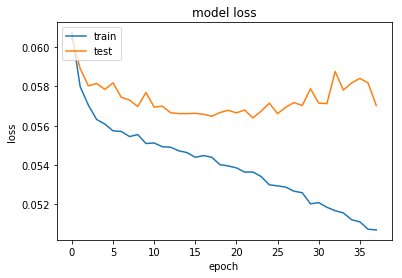

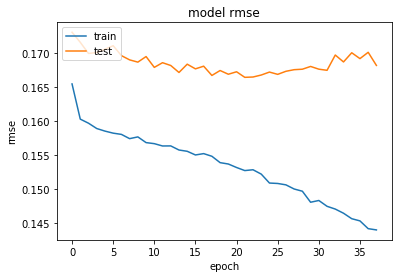

In [11]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [12]:
def get_mae(Y1, Y2):
   return np.mean(np.absolute(Y1 - Y2))

def get_rmse(Y1, Y2):
    return np.sqrt(np.mean(np.square(Y1 - Y2)))

def get_smape(Y1, Y2):
    return 100 * np.mean(np.absolute(Y1 - Y2) / (np.absolute(Y2) + np.absolute(Y1)))

def get_mfe(Y_pred, Y_target):
    return np.mean(Y_pred - Y_target)

In [13]:
model.load_weights(experiment_name+'.hdf5')

In [14]:
#path_to_sensor_data_train = os.path.join(dir_path, "preprocessed_train")

val_gen_pred = data_generator_head_sal_seq2seq_reinject_output(path_to_sensor_data_train,
                                         file_names_val,
                                         delays_list,
                                         n_max_delay,
                                         n_lookback,
                                         n_delay,
                                         inference=True
                                        )

predictions_mae_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_rmse_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_smape_val = np.zeros((len(file_names_val), 1+len_delay))
predictions_mfe_val = np.zeros((len(file_names_val), 1+len_delay))


count = 0

start = time.time()
print("Evaluating validation data...")

for [encoder_input, decoder_input], Y_val_abs in val_gen_pred:
    #print(len(encoder_input))
    #input_seq = encoder_input[seq_index: seq_index + 1]
    Y_pred_diff = model.predict([encoder_input, decoder_input], verbose=0)
    
    # From normalized differences to absolute values
    Y_pred = np.zeros(Y_pred_diff.shape)
    for i in range(len_delay):
        Y_pred[:, i] = Y_val_abs[:,0] + np.sum(Y_pred_diff[:, :i+1], axis=1) * MAX_DIFF
        
    Y_val_abs = Y_val_abs[:, 1:]

    predictions_mae_val[count, 0] = get_mae(Y_pred, Y_val_abs)
    predictions_rmse_val[count, 0] = get_rmse(Y_pred, Y_val_abs)
    predictions_smape_val[count, 0] = get_smape(Y_pred, Y_val_abs)
    predictions_mfe_val[count, 0] = get_mfe(Y_pred, Y_val_abs)
    
    #print(Y_pred.shape)
    for ind_delay in range(0,len_delay):
        Y_delay_pred = Y_pred[: ,ind_delay]
        Y_delay_val = Y_val_abs[: ,ind_delay]
        
        predictions_mae_val[count, 1+ind_delay] = get_mae(Y_delay_pred, Y_delay_val)
        predictions_rmse_val[count, 1+ind_delay] = get_rmse(Y_delay_pred, Y_delay_val)
        predictions_smape_val[count, 1+ind_delay] = get_smape(Y_delay_pred, Y_delay_val)
        predictions_mfe_val[count, 1+ind_delay] = get_mfe(Y_delay_pred, Y_delay_val)
    
    count += 1
    if count == len(file_names_val):
        break

results_mae_val = np.mean(predictions_mae_val, axis=0)
results_rmse_val = np.mean(predictions_rmse_val, axis=0)
results_smape_val = np.mean(predictions_smape_val, axis=0)
results_mfe_val = np.mean(predictions_mfe_val, axis=0)

print("Evaluation Time : ", time.time() - start, "s = ", (time.time() - start)/60., "min = ",
      (time.time() - start)/3600., "h")

Evaluating validation data...


Evaluation Time :  111.32522583007812 s =  1.8554204424222311 min =  0.0309236741065979 h


## Evaluate performance on validation data to improve model

In [15]:
model.load_weights(experiment_name+'.hdf5')

## Evaluate metrics

In [16]:
print("MAE")
print("Average mae:", results_mae_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mae_val[i+1])
print()    
print("RMSE")
print("Average rmse:", results_rmse_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_rmse_val[i+1])
print()    
print("SMAPE")
print("Average smape:", results_smape_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_smape_val[i+1])
print()
print("MFE")
print("Average mfe:", results_mfe_val[0])
for i, delay in enumerate(delays_list):
    print("Delay", delay, "ms:", results_mfe_val[i+1])

MAE
Average mae: 0.05839340755594392
Delay 100 ms: 0.004804018079849017
Delay 200 ms: 0.013353662121772723
Delay 300 ms: 0.024463821257969698
Delay 400 ms: 0.036968867859867624
Delay 500 ms: 0.05019199465642591
Delay 600 ms: 0.06377114890379446
Delay 700 ms: 0.07747244533975664
Delay 800 ms: 0.09107450113297555
Delay 900 ms: 0.10442674464564426
Delay 1000 ms: 0.11740687156138328

RMSE
Average rmse: 0.12481176507958039
Delay 100 ms: 0.015318155502419401
Delay 200 ms: 0.030651395643072142
Delay 300 ms: 0.05072573842436949
Delay 400 ms: 0.0730213121184056
Delay 500 ms: 0.09601297784545605
Delay 600 ms: 0.1189828348067137
Delay 700 ms: 0.1415426411351016
Delay 800 ms: 0.1634073736536114
Delay 900 ms: 0.18447612694071294
Delay 1000 ms: 0.20462750604310612

SMAPE
Average smape: 12.875177734193537
Delay 100 ms: 2.0148594544569907
Delay 200 ms: 4.707269384340284
Delay 300 ms: 7.4242933903478985
Delay 400 ms: 9.990940718738926
Delay 500 ms: 12.376397085174185
Delay 600 ms: 14.598114476248474
De

(6062, 25, 3) (6062, 10, 3)


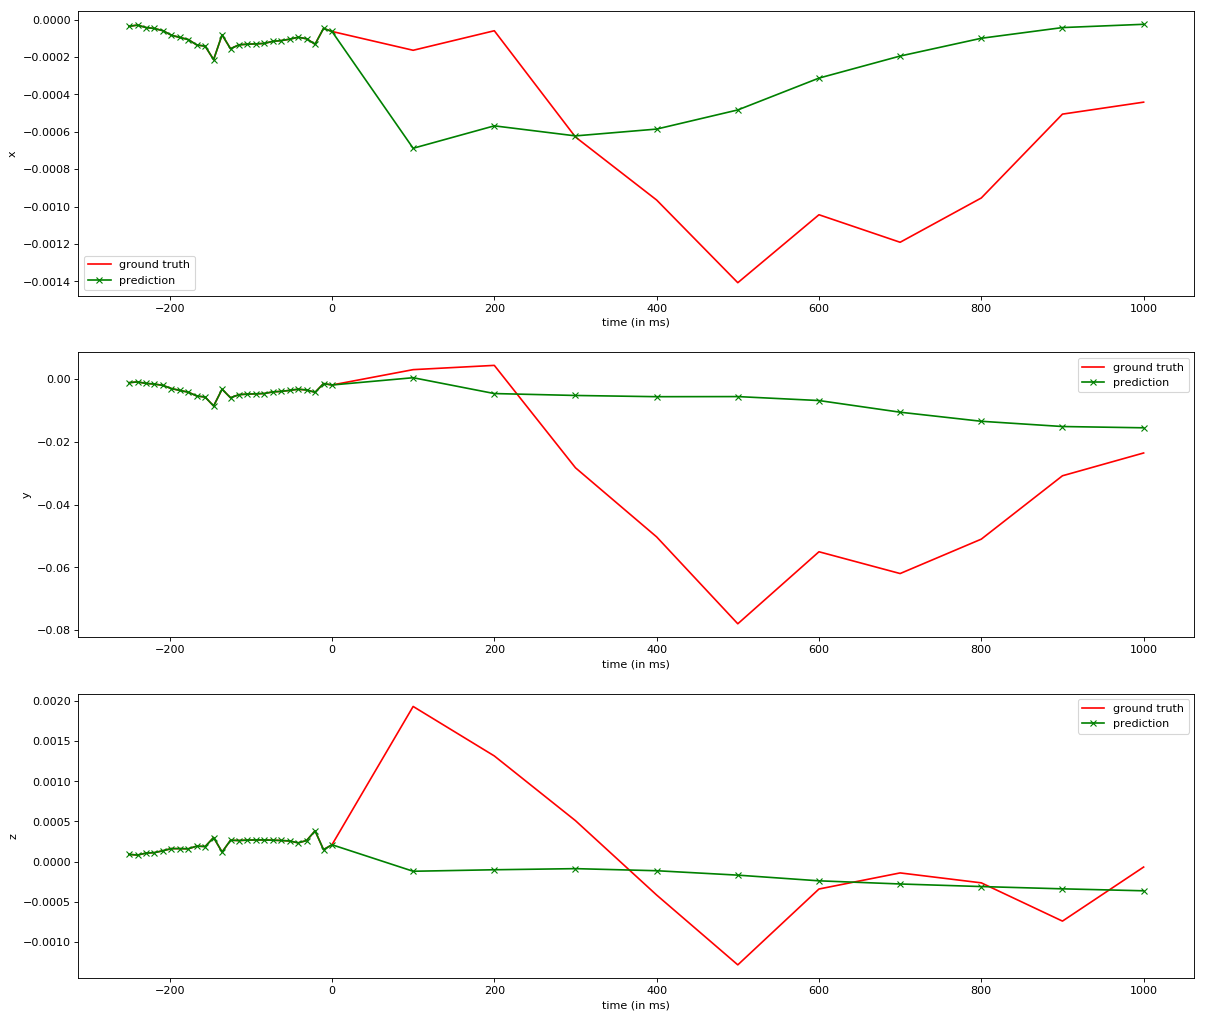

In [17]:
[encoder_input, decoder_input], Y_val = next(val_gen)
print(encoder_input.shape, Y_val.shape)
Y_pred = model.predict([encoder_input, decoder_input], verbose=0)

fig=plt.figure(figsize=(18, 16), dpi= 80)
plt.grid(True)
plt.axvline(x=0, c="b")
x_axis_pred = np.concatenate((np.linspace(-lookback, 0, num=n_lookback), np.linspace(step_delay, delays_list[-1], num=len(delays_list))))
time_sample = 700

plt.subplot(311)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_val[time_sample, :, 0])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,0], Y_pred[time_sample, :, 0])), label="prediction", c='g', marker="x")
plt.ylabel("x")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(312)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_val[time_sample, :, 1])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,1], Y_pred[time_sample, :, 1])), label="prediction", c='g', marker="x")
plt.ylabel("y")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

plt.subplot(313)
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_val[time_sample, :, 2])), label="ground truth", c='r')
plt.plot(x_axis_pred, np.concatenate((encoder_input[time_sample,:,2], Y_pred[time_sample, :, 2])), label="prediction", c='g', marker="x")
plt.ylabel("z")
plt.xlabel("time (in ms)")
plt.legend(loc='best')

## Evaluate performance on test data